# Fine-Tuning Blip base Model (Image-to-Text) on My Cats

 - The model will be fine-tuned on images of my three cats (asha, bree, annie) with labels such as 'a picture of cat_name' then will see how well the model can classify images of my cats.

# Install needed Libraries (For Google Colab)

In [3]:
!pip install git+https://github.com/huggingface/transformers.git@main

  Cloning https://github.com/huggingface/transformers.git (to revision main) to /tmp/pip-req-build-v5z96x1v
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-v5z96x1v
  Resolved https://github.com/huggingface/transformers.git to commit af3de8d87c717c4bb090f037d0d89413c195a42f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 37.4 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.35.0.dev0-py3-none-any.whl size=7914552 sha256=f4d25d2bfd73c313dcd6bf23f75f6b34aa9fc6238d285b3ebfb16d652061a6fd
  Stored in directory: 

In [4]:
!pip install tqdm

# Import Libraries

In [5]:
import pickle
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoProcessor, BlipForConditionalGeneration
from sklearn.model_selection import train_test_split
import time
from tqdm import tqdm
import pandas as pd
import requests
from PIL import Image
import seaborn as sns


# Import Dataset
- Dataset is a dictionary pickled with the format of data[:]['image'] for image data and data[:]['label'] for label data

In [ ]:
with open('cat_dataset.pkl', 'rb') as f:
    loaded_dataset = pickle.load(f)

# Pre-process dataset

- Labels need to be converted from integers representing the cat label to a string

In [ ]:
loaded_dataset[0]["label"]

3

In [ ]:
for entry in loaded_dataset:
    if entry['label'] == 1:
        entry['label'] = 'An image of Asha'
    elif entry['label'] == 2:
        entry['label'] = 'An image of Bree'
    elif entry['label'] == 3:
        entry['label'] = 'An image of Annie'

In [ ]:
loaded_dataset[0]["label"]

'An image of Annie'

In [ ]:
loaded_dataset[0]["image"]

# Split the dataset into train and test

- testing data will be used for validating the models accuracy after training

In [ ]:
train_data, test_data = train_test_split(loaded_dataset, test_size=0.2, random_state=42)

In [ ]:
train_data[0]["label"]

'An image of Bree'

In [ ]:
train_data[0]["image"]

# Define a function to help in training

In [ ]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["label"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

# Import the Base Blip Model

In [ ]:
processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
model.to("cuda")

# Test Base Model

- See how the base model captions a given image to compare with the fine-tuned model

In [ ]:
img_url = 'https://cdn.discordapp.com/attachments/401257138699370498/1159977993830154250/IMG_8486.jpg'
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

# conditional image captioning
text = "a photography of"
inputs = processor(raw_image, text, return_tensors="pt").to("cuda")

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

# unconditional image captioning
inputs = processor(raw_image, return_tensors="pt").to("cuda")

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a photography of two dogs sleeping on a couch
two black dogs laying on a couch


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


An image of Asha


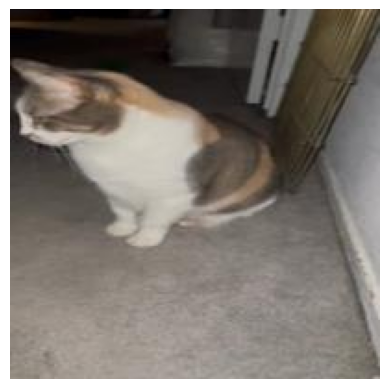

In [ ]:
example = test_data[6]
image = example["image"]
print(example["label"])
plt.imshow(image)
plt.axis('off')  # To hide axis values
plt.show()

In [ ]:
raw_image = image

# conditional image captioning
text = "a photography of"
inputs = processor(raw_image, text, return_tensors="pt").to("cuda")

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

# unconditional image captioning
inputs = processor(raw_image, return_tensors="pt").to("cuda")

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

a photography of a cat sitting on the floor
a cat sitting on the floor looking at something


# Fine-Tuning Model

In [ ]:
train_dataset = ImageCaptioningDataset(train_data, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

# Total number of batches
total_batches = len(train_dataloader)
total_epochs = 30
for epoch in range(total_epochs):
    # Record the start time for the epoch
    epoch_start_time = time.time()

    print(f"Starting Epoch {epoch + 1}/{total_epochs}")

    # Using tqdm for the progress bar
    for idx, batch in tqdm(enumerate(train_dataloader), total=total_batches, desc=f"Epoch {epoch + 1}"):

        # Record the start time for the batch
        batch_start_time = time.time()

        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        labels=input_ids)

        loss = outputs.loss

        # Calculate time taken for this batch
        batch_time = time.time() - batch_start_time

        print(f"Batch {idx + 1}/{total_batches} - Loss: {loss.item():.4f} - Time: {batch_time:.2f}s")

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Calculate time taken for this epoch
    epoch_time = time.time() - epoch_start_time
    print(f"Epoch {epoch + 1} completed in {epoch_time:.2f}s\n")

Starting Epoch 1/50


Epoch 1:   0%|          | 0/324 [00:00<?, ?it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Batch 1/324 - Loss: 13.2177 - Time: 9.23s


Epoch 1:   0%|          | 1/324 [00:10<56:19, 10.46s/it]

Batch 2/324 - Loss: 10.3855 - Time: 0.14s


Epoch 1:   1%|          | 2/324 [00:10<24:37,  4.59s/it]

Batch 3/324 - Loss: 10.3039 - Time: 0.21s


Epoch 1:   1%|          | 4/324 [00:12<10:03,  1.89s/it]

Batch 4/324 - Loss: 10.2789 - Time: 0.26s


Epoch 1:   2%|▏         | 5/324 [00:12<07:31,  1.42s/it]

Batch 5/324 - Loss: 10.2566 - Time: 0.30s


Epoch 1:   2%|▏         | 6/324 [00:13<06:00,  1.13s/it]

Batch 6/324 - Loss: 10.2445 - Time: 0.28s


Epoch 1:   2%|▏         | 7/324 [00:13<05:03,  1.04it/s]

Batch 7/324 - Loss: 10.2321 - Time: 0.33s


Epoch 1:   2%|▏         | 8/324 [00:14<04:25,  1.19it/s]

Batch 8/324 - Loss: 10.2176 - Time: 0.32s


Epoch 1:   3%|▎         | 9/324 [00:15<03:59,  1.31it/s]

Batch 9/324 - Loss: 10.2074 - Time: 0.30s


Epoch 1:   3%|▎         | 10/324 [00:15<03:41,  1.42it/s]

Batch 10/324 - Loss: 10.1901 - Time: 0.31s


Epoch 1:   3%|▎         | 11/324 [00:16<03:29,  1.49it/s]

Batch 11/324 - Loss: 10.1648 - Time: 0.32s
Batch 12/324 - Loss: 10.1431 - Time: 0.36s


Epoch 1:   4%|▍         | 13/324 [00:17<03:17,  1.57it/s]

Batch 13/324 - Loss: 10.1253 - Time: 0.29s


Epoch 1:   4%|▍         | 14/324 [00:18<03:15,  1.59it/s]

Batch 14/324 - Loss: 9.8013 - Time: 0.31s


Epoch 1:   5%|▍         | 15/324 [00:18<03:11,  1.62it/s]

Batch 15/324 - Loss: 9.3796 - Time: 0.26s
Batch 16/324 - Loss: 9.0332 - Time: 0.30s


Epoch 1:   5%|▌         | 17/324 [00:19<03:03,  1.67it/s]

Batch 17/324 - Loss: 8.9419 - Time: 0.27s


Epoch 1:   6%|▌         | 18/324 [00:20<03:02,  1.67it/s]

Batch 18/324 - Loss: 8.7279 - Time: 0.29s


Epoch 1:   6%|▌         | 19/324 [00:20<03:00,  1.69it/s]

Batch 19/324 - Loss: 8.5782 - Time: 0.27s


Epoch 1:   6%|▌         | 20/324 [00:21<02:59,  1.69it/s]

Batch 20/324 - Loss: 8.4126 - Time: 0.32s


Epoch 1:   6%|▋         | 21/324 [00:22<02:59,  1.69it/s]

Batch 21/324 - Loss: 8.2455 - Time: 0.31s


Epoch 1:   7%|▋         | 22/324 [00:22<02:58,  1.69it/s]

Batch 22/324 - Loss: 8.0746 - Time: 0.29s


Epoch 1:   7%|▋         | 23/324 [00:23<02:58,  1.69it/s]

Batch 23/324 - Loss: 7.9188 - Time: 0.31s


Epoch 1:   7%|▋         | 24/324 [00:23<02:58,  1.68it/s]

Batch 24/324 - Loss: 7.7750 - Time: 0.29s


Epoch 1:   8%|▊         | 25/324 [00:24<02:59,  1.66it/s]

Batch 25/324 - Loss: 7.6371 - Time: 0.34s


Epoch 1:   8%|▊         | 26/324 [00:25<02:58,  1.67it/s]

Batch 26/324 - Loss: 7.5032 - Time: 0.28s


Epoch 1:   8%|▊         | 27/324 [00:25<02:55,  1.70it/s]

Batch 27/324 - Loss: 7.3755 - Time: 0.29s


Epoch 1:   9%|▊         | 28/324 [00:26<02:54,  1.70it/s]

Batch 28/324 - Loss: 7.2388 - Time: 0.33s


Epoch 1:   9%|▉         | 29/324 [00:26<02:54,  1.70it/s]

Batch 29/324 - Loss: 7.1037 - Time: 0.30s


Epoch 1:   9%|▉         | 30/324 [00:27<02:53,  1.69it/s]

Batch 30/324 - Loss: 6.9719 - Time: 0.32s


Epoch 1:  10%|▉         | 31/324 [00:28<02:53,  1.69it/s]

Batch 31/324 - Loss: 6.8484 - Time: 0.32s


Epoch 1:  10%|▉         | 32/324 [00:28<02:52,  1.69it/s]

Batch 32/324 - Loss: 6.7065 - Time: 0.33s


Epoch 1:  10%|█         | 33/324 [00:29<02:52,  1.69it/s]

Batch 33/324 - Loss: 6.5748 - Time: 0.32s


Epoch 1:  10%|█         | 34/324 [00:29<02:51,  1.69it/s]

Batch 34/324 - Loss: 6.4324 - Time: 0.32s


Epoch 1:  11%|█         | 35/324 [00:30<02:51,  1.69it/s]

Batch 35/324 - Loss: 6.2961 - Time: 0.32s


Epoch 1:  11%|█         | 36/324 [00:31<02:50,  1.69it/s]

Batch 36/324 - Loss: 6.1579 - Time: 0.33s


Epoch 1:  11%|█▏        | 37/324 [00:31<02:50,  1.68it/s]

Batch 37/324 - Loss: 6.0232 - Time: 0.32s


Epoch 1:  12%|█▏        | 38/324 [00:32<02:50,  1.68it/s]

Batch 38/324 - Loss: 5.8844 - Time: 0.31s


Epoch 1:  12%|█▏        | 39/324 [00:32<02:50,  1.68it/s]

Batch 39/324 - Loss: 5.7501 - Time: 0.31s


Epoch 1:  12%|█▏        | 40/324 [00:33<02:49,  1.67it/s]

Batch 40/324 - Loss: 5.6169 - Time: 0.33s


Epoch 1:  13%|█▎        | 41/324 [00:34<02:48,  1.68it/s]

Batch 41/324 - Loss: 5.4796 - Time: 0.33s


Epoch 1:  13%|█▎        | 42/324 [00:34<02:47,  1.68it/s]

Batch 42/324 - Loss: 5.3424 - Time: 0.32s


Epoch 1:  13%|█▎        | 43/324 [00:35<02:47,  1.68it/s]

Batch 43/324 - Loss: 5.2151 - Time: 0.32s


Epoch 1:  14%|█▎        | 44/324 [00:35<02:46,  1.68it/s]

Batch 44/324 - Loss: 5.0660 - Time: 0.32s


Epoch 1:  14%|█▍        | 45/324 [00:36<02:46,  1.68it/s]

Batch 45/324 - Loss: 4.9319 - Time: 0.32s


Epoch 1:  14%|█▍        | 46/324 [00:37<02:46,  1.67it/s]

Batch 46/324 - Loss: 4.7989 - Time: 0.32s


Epoch 1:  15%|█▍        | 47/324 [00:37<02:45,  1.67it/s]

Batch 47/324 - Loss: 4.6609 - Time: 0.32s


Epoch 1:  15%|█▍        | 48/324 [00:38<02:44,  1.67it/s]

Batch 48/324 - Loss: 4.5260 - Time: 0.32s


Epoch 1:  15%|█▌        | 49/324 [00:38<02:44,  1.67it/s]

Batch 49/324 - Loss: 4.3914 - Time: 0.33s


Epoch 1:  15%|█▌        | 50/324 [00:39<02:43,  1.67it/s]

Batch 50/324 - Loss: 4.2633 - Time: 0.33s


Epoch 1:  16%|█▌        | 51/324 [00:39<02:43,  1.67it/s]

Batch 51/324 - Loss: 4.1309 - Time: 0.32s


Epoch 1:  16%|█▌        | 52/324 [00:40<02:42,  1.67it/s]

Batch 52/324 - Loss: 4.0009 - Time: 0.32s


Epoch 1:  16%|█▋        | 53/324 [00:41<02:42,  1.67it/s]

Batch 53/324 - Loss: 3.8665 - Time: 0.32s


Epoch 1:  17%|█▋        | 54/324 [00:41<02:41,  1.67it/s]

Batch 54/324 - Loss: 3.7396 - Time: 0.33s


Epoch 1:  17%|█▋        | 55/324 [00:42<02:41,  1.67it/s]

Batch 55/324 - Loss: 3.6146 - Time: 0.33s


Epoch 1:  17%|█▋        | 56/324 [00:42<02:40,  1.67it/s]

Batch 56/324 - Loss: 3.4875 - Time: 0.32s


Epoch 1:  18%|█▊        | 57/324 [00:43<02:40,  1.67it/s]

Batch 57/324 - Loss: 3.3672 - Time: 0.32s


Epoch 1:  18%|█▊        | 58/324 [00:44<02:39,  1.67it/s]

Batch 58/324 - Loss: 3.2460 - Time: 0.33s


Epoch 1:  18%|█▊        | 59/324 [00:44<02:39,  1.66it/s]

Batch 59/324 - Loss: 3.1246 - Time: 0.34s


Epoch 1:  19%|█▊        | 60/324 [00:45<02:39,  1.66it/s]

Batch 60/324 - Loss: 3.0096 - Time: 0.32s


Epoch 1:  19%|█▉        | 61/324 [00:46<02:38,  1.65it/s]

Batch 61/324 - Loss: 2.8957 - Time: 0.32s


Epoch 1:  19%|█▉        | 62/324 [00:46<02:38,  1.66it/s]

Batch 62/324 - Loss: 2.7866 - Time: 0.33s


Epoch 1:  19%|█▉        | 63/324 [00:47<02:38,  1.65it/s]

Batch 63/324 - Loss: 2.6832 - Time: 0.33s


Epoch 1:  20%|█▉        | 64/324 [00:47<02:37,  1.65it/s]

Batch 64/324 - Loss: 2.5809 - Time: 0.33s


Epoch 1:  20%|██        | 65/324 [00:48<02:37,  1.65it/s]

Batch 65/324 - Loss: 2.4853 - Time: 0.33s


Epoch 1:  20%|██        | 66/324 [00:49<02:36,  1.65it/s]

Batch 66/324 - Loss: 2.3873 - Time: 0.32s


Epoch 1:  21%|██        | 67/324 [00:49<02:35,  1.65it/s]

Batch 67/324 - Loss: 2.3005 - Time: 0.33s


Epoch 1:  21%|██        | 68/324 [00:50<02:34,  1.65it/s]

Batch 68/324 - Loss: 2.2151 - Time: 0.33s


Epoch 1:  21%|██▏       | 69/324 [00:50<02:34,  1.65it/s]

Batch 69/324 - Loss: 2.1364 - Time: 0.33s


Epoch 1:  22%|██▏       | 70/324 [00:51<02:34,  1.65it/s]

Batch 70/324 - Loss: 2.0639 - Time: 0.33s


Epoch 1:  22%|██▏       | 71/324 [00:52<02:33,  1.65it/s]

Batch 71/324 - Loss: 1.9963 - Time: 0.33s


Epoch 1:  22%|██▏       | 72/324 [00:52<02:32,  1.65it/s]

Batch 72/324 - Loss: 1.9334 - Time: 0.33s


Epoch 1:  23%|██▎       | 73/324 [00:53<02:32,  1.65it/s]

Batch 73/324 - Loss: 1.8760 - Time: 0.33s


Epoch 1:  23%|██▎       | 74/324 [00:53<02:31,  1.65it/s]

Batch 74/324 - Loss: 1.8220 - Time: 0.33s


Epoch 1:  23%|██▎       | 75/324 [00:54<02:31,  1.65it/s]

Batch 75/324 - Loss: 1.7754 - Time: 0.33s


Epoch 1:  23%|██▎       | 76/324 [00:55<02:30,  1.64it/s]

Batch 76/324 - Loss: 1.7342 - Time: 0.34s


Epoch 1:  24%|██▍       | 77/324 [00:55<02:30,  1.64it/s]

Batch 77/324 - Loss: 1.6928 - Time: 0.33s


Epoch 1:  24%|██▍       | 78/324 [00:56<02:30,  1.64it/s]

Batch 78/324 - Loss: 1.6582 - Time: 0.33s


Epoch 1:  24%|██▍       | 79/324 [00:56<02:29,  1.64it/s]

Batch 79/324 - Loss: 1.6280 - Time: 0.33s


Epoch 1:  25%|██▍       | 80/324 [00:57<02:29,  1.63it/s]

Batch 80/324 - Loss: 1.6005 - Time: 0.33s


Epoch 1:  25%|██▌       | 81/324 [00:58<02:28,  1.64it/s]

Batch 81/324 - Loss: 1.5780 - Time: 0.33s


Epoch 1:  25%|██▌       | 82/324 [00:58<02:28,  1.63it/s]

Batch 82/324 - Loss: 1.5540 - Time: 0.34s


Epoch 1:  26%|██▌       | 83/324 [00:59<02:27,  1.63it/s]

Batch 83/324 - Loss: 1.5352 - Time: 0.32s


Epoch 1:  26%|██▌       | 84/324 [01:00<02:27,  1.63it/s]

Batch 84/324 - Loss: 1.5199 - Time: 0.32s


Epoch 1:  26%|██▌       | 85/324 [01:00<02:26,  1.63it/s]

Batch 85/324 - Loss: 1.5031 - Time: 0.32s


Epoch 1:  27%|██▋       | 86/324 [01:01<02:26,  1.63it/s]

Batch 86/324 - Loss: 1.4905 - Time: 0.33s


Epoch 1:  27%|██▋       | 87/324 [01:01<02:25,  1.62it/s]

Batch 87/324 - Loss: 1.4803 - Time: 0.32s


Epoch 1:  27%|██▋       | 88/324 [01:02<02:25,  1.63it/s]

Batch 88/324 - Loss: 1.4696 - Time: 0.32s


Epoch 1:  27%|██▋       | 89/324 [01:03<02:24,  1.62it/s]

Batch 89/324 - Loss: 1.4604 - Time: 0.33s


Epoch 1:  28%|██▊       | 90/324 [01:03<02:24,  1.62it/s]

Batch 90/324 - Loss: 1.4521 - Time: 0.35s


Epoch 1:  28%|██▊       | 91/324 [01:04<02:23,  1.62it/s]

Batch 91/324 - Loss: 1.4435 - Time: 0.34s


Epoch 1:  28%|██▊       | 92/324 [01:04<02:23,  1.62it/s]

Batch 92/324 - Loss: 1.4381 - Time: 0.34s


Epoch 1:  29%|██▊       | 93/324 [01:05<02:23,  1.62it/s]

Batch 93/324 - Loss: 1.4313 - Time: 0.33s


Epoch 1:  29%|██▉       | 94/324 [01:06<02:22,  1.61it/s]

Batch 94/324 - Loss: 1.4269 - Time: 0.34s


Epoch 1:  29%|██▉       | 95/324 [01:06<02:22,  1.61it/s]

Batch 95/324 - Loss: 1.4220 - Time: 0.34s


Epoch 1:  30%|██▉       | 96/324 [01:07<02:21,  1.61it/s]

Batch 96/324 - Loss: 1.4180 - Time: 0.34s


Epoch 1:  30%|██▉       | 97/324 [01:08<02:20,  1.62it/s]

Batch 97/324 - Loss: 1.4141 - Time: 0.34s


Epoch 1:  30%|███       | 98/324 [01:08<02:19,  1.61it/s]

Batch 98/324 - Loss: 1.4107 - Time: 0.34s


Epoch 1:  31%|███       | 99/324 [01:09<02:19,  1.62it/s]

Batch 99/324 - Loss: 1.4074 - Time: 0.33s


Epoch 1:  31%|███       | 100/324 [01:09<02:18,  1.62it/s]

Batch 100/324 - Loss: 1.4041 - Time: 0.34s


Epoch 1:  31%|███       | 101/324 [01:10<02:18,  1.61it/s]

Batch 101/324 - Loss: 1.4021 - Time: 0.34s


Epoch 1:  31%|███▏      | 102/324 [01:11<02:17,  1.61it/s]

Batch 102/324 - Loss: 1.4006 - Time: 0.34s


Epoch 1:  32%|███▏      | 103/324 [01:11<02:17,  1.61it/s]

Batch 103/324 - Loss: 1.3983 - Time: 0.33s


Epoch 1:  32%|███▏      | 104/324 [01:12<02:16,  1.61it/s]

Batch 104/324 - Loss: 1.3963 - Time: 0.35s


Epoch 1:  32%|███▏      | 105/324 [01:13<02:16,  1.61it/s]

Batch 105/324 - Loss: 1.3944 - Time: 0.32s


Epoch 1:  33%|███▎      | 106/324 [01:13<02:15,  1.61it/s]

Batch 106/324 - Loss: 1.3921 - Time: 0.33s


Epoch 1:  33%|███▎      | 107/324 [01:14<02:15,  1.60it/s]

Batch 107/324 - Loss: 1.3911 - Time: 0.34s


Epoch 1:  33%|███▎      | 108/324 [01:14<02:14,  1.61it/s]

Batch 108/324 - Loss: 1.3891 - Time: 0.32s


Epoch 1:  34%|███▎      | 109/324 [01:15<02:14,  1.60it/s]

Batch 109/324 - Loss: 1.3876 - Time: 0.34s


Epoch 1:  34%|███▍      | 110/324 [01:16<02:13,  1.60it/s]

Batch 110/324 - Loss: 1.3861 - Time: 0.33s


Epoch 1:  34%|███▍      | 111/324 [01:16<02:12,  1.60it/s]

Batch 111/324 - Loss: 1.3855 - Time: 0.32s


Epoch 1:  35%|███▍      | 112/324 [01:17<02:12,  1.60it/s]

Batch 112/324 - Loss: 1.3845 - Time: 0.34s


Epoch 1:  35%|███▍      | 113/324 [01:18<02:11,  1.60it/s]

Batch 113/324 - Loss: 1.3824 - Time: 0.34s


Epoch 1:  35%|███▌      | 114/324 [01:18<02:11,  1.60it/s]

Batch 114/324 - Loss: 1.3838 - Time: 0.34s


Epoch 1:  35%|███▌      | 115/324 [01:19<02:10,  1.60it/s]

Batch 115/324 - Loss: 1.3820 - Time: 0.34s


Epoch 1:  36%|███▌      | 116/324 [01:19<02:10,  1.60it/s]

Batch 116/324 - Loss: 1.3824 - Time: 0.34s


Epoch 1:  36%|███▌      | 117/324 [01:20<02:09,  1.60it/s]

Batch 117/324 - Loss: 1.3804 - Time: 0.35s


Epoch 1:  36%|███▋      | 118/324 [01:21<02:09,  1.60it/s]

Batch 118/324 - Loss: 1.3809 - Time: 0.34s


Epoch 1:  37%|███▋      | 119/324 [01:21<02:08,  1.60it/s]

Batch 119/324 - Loss: 1.3777 - Time: 0.34s


Epoch 1:  37%|███▋      | 120/324 [01:22<02:08,  1.59it/s]

Batch 120/324 - Loss: 1.3788 - Time: 0.34s


Epoch 1:  37%|███▋      | 121/324 [01:23<02:07,  1.59it/s]

Batch 121/324 - Loss: 1.3791 - Time: 0.34s


Epoch 1:  38%|███▊      | 122/324 [01:23<02:07,  1.59it/s]

Batch 122/324 - Loss: 1.3768 - Time: 0.35s


Epoch 1:  38%|███▊      | 123/324 [01:24<02:07,  1.58it/s]

Batch 123/324 - Loss: 1.3766 - Time: 0.33s


Epoch 1:  38%|███▊      | 124/324 [01:24<02:06,  1.58it/s]

Batch 124/324 - Loss: 1.3779 - Time: 0.34s


Epoch 1:  39%|███▊      | 125/324 [01:25<02:06,  1.57it/s]

Batch 125/324 - Loss: 1.3754 - Time: 0.34s


Epoch 1:  39%|███▉      | 126/324 [01:26<02:05,  1.58it/s]

Batch 126/324 - Loss: 1.3750 - Time: 0.34s


Epoch 1:  39%|███▉      | 127/324 [01:26<02:05,  1.57it/s]

Batch 127/324 - Loss: 1.3739 - Time: 0.34s


Epoch 1:  40%|███▉      | 128/324 [01:27<02:04,  1.57it/s]

Batch 128/324 - Loss: 1.3748 - Time: 0.33s


Epoch 1:  40%|███▉      | 129/324 [01:28<02:04,  1.57it/s]

Batch 129/324 - Loss: 1.3750 - Time: 0.34s


Epoch 1:  40%|████      | 130/324 [01:28<02:03,  1.57it/s]

Batch 130/324 - Loss: 1.3737 - Time: 0.34s


Epoch 1:  40%|████      | 131/324 [01:29<02:03,  1.57it/s]

Batch 131/324 - Loss: 1.3731 - Time: 0.35s


Epoch 1:  41%|████      | 132/324 [01:30<02:02,  1.57it/s]

Batch 132/324 - Loss: 1.3728 - Time: 0.35s


Epoch 1:  41%|████      | 133/324 [01:30<02:02,  1.56it/s]

Batch 133/324 - Loss: 1.3719 - Time: 0.35s
Batch 134/324 - Loss: 1.3713 - Time: 0.34s


Epoch 1:  42%|████▏     | 135/324 [01:31<02:00,  1.57it/s]

Batch 135/324 - Loss: 1.3718 - Time: 0.23s


Epoch 1:  42%|████▏     | 136/324 [01:32<02:01,  1.55it/s]

Batch 136/324 - Loss: 1.3704 - Time: 0.43s
Batch 137/324 - Loss: 1.3700 - Time: 0.34s


Epoch 1:  43%|████▎     | 138/324 [01:33<01:59,  1.56it/s]

Batch 138/324 - Loss: 1.3733 - Time: 0.25s


Epoch 1:  43%|████▎     | 139/324 [01:34<01:58,  1.56it/s]

Batch 139/324 - Loss: 1.3694 - Time: 0.35s


Epoch 1:  43%|████▎     | 140/324 [01:35<01:58,  1.56it/s]

Batch 140/324 - Loss: 1.3691 - Time: 0.35s


Epoch 1:  44%|████▎     | 141/324 [01:35<01:57,  1.55it/s]

Batch 141/324 - Loss: 1.3708 - Time: 0.36s


Epoch 1:  44%|████▍     | 142/324 [01:36<01:57,  1.55it/s]

Batch 142/324 - Loss: 1.3686 - Time: 0.34s


Epoch 1:  44%|████▍     | 143/324 [01:37<01:56,  1.55it/s]

Batch 143/324 - Loss: 1.3731 - Time: 0.35s


Epoch 1:  44%|████▍     | 144/324 [01:37<01:56,  1.55it/s]

Batch 144/324 - Loss: 1.3682 - Time: 0.35s


Epoch 1:  45%|████▍     | 145/324 [01:38<01:55,  1.54it/s]

Batch 145/324 - Loss: 1.3695 - Time: 0.34s


Epoch 1:  45%|████▌     | 146/324 [01:39<01:55,  1.54it/s]

Batch 146/324 - Loss: 1.3692 - Time: 0.35s


Epoch 1:  45%|████▌     | 147/324 [01:39<01:55,  1.54it/s]

Batch 147/324 - Loss: 1.3679 - Time: 0.35s


Epoch 1:  46%|████▌     | 148/324 [01:40<01:54,  1.54it/s]

Batch 148/324 - Loss: 1.3708 - Time: 0.35s


Epoch 1:  46%|████▌     | 149/324 [01:41<01:54,  1.53it/s]

Batch 149/324 - Loss: 1.3699 - Time: 0.35s


Epoch 1:  46%|████▋     | 150/324 [01:41<01:53,  1.53it/s]

Batch 150/324 - Loss: 1.3699 - Time: 0.35s


Epoch 1:  47%|████▋     | 151/324 [01:42<01:53,  1.53it/s]

Batch 151/324 - Loss: 1.3695 - Time: 0.35s


Epoch 1:  47%|████▋     | 152/324 [01:43<01:52,  1.53it/s]

Batch 152/324 - Loss: 1.3677 - Time: 0.35s


Epoch 1:  47%|████▋     | 153/324 [01:43<01:51,  1.53it/s]

Batch 153/324 - Loss: 1.3674 - Time: 0.35s


Epoch 1:  48%|████▊     | 154/324 [01:44<01:51,  1.53it/s]

Batch 154/324 - Loss: 1.3678 - Time: 0.36s


Epoch 1:  48%|████▊     | 155/324 [01:44<01:50,  1.53it/s]

Batch 155/324 - Loss: 1.3689 - Time: 0.35s


Epoch 1:  48%|████▊     | 156/324 [01:45<01:49,  1.53it/s]

Batch 156/324 - Loss: 1.3677 - Time: 0.35s


Epoch 1:  48%|████▊     | 157/324 [01:46<01:49,  1.53it/s]

Batch 157/324 - Loss: 1.3686 - Time: 0.36s


Epoch 1:  49%|████▉     | 158/324 [01:46<01:48,  1.53it/s]

Batch 158/324 - Loss: 1.3682 - Time: 0.35s


Epoch 1:  49%|████▉     | 159/324 [01:47<01:48,  1.53it/s]

Batch 159/324 - Loss: 1.3681 - Time: 0.36s


Epoch 1:  49%|████▉     | 160/324 [01:48<01:47,  1.52it/s]

Batch 160/324 - Loss: 1.3674 - Time: 0.36s


Epoch 1:  50%|████▉     | 161/324 [01:48<01:47,  1.51it/s]

Batch 161/324 - Loss: 1.3672 - Time: 0.35s


Epoch 1:  50%|█████     | 162/324 [01:49<01:46,  1.51it/s]

Batch 162/324 - Loss: 1.3669 - Time: 0.36s


Epoch 1:  50%|█████     | 163/324 [01:50<01:46,  1.51it/s]

Batch 163/324 - Loss: 1.3671 - Time: 0.32s


Epoch 1:  51%|█████     | 164/324 [01:50<01:44,  1.53it/s]

Batch 164/324 - Loss: 1.3664 - Time: 0.29s


Epoch 1:  51%|█████     | 165/324 [01:51<01:44,  1.51it/s]

Batch 165/324 - Loss: 1.3670 - Time: 0.35s


Epoch 1:  51%|█████     | 166/324 [01:52<01:42,  1.54it/s]

Batch 166/324 - Loss: 1.3660 - Time: 0.29s


Epoch 1:  52%|█████▏    | 167/324 [01:52<01:42,  1.54it/s]

Batch 167/324 - Loss: 1.3670 - Time: 0.36s


Epoch 1:  52%|█████▏    | 168/324 [01:53<01:41,  1.54it/s]

Batch 168/324 - Loss: 1.3657 - Time: 0.35s


Epoch 1:  52%|█████▏    | 169/324 [01:54<01:41,  1.53it/s]

Batch 169/324 - Loss: 1.3656 - Time: 0.37s


Epoch 1:  52%|█████▏    | 170/324 [01:54<01:40,  1.53it/s]

Batch 170/324 - Loss: 1.3667 - Time: 0.35s


Epoch 1:  53%|█████▎    | 171/324 [01:55<01:39,  1.54it/s]

Batch 171/324 - Loss: 1.3665 - Time: 0.34s


Epoch 1:  53%|█████▎    | 172/324 [01:56<01:38,  1.54it/s]

Batch 172/324 - Loss: 1.3653 - Time: 0.35s


Epoch 1:  53%|█████▎    | 173/324 [01:56<01:38,  1.54it/s]

Batch 173/324 - Loss: 1.3660 - Time: 0.35s


Epoch 1:  54%|█████▎    | 174/324 [01:57<01:37,  1.54it/s]

Batch 174/324 - Loss: 1.3661 - Time: 0.35s


Epoch 1:  54%|█████▍    | 175/324 [01:58<01:36,  1.54it/s]

Batch 175/324 - Loss: 1.3651 - Time: 0.35s


Epoch 1:  54%|█████▍    | 176/324 [01:58<01:35,  1.55it/s]

Batch 176/324 - Loss: 1.3653 - Time: 0.35s


Epoch 1:  55%|█████▍    | 177/324 [01:59<01:35,  1.55it/s]

Batch 177/324 - Loss: 1.3657 - Time: 0.35s


Epoch 1:  55%|█████▍    | 178/324 [01:59<01:34,  1.55it/s]

Batch 178/324 - Loss: 1.3651 - Time: 0.35s


Epoch 1:  55%|█████▌    | 179/324 [02:00<01:33,  1.55it/s]

Batch 179/324 - Loss: 1.3653 - Time: 0.35s


Epoch 1:  56%|█████▌    | 180/324 [02:01<01:32,  1.55it/s]

Batch 180/324 - Loss: 1.3649 - Time: 0.35s


Epoch 1:  56%|█████▌    | 181/324 [02:01<01:32,  1.55it/s]

Batch 181/324 - Loss: 1.3649 - Time: 0.35s


Epoch 1:  56%|█████▌    | 182/324 [02:02<01:31,  1.55it/s]

Batch 182/324 - Loss: 1.3648 - Time: 0.35s


Epoch 1:  56%|█████▋    | 183/324 [02:03<01:30,  1.56it/s]

Batch 183/324 - Loss: 1.3647 - Time: 0.35s


Epoch 1:  57%|█████▋    | 184/324 [02:03<01:30,  1.56it/s]

Batch 184/324 - Loss: 1.3647 - Time: 0.35s


Epoch 1:  57%|█████▋    | 185/324 [02:04<01:29,  1.56it/s]

Batch 185/324 - Loss: 1.3645 - Time: 0.35s


Epoch 1:  57%|█████▋    | 186/324 [02:05<01:28,  1.56it/s]

Batch 186/324 - Loss: 1.3646 - Time: 0.35s


Epoch 1:  58%|█████▊    | 187/324 [02:05<01:27,  1.56it/s]

Batch 187/324 - Loss: 1.3641 - Time: 0.34s


Epoch 1:  58%|█████▊    | 188/324 [02:06<01:27,  1.56it/s]

Batch 188/324 - Loss: 1.3645 - Time: 0.34s


Epoch 1:  58%|█████▊    | 189/324 [02:07<01:26,  1.56it/s]

Batch 189/324 - Loss: 1.3644 - Time: 0.34s


Epoch 1:  59%|█████▊    | 190/324 [02:07<01:25,  1.57it/s]

Batch 190/324 - Loss: 1.3638 - Time: 0.35s


Epoch 1:  59%|█████▉    | 191/324 [02:08<01:24,  1.57it/s]

Batch 191/324 - Loss: 1.3637 - Time: 0.34s


Epoch 1:  59%|█████▉    | 192/324 [02:08<01:24,  1.57it/s]

Batch 192/324 - Loss: 1.3631 - Time: 0.34s


Epoch 1:  60%|█████▉    | 193/324 [02:09<01:23,  1.57it/s]

Batch 193/324 - Loss: 1.3636 - Time: 0.33s


Epoch 1:  60%|█████▉    | 194/324 [02:10<01:22,  1.57it/s]

Batch 194/324 - Loss: 1.3628 - Time: 0.34s


Epoch 1:  60%|██████    | 195/324 [02:10<01:21,  1.57it/s]

Batch 195/324 - Loss: 1.3634 - Time: 0.34s


Epoch 1:  60%|██████    | 196/324 [02:11<01:21,  1.57it/s]

Batch 196/324 - Loss: 1.3625 - Time: 0.33s


Epoch 1:  61%|██████    | 197/324 [02:12<01:20,  1.57it/s]

Batch 197/324 - Loss: 1.3645 - Time: 0.34s


Epoch 1:  61%|██████    | 198/324 [02:12<01:20,  1.57it/s]

Batch 198/324 - Loss: 1.3645 - Time: 0.34s


Epoch 1:  61%|██████▏   | 199/324 [02:13<01:19,  1.57it/s]

Batch 199/324 - Loss: 1.3656 - Time: 0.35s


Epoch 1:  62%|██████▏   | 200/324 [02:14<01:18,  1.57it/s]

Batch 200/324 - Loss: 1.3621 - Time: 0.35s


Epoch 1:  62%|██████▏   | 201/324 [02:14<01:18,  1.57it/s]

Batch 201/324 - Loss: 1.3640 - Time: 0.35s


Epoch 1:  62%|██████▏   | 202/324 [02:15<01:17,  1.57it/s]

Batch 202/324 - Loss: 1.3637 - Time: 0.34s


Epoch 1:  63%|██████▎   | 203/324 [02:15<01:16,  1.57it/s]

Batch 203/324 - Loss: 1.3632 - Time: 0.34s


Epoch 1:  63%|██████▎   | 204/324 [02:16<01:16,  1.58it/s]

Batch 204/324 - Loss: 1.3622 - Time: 0.34s


Epoch 1:  63%|██████▎   | 205/324 [02:17<01:15,  1.58it/s]

Batch 205/324 - Loss: 1.3632 - Time: 0.34s


Epoch 1:  64%|██████▎   | 206/324 [02:17<01:14,  1.58it/s]

Batch 206/324 - Loss: 1.3642 - Time: 0.34s


Epoch 1:  64%|██████▍   | 207/324 [02:18<01:14,  1.58it/s]

Batch 207/324 - Loss: 1.3623 - Time: 0.34s


Epoch 1:  64%|██████▍   | 208/324 [02:19<01:13,  1.58it/s]

Batch 208/324 - Loss: 1.3630 - Time: 0.35s


Epoch 1:  65%|██████▍   | 209/324 [02:19<01:12,  1.58it/s]

Batch 209/324 - Loss: 1.3629 - Time: 0.34s


Epoch 1:  65%|██████▍   | 210/324 [02:20<01:11,  1.58it/s]

Batch 210/324 - Loss: 1.3623 - Time: 0.34s


Epoch 1:  65%|██████▌   | 211/324 [02:20<01:11,  1.58it/s]

Batch 211/324 - Loss: 1.3627 - Time: 0.34s


Epoch 1:  65%|██████▌   | 212/324 [02:21<01:10,  1.58it/s]

Batch 212/324 - Loss: 1.3625 - Time: 0.35s


Epoch 1:  66%|██████▌   | 213/324 [02:22<01:10,  1.58it/s]

Batch 213/324 - Loss: 1.3645 - Time: 0.33s


Epoch 1:  66%|██████▌   | 214/324 [02:22<01:09,  1.58it/s]

Batch 214/324 - Loss: 1.3621 - Time: 0.33s


Epoch 1:  66%|██████▋   | 215/324 [02:23<01:08,  1.59it/s]

Batch 215/324 - Loss: 1.3620 - Time: 0.33s


Epoch 1:  67%|██████▋   | 216/324 [02:24<01:08,  1.59it/s]

Batch 216/324 - Loss: 1.3618 - Time: 0.35s


Epoch 1:  67%|██████▋   | 217/324 [02:24<01:07,  1.58it/s]

Batch 217/324 - Loss: 1.3623 - Time: 0.34s


Epoch 1:  67%|██████▋   | 218/324 [02:25<01:06,  1.59it/s]

Batch 218/324 - Loss: 1.3614 - Time: 0.32s


Epoch 1:  68%|██████▊   | 219/324 [02:26<01:06,  1.59it/s]

Batch 219/324 - Loss: 1.3632 - Time: 0.34s


Epoch 1:  68%|██████▊   | 220/324 [02:26<01:05,  1.59it/s]

Batch 220/324 - Loss: 1.3647 - Time: 0.32s


Epoch 1:  68%|██████▊   | 221/324 [02:27<01:04,  1.59it/s]

Batch 221/324 - Loss: 1.3610 - Time: 0.34s


Epoch 1:  69%|██████▊   | 222/324 [02:27<01:04,  1.59it/s]

Batch 222/324 - Loss: 1.3630 - Time: 0.34s


Epoch 1:  69%|██████▉   | 223/324 [02:28<01:03,  1.59it/s]

Batch 223/324 - Loss: 1.3628 - Time: 0.35s


Epoch 1:  69%|██████▉   | 224/324 [02:29<01:03,  1.59it/s]

Batch 224/324 - Loss: 1.3625 - Time: 0.34s


Epoch 1:  69%|██████▉   | 225/324 [02:29<01:02,  1.59it/s]

Batch 225/324 - Loss: 1.3610 - Time: 0.34s


Epoch 1:  70%|██████▉   | 226/324 [02:30<01:01,  1.59it/s]

Batch 226/324 - Loss: 1.3622 - Time: 0.34s


Epoch 1:  70%|███████   | 227/324 [02:31<01:01,  1.59it/s]

Batch 227/324 - Loss: 1.3625 - Time: 0.34s


Epoch 1:  70%|███████   | 228/324 [02:31<01:00,  1.59it/s]

Batch 228/324 - Loss: 1.3633 - Time: 0.33s


Epoch 1:  71%|███████   | 229/324 [02:32<00:59,  1.59it/s]

Batch 229/324 - Loss: 1.3614 - Time: 0.35s


Epoch 1:  71%|███████   | 230/324 [02:32<00:59,  1.59it/s]

Batch 230/324 - Loss: 1.3623 - Time: 0.34s


Epoch 1:  71%|███████▏  | 231/324 [02:33<00:58,  1.59it/s]

Batch 231/324 - Loss: 1.3617 - Time: 0.34s


Epoch 1:  72%|███████▏  | 232/324 [02:34<00:57,  1.59it/s]

Batch 232/324 - Loss: 1.3626 - Time: 0.34s


Epoch 1:  72%|███████▏  | 233/324 [02:34<00:57,  1.59it/s]

Batch 233/324 - Loss: 1.3618 - Time: 0.34s


Epoch 1:  72%|███████▏  | 234/324 [02:35<00:56,  1.59it/s]

Batch 234/324 - Loss: 1.3624 - Time: 0.34s


Epoch 1:  73%|███████▎  | 235/324 [02:36<00:56,  1.59it/s]

Batch 235/324 - Loss: 1.3627 - Time: 0.32s


Epoch 1:  73%|███████▎  | 236/324 [02:36<00:55,  1.59it/s]

Batch 236/324 - Loss: 1.3612 - Time: 0.33s


Epoch 1:  73%|███████▎  | 237/324 [02:37<00:54,  1.59it/s]

Batch 237/324 - Loss: 1.3625 - Time: 0.34s


Epoch 1:  73%|███████▎  | 238/324 [02:37<00:54,  1.59it/s]

Batch 238/324 - Loss: 1.3618 - Time: 0.33s


Epoch 1:  74%|███████▍  | 239/324 [02:38<00:53,  1.59it/s]

Batch 239/324 - Loss: 1.3625 - Time: 0.34s


Epoch 1:  74%|███████▍  | 240/324 [02:39<00:52,  1.59it/s]

Batch 240/324 - Loss: 1.3616 - Time: 0.34s


Epoch 1:  74%|███████▍  | 241/324 [02:39<00:52,  1.58it/s]

Batch 241/324 - Loss: 1.3616 - Time: 0.34s


Epoch 1:  75%|███████▍  | 242/324 [02:40<00:51,  1.58it/s]

Batch 242/324 - Loss: 1.3615 - Time: 0.33s


Epoch 1:  75%|███████▌  | 243/324 [02:41<00:51,  1.59it/s]

Batch 243/324 - Loss: 1.3615 - Time: 0.34s


Epoch 1:  75%|███████▌  | 244/324 [02:41<00:50,  1.58it/s]

Batch 244/324 - Loss: 1.3621 - Time: 0.34s


Epoch 1:  76%|███████▌  | 245/324 [02:42<00:49,  1.58it/s]

Batch 245/324 - Loss: 1.3620 - Time: 0.34s


Epoch 1:  76%|███████▌  | 246/324 [02:43<00:49,  1.58it/s]

Batch 246/324 - Loss: 1.3632 - Time: 0.35s


Epoch 1:  76%|███████▌  | 247/324 [02:43<00:48,  1.58it/s]

Batch 247/324 - Loss: 1.3618 - Time: 0.34s


Epoch 1:  77%|███████▋  | 248/324 [02:44<00:48,  1.58it/s]

Batch 248/324 - Loss: 1.3616 - Time: 0.34s


Epoch 1:  77%|███████▋  | 249/324 [02:44<00:47,  1.58it/s]

Batch 249/324 - Loss: 1.3608 - Time: 0.34s


Epoch 1:  77%|███████▋  | 250/324 [02:45<00:46,  1.58it/s]

Batch 250/324 - Loss: 1.3607 - Time: 0.34s


Epoch 1:  77%|███████▋  | 251/324 [02:46<00:46,  1.58it/s]

Batch 251/324 - Loss: 1.3612 - Time: 0.36s


Epoch 1:  78%|███████▊  | 252/324 [02:46<00:45,  1.58it/s]

Batch 252/324 - Loss: 1.3640 - Time: 0.34s


Epoch 1:  78%|███████▊  | 253/324 [02:47<00:44,  1.58it/s]

Batch 253/324 - Loss: 1.3611 - Time: 0.34s


Epoch 1:  78%|███████▊  | 254/324 [02:48<00:44,  1.58it/s]

Batch 254/324 - Loss: 1.3611 - Time: 0.34s


Epoch 1:  79%|███████▊  | 255/324 [02:48<00:43,  1.57it/s]

Batch 255/324 - Loss: 1.3640 - Time: 0.34s


Epoch 1:  79%|███████▉  | 256/324 [02:49<00:43,  1.57it/s]

Batch 256/324 - Loss: 1.3622 - Time: 0.34s


Epoch 1:  79%|███████▉  | 257/324 [02:50<00:42,  1.57it/s]

Batch 257/324 - Loss: 1.3620 - Time: 0.34s


Epoch 1:  80%|███████▉  | 258/324 [02:50<00:42,  1.57it/s]

Batch 258/324 - Loss: 1.3618 - Time: 0.33s


Epoch 1:  80%|███████▉  | 259/324 [02:51<00:41,  1.57it/s]

Batch 259/324 - Loss: 1.3611 - Time: 0.34s


Epoch 1:  80%|████████  | 260/324 [02:51<00:40,  1.57it/s]

Batch 260/324 - Loss: 1.3614 - Time: 0.35s


Epoch 1:  81%|████████  | 261/324 [02:52<00:40,  1.57it/s]

Batch 261/324 - Loss: 1.3610 - Time: 0.34s


Epoch 1:  81%|████████  | 262/324 [02:53<00:39,  1.57it/s]

Batch 262/324 - Loss: 1.3617 - Time: 0.34s


Epoch 1:  81%|████████  | 263/324 [02:53<00:38,  1.57it/s]

Batch 263/324 - Loss: 1.3607 - Time: 0.35s


Epoch 1:  81%|████████▏ | 264/324 [02:54<00:38,  1.57it/s]

Batch 264/324 - Loss: 1.3604 - Time: 0.35s


Epoch 1:  82%|████████▏ | 265/324 [02:55<00:37,  1.57it/s]

Batch 265/324 - Loss: 1.3618 - Time: 0.34s


Epoch 1:  82%|████████▏ | 266/324 [02:55<00:37,  1.57it/s]

Batch 266/324 - Loss: 1.3643 - Time: 0.34s


Epoch 1:  82%|████████▏ | 267/324 [02:56<00:36,  1.57it/s]

Batch 267/324 - Loss: 1.3609 - Time: 0.36s


Epoch 1:  83%|████████▎ | 268/324 [02:57<00:35,  1.57it/s]

Batch 268/324 - Loss: 1.3616 - Time: 0.35s


Epoch 1:  83%|████████▎ | 269/324 [02:57<00:35,  1.56it/s]

Batch 269/324 - Loss: 1.3608 - Time: 0.34s


Epoch 1:  83%|████████▎ | 270/324 [02:58<00:34,  1.56it/s]

Batch 270/324 - Loss: 1.3609 - Time: 0.36s


Epoch 1:  84%|████████▎ | 271/324 [02:58<00:33,  1.56it/s]

Batch 271/324 - Loss: 1.3605 - Time: 0.35s


Epoch 1:  84%|████████▍ | 272/324 [02:59<00:33,  1.56it/s]

Batch 272/324 - Loss: 1.3607 - Time: 0.34s


Epoch 1:  84%|████████▍ | 273/324 [03:00<00:32,  1.56it/s]

Batch 273/324 - Loss: 1.3632 - Time: 0.35s


Epoch 1:  85%|████████▍ | 274/324 [03:00<00:32,  1.56it/s]

Batch 274/324 - Loss: 1.3623 - Time: 0.34s


Epoch 1:  85%|████████▍ | 275/324 [03:01<00:31,  1.56it/s]

Batch 275/324 - Loss: 1.3633 - Time: 0.34s


Epoch 1:  85%|████████▌ | 276/324 [03:02<00:30,  1.56it/s]

Batch 276/324 - Loss: 1.3608 - Time: 0.35s


Epoch 1:  85%|████████▌ | 277/324 [03:02<00:30,  1.56it/s]

Batch 277/324 - Loss: 1.3626 - Time: 0.35s


Epoch 1:  86%|████████▌ | 278/324 [03:03<00:29,  1.56it/s]

Batch 278/324 - Loss: 1.3606 - Time: 0.33s


Epoch 1:  86%|████████▌ | 279/324 [03:04<00:28,  1.56it/s]

Batch 279/324 - Loss: 1.3619 - Time: 0.34s


Epoch 1:  86%|████████▋ | 280/324 [03:04<00:28,  1.56it/s]

Batch 280/324 - Loss: 1.3607 - Time: 0.34s


Epoch 1:  87%|████████▋ | 281/324 [03:05<00:27,  1.55it/s]

Batch 281/324 - Loss: 1.3602 - Time: 0.35s


Epoch 1:  87%|████████▋ | 282/324 [03:06<00:27,  1.55it/s]

Batch 282/324 - Loss: 1.3613 - Time: 0.35s


Epoch 1:  87%|████████▋ | 283/324 [03:06<00:26,  1.56it/s]

Batch 283/324 - Loss: 1.3612 - Time: 0.32s


Epoch 1:  88%|████████▊ | 284/324 [03:07<00:25,  1.56it/s]

Batch 284/324 - Loss: 1.3614 - Time: 0.35s


Epoch 1:  88%|████████▊ | 285/324 [03:07<00:25,  1.56it/s]

Batch 285/324 - Loss: 1.3615 - Time: 0.35s


Epoch 1:  88%|████████▊ | 286/324 [03:08<00:24,  1.55it/s]

Batch 286/324 - Loss: 1.3635 - Time: 0.35s


Epoch 1:  89%|████████▊ | 287/324 [03:09<00:23,  1.55it/s]

Batch 287/324 - Loss: 1.3614 - Time: 0.35s


Epoch 1:  89%|████████▉ | 288/324 [03:09<00:23,  1.55it/s]

Batch 288/324 - Loss: 1.3608 - Time: 0.35s


Epoch 1:  89%|████████▉ | 289/324 [03:10<00:22,  1.55it/s]

Batch 289/324 - Loss: 1.3607 - Time: 0.35s


Epoch 1:  90%|████████▉ | 290/324 [03:11<00:21,  1.55it/s]

Batch 290/324 - Loss: 1.3618 - Time: 0.36s


Epoch 1:  90%|████████▉ | 291/324 [03:11<00:21,  1.55it/s]

Batch 291/324 - Loss: 1.3618 - Time: 0.35s


Epoch 1:  90%|█████████ | 292/324 [03:12<00:20,  1.55it/s]

Batch 292/324 - Loss: 1.3608 - Time: 0.36s


Epoch 1:  90%|█████████ | 293/324 [03:13<00:19,  1.55it/s]

Batch 293/324 - Loss: 1.3609 - Time: 0.35s


Epoch 1:  91%|█████████ | 294/324 [03:13<00:19,  1.55it/s]

Batch 294/324 - Loss: 1.3612 - Time: 0.35s


Epoch 1:  91%|█████████ | 295/324 [03:14<00:18,  1.55it/s]

Batch 295/324 - Loss: 1.3612 - Time: 0.35s


Epoch 1:  91%|█████████▏| 296/324 [03:15<00:18,  1.55it/s]

Batch 296/324 - Loss: 1.3606 - Time: 0.35s


Epoch 1:  92%|█████████▏| 297/324 [03:15<00:17,  1.55it/s]

Batch 297/324 - Loss: 1.3604 - Time: 0.35s


Epoch 1:  92%|█████████▏| 298/324 [03:16<00:16,  1.55it/s]

Batch 298/324 - Loss: 1.3611 - Time: 0.35s


Epoch 1:  92%|█████████▏| 299/324 [03:16<00:16,  1.55it/s]

Batch 299/324 - Loss: 1.3613 - Time: 0.34s


Epoch 1:  93%|█████████▎| 300/324 [03:17<00:15,  1.55it/s]

Batch 300/324 - Loss: 1.3624 - Time: 0.34s


Epoch 1:  93%|█████████▎| 301/324 [03:18<00:14,  1.55it/s]

Batch 301/324 - Loss: 1.3617 - Time: 0.35s


Epoch 1:  93%|█████████▎| 302/324 [03:18<00:14,  1.56it/s]

Batch 302/324 - Loss: 1.3609 - Time: 0.34s


Epoch 1:  94%|█████████▎| 303/324 [03:19<00:13,  1.56it/s]

Batch 303/324 - Loss: 1.3614 - Time: 0.34s


Epoch 1:  94%|█████████▍| 304/324 [03:20<00:12,  1.56it/s]

Batch 304/324 - Loss: 1.3608 - Time: 0.36s


Epoch 1:  94%|█████████▍| 305/324 [03:20<00:12,  1.55it/s]

Batch 305/324 - Loss: 1.3606 - Time: 0.35s


Epoch 1:  94%|█████████▍| 306/324 [03:21<00:11,  1.56it/s]

Batch 306/324 - Loss: 1.3606 - Time: 0.34s


Epoch 1:  95%|█████████▍| 307/324 [03:22<00:10,  1.55it/s]

Batch 307/324 - Loss: 1.3596 - Time: 0.35s


Epoch 1:  95%|█████████▌| 308/324 [03:22<00:10,  1.55it/s]

Batch 308/324 - Loss: 1.3609 - Time: 0.35s


Epoch 1:  95%|█████████▌| 309/324 [03:23<00:09,  1.55it/s]

Batch 309/324 - Loss: 1.3631 - Time: 0.34s


Epoch 1:  96%|█████████▌| 310/324 [03:24<00:09,  1.55it/s]

Batch 310/324 - Loss: 1.3632 - Time: 0.35s


Epoch 1:  96%|█████████▌| 311/324 [03:24<00:08,  1.56it/s]

Batch 311/324 - Loss: 1.3592 - Time: 0.34s


Epoch 1:  96%|█████████▋| 312/324 [03:25<00:07,  1.56it/s]

Batch 312/324 - Loss: 1.3592 - Time: 0.35s


Epoch 1:  97%|█████████▋| 313/324 [03:25<00:07,  1.56it/s]

Batch 313/324 - Loss: 1.3612 - Time: 0.34s


Epoch 1:  97%|█████████▋| 314/324 [03:26<00:06,  1.56it/s]

Batch 314/324 - Loss: 1.3592 - Time: 0.35s


Epoch 1:  97%|█████████▋| 315/324 [03:27<00:05,  1.56it/s]

Batch 315/324 - Loss: 1.3626 - Time: 0.34s


Epoch 1:  98%|█████████▊| 316/324 [03:27<00:05,  1.56it/s]

Batch 316/324 - Loss: 1.3606 - Time: 0.34s


Epoch 1:  98%|█████████▊| 317/324 [03:28<00:04,  1.56it/s]

Batch 317/324 - Loss: 1.3605 - Time: 0.35s


Epoch 1:  98%|█████████▊| 318/324 [03:29<00:03,  1.56it/s]

Batch 318/324 - Loss: 1.3596 - Time: 0.34s


Epoch 1:  98%|█████████▊| 319/324 [03:29<00:03,  1.57it/s]

Batch 319/324 - Loss: 1.3597 - Time: 0.34s


Epoch 1:  99%|█████████▉| 320/324 [03:30<00:02,  1.56it/s]

Batch 320/324 - Loss: 1.3622 - Time: 0.36s


Epoch 1:  99%|█████████▉| 321/324 [03:31<00:01,  1.56it/s]

Batch 321/324 - Loss: 1.3609 - Time: 0.33s


Epoch 1:  99%|█████████▉| 322/324 [03:31<00:01,  1.57it/s]

Batch 322/324 - Loss: 1.3598 - Time: 0.33s


Epoch 1: 100%|█████████▉| 323/324 [03:32<00:00,  1.57it/s]

Batch 323/324 - Loss: 1.3598 - Time: 0.34s


Epoch 1: 100%|██████████| 324/324 [03:33<00:00,  1.52it/s]


Batch 324/324 - Loss: 1.3605 - Time: 0.34s
Epoch 1 completed in 213.03s

Starting Epoch 2/50


Epoch 2:   0%|          | 1/324 [00:00<03:20,  1.61it/s]

Batch 1/324 - Loss: 1.3606 - Time: 0.33s


Epoch 2:   1%|          | 2/324 [00:01<03:23,  1.58it/s]

Batch 2/324 - Loss: 1.3604 - Time: 0.33s


Epoch 2:   1%|          | 3/324 [00:01<03:23,  1.58it/s]

Batch 3/324 - Loss: 1.3611 - Time: 0.34s


Epoch 2:   1%|          | 4/324 [00:02<03:23,  1.57it/s]

Batch 4/324 - Loss: 1.3602 - Time: 0.35s


Epoch 2:   2%|▏         | 5/324 [00:03<03:22,  1.57it/s]

Batch 5/324 - Loss: 1.3611 - Time: 0.35s


Epoch 2:   2%|▏         | 6/324 [00:03<03:22,  1.57it/s]

Batch 6/324 - Loss: 1.3598 - Time: 0.33s


Epoch 2:   2%|▏         | 7/324 [00:04<03:21,  1.57it/s]

Batch 7/324 - Loss: 1.3612 - Time: 0.34s


Epoch 2:   2%|▏         | 8/324 [00:05<03:21,  1.57it/s]

Batch 8/324 - Loss: 1.3612 - Time: 0.35s


Epoch 2:   3%|▎         | 9/324 [00:05<03:20,  1.57it/s]

Batch 9/324 - Loss: 1.3598 - Time: 0.34s


Epoch 2:   3%|▎         | 10/324 [00:06<03:19,  1.57it/s]

Batch 10/324 - Loss: 1.3624 - Time: 0.34s


Epoch 2:   3%|▎         | 11/324 [00:06<03:19,  1.57it/s]

Batch 11/324 - Loss: 1.3602 - Time: 0.34s


Epoch 2:   4%|▎         | 12/324 [00:07<03:18,  1.57it/s]

Batch 12/324 - Loss: 1.3596 - Time: 0.34s


Epoch 2:   4%|▍         | 13/324 [00:08<03:17,  1.57it/s]

Batch 13/324 - Loss: 1.3595 - Time: 0.34s


Epoch 2:   4%|▍         | 14/324 [00:08<03:17,  1.57it/s]

Batch 14/324 - Loss: 1.3605 - Time: 0.35s


Epoch 2:   5%|▍         | 15/324 [00:09<03:16,  1.57it/s]

Batch 15/324 - Loss: 1.3614 - Time: 0.34s


Epoch 2:   5%|▍         | 16/324 [00:10<03:16,  1.57it/s]

Batch 16/324 - Loss: 1.3622 - Time: 0.35s


Epoch 2:   5%|▌         | 17/324 [00:10<03:15,  1.57it/s]

Batch 17/324 - Loss: 1.3614 - Time: 0.34s


Epoch 2:   6%|▌         | 18/324 [00:11<03:14,  1.57it/s]

Batch 18/324 - Loss: 1.3601 - Time: 0.32s


Epoch 2:   6%|▌         | 19/324 [00:12<03:14,  1.57it/s]

Batch 19/324 - Loss: 1.3601 - Time: 0.32s


Epoch 2:   6%|▌         | 20/324 [00:12<03:13,  1.57it/s]

Batch 20/324 - Loss: 1.3601 - Time: 0.33s


Epoch 2:   6%|▋         | 21/324 [00:13<03:12,  1.57it/s]

Batch 21/324 - Loss: 1.3608 - Time: 0.33s


Epoch 2:   7%|▋         | 22/324 [00:13<03:12,  1.57it/s]

Batch 22/324 - Loss: 1.3610 - Time: 0.33s


Epoch 2:   7%|▋         | 23/324 [00:14<03:11,  1.57it/s]

Batch 23/324 - Loss: 1.3615 - Time: 0.32s


Epoch 2:   7%|▋         | 24/324 [00:15<03:11,  1.57it/s]

Batch 24/324 - Loss: 1.3613 - Time: 0.34s


Epoch 2:   8%|▊         | 25/324 [00:15<03:10,  1.57it/s]

Batch 25/324 - Loss: 1.3601 - Time: 0.34s


Epoch 2:   8%|▊         | 26/324 [00:16<03:09,  1.57it/s]

Batch 26/324 - Loss: 1.3599 - Time: 0.35s


Epoch 2:   8%|▊         | 27/324 [00:17<03:09,  1.57it/s]

Batch 27/324 - Loss: 1.3599 - Time: 0.35s


Epoch 2:   9%|▊         | 28/324 [00:17<03:08,  1.57it/s]

Batch 28/324 - Loss: 1.3604 - Time: 0.34s


Epoch 2:   9%|▉         | 29/324 [00:18<03:07,  1.57it/s]

Batch 29/324 - Loss: 1.3602 - Time: 0.35s


Epoch 2:   9%|▉         | 30/324 [00:19<03:07,  1.57it/s]

Batch 30/324 - Loss: 1.3607 - Time: 0.34s


Epoch 2:  10%|▉         | 31/324 [00:19<03:06,  1.57it/s]

Batch 31/324 - Loss: 1.3601 - Time: 0.34s


Epoch 2:  10%|▉         | 32/324 [00:20<03:06,  1.57it/s]

Batch 32/324 - Loss: 1.3606 - Time: 0.34s


Epoch 2:  10%|█         | 33/324 [00:20<03:05,  1.57it/s]

Batch 33/324 - Loss: 1.3614 - Time: 0.34s


Epoch 2:  10%|█         | 34/324 [00:21<03:04,  1.57it/s]

Batch 34/324 - Loss: 1.3605 - Time: 0.34s


Epoch 2:  11%|█         | 35/324 [00:22<03:04,  1.57it/s]

Batch 35/324 - Loss: 1.3604 - Time: 0.35s


Epoch 2:  11%|█         | 36/324 [00:22<03:03,  1.57it/s]

Batch 36/324 - Loss: 1.3593 - Time: 0.35s


Epoch 2:  11%|█▏        | 37/324 [00:23<03:02,  1.57it/s]

Batch 37/324 - Loss: 1.3605 - Time: 0.34s


Epoch 2:  12%|█▏        | 38/324 [00:24<03:02,  1.57it/s]

Batch 38/324 - Loss: 1.3601 - Time: 0.34s


Epoch 2:  12%|█▏        | 39/324 [00:24<03:01,  1.57it/s]

Batch 39/324 - Loss: 1.3614 - Time: 0.36s


Epoch 2:  12%|█▏        | 40/324 [00:25<03:01,  1.57it/s]

Batch 40/324 - Loss: 1.3613 - Time: 0.33s


Epoch 2:  13%|█▎        | 41/324 [00:26<03:00,  1.56it/s]

Batch 41/324 - Loss: 1.3617 - Time: 0.34s


Epoch 2:  13%|█▎        | 42/324 [00:26<03:00,  1.57it/s]

Batch 42/324 - Loss: 1.3607 - Time: 0.34s


Epoch 2:  13%|█▎        | 43/324 [00:27<02:59,  1.57it/s]

Batch 43/324 - Loss: 1.3604 - Time: 0.34s


Epoch 2:  14%|█▎        | 44/324 [00:28<02:58,  1.57it/s]

Batch 44/324 - Loss: 1.3604 - Time: 0.35s


Epoch 2:  14%|█▍        | 45/324 [00:28<02:58,  1.57it/s]

Batch 45/324 - Loss: 1.3604 - Time: 0.34s


Epoch 2:  14%|█▍        | 46/324 [00:29<02:57,  1.57it/s]

Batch 46/324 - Loss: 1.3599 - Time: 0.35s


Epoch 2:  15%|█▍        | 47/324 [00:29<02:56,  1.57it/s]

Batch 47/324 - Loss: 1.3612 - Time: 0.34s


Epoch 2:  15%|█▍        | 48/324 [00:30<02:55,  1.57it/s]

Batch 48/324 - Loss: 1.3614 - Time: 0.34s


Epoch 2:  15%|█▌        | 49/324 [00:31<02:55,  1.57it/s]

Batch 49/324 - Loss: 1.3628 - Time: 0.34s


Epoch 2:  15%|█▌        | 50/324 [00:31<02:54,  1.57it/s]

Batch 50/324 - Loss: 1.3611 - Time: 0.34s


Epoch 2:  16%|█▌        | 51/324 [00:32<02:54,  1.57it/s]

Batch 51/324 - Loss: 1.3609 - Time: 0.35s


Epoch 2:  16%|█▌        | 52/324 [00:33<02:53,  1.57it/s]

Batch 52/324 - Loss: 1.3610 - Time: 0.34s


Epoch 2:  16%|█▋        | 53/324 [00:33<02:52,  1.57it/s]

Batch 53/324 - Loss: 1.3605 - Time: 0.36s


Epoch 2:  17%|█▋        | 54/324 [00:34<02:52,  1.57it/s]

Batch 54/324 - Loss: 1.3603 - Time: 0.34s


Epoch 2:  17%|█▋        | 55/324 [00:35<02:51,  1.56it/s]

Batch 55/324 - Loss: 1.3600 - Time: 0.35s


Epoch 2:  17%|█▋        | 56/324 [00:35<02:51,  1.56it/s]

Batch 56/324 - Loss: 1.3601 - Time: 0.34s


Epoch 2:  18%|█▊        | 57/324 [00:36<02:50,  1.56it/s]

Batch 57/324 - Loss: 1.3600 - Time: 0.35s


Epoch 2:  18%|█▊        | 58/324 [00:36<02:50,  1.56it/s]

Batch 58/324 - Loss: 1.3597 - Time: 0.34s


Epoch 2:  18%|█▊        | 59/324 [00:37<02:49,  1.56it/s]

Batch 59/324 - Loss: 1.3598 - Time: 0.34s


Epoch 2:  19%|█▊        | 60/324 [00:38<02:49,  1.56it/s]

Batch 60/324 - Loss: 1.3604 - Time: 0.35s


Epoch 2:  19%|█▉        | 61/324 [00:38<02:48,  1.56it/s]

Batch 61/324 - Loss: 1.3593 - Time: 0.33s


Epoch 2:  19%|█▉        | 62/324 [00:39<02:47,  1.56it/s]

Batch 62/324 - Loss: 1.3592 - Time: 0.33s


Epoch 2:  19%|█▉        | 63/324 [00:40<02:46,  1.56it/s]

Batch 63/324 - Loss: 1.3598 - Time: 0.34s


Epoch 2:  20%|█▉        | 64/324 [00:40<02:46,  1.56it/s]

Batch 64/324 - Loss: 1.3590 - Time: 0.34s


Epoch 2:  20%|██        | 65/324 [00:41<02:45,  1.57it/s]

Batch 65/324 - Loss: 1.3589 - Time: 0.35s


Epoch 2:  20%|██        | 66/324 [00:42<02:44,  1.57it/s]

Batch 66/324 - Loss: 1.3588 - Time: 0.32s


Epoch 2:  21%|██        | 67/324 [00:42<02:43,  1.57it/s]

Batch 67/324 - Loss: 1.3637 - Time: 0.35s


Epoch 2:  21%|██        | 68/324 [00:43<02:43,  1.57it/s]

Batch 68/324 - Loss: 1.3587 - Time: 0.34s


Epoch 2:  21%|██▏       | 69/324 [00:43<02:42,  1.57it/s]

Batch 69/324 - Loss: 1.3586 - Time: 0.35s


Epoch 2:  22%|██▏       | 70/324 [00:44<02:41,  1.57it/s]

Batch 70/324 - Loss: 1.3624 - Time: 0.34s


Epoch 2:  22%|██▏       | 71/324 [00:45<02:41,  1.57it/s]

Batch 71/324 - Loss: 1.3602 - Time: 0.35s


Epoch 2:  22%|██▏       | 72/324 [00:45<02:41,  1.56it/s]

Batch 72/324 - Loss: 1.3586 - Time: 0.34s


Epoch 2:  23%|██▎       | 73/324 [00:46<02:40,  1.56it/s]

Batch 73/324 - Loss: 1.3586 - Time: 0.35s


Epoch 2:  23%|██▎       | 74/324 [00:47<02:39,  1.56it/s]

Batch 74/324 - Loss: 1.3586 - Time: 0.35s


Epoch 2:  23%|██▎       | 75/324 [00:47<02:39,  1.56it/s]

Batch 75/324 - Loss: 1.3602 - Time: 0.35s


Epoch 2:  23%|██▎       | 76/324 [00:48<02:38,  1.56it/s]

Batch 76/324 - Loss: 1.3619 - Time: 0.33s


Epoch 2:  24%|██▍       | 77/324 [00:49<02:38,  1.56it/s]

Batch 77/324 - Loss: 1.3586 - Time: 0.35s


Epoch 2:  24%|██▍       | 78/324 [00:49<02:37,  1.56it/s]

Batch 78/324 - Loss: 1.3617 - Time: 0.34s


Epoch 2:  24%|██▍       | 79/324 [00:50<02:36,  1.56it/s]

Batch 79/324 - Loss: 1.3586 - Time: 0.35s


Epoch 2:  25%|██▍       | 80/324 [00:51<02:36,  1.56it/s]

Batch 80/324 - Loss: 1.3586 - Time: 0.35s


Epoch 2:  25%|██▌       | 81/324 [00:51<02:35,  1.56it/s]

Batch 81/324 - Loss: 1.3613 - Time: 0.35s


Epoch 2:  25%|██▌       | 82/324 [00:52<02:35,  1.56it/s]

Batch 82/324 - Loss: 1.3612 - Time: 0.36s


Epoch 2:  26%|██▌       | 83/324 [00:52<02:34,  1.56it/s]

Batch 83/324 - Loss: 1.3604 - Time: 0.31s


Epoch 2:  26%|██▌       | 84/324 [00:53<02:33,  1.56it/s]

Batch 84/324 - Loss: 1.3603 - Time: 0.33s


Epoch 2:  26%|██▌       | 85/324 [00:54<02:33,  1.56it/s]

Batch 85/324 - Loss: 1.3587 - Time: 0.33s


Epoch 2:  27%|██▋       | 86/324 [00:54<02:32,  1.56it/s]

Batch 86/324 - Loss: 1.3618 - Time: 0.35s


Epoch 2:  27%|██▋       | 87/324 [00:55<02:31,  1.56it/s]

Batch 87/324 - Loss: 1.3605 - Time: 0.35s


Epoch 2:  27%|██▋       | 88/324 [00:56<02:31,  1.56it/s]

Batch 88/324 - Loss: 1.3617 - Time: 0.33s


Epoch 2:  27%|██▋       | 89/324 [00:56<02:30,  1.56it/s]

Batch 89/324 - Loss: 1.3608 - Time: 0.35s


Epoch 2:  28%|██▊       | 90/324 [00:57<02:29,  1.56it/s]

Batch 90/324 - Loss: 1.3597 - Time: 0.34s


Epoch 2:  28%|██▊       | 91/324 [00:58<02:29,  1.56it/s]

Batch 91/324 - Loss: 1.3599 - Time: 0.35s


Epoch 2:  28%|██▊       | 92/324 [00:58<02:28,  1.57it/s]

Batch 92/324 - Loss: 1.3601 - Time: 0.35s


Epoch 2:  29%|██▊       | 93/324 [00:59<02:27,  1.56it/s]

Batch 93/324 - Loss: 1.3601 - Time: 0.35s


Epoch 2:  29%|██▉       | 94/324 [00:59<02:27,  1.56it/s]

Batch 94/324 - Loss: 1.3600 - Time: 0.34s


Epoch 2:  29%|██▉       | 95/324 [01:00<02:26,  1.56it/s]

Batch 95/324 - Loss: 1.3600 - Time: 0.35s


Epoch 2:  30%|██▉       | 96/324 [01:01<02:26,  1.56it/s]

Batch 96/324 - Loss: 1.3599 - Time: 0.34s


Epoch 2:  30%|██▉       | 97/324 [01:01<02:25,  1.56it/s]

Batch 97/324 - Loss: 1.3599 - Time: 0.34s


Epoch 2:  30%|███       | 98/324 [01:02<02:24,  1.56it/s]

Batch 98/324 - Loss: 1.3605 - Time: 0.35s


Epoch 2:  31%|███       | 99/324 [01:03<02:24,  1.56it/s]

Batch 99/324 - Loss: 1.3608 - Time: 0.35s


Epoch 2:  31%|███       | 100/324 [01:03<02:23,  1.56it/s]

Batch 100/324 - Loss: 1.3600 - Time: 0.33s


Epoch 2:  31%|███       | 101/324 [01:04<02:22,  1.56it/s]

Batch 101/324 - Loss: 1.3597 - Time: 0.34s


Epoch 2:  31%|███▏      | 102/324 [01:05<02:22,  1.56it/s]

Batch 102/324 - Loss: 1.3618 - Time: 0.34s


Epoch 2:  32%|███▏      | 103/324 [01:05<02:21,  1.56it/s]

Batch 103/324 - Loss: 1.3605 - Time: 0.34s


Epoch 2:  32%|███▏      | 104/324 [01:06<02:21,  1.56it/s]

Batch 104/324 - Loss: 1.3613 - Time: 0.34s


Epoch 2:  32%|███▏      | 105/324 [01:07<02:20,  1.56it/s]

Batch 105/324 - Loss: 1.3600 - Time: 0.33s


Epoch 2:  33%|███▎      | 106/324 [01:07<02:19,  1.56it/s]

Batch 106/324 - Loss: 1.3600 - Time: 0.33s


Epoch 2:  33%|███▎      | 107/324 [01:08<02:19,  1.56it/s]

Batch 107/324 - Loss: 1.3598 - Time: 0.34s


Epoch 2:  33%|███▎      | 108/324 [01:08<02:18,  1.56it/s]

Batch 108/324 - Loss: 1.3599 - Time: 0.35s


Epoch 2:  34%|███▎      | 109/324 [01:09<02:17,  1.56it/s]

Batch 109/324 - Loss: 1.3597 - Time: 0.34s


Epoch 2:  34%|███▍      | 110/324 [01:10<02:17,  1.56it/s]

Batch 110/324 - Loss: 1.3602 - Time: 0.35s


Epoch 2:  34%|███▍      | 111/324 [01:10<02:16,  1.56it/s]

Batch 111/324 - Loss: 1.3614 - Time: 0.34s


Epoch 2:  35%|███▍      | 112/324 [01:11<02:15,  1.56it/s]

Batch 112/324 - Loss: 1.3602 - Time: 0.35s


Epoch 2:  35%|███▍      | 113/324 [01:12<02:14,  1.57it/s]

Batch 113/324 - Loss: 1.3614 - Time: 0.35s


Epoch 2:  35%|███▌      | 114/324 [01:12<02:14,  1.56it/s]

Batch 114/324 - Loss: 1.3613 - Time: 0.35s


Epoch 2:  35%|███▌      | 115/324 [01:13<02:13,  1.57it/s]

Batch 115/324 - Loss: 1.3611 - Time: 0.35s


Epoch 2:  36%|███▌      | 116/324 [01:14<02:12,  1.57it/s]

Batch 116/324 - Loss: 1.3592 - Time: 0.34s


Epoch 2:  36%|███▌      | 117/324 [01:14<02:12,  1.57it/s]

Batch 117/324 - Loss: 1.3615 - Time: 0.35s


Epoch 2:  36%|███▋      | 118/324 [01:15<02:11,  1.56it/s]

Batch 118/324 - Loss: 1.3606 - Time: 0.34s


Epoch 2:  37%|███▋      | 119/324 [01:15<02:10,  1.57it/s]

Batch 119/324 - Loss: 1.3604 - Time: 0.34s


Epoch 2:  37%|███▋      | 120/324 [01:16<02:10,  1.57it/s]

Batch 120/324 - Loss: 1.3602 - Time: 0.34s


Epoch 2:  37%|███▋      | 121/324 [01:17<02:09,  1.57it/s]

Batch 121/324 - Loss: 1.3615 - Time: 0.35s


Epoch 2:  38%|███▊      | 122/324 [01:17<02:09,  1.57it/s]

Batch 122/324 - Loss: 1.3614 - Time: 0.34s


Epoch 2:  38%|███▊      | 123/324 [01:18<02:08,  1.56it/s]

Batch 123/324 - Loss: 1.3598 - Time: 0.35s


Epoch 2:  38%|███▊      | 124/324 [01:19<02:07,  1.57it/s]

Batch 124/324 - Loss: 1.3609 - Time: 0.35s


Epoch 2:  39%|███▊      | 125/324 [01:19<02:07,  1.56it/s]

Batch 125/324 - Loss: 1.3610 - Time: 0.34s


Epoch 2:  39%|███▉      | 126/324 [01:20<02:06,  1.56it/s]

Batch 126/324 - Loss: 1.3611 - Time: 0.33s


Epoch 2:  39%|███▉      | 127/324 [01:21<02:06,  1.56it/s]

Batch 127/324 - Loss: 1.3606 - Time: 0.34s


Epoch 2:  40%|███▉      | 128/324 [01:21<02:05,  1.56it/s]

Batch 128/324 - Loss: 1.3598 - Time: 0.33s


Epoch 2:  40%|███▉      | 129/324 [01:22<02:04,  1.56it/s]

Batch 129/324 - Loss: 1.3603 - Time: 0.34s


Epoch 2:  40%|████      | 130/324 [01:23<02:04,  1.56it/s]

Batch 130/324 - Loss: 1.3608 - Time: 0.34s


Epoch 2:  40%|████      | 131/324 [01:23<02:03,  1.56it/s]

Batch 131/324 - Loss: 1.3608 - Time: 0.32s


Epoch 2:  41%|████      | 132/324 [01:24<02:02,  1.56it/s]

Batch 132/324 - Loss: 1.3606 - Time: 0.35s


Epoch 2:  41%|████      | 133/324 [01:24<02:02,  1.56it/s]

Batch 133/324 - Loss: 1.3602 - Time: 0.35s


Epoch 2:  41%|████▏     | 134/324 [01:25<02:01,  1.56it/s]

Batch 134/324 - Loss: 1.3604 - Time: 0.34s


Epoch 2:  42%|████▏     | 135/324 [01:26<02:00,  1.56it/s]

Batch 135/324 - Loss: 1.3602 - Time: 0.34s


Epoch 2:  42%|████▏     | 136/324 [01:26<02:00,  1.56it/s]

Batch 136/324 - Loss: 1.3598 - Time: 0.34s


Epoch 2:  42%|████▏     | 137/324 [01:27<01:59,  1.56it/s]

Batch 137/324 - Loss: 1.3595 - Time: 0.35s


Epoch 2:  43%|████▎     | 138/324 [01:28<01:58,  1.56it/s]

Batch 138/324 - Loss: 1.3606 - Time: 0.35s


Epoch 2:  43%|████▎     | 139/324 [01:28<01:58,  1.56it/s]

Batch 139/324 - Loss: 1.3590 - Time: 0.35s


Epoch 2:  43%|████▎     | 140/324 [01:29<01:57,  1.56it/s]

Batch 140/324 - Loss: 1.3599 - Time: 0.34s


Epoch 2:  44%|████▎     | 141/324 [01:30<01:56,  1.57it/s]

Batch 141/324 - Loss: 1.3600 - Time: 0.34s


Epoch 2:  44%|████▍     | 142/324 [01:30<01:56,  1.56it/s]

Batch 142/324 - Loss: 1.3586 - Time: 0.34s


Epoch 2:  44%|████▍     | 143/324 [01:31<01:55,  1.56it/s]

Batch 143/324 - Loss: 1.3585 - Time: 0.34s


Epoch 2:  44%|████▍     | 144/324 [01:31<01:55,  1.56it/s]

Batch 144/324 - Loss: 1.3585 - Time: 0.34s


Epoch 2:  45%|████▍     | 145/324 [01:32<01:54,  1.56it/s]

Batch 145/324 - Loss: 1.3623 - Time: 0.35s


Epoch 2:  45%|████▌     | 146/324 [01:33<01:54,  1.56it/s]

Batch 146/324 - Loss: 1.3616 - Time: 0.35s


Epoch 2:  45%|████▌     | 147/324 [01:33<01:53,  1.56it/s]

Batch 147/324 - Loss: 1.3602 - Time: 0.33s


Epoch 2:  46%|████▌     | 148/324 [01:34<01:52,  1.56it/s]

Batch 148/324 - Loss: 1.3614 - Time: 0.34s


Epoch 2:  46%|████▌     | 149/324 [01:35<01:52,  1.56it/s]

Batch 149/324 - Loss: 1.3586 - Time: 0.35s


Epoch 2:  46%|████▋     | 150/324 [01:35<01:51,  1.56it/s]

Batch 150/324 - Loss: 1.3598 - Time: 0.33s


Epoch 2:  47%|████▋     | 151/324 [01:36<01:50,  1.56it/s]

Batch 151/324 - Loss: 1.3597 - Time: 0.34s


Epoch 2:  47%|████▋     | 152/324 [01:37<01:49,  1.56it/s]

Batch 152/324 - Loss: 1.3596 - Time: 0.33s


Epoch 2:  47%|████▋     | 153/324 [01:37<01:49,  1.56it/s]

Batch 153/324 - Loss: 1.3596 - Time: 0.34s


Epoch 2:  48%|████▊     | 154/324 [01:38<01:48,  1.57it/s]

Batch 154/324 - Loss: 1.3612 - Time: 0.34s


Epoch 2:  48%|████▊     | 155/324 [01:39<01:48,  1.56it/s]

Batch 155/324 - Loss: 1.3629 - Time: 0.35s


Epoch 2:  48%|████▊     | 156/324 [01:39<01:47,  1.56it/s]

Batch 156/324 - Loss: 1.3596 - Time: 0.34s


Epoch 2:  48%|████▊     | 157/324 [01:40<01:46,  1.57it/s]

Batch 157/324 - Loss: 1.3597 - Time: 0.34s


Epoch 2:  49%|████▉     | 158/324 [01:40<01:46,  1.57it/s]

Batch 158/324 - Loss: 1.3609 - Time: 0.35s


Epoch 2:  49%|████▉     | 159/324 [01:41<01:45,  1.57it/s]

Batch 159/324 - Loss: 1.3608 - Time: 0.34s


Epoch 2:  49%|████▉     | 160/324 [01:42<01:44,  1.57it/s]

Batch 160/324 - Loss: 1.3605 - Time: 0.35s


Epoch 2:  50%|████▉     | 161/324 [01:42<01:44,  1.56it/s]

Batch 161/324 - Loss: 1.3605 - Time: 0.35s


Epoch 2:  50%|█████     | 162/324 [01:43<01:43,  1.56it/s]

Batch 162/324 - Loss: 1.3601 - Time: 0.34s


Epoch 2:  50%|█████     | 163/324 [01:44<01:42,  1.56it/s]

Batch 163/324 - Loss: 1.3601 - Time: 0.34s


Epoch 2:  51%|█████     | 164/324 [01:44<01:42,  1.56it/s]

Batch 164/324 - Loss: 1.3602 - Time: 0.35s


Epoch 2:  51%|█████     | 165/324 [01:45<01:41,  1.57it/s]

Batch 165/324 - Loss: 1.3602 - Time: 0.34s


Epoch 2:  51%|█████     | 166/324 [01:46<01:40,  1.57it/s]

Batch 166/324 - Loss: 1.3604 - Time: 0.35s


Epoch 2:  52%|█████▏    | 167/324 [01:46<01:40,  1.57it/s]

Batch 167/324 - Loss: 1.3609 - Time: 0.34s


Epoch 2:  52%|█████▏    | 168/324 [01:47<01:39,  1.56it/s]

Batch 168/324 - Loss: 1.3602 - Time: 0.34s


Epoch 2:  52%|█████▏    | 169/324 [01:47<01:38,  1.57it/s]

Batch 169/324 - Loss: 1.3598 - Time: 0.32s


Epoch 2:  52%|█████▏    | 170/324 [01:48<01:38,  1.57it/s]

Batch 170/324 - Loss: 1.3596 - Time: 0.34s


Epoch 2:  53%|█████▎    | 171/324 [01:49<01:37,  1.57it/s]

Batch 171/324 - Loss: 1.3608 - Time: 0.33s


Epoch 2:  53%|█████▎    | 172/324 [01:49<01:37,  1.57it/s]

Batch 172/324 - Loss: 1.3603 - Time: 0.35s


Epoch 2:  53%|█████▎    | 173/324 [01:50<01:36,  1.56it/s]

Batch 173/324 - Loss: 1.3600 - Time: 0.35s


Epoch 2:  54%|█████▎    | 174/324 [01:51<01:35,  1.57it/s]

Batch 174/324 - Loss: 1.3599 - Time: 0.33s


Epoch 2:  54%|█████▍    | 175/324 [01:51<01:35,  1.56it/s]

Batch 175/324 - Loss: 1.3601 - Time: 0.34s


Epoch 2:  54%|█████▍    | 176/324 [01:52<01:34,  1.56it/s]

Batch 176/324 - Loss: 1.3599 - Time: 0.35s


Epoch 2:  55%|█████▍    | 177/324 [01:53<01:34,  1.56it/s]

Batch 177/324 - Loss: 1.3598 - Time: 0.34s


Epoch 2:  55%|█████▍    | 178/324 [01:53<01:33,  1.56it/s]

Batch 178/324 - Loss: 1.3598 - Time: 0.35s


Epoch 2:  55%|█████▌    | 179/324 [01:54<01:32,  1.56it/s]

Batch 179/324 - Loss: 1.3602 - Time: 0.34s


Epoch 2:  56%|█████▌    | 180/324 [01:55<01:32,  1.56it/s]

Batch 180/324 - Loss: 1.3597 - Time: 0.34s


Epoch 2:  56%|█████▌    | 181/324 [01:55<01:31,  1.57it/s]

Batch 181/324 - Loss: 1.3605 - Time: 0.34s


Epoch 2:  56%|█████▌    | 182/324 [01:56<01:30,  1.56it/s]

Batch 182/324 - Loss: 1.3612 - Time: 0.35s


Epoch 2:  56%|█████▋    | 183/324 [01:56<01:30,  1.56it/s]

Batch 183/324 - Loss: 1.3596 - Time: 0.34s


Epoch 2:  57%|█████▋    | 184/324 [01:57<01:29,  1.57it/s]

Batch 184/324 - Loss: 1.3597 - Time: 0.34s


Epoch 2:  57%|█████▋    | 185/324 [01:58<01:28,  1.56it/s]

Batch 185/324 - Loss: 1.3597 - Time: 0.34s


Epoch 2:  57%|█████▋    | 186/324 [01:58<01:28,  1.57it/s]

Batch 186/324 - Loss: 1.3597 - Time: 0.35s


Epoch 2:  58%|█████▊    | 187/324 [01:59<01:27,  1.56it/s]

Batch 187/324 - Loss: 1.3594 - Time: 0.34s


Epoch 2:  58%|█████▊    | 188/324 [02:00<01:26,  1.56it/s]

Batch 188/324 - Loss: 1.3602 - Time: 0.34s


Epoch 2:  58%|█████▊    | 189/324 [02:00<01:26,  1.56it/s]

Batch 189/324 - Loss: 1.3601 - Time: 0.34s


Epoch 2:  59%|█████▊    | 190/324 [02:01<01:25,  1.56it/s]

Batch 190/324 - Loss: 1.3597 - Time: 0.34s


Epoch 2:  59%|█████▉    | 191/324 [02:02<01:24,  1.57it/s]

Batch 191/324 - Loss: 1.3601 - Time: 0.33s


Epoch 2:  59%|█████▉    | 192/324 [02:02<01:24,  1.56it/s]

Batch 192/324 - Loss: 1.3599 - Time: 0.33s


Epoch 2:  60%|█████▉    | 193/324 [02:03<01:23,  1.57it/s]

Batch 193/324 - Loss: 1.3599 - Time: 0.33s


Epoch 2:  60%|█████▉    | 194/324 [02:03<01:23,  1.57it/s]

Batch 194/324 - Loss: 1.3599 - Time: 0.34s


Epoch 2:  60%|██████    | 195/324 [02:04<01:22,  1.57it/s]

Batch 195/324 - Loss: 1.3609 - Time: 0.33s


Epoch 2:  60%|██████    | 196/324 [02:05<01:21,  1.57it/s]

Batch 196/324 - Loss: 1.3598 - Time: 0.34s


Epoch 2:  61%|██████    | 197/324 [02:05<01:21,  1.57it/s]

Batch 197/324 - Loss: 1.3601 - Time: 0.34s


Epoch 2:  61%|██████    | 198/324 [02:06<01:20,  1.57it/s]

Batch 198/324 - Loss: 1.3605 - Time: 0.34s


Epoch 2:  61%|██████▏   | 199/324 [02:07<01:19,  1.57it/s]

Batch 199/324 - Loss: 1.3595 - Time: 0.34s


Epoch 2:  62%|██████▏   | 200/324 [02:07<01:19,  1.57it/s]

Batch 200/324 - Loss: 1.3601 - Time: 0.34s


Epoch 2:  62%|██████▏   | 201/324 [02:08<01:18,  1.57it/s]

Batch 201/324 - Loss: 1.3598 - Time: 0.34s


Epoch 2:  62%|██████▏   | 202/324 [02:09<01:17,  1.57it/s]

Batch 202/324 - Loss: 1.3605 - Time: 0.34s


Epoch 2:  63%|██████▎   | 203/324 [02:09<01:16,  1.57it/s]

Batch 203/324 - Loss: 1.3601 - Time: 0.33s


Epoch 2:  63%|██████▎   | 204/324 [02:10<01:16,  1.57it/s]

Batch 204/324 - Loss: 1.3599 - Time: 0.34s


Epoch 2:  63%|██████▎   | 205/324 [02:10<01:15,  1.57it/s]

Batch 205/324 - Loss: 1.3599 - Time: 0.35s


Epoch 2:  64%|██████▎   | 206/324 [02:11<01:15,  1.57it/s]

Batch 206/324 - Loss: 1.3600 - Time: 0.35s


Epoch 2:  64%|██████▍   | 207/324 [02:12<01:14,  1.57it/s]

Batch 207/324 - Loss: 1.3600 - Time: 0.34s


Epoch 2:  64%|██████▍   | 208/324 [02:12<01:14,  1.57it/s]

Batch 208/324 - Loss: 1.3602 - Time: 0.35s


Epoch 2:  65%|██████▍   | 209/324 [02:13<01:13,  1.57it/s]

Batch 209/324 - Loss: 1.3598 - Time: 0.34s


Epoch 2:  65%|██████▍   | 210/324 [02:14<01:12,  1.57it/s]

Batch 210/324 - Loss: 1.3603 - Time: 0.34s


Epoch 2:  65%|██████▌   | 211/324 [02:14<01:12,  1.57it/s]

Batch 211/324 - Loss: 1.3594 - Time: 0.35s


Epoch 2:  65%|██████▌   | 212/324 [02:15<01:11,  1.57it/s]

Batch 212/324 - Loss: 1.3597 - Time: 0.32s


Epoch 2:  66%|██████▌   | 213/324 [02:16<01:10,  1.57it/s]

Batch 213/324 - Loss: 1.3590 - Time: 0.33s


Epoch 2:  66%|██████▌   | 214/324 [02:16<01:10,  1.57it/s]

Batch 214/324 - Loss: 1.3611 - Time: 0.33s


Epoch 2:  66%|██████▋   | 215/324 [02:17<01:09,  1.57it/s]

Batch 215/324 - Loss: 1.3588 - Time: 0.35s


Epoch 2:  67%|██████▋   | 216/324 [02:17<01:08,  1.57it/s]

Batch 216/324 - Loss: 1.3587 - Time: 0.34s


Epoch 2:  67%|██████▋   | 217/324 [02:18<01:08,  1.57it/s]

Batch 217/324 - Loss: 1.3603 - Time: 0.33s


Epoch 2:  67%|██████▋   | 218/324 [02:19<01:07,  1.57it/s]

Batch 218/324 - Loss: 1.3621 - Time: 0.34s


Epoch 2:  68%|██████▊   | 219/324 [02:19<01:07,  1.57it/s]

Batch 219/324 - Loss: 1.3586 - Time: 0.34s


Epoch 2:  68%|██████▊   | 220/324 [02:20<01:06,  1.57it/s]

Batch 220/324 - Loss: 1.3616 - Time: 0.34s


Epoch 2:  68%|██████▊   | 221/324 [02:21<01:05,  1.57it/s]

Batch 221/324 - Loss: 1.3586 - Time: 0.34s


Epoch 2:  69%|██████▊   | 222/324 [02:21<01:05,  1.57it/s]

Batch 222/324 - Loss: 1.3602 - Time: 0.33s


Epoch 2:  69%|██████▉   | 223/324 [02:22<01:04,  1.57it/s]

Batch 223/324 - Loss: 1.3588 - Time: 0.34s


Epoch 2:  69%|██████▉   | 224/324 [02:23<01:03,  1.57it/s]

Batch 224/324 - Loss: 1.3588 - Time: 0.34s


Epoch 2:  69%|██████▉   | 225/324 [02:23<01:03,  1.57it/s]

Batch 225/324 - Loss: 1.3603 - Time: 0.34s


Epoch 2:  70%|██████▉   | 226/324 [02:24<01:02,  1.57it/s]

Batch 226/324 - Loss: 1.3602 - Time: 0.34s


Epoch 2:  70%|███████   | 227/324 [02:24<01:01,  1.57it/s]

Batch 227/324 - Loss: 1.3602 - Time: 0.34s


Epoch 2:  70%|███████   | 228/324 [02:25<01:01,  1.57it/s]

Batch 228/324 - Loss: 1.3588 - Time: 0.34s


Epoch 2:  71%|███████   | 229/324 [02:26<01:00,  1.57it/s]

Batch 229/324 - Loss: 1.3587 - Time: 0.34s


Epoch 2:  71%|███████   | 230/324 [02:26<00:59,  1.57it/s]

Batch 230/324 - Loss: 1.3586 - Time: 0.34s


Epoch 2:  71%|███████▏  | 231/324 [02:27<00:59,  1.57it/s]

Batch 231/324 - Loss: 1.3602 - Time: 0.35s


Epoch 2:  72%|███████▏  | 232/324 [02:28<00:58,  1.57it/s]

Batch 232/324 - Loss: 1.3585 - Time: 0.34s


Epoch 2:  72%|███████▏  | 233/324 [02:28<00:58,  1.57it/s]

Batch 233/324 - Loss: 1.3603 - Time: 0.34s


Epoch 2:  72%|███████▏  | 234/324 [02:29<00:57,  1.57it/s]

Batch 234/324 - Loss: 1.3584 - Time: 0.32s


Epoch 2:  73%|███████▎  | 235/324 [02:30<00:56,  1.57it/s]

Batch 235/324 - Loss: 1.3601 - Time: 0.34s


Epoch 2:  73%|███████▎  | 236/324 [02:30<00:56,  1.56it/s]

Batch 236/324 - Loss: 1.3601 - Time: 0.34s


Epoch 2:  73%|███████▎  | 237/324 [02:31<00:55,  1.57it/s]

Batch 237/324 - Loss: 1.3621 - Time: 0.34s


Epoch 2:  73%|███████▎  | 238/324 [02:32<00:54,  1.57it/s]

Batch 238/324 - Loss: 1.3599 - Time: 0.34s


Epoch 2:  74%|███████▍  | 239/324 [02:32<00:54,  1.57it/s]

Batch 239/324 - Loss: 1.3620 - Time: 0.34s


Epoch 2:  74%|███████▍  | 240/324 [02:33<00:53,  1.57it/s]

Batch 240/324 - Loss: 1.3588 - Time: 0.34s


Epoch 2:  74%|███████▍  | 241/324 [02:33<00:52,  1.57it/s]

Batch 241/324 - Loss: 1.3590 - Time: 0.34s


Epoch 2:  75%|███████▍  | 242/324 [02:34<00:52,  1.57it/s]

Batch 242/324 - Loss: 1.3603 - Time: 0.35s


Epoch 2:  75%|███████▌  | 243/324 [02:35<00:51,  1.57it/s]

Batch 243/324 - Loss: 1.3601 - Time: 0.34s


Epoch 2:  75%|███████▌  | 244/324 [02:35<00:51,  1.57it/s]

Batch 244/324 - Loss: 1.3601 - Time: 0.34s


Epoch 2:  76%|███████▌  | 245/324 [02:36<00:50,  1.57it/s]

Batch 245/324 - Loss: 1.3602 - Time: 0.34s


Epoch 2:  76%|███████▌  | 246/324 [02:37<00:49,  1.57it/s]

Batch 246/324 - Loss: 1.3603 - Time: 0.34s


Epoch 2:  76%|███████▌  | 247/324 [02:37<00:49,  1.57it/s]

Batch 247/324 - Loss: 1.3600 - Time: 0.34s


Epoch 2:  77%|███████▋  | 248/324 [02:38<00:48,  1.57it/s]

Batch 248/324 - Loss: 1.3604 - Time: 0.34s


Epoch 2:  77%|███████▋  | 249/324 [02:39<00:47,  1.57it/s]

Batch 249/324 - Loss: 1.3599 - Time: 0.34s


Epoch 2:  77%|███████▋  | 250/324 [02:39<00:47,  1.57it/s]

Batch 250/324 - Loss: 1.3592 - Time: 0.34s


Epoch 2:  77%|███████▋  | 251/324 [02:40<00:46,  1.57it/s]

Batch 251/324 - Loss: 1.3607 - Time: 0.34s


Epoch 2:  78%|███████▊  | 252/324 [02:40<00:46,  1.57it/s]

Batch 252/324 - Loss: 1.3589 - Time: 0.34s


Epoch 2:  78%|███████▊  | 253/324 [02:41<00:45,  1.57it/s]

Batch 253/324 - Loss: 1.3607 - Time: 0.34s


Epoch 2:  78%|███████▊  | 254/324 [02:42<00:44,  1.57it/s]

Batch 254/324 - Loss: 1.3597 - Time: 0.34s


Epoch 2:  79%|███████▊  | 255/324 [02:42<00:44,  1.57it/s]

Batch 255/324 - Loss: 1.3603 - Time: 0.32s


Epoch 2:  79%|███████▉  | 256/324 [02:43<00:43,  1.57it/s]

Batch 256/324 - Loss: 1.3596 - Time: 0.34s


Epoch 2:  79%|███████▉  | 257/324 [02:44<00:42,  1.57it/s]

Batch 257/324 - Loss: 1.3600 - Time: 0.34s


Epoch 2:  80%|███████▉  | 258/324 [02:44<00:42,  1.57it/s]

Batch 258/324 - Loss: 1.3594 - Time: 0.34s


Epoch 2:  80%|███████▉  | 259/324 [02:45<00:41,  1.57it/s]

Batch 259/324 - Loss: 1.3594 - Time: 0.34s


Epoch 2:  80%|████████  | 260/324 [02:46<00:40,  1.57it/s]

Batch 260/324 - Loss: 1.3592 - Time: 0.33s


Epoch 2:  81%|████████  | 261/324 [02:46<00:40,  1.57it/s]

Batch 261/324 - Loss: 1.3595 - Time: 0.34s


Epoch 2:  81%|████████  | 262/324 [02:47<00:39,  1.57it/s]

Batch 262/324 - Loss: 1.3609 - Time: 0.34s


Epoch 2:  81%|████████  | 263/324 [02:47<00:38,  1.57it/s]

Batch 263/324 - Loss: 1.3596 - Time: 0.34s


Epoch 2:  81%|████████▏ | 264/324 [02:48<00:38,  1.57it/s]

Batch 264/324 - Loss: 1.3609 - Time: 0.34s


Epoch 2:  82%|████████▏ | 265/324 [02:49<00:37,  1.57it/s]

Batch 265/324 - Loss: 1.3610 - Time: 0.34s


Epoch 2:  82%|████████▏ | 266/324 [02:49<00:37,  1.57it/s]

Batch 266/324 - Loss: 1.3585 - Time: 0.34s


Epoch 2:  82%|████████▏ | 267/324 [02:50<00:36,  1.57it/s]

Batch 267/324 - Loss: 1.3586 - Time: 0.34s


Epoch 2:  83%|████████▎ | 268/324 [02:51<00:35,  1.57it/s]

Batch 268/324 - Loss: 1.3586 - Time: 0.35s


Epoch 2:  83%|████████▎ | 269/324 [02:51<00:35,  1.57it/s]

Batch 269/324 - Loss: 1.3606 - Time: 0.35s


Epoch 2:  83%|████████▎ | 270/324 [02:52<00:34,  1.57it/s]

Batch 270/324 - Loss: 1.3618 - Time: 0.34s


Epoch 2:  84%|████████▎ | 271/324 [02:53<00:33,  1.57it/s]

Batch 271/324 - Loss: 1.3623 - Time: 0.34s


Epoch 2:  84%|████████▍ | 272/324 [02:53<00:33,  1.57it/s]

Batch 272/324 - Loss: 1.3618 - Time: 0.34s


Epoch 2:  84%|████████▍ | 273/324 [02:54<00:32,  1.57it/s]

Batch 273/324 - Loss: 1.3598 - Time: 0.34s


Epoch 2:  85%|████████▍ | 274/324 [02:54<00:31,  1.57it/s]

Batch 274/324 - Loss: 1.3599 - Time: 0.34s


Epoch 2:  85%|████████▍ | 275/324 [02:55<00:31,  1.57it/s]

Batch 275/324 - Loss: 1.3596 - Time: 0.35s


Epoch 2:  85%|████████▌ | 276/324 [02:56<00:30,  1.57it/s]

Batch 276/324 - Loss: 1.3602 - Time: 0.36s


Epoch 2:  85%|████████▌ | 277/324 [02:56<00:30,  1.56it/s]

Batch 277/324 - Loss: 1.3597 - Time: 0.34s


Epoch 2:  86%|████████▌ | 278/324 [02:57<00:29,  1.57it/s]

Batch 278/324 - Loss: 1.3609 - Time: 0.34s


Epoch 2:  86%|████████▌ | 279/324 [02:58<00:28,  1.57it/s]

Batch 279/324 - Loss: 1.3601 - Time: 0.33s


Epoch 2:  86%|████████▋ | 280/324 [02:58<00:28,  1.57it/s]

Batch 280/324 - Loss: 1.3602 - Time: 0.34s


Epoch 2:  87%|████████▋ | 281/324 [02:59<00:27,  1.57it/s]

Batch 281/324 - Loss: 1.3597 - Time: 0.35s


Epoch 2:  87%|████████▋ | 282/324 [03:00<00:26,  1.57it/s]

Batch 282/324 - Loss: 1.3604 - Time: 0.33s


Epoch 2:  87%|████████▋ | 283/324 [03:00<00:26,  1.57it/s]

Batch 283/324 - Loss: 1.3597 - Time: 0.34s


Epoch 2:  88%|████████▊ | 284/324 [03:01<00:25,  1.57it/s]

Batch 284/324 - Loss: 1.3599 - Time: 0.35s


Epoch 2:  88%|████████▊ | 285/324 [03:01<00:24,  1.57it/s]

Batch 285/324 - Loss: 1.3597 - Time: 0.34s


Epoch 2:  88%|████████▊ | 286/324 [03:02<00:24,  1.57it/s]

Batch 286/324 - Loss: 1.3594 - Time: 0.35s


Epoch 2:  89%|████████▊ | 287/324 [03:03<00:23,  1.57it/s]

Batch 287/324 - Loss: 1.3601 - Time: 0.35s


Epoch 2:  89%|████████▉ | 288/324 [03:03<00:23,  1.56it/s]

Batch 288/324 - Loss: 1.3589 - Time: 0.34s


Epoch 2:  89%|████████▉ | 289/324 [03:04<00:22,  1.57it/s]

Batch 289/324 - Loss: 1.3601 - Time: 0.34s


Epoch 2:  90%|████████▉ | 290/324 [03:05<00:21,  1.56it/s]

Batch 290/324 - Loss: 1.3601 - Time: 0.35s


Epoch 2:  90%|████████▉ | 291/324 [03:05<00:21,  1.57it/s]

Batch 291/324 - Loss: 1.3601 - Time: 0.34s


Epoch 2:  90%|█████████ | 292/324 [03:06<00:20,  1.57it/s]

Batch 292/324 - Loss: 1.3603 - Time: 0.35s


Epoch 2:  90%|█████████ | 293/324 [03:07<00:19,  1.57it/s]

Batch 293/324 - Loss: 1.3604 - Time: 0.34s


Epoch 2:  91%|█████████ | 294/324 [03:07<00:19,  1.56it/s]

Batch 294/324 - Loss: 1.3599 - Time: 0.35s


Epoch 2:  91%|█████████ | 295/324 [03:08<00:18,  1.56it/s]

Batch 295/324 - Loss: 1.3585 - Time: 0.35s


Epoch 2:  91%|█████████▏| 296/324 [03:09<00:17,  1.57it/s]

Batch 296/324 - Loss: 1.3597 - Time: 0.33s


Epoch 2:  92%|█████████▏| 297/324 [03:09<00:17,  1.56it/s]

Batch 297/324 - Loss: 1.3586 - Time: 0.35s


Epoch 2:  92%|█████████▏| 298/324 [03:10<00:16,  1.57it/s]

Batch 298/324 - Loss: 1.3624 - Time: 0.34s


Epoch 2:  92%|█████████▏| 299/324 [03:10<00:15,  1.57it/s]

Batch 299/324 - Loss: 1.3595 - Time: 0.31s


Epoch 2:  93%|█████████▎| 300/324 [03:11<00:15,  1.57it/s]

Batch 300/324 - Loss: 1.3602 - Time: 0.32s


Epoch 2:  93%|█████████▎| 301/324 [03:12<00:14,  1.57it/s]

Batch 301/324 - Loss: 1.3591 - Time: 0.33s


Epoch 2:  93%|█████████▎| 302/324 [03:12<00:14,  1.57it/s]

Batch 302/324 - Loss: 1.3594 - Time: 0.34s


Epoch 2:  94%|█████████▎| 303/324 [03:13<00:13,  1.57it/s]

Batch 303/324 - Loss: 1.3594 - Time: 0.35s


Epoch 2:  94%|█████████▍| 304/324 [03:14<00:12,  1.57it/s]

Batch 304/324 - Loss: 1.3595 - Time: 0.34s


Epoch 2:  94%|█████████▍| 305/324 [03:14<00:12,  1.57it/s]

Batch 305/324 - Loss: 1.3607 - Time: 0.34s


Epoch 2:  94%|█████████▍| 306/324 [03:15<00:11,  1.57it/s]

Batch 306/324 - Loss: 1.3606 - Time: 0.34s


Epoch 2:  95%|█████████▍| 307/324 [03:16<00:10,  1.57it/s]

Batch 307/324 - Loss: 1.3594 - Time: 0.34s


Epoch 2:  95%|█████████▌| 308/324 [03:16<00:10,  1.56it/s]

Batch 308/324 - Loss: 1.3616 - Time: 0.34s


Epoch 2:  95%|█████████▌| 309/324 [03:17<00:09,  1.57it/s]

Batch 309/324 - Loss: 1.3595 - Time: 0.34s


Epoch 2:  96%|█████████▌| 310/324 [03:17<00:08,  1.56it/s]

Batch 310/324 - Loss: 1.3595 - Time: 0.35s


Epoch 2:  96%|█████████▌| 311/324 [03:18<00:08,  1.57it/s]

Batch 311/324 - Loss: 1.3596 - Time: 0.35s


Epoch 2:  96%|█████████▋| 312/324 [03:19<00:07,  1.56it/s]

Batch 312/324 - Loss: 1.3595 - Time: 0.34s


Epoch 2:  97%|█████████▋| 313/324 [03:19<00:07,  1.57it/s]

Batch 313/324 - Loss: 1.3596 - Time: 0.35s


Epoch 2:  97%|█████████▋| 314/324 [03:20<00:06,  1.56it/s]

Batch 314/324 - Loss: 1.3596 - Time: 0.35s


Epoch 2:  97%|█████████▋| 315/324 [03:21<00:05,  1.57it/s]

Batch 315/324 - Loss: 1.3601 - Time: 0.35s


Epoch 2:  98%|█████████▊| 316/324 [03:21<00:05,  1.57it/s]

Batch 316/324 - Loss: 1.3592 - Time: 0.34s


Epoch 2:  98%|█████████▊| 317/324 [03:22<00:04,  1.57it/s]

Batch 317/324 - Loss: 1.3600 - Time: 0.35s


Epoch 2:  98%|█████████▊| 318/324 [03:23<00:03,  1.57it/s]

Batch 318/324 - Loss: 1.3589 - Time: 0.34s


Epoch 2:  98%|█████████▊| 319/324 [03:23<00:03,  1.56it/s]

Batch 319/324 - Loss: 1.3610 - Time: 0.36s


Epoch 2:  99%|█████████▉| 320/324 [03:24<00:02,  1.56it/s]

Batch 320/324 - Loss: 1.3587 - Time: 0.33s


Epoch 2:  99%|█████████▉| 321/324 [03:24<00:01,  1.57it/s]

Batch 321/324 - Loss: 1.3600 - Time: 0.34s


Epoch 2:  99%|█████████▉| 322/324 [03:25<00:01,  1.57it/s]

Batch 322/324 - Loss: 1.3614 - Time: 0.34s


Epoch 2: 100%|█████████▉| 323/324 [03:26<00:00,  1.56it/s]

Batch 323/324 - Loss: 1.3599 - Time: 0.36s


Epoch 2: 100%|██████████| 324/324 [03:26<00:00,  1.57it/s]


Batch 324/324 - Loss: 1.3598 - Time: 0.33s
Epoch 2 completed in 206.91s

Starting Epoch 3/50


Epoch 3:   0%|          | 1/324 [00:00<03:20,  1.61it/s]

Batch 1/324 - Loss: 1.3600 - Time: 0.31s


Epoch 3:   1%|          | 2/324 [00:01<03:23,  1.58it/s]

Batch 2/324 - Loss: 1.3601 - Time: 0.35s


Epoch 3:   1%|          | 3/324 [00:01<03:24,  1.57it/s]

Batch 3/324 - Loss: 1.3591 - Time: 0.35s


Epoch 3:   1%|          | 4/324 [00:02<03:23,  1.57it/s]

Batch 4/324 - Loss: 1.3605 - Time: 0.32s


Epoch 3:   2%|▏         | 5/324 [00:03<03:23,  1.57it/s]

Batch 5/324 - Loss: 1.3596 - Time: 0.34s


Epoch 3:   2%|▏         | 6/324 [00:03<03:23,  1.57it/s]

Batch 6/324 - Loss: 1.3593 - Time: 0.34s


Epoch 3:   2%|▏         | 7/324 [00:04<03:22,  1.57it/s]

Batch 7/324 - Loss: 1.3603 - Time: 0.35s


Epoch 3:   2%|▏         | 8/324 [00:05<03:22,  1.56it/s]

Batch 8/324 - Loss: 1.3601 - Time: 0.34s


Epoch 3:   3%|▎         | 9/324 [00:05<03:20,  1.57it/s]

Batch 9/324 - Loss: 1.3602 - Time: 0.34s


Epoch 3:   3%|▎         | 10/324 [00:06<03:20,  1.56it/s]

Batch 10/324 - Loss: 1.3595 - Time: 0.34s


Epoch 3:   3%|▎         | 11/324 [00:07<03:19,  1.57it/s]

Batch 11/324 - Loss: 1.3595 - Time: 0.34s


Epoch 3:   4%|▎         | 12/324 [00:07<03:19,  1.57it/s]

Batch 12/324 - Loss: 1.3597 - Time: 0.35s


Epoch 3:   4%|▍         | 13/324 [00:08<03:18,  1.56it/s]

Batch 13/324 - Loss: 1.3593 - Time: 0.35s


Epoch 3:   4%|▍         | 14/324 [00:08<03:17,  1.57it/s]

Batch 14/324 - Loss: 1.3591 - Time: 0.34s


Epoch 3:   5%|▍         | 15/324 [00:09<03:17,  1.56it/s]

Batch 15/324 - Loss: 1.3598 - Time: 0.34s


Epoch 3:   5%|▍         | 16/324 [00:10<03:16,  1.57it/s]

Batch 16/324 - Loss: 1.3610 - Time: 0.35s


Epoch 3:   5%|▌         | 17/324 [00:10<03:16,  1.56it/s]

Batch 17/324 - Loss: 1.3599 - Time: 0.36s


Epoch 3:   6%|▌         | 18/324 [00:11<03:16,  1.56it/s]

Batch 18/324 - Loss: 1.3586 - Time: 0.32s


Epoch 3:   6%|▌         | 19/324 [00:12<03:15,  1.56it/s]

Batch 19/324 - Loss: 1.3613 - Time: 0.33s


Epoch 3:   6%|▌         | 20/324 [00:12<03:14,  1.56it/s]

Batch 20/324 - Loss: 1.3599 - Time: 0.35s


Epoch 3:   6%|▋         | 21/324 [00:13<03:14,  1.56it/s]

Batch 21/324 - Loss: 1.3599 - Time: 0.35s


Epoch 3:   7%|▋         | 22/324 [00:14<03:13,  1.56it/s]

Batch 22/324 - Loss: 1.3587 - Time: 0.33s


Epoch 3:   7%|▋         | 23/324 [00:14<03:12,  1.56it/s]

Batch 23/324 - Loss: 1.3598 - Time: 0.35s


Epoch 3:   7%|▋         | 24/324 [00:15<03:12,  1.56it/s]

Batch 24/324 - Loss: 1.3598 - Time: 0.34s


Epoch 3:   8%|▊         | 25/324 [00:15<03:11,  1.56it/s]

Batch 25/324 - Loss: 1.3608 - Time: 0.34s


Epoch 3:   8%|▊         | 26/324 [00:16<03:10,  1.56it/s]

Batch 26/324 - Loss: 1.3606 - Time: 0.34s


Epoch 3:   8%|▊         | 27/324 [00:17<03:10,  1.56it/s]

Batch 27/324 - Loss: 1.3592 - Time: 0.34s


Epoch 3:   9%|▊         | 28/324 [00:17<03:09,  1.56it/s]

Batch 28/324 - Loss: 1.3598 - Time: 0.35s


Epoch 3:   9%|▉         | 29/324 [00:18<03:08,  1.56it/s]

Batch 29/324 - Loss: 1.3598 - Time: 0.34s


Epoch 3:   9%|▉         | 30/324 [00:19<03:08,  1.56it/s]

Batch 30/324 - Loss: 1.3601 - Time: 0.34s


Epoch 3:  10%|▉         | 31/324 [00:19<03:07,  1.56it/s]

Batch 31/324 - Loss: 1.3597 - Time: 0.34s


Epoch 3:  10%|▉         | 32/324 [00:20<03:06,  1.56it/s]

Batch 32/324 - Loss: 1.3599 - Time: 0.34s


Epoch 3:  10%|█         | 33/324 [00:21<03:06,  1.56it/s]

Batch 33/324 - Loss: 1.3597 - Time: 0.35s


Epoch 3:  10%|█         | 34/324 [00:21<03:05,  1.56it/s]

Batch 34/324 - Loss: 1.3601 - Time: 0.35s


Epoch 3:  11%|█         | 35/324 [00:22<03:05,  1.56it/s]

Batch 35/324 - Loss: 1.3601 - Time: 0.34s


Epoch 3:  11%|█         | 36/324 [00:23<03:04,  1.56it/s]

Batch 36/324 - Loss: 1.3595 - Time: 0.34s


Epoch 3:  11%|█▏        | 37/324 [00:23<03:04,  1.56it/s]

Batch 37/324 - Loss: 1.3597 - Time: 0.34s


Epoch 3:  12%|█▏        | 38/324 [00:24<03:03,  1.56it/s]

Batch 38/324 - Loss: 1.3593 - Time: 0.36s


Epoch 3:  12%|█▏        | 39/324 [00:24<03:02,  1.56it/s]

Batch 39/324 - Loss: 1.3604 - Time: 0.31s


Epoch 3:  12%|█▏        | 40/324 [00:25<03:02,  1.56it/s]

Batch 40/324 - Loss: 1.3605 - Time: 0.32s


Epoch 3:  13%|█▎        | 41/324 [00:26<03:01,  1.56it/s]

Batch 41/324 - Loss: 1.3601 - Time: 0.33s


Epoch 3:  13%|█▎        | 42/324 [00:26<03:00,  1.56it/s]

Batch 42/324 - Loss: 1.3603 - Time: 0.35s


Epoch 3:  13%|█▎        | 43/324 [00:27<03:00,  1.56it/s]

Batch 43/324 - Loss: 1.3601 - Time: 0.34s


Epoch 3:  14%|█▎        | 44/324 [00:28<02:59,  1.56it/s]

Batch 44/324 - Loss: 1.3603 - Time: 0.33s


Epoch 3:  14%|█▍        | 45/324 [00:28<02:58,  1.56it/s]

Batch 45/324 - Loss: 1.3604 - Time: 0.35s


Epoch 3:  14%|█▍        | 46/324 [00:29<02:58,  1.56it/s]

Batch 46/324 - Loss: 1.3603 - Time: 0.35s


Epoch 3:  15%|█▍        | 47/324 [00:30<02:57,  1.56it/s]

Batch 47/324 - Loss: 1.3602 - Time: 0.34s


Epoch 3:  15%|█▍        | 48/324 [00:30<02:57,  1.56it/s]

Batch 48/324 - Loss: 1.3601 - Time: 0.34s


Epoch 3:  15%|█▌        | 49/324 [00:31<02:56,  1.56it/s]

Batch 49/324 - Loss: 1.3599 - Time: 0.34s


Epoch 3:  15%|█▌        | 50/324 [00:31<02:55,  1.56it/s]

Batch 50/324 - Loss: 1.3602 - Time: 0.34s


Epoch 3:  16%|█▌        | 51/324 [00:32<02:54,  1.56it/s]

Batch 51/324 - Loss: 1.3606 - Time: 0.35s


Epoch 3:  16%|█▌        | 52/324 [00:33<02:54,  1.56it/s]

Batch 52/324 - Loss: 1.3606 - Time: 0.35s


Epoch 3:  16%|█▋        | 53/324 [00:33<02:53,  1.56it/s]

Batch 53/324 - Loss: 1.3602 - Time: 0.35s


Epoch 3:  17%|█▋        | 54/324 [00:34<02:53,  1.56it/s]

Batch 54/324 - Loss: 1.3598 - Time: 0.34s


Epoch 3:  17%|█▋        | 55/324 [00:35<02:52,  1.56it/s]

Batch 55/324 - Loss: 1.3598 - Time: 0.34s


Epoch 3:  17%|█▋        | 56/324 [00:35<02:51,  1.56it/s]

Batch 56/324 - Loss: 1.3599 - Time: 0.34s


Epoch 3:  18%|█▊        | 57/324 [00:36<02:51,  1.56it/s]

Batch 57/324 - Loss: 1.3599 - Time: 0.35s


Epoch 3:  18%|█▊        | 58/324 [00:37<02:50,  1.56it/s]

Batch 58/324 - Loss: 1.3603 - Time: 0.35s


Epoch 3:  18%|█▊        | 59/324 [00:37<02:50,  1.56it/s]

Batch 59/324 - Loss: 1.3603 - Time: 0.35s


Epoch 3:  19%|█▊        | 60/324 [00:38<02:49,  1.56it/s]

Batch 60/324 - Loss: 1.3603 - Time: 0.34s


Epoch 3:  19%|█▉        | 61/324 [00:39<02:48,  1.56it/s]

Batch 61/324 - Loss: 1.3593 - Time: 0.33s


Epoch 3:  19%|█▉        | 62/324 [00:39<02:47,  1.56it/s]

Batch 62/324 - Loss: 1.3603 - Time: 0.34s


Epoch 3:  19%|█▉        | 63/324 [00:40<02:47,  1.56it/s]

Batch 63/324 - Loss: 1.3602 - Time: 0.33s


Epoch 3:  20%|█▉        | 64/324 [00:40<02:46,  1.56it/s]

Batch 64/324 - Loss: 1.3596 - Time: 0.34s


Epoch 3:  20%|██        | 65/324 [00:41<02:45,  1.56it/s]

Batch 65/324 - Loss: 1.3595 - Time: 0.34s


Epoch 3:  20%|██        | 66/324 [00:42<02:44,  1.57it/s]

Batch 66/324 - Loss: 1.3599 - Time: 0.32s


Epoch 3:  21%|██        | 67/324 [00:42<02:44,  1.57it/s]

Batch 67/324 - Loss: 1.3603 - Time: 0.35s


Epoch 3:  21%|██        | 68/324 [00:43<02:43,  1.57it/s]

Batch 68/324 - Loss: 1.3590 - Time: 0.34s


Epoch 3:  21%|██▏       | 69/324 [00:44<02:42,  1.57it/s]

Batch 69/324 - Loss: 1.3607 - Time: 0.34s


Epoch 3:  22%|██▏       | 70/324 [00:44<02:42,  1.56it/s]

Batch 70/324 - Loss: 1.3607 - Time: 0.34s


Epoch 3:  22%|██▏       | 71/324 [00:45<02:41,  1.57it/s]

Batch 71/324 - Loss: 1.3597 - Time: 0.34s


Epoch 3:  22%|██▏       | 72/324 [00:46<02:41,  1.56it/s]

Batch 72/324 - Loss: 1.3605 - Time: 0.35s


Epoch 3:  23%|██▎       | 73/324 [00:46<02:40,  1.57it/s]

Batch 73/324 - Loss: 1.3603 - Time: 0.34s


Epoch 3:  23%|██▎       | 74/324 [00:47<02:39,  1.57it/s]

Batch 74/324 - Loss: 1.3603 - Time: 0.35s


Epoch 3:  23%|██▎       | 75/324 [00:47<02:39,  1.57it/s]

Batch 75/324 - Loss: 1.3599 - Time: 0.34s


Epoch 3:  23%|██▎       | 76/324 [00:48<02:38,  1.57it/s]

Batch 76/324 - Loss: 1.3599 - Time: 0.34s


Epoch 3:  24%|██▍       | 77/324 [00:49<02:37,  1.56it/s]

Batch 77/324 - Loss: 1.3596 - Time: 0.35s


Epoch 3:  24%|██▍       | 78/324 [00:49<02:37,  1.57it/s]

Batch 78/324 - Loss: 1.3610 - Time: 0.34s


Epoch 3:  24%|██▍       | 79/324 [00:50<02:36,  1.56it/s]

Batch 79/324 - Loss: 1.3603 - Time: 0.35s


Epoch 3:  25%|██▍       | 80/324 [00:51<02:35,  1.56it/s]

Batch 80/324 - Loss: 1.3611 - Time: 0.34s


Epoch 3:  25%|██▌       | 81/324 [00:51<02:35,  1.56it/s]

Batch 81/324 - Loss: 1.3601 - Time: 0.35s


Epoch 3:  25%|██▌       | 82/324 [00:52<02:35,  1.56it/s]

Batch 82/324 - Loss: 1.3606 - Time: 0.33s


Epoch 3:  26%|██▌       | 83/324 [00:53<02:34,  1.56it/s]

Batch 83/324 - Loss: 1.3601 - Time: 0.31s


Epoch 3:  26%|██▌       | 84/324 [00:53<02:33,  1.56it/s]

Batch 84/324 - Loss: 1.3597 - Time: 0.33s


Epoch 3:  26%|██▌       | 85/324 [00:54<02:33,  1.56it/s]

Batch 85/324 - Loss: 1.3601 - Time: 0.34s


Epoch 3:  27%|██▋       | 86/324 [00:55<02:32,  1.57it/s]

Batch 86/324 - Loss: 1.3605 - Time: 0.35s


Epoch 3:  27%|██▋       | 87/324 [00:55<02:31,  1.56it/s]

Batch 87/324 - Loss: 1.3594 - Time: 0.34s


Epoch 3:  27%|██▋       | 88/324 [00:56<02:30,  1.56it/s]

Batch 88/324 - Loss: 1.3602 - Time: 0.34s


Epoch 3:  27%|██▋       | 89/324 [00:56<02:30,  1.56it/s]

Batch 89/324 - Loss: 1.3597 - Time: 0.34s


Epoch 3:  28%|██▊       | 90/324 [00:57<02:29,  1.57it/s]

Batch 90/324 - Loss: 1.3598 - Time: 0.34s


Epoch 3:  28%|██▊       | 91/324 [00:58<02:28,  1.57it/s]

Batch 91/324 - Loss: 1.3598 - Time: 0.34s


Epoch 3:  28%|██▊       | 92/324 [00:58<02:28,  1.56it/s]

Batch 92/324 - Loss: 1.3598 - Time: 0.34s


Epoch 3:  29%|██▊       | 93/324 [00:59<02:27,  1.56it/s]

Batch 93/324 - Loss: 1.3591 - Time: 0.34s


Epoch 3:  29%|██▉       | 94/324 [01:00<02:27,  1.56it/s]

Batch 94/324 - Loss: 1.3590 - Time: 0.34s


Epoch 3:  29%|██▉       | 95/324 [01:00<02:26,  1.56it/s]

Batch 95/324 - Loss: 1.3589 - Time: 0.34s


Epoch 3:  30%|██▉       | 96/324 [01:01<02:25,  1.57it/s]

Batch 96/324 - Loss: 1.3610 - Time: 0.34s


Epoch 3:  30%|██▉       | 97/324 [01:02<02:24,  1.57it/s]

Batch 97/324 - Loss: 1.3607 - Time: 0.34s


Epoch 3:  30%|███       | 98/324 [01:02<02:24,  1.57it/s]

Batch 98/324 - Loss: 1.3601 - Time: 0.34s


Epoch 3:  31%|███       | 99/324 [01:03<02:23,  1.57it/s]

Batch 99/324 - Loss: 1.3603 - Time: 0.34s


Epoch 3:  31%|███       | 100/324 [01:03<02:23,  1.57it/s]

Batch 100/324 - Loss: 1.3589 - Time: 0.34s


Epoch 3:  31%|███       | 101/324 [01:04<02:22,  1.57it/s]

Batch 101/324 - Loss: 1.3594 - Time: 0.34s


Epoch 3:  31%|███▏      | 102/324 [01:05<02:21,  1.57it/s]

Batch 102/324 - Loss: 1.3604 - Time: 0.35s


Epoch 3:  32%|███▏      | 103/324 [01:05<02:21,  1.56it/s]

Batch 103/324 - Loss: 1.3593 - Time: 0.35s


Epoch 3:  32%|███▏      | 104/324 [01:06<02:20,  1.56it/s]

Batch 104/324 - Loss: 1.3592 - Time: 0.33s


Epoch 3:  32%|███▏      | 105/324 [01:07<02:19,  1.57it/s]

Batch 105/324 - Loss: 1.3593 - Time: 0.34s


Epoch 3:  33%|███▎      | 106/324 [01:07<02:19,  1.57it/s]

Batch 106/324 - Loss: 1.3619 - Time: 0.35s


Epoch 3:  33%|███▎      | 107/324 [01:08<02:18,  1.57it/s]

Batch 107/324 - Loss: 1.3604 - Time: 0.35s


Epoch 3:  33%|███▎      | 108/324 [01:09<02:17,  1.57it/s]

Batch 108/324 - Loss: 1.3591 - Time: 0.33s


Epoch 3:  34%|███▎      | 109/324 [01:09<02:17,  1.57it/s]

Batch 109/324 - Loss: 1.3601 - Time: 0.32s


Epoch 3:  34%|███▍      | 110/324 [01:10<02:16,  1.57it/s]

Batch 110/324 - Loss: 1.3596 - Time: 0.34s


Epoch 3:  34%|███▍      | 111/324 [01:10<02:15,  1.57it/s]

Batch 111/324 - Loss: 1.3596 - Time: 0.34s


Epoch 3:  35%|███▍      | 112/324 [01:11<02:15,  1.57it/s]

Batch 112/324 - Loss: 1.3589 - Time: 0.34s


Epoch 3:  35%|███▍      | 113/324 [01:12<02:14,  1.57it/s]

Batch 113/324 - Loss: 1.3598 - Time: 0.34s


Epoch 3:  35%|███▌      | 114/324 [01:12<02:13,  1.57it/s]

Batch 114/324 - Loss: 1.3587 - Time: 0.35s


Epoch 3:  35%|███▌      | 115/324 [01:13<02:13,  1.57it/s]

Batch 115/324 - Loss: 1.3587 - Time: 0.34s


Epoch 3:  36%|███▌      | 116/324 [01:14<02:12,  1.56it/s]

Batch 116/324 - Loss: 1.3612 - Time: 0.35s


Epoch 3:  36%|███▌      | 117/324 [01:14<02:12,  1.57it/s]

Batch 117/324 - Loss: 1.3597 - Time: 0.34s


Epoch 3:  36%|███▋      | 118/324 [01:15<02:11,  1.57it/s]

Batch 118/324 - Loss: 1.3613 - Time: 0.34s


Epoch 3:  37%|███▋      | 119/324 [01:16<02:10,  1.57it/s]

Batch 119/324 - Loss: 1.3586 - Time: 0.34s


Epoch 3:  37%|███▋      | 120/324 [01:16<02:10,  1.57it/s]

Batch 120/324 - Loss: 1.3587 - Time: 0.34s


Epoch 3:  37%|███▋      | 121/324 [01:17<02:09,  1.57it/s]

Batch 121/324 - Loss: 1.3595 - Time: 0.34s


Epoch 3:  38%|███▊      | 122/324 [01:18<02:08,  1.57it/s]

Batch 122/324 - Loss: 1.3587 - Time: 0.35s


Epoch 3:  38%|███▊      | 123/324 [01:18<02:08,  1.57it/s]

Batch 123/324 - Loss: 1.3594 - Time: 0.34s


Epoch 3:  38%|███▊      | 124/324 [01:19<02:07,  1.57it/s]

Batch 124/324 - Loss: 1.3622 - Time: 0.34s


Epoch 3:  39%|███▊      | 125/324 [01:19<02:06,  1.57it/s]

Batch 125/324 - Loss: 1.3604 - Time: 0.34s


Epoch 3:  39%|███▉      | 126/324 [01:20<02:06,  1.57it/s]

Batch 126/324 - Loss: 1.3603 - Time: 0.33s


Epoch 3:  39%|███▉      | 127/324 [01:21<02:05,  1.57it/s]

Batch 127/324 - Loss: 1.3601 - Time: 0.34s


Epoch 3:  40%|███▉      | 128/324 [01:21<02:05,  1.57it/s]

Batch 128/324 - Loss: 1.3606 - Time: 0.34s


Epoch 3:  40%|███▉      | 129/324 [01:22<02:04,  1.57it/s]

Batch 129/324 - Loss: 1.3604 - Time: 0.35s


Epoch 3:  40%|████      | 130/324 [01:23<02:03,  1.57it/s]

Batch 130/324 - Loss: 1.3594 - Time: 0.35s


Epoch 3:  40%|████      | 131/324 [01:23<02:02,  1.57it/s]

Batch 131/324 - Loss: 1.3596 - Time: 0.33s


Epoch 3:  41%|████      | 132/324 [01:24<02:02,  1.57it/s]

Batch 132/324 - Loss: 1.3596 - Time: 0.34s


Epoch 3:  41%|████      | 133/324 [01:25<02:01,  1.57it/s]

Batch 133/324 - Loss: 1.3597 - Time: 0.34s


Epoch 3:  41%|████▏     | 134/324 [01:25<02:00,  1.57it/s]

Batch 134/324 - Loss: 1.3597 - Time: 0.34s


Epoch 3:  42%|████▏     | 135/324 [01:26<02:00,  1.57it/s]

Batch 135/324 - Loss: 1.3594 - Time: 0.34s


Epoch 3:  42%|████▏     | 136/324 [01:26<01:59,  1.57it/s]

Batch 136/324 - Loss: 1.3604 - Time: 0.34s


Epoch 3:  42%|████▏     | 137/324 [01:27<01:59,  1.57it/s]

Batch 137/324 - Loss: 1.3605 - Time: 0.34s


Epoch 3:  43%|████▎     | 138/324 [01:28<01:58,  1.57it/s]

Batch 138/324 - Loss: 1.3593 - Time: 0.34s


Epoch 3:  43%|████▎     | 139/324 [01:28<01:57,  1.57it/s]

Batch 139/324 - Loss: 1.3605 - Time: 0.34s


Epoch 3:  43%|████▎     | 140/324 [01:29<01:57,  1.57it/s]

Batch 140/324 - Loss: 1.3604 - Time: 0.35s


Epoch 3:  44%|████▎     | 141/324 [01:30<01:56,  1.57it/s]

Batch 141/324 - Loss: 1.3607 - Time: 0.35s


Epoch 3:  44%|████▍     | 142/324 [01:30<01:55,  1.57it/s]

Batch 142/324 - Loss: 1.3602 - Time: 0.35s


Epoch 3:  44%|████▍     | 143/324 [01:31<01:55,  1.57it/s]

Batch 143/324 - Loss: 1.3605 - Time: 0.34s


Epoch 3:  44%|████▍     | 144/324 [01:32<01:54,  1.57it/s]

Batch 144/324 - Loss: 1.3599 - Time: 0.34s


Epoch 3:  45%|████▍     | 145/324 [01:32<01:54,  1.57it/s]

Batch 145/324 - Loss: 1.3597 - Time: 0.34s


Epoch 3:  45%|████▌     | 146/324 [01:33<01:53,  1.56it/s]

Batch 146/324 - Loss: 1.3605 - Time: 0.34s


Epoch 3:  45%|████▌     | 147/324 [01:33<01:52,  1.57it/s]

Batch 147/324 - Loss: 1.3600 - Time: 0.36s


Epoch 3:  46%|████▌     | 148/324 [01:34<01:52,  1.57it/s]

Batch 148/324 - Loss: 1.3601 - Time: 0.35s


Epoch 3:  46%|████▌     | 149/324 [01:35<01:51,  1.57it/s]

Batch 149/324 - Loss: 1.3598 - Time: 0.32s


Epoch 3:  46%|████▋     | 150/324 [01:35<01:50,  1.57it/s]

Batch 150/324 - Loss: 1.3600 - Time: 0.32s


Epoch 3:  47%|████▋     | 151/324 [01:36<01:50,  1.57it/s]

Batch 151/324 - Loss: 1.3599 - Time: 0.35s


Epoch 3:  47%|████▋     | 152/324 [01:37<01:49,  1.57it/s]

Batch 152/324 - Loss: 1.3597 - Time: 0.35s


Epoch 3:  47%|████▋     | 153/324 [01:37<01:48,  1.57it/s]

Batch 153/324 - Loss: 1.3598 - Time: 0.33s


Epoch 3:  48%|████▊     | 154/324 [01:38<01:48,  1.57it/s]

Batch 154/324 - Loss: 1.3598 - Time: 0.35s


Epoch 3:  48%|████▊     | 155/324 [01:39<01:47,  1.57it/s]

Batch 155/324 - Loss: 1.3597 - Time: 0.34s


Epoch 3:  48%|████▊     | 156/324 [01:39<01:47,  1.56it/s]

Batch 156/324 - Loss: 1.3592 - Time: 0.34s


Epoch 3:  48%|████▊     | 157/324 [01:40<01:46,  1.57it/s]

Batch 157/324 - Loss: 1.3590 - Time: 0.34s


Epoch 3:  49%|████▉     | 158/324 [01:40<01:46,  1.57it/s]

Batch 158/324 - Loss: 1.3607 - Time: 0.34s


Epoch 3:  49%|████▉     | 159/324 [01:41<01:45,  1.57it/s]

Batch 159/324 - Loss: 1.3608 - Time: 0.34s


Epoch 3:  49%|████▉     | 160/324 [01:42<01:44,  1.57it/s]

Batch 160/324 - Loss: 1.3597 - Time: 0.34s


Epoch 3:  50%|████▉     | 161/324 [01:42<01:43,  1.57it/s]

Batch 161/324 - Loss: 1.3588 - Time: 0.34s


Epoch 3:  50%|█████     | 162/324 [01:43<01:43,  1.57it/s]

Batch 162/324 - Loss: 1.3600 - Time: 0.34s


Epoch 3:  50%|█████     | 163/324 [01:44<01:42,  1.57it/s]

Batch 163/324 - Loss: 1.3614 - Time: 0.34s


Epoch 3:  51%|█████     | 164/324 [01:44<01:42,  1.57it/s]

Batch 164/324 - Loss: 1.3600 - Time: 0.34s


Epoch 3:  51%|█████     | 165/324 [01:45<01:41,  1.57it/s]

Batch 165/324 - Loss: 1.3589 - Time: 0.35s


Epoch 3:  51%|█████     | 166/324 [01:46<01:40,  1.57it/s]

Batch 166/324 - Loss: 1.3589 - Time: 0.33s


Epoch 3:  52%|█████▏    | 167/324 [01:46<01:40,  1.57it/s]

Batch 167/324 - Loss: 1.3606 - Time: 0.34s


Epoch 3:  52%|█████▏    | 168/324 [01:47<01:40,  1.56it/s]

Batch 168/324 - Loss: 1.3597 - Time: 0.34s


Epoch 3:  52%|█████▏    | 169/324 [01:47<01:39,  1.57it/s]

Batch 169/324 - Loss: 1.3589 - Time: 0.31s


Epoch 3:  52%|█████▏    | 170/324 [01:48<01:38,  1.57it/s]

Batch 170/324 - Loss: 1.3606 - Time: 0.34s


Epoch 3:  53%|█████▎    | 171/324 [01:49<01:37,  1.57it/s]

Batch 171/324 - Loss: 1.3598 - Time: 0.34s


Epoch 3:  53%|█████▎    | 172/324 [01:49<01:37,  1.56it/s]

Batch 172/324 - Loss: 1.3598 - Time: 0.35s


Epoch 3:  53%|█████▎    | 173/324 [01:50<01:36,  1.56it/s]

Batch 173/324 - Loss: 1.3602 - Time: 0.34s


Epoch 3:  54%|█████▎    | 174/324 [01:51<01:35,  1.57it/s]

Batch 174/324 - Loss: 1.3596 - Time: 0.33s


Epoch 3:  54%|█████▍    | 175/324 [01:51<01:35,  1.56it/s]

Batch 175/324 - Loss: 1.3601 - Time: 0.34s


Epoch 3:  54%|█████▍    | 176/324 [01:52<01:34,  1.57it/s]

Batch 176/324 - Loss: 1.3596 - Time: 0.34s


Epoch 3:  55%|█████▍    | 177/324 [01:53<01:33,  1.56it/s]

Batch 177/324 - Loss: 1.3596 - Time: 0.34s


Epoch 3:  55%|█████▍    | 178/324 [01:53<01:33,  1.57it/s]

Batch 178/324 - Loss: 1.3604 - Time: 0.34s


Epoch 3:  55%|█████▌    | 179/324 [01:54<01:33,  1.56it/s]

Batch 179/324 - Loss: 1.3602 - Time: 0.35s


Epoch 3:  56%|█████▌    | 180/324 [01:55<01:32,  1.56it/s]

Batch 180/324 - Loss: 1.3597 - Time: 0.31s


Epoch 3:  56%|█████▌    | 181/324 [01:55<01:31,  1.56it/s]

Batch 181/324 - Loss: 1.3602 - Time: 0.32s


Epoch 3:  56%|█████▌    | 182/324 [01:56<01:30,  1.56it/s]

Batch 182/324 - Loss: 1.3601 - Time: 0.34s


Epoch 3:  56%|█████▋    | 183/324 [01:56<01:30,  1.56it/s]

Batch 183/324 - Loss: 1.3598 - Time: 0.33s


Epoch 3:  57%|█████▋    | 184/324 [01:57<01:29,  1.57it/s]

Batch 184/324 - Loss: 1.3600 - Time: 0.33s


Epoch 3:  57%|█████▋    | 185/324 [01:58<01:28,  1.57it/s]

Batch 185/324 - Loss: 1.3597 - Time: 0.33s


Epoch 3:  57%|█████▋    | 186/324 [01:58<01:28,  1.56it/s]

Batch 186/324 - Loss: 1.3597 - Time: 0.32s


Epoch 3:  58%|█████▊    | 187/324 [01:59<01:27,  1.57it/s]

Batch 187/324 - Loss: 1.3601 - Time: 0.33s


Epoch 3:  58%|█████▊    | 188/324 [02:00<01:26,  1.56it/s]

Batch 188/324 - Loss: 1.3595 - Time: 0.35s


Epoch 3:  58%|█████▊    | 189/324 [02:00<01:26,  1.57it/s]

Batch 189/324 - Loss: 1.3598 - Time: 0.33s


Epoch 3:  59%|█████▊    | 190/324 [02:01<01:26,  1.55it/s]

Batch 190/324 - Loss: 1.3604 - Time: 0.44s
Batch 191/324 - Loss: 1.3592 - Time: 0.32s


Epoch 3:  59%|█████▉    | 192/324 [02:02<01:25,  1.54it/s]

Batch 192/324 - Loss: 1.3594 - Time: 0.32s


Epoch 3:  60%|█████▉    | 193/324 [02:03<01:25,  1.54it/s]

Batch 193/324 - Loss: 1.3587 - Time: 0.33s


Epoch 3:  60%|█████▉    | 194/324 [02:04<01:23,  1.55it/s]

Batch 194/324 - Loss: 1.3595 - Time: 0.33s


Epoch 3:  60%|██████    | 195/324 [02:04<01:22,  1.56it/s]

Batch 195/324 - Loss: 1.3606 - Time: 0.35s


Epoch 3:  60%|██████    | 196/324 [02:05<01:22,  1.55it/s]

Batch 196/324 - Loss: 1.3606 - Time: 0.35s


Epoch 3:  61%|██████    | 197/324 [02:05<01:21,  1.56it/s]

Batch 197/324 - Loss: 1.3598 - Time: 0.34s


Epoch 3:  61%|██████    | 198/324 [02:06<01:20,  1.56it/s]

Batch 198/324 - Loss: 1.3606 - Time: 0.35s


Epoch 3:  61%|██████▏   | 199/324 [02:07<01:20,  1.56it/s]

Batch 199/324 - Loss: 1.3605 - Time: 0.34s


Epoch 3:  62%|██████▏   | 200/324 [02:07<01:19,  1.56it/s]

Batch 200/324 - Loss: 1.3599 - Time: 0.34s


Epoch 3:  62%|██████▏   | 201/324 [02:08<01:18,  1.56it/s]

Batch 201/324 - Loss: 1.3599 - Time: 0.34s


Epoch 3:  62%|██████▏   | 202/324 [02:09<01:17,  1.56it/s]

Batch 202/324 - Loss: 1.3599 - Time: 0.34s


Epoch 3:  63%|██████▎   | 203/324 [02:09<01:17,  1.56it/s]

Batch 203/324 - Loss: 1.3585 - Time: 0.34s


Epoch 3:  63%|██████▎   | 204/324 [02:10<01:16,  1.56it/s]

Batch 204/324 - Loss: 1.3598 - Time: 0.34s


Epoch 3:  63%|██████▎   | 205/324 [02:11<01:16,  1.56it/s]

Batch 205/324 - Loss: 1.3600 - Time: 0.34s


Epoch 3:  64%|██████▎   | 206/324 [02:11<01:15,  1.56it/s]

Batch 206/324 - Loss: 1.3588 - Time: 0.34s


Epoch 3:  64%|██████▍   | 207/324 [02:12<01:14,  1.56it/s]

Batch 207/324 - Loss: 1.3588 - Time: 0.34s


Epoch 3:  64%|██████▍   | 208/324 [02:12<01:14,  1.56it/s]

Batch 208/324 - Loss: 1.3596 - Time: 0.34s


Epoch 3:  65%|██████▍   | 209/324 [02:13<01:13,  1.56it/s]

Batch 209/324 - Loss: 1.3596 - Time: 0.34s


Epoch 3:  65%|██████▍   | 210/324 [02:14<01:12,  1.56it/s]

Batch 210/324 - Loss: 1.3596 - Time: 0.35s


Epoch 3:  65%|██████▌   | 211/324 [02:14<01:12,  1.56it/s]

Batch 211/324 - Loss: 1.3587 - Time: 0.33s


Epoch 3:  65%|██████▌   | 212/324 [02:15<01:11,  1.56it/s]

Batch 212/324 - Loss: 1.3609 - Time: 0.35s


Epoch 3:  66%|██████▌   | 213/324 [02:16<01:11,  1.56it/s]

Batch 213/324 - Loss: 1.3601 - Time: 0.33s


Epoch 3:  66%|██████▌   | 214/324 [02:16<01:10,  1.56it/s]

Batch 214/324 - Loss: 1.3608 - Time: 0.34s


Epoch 3:  66%|██████▋   | 215/324 [02:17<01:09,  1.56it/s]

Batch 215/324 - Loss: 1.3589 - Time: 0.33s


Epoch 3:  67%|██████▋   | 216/324 [02:18<01:09,  1.56it/s]

Batch 216/324 - Loss: 1.3605 - Time: 0.33s


Epoch 3:  67%|██████▋   | 217/324 [02:18<01:08,  1.56it/s]

Batch 217/324 - Loss: 1.3600 - Time: 0.33s


Epoch 3:  67%|██████▋   | 218/324 [02:19<01:07,  1.56it/s]

Batch 218/324 - Loss: 1.3599 - Time: 0.32s


Epoch 3:  68%|██████▊   | 219/324 [02:20<01:07,  1.56it/s]

Batch 219/324 - Loss: 1.3596 - Time: 0.34s


Epoch 3:  68%|██████▊   | 220/324 [02:20<01:06,  1.56it/s]

Batch 220/324 - Loss: 1.3595 - Time: 0.34s


Epoch 3:  68%|██████▊   | 221/324 [02:21<01:06,  1.56it/s]

Batch 221/324 - Loss: 1.3595 - Time: 0.34s


Epoch 3:  69%|██████▊   | 222/324 [02:21<01:05,  1.56it/s]

Batch 222/324 - Loss: 1.3597 - Time: 0.34s


Epoch 3:  69%|██████▉   | 223/324 [02:22<01:04,  1.56it/s]

Batch 223/324 - Loss: 1.3602 - Time: 0.34s


Epoch 3:  69%|██████▉   | 224/324 [02:23<01:04,  1.56it/s]

Batch 224/324 - Loss: 1.3592 - Time: 0.35s


Epoch 3:  69%|██████▉   | 225/324 [02:23<01:03,  1.56it/s]

Batch 225/324 - Loss: 1.3595 - Time: 0.31s


Epoch 3:  70%|██████▉   | 226/324 [02:24<01:02,  1.56it/s]

Batch 226/324 - Loss: 1.3599 - Time: 0.33s


Epoch 3:  70%|███████   | 227/324 [02:25<01:02,  1.56it/s]

Batch 227/324 - Loss: 1.3594 - Time: 0.31s


Epoch 3:  70%|███████   | 228/324 [02:25<01:01,  1.56it/s]

Batch 228/324 - Loss: 1.3593 - Time: 0.33s


Epoch 3:  71%|███████   | 229/324 [02:26<01:00,  1.56it/s]

Batch 229/324 - Loss: 1.3592 - Time: 0.32s


Epoch 3:  71%|███████   | 230/324 [02:27<01:00,  1.56it/s]

Batch 230/324 - Loss: 1.3593 - Time: 0.34s


Epoch 3:  71%|███████▏  | 231/324 [02:27<00:59,  1.56it/s]

Batch 231/324 - Loss: 1.3591 - Time: 0.33s


Epoch 3:  72%|███████▏  | 232/324 [02:28<00:59,  1.56it/s]

Batch 232/324 - Loss: 1.3608 - Time: 0.34s


Epoch 3:  72%|███████▏  | 233/324 [02:29<00:58,  1.54it/s]

Batch 233/324 - Loss: 1.3596 - Time: 0.33s


Epoch 3:  72%|███████▏  | 234/324 [02:29<00:58,  1.55it/s]

Batch 234/324 - Loss: 1.3612 - Time: 0.32s


Epoch 3:  73%|███████▎  | 235/324 [02:30<00:58,  1.53it/s]

Batch 235/324 - Loss: 1.3589 - Time: 0.30s


Epoch 3:  73%|███████▎  | 236/324 [02:31<00:57,  1.53it/s]

Batch 236/324 - Loss: 1.3609 - Time: 0.33s


Epoch 3:  73%|███████▎  | 237/324 [02:31<00:56,  1.53it/s]

Batch 237/324 - Loss: 1.3589 - Time: 0.31s
Batch 238/324 - Loss: 1.3588 - Time: 0.29s


Epoch 3:  73%|███████▎  | 238/324 [02:32<00:59,  1.45it/s]

Batch 239/324 - Loss: 1.3593 - Time: 0.17s


Epoch 3:  74%|███████▍  | 239/324 [02:33<00:59,  1.44it/s]

Batch 240/324 - Loss: 1.3606 - Time: 0.19s


Epoch 3:  74%|███████▍  | 241/324 [02:34<00:54,  1.51it/s]

Batch 241/324 - Loss: 1.3595 - Time: 0.23s


Epoch 3:  75%|███████▍  | 242/324 [02:35<00:53,  1.54it/s]

Batch 242/324 - Loss: 1.3595 - Time: 0.33s


Epoch 3:  75%|███████▌  | 243/324 [02:35<00:52,  1.54it/s]

Batch 243/324 - Loss: 1.3604 - Time: 0.34s


Epoch 3:  75%|███████▌  | 244/324 [02:36<00:51,  1.55it/s]

Batch 244/324 - Loss: 1.3585 - Time: 0.33s


Epoch 3:  76%|███████▌  | 245/324 [02:36<00:50,  1.55it/s]

Batch 245/324 - Loss: 1.3608 - Time: 0.34s


Epoch 3:  76%|███████▌  | 246/324 [02:37<00:50,  1.56it/s]

Batch 246/324 - Loss: 1.3585 - Time: 0.34s


Epoch 3:  76%|███████▌  | 247/324 [02:38<00:49,  1.56it/s]

Batch 247/324 - Loss: 1.3596 - Time: 0.34s


Epoch 3:  77%|███████▋  | 248/324 [02:38<00:48,  1.56it/s]

Batch 248/324 - Loss: 1.3595 - Time: 0.35s


Epoch 3:  77%|███████▋  | 249/324 [02:39<00:48,  1.56it/s]

Batch 249/324 - Loss: 1.3602 - Time: 0.34s


Epoch 3:  77%|███████▋  | 250/324 [02:40<00:47,  1.56it/s]

Batch 250/324 - Loss: 1.3587 - Time: 0.34s


Epoch 3:  77%|███████▋  | 251/324 [02:40<00:46,  1.56it/s]

Batch 251/324 - Loss: 1.3594 - Time: 0.35s


Epoch 3:  78%|███████▊  | 252/324 [02:41<00:46,  1.56it/s]

Batch 252/324 - Loss: 1.3602 - Time: 0.34s


Epoch 3:  78%|███████▊  | 253/324 [02:42<00:45,  1.56it/s]

Batch 253/324 - Loss: 1.3601 - Time: 0.34s


Epoch 3:  78%|███████▊  | 254/324 [02:42<00:44,  1.56it/s]

Batch 254/324 - Loss: 1.3595 - Time: 0.34s


Epoch 3:  79%|███████▊  | 255/324 [02:43<00:44,  1.56it/s]

Batch 255/324 - Loss: 1.3601 - Time: 0.34s


Epoch 3:  79%|███████▉  | 256/324 [02:44<00:43,  1.56it/s]

Batch 256/324 - Loss: 1.3595 - Time: 0.34s


Epoch 3:  79%|███████▉  | 257/324 [02:44<00:43,  1.56it/s]

Batch 257/324 - Loss: 1.3594 - Time: 0.34s


Epoch 3:  80%|███████▉  | 258/324 [02:45<00:42,  1.56it/s]

Batch 258/324 - Loss: 1.3595 - Time: 0.34s


Epoch 3:  80%|███████▉  | 259/324 [02:45<00:41,  1.56it/s]

Batch 259/324 - Loss: 1.3601 - Time: 0.34s


Epoch 3:  80%|████████  | 260/324 [02:46<00:41,  1.56it/s]

Batch 260/324 - Loss: 1.3594 - Time: 0.34s


Epoch 3:  81%|████████  | 261/324 [02:47<00:40,  1.56it/s]

Batch 261/324 - Loss: 1.3595 - Time: 0.36s


Epoch 3:  81%|████████  | 262/324 [02:47<00:39,  1.56it/s]

Batch 262/324 - Loss: 1.3604 - Time: 0.35s


Epoch 3:  81%|████████  | 263/324 [02:48<00:39,  1.56it/s]

Batch 263/324 - Loss: 1.3604 - Time: 0.34s


Epoch 3:  81%|████████▏ | 264/324 [02:49<00:38,  1.56it/s]

Batch 264/324 - Loss: 1.3595 - Time: 0.35s


Epoch 3:  82%|████████▏ | 265/324 [02:49<00:37,  1.56it/s]

Batch 265/324 - Loss: 1.3594 - Time: 0.34s


Epoch 3:  82%|████████▏ | 266/324 [02:50<00:37,  1.56it/s]

Batch 266/324 - Loss: 1.3596 - Time: 0.34s


Epoch 3:  82%|████████▏ | 267/324 [02:51<00:36,  1.56it/s]

Batch 267/324 - Loss: 1.3593 - Time: 0.34s


Epoch 3:  83%|████████▎ | 268/324 [02:51<00:35,  1.56it/s]

Batch 268/324 - Loss: 1.3593 - Time: 0.34s


Epoch 3:  83%|████████▎ | 269/324 [02:52<00:35,  1.56it/s]

Batch 269/324 - Loss: 1.3590 - Time: 0.35s


Epoch 3:  83%|████████▎ | 270/324 [02:52<00:34,  1.56it/s]

Batch 270/324 - Loss: 1.3612 - Time: 0.34s


Epoch 3:  84%|████████▎ | 271/324 [02:53<00:33,  1.56it/s]

Batch 271/324 - Loss: 1.3606 - Time: 0.34s


Epoch 3:  84%|████████▍ | 272/324 [02:54<00:33,  1.56it/s]

Batch 272/324 - Loss: 1.3601 - Time: 0.34s


Epoch 3:  84%|████████▍ | 273/324 [02:54<00:32,  1.56it/s]

Batch 273/324 - Loss: 1.3605 - Time: 0.35s


Epoch 3:  85%|████████▍ | 274/324 [02:55<00:32,  1.56it/s]

Batch 274/324 - Loss: 1.3593 - Time: 0.34s


Epoch 3:  85%|████████▍ | 275/324 [02:56<00:31,  1.56it/s]

Batch 275/324 - Loss: 1.3593 - Time: 0.35s


Epoch 3:  85%|████████▌ | 276/324 [02:56<00:30,  1.56it/s]

Batch 276/324 - Loss: 1.3593 - Time: 0.35s


Epoch 3:  85%|████████▌ | 277/324 [02:57<00:30,  1.56it/s]

Batch 277/324 - Loss: 1.3607 - Time: 0.34s


Epoch 3:  86%|████████▌ | 278/324 [02:58<00:29,  1.56it/s]

Batch 278/324 - Loss: 1.3592 - Time: 0.34s


Epoch 3:  86%|████████▌ | 279/324 [02:58<00:28,  1.56it/s]

Batch 279/324 - Loss: 1.3592 - Time: 0.32s


Epoch 3:  86%|████████▋ | 280/324 [02:59<00:28,  1.56it/s]

Batch 280/324 - Loss: 1.3605 - Time: 0.33s


Epoch 3:  87%|████████▋ | 281/324 [03:00<00:27,  1.56it/s]

Batch 281/324 - Loss: 1.3592 - Time: 0.34s


Epoch 3:  87%|████████▋ | 282/324 [03:00<00:26,  1.56it/s]

Batch 282/324 - Loss: 1.3602 - Time: 0.35s


Epoch 3:  87%|████████▋ | 283/324 [03:01<00:26,  1.56it/s]

Batch 283/324 - Loss: 1.3594 - Time: 0.34s


Epoch 3:  88%|████████▊ | 284/324 [03:01<00:25,  1.56it/s]

Batch 284/324 - Loss: 1.3595 - Time: 0.33s


Epoch 3:  88%|████████▊ | 285/324 [03:02<00:24,  1.56it/s]

Batch 285/324 - Loss: 1.3595 - Time: 0.35s


Epoch 3:  88%|████████▊ | 286/324 [03:03<00:24,  1.56it/s]

Batch 286/324 - Loss: 1.3595 - Time: 0.34s


Epoch 3:  89%|████████▊ | 287/324 [03:03<00:23,  1.56it/s]

Batch 287/324 - Loss: 1.3606 - Time: 0.34s


Epoch 3:  89%|████████▉ | 288/324 [03:04<00:23,  1.56it/s]

Batch 288/324 - Loss: 1.3589 - Time: 0.34s


Epoch 3:  89%|████████▉ | 289/324 [03:05<00:22,  1.56it/s]

Batch 289/324 - Loss: 1.3600 - Time: 0.34s


Epoch 3:  90%|████████▉ | 290/324 [03:05<00:21,  1.56it/s]

Batch 290/324 - Loss: 1.3609 - Time: 0.35s


Epoch 3:  90%|████████▉ | 291/324 [03:06<00:21,  1.56it/s]

Batch 291/324 - Loss: 1.3596 - Time: 0.34s


Epoch 3:  90%|█████████ | 292/324 [03:07<00:20,  1.56it/s]

Batch 292/324 - Loss: 1.3591 - Time: 0.34s


Epoch 3:  90%|█████████ | 293/324 [03:07<00:19,  1.55it/s]

Batch 293/324 - Loss: 1.3602 - Time: 0.34s


Epoch 3:  91%|█████████ | 294/324 [03:08<00:19,  1.56it/s]

Batch 294/324 - Loss: 1.3592 - Time: 0.34s


Epoch 3:  91%|█████████ | 295/324 [03:09<00:18,  1.56it/s]

Batch 295/324 - Loss: 1.3591 - Time: 0.35s


Epoch 3:  91%|█████████▏| 296/324 [03:09<00:17,  1.56it/s]

Batch 296/324 - Loss: 1.3596 - Time: 0.34s


Epoch 3:  92%|█████████▏| 297/324 [03:10<00:17,  1.56it/s]

Batch 297/324 - Loss: 1.3596 - Time: 0.35s


Epoch 3:  92%|█████████▏| 298/324 [03:10<00:16,  1.56it/s]

Batch 298/324 - Loss: 1.3596 - Time: 0.34s


Epoch 3:  92%|█████████▏| 299/324 [03:11<00:16,  1.56it/s]

Batch 299/324 - Loss: 1.3599 - Time: 0.34s


Epoch 3:  93%|█████████▎| 300/324 [03:12<00:15,  1.56it/s]

Batch 300/324 - Loss: 1.3588 - Time: 0.34s


Epoch 3:  93%|█████████▎| 301/324 [03:12<00:14,  1.56it/s]

Batch 301/324 - Loss: 1.3600 - Time: 0.34s


Epoch 3:  93%|█████████▎| 302/324 [03:13<00:14,  1.56it/s]

Batch 302/324 - Loss: 1.3587 - Time: 0.34s


Epoch 3:  94%|█████████▎| 303/324 [03:14<00:13,  1.56it/s]

Batch 303/324 - Loss: 1.3586 - Time: 0.35s


Epoch 3:  94%|█████████▍| 304/324 [03:14<00:12,  1.56it/s]

Batch 304/324 - Loss: 1.3597 - Time: 0.35s


Epoch 3:  94%|█████████▍| 305/324 [03:15<00:12,  1.56it/s]

Batch 305/324 - Loss: 1.3584 - Time: 0.35s


Epoch 3:  94%|█████████▍| 306/324 [03:16<00:11,  1.56it/s]

Batch 306/324 - Loss: 1.3602 - Time: 0.34s


Epoch 3:  95%|█████████▍| 307/324 [03:16<00:10,  1.56it/s]

Batch 307/324 - Loss: 1.3599 - Time: 0.34s


Epoch 3:  95%|█████████▌| 308/324 [03:17<00:10,  1.56it/s]

Batch 308/324 - Loss: 1.3602 - Time: 0.34s


Epoch 3:  95%|█████████▌| 309/324 [03:18<00:09,  1.56it/s]

Batch 309/324 - Loss: 1.3583 - Time: 0.34s


Epoch 3:  96%|█████████▌| 310/324 [03:18<00:08,  1.56it/s]

Batch 310/324 - Loss: 1.3583 - Time: 0.34s


Epoch 3:  96%|█████████▌| 311/324 [03:19<00:08,  1.56it/s]

Batch 311/324 - Loss: 1.3601 - Time: 0.35s


Epoch 3:  96%|█████████▋| 312/324 [03:19<00:07,  1.56it/s]

Batch 312/324 - Loss: 1.3583 - Time: 0.34s


Epoch 3:  97%|█████████▋| 313/324 [03:20<00:07,  1.56it/s]

Batch 313/324 - Loss: 1.3618 - Time: 0.34s


Epoch 3:  97%|█████████▋| 314/324 [03:21<00:06,  1.57it/s]

Batch 314/324 - Loss: 1.3583 - Time: 0.34s


Epoch 3:  97%|█████████▋| 315/324 [03:21<00:05,  1.56it/s]

Batch 315/324 - Loss: 1.3601 - Time: 0.35s


Epoch 3:  98%|█████████▊| 316/324 [03:22<00:05,  1.56it/s]

Batch 316/324 - Loss: 1.3584 - Time: 0.34s


Epoch 3:  98%|█████████▊| 317/324 [03:23<00:04,  1.56it/s]

Batch 317/324 - Loss: 1.3584 - Time: 0.35s


Epoch 3:  98%|█████████▊| 318/324 [03:23<00:03,  1.56it/s]

Batch 318/324 - Loss: 1.3600 - Time: 0.33s


Epoch 3:  98%|█████████▊| 319/324 [03:24<00:03,  1.56it/s]

Batch 319/324 - Loss: 1.3584 - Time: 0.34s


Epoch 3:  99%|█████████▉| 320/324 [03:25<00:02,  1.56it/s]

Batch 320/324 - Loss: 1.3584 - Time: 0.34s


Epoch 3:  99%|█████████▉| 321/324 [03:25<00:01,  1.56it/s]

Batch 321/324 - Loss: 1.3599 - Time: 0.35s


Epoch 3:  99%|█████████▉| 322/324 [03:26<00:01,  1.56it/s]

Batch 322/324 - Loss: 1.3583 - Time: 0.33s


Epoch 3: 100%|█████████▉| 323/324 [03:26<00:00,  1.56it/s]

Batch 323/324 - Loss: 1.3583 - Time: 0.34s


Epoch 3: 100%|██████████| 324/324 [03:27<00:00,  1.56it/s]


Batch 324/324 - Loss: 1.3601 - Time: 0.32s
Epoch 3 completed in 207.64s

Starting Epoch 4/50


Epoch 4:   0%|          | 1/324 [00:00<03:20,  1.61it/s]

Batch 1/324 - Loss: 1.3599 - Time: 0.32s


Epoch 4:   1%|          | 2/324 [00:01<03:23,  1.59it/s]

Batch 2/324 - Loss: 1.3599 - Time: 0.35s


Epoch 4:   1%|          | 3/324 [00:01<03:24,  1.57it/s]

Batch 3/324 - Loss: 1.3583 - Time: 0.34s


Epoch 4:   1%|          | 4/324 [00:02<03:24,  1.57it/s]

Batch 4/324 - Loss: 1.3583 - Time: 0.34s


Epoch 4:   2%|▏         | 5/324 [00:03<03:23,  1.57it/s]

Batch 5/324 - Loss: 1.3603 - Time: 0.34s


Epoch 4:   2%|▏         | 6/324 [00:03<03:23,  1.56it/s]

Batch 6/324 - Loss: 1.3597 - Time: 0.35s


Epoch 4:   2%|▏         | 7/324 [00:04<03:23,  1.56it/s]

Batch 7/324 - Loss: 1.3610 - Time: 0.34s


Epoch 4:   2%|▏         | 8/324 [00:05<03:21,  1.56it/s]

Batch 8/324 - Loss: 1.3605 - Time: 0.34s


Epoch 4:   3%|▎         | 9/324 [00:05<03:21,  1.56it/s]

Batch 9/324 - Loss: 1.3620 - Time: 0.34s


Epoch 4:   3%|▎         | 10/324 [00:06<03:21,  1.56it/s]

Batch 10/324 - Loss: 1.3593 - Time: 0.34s


Epoch 4:   3%|▎         | 11/324 [00:07<03:20,  1.56it/s]

Batch 11/324 - Loss: 1.3593 - Time: 0.34s


Epoch 4:   4%|▎         | 12/324 [00:07<03:19,  1.56it/s]

Batch 12/324 - Loss: 1.3594 - Time: 0.34s


Epoch 4:   4%|▍         | 13/324 [00:08<03:18,  1.57it/s]

Batch 13/324 - Loss: 1.3602 - Time: 0.35s


Epoch 4:   4%|▍         | 14/324 [00:08<03:18,  1.56it/s]

Batch 14/324 - Loss: 1.3610 - Time: 0.34s


Epoch 4:   5%|▍         | 15/324 [00:09<03:17,  1.56it/s]

Batch 15/324 - Loss: 1.3595 - Time: 0.34s


Epoch 4:   5%|▍         | 16/324 [00:10<03:16,  1.56it/s]

Batch 16/324 - Loss: 1.3595 - Time: 0.34s


Epoch 4:   5%|▌         | 17/324 [00:10<03:16,  1.56it/s]

Batch 17/324 - Loss: 1.3607 - Time: 0.34s


Epoch 4:   6%|▌         | 18/324 [00:11<03:15,  1.57it/s]

Batch 18/324 - Loss: 1.3605 - Time: 0.34s


Epoch 4:   6%|▌         | 19/324 [00:12<03:15,  1.56it/s]

Batch 19/324 - Loss: 1.3596 - Time: 0.35s


Epoch 4:   6%|▌         | 20/324 [00:12<03:14,  1.56it/s]

Batch 20/324 - Loss: 1.3601 - Time: 0.34s


Epoch 4:   6%|▋         | 21/324 [00:13<03:14,  1.56it/s]

Batch 21/324 - Loss: 1.3599 - Time: 0.34s


Epoch 4:   7%|▋         | 22/324 [00:14<03:13,  1.56it/s]

Batch 22/324 - Loss: 1.3589 - Time: 0.33s


Epoch 4:   7%|▋         | 23/324 [00:14<03:12,  1.56it/s]

Batch 23/324 - Loss: 1.3587 - Time: 0.34s


Epoch 4:   7%|▋         | 24/324 [00:15<03:12,  1.56it/s]

Batch 24/324 - Loss: 1.3586 - Time: 0.34s


Epoch 4:   8%|▊         | 25/324 [00:15<03:11,  1.56it/s]

Batch 25/324 - Loss: 1.3584 - Time: 0.32s


Epoch 4:   8%|▊         | 26/324 [00:16<03:11,  1.56it/s]

Batch 26/324 - Loss: 1.3583 - Time: 0.35s


Epoch 4:   8%|▊         | 27/324 [00:17<03:09,  1.56it/s]

Batch 27/324 - Loss: 1.3582 - Time: 0.34s


Epoch 4:   9%|▊         | 28/324 [00:17<03:09,  1.56it/s]

Batch 28/324 - Loss: 1.3613 - Time: 0.34s


Epoch 4:   9%|▉         | 29/324 [00:18<03:08,  1.57it/s]

Batch 29/324 - Loss: 1.3602 - Time: 0.34s


Epoch 4:   9%|▉         | 30/324 [00:19<03:07,  1.57it/s]

Batch 30/324 - Loss: 1.3581 - Time: 0.34s


Epoch 4:  10%|▉         | 31/324 [00:19<03:06,  1.57it/s]

Batch 31/324 - Loss: 1.3637 - Time: 0.34s


Epoch 4:  10%|▉         | 32/324 [00:20<03:06,  1.57it/s]

Batch 32/324 - Loss: 1.3616 - Time: 0.34s


Epoch 4:  10%|█         | 33/324 [00:21<03:05,  1.57it/s]

Batch 33/324 - Loss: 1.3600 - Time: 0.34s


Epoch 4:  10%|█         | 34/324 [00:21<03:05,  1.57it/s]

Batch 34/324 - Loss: 1.3629 - Time: 0.34s


Epoch 4:  11%|█         | 35/324 [00:22<03:04,  1.57it/s]

Batch 35/324 - Loss: 1.3596 - Time: 0.34s


Epoch 4:  11%|█         | 36/324 [00:23<03:03,  1.57it/s]

Batch 36/324 - Loss: 1.3585 - Time: 0.34s


Epoch 4:  11%|█▏        | 37/324 [00:23<03:02,  1.57it/s]

Batch 37/324 - Loss: 1.3594 - Time: 0.33s


Epoch 4:  12%|█▏        | 38/324 [00:24<03:02,  1.57it/s]

Batch 38/324 - Loss: 1.3594 - Time: 0.34s


Epoch 4:  12%|█▏        | 39/324 [00:24<03:01,  1.57it/s]

Batch 39/324 - Loss: 1.3609 - Time: 0.34s


Epoch 4:  12%|█▏        | 40/324 [00:25<03:01,  1.57it/s]

Batch 40/324 - Loss: 1.3609 - Time: 0.34s


Epoch 4:  13%|█▎        | 41/324 [00:26<03:00,  1.57it/s]

Batch 41/324 - Loss: 1.3594 - Time: 0.32s


Epoch 4:  13%|█▎        | 42/324 [00:26<02:59,  1.57it/s]

Batch 42/324 - Loss: 1.3621 - Time: 0.33s


Epoch 4:  13%|█▎        | 43/324 [00:27<02:59,  1.56it/s]

Batch 43/324 - Loss: 1.3606 - Time: 0.34s


Epoch 4:  14%|█▎        | 44/324 [00:28<02:58,  1.57it/s]

Batch 44/324 - Loss: 1.3593 - Time: 0.33s


Epoch 4:  14%|█▍        | 45/324 [00:28<02:58,  1.56it/s]

Batch 45/324 - Loss: 1.3604 - Time: 0.35s


Epoch 4:  14%|█▍        | 46/324 [00:29<02:57,  1.56it/s]

Batch 46/324 - Loss: 1.3599 - Time: 0.34s


Epoch 4:  15%|█▍        | 47/324 [00:30<02:57,  1.56it/s]

Batch 47/324 - Loss: 1.3601 - Time: 0.33s


Epoch 4:  15%|█▍        | 48/324 [00:30<02:56,  1.56it/s]

Batch 48/324 - Loss: 1.3599 - Time: 0.34s


Epoch 4:  15%|█▌        | 49/324 [00:31<02:55,  1.56it/s]

Batch 49/324 - Loss: 1.3598 - Time: 0.33s


Epoch 4:  15%|█▌        | 50/324 [00:31<02:55,  1.56it/s]

Batch 50/324 - Loss: 1.3598 - Time: 0.33s


Epoch 4:  16%|█▌        | 51/324 [00:32<02:54,  1.56it/s]

Batch 51/324 - Loss: 1.3596 - Time: 0.34s


Epoch 4:  16%|█▌        | 52/324 [00:33<02:53,  1.57it/s]

Batch 52/324 - Loss: 1.3596 - Time: 0.34s


Epoch 4:  16%|█▋        | 53/324 [00:33<02:53,  1.56it/s]

Batch 53/324 - Loss: 1.3606 - Time: 0.34s


Epoch 4:  17%|█▋        | 54/324 [00:34<02:52,  1.56it/s]

Batch 54/324 - Loss: 1.3595 - Time: 0.34s


Epoch 4:  17%|█▋        | 55/324 [00:35<02:52,  1.56it/s]

Batch 55/324 - Loss: 1.3602 - Time: 0.34s


Epoch 4:  17%|█▋        | 56/324 [00:35<02:51,  1.56it/s]

Batch 56/324 - Loss: 1.3599 - Time: 0.35s


Epoch 4:  18%|█▊        | 57/324 [00:36<02:50,  1.56it/s]

Batch 57/324 - Loss: 1.3593 - Time: 0.33s


Epoch 4:  18%|█▊        | 58/324 [00:37<02:50,  1.56it/s]

Batch 58/324 - Loss: 1.3605 - Time: 0.35s


Epoch 4:  18%|█▊        | 59/324 [00:37<02:49,  1.56it/s]

Batch 59/324 - Loss: 1.3604 - Time: 0.34s


Epoch 4:  19%|█▊        | 60/324 [00:38<02:48,  1.57it/s]

Batch 60/324 - Loss: 1.3589 - Time: 0.34s


Epoch 4:  19%|█▉        | 61/324 [00:38<02:48,  1.57it/s]

Batch 61/324 - Loss: 1.3587 - Time: 0.34s


Epoch 4:  19%|█▉        | 62/324 [00:39<02:47,  1.56it/s]

Batch 62/324 - Loss: 1.3596 - Time: 0.35s


Epoch 4:  19%|█▉        | 63/324 [00:40<02:46,  1.56it/s]

Batch 63/324 - Loss: 1.3584 - Time: 0.31s


Epoch 4:  20%|█▉        | 64/324 [00:40<02:45,  1.57it/s]

Batch 64/324 - Loss: 1.3583 - Time: 0.33s


Epoch 4:  20%|██        | 65/324 [00:41<02:45,  1.57it/s]

Batch 65/324 - Loss: 1.3582 - Time: 0.34s


Epoch 4:  20%|██        | 66/324 [00:42<02:44,  1.57it/s]

Batch 66/324 - Loss: 1.3601 - Time: 0.33s


Epoch 4:  21%|██        | 67/324 [00:42<02:44,  1.57it/s]

Batch 67/324 - Loss: 1.3602 - Time: 0.34s


Epoch 4:  21%|██        | 68/324 [00:43<02:43,  1.56it/s]

Batch 68/324 - Loss: 1.3606 - Time: 0.33s


Epoch 4:  21%|██▏       | 69/324 [00:44<02:42,  1.57it/s]

Batch 69/324 - Loss: 1.3581 - Time: 0.34s


Epoch 4:  22%|██▏       | 70/324 [00:44<02:42,  1.57it/s]

Batch 70/324 - Loss: 1.3602 - Time: 0.34s


Epoch 4:  22%|██▏       | 71/324 [00:45<02:41,  1.57it/s]

Batch 71/324 - Loss: 1.3605 - Time: 0.34s


Epoch 4:  22%|██▏       | 72/324 [00:45<02:40,  1.57it/s]

Batch 72/324 - Loss: 1.3582 - Time: 0.34s


Epoch 4:  23%|██▎       | 73/324 [00:46<02:39,  1.57it/s]

Batch 73/324 - Loss: 1.3582 - Time: 0.34s


Epoch 4:  23%|██▎       | 74/324 [00:47<02:39,  1.57it/s]

Batch 74/324 - Loss: 1.3621 - Time: 0.34s


Epoch 4:  23%|██▎       | 75/324 [00:47<02:38,  1.57it/s]

Batch 75/324 - Loss: 1.3599 - Time: 0.33s


Epoch 4:  23%|██▎       | 76/324 [00:48<02:38,  1.57it/s]

Batch 76/324 - Loss: 1.3598 - Time: 0.34s


Epoch 4:  24%|██▍       | 77/324 [00:49<02:37,  1.56it/s]

Batch 77/324 - Loss: 1.3614 - Time: 0.34s


Epoch 4:  24%|██▍       | 78/324 [00:49<02:37,  1.57it/s]

Batch 78/324 - Loss: 1.3596 - Time: 0.34s


Epoch 4:  24%|██▍       | 79/324 [00:50<02:36,  1.57it/s]

Batch 79/324 - Loss: 1.3608 - Time: 0.32s


Epoch 4:  25%|██▍       | 80/324 [00:51<02:35,  1.57it/s]

Batch 80/324 - Loss: 1.3595 - Time: 0.34s


Epoch 4:  25%|██▌       | 81/324 [00:51<02:35,  1.56it/s]

Batch 81/324 - Loss: 1.3610 - Time: 0.34s


Epoch 4:  25%|██▌       | 82/324 [00:52<02:34,  1.57it/s]

Batch 82/324 - Loss: 1.3603 - Time: 0.34s


Epoch 4:  26%|██▌       | 83/324 [00:53<02:34,  1.56it/s]

Batch 83/324 - Loss: 1.3603 - Time: 0.34s


Epoch 4:  26%|██▌       | 84/324 [00:53<02:33,  1.57it/s]

Batch 84/324 - Loss: 1.3593 - Time: 0.35s


Epoch 4:  26%|██▌       | 85/324 [00:54<02:32,  1.57it/s]

Batch 85/324 - Loss: 1.3602 - Time: 0.33s


Epoch 4:  27%|██▋       | 86/324 [00:54<02:31,  1.57it/s]

Batch 86/324 - Loss: 1.3600 - Time: 0.33s


Epoch 4:  27%|██▋       | 87/324 [00:55<02:31,  1.57it/s]

Batch 87/324 - Loss: 1.3600 - Time: 0.34s


Epoch 4:  27%|██▋       | 88/324 [00:56<02:30,  1.57it/s]

Batch 88/324 - Loss: 1.3593 - Time: 0.34s


Epoch 4:  27%|██▋       | 89/324 [00:56<02:29,  1.57it/s]

Batch 89/324 - Loss: 1.3609 - Time: 0.33s


Epoch 4:  28%|██▊       | 90/324 [00:57<02:29,  1.57it/s]

Batch 90/324 - Loss: 1.3608 - Time: 0.32s


Epoch 4:  28%|██▊       | 91/324 [00:58<02:28,  1.57it/s]

Batch 91/324 - Loss: 1.3595 - Time: 0.33s


Epoch 4:  28%|██▊       | 92/324 [00:58<02:27,  1.57it/s]

Batch 92/324 - Loss: 1.3593 - Time: 0.34s


Epoch 4:  29%|██▊       | 93/324 [00:59<02:27,  1.57it/s]

Batch 93/324 - Loss: 1.3597 - Time: 0.34s


Epoch 4:  29%|██▉       | 94/324 [01:00<02:26,  1.57it/s]

Batch 94/324 - Loss: 1.3592 - Time: 0.33s


Epoch 4:  29%|██▉       | 95/324 [01:00<02:26,  1.57it/s]

Batch 95/324 - Loss: 1.3596 - Time: 0.34s


Epoch 4:  30%|██▉       | 96/324 [01:01<02:25,  1.57it/s]

Batch 96/324 - Loss: 1.3596 - Time: 0.33s


Epoch 4:  30%|██▉       | 97/324 [01:01<02:24,  1.57it/s]

Batch 97/324 - Loss: 1.3605 - Time: 0.35s


Epoch 4:  30%|███       | 98/324 [01:02<02:23,  1.57it/s]

Batch 98/324 - Loss: 1.3601 - Time: 0.34s


Epoch 4:  31%|███       | 99/324 [01:03<02:23,  1.57it/s]

Batch 99/324 - Loss: 1.3611 - Time: 0.34s


Epoch 4:  31%|███       | 100/324 [01:03<02:22,  1.57it/s]

Batch 100/324 - Loss: 1.3594 - Time: 0.34s


Epoch 4:  31%|███       | 101/324 [01:04<02:21,  1.57it/s]

Batch 101/324 - Loss: 1.3594 - Time: 0.34s


Epoch 4:  31%|███▏      | 102/324 [01:05<02:21,  1.57it/s]

Batch 102/324 - Loss: 1.3601 - Time: 0.34s


Epoch 4:  32%|███▏      | 103/324 [01:05<02:20,  1.57it/s]

Batch 103/324 - Loss: 1.3594 - Time: 0.34s


Epoch 4:  32%|███▏      | 104/324 [01:06<02:20,  1.57it/s]

Batch 104/324 - Loss: 1.3595 - Time: 0.34s


Epoch 4:  32%|███▏      | 105/324 [01:07<02:19,  1.57it/s]

Batch 105/324 - Loss: 1.3589 - Time: 0.34s


Epoch 4:  33%|███▎      | 106/324 [01:07<02:19,  1.56it/s]

Batch 106/324 - Loss: 1.3599 - Time: 0.34s


Epoch 4:  33%|███▎      | 107/324 [01:08<02:18,  1.57it/s]

Batch 107/324 - Loss: 1.3608 - Time: 0.31s


Epoch 4:  33%|███▎      | 108/324 [01:08<02:17,  1.57it/s]

Batch 108/324 - Loss: 1.3586 - Time: 0.32s


Epoch 4:  34%|███▎      | 109/324 [01:09<02:16,  1.57it/s]

Batch 109/324 - Loss: 1.3597 - Time: 0.34s


Epoch 4:  34%|███▍      | 110/324 [01:10<02:16,  1.57it/s]

Batch 110/324 - Loss: 1.3610 - Time: 0.35s


Epoch 4:  34%|███▍      | 111/324 [01:10<02:15,  1.57it/s]

Batch 111/324 - Loss: 1.3586 - Time: 0.35s


Epoch 4:  35%|███▍      | 112/324 [01:11<02:15,  1.57it/s]

Batch 112/324 - Loss: 1.3586 - Time: 0.34s


Epoch 4:  35%|███▍      | 113/324 [01:12<02:14,  1.57it/s]

Batch 113/324 - Loss: 1.3586 - Time: 0.34s


Epoch 4:  35%|███▌      | 114/324 [01:12<02:13,  1.57it/s]

Batch 114/324 - Loss: 1.3597 - Time: 0.34s


Epoch 4:  35%|███▌      | 115/324 [01:13<02:13,  1.57it/s]

Batch 115/324 - Loss: 1.3585 - Time: 0.34s


Epoch 4:  36%|███▌      | 116/324 [01:14<02:12,  1.57it/s]

Batch 116/324 - Loss: 1.3598 - Time: 0.34s


Epoch 4:  36%|███▌      | 117/324 [01:14<02:12,  1.57it/s]

Batch 117/324 - Loss: 1.3600 - Time: 0.34s


Epoch 4:  36%|███▋      | 118/324 [01:15<02:11,  1.57it/s]

Batch 118/324 - Loss: 1.3597 - Time: 0.34s


Epoch 4:  37%|███▋      | 119/324 [01:15<02:10,  1.57it/s]

Batch 119/324 - Loss: 1.3617 - Time: 0.34s


Epoch 4:  37%|███▋      | 120/324 [01:16<02:10,  1.57it/s]

Batch 120/324 - Loss: 1.3597 - Time: 0.34s


Epoch 4:  37%|███▋      | 121/324 [01:17<02:09,  1.57it/s]

Batch 121/324 - Loss: 1.3609 - Time: 0.34s


Epoch 4:  38%|███▊      | 122/324 [01:17<02:08,  1.57it/s]

Batch 122/324 - Loss: 1.3588 - Time: 0.34s


Epoch 4:  38%|███▊      | 123/324 [01:18<02:08,  1.57it/s]

Batch 123/324 - Loss: 1.3598 - Time: 0.34s


Epoch 4:  38%|███▊      | 124/324 [01:19<02:07,  1.57it/s]

Batch 124/324 - Loss: 1.3604 - Time: 0.34s


Epoch 4:  39%|███▊      | 125/324 [01:19<02:06,  1.57it/s]

Batch 125/324 - Loss: 1.3598 - Time: 0.34s


Epoch 4:  39%|███▉      | 126/324 [01:20<02:06,  1.57it/s]

Batch 126/324 - Loss: 1.3597 - Time: 0.34s


Epoch 4:  39%|███▉      | 127/324 [01:21<02:07,  1.55it/s]

Batch 127/324 - Loss: 1.3598 - Time: 0.30s


Epoch 4:  40%|███▉      | 128/324 [01:21<02:05,  1.57it/s]

Batch 128/324 - Loss: 1.3599 - Time: 0.27s
Batch 129/324 - Loss: 1.3599 - Time: 0.30s


Epoch 4:  40%|████      | 130/324 [01:22<02:03,  1.57it/s]

Batch 130/324 - Loss: 1.3597 - Time: 0.32s


Epoch 4:  40%|████      | 131/324 [01:23<02:02,  1.57it/s]

Batch 131/324 - Loss: 1.3598 - Time: 0.38s


Epoch 4:  41%|████      | 132/324 [01:24<02:03,  1.56it/s]

Batch 132/324 - Loss: 1.3597 - Time: 0.38s
Batch 133/324 - Loss: 1.3598 - Time: 0.35s


Epoch 4:  41%|████▏     | 134/324 [01:25<02:01,  1.56it/s]

Batch 134/324 - Loss: 1.3598 - Time: 0.30s


Epoch 4:  42%|████▏     | 135/324 [01:26<02:00,  1.57it/s]

Batch 135/324 - Loss: 1.3597 - Time: 0.29s


Epoch 4:  42%|████▏     | 136/324 [01:26<01:59,  1.57it/s]

Batch 136/324 - Loss: 1.3598 - Time: 0.32s


Epoch 4:  42%|████▏     | 137/324 [01:27<01:59,  1.57it/s]

Batch 137/324 - Loss: 1.3596 - Time: 0.34s


Epoch 4:  43%|████▎     | 138/324 [01:28<01:58,  1.57it/s]

Batch 138/324 - Loss: 1.3594 - Time: 0.32s


Epoch 4:  43%|████▎     | 139/324 [01:28<01:58,  1.56it/s]

Batch 139/324 - Loss: 1.3595 - Time: 0.31s


Epoch 4:  43%|████▎     | 140/324 [01:29<01:57,  1.57it/s]

Batch 140/324 - Loss: 1.3605 - Time: 0.31s


Epoch 4:  44%|████▎     | 141/324 [01:30<01:57,  1.56it/s]

Batch 141/324 - Loss: 1.3594 - Time: 0.30s


Epoch 4:  44%|████▍     | 142/324 [01:30<01:56,  1.56it/s]

Batch 142/324 - Loss: 1.3594 - Time: 0.31s


Epoch 4:  44%|████▍     | 143/324 [01:31<01:55,  1.56it/s]

Batch 143/324 - Loss: 1.3599 - Time: 0.31s


Epoch 4:  44%|████▍     | 144/324 [01:31<01:55,  1.56it/s]

Batch 144/324 - Loss: 1.3608 - Time: 0.32s


Epoch 4:  45%|████▍     | 145/324 [01:32<01:54,  1.57it/s]

Batch 145/324 - Loss: 1.3595 - Time: 0.32s


Epoch 4:  45%|████▌     | 146/324 [01:33<01:53,  1.56it/s]

Batch 146/324 - Loss: 1.3592 - Time: 0.33s


Epoch 4:  45%|████▌     | 147/324 [01:33<01:52,  1.57it/s]

Batch 147/324 - Loss: 1.3592 - Time: 0.35s


Epoch 4:  46%|████▌     | 148/324 [01:34<01:52,  1.57it/s]

Batch 148/324 - Loss: 1.3588 - Time: 0.33s


Epoch 4:  46%|████▌     | 149/324 [01:35<01:51,  1.57it/s]

Batch 149/324 - Loss: 1.3601 - Time: 0.32s


Epoch 4:  46%|████▋     | 150/324 [01:35<01:51,  1.57it/s]

Batch 150/324 - Loss: 1.3606 - Time: 0.32s


Epoch 4:  47%|████▋     | 151/324 [01:36<01:51,  1.56it/s]

Batch 151/324 - Loss: 1.3606 - Time: 0.35s


Epoch 4:  47%|████▋     | 152/324 [01:37<01:50,  1.55it/s]

Batch 152/324 - Loss: 1.3584 - Time: 0.32s


Epoch 4:  47%|████▋     | 153/324 [01:37<01:50,  1.55it/s]

Batch 153/324 - Loss: 1.3605 - Time: 0.34s


Epoch 4:  48%|████▊     | 154/324 [01:38<01:49,  1.55it/s]

Batch 154/324 - Loss: 1.3624 - Time: 0.32s


Epoch 4:  48%|████▊     | 155/324 [01:39<01:48,  1.56it/s]

Batch 155/324 - Loss: 1.3584 - Time: 0.35s


Epoch 4:  48%|████▊     | 156/324 [01:39<01:48,  1.55it/s]

Batch 156/324 - Loss: 1.3597 - Time: 0.33s


Epoch 4:  48%|████▊     | 157/324 [01:40<01:47,  1.55it/s]

Batch 157/324 - Loss: 1.3612 - Time: 0.34s


Epoch 4:  49%|████▉     | 158/324 [01:40<01:45,  1.57it/s]

Batch 158/324 - Loss: 1.3586 - Time: 0.30s


Epoch 4:  49%|████▉     | 159/324 [01:41<01:45,  1.57it/s]

Batch 159/324 - Loss: 1.3587 - Time: 0.33s


Epoch 4:  49%|████▉     | 160/324 [01:42<01:44,  1.57it/s]

Batch 160/324 - Loss: 1.3611 - Time: 0.32s


Epoch 4:  50%|████▉     | 161/324 [01:42<01:44,  1.57it/s]

Batch 161/324 - Loss: 1.3603 - Time: 0.33s


Epoch 4:  50%|█████     | 162/324 [01:43<01:44,  1.55it/s]

Batch 162/324 - Loss: 1.3595 - Time: 0.33s


Epoch 4:  50%|█████     | 163/324 [01:44<01:43,  1.55it/s]

Batch 163/324 - Loss: 1.3600 - Time: 0.30s


Epoch 4:  51%|█████     | 164/324 [01:44<01:43,  1.55it/s]

Batch 164/324 - Loss: 1.3600 - Time: 0.30s


Epoch 4:  51%|█████     | 165/324 [01:45<01:43,  1.54it/s]

Batch 165/324 - Loss: 1.3595 - Time: 0.35s


Epoch 4:  51%|█████     | 166/324 [01:46<01:42,  1.54it/s]

Batch 166/324 - Loss: 1.3595 - Time: 0.33s
Batch 167/324 - Loss: 1.3597 - Time: 0.37s


Epoch 4:  52%|█████▏    | 168/324 [01:47<01:39,  1.57it/s]

Batch 168/324 - Loss: 1.3595 - Time: 0.18s
Batch 169/324 - Loss: 1.3603 - Time: 0.37s


Epoch 4:  52%|█████▏    | 170/324 [01:48<01:38,  1.56it/s]

Batch 170/324 - Loss: 1.3600 - Time: 0.29s


Epoch 4:  53%|█████▎    | 171/324 [01:49<01:38,  1.55it/s]

Batch 171/324 - Loss: 1.3594 - Time: 0.33s


Epoch 4:  53%|█████▎    | 172/324 [01:49<01:37,  1.56it/s]

Batch 172/324 - Loss: 1.3594 - Time: 0.28s
Batch 173/324 - Loss: 1.3602 - Time: 0.32s


Epoch 4:  53%|█████▎    | 173/324 [01:50<01:38,  1.53it/s]

Batch 174/324 - Loss: 1.3596 - Time: 0.29s


Epoch 4:  54%|█████▍    | 175/324 [01:51<01:37,  1.54it/s]

Batch 175/324 - Loss: 1.3594 - Time: 0.29s
Batch 176/324 - Loss: 1.3601 - Time: 0.32s


Epoch 4:  54%|█████▍    | 176/324 [01:52<01:36,  1.54it/s]

Batch 177/324 - Loss: 1.3591 - Time: 0.31s


Epoch 4:  55%|█████▍    | 178/324 [01:53<01:34,  1.55it/s]

Batch 178/324 - Loss: 1.3595 - Time: 0.31s


Epoch 4:  55%|█████▌    | 179/324 [01:54<01:33,  1.55it/s]

Batch 179/324 - Loss: 1.3588 - Time: 0.30s


Epoch 4:  56%|█████▌    | 180/324 [01:55<01:33,  1.55it/s]

Batch 180/324 - Loss: 1.3609 - Time: 0.31s


Epoch 4:  56%|█████▌    | 181/324 [01:55<01:32,  1.54it/s]

Batch 181/324 - Loss: 1.3597 - Time: 0.32s


Epoch 4:  56%|█████▌    | 182/324 [01:56<01:31,  1.56it/s]

Batch 182/324 - Loss: 1.3585 - Time: 0.29s


Epoch 4:  56%|█████▋    | 183/324 [01:57<01:30,  1.56it/s]

Batch 183/324 - Loss: 1.3585 - Time: 0.37s


Epoch 4:  57%|█████▋    | 184/324 [01:57<01:29,  1.56it/s]

Batch 184/324 - Loss: 1.3598 - Time: 0.34s


Epoch 4:  57%|█████▋    | 185/324 [01:58<01:29,  1.55it/s]

Batch 185/324 - Loss: 1.3584 - Time: 0.28s


Epoch 4:  57%|█████▋    | 186/324 [01:59<01:28,  1.56it/s]

Batch 186/324 - Loss: 1.3598 - Time: 0.34s


Epoch 4:  58%|█████▊    | 187/324 [01:59<01:28,  1.56it/s]

Batch 187/324 - Loss: 1.3617 - Time: 0.34s


Epoch 4:  58%|█████▊    | 188/324 [02:00<01:27,  1.56it/s]

Batch 188/324 - Loss: 1.3616 - Time: 0.32s


Epoch 4:  58%|█████▊    | 189/324 [02:00<01:27,  1.54it/s]

Batch 189/324 - Loss: 1.3584 - Time: 0.34s


Epoch 4:  59%|█████▊    | 190/324 [02:01<01:26,  1.54it/s]

Batch 190/324 - Loss: 1.3601 - Time: 0.30s
Batch 191/324 - Loss: 1.3595 - Time: 0.34s


Epoch 4:  59%|█████▉    | 191/324 [02:02<01:27,  1.52it/s]

Batch 192/324 - Loss: 1.3595 - Time: 0.30s


Epoch 4:  60%|█████▉    | 193/324 [02:03<01:24,  1.54it/s]

Batch 193/324 - Loss: 1.3611 - Time: 0.32s


Epoch 4:  60%|█████▉    | 194/324 [02:04<01:24,  1.54it/s]

Batch 194/324 - Loss: 1.3594 - Time: 0.29s


Epoch 4:  60%|██████    | 195/324 [02:04<01:23,  1.55it/s]

Batch 195/324 - Loss: 1.3595 - Time: 0.28s


Epoch 4:  60%|██████    | 196/324 [02:05<01:22,  1.55it/s]

Batch 196/324 - Loss: 1.3594 - Time: 0.31s


Epoch 4:  61%|██████    | 197/324 [02:06<01:22,  1.54it/s]

Batch 197/324 - Loss: 1.3595 - Time: 0.34s


Epoch 4:  61%|██████    | 198/324 [02:06<01:21,  1.55it/s]

Batch 198/324 - Loss: 1.3600 - Time: 0.31s


Epoch 4:  61%|██████▏   | 199/324 [02:07<01:20,  1.55it/s]

Batch 199/324 - Loss: 1.3595 - Time: 0.35s


Epoch 4:  62%|██████▏   | 200/324 [02:08<01:20,  1.54it/s]

Batch 200/324 - Loss: 1.3595 - Time: 0.37s


Epoch 4:  62%|██████▏   | 201/324 [02:08<01:19,  1.55it/s]

Batch 201/324 - Loss: 1.3601 - Time: 0.33s


Epoch 4:  62%|██████▏   | 202/324 [02:09<01:18,  1.55it/s]

Batch 202/324 - Loss: 1.3599 - Time: 0.34s


Epoch 4:  63%|██████▎   | 203/324 [02:10<01:17,  1.56it/s]

Batch 203/324 - Loss: 1.3598 - Time: 0.34s


Epoch 4:  63%|██████▎   | 204/324 [02:10<01:16,  1.57it/s]

Batch 204/324 - Loss: 1.3605 - Time: 0.29s


Epoch 4:  63%|██████▎   | 205/324 [02:11<01:16,  1.56it/s]

Batch 205/324 - Loss: 1.3597 - Time: 0.31s


Epoch 4:  64%|██████▎   | 206/324 [02:11<01:15,  1.56it/s]

Batch 206/324 - Loss: 1.3598 - Time: 0.31s


Epoch 4:  64%|██████▍   | 207/324 [02:12<01:15,  1.56it/s]

Batch 207/324 - Loss: 1.3597 - Time: 0.36s
Batch 208/324 - Loss: 1.3593 - Time: 0.31s


Epoch 4:  65%|██████▍   | 209/324 [02:13<01:13,  1.56it/s]

Batch 209/324 - Loss: 1.3595 - Time: 0.29s


Epoch 4:  65%|██████▍   | 210/324 [02:14<01:12,  1.57it/s]

Batch 210/324 - Loss: 1.3604 - Time: 0.27s


Epoch 4:  65%|██████▌   | 211/324 [02:15<01:12,  1.57it/s]

Batch 211/324 - Loss: 1.3605 - Time: 0.33s


Epoch 4:  65%|██████▌   | 212/324 [02:15<01:11,  1.57it/s]

Batch 212/324 - Loss: 1.3602 - Time: 0.34s


Epoch 4:  66%|██████▌   | 213/324 [02:16<01:10,  1.57it/s]

Batch 213/324 - Loss: 1.3603 - Time: 0.34s


Epoch 4:  66%|██████▌   | 214/324 [02:17<01:10,  1.57it/s]

Batch 214/324 - Loss: 1.3590 - Time: 0.34s


Epoch 4:  66%|██████▋   | 215/324 [02:17<01:09,  1.57it/s]

Batch 215/324 - Loss: 1.3590 - Time: 0.34s


Epoch 4:  67%|██████▋   | 216/324 [02:18<01:08,  1.57it/s]

Batch 216/324 - Loss: 1.3615 - Time: 0.33s


Epoch 4:  67%|██████▋   | 217/324 [02:18<01:08,  1.57it/s]

Batch 217/324 - Loss: 1.3594 - Time: 0.34s


Epoch 4:  67%|██████▋   | 218/324 [02:19<01:07,  1.56it/s]

Batch 218/324 - Loss: 1.3600 - Time: 0.34s


Epoch 4:  68%|██████▊   | 219/324 [02:20<01:07,  1.56it/s]

Batch 219/324 - Loss: 1.3595 - Time: 0.34s


Epoch 4:  68%|██████▊   | 220/324 [02:20<01:06,  1.56it/s]

Batch 220/324 - Loss: 1.3596 - Time: 0.34s


Epoch 4:  68%|██████▊   | 221/324 [02:21<01:06,  1.56it/s]

Batch 221/324 - Loss: 1.3588 - Time: 0.32s


Epoch 4:  69%|██████▊   | 222/324 [02:22<01:05,  1.56it/s]

Batch 222/324 - Loss: 1.3607 - Time: 0.34s


Epoch 4:  69%|██████▉   | 223/324 [02:22<01:04,  1.56it/s]

Batch 223/324 - Loss: 1.3596 - Time: 0.34s


Epoch 4:  69%|██████▉   | 224/324 [02:23<01:04,  1.56it/s]

Batch 224/324 - Loss: 1.3595 - Time: 0.33s


Epoch 4:  69%|██████▉   | 225/324 [02:24<01:03,  1.57it/s]

Batch 225/324 - Loss: 1.3594 - Time: 0.34s


Epoch 4:  70%|██████▉   | 226/324 [02:24<01:02,  1.56it/s]

Batch 226/324 - Loss: 1.3604 - Time: 0.34s


Epoch 4:  70%|███████   | 227/324 [02:25<01:01,  1.57it/s]

Batch 227/324 - Loss: 1.3593 - Time: 0.34s


Epoch 4:  70%|███████   | 228/324 [02:26<01:01,  1.56it/s]

Batch 228/324 - Loss: 1.3593 - Time: 0.36s


Epoch 4:  71%|███████   | 229/324 [02:26<01:00,  1.56it/s]

Batch 229/324 - Loss: 1.3593 - Time: 0.34s


Epoch 4:  71%|███████   | 230/324 [02:27<01:00,  1.57it/s]

Batch 230/324 - Loss: 1.3605 - Time: 0.34s


Epoch 4:  71%|███████▏  | 231/324 [02:27<00:59,  1.56it/s]

Batch 231/324 - Loss: 1.3604 - Time: 0.35s


Epoch 4:  72%|███████▏  | 232/324 [02:28<00:59,  1.56it/s]

Batch 232/324 - Loss: 1.3606 - Time: 0.34s


Epoch 4:  72%|███████▏  | 233/324 [02:29<00:58,  1.56it/s]

Batch 233/324 - Loss: 1.3605 - Time: 0.34s


Epoch 4:  72%|███████▏  | 234/324 [02:29<00:57,  1.56it/s]

Batch 234/324 - Loss: 1.3593 - Time: 0.34s


Epoch 4:  73%|███████▎  | 235/324 [02:30<00:57,  1.56it/s]

Batch 235/324 - Loss: 1.3602 - Time: 0.34s


Epoch 4:  73%|███████▎  | 236/324 [02:31<00:56,  1.56it/s]

Batch 236/324 - Loss: 1.3595 - Time: 0.34s


Epoch 4:  73%|███████▎  | 237/324 [02:31<00:55,  1.56it/s]

Batch 237/324 - Loss: 1.3594 - Time: 0.34s


Epoch 4:  73%|███████▎  | 238/324 [02:32<00:55,  1.56it/s]

Batch 238/324 - Loss: 1.3595 - Time: 0.34s


Epoch 4:  74%|███████▍  | 239/324 [02:33<00:54,  1.56it/s]

Batch 239/324 - Loss: 1.3594 - Time: 0.34s


Epoch 4:  74%|███████▍  | 240/324 [02:33<00:53,  1.56it/s]

Batch 240/324 - Loss: 1.3594 - Time: 0.33s


Epoch 4:  74%|███████▍  | 241/324 [02:34<00:53,  1.56it/s]

Batch 241/324 - Loss: 1.3594 - Time: 0.36s


Epoch 4:  75%|███████▍  | 242/324 [02:34<00:52,  1.56it/s]

Batch 242/324 - Loss: 1.3594 - Time: 0.34s


Epoch 4:  75%|███████▌  | 243/324 [02:35<00:51,  1.56it/s]

Batch 243/324 - Loss: 1.3593 - Time: 0.33s


Epoch 4:  75%|███████▌  | 244/324 [02:36<00:51,  1.56it/s]

Batch 244/324 - Loss: 1.3593 - Time: 0.33s


Epoch 4:  76%|███████▌  | 245/324 [02:36<00:50,  1.56it/s]

Batch 245/324 - Loss: 1.3602 - Time: 0.35s


Epoch 4:  76%|███████▌  | 246/324 [02:37<00:50,  1.56it/s]

Batch 246/324 - Loss: 1.3597 - Time: 0.35s


Epoch 4:  76%|███████▌  | 247/324 [02:38<00:49,  1.56it/s]

Batch 247/324 - Loss: 1.3593 - Time: 0.34s


Epoch 4:  77%|███████▋  | 248/324 [02:38<00:48,  1.56it/s]

Batch 248/324 - Loss: 1.3603 - Time: 0.35s


Epoch 4:  77%|███████▋  | 249/324 [02:39<00:48,  1.56it/s]

Batch 249/324 - Loss: 1.3593 - Time: 0.34s


Epoch 4:  77%|███████▋  | 250/324 [02:40<00:47,  1.56it/s]

Batch 250/324 - Loss: 1.3595 - Time: 0.34s


Epoch 4:  77%|███████▋  | 251/324 [02:40<00:46,  1.56it/s]

Batch 251/324 - Loss: 1.3591 - Time: 0.33s


Epoch 4:  78%|███████▊  | 252/324 [02:41<00:46,  1.56it/s]

Batch 252/324 - Loss: 1.3592 - Time: 0.33s


Epoch 4:  78%|███████▊  | 253/324 [02:42<00:45,  1.56it/s]

Batch 253/324 - Loss: 1.3606 - Time: 0.34s


Epoch 4:  78%|███████▊  | 254/324 [02:42<00:44,  1.56it/s]

Batch 254/324 - Loss: 1.3592 - Time: 0.34s


Epoch 4:  79%|███████▊  | 255/324 [02:43<00:44,  1.56it/s]

Batch 255/324 - Loss: 1.3605 - Time: 0.34s


Epoch 4:  79%|███████▉  | 256/324 [02:43<00:43,  1.56it/s]

Batch 256/324 - Loss: 1.3594 - Time: 0.34s


Epoch 4:  79%|███████▉  | 257/324 [02:44<00:42,  1.56it/s]

Batch 257/324 - Loss: 1.3591 - Time: 0.34s


Epoch 4:  80%|███████▉  | 258/324 [02:45<00:42,  1.56it/s]

Batch 258/324 - Loss: 1.3606 - Time: 0.34s


Epoch 4:  80%|███████▉  | 259/324 [02:45<00:41,  1.56it/s]

Batch 259/324 - Loss: 1.3616 - Time: 0.34s


Epoch 4:  80%|████████  | 260/324 [02:46<00:40,  1.56it/s]

Batch 260/324 - Loss: 1.3601 - Time: 0.35s


Epoch 4:  81%|████████  | 261/324 [02:47<00:40,  1.56it/s]

Batch 261/324 - Loss: 1.3591 - Time: 0.34s


Epoch 4:  81%|████████  | 262/324 [02:47<00:39,  1.56it/s]

Batch 262/324 - Loss: 1.3598 - Time: 0.34s


Epoch 4:  81%|████████  | 263/324 [02:48<00:39,  1.56it/s]

Batch 263/324 - Loss: 1.3602 - Time: 0.34s


Epoch 4:  81%|████████▏ | 264/324 [02:49<00:38,  1.56it/s]

Batch 264/324 - Loss: 1.3596 - Time: 0.33s


Epoch 4:  82%|████████▏ | 265/324 [02:49<00:37,  1.56it/s]

Batch 265/324 - Loss: 1.3602 - Time: 0.32s


Epoch 4:  82%|████████▏ | 266/324 [02:50<00:37,  1.56it/s]

Batch 266/324 - Loss: 1.3594 - Time: 0.35s


Epoch 4:  82%|████████▏ | 267/324 [02:51<00:36,  1.56it/s]

Batch 267/324 - Loss: 1.3594 - Time: 0.34s


Epoch 4:  83%|████████▎ | 268/324 [02:51<00:35,  1.56it/s]

Batch 268/324 - Loss: 1.3612 - Time: 0.34s


Epoch 4:  83%|████████▎ | 269/324 [02:52<00:35,  1.56it/s]

Batch 269/324 - Loss: 1.3591 - Time: 0.32s


Epoch 4:  83%|████████▎ | 270/324 [02:52<00:34,  1.56it/s]

Batch 270/324 - Loss: 1.3593 - Time: 0.34s


Epoch 4:  84%|████████▎ | 271/324 [02:53<00:33,  1.56it/s]

Batch 271/324 - Loss: 1.3594 - Time: 0.34s


Epoch 4:  84%|████████▍ | 272/324 [02:54<00:33,  1.56it/s]

Batch 272/324 - Loss: 1.3601 - Time: 0.34s


Epoch 4:  84%|████████▍ | 273/324 [02:54<00:32,  1.56it/s]

Batch 273/324 - Loss: 1.3601 - Time: 0.34s


Epoch 4:  85%|████████▍ | 274/324 [02:55<00:32,  1.56it/s]

Batch 274/324 - Loss: 1.3602 - Time: 0.34s


Epoch 4:  85%|████████▍ | 275/324 [02:56<00:31,  1.56it/s]

Batch 275/324 - Loss: 1.3594 - Time: 0.34s


Epoch 4:  85%|████████▌ | 276/324 [02:56<00:30,  1.56it/s]

Batch 276/324 - Loss: 1.3601 - Time: 0.33s


Epoch 4:  85%|████████▌ | 277/324 [02:57<00:30,  1.56it/s]

Batch 277/324 - Loss: 1.3599 - Time: 0.34s


Epoch 4:  86%|████████▌ | 278/324 [02:58<00:29,  1.56it/s]

Batch 278/324 - Loss: 1.3595 - Time: 0.33s


Epoch 4:  86%|████████▌ | 279/324 [02:58<00:28,  1.56it/s]

Batch 279/324 - Loss: 1.3592 - Time: 0.34s


Epoch 4:  86%|████████▋ | 280/324 [02:59<00:28,  1.56it/s]

Batch 280/324 - Loss: 1.3588 - Time: 0.34s


Epoch 4:  87%|████████▋ | 281/324 [02:59<00:27,  1.56it/s]

Batch 281/324 - Loss: 1.3602 - Time: 0.34s


Epoch 4:  87%|████████▋ | 282/324 [03:00<00:26,  1.56it/s]

Batch 282/324 - Loss: 1.3597 - Time: 0.34s


Epoch 4:  87%|████████▋ | 283/324 [03:01<00:26,  1.56it/s]

Batch 283/324 - Loss: 1.3623 - Time: 0.33s


Epoch 4:  88%|████████▊ | 284/324 [03:01<00:25,  1.56it/s]

Batch 284/324 - Loss: 1.3620 - Time: 0.34s


Epoch 4:  88%|████████▊ | 285/324 [03:02<00:24,  1.57it/s]

Batch 285/324 - Loss: 1.3582 - Time: 0.34s


Epoch 4:  88%|████████▊ | 286/324 [03:03<00:24,  1.57it/s]

Batch 286/324 - Loss: 1.3599 - Time: 0.33s


Epoch 4:  89%|████████▊ | 287/324 [03:03<00:23,  1.57it/s]

Batch 287/324 - Loss: 1.3582 - Time: 0.33s


Epoch 4:  89%|████████▉ | 288/324 [03:04<00:22,  1.57it/s]

Batch 288/324 - Loss: 1.3583 - Time: 0.35s


Epoch 4:  89%|████████▉ | 289/324 [03:05<00:22,  1.57it/s]

Batch 289/324 - Loss: 1.3597 - Time: 0.35s


Epoch 4:  90%|████████▉ | 290/324 [03:05<00:21,  1.57it/s]

Batch 290/324 - Loss: 1.3608 - Time: 0.34s


Epoch 4:  90%|████████▉ | 291/324 [03:06<00:21,  1.56it/s]

Batch 291/324 - Loss: 1.3606 - Time: 0.34s


Epoch 4:  90%|█████████ | 292/324 [03:06<00:20,  1.57it/s]

Batch 292/324 - Loss: 1.3585 - Time: 0.34s


Epoch 4:  90%|█████████ | 293/324 [03:07<00:19,  1.57it/s]

Batch 293/324 - Loss: 1.3593 - Time: 0.34s


Epoch 4:  91%|█████████ | 294/324 [03:08<00:19,  1.57it/s]

Batch 294/324 - Loss: 1.3607 - Time: 0.34s


Epoch 4:  91%|█████████ | 295/324 [03:08<00:18,  1.56it/s]

Batch 295/324 - Loss: 1.3592 - Time: 0.34s


Epoch 4:  91%|█████████▏| 296/324 [03:09<00:17,  1.56it/s]

Batch 296/324 - Loss: 1.3592 - Time: 0.34s


Epoch 4:  92%|█████████▏| 297/324 [03:10<00:17,  1.57it/s]

Batch 297/324 - Loss: 1.3593 - Time: 0.34s


Epoch 4:  92%|█████████▏| 298/324 [03:10<00:16,  1.57it/s]

Batch 298/324 - Loss: 1.3592 - Time: 0.34s


Epoch 4:  92%|█████████▏| 299/324 [03:11<00:15,  1.57it/s]

Batch 299/324 - Loss: 1.3609 - Time: 0.34s


Epoch 4:  93%|█████████▎| 300/324 [03:12<00:15,  1.56it/s]

Batch 300/324 - Loss: 1.3594 - Time: 0.34s


Epoch 4:  93%|█████████▎| 301/324 [03:12<00:14,  1.56it/s]

Batch 301/324 - Loss: 1.3627 - Time: 0.34s


Epoch 4:  93%|█████████▎| 302/324 [03:13<00:14,  1.56it/s]

Batch 302/324 - Loss: 1.3592 - Time: 0.34s


Epoch 4:  94%|█████████▎| 303/324 [03:14<00:13,  1.56it/s]

Batch 303/324 - Loss: 1.3594 - Time: 0.34s


Epoch 4:  94%|█████████▍| 304/324 [03:14<00:12,  1.56it/s]

Batch 304/324 - Loss: 1.3620 - Time: 0.34s


Epoch 4:  94%|█████████▍| 305/324 [03:15<00:12,  1.56it/s]

Batch 305/324 - Loss: 1.3604 - Time: 0.34s


Epoch 4:  94%|█████████▍| 306/324 [03:15<00:11,  1.56it/s]

Batch 306/324 - Loss: 1.3591 - Time: 0.34s


Epoch 4:  95%|█████████▍| 307/324 [03:16<00:10,  1.56it/s]

Batch 307/324 - Loss: 1.3600 - Time: 0.32s


Epoch 4:  95%|█████████▌| 308/324 [03:17<00:10,  1.57it/s]

Batch 308/324 - Loss: 1.3589 - Time: 0.31s


Epoch 4:  95%|█████████▌| 309/324 [03:17<00:09,  1.57it/s]

Batch 309/324 - Loss: 1.3606 - Time: 0.31s


Epoch 4:  96%|█████████▌| 310/324 [03:18<00:08,  1.57it/s]

Batch 310/324 - Loss: 1.3595 - Time: 0.34s


Epoch 4:  96%|█████████▌| 311/324 [03:19<00:08,  1.56it/s]

Batch 311/324 - Loss: 1.3588 - Time: 0.35s


Epoch 4:  96%|█████████▋| 312/324 [03:19<00:07,  1.56it/s]

Batch 312/324 - Loss: 1.3600 - Time: 0.33s


Epoch 4:  97%|█████████▋| 313/324 [03:20<00:07,  1.56it/s]

Batch 313/324 - Loss: 1.3587 - Time: 0.33s


Epoch 4:  97%|█████████▋| 314/324 [03:21<00:06,  1.56it/s]

Batch 314/324 - Loss: 1.3586 - Time: 0.34s


Epoch 4:  97%|█████████▋| 315/324 [03:21<00:05,  1.56it/s]

Batch 315/324 - Loss: 1.3594 - Time: 0.34s


Epoch 4:  98%|█████████▊| 316/324 [03:22<00:05,  1.57it/s]

Batch 316/324 - Loss: 1.3603 - Time: 0.34s


Epoch 4:  98%|█████████▊| 317/324 [03:22<00:04,  1.57it/s]

Batch 317/324 - Loss: 1.3595 - Time: 0.33s


Epoch 4:  98%|█████████▊| 318/324 [03:23<00:03,  1.57it/s]

Batch 318/324 - Loss: 1.3584 - Time: 0.34s


Epoch 4:  98%|█████████▊| 319/324 [03:24<00:03,  1.57it/s]

Batch 319/324 - Loss: 1.3604 - Time: 0.34s


Epoch 4:  99%|█████████▉| 320/324 [03:24<00:02,  1.57it/s]

Batch 320/324 - Loss: 1.3604 - Time: 0.34s


Epoch 4:  99%|█████████▉| 321/324 [03:25<00:01,  1.57it/s]

Batch 321/324 - Loss: 1.3584 - Time: 0.34s


Epoch 4:  99%|█████████▉| 322/324 [03:26<00:01,  1.57it/s]

Batch 322/324 - Loss: 1.3615 - Time: 0.34s


Epoch 4: 100%|█████████▉| 323/324 [03:26<00:00,  1.57it/s]

Batch 323/324 - Loss: 1.3584 - Time: 0.34s
Batch 324/324 - Loss: 1.3584 - Time: 0.40s


Epoch 4: 100%|██████████| 324/324 [03:27<00:00,  1.56it/s]


Epoch 4 completed in 207.50s

Starting Epoch 5/50


Epoch 5:   0%|          | 1/324 [00:00<03:11,  1.69it/s]

Batch 1/324 - Loss: 1.3601 - Time: 0.20s


Epoch 5:   1%|          | 2/324 [00:01<03:20,  1.60it/s]

Batch 2/324 - Loss: 1.3584 - Time: 0.35s


Epoch 5:   1%|          | 3/324 [00:01<03:21,  1.59it/s]

Batch 3/324 - Loss: 1.3584 - Time: 0.34s


Epoch 5:   1%|          | 4/324 [00:02<03:22,  1.58it/s]

Batch 4/324 - Loss: 1.3615 - Time: 0.34s


Epoch 5:   2%|▏         | 5/324 [00:03<03:22,  1.58it/s]

Batch 5/324 - Loss: 1.3613 - Time: 0.33s


Epoch 5:   2%|▏         | 6/324 [00:03<03:22,  1.57it/s]

Batch 6/324 - Loss: 1.3600 - Time: 0.32s


Epoch 5:   2%|▏         | 7/324 [00:04<03:22,  1.57it/s]

Batch 7/324 - Loss: 1.3599 - Time: 0.32s


Epoch 5:   2%|▏         | 8/324 [00:05<03:22,  1.56it/s]

Batch 8/324 - Loss: 1.3595 - Time: 0.34s


Epoch 5:   3%|▎         | 9/324 [00:05<03:21,  1.57it/s]

Batch 9/324 - Loss: 1.3588 - Time: 0.34s


Epoch 5:   3%|▎         | 10/324 [00:06<03:20,  1.56it/s]

Batch 10/324 - Loss: 1.3605 - Time: 0.33s


Epoch 5:   3%|▎         | 11/324 [00:06<03:19,  1.57it/s]

Batch 11/324 - Loss: 1.3600 - Time: 0.33s


Epoch 5:   4%|▎         | 12/324 [00:07<03:19,  1.57it/s]

Batch 12/324 - Loss: 1.3594 - Time: 0.34s


Epoch 5:   4%|▍         | 13/324 [00:08<03:18,  1.57it/s]

Batch 13/324 - Loss: 1.3594 - Time: 0.33s


Epoch 5:   4%|▍         | 14/324 [00:08<03:17,  1.57it/s]

Batch 14/324 - Loss: 1.3594 - Time: 0.34s


Epoch 5:   5%|▍         | 15/324 [00:09<03:17,  1.56it/s]

Batch 15/324 - Loss: 1.3600 - Time: 0.34s


Epoch 5:   5%|▍         | 16/324 [00:10<03:16,  1.57it/s]

Batch 16/324 - Loss: 1.3598 - Time: 0.34s


Epoch 5:   5%|▌         | 17/324 [00:10<03:15,  1.57it/s]

Batch 17/324 - Loss: 1.3599 - Time: 0.34s


Epoch 5:   6%|▌         | 18/324 [00:11<03:15,  1.57it/s]

Batch 18/324 - Loss: 1.3603 - Time: 0.35s


Epoch 5:   6%|▌         | 19/324 [00:12<03:14,  1.57it/s]

Batch 19/324 - Loss: 1.3594 - Time: 0.34s


Epoch 5:   6%|▌         | 20/324 [00:12<03:14,  1.57it/s]

Batch 20/324 - Loss: 1.3596 - Time: 0.35s


Epoch 5:   6%|▋         | 21/324 [00:13<03:13,  1.57it/s]

Batch 21/324 - Loss: 1.3607 - Time: 0.34s


Epoch 5:   7%|▋         | 22/324 [00:14<03:12,  1.57it/s]

Batch 22/324 - Loss: 1.3606 - Time: 0.34s


Epoch 5:   7%|▋         | 23/324 [00:14<03:12,  1.56it/s]

Batch 23/324 - Loss: 1.3592 - Time: 0.34s


Epoch 5:   7%|▋         | 24/324 [00:15<03:11,  1.57it/s]

Batch 24/324 - Loss: 1.3602 - Time: 0.34s


Epoch 5:   8%|▊         | 25/324 [00:15<03:10,  1.57it/s]

Batch 25/324 - Loss: 1.3598 - Time: 0.33s


Epoch 5:   8%|▊         | 26/324 [00:16<03:10,  1.57it/s]

Batch 26/324 - Loss: 1.3595 - Time: 0.34s


Epoch 5:   8%|▊         | 27/324 [00:17<03:09,  1.57it/s]

Batch 27/324 - Loss: 1.3599 - Time: 0.33s


Epoch 5:   9%|▊         | 28/324 [00:17<03:09,  1.57it/s]

Batch 28/324 - Loss: 1.3594 - Time: 0.34s


Epoch 5:   9%|▉         | 29/324 [00:18<03:08,  1.57it/s]

Batch 29/324 - Loss: 1.3600 - Time: 0.35s


Epoch 5:   9%|▉         | 30/324 [00:19<03:07,  1.57it/s]

Batch 30/324 - Loss: 1.3593 - Time: 0.34s


Epoch 5:  10%|▉         | 31/324 [00:19<03:07,  1.57it/s]

Batch 31/324 - Loss: 1.3604 - Time: 0.35s


Epoch 5:  10%|▉         | 32/324 [00:20<03:06,  1.57it/s]

Batch 32/324 - Loss: 1.3611 - Time: 0.34s


Epoch 5:  10%|█         | 33/324 [00:21<03:05,  1.57it/s]

Batch 33/324 - Loss: 1.3602 - Time: 0.34s


Epoch 5:  10%|█         | 34/324 [00:21<03:07,  1.55it/s]

Batch 34/324 - Loss: 1.3606 - Time: 0.33s


Epoch 5:  11%|█         | 35/324 [00:22<03:04,  1.57it/s]

Batch 35/324 - Loss: 1.3596 - Time: 0.25s


Epoch 5:  11%|█         | 36/324 [00:22<03:04,  1.56it/s]

Batch 36/324 - Loss: 1.3597 - Time: 0.35s


Epoch 5:  11%|█▏        | 37/324 [00:23<03:03,  1.56it/s]

Batch 37/324 - Loss: 1.3597 - Time: 0.33s


Epoch 5:  12%|█▏        | 38/324 [00:24<03:02,  1.56it/s]

Batch 38/324 - Loss: 1.3598 - Time: 0.34s


Epoch 5:  12%|█▏        | 39/324 [00:24<03:02,  1.56it/s]

Batch 39/324 - Loss: 1.3596 - Time: 0.34s


Epoch 5:  12%|█▏        | 40/324 [00:25<03:01,  1.56it/s]

Batch 40/324 - Loss: 1.3597 - Time: 0.34s


Epoch 5:  13%|█▎        | 41/324 [00:26<03:00,  1.56it/s]

Batch 41/324 - Loss: 1.3595 - Time: 0.34s


Epoch 5:  13%|█▎        | 42/324 [00:26<03:00,  1.56it/s]

Batch 42/324 - Loss: 1.3594 - Time: 0.33s


Epoch 5:  13%|█▎        | 43/324 [00:27<02:59,  1.56it/s]

Batch 43/324 - Loss: 1.3595 - Time: 0.35s


Epoch 5:  14%|█▎        | 44/324 [00:28<02:59,  1.56it/s]

Batch 44/324 - Loss: 1.3602 - Time: 0.34s


Epoch 5:  14%|█▍        | 45/324 [00:28<02:57,  1.57it/s]

Batch 45/324 - Loss: 1.3593 - Time: 0.34s


Epoch 5:  14%|█▍        | 46/324 [00:29<02:57,  1.57it/s]

Batch 46/324 - Loss: 1.3591 - Time: 0.34s


Epoch 5:  15%|█▍        | 47/324 [00:29<02:56,  1.57it/s]

Batch 47/324 - Loss: 1.3603 - Time: 0.35s


Epoch 5:  15%|█▍        | 48/324 [00:30<02:56,  1.57it/s]

Batch 48/324 - Loss: 1.3588 - Time: 0.31s


Epoch 5:  15%|█▌        | 49/324 [00:31<02:55,  1.57it/s]

Batch 49/324 - Loss: 1.3603 - Time: 0.33s


Epoch 5:  15%|█▌        | 50/324 [00:31<02:54,  1.57it/s]

Batch 50/324 - Loss: 1.3585 - Time: 0.35s


Epoch 5:  16%|█▌        | 51/324 [00:32<02:54,  1.56it/s]

Batch 51/324 - Loss: 1.3584 - Time: 0.35s


Epoch 5:  16%|█▌        | 52/324 [00:33<02:53,  1.56it/s]

Batch 52/324 - Loss: 1.3602 - Time: 0.34s


Epoch 5:  16%|█▋        | 53/324 [00:33<02:53,  1.57it/s]

Batch 53/324 - Loss: 1.3582 - Time: 0.34s


Epoch 5:  17%|█▋        | 54/324 [00:34<02:52,  1.56it/s]

Batch 54/324 - Loss: 1.3603 - Time: 0.34s


Epoch 5:  17%|█▋        | 55/324 [00:35<02:51,  1.56it/s]

Batch 55/324 - Loss: 1.3602 - Time: 0.34s


Epoch 5:  17%|█▋        | 56/324 [00:35<02:51,  1.56it/s]

Batch 56/324 - Loss: 1.3623 - Time: 0.34s


Epoch 5:  18%|█▊        | 57/324 [00:36<02:50,  1.57it/s]

Batch 57/324 - Loss: 1.3581 - Time: 0.34s


Epoch 5:  18%|█▊        | 58/324 [00:37<02:49,  1.56it/s]

Batch 58/324 - Loss: 1.3601 - Time: 0.34s


Epoch 5:  18%|█▊        | 59/324 [00:37<02:49,  1.57it/s]

Batch 59/324 - Loss: 1.3600 - Time: 0.34s


Epoch 5:  19%|█▊        | 60/324 [00:38<02:48,  1.57it/s]

Batch 60/324 - Loss: 1.3599 - Time: 0.34s


Epoch 5:  19%|█▉        | 61/324 [00:38<02:47,  1.57it/s]

Batch 61/324 - Loss: 1.3583 - Time: 0.33s


Epoch 5:  19%|█▉        | 62/324 [00:39<02:47,  1.57it/s]

Batch 62/324 - Loss: 1.3584 - Time: 0.34s


Epoch 5:  19%|█▉        | 63/324 [00:40<02:46,  1.57it/s]

Batch 63/324 - Loss: 1.3584 - Time: 0.35s


Epoch 5:  20%|█▉        | 64/324 [00:40<02:45,  1.57it/s]

Batch 64/324 - Loss: 1.3601 - Time: 0.34s


Epoch 5:  20%|██        | 65/324 [00:41<02:45,  1.57it/s]

Batch 65/324 - Loss: 1.3584 - Time: 0.34s


Epoch 5:  20%|██        | 66/324 [00:42<02:44,  1.57it/s]

Batch 66/324 - Loss: 1.3596 - Time: 0.34s


Epoch 5:  21%|██        | 67/324 [00:42<02:44,  1.57it/s]

Batch 67/324 - Loss: 1.3596 - Time: 0.34s


Epoch 5:  21%|██        | 68/324 [00:43<02:43,  1.57it/s]

Batch 68/324 - Loss: 1.3612 - Time: 0.33s


Epoch 5:  21%|██▏       | 69/324 [00:44<02:42,  1.56it/s]

Batch 69/324 - Loss: 1.3585 - Time: 0.35s


Epoch 5:  22%|██▏       | 70/324 [00:44<02:42,  1.56it/s]

Batch 70/324 - Loss: 1.3617 - Time: 0.32s


Epoch 5:  22%|██▏       | 71/324 [00:45<02:42,  1.56it/s]

Batch 71/324 - Loss: 1.3587 - Time: 0.34s


Epoch 5:  22%|██▏       | 72/324 [00:45<02:41,  1.56it/s]

Batch 72/324 - Loss: 1.3607 - Time: 0.32s


Epoch 5:  23%|██▎       | 73/324 [00:46<02:40,  1.56it/s]

Batch 73/324 - Loss: 1.3605 - Time: 0.35s


Epoch 5:  23%|██▎       | 74/324 [00:47<02:39,  1.57it/s]

Batch 74/324 - Loss: 1.3590 - Time: 0.34s


Epoch 5:  23%|██▎       | 75/324 [00:47<02:38,  1.57it/s]

Batch 75/324 - Loss: 1.3595 - Time: 0.33s


Epoch 5:  23%|██▎       | 76/324 [00:48<02:38,  1.57it/s]

Batch 76/324 - Loss: 1.3598 - Time: 0.33s


Epoch 5:  24%|██▍       | 77/324 [00:49<02:37,  1.57it/s]

Batch 77/324 - Loss: 1.3593 - Time: 0.33s


Epoch 5:  24%|██▍       | 78/324 [00:49<02:36,  1.57it/s]

Batch 78/324 - Loss: 1.3600 - Time: 0.32s


Epoch 5:  24%|██▍       | 79/324 [00:50<02:36,  1.57it/s]

Batch 79/324 - Loss: 1.3597 - Time: 0.34s


Epoch 5:  25%|██▍       | 80/324 [00:51<02:35,  1.57it/s]

Batch 80/324 - Loss: 1.3600 - Time: 0.34s


Epoch 5:  25%|██▌       | 81/324 [00:51<02:34,  1.57it/s]

Batch 81/324 - Loss: 1.3597 - Time: 0.34s


Epoch 5:  25%|██▌       | 82/324 [00:52<02:34,  1.57it/s]

Batch 82/324 - Loss: 1.3597 - Time: 0.35s


Epoch 5:  26%|██▌       | 83/324 [00:52<02:33,  1.57it/s]

Batch 83/324 - Loss: 1.3597 - Time: 0.34s


Epoch 5:  26%|██▌       | 84/324 [00:53<02:33,  1.57it/s]

Batch 84/324 - Loss: 1.3597 - Time: 0.34s


Epoch 5:  26%|██▌       | 85/324 [00:54<02:32,  1.56it/s]

Batch 85/324 - Loss: 1.3599 - Time: 0.34s


Epoch 5:  27%|██▋       | 86/324 [00:54<02:32,  1.57it/s]

Batch 86/324 - Loss: 1.3597 - Time: 0.33s


Epoch 5:  27%|██▋       | 87/324 [00:55<02:31,  1.56it/s]

Batch 87/324 - Loss: 1.3597 - Time: 0.34s


Epoch 5:  27%|██▋       | 88/324 [00:56<02:30,  1.57it/s]

Batch 88/324 - Loss: 1.3596 - Time: 0.34s


Epoch 5:  27%|██▋       | 89/324 [00:56<02:30,  1.56it/s]

Batch 89/324 - Loss: 1.3599 - Time: 0.34s


Epoch 5:  28%|██▊       | 90/324 [00:57<02:29,  1.57it/s]

Batch 90/324 - Loss: 1.3593 - Time: 0.33s


Epoch 5:  28%|██▊       | 91/324 [00:58<02:28,  1.56it/s]

Batch 91/324 - Loss: 1.3595 - Time: 0.35s


Epoch 5:  28%|██▊       | 92/324 [00:58<02:28,  1.57it/s]

Batch 92/324 - Loss: 1.3590 - Time: 0.34s


Epoch 5:  29%|██▊       | 93/324 [00:59<02:27,  1.56it/s]

Batch 93/324 - Loss: 1.3588 - Time: 0.34s


Epoch 5:  29%|██▉       | 94/324 [01:00<02:26,  1.57it/s]

Batch 94/324 - Loss: 1.3595 - Time: 0.34s


Epoch 5:  29%|██▉       | 95/324 [01:00<02:26,  1.57it/s]

Batch 95/324 - Loss: 1.3585 - Time: 0.34s


Epoch 5:  30%|██▉       | 96/324 [01:01<02:25,  1.57it/s]

Batch 96/324 - Loss: 1.3601 - Time: 0.33s


Epoch 5:  30%|██▉       | 97/324 [01:01<02:24,  1.57it/s]

Batch 97/324 - Loss: 1.3621 - Time: 0.32s


Epoch 5:  30%|███       | 98/324 [01:02<02:23,  1.57it/s]

Batch 98/324 - Loss: 1.3602 - Time: 0.34s


Epoch 5:  31%|███       | 99/324 [01:03<02:23,  1.57it/s]

Batch 99/324 - Loss: 1.3583 - Time: 0.34s


Epoch 5:  31%|███       | 100/324 [01:03<02:22,  1.57it/s]

Batch 100/324 - Loss: 1.3600 - Time: 0.34s


Epoch 5:  31%|███       | 101/324 [01:04<02:22,  1.57it/s]

Batch 101/324 - Loss: 1.3583 - Time: 0.34s


Epoch 5:  31%|███▏      | 102/324 [01:05<02:21,  1.57it/s]

Batch 102/324 - Loss: 1.3583 - Time: 0.33s


Epoch 5:  32%|███▏      | 103/324 [01:05<02:20,  1.57it/s]

Batch 103/324 - Loss: 1.3598 - Time: 0.34s


Epoch 5:  32%|███▏      | 104/324 [01:06<02:20,  1.57it/s]

Batch 104/324 - Loss: 1.3597 - Time: 0.35s


Epoch 5:  32%|███▏      | 105/324 [01:07<02:19,  1.57it/s]

Batch 105/324 - Loss: 1.3596 - Time: 0.34s


Epoch 5:  33%|███▎      | 106/324 [01:07<02:19,  1.57it/s]

Batch 106/324 - Loss: 1.3595 - Time: 0.34s


Epoch 5:  33%|███▎      | 107/324 [01:08<02:18,  1.57it/s]

Batch 107/324 - Loss: 1.3594 - Time: 0.32s


Epoch 5:  33%|███▎      | 108/324 [01:08<02:18,  1.56it/s]

Batch 108/324 - Loss: 1.3593 - Time: 0.34s


Epoch 5:  34%|███▎      | 109/324 [01:09<02:17,  1.57it/s]

Batch 109/324 - Loss: 1.3587 - Time: 0.34s


Epoch 5:  34%|███▍      | 110/324 [01:10<02:16,  1.56it/s]

Batch 110/324 - Loss: 1.3595 - Time: 0.34s


Epoch 5:  34%|███▍      | 111/324 [01:10<02:15,  1.57it/s]

Batch 111/324 - Loss: 1.3591 - Time: 0.33s


Epoch 5:  35%|███▍      | 112/324 [01:11<02:15,  1.57it/s]

Batch 112/324 - Loss: 1.3612 - Time: 0.34s


Epoch 5:  35%|███▍      | 113/324 [01:12<02:14,  1.57it/s]

Batch 113/324 - Loss: 1.3591 - Time: 0.34s


Epoch 5:  35%|███▌      | 114/324 [01:12<02:14,  1.56it/s]

Batch 114/324 - Loss: 1.3614 - Time: 0.31s


Epoch 5:  35%|███▌      | 115/324 [01:13<02:13,  1.56it/s]

Batch 115/324 - Loss: 1.3610 - Time: 0.31s


Epoch 5:  36%|███▌      | 116/324 [01:14<02:12,  1.57it/s]

Batch 116/324 - Loss: 1.3592 - Time: 0.34s


Epoch 5:  36%|███▌      | 117/324 [01:14<02:12,  1.57it/s]

Batch 117/324 - Loss: 1.3587 - Time: 0.35s


Epoch 5:  36%|███▋      | 118/324 [01:15<02:11,  1.57it/s]

Batch 118/324 - Loss: 1.3597 - Time: 0.34s


Epoch 5:  37%|███▋      | 119/324 [01:15<02:10,  1.57it/s]

Batch 119/324 - Loss: 1.3597 - Time: 0.33s


Epoch 5:  37%|███▋      | 120/324 [01:16<02:10,  1.57it/s]

Batch 120/324 - Loss: 1.3592 - Time: 0.34s


Epoch 5:  37%|███▋      | 121/324 [01:17<02:09,  1.57it/s]

Batch 121/324 - Loss: 1.3592 - Time: 0.34s


Epoch 5:  38%|███▊      | 122/324 [01:17<02:09,  1.56it/s]

Batch 122/324 - Loss: 1.3609 - Time: 0.34s


Epoch 5:  38%|███▊      | 123/324 [01:18<02:08,  1.57it/s]

Batch 123/324 - Loss: 1.3608 - Time: 0.32s


Epoch 5:  38%|███▊      | 124/324 [01:19<02:07,  1.56it/s]

Batch 124/324 - Loss: 1.3606 - Time: 0.34s


Epoch 5:  39%|███▊      | 125/324 [01:19<02:06,  1.57it/s]

Batch 125/324 - Loss: 1.3608 - Time: 0.34s


Epoch 5:  39%|███▉      | 126/324 [01:20<02:06,  1.57it/s]

Batch 126/324 - Loss: 1.3588 - Time: 0.34s


Epoch 5:  39%|███▉      | 127/324 [01:21<02:05,  1.57it/s]

Batch 127/324 - Loss: 1.3594 - Time: 0.34s


Epoch 5:  40%|███▉      | 128/324 [01:21<02:05,  1.57it/s]

Batch 128/324 - Loss: 1.3586 - Time: 0.34s


Epoch 5:  40%|███▉      | 129/324 [01:22<02:04,  1.57it/s]

Batch 129/324 - Loss: 1.3596 - Time: 0.34s


Epoch 5:  40%|████      | 130/324 [01:22<02:03,  1.57it/s]

Batch 130/324 - Loss: 1.3596 - Time: 0.34s


Epoch 5:  40%|████      | 131/324 [01:23<02:03,  1.57it/s]

Batch 131/324 - Loss: 1.3598 - Time: 0.33s


Epoch 5:  41%|████      | 132/324 [01:24<02:02,  1.57it/s]

Batch 132/324 - Loss: 1.3597 - Time: 0.35s


Epoch 5:  41%|████      | 133/324 [01:24<02:01,  1.57it/s]

Batch 133/324 - Loss: 1.3585 - Time: 0.34s


Epoch 5:  41%|████▏     | 134/324 [01:25<02:01,  1.56it/s]

Batch 134/324 - Loss: 1.3597 - Time: 0.34s


Epoch 5:  42%|████▏     | 135/324 [01:26<02:00,  1.56it/s]

Batch 135/324 - Loss: 1.3610 - Time: 0.33s


Epoch 5:  42%|████▏     | 136/324 [01:26<02:00,  1.56it/s]

Batch 136/324 - Loss: 1.3598 - Time: 0.33s


Epoch 5:  42%|████▏     | 137/324 [01:27<01:59,  1.57it/s]

Batch 137/324 - Loss: 1.3586 - Time: 0.34s


Epoch 5:  43%|████▎     | 138/324 [01:28<01:58,  1.57it/s]

Batch 138/324 - Loss: 1.3606 - Time: 0.33s


Epoch 5:  43%|████▎     | 139/324 [01:28<01:58,  1.57it/s]

Batch 139/324 - Loss: 1.3598 - Time: 0.33s


Epoch 5:  43%|████▎     | 140/324 [01:29<01:57,  1.57it/s]

Batch 140/324 - Loss: 1.3588 - Time: 0.34s


Epoch 5:  44%|████▎     | 141/324 [01:29<01:56,  1.57it/s]

Batch 141/324 - Loss: 1.3598 - Time: 0.34s


Epoch 5:  44%|████▍     | 142/324 [01:30<01:55,  1.57it/s]

Batch 142/324 - Loss: 1.3598 - Time: 0.34s


Epoch 5:  44%|████▍     | 143/324 [01:31<01:55,  1.57it/s]

Batch 143/324 - Loss: 1.3589 - Time: 0.34s


Epoch 5:  44%|████▍     | 144/324 [01:31<01:54,  1.57it/s]

Batch 144/324 - Loss: 1.3604 - Time: 0.33s


Epoch 5:  45%|████▍     | 145/324 [01:32<01:54,  1.57it/s]

Batch 145/324 - Loss: 1.3589 - Time: 0.35s


Epoch 5:  45%|████▌     | 146/324 [01:33<01:53,  1.57it/s]

Batch 146/324 - Loss: 1.3589 - Time: 0.34s


Epoch 5:  45%|████▌     | 147/324 [01:33<01:52,  1.57it/s]

Batch 147/324 - Loss: 1.3596 - Time: 0.34s


Epoch 5:  46%|████▌     | 148/324 [01:34<01:52,  1.57it/s]

Batch 148/324 - Loss: 1.3588 - Time: 0.33s


Epoch 5:  46%|████▌     | 149/324 [01:35<01:51,  1.57it/s]

Batch 149/324 - Loss: 1.3597 - Time: 0.34s


Epoch 5:  46%|████▋     | 150/324 [01:35<01:50,  1.57it/s]

Batch 150/324 - Loss: 1.3586 - Time: 0.34s


Epoch 5:  47%|████▋     | 151/324 [01:36<01:50,  1.57it/s]

Batch 151/324 - Loss: 1.3597 - Time: 0.34s


Epoch 5:  47%|████▋     | 152/324 [01:37<01:49,  1.57it/s]

Batch 152/324 - Loss: 1.3598 - Time: 0.33s


Epoch 5:  47%|████▋     | 153/324 [01:37<01:49,  1.57it/s]

Batch 153/324 - Loss: 1.3584 - Time: 0.35s


Epoch 5:  48%|████▊     | 154/324 [01:38<01:48,  1.57it/s]

Batch 154/324 - Loss: 1.3612 - Time: 0.34s


Epoch 5:  48%|████▊     | 155/324 [01:38<01:47,  1.57it/s]

Batch 155/324 - Loss: 1.3597 - Time: 0.34s


Epoch 5:  48%|████▊     | 156/324 [01:39<01:47,  1.57it/s]

Batch 156/324 - Loss: 1.3609 - Time: 0.34s


Epoch 5:  48%|████▊     | 157/324 [01:40<01:46,  1.57it/s]

Batch 157/324 - Loss: 1.3599 - Time: 0.34s


Epoch 5:  49%|████▉     | 158/324 [01:40<01:45,  1.57it/s]

Batch 158/324 - Loss: 1.3595 - Time: 0.31s


Epoch 5:  49%|████▉     | 159/324 [01:41<01:45,  1.57it/s]

Batch 159/324 - Loss: 1.3612 - Time: 0.32s


Epoch 5:  49%|████▉     | 160/324 [01:42<01:44,  1.57it/s]

Batch 160/324 - Loss: 1.3600 - Time: 0.33s


Epoch 5:  50%|████▉     | 161/324 [01:42<01:43,  1.57it/s]

Batch 161/324 - Loss: 1.3594 - Time: 0.33s


Epoch 5:  50%|█████     | 162/324 [01:43<01:43,  1.57it/s]

Batch 162/324 - Loss: 1.3594 - Time: 0.34s


Epoch 5:  50%|█████     | 163/324 [01:44<01:42,  1.57it/s]

Batch 163/324 - Loss: 1.3594 - Time: 0.34s


Epoch 5:  51%|█████     | 164/324 [01:44<01:42,  1.57it/s]

Batch 164/324 - Loss: 1.3601 - Time: 0.34s


Epoch 5:  51%|█████     | 165/324 [01:45<01:41,  1.57it/s]

Batch 165/324 - Loss: 1.3598 - Time: 0.34s


Epoch 5:  51%|█████     | 166/324 [01:45<01:40,  1.57it/s]

Batch 166/324 - Loss: 1.3593 - Time: 0.33s


Epoch 5:  52%|█████▏    | 167/324 [01:46<01:40,  1.56it/s]

Batch 167/324 - Loss: 1.3596 - Time: 0.35s


Epoch 5:  52%|█████▏    | 168/324 [01:47<01:39,  1.57it/s]

Batch 168/324 - Loss: 1.3602 - Time: 0.24s
Batch 169/324 - Loss: 1.3595 - Time: 0.34s


Epoch 5:  52%|█████▏    | 170/324 [01:48<01:38,  1.57it/s]

Batch 170/324 - Loss: 1.3598 - Time: 0.23s


Epoch 5:  53%|█████▎    | 171/324 [01:49<01:37,  1.57it/s]

Batch 171/324 - Loss: 1.3594 - Time: 0.34s


Epoch 5:  53%|█████▎    | 172/324 [01:49<01:37,  1.56it/s]

Batch 172/324 - Loss: 1.3594 - Time: 0.35s


Epoch 5:  53%|█████▎    | 173/324 [01:50<01:36,  1.56it/s]

Batch 173/324 - Loss: 1.3603 - Time: 0.34s


Epoch 5:  54%|█████▎    | 174/324 [01:51<01:35,  1.57it/s]

Batch 174/324 - Loss: 1.3603 - Time: 0.34s


Epoch 5:  54%|█████▍    | 175/324 [01:51<01:35,  1.57it/s]

Batch 175/324 - Loss: 1.3602 - Time: 0.34s


Epoch 5:  54%|█████▍    | 176/324 [01:52<01:34,  1.57it/s]

Batch 176/324 - Loss: 1.3602 - Time: 0.34s


Epoch 5:  55%|█████▍    | 177/324 [01:52<01:33,  1.56it/s]

Batch 177/324 - Loss: 1.3593 - Time: 0.34s


Epoch 5:  55%|█████▍    | 178/324 [01:53<01:33,  1.57it/s]

Batch 178/324 - Loss: 1.3599 - Time: 0.35s


Epoch 5:  55%|█████▌    | 179/324 [01:54<01:32,  1.56it/s]

Batch 179/324 - Loss: 1.3603 - Time: 0.33s


Epoch 5:  56%|█████▌    | 180/324 [01:54<01:31,  1.57it/s]

Batch 180/324 - Loss: 1.3603 - Time: 0.33s


Epoch 5:  56%|█████▌    | 181/324 [01:55<01:31,  1.56it/s]

Batch 181/324 - Loss: 1.3600 - Time: 0.32s


Epoch 5:  56%|█████▌    | 182/324 [01:56<01:30,  1.57it/s]

Batch 182/324 - Loss: 1.3602 - Time: 0.34s


Epoch 5:  56%|█████▋    | 183/324 [01:56<01:30,  1.57it/s]

Batch 183/324 - Loss: 1.3599 - Time: 0.34s


Epoch 5:  57%|█████▋    | 184/324 [01:57<01:29,  1.57it/s]

Batch 184/324 - Loss: 1.3596 - Time: 0.32s


Epoch 5:  57%|█████▋    | 185/324 [01:58<01:28,  1.56it/s]

Batch 185/324 - Loss: 1.3592 - Time: 0.34s


Epoch 5:  57%|█████▋    | 186/324 [01:58<01:27,  1.57it/s]

Batch 186/324 - Loss: 1.3604 - Time: 0.34s


Epoch 5:  58%|█████▊    | 187/324 [01:59<01:27,  1.57it/s]

Batch 187/324 - Loss: 1.3598 - Time: 0.34s


Epoch 5:  58%|█████▊    | 188/324 [02:00<01:26,  1.56it/s]

Batch 188/324 - Loss: 1.3596 - Time: 0.34s


Epoch 5:  58%|█████▊    | 189/324 [02:00<01:26,  1.56it/s]

Batch 189/324 - Loss: 1.3584 - Time: 0.33s


Epoch 5:  59%|█████▊    | 190/324 [02:01<01:25,  1.57it/s]

Batch 190/324 - Loss: 1.3597 - Time: 0.34s


Epoch 5:  59%|█████▉    | 191/324 [02:01<01:25,  1.56it/s]

Batch 191/324 - Loss: 1.3616 - Time: 0.34s


Epoch 5:  59%|█████▉    | 192/324 [02:02<01:24,  1.56it/s]

Batch 192/324 - Loss: 1.3621 - Time: 0.34s


Epoch 5:  60%|█████▉    | 193/324 [02:03<01:23,  1.57it/s]

Batch 193/324 - Loss: 1.3583 - Time: 0.33s


Epoch 5:  60%|█████▉    | 194/324 [02:03<01:23,  1.56it/s]

Batch 194/324 - Loss: 1.3597 - Time: 0.34s


Epoch 5:  60%|██████    | 195/324 [02:04<01:22,  1.56it/s]

Batch 195/324 - Loss: 1.3617 - Time: 0.34s


Epoch 5:  60%|██████    | 196/324 [02:05<01:21,  1.57it/s]

Batch 196/324 - Loss: 1.3611 - Time: 0.34s


Epoch 5:  61%|██████    | 197/324 [02:05<01:21,  1.56it/s]

Batch 197/324 - Loss: 1.3598 - Time: 0.33s


Epoch 5:  61%|██████    | 198/324 [02:06<01:20,  1.56it/s]

Batch 198/324 - Loss: 1.3605 - Time: 0.33s


Epoch 5:  61%|██████▏   | 199/324 [02:07<01:19,  1.57it/s]

Batch 199/324 - Loss: 1.3597 - Time: 0.34s


Epoch 5:  62%|██████▏   | 200/324 [02:07<01:19,  1.56it/s]

Batch 200/324 - Loss: 1.3597 - Time: 0.34s
Batch 201/324 - Loss: 1.3598 - Time: 0.44s


Epoch 5:  62%|██████▏   | 202/324 [02:09<01:21,  1.50it/s]

Batch 202/324 - Loss: 1.3600 - Time: 0.16s


Epoch 5:  63%|██████▎   | 203/324 [02:09<01:20,  1.51it/s]

Batch 203/324 - Loss: 1.3596 - Time: 0.33s


Epoch 5:  63%|██████▎   | 204/324 [02:10<01:18,  1.54it/s]

Batch 204/324 - Loss: 1.3602 - Time: 0.33s


Epoch 5:  63%|██████▎   | 205/324 [02:11<01:17,  1.54it/s]

Batch 205/324 - Loss: 1.3599 - Time: 0.34s


Epoch 5:  64%|██████▎   | 206/324 [02:11<01:15,  1.55it/s]

Batch 206/324 - Loss: 1.3599 - Time: 0.32s


Epoch 5:  64%|██████▍   | 207/324 [02:12<01:15,  1.55it/s]

Batch 207/324 - Loss: 1.3605 - Time: 0.35s


Epoch 5:  64%|██████▍   | 208/324 [02:12<01:14,  1.56it/s]

Batch 208/324 - Loss: 1.3601 - Time: 0.31s


Epoch 5:  65%|██████▍   | 209/324 [02:13<01:13,  1.56it/s]

Batch 209/324 - Loss: 1.3602 - Time: 0.33s


Epoch 5:  65%|██████▍   | 210/324 [02:14<01:13,  1.56it/s]

Batch 210/324 - Loss: 1.3596 - Time: 0.35s


Epoch 5:  65%|██████▌   | 211/324 [02:14<01:12,  1.56it/s]

Batch 211/324 - Loss: 1.3600 - Time: 0.34s


Epoch 5:  65%|██████▌   | 212/324 [02:15<01:11,  1.56it/s]

Batch 212/324 - Loss: 1.3595 - Time: 0.34s


Epoch 5:  66%|██████▌   | 213/324 [02:16<01:10,  1.56it/s]

Batch 213/324 - Loss: 1.3592 - Time: 0.34s


Epoch 5:  66%|██████▌   | 214/324 [02:16<01:10,  1.56it/s]

Batch 214/324 - Loss: 1.3594 - Time: 0.34s


Epoch 5:  66%|██████▋   | 215/324 [02:17<01:09,  1.56it/s]

Batch 215/324 - Loss: 1.3594 - Time: 0.34s


Epoch 5:  67%|██████▋   | 216/324 [02:18<01:09,  1.56it/s]

Batch 216/324 - Loss: 1.3594 - Time: 0.33s


Epoch 5:  67%|██████▋   | 217/324 [02:18<01:08,  1.56it/s]

Batch 217/324 - Loss: 1.3600 - Time: 0.35s


Epoch 5:  67%|██████▋   | 218/324 [02:19<01:07,  1.56it/s]

Batch 218/324 - Loss: 1.3595 - Time: 0.34s


Epoch 5:  68%|██████▊   | 219/324 [02:19<01:07,  1.56it/s]

Batch 219/324 - Loss: 1.3595 - Time: 0.34s


Epoch 5:  68%|██████▊   | 220/324 [02:20<01:06,  1.56it/s]

Batch 220/324 - Loss: 1.3602 - Time: 0.34s


Epoch 5:  68%|██████▊   | 221/324 [02:21<01:05,  1.56it/s]

Batch 221/324 - Loss: 1.3584 - Time: 0.34s


Epoch 5:  69%|██████▊   | 222/324 [02:21<01:05,  1.56it/s]

Batch 222/324 - Loss: 1.3603 - Time: 0.34s


Epoch 5:  69%|██████▉   | 223/324 [02:22<01:04,  1.56it/s]

Batch 223/324 - Loss: 1.3595 - Time: 0.34s


Epoch 5:  69%|██████▉   | 224/324 [02:23<01:03,  1.56it/s]

Batch 224/324 - Loss: 1.3603 - Time: 0.33s


Epoch 5:  69%|██████▉   | 225/324 [02:23<01:03,  1.56it/s]

Batch 225/324 - Loss: 1.3602 - Time: 0.34s


Epoch 5:  70%|██████▉   | 226/324 [02:24<01:02,  1.57it/s]

Batch 226/324 - Loss: 1.3595 - Time: 0.34s


Epoch 5:  70%|███████   | 227/324 [02:25<01:02,  1.56it/s]

Batch 227/324 - Loss: 1.3585 - Time: 0.34s


Epoch 5:  70%|███████   | 228/324 [02:25<01:01,  1.56it/s]

Batch 228/324 - Loss: 1.3600 - Time: 0.33s


Epoch 5:  71%|███████   | 229/324 [02:26<01:00,  1.56it/s]

Batch 229/324 - Loss: 1.3585 - Time: 0.34s


Epoch 5:  71%|███████   | 230/324 [02:27<01:00,  1.56it/s]

Batch 230/324 - Loss: 1.3610 - Time: 0.34s


Epoch 5:  71%|███████▏  | 231/324 [02:27<00:59,  1.56it/s]

Batch 231/324 - Loss: 1.3585 - Time: 0.34s


Epoch 5:  72%|███████▏  | 232/324 [02:28<00:58,  1.56it/s]

Batch 232/324 - Loss: 1.3585 - Time: 0.34s


Epoch 5:  72%|███████▏  | 233/324 [02:28<00:58,  1.56it/s]

Batch 233/324 - Loss: 1.3585 - Time: 0.34s


Epoch 5:  72%|███████▏  | 234/324 [02:29<00:57,  1.56it/s]

Batch 234/324 - Loss: 1.3610 - Time: 0.33s


Epoch 5:  73%|███████▎  | 235/324 [02:30<00:57,  1.56it/s]

Batch 235/324 - Loss: 1.3585 - Time: 0.35s


Epoch 5:  73%|███████▎  | 236/324 [02:30<00:56,  1.56it/s]

Batch 236/324 - Loss: 1.3598 - Time: 0.34s


Epoch 5:  73%|███████▎  | 237/324 [02:31<00:55,  1.56it/s]

Batch 237/324 - Loss: 1.3596 - Time: 0.34s


Epoch 5:  73%|███████▎  | 238/324 [02:32<00:54,  1.56it/s]

Batch 238/324 - Loss: 1.3611 - Time: 0.34s


Epoch 5:  74%|███████▍  | 239/324 [02:32<00:54,  1.56it/s]

Batch 239/324 - Loss: 1.3607 - Time: 0.34s


Epoch 5:  74%|███████▍  | 240/324 [02:33<00:53,  1.57it/s]

Batch 240/324 - Loss: 1.3596 - Time: 0.33s


Epoch 5:  74%|███████▍  | 241/324 [02:34<00:53,  1.57it/s]

Batch 241/324 - Loss: 1.3603 - Time: 0.34s


Epoch 5:  75%|███████▍  | 242/324 [02:34<00:52,  1.57it/s]

Batch 242/324 - Loss: 1.3595 - Time: 0.34s


Epoch 5:  75%|███████▌  | 243/324 [02:35<00:51,  1.57it/s]

Batch 243/324 - Loss: 1.3598 - Time: 0.35s


Epoch 5:  75%|███████▌  | 244/324 [02:35<00:51,  1.56it/s]

Batch 244/324 - Loss: 1.3595 - Time: 0.33s


Epoch 5:  76%|███████▌  | 245/324 [02:36<00:50,  1.57it/s]

Batch 245/324 - Loss: 1.3599 - Time: 0.30s


Epoch 5:  76%|███████▌  | 246/324 [02:37<00:49,  1.56it/s]

Batch 246/324 - Loss: 1.3596 - Time: 0.35s


Epoch 5:  76%|███████▌  | 247/324 [02:37<00:49,  1.56it/s]

Batch 247/324 - Loss: 1.3595 - Time: 0.34s


Epoch 5:  77%|███████▋  | 248/324 [02:38<00:48,  1.56it/s]

Batch 248/324 - Loss: 1.3595 - Time: 0.34s


Epoch 5:  77%|███████▋  | 249/324 [02:39<00:47,  1.56it/s]

Batch 249/324 - Loss: 1.3595 - Time: 0.33s


Epoch 5:  77%|███████▋  | 250/324 [02:39<00:47,  1.56it/s]

Batch 250/324 - Loss: 1.3595 - Time: 0.35s


Epoch 5:  77%|███████▋  | 251/324 [02:40<00:46,  1.56it/s]

Batch 251/324 - Loss: 1.3603 - Time: 0.34s


Epoch 5:  78%|███████▊  | 252/324 [02:41<00:46,  1.56it/s]

Batch 252/324 - Loss: 1.3594 - Time: 0.33s


Epoch 5:  78%|███████▊  | 253/324 [02:41<00:45,  1.57it/s]

Batch 253/324 - Loss: 1.3590 - Time: 0.33s


Epoch 5:  78%|███████▊  | 254/324 [02:42<00:44,  1.57it/s]

Batch 254/324 - Loss: 1.3600 - Time: 0.34s


Epoch 5:  79%|███████▊  | 255/324 [02:43<00:44,  1.57it/s]

Batch 255/324 - Loss: 1.3605 - Time: 0.33s


Epoch 5:  79%|███████▉  | 256/324 [02:43<00:43,  1.56it/s]

Batch 256/324 - Loss: 1.3594 - Time: 0.34s


Epoch 5:  79%|███████▉  | 257/324 [02:44<00:42,  1.56it/s]

Batch 257/324 - Loss: 1.3599 - Time: 0.34s


Epoch 5:  80%|███████▉  | 258/324 [02:44<00:42,  1.56it/s]

Batch 258/324 - Loss: 1.3594 - Time: 0.34s


Epoch 5:  80%|███████▉  | 259/324 [02:45<00:41,  1.56it/s]

Batch 259/324 - Loss: 1.3604 - Time: 0.34s


Epoch 5:  80%|████████  | 260/324 [02:46<00:41,  1.56it/s]

Batch 260/324 - Loss: 1.3608 - Time: 0.33s


Epoch 5:  81%|████████  | 261/324 [02:46<00:40,  1.56it/s]

Batch 261/324 - Loss: 1.3598 - Time: 0.34s


Epoch 5:  81%|████████  | 262/324 [02:47<00:39,  1.56it/s]

Batch 262/324 - Loss: 1.3595 - Time: 0.34s


Epoch 5:  81%|████████  | 263/324 [02:48<00:39,  1.56it/s]

Batch 263/324 - Loss: 1.3597 - Time: 0.34s


Epoch 5:  81%|████████▏ | 264/324 [02:48<00:38,  1.56it/s]

Batch 264/324 - Loss: 1.3599 - Time: 0.33s


Epoch 5:  82%|████████▏ | 265/324 [02:49<00:37,  1.56it/s]

Batch 265/324 - Loss: 1.3599 - Time: 0.35s


Epoch 5:  82%|████████▏ | 266/324 [02:50<00:37,  1.56it/s]

Batch 266/324 - Loss: 1.3598 - Time: 0.32s


Epoch 5:  82%|████████▏ | 267/324 [02:50<00:36,  1.56it/s]

Batch 267/324 - Loss: 1.3596 - Time: 0.31s


Epoch 5:  83%|████████▎ | 268/324 [02:51<00:35,  1.56it/s]

Batch 268/324 - Loss: 1.3599 - Time: 0.35s


Epoch 5:  83%|████████▎ | 269/324 [02:51<00:35,  1.56it/s]

Batch 269/324 - Loss: 1.3597 - Time: 0.34s


Epoch 5:  83%|████████▎ | 270/324 [02:52<00:34,  1.56it/s]

Batch 270/324 - Loss: 1.3598 - Time: 0.35s


Epoch 5:  84%|████████▎ | 271/324 [02:53<00:33,  1.56it/s]

Batch 271/324 - Loss: 1.3598 - Time: 0.33s


Epoch 5:  84%|████████▍ | 272/324 [02:53<00:33,  1.56it/s]

Batch 272/324 - Loss: 1.3598 - Time: 0.34s


Epoch 5:  84%|████████▍ | 273/324 [02:54<00:32,  1.56it/s]

Batch 273/324 - Loss: 1.3601 - Time: 0.33s


Epoch 5:  85%|████████▍ | 274/324 [02:55<00:32,  1.56it/s]

Batch 274/324 - Loss: 1.3596 - Time: 0.34s


Epoch 5:  85%|████████▍ | 275/324 [02:55<00:31,  1.56it/s]

Batch 275/324 - Loss: 1.3600 - Time: 0.34s


Epoch 5:  85%|████████▌ | 276/324 [02:56<00:30,  1.56it/s]

Batch 276/324 - Loss: 1.3600 - Time: 0.35s


Epoch 5:  85%|████████▌ | 277/324 [02:57<00:30,  1.56it/s]

Batch 277/324 - Loss: 1.3593 - Time: 0.34s


Epoch 5:  86%|████████▌ | 278/324 [02:57<00:29,  1.56it/s]

Batch 278/324 - Loss: 1.3600 - Time: 0.33s


Epoch 5:  86%|████████▌ | 279/324 [02:58<00:28,  1.56it/s]

Batch 279/324 - Loss: 1.3593 - Time: 0.34s


Epoch 5:  86%|████████▋ | 280/324 [02:59<00:28,  1.56it/s]

Batch 280/324 - Loss: 1.3592 - Time: 0.33s


Epoch 5:  87%|████████▋ | 281/324 [02:59<00:27,  1.56it/s]

Batch 281/324 - Loss: 1.3598 - Time: 0.34s


Epoch 5:  87%|████████▋ | 282/324 [03:00<00:26,  1.56it/s]

Batch 282/324 - Loss: 1.3594 - Time: 0.34s


Epoch 5:  87%|████████▋ | 283/324 [03:00<00:26,  1.56it/s]

Batch 283/324 - Loss: 1.3594 - Time: 0.34s


Epoch 5:  88%|████████▊ | 284/324 [03:01<00:25,  1.57it/s]

Batch 284/324 - Loss: 1.3590 - Time: 0.34s


Epoch 5:  88%|████████▊ | 285/324 [03:02<00:24,  1.56it/s]

Batch 285/324 - Loss: 1.3600 - Time: 0.34s


Epoch 5:  88%|████████▊ | 286/324 [03:02<00:24,  1.56it/s]

Batch 286/324 - Loss: 1.3605 - Time: 0.33s


Epoch 5:  89%|████████▊ | 287/324 [03:03<00:23,  1.56it/s]

Batch 287/324 - Loss: 1.3601 - Time: 0.34s


Epoch 5:  89%|████████▉ | 288/324 [03:04<00:23,  1.56it/s]

Batch 288/324 - Loss: 1.3588 - Time: 0.35s


Epoch 5:  89%|████████▉ | 289/324 [03:04<00:22,  1.57it/s]

Batch 289/324 - Loss: 1.3613 - Time: 0.34s


Epoch 5:  90%|████████▉ | 290/324 [03:05<00:21,  1.56it/s]

Batch 290/324 - Loss: 1.3599 - Time: 0.35s


Epoch 5:  90%|████████▉ | 291/324 [03:06<00:21,  1.57it/s]

Batch 291/324 - Loss: 1.3588 - Time: 0.34s


Epoch 5:  90%|█████████ | 292/324 [03:06<00:20,  1.56it/s]

Batch 292/324 - Loss: 1.3606 - Time: 0.34s


Epoch 5:  90%|█████████ | 293/324 [03:07<00:19,  1.56it/s]

Batch 293/324 - Loss: 1.3587 - Time: 0.34s


Epoch 5:  91%|█████████ | 294/324 [03:07<00:19,  1.57it/s]

Batch 294/324 - Loss: 1.3595 - Time: 0.35s


Epoch 5:  91%|█████████ | 295/324 [03:08<00:18,  1.56it/s]

Batch 295/324 - Loss: 1.3587 - Time: 0.34s


Epoch 5:  91%|█████████▏| 296/324 [03:09<00:17,  1.57it/s]

Batch 296/324 - Loss: 1.3587 - Time: 0.33s


Epoch 5:  92%|█████████▏| 297/324 [03:09<00:17,  1.56it/s]

Batch 297/324 - Loss: 1.3600 - Time: 0.34s


Epoch 5:  92%|█████████▏| 298/324 [03:10<00:16,  1.56it/s]

Batch 298/324 - Loss: 1.3601 - Time: 0.34s


Epoch 5:  92%|█████████▏| 299/324 [03:11<00:15,  1.56it/s]

Batch 299/324 - Loss: 1.3609 - Time: 0.33s


Epoch 5:  93%|█████████▎| 300/324 [03:11<00:15,  1.56it/s]

Batch 300/324 - Loss: 1.3594 - Time: 0.33s


Epoch 5:  93%|█████████▎| 301/324 [03:12<00:14,  1.56it/s]

Batch 301/324 - Loss: 1.3586 - Time: 0.34s


Epoch 5:  93%|█████████▎| 302/324 [03:13<00:14,  1.56it/s]

Batch 302/324 - Loss: 1.3594 - Time: 0.34s


Epoch 5:  94%|█████████▎| 303/324 [03:13<00:13,  1.56it/s]

Batch 303/324 - Loss: 1.3615 - Time: 0.34s


Epoch 5:  94%|█████████▍| 304/324 [03:14<00:12,  1.56it/s]

Batch 304/324 - Loss: 1.3594 - Time: 0.34s


Epoch 5:  94%|█████████▍| 305/324 [03:15<00:12,  1.56it/s]

Batch 305/324 - Loss: 1.3606 - Time: 0.34s


Epoch 5:  94%|█████████▍| 306/324 [03:15<00:11,  1.56it/s]

Batch 306/324 - Loss: 1.3599 - Time: 0.34s


Epoch 5:  95%|█████████▍| 307/324 [03:16<00:10,  1.56it/s]

Batch 307/324 - Loss: 1.3598 - Time: 0.34s


Epoch 5:  95%|█████████▌| 308/324 [03:16<00:10,  1.55it/s]

Batch 308/324 - Loss: 1.3601 - Time: 0.36s


Epoch 5:  95%|█████████▌| 309/324 [03:17<00:09,  1.56it/s]

Batch 309/324 - Loss: 1.3595 - Time: 0.33s


Epoch 5:  96%|█████████▌| 310/324 [03:18<00:08,  1.56it/s]

Batch 310/324 - Loss: 1.3597 - Time: 0.34s


Epoch 5:  96%|█████████▌| 311/324 [03:18<00:08,  1.56it/s]

Batch 311/324 - Loss: 1.3597 - Time: 0.31s


Epoch 5:  96%|█████████▋| 312/324 [03:19<00:07,  1.56it/s]

Batch 312/324 - Loss: 1.3597 - Time: 0.34s


Epoch 5:  97%|█████████▋| 313/324 [03:20<00:07,  1.56it/s]

Batch 313/324 - Loss: 1.3596 - Time: 0.35s


Epoch 5:  97%|█████████▋| 314/324 [03:20<00:06,  1.56it/s]

Batch 314/324 - Loss: 1.3595 - Time: 0.32s


Epoch 5:  97%|█████████▋| 315/324 [03:21<00:05,  1.56it/s]

Batch 315/324 - Loss: 1.3597 - Time: 0.34s


Epoch 5:  98%|█████████▊| 316/324 [03:22<00:05,  1.56it/s]

Batch 316/324 - Loss: 1.3595 - Time: 0.34s


Epoch 5:  98%|█████████▊| 317/324 [03:22<00:04,  1.56it/s]

Batch 317/324 - Loss: 1.3594 - Time: 0.34s


Epoch 5:  98%|█████████▊| 318/324 [03:23<00:03,  1.56it/s]

Batch 318/324 - Loss: 1.3594 - Time: 0.34s


Epoch 5:  98%|█████████▊| 319/324 [03:24<00:03,  1.56it/s]

Batch 319/324 - Loss: 1.3594 - Time: 0.34s


Epoch 5:  99%|█████████▉| 320/324 [03:24<00:02,  1.56it/s]

Batch 320/324 - Loss: 1.3592 - Time: 0.34s


Epoch 5:  99%|█████████▉| 321/324 [03:25<00:01,  1.56it/s]

Batch 321/324 - Loss: 1.3592 - Time: 0.34s


Epoch 5:  99%|█████████▉| 322/324 [03:25<00:01,  1.56it/s]

Batch 322/324 - Loss: 1.3606 - Time: 0.34s


Epoch 5: 100%|█████████▉| 323/324 [03:26<00:00,  1.57it/s]

Batch 323/324 - Loss: 1.3591 - Time: 0.34s


Epoch 5: 100%|██████████| 324/324 [03:27<00:00,  1.56it/s]


Batch 324/324 - Loss: 1.3590 - Time: 0.33s
Epoch 5 completed in 207.23s

Starting Epoch 6/50


Epoch 6:   0%|          | 1/324 [00:00<03:19,  1.62it/s]

Batch 1/324 - Loss: 1.3592 - Time: 0.32s


Epoch 6:   1%|          | 2/324 [00:01<03:23,  1.58it/s]

Batch 2/324 - Loss: 1.3592 - Time: 0.33s


Epoch 6:   1%|          | 3/324 [00:01<03:23,  1.58it/s]

Batch 3/324 - Loss: 1.3607 - Time: 0.33s


Epoch 6:   1%|          | 4/324 [00:02<03:23,  1.58it/s]

Batch 4/324 - Loss: 1.3629 - Time: 0.34s


Epoch 6:   2%|▏         | 5/324 [00:03<03:22,  1.57it/s]

Batch 5/324 - Loss: 1.3585 - Time: 0.34s


Epoch 6:   2%|▏         | 6/324 [00:03<03:22,  1.57it/s]

Batch 6/324 - Loss: 1.3605 - Time: 0.35s


Epoch 6:   2%|▏         | 7/324 [00:04<03:22,  1.57it/s]

Batch 7/324 - Loss: 1.3604 - Time: 0.35s


Epoch 6:   2%|▏         | 8/324 [00:05<03:22,  1.56it/s]

Batch 8/324 - Loss: 1.3607 - Time: 0.35s


Epoch 6:   3%|▎         | 9/324 [00:05<03:21,  1.56it/s]

Batch 9/324 - Loss: 1.3596 - Time: 0.32s


Epoch 6:   3%|▎         | 10/324 [00:06<03:21,  1.56it/s]

Batch 10/324 - Loss: 1.3616 - Time: 0.34s


Epoch 6:   3%|▎         | 11/324 [00:07<03:20,  1.56it/s]

Batch 11/324 - Loss: 1.3605 - Time: 0.34s


Epoch 6:   4%|▎         | 12/324 [00:07<03:19,  1.57it/s]

Batch 12/324 - Loss: 1.3598 - Time: 0.32s


Epoch 6:   4%|▍         | 13/324 [00:08<03:18,  1.57it/s]

Batch 13/324 - Loss: 1.3595 - Time: 0.34s


Epoch 6:   4%|▍         | 14/324 [00:08<03:17,  1.57it/s]

Batch 14/324 - Loss: 1.3600 - Time: 0.34s


Epoch 6:   5%|▍         | 15/324 [00:09<03:17,  1.57it/s]

Batch 15/324 - Loss: 1.3597 - Time: 0.34s


Epoch 6:   5%|▍         | 16/324 [00:10<03:16,  1.56it/s]

Batch 16/324 - Loss: 1.3596 - Time: 0.34s


Epoch 6:   5%|▌         | 17/324 [00:10<03:16,  1.56it/s]

Batch 17/324 - Loss: 1.3597 - Time: 0.33s


Epoch 6:   6%|▌         | 18/324 [00:11<03:15,  1.57it/s]

Batch 18/324 - Loss: 1.3604 - Time: 0.33s


Epoch 6:   6%|▌         | 19/324 [00:12<03:15,  1.56it/s]

Batch 19/324 - Loss: 1.3606 - Time: 0.34s


Epoch 6:   6%|▌         | 20/324 [00:12<03:14,  1.56it/s]

Batch 20/324 - Loss: 1.3588 - Time: 0.34s


Epoch 6:   6%|▋         | 21/324 [00:13<03:13,  1.57it/s]

Batch 21/324 - Loss: 1.3595 - Time: 0.34s


Epoch 6:   7%|▋         | 22/324 [00:14<03:12,  1.57it/s]

Batch 22/324 - Loss: 1.3597 - Time: 0.33s


Epoch 6:   7%|▋         | 23/324 [00:14<03:11,  1.57it/s]

Batch 23/324 - Loss: 1.3597 - Time: 0.33s


Epoch 6:   7%|▋         | 24/324 [00:15<03:11,  1.57it/s]

Batch 24/324 - Loss: 1.3597 - Time: 0.34s


Epoch 6:   8%|▊         | 25/324 [00:15<03:10,  1.57it/s]

Batch 25/324 - Loss: 1.3607 - Time: 0.32s


Epoch 6:   8%|▊         | 26/324 [00:16<03:09,  1.57it/s]

Batch 26/324 - Loss: 1.3597 - Time: 0.33s


Epoch 6:   8%|▊         | 27/324 [00:17<03:09,  1.57it/s]

Batch 27/324 - Loss: 1.3595 - Time: 0.34s


Epoch 6:   9%|▊         | 28/324 [00:17<03:09,  1.56it/s]

Batch 28/324 - Loss: 1.3604 - Time: 0.33s


Epoch 6:   9%|▉         | 29/324 [00:18<03:08,  1.57it/s]

Batch 29/324 - Loss: 1.3598 - Time: 0.34s


Epoch 6:   9%|▉         | 30/324 [00:19<03:08,  1.56it/s]

Batch 30/324 - Loss: 1.3595 - Time: 0.34s


Epoch 6:  10%|▉         | 31/324 [00:19<03:07,  1.56it/s]

Batch 31/324 - Loss: 1.3591 - Time: 0.33s


Epoch 6:  10%|▉         | 32/324 [00:20<03:06,  1.57it/s]

Batch 32/324 - Loss: 1.3600 - Time: 0.33s


Epoch 6:  10%|█         | 33/324 [00:21<03:06,  1.56it/s]

Batch 33/324 - Loss: 1.3587 - Time: 0.34s


Epoch 6:  10%|█         | 34/324 [00:21<03:05,  1.56it/s]

Batch 34/324 - Loss: 1.3600 - Time: 0.32s


Epoch 6:  11%|█         | 35/324 [00:22<03:05,  1.56it/s]

Batch 35/324 - Loss: 1.3612 - Time: 0.34s


Epoch 6:  11%|█         | 36/324 [00:22<03:04,  1.56it/s]

Batch 36/324 - Loss: 1.3597 - Time: 0.33s


Epoch 6:  11%|█▏        | 37/324 [00:23<03:03,  1.56it/s]

Batch 37/324 - Loss: 1.3597 - Time: 0.34s


Epoch 6:  12%|█▏        | 38/324 [00:24<03:03,  1.56it/s]

Batch 38/324 - Loss: 1.3614 - Time: 0.34s


Epoch 6:  12%|█▏        | 39/324 [00:24<03:02,  1.56it/s]

Batch 39/324 - Loss: 1.3583 - Time: 0.35s


Epoch 6:  12%|█▏        | 40/324 [00:25<03:02,  1.56it/s]

Batch 40/324 - Loss: 1.3600 - Time: 0.33s


Epoch 6:  13%|█▎        | 41/324 [00:26<03:01,  1.56it/s]

Batch 41/324 - Loss: 1.3584 - Time: 0.33s


Epoch 6:  13%|█▎        | 42/324 [00:26<03:00,  1.56it/s]

Batch 42/324 - Loss: 1.3597 - Time: 0.34s
Batch 43/324 - Loss: 1.3596 - Time: 0.34s


Epoch 6:  14%|█▎        | 44/324 [00:28<02:58,  1.57it/s]

Batch 44/324 - Loss: 1.3599 - Time: 0.29s


Epoch 6:  14%|█▍        | 45/324 [00:28<02:58,  1.57it/s]

Batch 45/324 - Loss: 1.3585 - Time: 0.34s


Epoch 6:  14%|█▍        | 46/324 [00:29<02:57,  1.56it/s]

Batch 46/324 - Loss: 1.3596 - Time: 0.35s


Epoch 6:  15%|█▍        | 47/324 [00:30<02:57,  1.56it/s]

Batch 47/324 - Loss: 1.3595 - Time: 0.34s


Epoch 6:  15%|█▍        | 48/324 [00:30<02:56,  1.57it/s]

Batch 48/324 - Loss: 1.3586 - Time: 0.33s


Epoch 6:  15%|█▌        | 49/324 [00:31<02:55,  1.56it/s]

Batch 49/324 - Loss: 1.3599 - Time: 0.34s


Epoch 6:  15%|█▌        | 50/324 [00:31<02:55,  1.56it/s]

Batch 50/324 - Loss: 1.3586 - Time: 0.33s


Epoch 6:  16%|█▌        | 51/324 [00:32<02:54,  1.57it/s]

Batch 51/324 - Loss: 1.3599 - Time: 0.31s


Epoch 6:  16%|█▌        | 52/324 [00:33<02:53,  1.57it/s]

Batch 52/324 - Loss: 1.3609 - Time: 0.32s


Epoch 6:  16%|█▋        | 53/324 [00:33<02:52,  1.57it/s]

Batch 53/324 - Loss: 1.3598 - Time: 0.33s


Epoch 6:  17%|█▋        | 54/324 [00:34<02:51,  1.57it/s]

Batch 54/324 - Loss: 1.3587 - Time: 0.34s


Epoch 6:  17%|█▋        | 55/324 [00:35<02:51,  1.57it/s]

Batch 55/324 - Loss: 1.3596 - Time: 0.35s


Epoch 6:  17%|█▋        | 56/324 [00:35<02:50,  1.57it/s]

Batch 56/324 - Loss: 1.3606 - Time: 0.33s


Epoch 6:  18%|█▊        | 57/324 [00:36<02:49,  1.57it/s]

Batch 57/324 - Loss: 1.3604 - Time: 0.34s


Epoch 6:  18%|█▊        | 58/324 [00:37<02:49,  1.57it/s]

Batch 58/324 - Loss: 1.3597 - Time: 0.34s


Epoch 6:  18%|█▊        | 59/324 [00:37<02:49,  1.57it/s]

Batch 59/324 - Loss: 1.3598 - Time: 0.34s


Epoch 6:  19%|█▊        | 60/324 [00:38<02:48,  1.56it/s]

Batch 60/324 - Loss: 1.3595 - Time: 0.34s


Epoch 6:  19%|█▉        | 61/324 [00:38<02:48,  1.57it/s]

Batch 61/324 - Loss: 1.3600 - Time: 0.34s


Epoch 6:  19%|█▉        | 62/324 [00:39<02:47,  1.56it/s]

Batch 62/324 - Loss: 1.3599 - Time: 0.34s


Epoch 6:  19%|█▉        | 63/324 [00:40<02:46,  1.57it/s]

Batch 63/324 - Loss: 1.3598 - Time: 0.34s


Epoch 6:  20%|█▉        | 64/324 [00:40<02:46,  1.56it/s]

Batch 64/324 - Loss: 1.3600 - Time: 0.34s


Epoch 6:  20%|██        | 65/324 [00:41<02:45,  1.57it/s]

Batch 65/324 - Loss: 1.3597 - Time: 0.34s


Epoch 6:  20%|██        | 66/324 [00:42<02:44,  1.57it/s]

Batch 66/324 - Loss: 1.3598 - Time: 0.34s


Epoch 6:  21%|██        | 67/324 [00:42<02:44,  1.57it/s]

Batch 67/324 - Loss: 1.3603 - Time: 0.33s


Epoch 6:  21%|██        | 68/324 [00:43<02:43,  1.57it/s]

Batch 68/324 - Loss: 1.3595 - Time: 0.33s


Epoch 6:  21%|██▏       | 69/324 [00:44<02:43,  1.56it/s]

Batch 69/324 - Loss: 1.3599 - Time: 0.34s


Epoch 6:  22%|██▏       | 70/324 [00:44<02:42,  1.57it/s]

Batch 70/324 - Loss: 1.3596 - Time: 0.35s


Epoch 6:  22%|██▏       | 71/324 [00:45<02:42,  1.56it/s]

Batch 71/324 - Loss: 1.3602 - Time: 0.35s


Epoch 6:  22%|██▏       | 72/324 [00:46<02:42,  1.56it/s]

Batch 72/324 - Loss: 1.3596 - Time: 0.32s


Epoch 6:  23%|██▎       | 73/324 [00:46<02:40,  1.56it/s]

Batch 73/324 - Loss: 1.3596 - Time: 0.30s


Epoch 6:  23%|██▎       | 74/324 [00:47<02:40,  1.56it/s]

Batch 74/324 - Loss: 1.3597 - Time: 0.33s


Epoch 6:  23%|██▎       | 75/324 [00:47<02:39,  1.56it/s]

Batch 75/324 - Loss: 1.3600 - Time: 0.33s


Epoch 6:  23%|██▎       | 76/324 [00:48<02:38,  1.56it/s]

Batch 76/324 - Loss: 1.3599 - Time: 0.34s


Epoch 6:  24%|██▍       | 77/324 [00:49<02:37,  1.57it/s]

Batch 77/324 - Loss: 1.3600 - Time: 0.31s


Epoch 6:  24%|██▍       | 78/324 [00:49<02:37,  1.57it/s]

Batch 78/324 - Loss: 1.3595 - Time: 0.33s


Epoch 6:  24%|██▍       | 79/324 [00:50<02:36,  1.57it/s]

Batch 79/324 - Loss: 1.3593 - Time: 0.33s


Epoch 6:  25%|██▍       | 80/324 [00:51<02:35,  1.56it/s]

Batch 80/324 - Loss: 1.3591 - Time: 0.34s


Epoch 6:  25%|██▌       | 81/324 [00:51<02:35,  1.56it/s]

Batch 81/324 - Loss: 1.3589 - Time: 0.33s


Epoch 6:  25%|██▌       | 82/324 [00:52<02:34,  1.57it/s]

Batch 82/324 - Loss: 1.3596 - Time: 0.33s


Epoch 6:  26%|██▌       | 83/324 [00:53<02:33,  1.57it/s]

Batch 83/324 - Loss: 1.3597 - Time: 0.33s


Epoch 6:  26%|██▌       | 84/324 [00:53<02:33,  1.57it/s]

Batch 84/324 - Loss: 1.3612 - Time: 0.34s


Epoch 6:  26%|██▌       | 85/324 [00:54<02:33,  1.56it/s]

Batch 85/324 - Loss: 1.3598 - Time: 0.34s


Epoch 6:  27%|██▋       | 86/324 [00:54<02:31,  1.57it/s]

Batch 86/324 - Loss: 1.3598 - Time: 0.34s


Epoch 6:  27%|██▋       | 87/324 [00:55<02:31,  1.56it/s]

Batch 87/324 - Loss: 1.3583 - Time: 0.34s


Epoch 6:  27%|██▋       | 88/324 [00:56<02:30,  1.57it/s]

Batch 88/324 - Loss: 1.3583 - Time: 0.34s


Epoch 6:  27%|██▋       | 89/324 [00:56<02:30,  1.57it/s]

Batch 89/324 - Loss: 1.3600 - Time: 0.33s


Epoch 6:  28%|██▊       | 90/324 [00:57<02:29,  1.57it/s]

Batch 90/324 - Loss: 1.3617 - Time: 0.34s


Epoch 6:  28%|██▊       | 91/324 [00:58<02:28,  1.57it/s]

Batch 91/324 - Loss: 1.3599 - Time: 0.32s


Epoch 6:  28%|██▊       | 92/324 [00:58<02:28,  1.56it/s]

Batch 92/324 - Loss: 1.3598 - Time: 0.34s


Epoch 6:  29%|██▊       | 93/324 [00:59<02:27,  1.57it/s]

Batch 93/324 - Loss: 1.3598 - Time: 0.35s


Epoch 6:  29%|██▉       | 94/324 [01:00<02:27,  1.56it/s]

Batch 94/324 - Loss: 1.3585 - Time: 0.31s


Epoch 6:  29%|██▉       | 95/324 [01:00<02:26,  1.56it/s]

Batch 95/324 - Loss: 1.3585 - Time: 0.31s


Epoch 6:  30%|██▉       | 96/324 [01:01<02:25,  1.56it/s]

Batch 96/324 - Loss: 1.3598 - Time: 0.34s


Epoch 6:  30%|██▉       | 97/324 [01:01<02:25,  1.56it/s]

Batch 97/324 - Loss: 1.3608 - Time: 0.34s


Epoch 6:  30%|███       | 98/324 [01:02<02:24,  1.56it/s]

Batch 98/324 - Loss: 1.3586 - Time: 0.35s


Epoch 6:  31%|███       | 99/324 [01:03<02:23,  1.57it/s]

Batch 99/324 - Loss: 1.3596 - Time: 0.33s


Epoch 6:  31%|███       | 100/324 [01:03<02:22,  1.57it/s]

Batch 100/324 - Loss: 1.3587 - Time: 0.33s


Epoch 6:  31%|███       | 101/324 [01:04<02:22,  1.57it/s]

Batch 101/324 - Loss: 1.3597 - Time: 0.33s


Epoch 6:  31%|███▏      | 102/324 [01:05<02:21,  1.57it/s]

Batch 102/324 - Loss: 1.3606 - Time: 0.33s


Epoch 6:  32%|███▏      | 103/324 [01:05<02:20,  1.57it/s]

Batch 103/324 - Loss: 1.3595 - Time: 0.34s


Epoch 6:  32%|███▏      | 104/324 [01:06<02:20,  1.57it/s]

Batch 104/324 - Loss: 1.3588 - Time: 0.34s


Epoch 6:  32%|███▏      | 105/324 [01:07<02:19,  1.57it/s]

Batch 105/324 - Loss: 1.3588 - Time: 0.33s


Epoch 6:  33%|███▎      | 106/324 [01:07<02:18,  1.57it/s]

Batch 106/324 - Loss: 1.3588 - Time: 0.34s


Epoch 6:  33%|███▎      | 107/324 [01:08<02:18,  1.57it/s]

Batch 107/324 - Loss: 1.3597 - Time: 0.34s


Epoch 6:  33%|███▎      | 108/324 [01:09<02:17,  1.57it/s]

Batch 108/324 - Loss: 1.3595 - Time: 0.33s


Epoch 6:  34%|███▎      | 109/324 [01:09<02:17,  1.56it/s]

Batch 109/324 - Loss: 1.3586 - Time: 0.35s


Epoch 6:  34%|███▍      | 110/324 [01:10<02:16,  1.56it/s]

Batch 110/324 - Loss: 1.3598 - Time: 0.33s


Epoch 6:  34%|███▍      | 111/324 [01:10<02:16,  1.57it/s]

Batch 111/324 - Loss: 1.3598 - Time: 0.34s


Epoch 6:  35%|███▍      | 112/324 [01:11<02:15,  1.56it/s]

Batch 112/324 - Loss: 1.3597 - Time: 0.34s


Epoch 6:  35%|███▍      | 113/324 [01:12<02:14,  1.56it/s]

Batch 113/324 - Loss: 1.3585 - Time: 0.34s


Epoch 6:  35%|███▌      | 114/324 [01:12<02:14,  1.56it/s]

Batch 114/324 - Loss: 1.3611 - Time: 0.34s


Epoch 6:  35%|███▌      | 115/324 [01:13<02:13,  1.56it/s]

Batch 115/324 - Loss: 1.3598 - Time: 0.34s


Epoch 6:  36%|███▌      | 116/324 [01:14<02:12,  1.57it/s]

Batch 116/324 - Loss: 1.3585 - Time: 0.34s


Epoch 6:  36%|███▌      | 117/324 [01:14<02:12,  1.56it/s]

Batch 117/324 - Loss: 1.3608 - Time: 0.33s


Epoch 6:  36%|███▋      | 118/324 [01:15<02:11,  1.56it/s]

Batch 118/324 - Loss: 1.3586 - Time: 0.35s


Epoch 6:  37%|███▋      | 119/324 [01:16<02:10,  1.57it/s]

Batch 119/324 - Loss: 1.3597 - Time: 0.35s


Epoch 6:  37%|███▋      | 120/324 [01:16<02:10,  1.56it/s]

Batch 120/324 - Loss: 1.3607 - Time: 0.33s


Epoch 6:  37%|███▋      | 121/324 [01:17<02:09,  1.57it/s]

Batch 121/324 - Loss: 1.3587 - Time: 0.34s


Epoch 6:  38%|███▊      | 122/324 [01:17<02:09,  1.56it/s]

Batch 122/324 - Loss: 1.3595 - Time: 0.34s


Epoch 6:  38%|███▊      | 123/324 [01:18<02:08,  1.57it/s]

Batch 123/324 - Loss: 1.3604 - Time: 0.33s


Epoch 6:  38%|███▊      | 124/324 [01:19<02:07,  1.57it/s]

Batch 124/324 - Loss: 1.3603 - Time: 0.33s


Epoch 6:  39%|███▊      | 125/324 [01:19<02:06,  1.57it/s]

Batch 125/324 - Loss: 1.3597 - Time: 0.34s


Epoch 6:  39%|███▉      | 126/324 [01:20<02:06,  1.57it/s]

Batch 126/324 - Loss: 1.3598 - Time: 0.33s


Epoch 6:  39%|███▉      | 127/324 [01:21<02:05,  1.57it/s]

Batch 127/324 - Loss: 1.3594 - Time: 0.34s


Epoch 6:  40%|███▉      | 128/324 [01:21<02:05,  1.57it/s]

Batch 128/324 - Loss: 1.3595 - Time: 0.32s


Epoch 6:  40%|███▉      | 129/324 [01:22<02:04,  1.57it/s]

Batch 129/324 - Loss: 1.3598 - Time: 0.33s


Epoch 6:  40%|████      | 130/324 [01:23<02:03,  1.57it/s]

Batch 130/324 - Loss: 1.3596 - Time: 0.34s


Epoch 6:  40%|████      | 131/324 [01:23<02:03,  1.57it/s]

Batch 131/324 - Loss: 1.3598 - Time: 0.33s


Epoch 6:  41%|████      | 132/324 [01:24<02:02,  1.56it/s]

Batch 132/324 - Loss: 1.3595 - Time: 0.34s


Epoch 6:  41%|████      | 133/324 [01:24<02:01,  1.57it/s]

Batch 133/324 - Loss: 1.3598 - Time: 0.34s


Epoch 6:  41%|████▏     | 134/324 [01:25<02:01,  1.57it/s]

Batch 134/324 - Loss: 1.3601 - Time: 0.34s


Epoch 6:  42%|████▏     | 135/324 [01:26<02:00,  1.56it/s]

Batch 135/324 - Loss: 1.3596 - Time: 0.34s


Epoch 6:  42%|████▏     | 136/324 [01:26<01:59,  1.57it/s]

Batch 136/324 - Loss: 1.3597 - Time: 0.35s


Epoch 6:  42%|████▏     | 137/324 [01:27<01:59,  1.56it/s]

Batch 137/324 - Loss: 1.3597 - Time: 0.31s


Epoch 6:  43%|████▎     | 138/324 [01:28<01:58,  1.57it/s]

Batch 138/324 - Loss: 1.3596 - Time: 0.33s


Epoch 6:  43%|████▎     | 139/324 [01:28<01:58,  1.57it/s]

Batch 139/324 - Loss: 1.3597 - Time: 0.32s


Epoch 6:  43%|████▎     | 140/324 [01:29<01:57,  1.57it/s]

Batch 140/324 - Loss: 1.3596 - Time: 0.33s


Epoch 6:  44%|████▎     | 141/324 [01:30<01:56,  1.57it/s]

Batch 141/324 - Loss: 1.3594 - Time: 0.34s


Epoch 6:  44%|████▍     | 142/324 [01:30<01:55,  1.57it/s]

Batch 142/324 - Loss: 1.3595 - Time: 0.34s


Epoch 6:  44%|████▍     | 143/324 [01:31<01:55,  1.57it/s]

Batch 143/324 - Loss: 1.3602 - Time: 0.34s


Epoch 6:  44%|████▍     | 144/324 [01:31<01:54,  1.57it/s]

Batch 144/324 - Loss: 1.3603 - Time: 0.34s


Epoch 6:  45%|████▍     | 145/324 [01:32<01:54,  1.57it/s]

Batch 145/324 - Loss: 1.3595 - Time: 0.34s


Epoch 6:  45%|████▌     | 146/324 [01:33<01:53,  1.57it/s]

Batch 146/324 - Loss: 1.3588 - Time: 0.33s


Epoch 6:  45%|████▌     | 147/324 [01:33<01:52,  1.57it/s]

Batch 147/324 - Loss: 1.3605 - Time: 0.34s


Epoch 6:  46%|████▌     | 148/324 [01:34<01:52,  1.57it/s]

Batch 148/324 - Loss: 1.3587 - Time: 0.33s


Epoch 6:  46%|████▌     | 149/324 [01:35<01:51,  1.57it/s]

Batch 149/324 - Loss: 1.3587 - Time: 0.33s


Epoch 6:  46%|████▋     | 150/324 [01:35<01:51,  1.57it/s]

Batch 150/324 - Loss: 1.3598 - Time: 0.34s


Epoch 6:  47%|████▋     | 151/324 [01:36<01:50,  1.57it/s]

Batch 151/324 - Loss: 1.3586 - Time: 0.33s


Epoch 6:  47%|████▋     | 152/324 [01:37<01:49,  1.57it/s]

Batch 152/324 - Loss: 1.3599 - Time: 0.34s


Epoch 6:  47%|████▋     | 153/324 [01:37<01:49,  1.57it/s]

Batch 153/324 - Loss: 1.3584 - Time: 0.34s


Epoch 6:  48%|████▊     | 154/324 [01:38<01:48,  1.57it/s]

Batch 154/324 - Loss: 1.3584 - Time: 0.34s


Epoch 6:  48%|████▊     | 155/324 [01:39<01:47,  1.57it/s]

Batch 155/324 - Loss: 1.3583 - Time: 0.33s


Epoch 6:  48%|████▊     | 156/324 [01:39<01:47,  1.57it/s]

Batch 156/324 - Loss: 1.3599 - Time: 0.34s


Epoch 6:  48%|████▊     | 157/324 [01:40<01:46,  1.57it/s]

Batch 157/324 - Loss: 1.3599 - Time: 0.33s


Epoch 6:  49%|████▉     | 158/324 [01:40<01:45,  1.57it/s]

Batch 158/324 - Loss: 1.3618 - Time: 0.35s


Epoch 6:  49%|████▉     | 159/324 [01:41<01:45,  1.57it/s]

Batch 159/324 - Loss: 1.3617 - Time: 0.31s


Epoch 6:  49%|████▉     | 160/324 [01:42<01:44,  1.57it/s]

Batch 160/324 - Loss: 1.3615 - Time: 0.33s


Epoch 6:  50%|████▉     | 161/324 [01:42<01:44,  1.56it/s]

Batch 161/324 - Loss: 1.3606 - Time: 0.34s


Epoch 6:  50%|█████     | 162/324 [01:43<01:43,  1.56it/s]

Batch 162/324 - Loss: 1.3594 - Time: 0.34s


Epoch 6:  50%|█████     | 163/324 [01:44<01:42,  1.56it/s]

Batch 163/324 - Loss: 1.3589 - Time: 0.34s


Epoch 6:  51%|█████     | 164/324 [01:44<01:42,  1.57it/s]

Batch 164/324 - Loss: 1.3591 - Time: 0.33s


Epoch 6:  51%|█████     | 165/324 [01:45<01:41,  1.57it/s]

Batch 165/324 - Loss: 1.3603 - Time: 0.34s


Epoch 6:  51%|█████     | 166/324 [01:46<01:40,  1.57it/s]

Batch 166/324 - Loss: 1.3605 - Time: 0.34s


Epoch 6:  52%|█████▏    | 167/324 [01:46<01:40,  1.57it/s]

Batch 167/324 - Loss: 1.3604 - Time: 0.33s


Epoch 6:  52%|█████▏    | 168/324 [01:47<01:39,  1.57it/s]

Batch 168/324 - Loss: 1.3593 - Time: 0.33s


Epoch 6:  52%|█████▏    | 169/324 [01:47<01:38,  1.57it/s]

Batch 169/324 - Loss: 1.3596 - Time: 0.34s


Epoch 6:  52%|█████▏    | 170/324 [01:48<01:38,  1.57it/s]

Batch 170/324 - Loss: 1.3603 - Time: 0.33s


Epoch 6:  53%|█████▎    | 171/324 [01:49<01:37,  1.57it/s]

Batch 171/324 - Loss: 1.3594 - Time: 0.34s


Epoch 6:  53%|█████▎    | 172/324 [01:49<01:36,  1.57it/s]

Batch 172/324 - Loss: 1.3594 - Time: 0.34s


Epoch 6:  53%|█████▎    | 173/324 [01:50<01:36,  1.57it/s]

Batch 173/324 - Loss: 1.3593 - Time: 0.33s


Epoch 6:  54%|█████▎    | 174/324 [01:51<01:35,  1.57it/s]

Batch 174/324 - Loss: 1.3599 - Time: 0.34s


Epoch 6:  54%|█████▍    | 175/324 [01:51<01:35,  1.57it/s]

Batch 175/324 - Loss: 1.3590 - Time: 0.33s


Epoch 6:  54%|█████▍    | 176/324 [01:52<01:34,  1.57it/s]

Batch 176/324 - Loss: 1.3604 - Time: 0.33s


Epoch 6:  55%|█████▍    | 177/324 [01:53<01:33,  1.57it/s]

Batch 177/324 - Loss: 1.3603 - Time: 0.34s


Epoch 6:  55%|█████▍    | 178/324 [01:53<01:33,  1.57it/s]

Batch 178/324 - Loss: 1.3606 - Time: 0.33s


Epoch 6:  55%|█████▌    | 179/324 [01:54<01:32,  1.57it/s]

Batch 179/324 - Loss: 1.3588 - Time: 0.34s


Epoch 6:  56%|█████▌    | 180/324 [01:54<01:31,  1.57it/s]

Batch 180/324 - Loss: 1.3604 - Time: 0.35s


Epoch 6:  56%|█████▌    | 181/324 [01:55<01:31,  1.57it/s]

Batch 181/324 - Loss: 1.3589 - Time: 0.33s


Epoch 6:  56%|█████▌    | 182/324 [01:56<01:30,  1.57it/s]

Batch 182/324 - Loss: 1.3596 - Time: 0.34s


Epoch 6:  56%|█████▋    | 183/324 [01:56<01:29,  1.57it/s]

Batch 183/324 - Loss: 1.3589 - Time: 0.34s


Epoch 6:  57%|█████▋    | 184/324 [01:57<01:29,  1.57it/s]

Batch 184/324 - Loss: 1.3596 - Time: 0.34s


Epoch 6:  57%|█████▋    | 185/324 [01:58<01:28,  1.56it/s]

Batch 185/324 - Loss: 1.3596 - Time: 0.35s


Epoch 6:  57%|█████▋    | 186/324 [01:58<01:27,  1.57it/s]

Batch 186/324 - Loss: 1.3596 - Time: 0.32s


Epoch 6:  58%|█████▊    | 187/324 [01:59<01:27,  1.57it/s]

Batch 187/324 - Loss: 1.3596 - Time: 0.34s


Epoch 6:  58%|█████▊    | 188/324 [02:00<01:26,  1.57it/s]

Batch 188/324 - Loss: 1.3604 - Time: 0.34s


Epoch 6:  58%|█████▊    | 189/324 [02:00<01:26,  1.57it/s]

Batch 189/324 - Loss: 1.3596 - Time: 0.34s


Epoch 6:  59%|█████▊    | 190/324 [02:01<01:25,  1.57it/s]

Batch 190/324 - Loss: 1.3589 - Time: 0.33s


Epoch 6:  59%|█████▉    | 191/324 [02:01<01:24,  1.57it/s]

Batch 191/324 - Loss: 1.3604 - Time: 0.34s


Epoch 6:  59%|█████▉    | 192/324 [02:02<01:24,  1.57it/s]

Batch 192/324 - Loss: 1.3589 - Time: 0.33s


Epoch 6:  60%|█████▉    | 193/324 [02:03<01:23,  1.57it/s]

Batch 193/324 - Loss: 1.3589 - Time: 0.33s


Epoch 6:  60%|█████▉    | 194/324 [02:03<01:22,  1.57it/s]

Batch 194/324 - Loss: 1.3603 - Time: 0.33s


Epoch 6:  60%|██████    | 195/324 [02:04<01:22,  1.57it/s]

Batch 195/324 - Loss: 1.3595 - Time: 0.34s


Epoch 6:  60%|██████    | 196/324 [02:05<01:21,  1.57it/s]

Batch 196/324 - Loss: 1.3594 - Time: 0.33s


Epoch 6:  61%|██████    | 197/324 [02:05<01:21,  1.57it/s]

Batch 197/324 - Loss: 1.3598 - Time: 0.34s


Epoch 6:  61%|██████    | 198/324 [02:06<01:20,  1.57it/s]

Batch 198/324 - Loss: 1.3593 - Time: 0.33s


Epoch 6:  61%|██████▏   | 199/324 [02:07<01:19,  1.57it/s]

Batch 199/324 - Loss: 1.3599 - Time: 0.33s


Epoch 6:  62%|██████▏   | 200/324 [02:07<01:19,  1.57it/s]

Batch 200/324 - Loss: 1.3593 - Time: 0.34s


Epoch 6:  62%|██████▏   | 201/324 [02:08<01:18,  1.57it/s]

Batch 201/324 - Loss: 1.3593 - Time: 0.33s


Epoch 6:  62%|██████▏   | 202/324 [02:08<01:17,  1.57it/s]

Batch 202/324 - Loss: 1.3600 - Time: 0.34s


Epoch 6:  63%|██████▎   | 203/324 [02:09<01:17,  1.57it/s]

Batch 203/324 - Loss: 1.3593 - Time: 0.33s


Epoch 6:  63%|██████▎   | 204/324 [02:10<01:16,  1.57it/s]

Batch 204/324 - Loss: 1.3600 - Time: 0.31s


Epoch 6:  63%|██████▎   | 205/324 [02:10<01:15,  1.57it/s]

Batch 205/324 - Loss: 1.3593 - Time: 0.34s


Epoch 6:  64%|██████▎   | 206/324 [02:11<01:15,  1.57it/s]

Batch 206/324 - Loss: 1.3600 - Time: 0.34s


Epoch 6:  64%|██████▍   | 207/324 [02:12<01:14,  1.57it/s]

Batch 207/324 - Loss: 1.3603 - Time: 0.34s


Epoch 6:  64%|██████▍   | 208/324 [02:12<01:13,  1.57it/s]

Batch 208/324 - Loss: 1.3597 - Time: 0.33s


Epoch 6:  65%|██████▍   | 209/324 [02:13<01:13,  1.57it/s]

Batch 209/324 - Loss: 1.3592 - Time: 0.33s


Epoch 6:  65%|██████▍   | 210/324 [02:14<01:12,  1.57it/s]

Batch 210/324 - Loss: 1.3592 - Time: 0.34s


Epoch 6:  65%|██████▌   | 211/324 [02:14<01:12,  1.57it/s]

Batch 211/324 - Loss: 1.3591 - Time: 0.34s


Epoch 6:  65%|██████▌   | 212/324 [02:15<01:11,  1.57it/s]

Batch 212/324 - Loss: 1.3594 - Time: 0.34s


Epoch 6:  66%|██████▌   | 213/324 [02:16<01:10,  1.57it/s]

Batch 213/324 - Loss: 1.3599 - Time: 0.33s


Epoch 6:  66%|██████▌   | 214/324 [02:16<01:10,  1.57it/s]

Batch 214/324 - Loss: 1.3598 - Time: 0.33s


Epoch 6:  66%|██████▋   | 215/324 [02:17<01:09,  1.57it/s]

Batch 215/324 - Loss: 1.3607 - Time: 0.33s


Epoch 6:  67%|██████▋   | 216/324 [02:17<01:08,  1.57it/s]

Batch 216/324 - Loss: 1.3595 - Time: 0.33s


Epoch 6:  67%|██████▋   | 217/324 [02:18<01:08,  1.57it/s]

Batch 217/324 - Loss: 1.3596 - Time: 0.34s


Epoch 6:  67%|██████▋   | 218/324 [02:19<01:07,  1.57it/s]

Batch 218/324 - Loss: 1.3603 - Time: 0.33s


Epoch 6:  68%|██████▊   | 219/324 [02:19<01:07,  1.57it/s]

Batch 219/324 - Loss: 1.3597 - Time: 0.34s


Epoch 6:  68%|██████▊   | 220/324 [02:20<01:06,  1.57it/s]

Batch 220/324 - Loss: 1.3590 - Time: 0.33s


Epoch 6:  68%|██████▊   | 221/324 [02:21<01:05,  1.57it/s]

Batch 221/324 - Loss: 1.3590 - Time: 0.34s


Epoch 6:  69%|██████▊   | 222/324 [02:21<01:05,  1.57it/s]

Batch 222/324 - Loss: 1.3589 - Time: 0.33s


Epoch 6:  69%|██████▉   | 223/324 [02:22<01:04,  1.57it/s]

Batch 223/324 - Loss: 1.3598 - Time: 0.33s


Epoch 6:  69%|██████▉   | 224/324 [02:23<01:03,  1.56it/s]

Batch 224/324 - Loss: 1.3609 - Time: 0.33s


Epoch 6:  69%|██████▉   | 225/324 [02:23<01:03,  1.57it/s]

Batch 225/324 - Loss: 1.3595 - Time: 0.33s


Epoch 6:  70%|██████▉   | 226/324 [02:24<01:02,  1.56it/s]

Batch 226/324 - Loss: 1.3605 - Time: 0.34s


Epoch 6:  70%|███████   | 227/324 [02:24<01:02,  1.56it/s]

Batch 227/324 - Loss: 1.3588 - Time: 0.35s


Epoch 6:  70%|███████   | 228/324 [02:25<01:01,  1.56it/s]

Batch 228/324 - Loss: 1.3596 - Time: 0.34s


Epoch 6:  71%|███████   | 229/324 [02:26<01:00,  1.57it/s]

Batch 229/324 - Loss: 1.3588 - Time: 0.33s


Epoch 6:  71%|███████   | 230/324 [02:26<00:59,  1.57it/s]

Batch 230/324 - Loss: 1.3605 - Time: 0.33s


Epoch 6:  71%|███████▏  | 231/324 [02:27<00:59,  1.57it/s]

Batch 231/324 - Loss: 1.3597 - Time: 0.34s


Epoch 6:  72%|███████▏  | 232/324 [02:28<00:58,  1.57it/s]

Batch 232/324 - Loss: 1.3601 - Time: 0.34s


Epoch 6:  72%|███████▏  | 233/324 [02:28<00:58,  1.56it/s]

Batch 233/324 - Loss: 1.3594 - Time: 0.34s


Epoch 6:  72%|███████▏  | 234/324 [02:29<00:57,  1.57it/s]

Batch 234/324 - Loss: 1.3590 - Time: 0.33s


Epoch 6:  73%|███████▎  | 235/324 [02:30<00:56,  1.56it/s]

Batch 235/324 - Loss: 1.3591 - Time: 0.34s


Epoch 6:  73%|███████▎  | 236/324 [02:30<00:56,  1.56it/s]

Batch 236/324 - Loss: 1.3590 - Time: 0.34s


Epoch 6:  73%|███████▎  | 237/324 [02:31<00:55,  1.57it/s]

Batch 237/324 - Loss: 1.3597 - Time: 0.33s


Epoch 6:  73%|███████▎  | 238/324 [02:31<00:55,  1.56it/s]

Batch 238/324 - Loss: 1.3589 - Time: 0.34s


Epoch 6:  74%|███████▍  | 239/324 [02:32<00:54,  1.56it/s]

Batch 239/324 - Loss: 1.3589 - Time: 0.34s


Epoch 6:  74%|███████▍  | 240/324 [02:33<00:53,  1.56it/s]

Batch 240/324 - Loss: 1.3616 - Time: 0.34s


Epoch 6:  74%|███████▍  | 241/324 [02:33<00:53,  1.56it/s]

Batch 241/324 - Loss: 1.3593 - Time: 0.34s


Epoch 6:  75%|███████▍  | 242/324 [02:34<00:52,  1.56it/s]

Batch 242/324 - Loss: 1.3593 - Time: 0.34s


Epoch 6:  75%|███████▌  | 243/324 [02:35<00:51,  1.56it/s]

Batch 243/324 - Loss: 1.3599 - Time: 0.34s


Epoch 6:  75%|███████▌  | 244/324 [02:35<00:51,  1.56it/s]

Batch 244/324 - Loss: 1.3593 - Time: 0.34s


Epoch 6:  76%|███████▌  | 245/324 [02:36<00:50,  1.56it/s]

Batch 245/324 - Loss: 1.3603 - Time: 0.35s


Epoch 6:  76%|███████▌  | 246/324 [02:37<00:50,  1.56it/s]

Batch 246/324 - Loss: 1.3592 - Time: 0.31s


Epoch 6:  76%|███████▌  | 247/324 [02:37<00:49,  1.57it/s]

Batch 247/324 - Loss: 1.3592 - Time: 0.32s


Epoch 6:  77%|███████▋  | 248/324 [02:38<00:48,  1.56it/s]

Batch 248/324 - Loss: 1.3590 - Time: 0.32s


Epoch 6:  77%|███████▋  | 249/324 [02:39<00:47,  1.57it/s]

Batch 249/324 - Loss: 1.3592 - Time: 0.31s


Epoch 6:  77%|███████▋  | 250/324 [02:39<00:47,  1.57it/s]

Batch 250/324 - Loss: 1.3604 - Time: 0.35s


Epoch 6:  77%|███████▋  | 251/324 [02:40<00:46,  1.56it/s]

Batch 251/324 - Loss: 1.3593 - Time: 0.33s


Epoch 6:  78%|███████▊  | 252/324 [02:40<00:46,  1.57it/s]

Batch 252/324 - Loss: 1.3591 - Time: 0.33s


Epoch 6:  78%|███████▊  | 253/324 [02:41<00:45,  1.56it/s]

Batch 253/324 - Loss: 1.3604 - Time: 0.33s


Epoch 6:  78%|███████▊  | 254/324 [02:42<00:44,  1.56it/s]

Batch 254/324 - Loss: 1.3604 - Time: 0.33s


Epoch 6:  79%|███████▊  | 255/324 [02:42<00:44,  1.56it/s]

Batch 255/324 - Loss: 1.3592 - Time: 0.35s


Epoch 6:  79%|███████▉  | 256/324 [02:43<00:43,  1.56it/s]

Batch 256/324 - Loss: 1.3603 - Time: 0.34s


Epoch 6:  79%|███████▉  | 257/324 [02:44<00:42,  1.56it/s]

Batch 257/324 - Loss: 1.3602 - Time: 0.34s


Epoch 6:  80%|███████▉  | 258/324 [02:44<00:42,  1.56it/s]

Batch 258/324 - Loss: 1.3592 - Time: 0.34s


Epoch 6:  80%|███████▉  | 259/324 [02:45<00:41,  1.56it/s]

Batch 259/324 - Loss: 1.3591 - Time: 0.34s


Epoch 6:  80%|████████  | 260/324 [02:46<00:40,  1.56it/s]

Batch 260/324 - Loss: 1.3607 - Time: 0.33s


Epoch 6:  81%|████████  | 261/324 [02:46<00:40,  1.56it/s]

Batch 261/324 - Loss: 1.3595 - Time: 0.34s


Epoch 6:  81%|████████  | 262/324 [02:47<00:39,  1.56it/s]

Batch 262/324 - Loss: 1.3596 - Time: 0.34s


Epoch 6:  81%|████████  | 263/324 [02:47<00:39,  1.56it/s]

Batch 263/324 - Loss: 1.3596 - Time: 0.33s


Epoch 6:  81%|████████▏ | 264/324 [02:48<00:38,  1.56it/s]

Batch 264/324 - Loss: 1.3589 - Time: 0.34s


Epoch 6:  82%|████████▏ | 265/324 [02:49<00:37,  1.56it/s]

Batch 265/324 - Loss: 1.3601 - Time: 0.34s


Epoch 6:  82%|████████▏ | 266/324 [02:49<00:37,  1.56it/s]

Batch 266/324 - Loss: 1.3597 - Time: 0.34s


Epoch 6:  82%|████████▏ | 267/324 [02:50<00:36,  1.56it/s]

Batch 267/324 - Loss: 1.3594 - Time: 0.35s


Epoch 6:  83%|████████▎ | 268/324 [02:51<00:35,  1.56it/s]

Batch 268/324 - Loss: 1.3598 - Time: 0.33s


Epoch 6:  83%|████████▎ | 269/324 [02:51<00:35,  1.56it/s]

Batch 269/324 - Loss: 1.3608 - Time: 0.33s


Epoch 6:  83%|████████▎ | 270/324 [02:52<00:34,  1.56it/s]

Batch 270/324 - Loss: 1.3590 - Time: 0.35s


Epoch 6:  84%|████████▎ | 271/324 [02:53<00:33,  1.56it/s]

Batch 271/324 - Loss: 1.3597 - Time: 0.34s


Epoch 6:  84%|████████▍ | 272/324 [02:53<00:33,  1.56it/s]

Batch 272/324 - Loss: 1.3597 - Time: 0.34s


Epoch 6:  84%|████████▍ | 273/324 [02:54<00:32,  1.57it/s]

Batch 273/324 - Loss: 1.3602 - Time: 0.33s


Epoch 6:  85%|████████▍ | 274/324 [02:55<00:31,  1.56it/s]

Batch 274/324 - Loss: 1.3596 - Time: 0.34s


Epoch 6:  85%|████████▍ | 275/324 [02:55<00:31,  1.57it/s]

Batch 275/324 - Loss: 1.3591 - Time: 0.33s


Epoch 6:  85%|████████▌ | 276/324 [02:56<00:30,  1.56it/s]

Batch 276/324 - Loss: 1.3603 - Time: 0.34s


Epoch 6:  85%|████████▌ | 277/324 [02:56<00:30,  1.56it/s]

Batch 277/324 - Loss: 1.3595 - Time: 0.34s


Epoch 6:  86%|████████▌ | 278/324 [02:57<00:29,  1.56it/s]

Batch 278/324 - Loss: 1.3595 - Time: 0.34s


Epoch 6:  86%|████████▌ | 279/324 [02:58<00:28,  1.56it/s]

Batch 279/324 - Loss: 1.3595 - Time: 0.34s


Epoch 6:  86%|████████▋ | 280/324 [02:58<00:28,  1.56it/s]

Batch 280/324 - Loss: 1.3592 - Time: 0.34s


Epoch 6:  87%|████████▋ | 281/324 [02:59<00:27,  1.56it/s]

Batch 281/324 - Loss: 1.3594 - Time: 0.34s


Epoch 6:  87%|████████▋ | 282/324 [03:00<00:26,  1.56it/s]

Batch 282/324 - Loss: 1.3594 - Time: 0.34s


Epoch 6:  87%|████████▋ | 283/324 [03:00<00:26,  1.56it/s]

Batch 283/324 - Loss: 1.3591 - Time: 0.33s


Epoch 6:  88%|████████▊ | 284/324 [03:01<00:25,  1.56it/s]

Batch 284/324 - Loss: 1.3590 - Time: 0.33s


Epoch 6:  88%|████████▊ | 285/324 [03:02<00:25,  1.56it/s]

Batch 285/324 - Loss: 1.3593 - Time: 0.34s


Epoch 6:  88%|████████▊ | 286/324 [03:02<00:24,  1.56it/s]

Batch 286/324 - Loss: 1.3587 - Time: 0.34s


Epoch 6:  89%|████████▊ | 287/324 [03:03<00:23,  1.56it/s]

Batch 287/324 - Loss: 1.3593 - Time: 0.34s


Epoch 6:  89%|████████▉ | 288/324 [03:03<00:23,  1.56it/s]

Batch 288/324 - Loss: 1.3611 - Time: 0.33s


Epoch 6:  89%|████████▉ | 289/324 [03:04<00:22,  1.56it/s]

Batch 289/324 - Loss: 1.3585 - Time: 0.35s


Epoch 6:  90%|████████▉ | 290/324 [03:05<00:21,  1.56it/s]

Batch 290/324 - Loss: 1.3622 - Time: 0.34s


Epoch 6:  90%|████████▉ | 291/324 [03:05<00:21,  1.55it/s]

Batch 291/324 - Loss: 1.3612 - Time: 0.34s


Epoch 6:  90%|█████████ | 292/324 [03:06<00:20,  1.55it/s]

Batch 292/324 - Loss: 1.3602 - Time: 0.31s


Epoch 6:  90%|█████████ | 293/324 [03:07<00:19,  1.56it/s]

Batch 293/324 - Loss: 1.3585 - Time: 0.33s


Epoch 6:  91%|█████████ | 294/324 [03:07<00:19,  1.56it/s]

Batch 294/324 - Loss: 1.3594 - Time: 0.34s


Epoch 6:  91%|█████████ | 295/324 [03:08<00:18,  1.56it/s]

Batch 295/324 - Loss: 1.3600 - Time: 0.31s


Epoch 6:  91%|█████████▏| 296/324 [03:09<00:17,  1.56it/s]

Batch 296/324 - Loss: 1.3595 - Time: 0.34s


Epoch 6:  92%|█████████▏| 297/324 [03:09<00:17,  1.56it/s]

Batch 297/324 - Loss: 1.3598 - Time: 0.33s


Epoch 6:  92%|█████████▏| 298/324 [03:10<00:16,  1.56it/s]

Batch 298/324 - Loss: 1.3606 - Time: 0.34s


Epoch 6:  92%|█████████▏| 299/324 [03:11<00:16,  1.56it/s]

Batch 299/324 - Loss: 1.3603 - Time: 0.34s


Epoch 6:  93%|█████████▎| 300/324 [03:11<00:15,  1.56it/s]

Batch 300/324 - Loss: 1.3597 - Time: 0.34s


Epoch 6:  93%|█████████▎| 301/324 [03:12<00:14,  1.56it/s]

Batch 301/324 - Loss: 1.3594 - Time: 0.34s


Epoch 6:  93%|█████████▎| 302/324 [03:12<00:14,  1.56it/s]

Batch 302/324 - Loss: 1.3594 - Time: 0.34s


Epoch 6:  94%|█████████▎| 303/324 [03:13<00:13,  1.56it/s]

Batch 303/324 - Loss: 1.3600 - Time: 0.34s


Epoch 6:  94%|█████████▍| 304/324 [03:14<00:12,  1.56it/s]

Batch 304/324 - Loss: 1.3594 - Time: 0.34s


Epoch 6:  94%|█████████▍| 305/324 [03:14<00:12,  1.56it/s]

Batch 305/324 - Loss: 1.3594 - Time: 0.34s


Epoch 6:  94%|█████████▍| 306/324 [03:15<00:11,  1.56it/s]

Batch 306/324 - Loss: 1.3598 - Time: 0.34s


Epoch 6:  95%|█████████▍| 307/324 [03:16<00:10,  1.56it/s]

Batch 307/324 - Loss: 1.3607 - Time: 0.34s


Epoch 6:  95%|█████████▌| 308/324 [03:16<00:10,  1.56it/s]

Batch 308/324 - Loss: 1.3597 - Time: 0.33s


Epoch 6:  95%|█████████▌| 309/324 [03:17<00:09,  1.56it/s]

Batch 309/324 - Loss: 1.3596 - Time: 0.34s


Epoch 6:  96%|█████████▌| 310/324 [03:18<00:08,  1.56it/s]

Batch 310/324 - Loss: 1.3600 - Time: 0.34s


Epoch 6:  96%|█████████▌| 311/324 [03:18<00:08,  1.56it/s]

Batch 311/324 - Loss: 1.3599 - Time: 0.32s


Epoch 6:  96%|█████████▋| 312/324 [03:19<00:07,  1.56it/s]

Batch 312/324 - Loss: 1.3594 - Time: 0.32s


Epoch 6:  97%|█████████▋| 313/324 [03:20<00:07,  1.56it/s]

Batch 313/324 - Loss: 1.3589 - Time: 0.32s


Epoch 6:  97%|█████████▋| 314/324 [03:20<00:06,  1.56it/s]

Batch 314/324 - Loss: 1.3597 - Time: 0.36s


Epoch 6:  97%|█████████▋| 315/324 [03:21<00:05,  1.56it/s]

Batch 315/324 - Loss: 1.3596 - Time: 0.35s


Epoch 6:  98%|█████████▊| 316/324 [03:21<00:05,  1.56it/s]

Batch 316/324 - Loss: 1.3585 - Time: 0.33s


Epoch 6:  98%|█████████▊| 317/324 [03:22<00:04,  1.56it/s]

Batch 317/324 - Loss: 1.3599 - Time: 0.34s


Epoch 6:  98%|█████████▊| 318/324 [03:23<00:03,  1.56it/s]

Batch 318/324 - Loss: 1.3611 - Time: 0.34s


Epoch 6:  98%|█████████▊| 319/324 [03:23<00:03,  1.56it/s]

Batch 319/324 - Loss: 1.3599 - Time: 0.34s


Epoch 6:  99%|█████████▉| 320/324 [03:24<00:02,  1.56it/s]

Batch 320/324 - Loss: 1.3584 - Time: 0.34s


Epoch 6:  99%|█████████▉| 321/324 [03:25<00:01,  1.56it/s]

Batch 321/324 - Loss: 1.3611 - Time: 0.33s


Epoch 6:  99%|█████████▉| 322/324 [03:25<00:01,  1.56it/s]

Batch 322/324 - Loss: 1.3596 - Time: 0.34s


Epoch 6: 100%|█████████▉| 323/324 [03:26<00:00,  1.56it/s]

Batch 323/324 - Loss: 1.3596 - Time: 0.34s


Epoch 6: 100%|██████████| 324/324 [03:27<00:00,  1.56it/s]


Batch 324/324 - Loss: 1.3597 - Time: 0.34s
Epoch 6 completed in 207.08s

Starting Epoch 7/50


Epoch 7:   0%|          | 1/324 [00:00<03:22,  1.59it/s]

Batch 1/324 - Loss: 1.3595 - Time: 0.33s


Epoch 7:   1%|          | 2/324 [00:01<03:24,  1.57it/s]

Batch 2/324 - Loss: 1.3606 - Time: 0.34s


Epoch 7:   1%|          | 3/324 [00:01<03:25,  1.56it/s]

Batch 3/324 - Loss: 1.3588 - Time: 0.34s


Epoch 7:   1%|          | 4/324 [00:02<03:24,  1.56it/s]

Batch 4/324 - Loss: 1.3589 - Time: 0.34s


Epoch 7:   2%|▏         | 5/324 [00:03<03:24,  1.56it/s]

Batch 5/324 - Loss: 1.3594 - Time: 0.34s


Epoch 7:   2%|▏         | 6/324 [00:03<03:23,  1.56it/s]

Batch 6/324 - Loss: 1.3598 - Time: 0.34s


Epoch 7:   2%|▏         | 7/324 [00:04<03:23,  1.56it/s]

Batch 7/324 - Loss: 1.3590 - Time: 0.33s


Epoch 7:   2%|▏         | 8/324 [00:05<03:22,  1.56it/s]

Batch 8/324 - Loss: 1.3589 - Time: 0.35s


Epoch 7:   3%|▎         | 9/324 [00:05<03:21,  1.56it/s]

Batch 9/324 - Loss: 1.3588 - Time: 0.32s


Epoch 7:   3%|▎         | 10/324 [00:06<03:21,  1.56it/s]

Batch 10/324 - Loss: 1.3597 - Time: 0.34s


Epoch 7:   3%|▎         | 11/324 [00:07<03:20,  1.56it/s]

Batch 11/324 - Loss: 1.3606 - Time: 0.31s


Epoch 7:   4%|▎         | 12/324 [00:07<03:20,  1.56it/s]

Batch 12/324 - Loss: 1.3586 - Time: 0.32s


Epoch 7:   4%|▍         | 13/324 [00:08<03:19,  1.56it/s]

Batch 13/324 - Loss: 1.3597 - Time: 0.34s


Epoch 7:   4%|▍         | 14/324 [00:08<03:18,  1.56it/s]

Batch 14/324 - Loss: 1.3585 - Time: 0.35s


Epoch 7:   5%|▍         | 15/324 [00:09<03:18,  1.56it/s]

Batch 15/324 - Loss: 1.3609 - Time: 0.34s


Epoch 7:   5%|▍         | 16/324 [00:10<03:17,  1.56it/s]

Batch 16/324 - Loss: 1.3612 - Time: 0.33s


Epoch 7:   5%|▌         | 17/324 [00:10<03:16,  1.56it/s]

Batch 17/324 - Loss: 1.3596 - Time: 0.34s


Epoch 7:   6%|▌         | 18/324 [00:11<03:16,  1.56it/s]

Batch 18/324 - Loss: 1.3604 - Time: 0.34s


Epoch 7:   6%|▌         | 19/324 [00:12<03:15,  1.56it/s]

Batch 19/324 - Loss: 1.3587 - Time: 0.34s


Epoch 7:   6%|▌         | 20/324 [00:12<03:14,  1.56it/s]

Batch 20/324 - Loss: 1.3604 - Time: 0.33s


Epoch 7:   6%|▋         | 21/324 [00:13<03:13,  1.56it/s]

Batch 21/324 - Loss: 1.3598 - Time: 0.34s


Epoch 7:   7%|▋         | 22/324 [00:14<03:12,  1.57it/s]

Batch 22/324 - Loss: 1.3594 - Time: 0.34s


Epoch 7:   7%|▋         | 23/324 [00:14<03:12,  1.56it/s]

Batch 23/324 - Loss: 1.3592 - Time: 0.33s


Epoch 7:   7%|▋         | 24/324 [00:15<03:12,  1.56it/s]

Batch 24/324 - Loss: 1.3594 - Time: 0.34s


Epoch 7:   8%|▊         | 25/324 [00:16<03:10,  1.57it/s]

Batch 25/324 - Loss: 1.3592 - Time: 0.34s


Epoch 7:   8%|▊         | 26/324 [00:16<03:10,  1.56it/s]

Batch 26/324 - Loss: 1.3606 - Time: 0.34s


Epoch 7:   8%|▊         | 27/324 [00:17<03:10,  1.56it/s]

Batch 27/324 - Loss: 1.3592 - Time: 0.34s


Epoch 7:   9%|▊         | 28/324 [00:17<03:09,  1.56it/s]

Batch 28/324 - Loss: 1.3605 - Time: 0.33s


Epoch 7:   9%|▉         | 29/324 [00:18<03:08,  1.56it/s]

Batch 29/324 - Loss: 1.3604 - Time: 0.34s


Epoch 7:   9%|▉         | 30/324 [00:19<03:08,  1.56it/s]

Batch 30/324 - Loss: 1.3592 - Time: 0.35s


Epoch 7:  10%|▉         | 31/324 [00:19<03:07,  1.56it/s]

Batch 31/324 - Loss: 1.3603 - Time: 0.34s


Epoch 7:  10%|▉         | 32/324 [00:20<03:07,  1.56it/s]

Batch 32/324 - Loss: 1.3597 - Time: 0.34s


Epoch 7:  10%|█         | 33/324 [00:21<03:06,  1.56it/s]

Batch 33/324 - Loss: 1.3599 - Time: 0.34s


Epoch 7:  10%|█         | 34/324 [00:21<03:05,  1.56it/s]

Batch 34/324 - Loss: 1.3596 - Time: 0.34s


Epoch 7:  11%|█         | 35/324 [00:22<03:05,  1.56it/s]

Batch 35/324 - Loss: 1.3601 - Time: 0.35s


Epoch 7:  11%|█         | 36/324 [00:23<03:04,  1.56it/s]

Batch 36/324 - Loss: 1.3598 - Time: 0.33s


Epoch 7:  11%|█▏        | 37/324 [00:23<03:03,  1.56it/s]

Batch 37/324 - Loss: 1.3594 - Time: 0.33s


Epoch 7:  12%|█▏        | 38/324 [00:24<03:02,  1.56it/s]

Batch 38/324 - Loss: 1.3602 - Time: 0.34s


Epoch 7:  12%|█▏        | 39/324 [00:24<03:02,  1.56it/s]

Batch 39/324 - Loss: 1.3601 - Time: 0.33s


Epoch 7:  12%|█▏        | 40/324 [00:25<03:01,  1.56it/s]

Batch 40/324 - Loss: 1.3591 - Time: 0.34s


Epoch 7:  13%|█▎        | 41/324 [00:26<03:01,  1.56it/s]

Batch 41/324 - Loss: 1.3594 - Time: 0.34s


Epoch 7:  13%|█▎        | 42/324 [00:26<03:00,  1.56it/s]

Batch 42/324 - Loss: 1.3600 - Time: 0.34s


Epoch 7:  13%|█▎        | 43/324 [00:27<03:00,  1.56it/s]

Batch 43/324 - Loss: 1.3598 - Time: 0.34s


Epoch 7:  14%|█▎        | 44/324 [00:28<02:58,  1.56it/s]

Batch 44/324 - Loss: 1.3596 - Time: 0.34s


Epoch 7:  14%|█▍        | 45/324 [00:28<02:58,  1.56it/s]

Batch 45/324 - Loss: 1.3598 - Time: 0.34s


Epoch 7:  14%|█▍        | 46/324 [00:29<02:58,  1.56it/s]

Batch 46/324 - Loss: 1.3595 - Time: 0.35s


Epoch 7:  15%|█▍        | 47/324 [00:30<02:57,  1.56it/s]

Batch 47/324 - Loss: 1.3593 - Time: 0.33s


Epoch 7:  15%|█▍        | 48/324 [00:30<02:56,  1.56it/s]

Batch 48/324 - Loss: 1.3596 - Time: 0.33s


Epoch 7:  15%|█▌        | 49/324 [00:31<02:55,  1.56it/s]

Batch 49/324 - Loss: 1.3590 - Time: 0.33s


Epoch 7:  15%|█▌        | 50/324 [00:32<02:55,  1.56it/s]

Batch 50/324 - Loss: 1.3596 - Time: 0.34s


Epoch 7:  16%|█▌        | 51/324 [00:32<02:54,  1.57it/s]

Batch 51/324 - Loss: 1.3587 - Time: 0.33s


Epoch 7:  16%|█▌        | 52/324 [00:33<02:54,  1.56it/s]

Batch 52/324 - Loss: 1.3595 - Time: 0.35s


Epoch 7:  16%|█▋        | 53/324 [00:33<02:53,  1.57it/s]

Batch 53/324 - Loss: 1.3598 - Time: 0.31s


Epoch 7:  17%|█▋        | 54/324 [00:34<02:52,  1.57it/s]

Batch 54/324 - Loss: 1.3599 - Time: 0.34s


Epoch 7:  17%|█▋        | 55/324 [00:35<02:52,  1.56it/s]

Batch 55/324 - Loss: 1.3598 - Time: 0.35s


Epoch 7:  17%|█▋        | 56/324 [00:35<02:51,  1.57it/s]

Batch 56/324 - Loss: 1.3613 - Time: 0.34s


Epoch 7:  18%|█▊        | 57/324 [00:36<02:50,  1.57it/s]

Batch 57/324 - Loss: 1.3612 - Time: 0.34s


Epoch 7:  18%|█▊        | 58/324 [00:37<02:50,  1.56it/s]

Batch 58/324 - Loss: 1.3584 - Time: 0.32s


Epoch 7:  18%|█▊        | 59/324 [00:37<02:49,  1.57it/s]

Batch 59/324 - Loss: 1.3595 - Time: 0.34s


Epoch 7:  19%|█▊        | 60/324 [00:38<02:49,  1.56it/s]

Batch 60/324 - Loss: 1.3585 - Time: 0.34s


Epoch 7:  19%|█▉        | 61/324 [00:39<02:48,  1.56it/s]

Batch 61/324 - Loss: 1.3586 - Time: 0.33s


Epoch 7:  19%|█▉        | 62/324 [00:39<02:47,  1.56it/s]

Batch 62/324 - Loss: 1.3585 - Time: 0.33s


Epoch 7:  19%|█▉        | 63/324 [00:40<02:47,  1.56it/s]

Batch 63/324 - Loss: 1.3613 - Time: 0.34s


Epoch 7:  20%|█▉        | 64/324 [00:40<02:46,  1.56it/s]

Batch 64/324 - Loss: 1.3595 - Time: 0.34s


Epoch 7:  20%|██        | 65/324 [00:41<02:45,  1.56it/s]

Batch 65/324 - Loss: 1.3598 - Time: 0.34s


Epoch 7:  20%|██        | 66/324 [00:42<02:44,  1.57it/s]

Batch 66/324 - Loss: 1.3597 - Time: 0.33s


Epoch 7:  21%|██        | 67/324 [00:42<02:44,  1.56it/s]

Batch 67/324 - Loss: 1.3606 - Time: 0.34s


Epoch 7:  21%|██        | 68/324 [00:43<02:43,  1.57it/s]

Batch 68/324 - Loss: 1.3587 - Time: 0.33s


Epoch 7:  21%|██▏       | 69/324 [00:44<02:42,  1.57it/s]

Batch 69/324 - Loss: 1.3605 - Time: 0.33s


Epoch 7:  22%|██▏       | 70/324 [00:44<02:42,  1.57it/s]

Batch 70/324 - Loss: 1.3596 - Time: 0.34s


Epoch 7:  22%|██▏       | 71/324 [00:45<02:41,  1.57it/s]

Batch 71/324 - Loss: 1.3590 - Time: 0.34s


Epoch 7:  22%|██▏       | 72/324 [00:46<02:40,  1.57it/s]

Batch 72/324 - Loss: 1.3596 - Time: 0.33s


Epoch 7:  23%|██▎       | 73/324 [00:46<02:40,  1.57it/s]

Batch 73/324 - Loss: 1.3600 - Time: 0.33s


Epoch 7:  23%|██▎       | 74/324 [00:47<02:39,  1.57it/s]

Batch 74/324 - Loss: 1.3596 - Time: 0.33s


Epoch 7:  23%|██▎       | 75/324 [00:47<02:38,  1.57it/s]

Batch 75/324 - Loss: 1.3598 - Time: 0.34s


Epoch 7:  23%|██▎       | 76/324 [00:48<02:38,  1.57it/s]

Batch 76/324 - Loss: 1.3594 - Time: 0.34s


Epoch 7:  24%|██▍       | 77/324 [00:49<02:38,  1.56it/s]

Batch 77/324 - Loss: 1.3595 - Time: 0.34s


Epoch 7:  24%|██▍       | 78/324 [00:49<02:37,  1.56it/s]

Batch 78/324 - Loss: 1.3594 - Time: 0.33s


Epoch 7:  24%|██▍       | 79/324 [00:50<02:36,  1.56it/s]

Batch 79/324 - Loss: 1.3600 - Time: 0.34s


Epoch 7:  25%|██▍       | 80/324 [00:51<02:35,  1.56it/s]

Batch 80/324 - Loss: 1.3594 - Time: 0.33s


Epoch 7:  25%|██▌       | 81/324 [00:51<02:35,  1.56it/s]

Batch 81/324 - Loss: 1.3599 - Time: 0.33s


Epoch 7:  25%|██▌       | 82/324 [00:52<02:34,  1.56it/s]

Batch 82/324 - Loss: 1.3595 - Time: 0.33s


Epoch 7:  26%|██▌       | 83/324 [00:53<02:34,  1.56it/s]

Batch 83/324 - Loss: 1.3594 - Time: 0.34s


Epoch 7:  26%|██▌       | 84/324 [00:53<02:33,  1.56it/s]

Batch 84/324 - Loss: 1.3601 - Time: 0.33s


Epoch 7:  26%|██▌       | 85/324 [00:54<02:33,  1.56it/s]

Batch 85/324 - Loss: 1.3595 - Time: 0.34s


Epoch 7:  27%|██▋       | 86/324 [00:55<02:32,  1.56it/s]

Batch 86/324 - Loss: 1.3595 - Time: 0.34s


Epoch 7:  27%|██▋       | 87/324 [00:55<02:31,  1.56it/s]

Batch 87/324 - Loss: 1.3600 - Time: 0.34s


Epoch 7:  27%|██▋       | 88/324 [00:56<02:31,  1.56it/s]

Batch 88/324 - Loss: 1.3600 - Time: 0.34s


Epoch 7:  27%|██▋       | 89/324 [00:56<02:30,  1.56it/s]

Batch 89/324 - Loss: 1.3601 - Time: 0.34s


Epoch 7:  28%|██▊       | 90/324 [00:57<02:29,  1.57it/s]

Batch 90/324 - Loss: 1.3590 - Time: 0.33s


Epoch 7:  28%|██▊       | 91/324 [00:58<02:28,  1.57it/s]

Batch 91/324 - Loss: 1.3599 - Time: 0.34s


Epoch 7:  28%|██▊       | 92/324 [00:58<02:28,  1.56it/s]

Batch 92/324 - Loss: 1.3598 - Time: 0.34s


Epoch 7:  29%|██▊       | 93/324 [00:59<02:27,  1.56it/s]

Batch 93/324 - Loss: 1.3596 - Time: 0.33s


Epoch 7:  29%|██▉       | 94/324 [01:00<02:26,  1.57it/s]

Batch 94/324 - Loss: 1.3596 - Time: 0.33s


Epoch 7:  29%|██▉       | 95/324 [01:00<02:26,  1.56it/s]

Batch 95/324 - Loss: 1.3606 - Time: 0.34s


Epoch 7:  30%|██▉       | 96/324 [01:01<02:25,  1.57it/s]

Batch 96/324 - Loss: 1.3588 - Time: 0.35s


Epoch 7:  30%|██▉       | 97/324 [01:02<02:24,  1.57it/s]

Batch 97/324 - Loss: 1.3588 - Time: 0.32s


Epoch 7:  30%|███       | 98/324 [01:02<02:24,  1.56it/s]

Batch 98/324 - Loss: 1.3605 - Time: 0.33s


Epoch 7:  31%|███       | 99/324 [01:03<02:23,  1.57it/s]

Batch 99/324 - Loss: 1.3596 - Time: 0.33s


Epoch 7:  31%|███       | 100/324 [01:03<02:23,  1.56it/s]

Batch 100/324 - Loss: 1.3596 - Time: 0.35s


Epoch 7:  31%|███       | 101/324 [01:04<02:22,  1.56it/s]

Batch 101/324 - Loss: 1.3596 - Time: 0.35s


Epoch 7:  31%|███▏      | 102/324 [01:05<02:21,  1.56it/s]

Batch 102/324 - Loss: 1.3588 - Time: 0.33s


Epoch 7:  32%|███▏      | 103/324 [01:05<02:21,  1.56it/s]

Batch 103/324 - Loss: 1.3595 - Time: 0.33s


Epoch 7:  32%|███▏      | 104/324 [01:06<02:20,  1.57it/s]

Batch 104/324 - Loss: 1.3596 - Time: 0.35s


Epoch 7:  32%|███▏      | 105/324 [01:07<02:19,  1.56it/s]

Batch 105/324 - Loss: 1.3595 - Time: 0.33s


Epoch 7:  33%|███▎      | 106/324 [01:07<02:19,  1.57it/s]

Batch 106/324 - Loss: 1.3603 - Time: 0.33s


Epoch 7:  33%|███▎      | 107/324 [01:08<02:18,  1.57it/s]

Batch 107/324 - Loss: 1.3597 - Time: 0.34s


Epoch 7:  33%|███▎      | 108/324 [01:09<02:18,  1.56it/s]

Batch 108/324 - Loss: 1.3606 - Time: 0.33s


Epoch 7:  34%|███▎      | 109/324 [01:09<02:17,  1.56it/s]

Batch 109/324 - Loss: 1.3594 - Time: 0.34s


Epoch 7:  34%|███▍      | 110/324 [01:10<02:16,  1.56it/s]

Batch 110/324 - Loss: 1.3598 - Time: 0.33s


Epoch 7:  34%|███▍      | 111/324 [01:10<02:15,  1.57it/s]

Batch 111/324 - Loss: 1.3597 - Time: 0.33s


Epoch 7:  35%|███▍      | 112/324 [01:11<02:15,  1.56it/s]

Batch 112/324 - Loss: 1.3594 - Time: 0.34s


Epoch 7:  35%|███▍      | 113/324 [01:12<02:14,  1.56it/s]

Batch 113/324 - Loss: 1.3594 - Time: 0.33s


Epoch 7:  35%|███▌      | 114/324 [01:12<02:14,  1.56it/s]

Batch 114/324 - Loss: 1.3593 - Time: 0.33s


Epoch 7:  35%|███▌      | 115/324 [01:13<02:13,  1.56it/s]

Batch 115/324 - Loss: 1.3595 - Time: 0.34s


Epoch 7:  36%|███▌      | 116/324 [01:14<02:12,  1.56it/s]

Batch 116/324 - Loss: 1.3600 - Time: 0.34s


Epoch 7:  36%|███▌      | 117/324 [01:14<02:12,  1.56it/s]

Batch 117/324 - Loss: 1.3591 - Time: 0.34s


Epoch 7:  36%|███▋      | 118/324 [01:15<02:11,  1.57it/s]

Batch 118/324 - Loss: 1.3590 - Time: 0.34s


Epoch 7:  37%|███▋      | 119/324 [01:16<02:11,  1.56it/s]

Batch 119/324 - Loss: 1.3589 - Time: 0.34s


Epoch 7:  37%|███▋      | 120/324 [01:16<02:10,  1.57it/s]

Batch 120/324 - Loss: 1.3587 - Time: 0.35s


Epoch 7:  37%|███▋      | 121/324 [01:17<02:09,  1.56it/s]

Batch 121/324 - Loss: 1.3594 - Time: 0.33s


Epoch 7:  38%|███▊      | 122/324 [01:18<02:09,  1.56it/s]

Batch 122/324 - Loss: 1.3595 - Time: 0.34s


Epoch 7:  38%|███▊      | 123/324 [01:18<02:08,  1.56it/s]

Batch 123/324 - Loss: 1.3617 - Time: 0.34s


Epoch 7:  38%|███▊      | 124/324 [01:19<02:07,  1.56it/s]

Batch 124/324 - Loss: 1.3583 - Time: 0.32s


Epoch 7:  39%|███▊      | 125/324 [01:19<02:06,  1.57it/s]

Batch 125/324 - Loss: 1.3596 - Time: 0.34s


Epoch 7:  39%|███▉      | 126/324 [01:20<02:06,  1.56it/s]

Batch 126/324 - Loss: 1.3613 - Time: 0.33s


Epoch 7:  39%|███▉      | 127/324 [01:21<02:05,  1.57it/s]

Batch 127/324 - Loss: 1.3583 - Time: 0.33s


Epoch 7:  40%|███▉      | 128/324 [01:21<02:05,  1.57it/s]

Batch 128/324 - Loss: 1.3584 - Time: 0.34s


Epoch 7:  40%|███▉      | 129/324 [01:22<02:04,  1.56it/s]

Batch 129/324 - Loss: 1.3595 - Time: 0.34s


Epoch 7:  40%|████      | 130/324 [01:23<02:04,  1.56it/s]

Batch 130/324 - Loss: 1.3595 - Time: 0.34s


Epoch 7:  40%|████      | 131/324 [01:23<02:03,  1.56it/s]

Batch 131/324 - Loss: 1.3611 - Time: 0.34s


Epoch 7:  41%|████      | 132/324 [01:24<02:02,  1.57it/s]

Batch 132/324 - Loss: 1.3594 - Time: 0.33s


Epoch 7:  41%|████      | 133/324 [01:25<02:01,  1.57it/s]

Batch 133/324 - Loss: 1.3585 - Time: 0.33s


Epoch 7:  41%|████▏     | 134/324 [01:25<02:01,  1.56it/s]

Batch 134/324 - Loss: 1.3586 - Time: 0.34s


Epoch 7:  42%|████▏     | 135/324 [01:26<02:00,  1.56it/s]

Batch 135/324 - Loss: 1.3599 - Time: 0.34s


Epoch 7:  42%|████▏     | 136/324 [01:26<02:00,  1.56it/s]

Batch 136/324 - Loss: 1.3602 - Time: 0.35s


Epoch 7:  42%|████▏     | 137/324 [01:27<01:59,  1.56it/s]

Batch 137/324 - Loss: 1.3602 - Time: 0.34s


Epoch 7:  43%|████▎     | 138/324 [01:28<01:58,  1.56it/s]

Batch 138/324 - Loss: 1.3605 - Time: 0.34s


Epoch 7:  43%|████▎     | 139/324 [01:28<01:58,  1.56it/s]

Batch 139/324 - Loss: 1.3592 - Time: 0.34s


Epoch 7:  43%|████▎     | 140/324 [01:29<01:57,  1.56it/s]

Batch 140/324 - Loss: 1.3591 - Time: 0.33s


Epoch 7:  44%|████▎     | 141/324 [01:30<01:57,  1.56it/s]

Batch 141/324 - Loss: 1.3601 - Time: 0.31s


Epoch 7:  44%|████▍     | 142/324 [01:30<01:56,  1.56it/s]

Batch 142/324 - Loss: 1.3593 - Time: 0.32s


Epoch 7:  44%|████▍     | 143/324 [01:31<01:55,  1.56it/s]

Batch 143/324 - Loss: 1.3593 - Time: 0.32s


Epoch 7:  44%|████▍     | 144/324 [01:32<01:55,  1.56it/s]

Batch 144/324 - Loss: 1.3600 - Time: 0.35s


Epoch 7:  45%|████▍     | 145/324 [01:32<01:54,  1.57it/s]

Batch 145/324 - Loss: 1.3593 - Time: 0.34s


Epoch 7:  45%|████▌     | 146/324 [01:33<01:53,  1.57it/s]

Batch 146/324 - Loss: 1.3599 - Time: 0.33s


Epoch 7:  45%|████▌     | 147/324 [01:34<01:52,  1.57it/s]

Batch 147/324 - Loss: 1.3598 - Time: 0.34s


Epoch 7:  46%|████▌     | 148/324 [01:34<01:52,  1.56it/s]

Batch 148/324 - Loss: 1.3602 - Time: 0.34s


Epoch 7:  46%|████▌     | 149/324 [01:35<01:51,  1.57it/s]

Batch 149/324 - Loss: 1.3599 - Time: 0.34s


Epoch 7:  46%|████▋     | 150/324 [01:35<01:51,  1.56it/s]

Batch 150/324 - Loss: 1.3595 - Time: 0.34s


Epoch 7:  47%|████▋     | 151/324 [01:36<01:50,  1.56it/s]

Batch 151/324 - Loss: 1.3595 - Time: 0.33s


Epoch 7:  47%|████▋     | 152/324 [01:37<01:49,  1.57it/s]

Batch 152/324 - Loss: 1.3595 - Time: 0.34s


Epoch 7:  47%|████▋     | 153/324 [01:37<01:49,  1.56it/s]

Batch 153/324 - Loss: 1.3599 - Time: 0.34s


Epoch 7:  48%|████▊     | 154/324 [01:38<01:48,  1.56it/s]

Batch 154/324 - Loss: 1.3593 - Time: 0.34s


Epoch 7:  48%|████▊     | 155/324 [01:39<01:47,  1.57it/s]

Batch 155/324 - Loss: 1.3593 - Time: 0.34s


Epoch 7:  48%|████▊     | 156/324 [01:39<01:47,  1.56it/s]

Batch 156/324 - Loss: 1.3599 - Time: 0.34s


Epoch 7:  48%|████▊     | 157/324 [01:40<01:46,  1.57it/s]

Batch 157/324 - Loss: 1.3601 - Time: 0.33s


Epoch 7:  49%|████▉     | 158/324 [01:41<01:46,  1.57it/s]

Batch 158/324 - Loss: 1.3593 - Time: 0.33s


Epoch 7:  49%|████▉     | 159/324 [01:41<01:45,  1.57it/s]

Batch 159/324 - Loss: 1.3593 - Time: 0.33s


Epoch 7:  49%|████▉     | 160/324 [01:42<01:44,  1.57it/s]

Batch 160/324 - Loss: 1.3605 - Time: 0.34s


Epoch 7:  50%|████▉     | 161/324 [01:42<01:44,  1.57it/s]

Batch 161/324 - Loss: 1.3587 - Time: 0.34s


Epoch 7:  50%|█████     | 162/324 [01:43<01:43,  1.56it/s]

Batch 162/324 - Loss: 1.3587 - Time: 0.33s


Epoch 7:  50%|█████     | 163/324 [01:44<01:43,  1.56it/s]

Batch 163/324 - Loss: 1.3586 - Time: 0.31s


Epoch 7:  51%|█████     | 164/324 [01:44<01:42,  1.56it/s]

Batch 164/324 - Loss: 1.3600 - Time: 0.33s


Epoch 7:  51%|█████     | 165/324 [01:45<01:41,  1.56it/s]

Batch 165/324 - Loss: 1.3585 - Time: 0.33s


Epoch 7:  51%|█████     | 166/324 [01:46<01:41,  1.56it/s]

Batch 166/324 - Loss: 1.3599 - Time: 0.34s


Epoch 7:  52%|█████▏    | 167/324 [01:46<01:40,  1.56it/s]

Batch 167/324 - Loss: 1.3616 - Time: 0.35s


Epoch 7:  52%|█████▏    | 168/324 [01:47<01:39,  1.57it/s]

Batch 168/324 - Loss: 1.3583 - Time: 0.32s


Epoch 7:  52%|█████▏    | 169/324 [01:48<01:38,  1.57it/s]

Batch 169/324 - Loss: 1.3611 - Time: 0.33s


Epoch 7:  52%|█████▏    | 170/324 [01:48<01:38,  1.57it/s]

Batch 170/324 - Loss: 1.3600 - Time: 0.33s


Epoch 7:  53%|█████▎    | 171/324 [01:49<01:37,  1.57it/s]

Batch 171/324 - Loss: 1.3598 - Time: 0.34s


Epoch 7:  53%|█████▎    | 172/324 [01:49<01:37,  1.57it/s]

Batch 172/324 - Loss: 1.3585 - Time: 0.33s


Epoch 7:  53%|█████▎    | 173/324 [01:50<01:36,  1.57it/s]

Batch 173/324 - Loss: 1.3604 - Time: 0.33s


Epoch 7:  54%|█████▎    | 174/324 [01:51<01:35,  1.57it/s]

Batch 174/324 - Loss: 1.3593 - Time: 0.34s


Epoch 7:  54%|█████▍    | 175/324 [01:51<01:35,  1.57it/s]

Batch 175/324 - Loss: 1.3593 - Time: 0.33s


Epoch 7:  54%|█████▍    | 176/324 [01:52<01:34,  1.57it/s]

Batch 176/324 - Loss: 1.3589 - Time: 0.34s


Epoch 7:  55%|█████▍    | 177/324 [01:53<01:33,  1.57it/s]

Batch 177/324 - Loss: 1.3601 - Time: 0.33s


Epoch 7:  55%|█████▍    | 178/324 [01:53<01:32,  1.57it/s]

Batch 178/324 - Loss: 1.3592 - Time: 0.33s


Epoch 7:  55%|█████▌    | 179/324 [01:54<01:32,  1.57it/s]

Batch 179/324 - Loss: 1.3591 - Time: 0.33s


Epoch 7:  56%|█████▌    | 180/324 [01:55<01:31,  1.57it/s]

Batch 180/324 - Loss: 1.3614 - Time: 0.34s


Epoch 7:  56%|█████▌    | 181/324 [01:55<01:31,  1.57it/s]

Batch 181/324 - Loss: 1.3590 - Time: 0.33s


Epoch 7:  56%|█████▌    | 182/324 [01:56<01:30,  1.57it/s]

Batch 182/324 - Loss: 1.3590 - Time: 0.34s


Epoch 7:  56%|█████▋    | 183/324 [01:57<01:30,  1.56it/s]

Batch 183/324 - Loss: 1.3588 - Time: 0.34s


Epoch 7:  57%|█████▋    | 184/324 [01:57<01:29,  1.57it/s]

Batch 184/324 - Loss: 1.3611 - Time: 0.34s


Epoch 7:  57%|█████▋    | 185/324 [01:58<01:28,  1.56it/s]

Batch 185/324 - Loss: 1.3586 - Time: 0.33s


Epoch 7:  57%|█████▋    | 186/324 [01:58<01:28,  1.57it/s]

Batch 186/324 - Loss: 1.3595 - Time: 0.33s


Epoch 7:  58%|█████▊    | 187/324 [01:59<01:27,  1.57it/s]

Batch 187/324 - Loss: 1.3585 - Time: 0.32s


Epoch 7:  58%|█████▊    | 188/324 [02:00<01:26,  1.57it/s]

Batch 188/324 - Loss: 1.3584 - Time: 0.34s


Epoch 7:  58%|█████▊    | 189/324 [02:00<01:26,  1.57it/s]

Batch 189/324 - Loss: 1.3599 - Time: 0.35s


Epoch 7:  59%|█████▊    | 190/324 [02:01<01:25,  1.57it/s]

Batch 190/324 - Loss: 1.3613 - Time: 0.33s


Epoch 7:  59%|█████▉    | 191/324 [02:02<01:24,  1.57it/s]

Batch 191/324 - Loss: 1.3596 - Time: 0.34s


Epoch 7:  59%|█████▉    | 192/324 [02:02<01:24,  1.57it/s]

Batch 192/324 - Loss: 1.3615 - Time: 0.33s


Epoch 7:  60%|█████▉    | 193/324 [02:03<01:23,  1.57it/s]

Batch 193/324 - Loss: 1.3595 - Time: 0.32s


Epoch 7:  60%|█████▉    | 194/324 [02:04<01:22,  1.57it/s]

Batch 194/324 - Loss: 1.3595 - Time: 0.34s


Epoch 7:  60%|██████    | 195/324 [02:04<01:22,  1.57it/s]

Batch 195/324 - Loss: 1.3598 - Time: 0.33s


Epoch 7:  60%|██████    | 196/324 [02:05<01:21,  1.57it/s]

Batch 196/324 - Loss: 1.3594 - Time: 0.34s


Epoch 7:  61%|██████    | 197/324 [02:05<01:20,  1.57it/s]

Batch 197/324 - Loss: 1.3597 - Time: 0.33s


Epoch 7:  61%|██████    | 198/324 [02:06<01:20,  1.57it/s]

Batch 198/324 - Loss: 1.3589 - Time: 0.34s


Epoch 7:  61%|██████▏   | 199/324 [02:07<01:19,  1.57it/s]

Batch 199/324 - Loss: 1.3598 - Time: 0.34s


Epoch 7:  62%|██████▏   | 200/324 [02:07<01:19,  1.57it/s]

Batch 200/324 - Loss: 1.3605 - Time: 0.34s


Epoch 7:  62%|██████▏   | 201/324 [02:08<01:18,  1.56it/s]

Batch 201/324 - Loss: 1.3597 - Time: 0.34s


Epoch 7:  62%|██████▏   | 202/324 [02:09<01:17,  1.57it/s]

Batch 202/324 - Loss: 1.3600 - Time: 0.34s


Epoch 7:  63%|██████▎   | 203/324 [02:09<01:17,  1.56it/s]

Batch 203/324 - Loss: 1.3593 - Time: 0.34s


Epoch 7:  63%|██████▎   | 204/324 [02:10<01:16,  1.57it/s]

Batch 204/324 - Loss: 1.3594 - Time: 0.33s


Epoch 7:  63%|██████▎   | 205/324 [02:11<01:16,  1.56it/s]

Batch 205/324 - Loss: 1.3595 - Time: 0.33s


Epoch 7:  64%|██████▎   | 206/324 [02:11<01:15,  1.57it/s]

Batch 206/324 - Loss: 1.3596 - Time: 0.33s


Epoch 7:  64%|██████▍   | 207/324 [02:12<01:14,  1.57it/s]

Batch 207/324 - Loss: 1.3593 - Time: 0.33s


Epoch 7:  64%|██████▍   | 208/324 [02:12<01:14,  1.57it/s]

Batch 208/324 - Loss: 1.3592 - Time: 0.34s


Epoch 7:  65%|██████▍   | 209/324 [02:13<01:13,  1.57it/s]

Batch 209/324 - Loss: 1.3592 - Time: 0.31s


Epoch 7:  65%|██████▍   | 210/324 [02:14<01:12,  1.57it/s]

Batch 210/324 - Loss: 1.3603 - Time: 0.34s


Epoch 7:  65%|██████▌   | 211/324 [02:14<01:12,  1.57it/s]

Batch 211/324 - Loss: 1.3616 - Time: 0.35s


Epoch 7:  65%|██████▌   | 212/324 [02:15<01:11,  1.57it/s]

Batch 212/324 - Loss: 1.3591 - Time: 0.33s


Epoch 7:  66%|██████▌   | 213/324 [02:16<01:10,  1.57it/s]

Batch 213/324 - Loss: 1.3592 - Time: 0.33s


Epoch 7:  66%|██████▌   | 214/324 [02:16<01:10,  1.57it/s]

Batch 214/324 - Loss: 1.3593 - Time: 0.33s


Epoch 7:  66%|██████▋   | 215/324 [02:17<01:09,  1.57it/s]

Batch 215/324 - Loss: 1.3591 - Time: 0.34s


Epoch 7:  67%|██████▋   | 216/324 [02:18<01:08,  1.57it/s]

Batch 216/324 - Loss: 1.3591 - Time: 0.33s


Epoch 7:  67%|██████▋   | 217/324 [02:18<01:08,  1.56it/s]

Batch 217/324 - Loss: 1.3592 - Time: 0.35s


Epoch 7:  67%|██████▋   | 218/324 [02:19<01:07,  1.57it/s]

Batch 218/324 - Loss: 1.3592 - Time: 0.33s


Epoch 7:  68%|██████▊   | 219/324 [02:19<01:07,  1.56it/s]

Batch 219/324 - Loss: 1.3604 - Time: 0.34s


Epoch 7:  68%|██████▊   | 220/324 [02:20<01:06,  1.56it/s]

Batch 220/324 - Loss: 1.3591 - Time: 0.35s


Epoch 7:  68%|██████▊   | 221/324 [02:21<01:05,  1.56it/s]

Batch 221/324 - Loss: 1.3594 - Time: 0.33s


Epoch 7:  69%|██████▊   | 222/324 [02:21<01:05,  1.56it/s]

Batch 222/324 - Loss: 1.3603 - Time: 0.33s


Epoch 7:  69%|██████▉   | 223/324 [02:22<01:04,  1.57it/s]

Batch 223/324 - Loss: 1.3605 - Time: 0.33s


Epoch 7:  69%|██████▉   | 224/324 [02:23<01:03,  1.57it/s]

Batch 224/324 - Loss: 1.3602 - Time: 0.33s


Epoch 7:  69%|██████▉   | 225/324 [02:23<01:03,  1.57it/s]

Batch 225/324 - Loss: 1.3593 - Time: 0.33s


Epoch 7:  70%|██████▉   | 226/324 [02:24<01:02,  1.57it/s]

Batch 226/324 - Loss: 1.3610 - Time: 0.33s


Epoch 7:  70%|███████   | 227/324 [02:25<01:01,  1.57it/s]

Batch 227/324 - Loss: 1.3600 - Time: 0.33s


Epoch 7:  70%|███████   | 228/324 [02:25<01:01,  1.56it/s]

Batch 228/324 - Loss: 1.3594 - Time: 0.33s


Epoch 7:  71%|███████   | 229/324 [02:26<01:00,  1.56it/s]

Batch 229/324 - Loss: 1.3594 - Time: 0.34s


Epoch 7:  71%|███████   | 230/324 [02:27<01:00,  1.56it/s]

Batch 230/324 - Loss: 1.3593 - Time: 0.31s


Epoch 7:  71%|███████▏  | 231/324 [02:27<00:59,  1.56it/s]

Batch 231/324 - Loss: 1.3598 - Time: 0.33s


Epoch 7:  72%|███████▏  | 232/324 [02:28<00:58,  1.56it/s]

Batch 232/324 - Loss: 1.3603 - Time: 0.35s


Epoch 7:  72%|███████▏  | 233/324 [02:28<00:58,  1.56it/s]

Batch 233/324 - Loss: 1.3598 - Time: 0.34s


Epoch 7:  72%|███████▏  | 234/324 [02:29<00:57,  1.56it/s]

Batch 234/324 - Loss: 1.3597 - Time: 0.34s


Epoch 7:  73%|███████▎  | 235/324 [02:30<00:56,  1.57it/s]

Batch 235/324 - Loss: 1.3598 - Time: 0.33s


Epoch 7:  73%|███████▎  | 236/324 [02:30<00:56,  1.56it/s]

Batch 236/324 - Loss: 1.3599 - Time: 0.34s


Epoch 7:  73%|███████▎  | 237/324 [02:31<00:55,  1.57it/s]

Batch 237/324 - Loss: 1.3597 - Time: 0.33s


Epoch 7:  73%|███████▎  | 238/324 [02:32<00:54,  1.57it/s]

Batch 238/324 - Loss: 1.3595 - Time: 0.34s


Epoch 7:  74%|███████▍  | 239/324 [02:32<00:54,  1.56it/s]

Batch 239/324 - Loss: 1.3597 - Time: 0.33s


Epoch 7:  74%|███████▍  | 240/324 [02:33<00:53,  1.57it/s]

Batch 240/324 - Loss: 1.3594 - Time: 0.33s


Epoch 7:  74%|███████▍  | 241/324 [02:34<00:53,  1.56it/s]

Batch 241/324 - Loss: 1.3594 - Time: 0.34s


Epoch 7:  75%|███████▍  | 242/324 [02:34<00:52,  1.57it/s]

Batch 242/324 - Loss: 1.3590 - Time: 0.33s


Epoch 7:  75%|███████▌  | 243/324 [02:35<00:51,  1.56it/s]

Batch 243/324 - Loss: 1.3598 - Time: 0.33s


Epoch 7:  75%|███████▌  | 244/324 [02:35<00:51,  1.57it/s]

Batch 244/324 - Loss: 1.3605 - Time: 0.35s


Epoch 7:  76%|███████▌  | 245/324 [02:36<00:50,  1.57it/s]

Batch 245/324 - Loss: 1.3594 - Time: 0.33s


Epoch 7:  76%|███████▌  | 246/324 [02:37<00:49,  1.57it/s]

Batch 246/324 - Loss: 1.3594 - Time: 0.34s


Epoch 7:  76%|███████▌  | 247/324 [02:37<00:49,  1.57it/s]

Batch 247/324 - Loss: 1.3599 - Time: 0.33s


Epoch 7:  77%|███████▋  | 248/324 [02:38<00:48,  1.57it/s]

Batch 248/324 - Loss: 1.3592 - Time: 0.34s


Epoch 7:  77%|███████▋  | 249/324 [02:39<00:47,  1.56it/s]

Batch 249/324 - Loss: 1.3600 - Time: 0.35s


Epoch 7:  77%|███████▋  | 250/324 [02:39<00:47,  1.56it/s]

Batch 250/324 - Loss: 1.3587 - Time: 0.33s


Epoch 7:  77%|███████▋  | 251/324 [02:40<00:46,  1.56it/s]

Batch 251/324 - Loss: 1.3587 - Time: 0.34s


Epoch 7:  78%|███████▊  | 252/324 [02:41<00:46,  1.56it/s]

Batch 252/324 - Loss: 1.3586 - Time: 0.34s


Epoch 7:  78%|███████▊  | 253/324 [02:41<00:45,  1.56it/s]

Batch 253/324 - Loss: 1.3593 - Time: 0.34s


Epoch 7:  78%|███████▊  | 254/324 [02:42<00:44,  1.56it/s]

Batch 254/324 - Loss: 1.3616 - Time: 0.35s


Epoch 7:  79%|███████▊  | 255/324 [02:42<00:44,  1.56it/s]

Batch 255/324 - Loss: 1.3615 - Time: 0.34s


Epoch 7:  79%|███████▉  | 256/324 [02:43<00:43,  1.57it/s]

Batch 256/324 - Loss: 1.3595 - Time: 0.33s


Epoch 7:  79%|███████▉  | 257/324 [02:44<00:42,  1.56it/s]

Batch 257/324 - Loss: 1.3596 - Time: 0.34s


Epoch 7:  80%|███████▉  | 258/324 [02:44<00:42,  1.57it/s]

Batch 258/324 - Loss: 1.3596 - Time: 0.34s


Epoch 7:  80%|███████▉  | 259/324 [02:45<00:41,  1.56it/s]

Batch 259/324 - Loss: 1.3595 - Time: 0.32s


Epoch 7:  80%|████████  | 260/324 [02:46<00:40,  1.57it/s]

Batch 260/324 - Loss: 1.3607 - Time: 0.33s


Epoch 7:  81%|████████  | 261/324 [02:46<00:40,  1.57it/s]

Batch 261/324 - Loss: 1.3594 - Time: 0.34s


Epoch 7:  81%|████████  | 262/324 [02:47<00:39,  1.57it/s]

Batch 262/324 - Loss: 1.3592 - Time: 0.33s


Epoch 7:  81%|████████  | 263/324 [02:48<00:38,  1.57it/s]

Batch 263/324 - Loss: 1.3592 - Time: 0.33s


Epoch 7:  81%|████████▏ | 264/324 [02:48<00:38,  1.57it/s]

Batch 264/324 - Loss: 1.3592 - Time: 0.34s


Epoch 7:  82%|████████▏ | 265/324 [02:49<00:37,  1.57it/s]

Batch 265/324 - Loss: 1.3592 - Time: 0.33s


Epoch 7:  82%|████████▏ | 266/324 [02:50<00:37,  1.57it/s]

Batch 266/324 - Loss: 1.3591 - Time: 0.34s


Epoch 7:  82%|████████▏ | 267/324 [02:50<00:36,  1.57it/s]

Batch 267/324 - Loss: 1.3590 - Time: 0.32s


Epoch 7:  83%|████████▎ | 268/324 [02:51<00:35,  1.56it/s]

Batch 268/324 - Loss: 1.3605 - Time: 0.34s


Epoch 7:  83%|████████▎ | 269/324 [02:51<00:35,  1.56it/s]

Batch 269/324 - Loss: 1.3607 - Time: 0.34s


Epoch 7:  83%|████████▎ | 270/324 [02:52<00:34,  1.56it/s]

Batch 270/324 - Loss: 1.3600 - Time: 0.33s


Epoch 7:  84%|████████▎ | 271/324 [02:53<00:33,  1.56it/s]

Batch 271/324 - Loss: 1.3599 - Time: 0.36s


Epoch 7:  84%|████████▍ | 272/324 [02:53<00:33,  1.56it/s]

Batch 272/324 - Loss: 1.3599 - Time: 0.32s


Epoch 7:  84%|████████▍ | 273/324 [02:54<00:32,  1.56it/s]

Batch 273/324 - Loss: 1.3598 - Time: 0.32s


Epoch 7:  85%|████████▍ | 274/324 [02:55<00:32,  1.56it/s]

Batch 274/324 - Loss: 1.3586 - Time: 0.34s


Epoch 7:  85%|████████▍ | 275/324 [02:55<00:31,  1.56it/s]

Batch 275/324 - Loss: 1.3595 - Time: 0.35s


Epoch 7:  85%|████████▌ | 276/324 [02:56<00:30,  1.56it/s]

Batch 276/324 - Loss: 1.3606 - Time: 0.35s


Epoch 7:  85%|████████▌ | 277/324 [02:57<00:30,  1.56it/s]

Batch 277/324 - Loss: 1.3598 - Time: 0.32s


Epoch 7:  86%|████████▌ | 278/324 [02:57<00:29,  1.56it/s]

Batch 278/324 - Loss: 1.3599 - Time: 0.34s


Epoch 7:  86%|████████▌ | 279/324 [02:58<00:28,  1.56it/s]

Batch 279/324 - Loss: 1.3600 - Time: 0.34s


Epoch 7:  86%|████████▋ | 280/324 [02:58<00:28,  1.56it/s]

Batch 280/324 - Loss: 1.3594 - Time: 0.34s


Epoch 7:  87%|████████▋ | 281/324 [02:59<00:27,  1.56it/s]

Batch 281/324 - Loss: 1.3599 - Time: 0.33s


Epoch 7:  87%|████████▋ | 282/324 [03:00<00:26,  1.57it/s]

Batch 282/324 - Loss: 1.3589 - Time: 0.32s


Epoch 7:  87%|████████▋ | 283/324 [03:00<00:26,  1.56it/s]

Batch 283/324 - Loss: 1.3590 - Time: 0.33s


Epoch 7:  88%|████████▊ | 284/324 [03:01<00:25,  1.56it/s]

Batch 284/324 - Loss: 1.3602 - Time: 0.33s


Epoch 7:  88%|████████▊ | 285/324 [03:02<00:24,  1.56it/s]

Batch 285/324 - Loss: 1.3599 - Time: 0.33s


Epoch 7:  88%|████████▊ | 286/324 [03:02<00:24,  1.56it/s]

Batch 286/324 - Loss: 1.3595 - Time: 0.34s


Epoch 7:  89%|████████▊ | 287/324 [03:03<00:23,  1.56it/s]

Batch 287/324 - Loss: 1.3589 - Time: 0.34s


Epoch 7:  89%|████████▉ | 288/324 [03:04<00:23,  1.56it/s]

Batch 288/324 - Loss: 1.3595 - Time: 0.34s


Epoch 7:  89%|████████▉ | 289/324 [03:04<00:22,  1.56it/s]

Batch 289/324 - Loss: 1.3604 - Time: 0.34s


Epoch 7:  90%|████████▉ | 290/324 [03:05<00:21,  1.57it/s]

Batch 290/324 - Loss: 1.3595 - Time: 0.33s


Epoch 7:  90%|████████▉ | 291/324 [03:06<00:21,  1.56it/s]

Batch 291/324 - Loss: 1.3603 - Time: 0.34s


Epoch 7:  90%|█████████ | 292/324 [03:06<00:20,  1.56it/s]

Batch 292/324 - Loss: 1.3595 - Time: 0.33s


Epoch 7:  90%|█████████ | 293/324 [03:07<00:19,  1.56it/s]

Batch 293/324 - Loss: 1.3594 - Time: 0.34s


Epoch 7:  91%|█████████ | 294/324 [03:07<00:19,  1.57it/s]

Batch 294/324 - Loss: 1.3596 - Time: 0.33s


Epoch 7:  91%|█████████ | 295/324 [03:08<00:18,  1.56it/s]

Batch 295/324 - Loss: 1.3594 - Time: 0.31s


Epoch 7:  91%|█████████▏| 296/324 [03:09<00:17,  1.57it/s]

Batch 296/324 - Loss: 1.3599 - Time: 0.31s


Epoch 7:  92%|█████████▏| 297/324 [03:09<00:17,  1.57it/s]

Batch 297/324 - Loss: 1.3597 - Time: 0.34s


Epoch 7:  92%|█████████▏| 298/324 [03:10<00:16,  1.56it/s]

Batch 298/324 - Loss: 1.3597 - Time: 0.34s


Epoch 7:  92%|█████████▏| 299/324 [03:11<00:15,  1.56it/s]

Batch 299/324 - Loss: 1.3594 - Time: 0.31s


Epoch 7:  93%|█████████▎| 300/324 [03:11<00:15,  1.56it/s]

Batch 300/324 - Loss: 1.3596 - Time: 0.33s


Epoch 7:  93%|█████████▎| 301/324 [03:12<00:14,  1.56it/s]

Batch 301/324 - Loss: 1.3598 - Time: 0.34s


Epoch 7:  93%|█████████▎| 302/324 [03:13<00:14,  1.56it/s]

Batch 302/324 - Loss: 1.3596 - Time: 0.34s


Epoch 7:  94%|█████████▎| 303/324 [03:13<00:13,  1.56it/s]

Batch 303/324 - Loss: 1.3596 - Time: 0.34s


Epoch 7:  94%|█████████▍| 304/324 [03:14<00:12,  1.56it/s]

Batch 304/324 - Loss: 1.3595 - Time: 0.33s


Epoch 7:  94%|█████████▍| 305/324 [03:14<00:12,  1.56it/s]

Batch 305/324 - Loss: 1.3597 - Time: 0.35s


Epoch 7:  94%|█████████▍| 306/324 [03:15<00:11,  1.56it/s]

Batch 306/324 - Loss: 1.3593 - Time: 0.34s


Epoch 7:  95%|█████████▍| 307/324 [03:16<00:10,  1.56it/s]

Batch 307/324 - Loss: 1.3602 - Time: 0.33s


Epoch 7:  95%|█████████▌| 308/324 [03:16<00:10,  1.56it/s]

Batch 308/324 - Loss: 1.3594 - Time: 0.34s


Epoch 7:  95%|█████████▌| 309/324 [03:17<00:09,  1.56it/s]

Batch 309/324 - Loss: 1.3596 - Time: 0.34s


Epoch 7:  96%|█████████▌| 310/324 [03:18<00:08,  1.56it/s]

Batch 310/324 - Loss: 1.3597 - Time: 0.34s


Epoch 7:  96%|█████████▌| 311/324 [03:18<00:08,  1.56it/s]

Batch 311/324 - Loss: 1.3597 - Time: 0.34s


Epoch 7:  96%|█████████▋| 312/324 [03:19<00:07,  1.56it/s]

Batch 312/324 - Loss: 1.3604 - Time: 0.33s


Epoch 7:  97%|█████████▋| 313/324 [03:20<00:07,  1.56it/s]

Batch 313/324 - Loss: 1.3600 - Time: 0.33s


Epoch 7:  97%|█████████▋| 314/324 [03:20<00:06,  1.56it/s]

Batch 314/324 - Loss: 1.3599 - Time: 0.33s


Epoch 7:  97%|█████████▋| 315/324 [03:21<00:05,  1.56it/s]

Batch 315/324 - Loss: 1.3606 - Time: 0.34s


Epoch 7:  98%|█████████▊| 316/324 [03:22<00:05,  1.56it/s]

Batch 316/324 - Loss: 1.3598 - Time: 0.33s


Epoch 7:  98%|█████████▊| 317/324 [03:22<00:04,  1.57it/s]

Batch 317/324 - Loss: 1.3600 - Time: 0.31s


Epoch 7:  98%|█████████▊| 318/324 [03:23<00:03,  1.57it/s]

Batch 318/324 - Loss: 1.3597 - Time: 0.32s


Epoch 7:  98%|█████████▊| 319/324 [03:23<00:03,  1.57it/s]

Batch 319/324 - Loss: 1.3594 - Time: 0.33s


Epoch 7:  99%|█████████▉| 320/324 [03:24<00:02,  1.56it/s]

Batch 320/324 - Loss: 1.3590 - Time: 0.34s


Epoch 7:  99%|█████████▉| 321/324 [03:25<00:01,  1.56it/s]

Batch 321/324 - Loss: 1.3587 - Time: 0.33s


Epoch 7:  99%|█████████▉| 322/324 [03:25<00:01,  1.56it/s]

Batch 322/324 - Loss: 1.3586 - Time: 0.34s


Epoch 7: 100%|█████████▉| 323/324 [03:26<00:00,  1.56it/s]

Batch 323/324 - Loss: 1.3583 - Time: 0.34s


Epoch 7: 100%|██████████| 324/324 [03:27<00:00,  1.56it/s]


Batch 324/324 - Loss: 1.3603 - Time: 0.33s
Epoch 7 completed in 207.14s

Starting Epoch 8/50


Epoch 8:   0%|          | 1/324 [00:00<03:24,  1.58it/s]

Batch 1/324 - Loss: 1.3597 - Time: 0.32s


Epoch 8:   1%|          | 2/324 [00:01<03:25,  1.57it/s]

Batch 2/324 - Loss: 1.3599 - Time: 0.33s


Epoch 8:   1%|          | 3/324 [00:01<03:24,  1.57it/s]

Batch 3/324 - Loss: 1.3634 - Time: 0.34s


Epoch 8:   1%|          | 4/324 [00:02<03:24,  1.56it/s]

Batch 4/324 - Loss: 1.3580 - Time: 0.32s


Epoch 8:   2%|▏         | 5/324 [00:03<03:24,  1.56it/s]

Batch 5/324 - Loss: 1.3604 - Time: 0.32s


Epoch 8:   2%|▏         | 6/324 [00:03<03:23,  1.57it/s]

Batch 6/324 - Loss: 1.3600 - Time: 0.33s


Epoch 8:   2%|▏         | 7/324 [00:04<03:22,  1.56it/s]

Batch 7/324 - Loss: 1.3630 - Time: 0.33s


Epoch 8:   2%|▏         | 8/324 [00:05<03:21,  1.57it/s]

Batch 8/324 - Loss: 1.3598 - Time: 0.33s


Epoch 8:   3%|▎         | 9/324 [00:05<03:21,  1.57it/s]

Batch 9/324 - Loss: 1.3603 - Time: 0.33s


Epoch 8:   3%|▎         | 10/324 [00:06<03:20,  1.57it/s]

Batch 10/324 - Loss: 1.3599 - Time: 0.34s


Epoch 8:   3%|▎         | 11/324 [00:07<03:19,  1.57it/s]

Batch 11/324 - Loss: 1.3602 - Time: 0.33s


Epoch 8:   4%|▎         | 12/324 [00:07<03:19,  1.57it/s]

Batch 12/324 - Loss: 1.3605 - Time: 0.31s


Epoch 8:   4%|▍         | 13/324 [00:08<03:18,  1.57it/s]

Batch 13/324 - Loss: 1.3586 - Time: 0.33s


Epoch 8:   4%|▍         | 14/324 [00:08<03:18,  1.56it/s]

Batch 14/324 - Loss: 1.3609 - Time: 0.32s


Epoch 8:   5%|▍         | 15/324 [00:09<03:17,  1.57it/s]

Batch 15/324 - Loss: 1.3597 - Time: 0.32s


Epoch 8:   5%|▍         | 16/324 [00:10<03:16,  1.56it/s]

Batch 16/324 - Loss: 1.3599 - Time: 0.34s


Epoch 8:   5%|▌         | 17/324 [00:10<03:15,  1.57it/s]

Batch 17/324 - Loss: 1.3596 - Time: 0.34s


Epoch 8:   6%|▌         | 18/324 [00:11<03:15,  1.57it/s]

Batch 18/324 - Loss: 1.3595 - Time: 0.33s


Epoch 8:   6%|▌         | 19/324 [00:12<03:14,  1.57it/s]

Batch 19/324 - Loss: 1.3597 - Time: 0.33s


Epoch 8:   6%|▌         | 20/324 [00:12<03:13,  1.57it/s]

Batch 20/324 - Loss: 1.3595 - Time: 0.33s


Epoch 8:   6%|▋         | 21/324 [00:13<03:13,  1.57it/s]

Batch 21/324 - Loss: 1.3599 - Time: 0.33s


Epoch 8:   7%|▋         | 22/324 [00:14<03:12,  1.57it/s]

Batch 22/324 - Loss: 1.3590 - Time: 0.34s


Epoch 8:   7%|▋         | 23/324 [00:14<03:12,  1.56it/s]

Batch 23/324 - Loss: 1.3601 - Time: 0.34s


Epoch 8:   7%|▋         | 24/324 [00:15<03:12,  1.56it/s]

Batch 24/324 - Loss: 1.3597 - Time: 0.33s


Epoch 8:   8%|▊         | 25/324 [00:15<03:11,  1.56it/s]

Batch 25/324 - Loss: 1.3603 - Time: 0.34s


Epoch 8:   8%|▊         | 26/324 [00:16<03:10,  1.56it/s]

Batch 26/324 - Loss: 1.3606 - Time: 0.34s


Epoch 8:   8%|▊         | 27/324 [00:17<03:09,  1.57it/s]

Batch 27/324 - Loss: 1.3603 - Time: 0.34s


Epoch 8:   9%|▊         | 28/324 [00:17<03:09,  1.57it/s]

Batch 28/324 - Loss: 1.3616 - Time: 0.34s


Epoch 8:   9%|▉         | 29/324 [00:18<03:08,  1.56it/s]

Batch 29/324 - Loss: 1.3602 - Time: 0.34s


Epoch 8:   9%|▉         | 30/324 [00:19<03:07,  1.57it/s]

Batch 30/324 - Loss: 1.3602 - Time: 0.33s


Epoch 8:  10%|▉         | 31/324 [00:19<03:07,  1.56it/s]

Batch 31/324 - Loss: 1.3604 - Time: 0.34s


Epoch 8:  10%|▉         | 32/324 [00:20<03:06,  1.56it/s]

Batch 32/324 - Loss: 1.3599 - Time: 0.33s


Epoch 8:  10%|█         | 33/324 [00:21<03:06,  1.56it/s]

Batch 33/324 - Loss: 1.3600 - Time: 0.34s


Epoch 8:  10%|█         | 34/324 [00:21<03:06,  1.55it/s]

Batch 34/324 - Loss: 1.3596 - Time: 0.34s


Epoch 8:  11%|█         | 35/324 [00:22<03:06,  1.55it/s]

Batch 35/324 - Loss: 1.3599 - Time: 0.30s


Epoch 8:  11%|█         | 36/324 [00:23<03:04,  1.56it/s]

Batch 36/324 - Loss: 1.3596 - Time: 0.33s


Epoch 8:  11%|█▏        | 37/324 [00:23<03:03,  1.56it/s]

Batch 37/324 - Loss: 1.3588 - Time: 0.33s


Epoch 8:  12%|█▏        | 38/324 [00:24<03:03,  1.56it/s]

Batch 38/324 - Loss: 1.3594 - Time: 0.35s


Epoch 8:  12%|█▏        | 39/324 [00:24<03:02,  1.56it/s]

Batch 39/324 - Loss: 1.3595 - Time: 0.34s


Epoch 8:  12%|█▏        | 40/324 [00:25<03:01,  1.56it/s]

Batch 40/324 - Loss: 1.3596 - Time: 0.34s


Epoch 8:  13%|█▎        | 41/324 [00:26<03:01,  1.56it/s]

Batch 41/324 - Loss: 1.3604 - Time: 0.33s


Epoch 8:  13%|█▎        | 42/324 [00:26<03:00,  1.56it/s]

Batch 42/324 - Loss: 1.3608 - Time: 0.34s


Epoch 8:  13%|█▎        | 43/324 [00:27<03:00,  1.56it/s]

Batch 43/324 - Loss: 1.3603 - Time: 0.34s


Epoch 8:  14%|█▎        | 44/324 [00:28<03:00,  1.56it/s]

Batch 44/324 - Loss: 1.3603 - Time: 0.33s


Epoch 8:  14%|█▍        | 45/324 [00:28<02:58,  1.56it/s]

Batch 45/324 - Loss: 1.3584 - Time: 0.33s


Epoch 8:  14%|█▍        | 46/324 [00:29<02:58,  1.56it/s]

Batch 46/324 - Loss: 1.3593 - Time: 0.33s


Epoch 8:  15%|█▍        | 47/324 [00:30<02:57,  1.56it/s]

Batch 47/324 - Loss: 1.3603 - Time: 0.34s


Epoch 8:  15%|█▍        | 48/324 [00:30<02:56,  1.56it/s]

Batch 48/324 - Loss: 1.3602 - Time: 0.33s


Epoch 8:  15%|█▌        | 49/324 [00:31<02:55,  1.57it/s]

Batch 49/324 - Loss: 1.3612 - Time: 0.32s


Epoch 8:  15%|█▌        | 50/324 [00:31<02:55,  1.56it/s]

Batch 50/324 - Loss: 1.3608 - Time: 0.34s


Epoch 8:  16%|█▌        | 51/324 [00:32<02:54,  1.57it/s]

Batch 51/324 - Loss: 1.3592 - Time: 0.34s


Epoch 8:  16%|█▌        | 52/324 [00:33<02:53,  1.57it/s]

Batch 52/324 - Loss: 1.3592 - Time: 0.33s


Epoch 8:  16%|█▋        | 53/324 [00:33<02:52,  1.57it/s]

Batch 53/324 - Loss: 1.3602 - Time: 0.33s


Epoch 8:  17%|█▋        | 54/324 [00:34<02:52,  1.57it/s]

Batch 54/324 - Loss: 1.3600 - Time: 0.34s


Epoch 8:  17%|█▋        | 55/324 [00:35<02:51,  1.57it/s]

Batch 55/324 - Loss: 1.3596 - Time: 0.33s


Epoch 8:  17%|█▋        | 56/324 [00:35<02:51,  1.56it/s]

Batch 56/324 - Loss: 1.3593 - Time: 0.33s


Epoch 8:  18%|█▊        | 57/324 [00:36<02:50,  1.57it/s]

Batch 57/324 - Loss: 1.3589 - Time: 0.33s


Epoch 8:  18%|█▊        | 58/324 [00:37<02:49,  1.57it/s]

Batch 58/324 - Loss: 1.3604 - Time: 0.32s


Epoch 8:  18%|█▊        | 59/324 [00:37<02:49,  1.56it/s]

Batch 59/324 - Loss: 1.3599 - Time: 0.34s


Epoch 8:  19%|█▊        | 60/324 [00:38<02:48,  1.57it/s]

Batch 60/324 - Loss: 1.3594 - Time: 0.33s


Epoch 8:  19%|█▉        | 61/324 [00:39<02:48,  1.56it/s]

Batch 61/324 - Loss: 1.3600 - Time: 0.33s


Epoch 8:  19%|█▉        | 62/324 [00:39<02:47,  1.57it/s]

Batch 62/324 - Loss: 1.3597 - Time: 0.33s


Epoch 8:  19%|█▉        | 63/324 [00:40<02:46,  1.57it/s]

Batch 63/324 - Loss: 1.3597 - Time: 0.31s


Epoch 8:  20%|█▉        | 64/324 [00:40<02:46,  1.57it/s]

Batch 64/324 - Loss: 1.3595 - Time: 0.33s


Epoch 8:  20%|██        | 65/324 [00:41<02:45,  1.56it/s]

Batch 65/324 - Loss: 1.3593 - Time: 0.34s


Epoch 8:  20%|██        | 66/324 [00:42<02:45,  1.56it/s]

Batch 66/324 - Loss: 1.3597 - Time: 0.33s


Epoch 8:  21%|██        | 67/324 [00:42<02:44,  1.56it/s]

Batch 67/324 - Loss: 1.3595 - Time: 0.33s


Epoch 8:  21%|██        | 68/324 [00:43<02:43,  1.56it/s]

Batch 68/324 - Loss: 1.3588 - Time: 0.33s


Epoch 8:  21%|██▏       | 69/324 [00:44<02:42,  1.57it/s]

Batch 69/324 - Loss: 1.3593 - Time: 0.33s


Epoch 8:  22%|██▏       | 70/324 [00:44<02:42,  1.57it/s]

Batch 70/324 - Loss: 1.3593 - Time: 0.33s


Epoch 8:  22%|██▏       | 71/324 [00:45<02:41,  1.57it/s]

Batch 71/324 - Loss: 1.3585 - Time: 0.34s


Epoch 8:  22%|██▏       | 72/324 [00:46<02:41,  1.56it/s]

Batch 72/324 - Loss: 1.3602 - Time: 0.32s


Epoch 8:  23%|██▎       | 73/324 [00:46<02:40,  1.57it/s]

Batch 73/324 - Loss: 1.3584 - Time: 0.33s


Epoch 8:  23%|██▎       | 74/324 [00:47<02:39,  1.56it/s]

Batch 74/324 - Loss: 1.3603 - Time: 0.34s


Epoch 8:  23%|██▎       | 75/324 [00:47<02:38,  1.57it/s]

Batch 75/324 - Loss: 1.3583 - Time: 0.33s


Epoch 8:  23%|██▎       | 76/324 [00:48<02:38,  1.57it/s]

Batch 76/324 - Loss: 1.3595 - Time: 0.33s


Epoch 8:  24%|██▍       | 77/324 [00:49<02:37,  1.57it/s]

Batch 77/324 - Loss: 1.3606 - Time: 0.33s


Epoch 8:  24%|██▍       | 78/324 [00:49<02:36,  1.57it/s]

Batch 78/324 - Loss: 1.3616 - Time: 0.33s


Epoch 8:  24%|██▍       | 79/324 [00:50<02:36,  1.57it/s]

Batch 79/324 - Loss: 1.3606 - Time: 0.34s


Epoch 8:  25%|██▍       | 80/324 [00:51<02:35,  1.57it/s]

Batch 80/324 - Loss: 1.3603 - Time: 0.31s


Epoch 8:  25%|██▌       | 81/324 [00:51<02:34,  1.57it/s]

Batch 81/324 - Loss: 1.3583 - Time: 0.31s


Epoch 8:  25%|██▌       | 82/324 [00:52<02:34,  1.56it/s]

Batch 82/324 - Loss: 1.3594 - Time: 0.32s


Epoch 8:  26%|██▌       | 83/324 [00:53<02:34,  1.56it/s]

Batch 83/324 - Loss: 1.3601 - Time: 0.33s


Epoch 8:  26%|██▌       | 84/324 [00:53<02:33,  1.56it/s]

Batch 84/324 - Loss: 1.3614 - Time: 0.34s


Epoch 8:  26%|██▌       | 85/324 [00:54<02:32,  1.56it/s]

Batch 85/324 - Loss: 1.3594 - Time: 0.32s


Epoch 8:  27%|██▋       | 86/324 [00:54<02:32,  1.56it/s]

Batch 86/324 - Loss: 1.3606 - Time: 0.34s


Epoch 8:  27%|██▋       | 87/324 [00:55<02:31,  1.56it/s]

Batch 87/324 - Loss: 1.3596 - Time: 0.34s


Epoch 8:  27%|██▋       | 88/324 [00:56<02:30,  1.56it/s]

Batch 88/324 - Loss: 1.3595 - Time: 0.33s


Epoch 8:  27%|██▋       | 89/324 [00:56<02:30,  1.56it/s]

Batch 89/324 - Loss: 1.3594 - Time: 0.34s


Epoch 8:  28%|██▊       | 90/324 [00:57<02:29,  1.57it/s]

Batch 90/324 - Loss: 1.3595 - Time: 0.33s


Epoch 8:  28%|██▊       | 91/324 [00:58<02:29,  1.56it/s]

Batch 91/324 - Loss: 1.3595 - Time: 0.34s


Epoch 8:  28%|██▊       | 92/324 [00:58<02:28,  1.57it/s]

Batch 92/324 - Loss: 1.3595 - Time: 0.35s


Epoch 8:  29%|██▊       | 93/324 [00:59<02:27,  1.56it/s]

Batch 93/324 - Loss: 1.3597 - Time: 0.34s


Epoch 8:  29%|██▉       | 94/324 [01:00<02:27,  1.56it/s]

Batch 94/324 - Loss: 1.3597 - Time: 0.34s


Epoch 8:  29%|██▉       | 95/324 [01:00<02:26,  1.57it/s]

Batch 95/324 - Loss: 1.3597 - Time: 0.34s


Epoch 8:  30%|██▉       | 96/324 [01:01<02:25,  1.56it/s]

Batch 96/324 - Loss: 1.3596 - Time: 0.34s


Epoch 8:  30%|██▉       | 97/324 [01:02<02:24,  1.57it/s]

Batch 97/324 - Loss: 1.3598 - Time: 0.33s


Epoch 8:  30%|███       | 98/324 [01:02<02:24,  1.57it/s]

Batch 98/324 - Loss: 1.3597 - Time: 0.34s


Epoch 8:  31%|███       | 99/324 [01:03<02:23,  1.56it/s]

Batch 99/324 - Loss: 1.3596 - Time: 0.34s


Epoch 8:  31%|███       | 100/324 [01:03<02:23,  1.56it/s]

Batch 100/324 - Loss: 1.3594 - Time: 0.34s


Epoch 8:  31%|███       | 101/324 [01:04<02:22,  1.56it/s]

Batch 101/324 - Loss: 1.3594 - Time: 0.35s


Epoch 8:  31%|███▏      | 102/324 [01:05<02:21,  1.57it/s]

Batch 102/324 - Loss: 1.3594 - Time: 0.31s


Epoch 8:  32%|███▏      | 103/324 [01:05<02:21,  1.56it/s]

Batch 103/324 - Loss: 1.3602 - Time: 0.31s


Epoch 8:  32%|███▏      | 104/324 [01:06<02:20,  1.56it/s]

Batch 104/324 - Loss: 1.3598 - Time: 0.33s


Epoch 8:  32%|███▏      | 105/324 [01:07<02:20,  1.56it/s]

Batch 105/324 - Loss: 1.3591 - Time: 0.34s


Epoch 8:  33%|███▎      | 106/324 [01:07<02:19,  1.56it/s]

Batch 106/324 - Loss: 1.3597 - Time: 0.35s


Epoch 8:  33%|███▎      | 107/324 [01:08<02:18,  1.57it/s]

Batch 107/324 - Loss: 1.3588 - Time: 0.34s


Epoch 8:  33%|███▎      | 108/324 [01:09<02:18,  1.56it/s]

Batch 108/324 - Loss: 1.3594 - Time: 0.33s


Epoch 8:  34%|███▎      | 109/324 [01:09<02:17,  1.56it/s]

Batch 109/324 - Loss: 1.3586 - Time: 0.33s


Epoch 8:  34%|███▍      | 110/324 [01:10<02:16,  1.56it/s]

Batch 110/324 - Loss: 1.3605 - Time: 0.34s


Epoch 8:  34%|███▍      | 111/324 [01:10<02:16,  1.56it/s]

Batch 111/324 - Loss: 1.3595 - Time: 0.33s


Epoch 8:  35%|███▍      | 112/324 [01:11<02:15,  1.56it/s]

Batch 112/324 - Loss: 1.3598 - Time: 0.33s


Epoch 8:  35%|███▍      | 113/324 [01:12<02:14,  1.56it/s]

Batch 113/324 - Loss: 1.3595 - Time: 0.34s


Epoch 8:  35%|███▌      | 114/324 [01:12<02:14,  1.56it/s]

Batch 114/324 - Loss: 1.3597 - Time: 0.34s


Epoch 8:  35%|███▌      | 115/324 [01:13<02:13,  1.56it/s]

Batch 115/324 - Loss: 1.3595 - Time: 0.32s


Epoch 8:  36%|███▌      | 116/324 [01:14<02:13,  1.56it/s]

Batch 116/324 - Loss: 1.3585 - Time: 0.32s


Epoch 8:  36%|███▌      | 117/324 [01:14<02:12,  1.57it/s]

Batch 117/324 - Loss: 1.3598 - Time: 0.33s


Epoch 8:  36%|███▋      | 118/324 [01:15<02:11,  1.56it/s]

Batch 118/324 - Loss: 1.3595 - Time: 0.34s


Epoch 8:  37%|███▋      | 119/324 [01:16<02:11,  1.56it/s]

Batch 119/324 - Loss: 1.3593 - Time: 0.33s


Epoch 8:  37%|███▋      | 120/324 [01:16<02:10,  1.56it/s]

Batch 120/324 - Loss: 1.3599 - Time: 0.34s


Epoch 8:  37%|███▋      | 121/324 [01:17<02:09,  1.56it/s]

Batch 121/324 - Loss: 1.3587 - Time: 0.32s


Epoch 8:  38%|███▊      | 122/324 [01:18<02:09,  1.56it/s]

Batch 122/324 - Loss: 1.3598 - Time: 0.35s


Epoch 8:  38%|███▊      | 123/324 [01:18<02:08,  1.56it/s]

Batch 123/324 - Loss: 1.3586 - Time: 0.34s


Epoch 8:  38%|███▊      | 124/324 [01:19<02:08,  1.56it/s]

Batch 124/324 - Loss: 1.3598 - Time: 0.34s


Epoch 8:  39%|███▊      | 125/324 [01:19<02:07,  1.57it/s]

Batch 125/324 - Loss: 1.3586 - Time: 0.33s


Epoch 8:  39%|███▉      | 126/324 [01:20<02:06,  1.56it/s]

Batch 126/324 - Loss: 1.3597 - Time: 0.32s


Epoch 8:  39%|███▉      | 127/324 [01:21<02:06,  1.56it/s]

Batch 127/324 - Loss: 1.3595 - Time: 0.34s


Epoch 8:  40%|███▉      | 128/324 [01:21<02:05,  1.56it/s]

Batch 128/324 - Loss: 1.3607 - Time: 0.34s


Epoch 8:  40%|███▉      | 129/324 [01:22<02:04,  1.56it/s]

Batch 129/324 - Loss: 1.3594 - Time: 0.34s


Epoch 8:  40%|████      | 130/324 [01:23<02:03,  1.57it/s]

Batch 130/324 - Loss: 1.3596 - Time: 0.34s


Epoch 8:  40%|████      | 131/324 [01:23<02:03,  1.57it/s]

Batch 131/324 - Loss: 1.3603 - Time: 0.33s


Epoch 8:  41%|████      | 132/324 [01:24<02:02,  1.56it/s]

Batch 132/324 - Loss: 1.3592 - Time: 0.33s


Epoch 8:  41%|████      | 133/324 [01:25<02:01,  1.57it/s]

Batch 133/324 - Loss: 1.3592 - Time: 0.34s


Epoch 8:  41%|████▏     | 134/324 [01:25<02:01,  1.57it/s]

Batch 134/324 - Loss: 1.3595 - Time: 0.33s


Epoch 8:  42%|████▏     | 135/324 [01:26<02:00,  1.57it/s]

Batch 135/324 - Loss: 1.3594 - Time: 0.33s


Epoch 8:  42%|████▏     | 136/324 [01:26<02:00,  1.57it/s]

Batch 136/324 - Loss: 1.3598 - Time: 0.33s


Epoch 8:  42%|████▏     | 137/324 [01:27<01:59,  1.57it/s]

Batch 137/324 - Loss: 1.3601 - Time: 0.34s


Epoch 8:  43%|████▎     | 138/324 [01:28<01:58,  1.57it/s]

Batch 138/324 - Loss: 1.3591 - Time: 0.34s


Epoch 8:  43%|████▎     | 139/324 [01:28<01:57,  1.57it/s]

Batch 139/324 - Loss: 1.3599 - Time: 0.33s


Epoch 8:  43%|████▎     | 140/324 [01:29<01:57,  1.57it/s]

Batch 140/324 - Loss: 1.3596 - Time: 0.33s


Epoch 8:  44%|████▎     | 141/324 [01:30<01:57,  1.56it/s]

Batch 141/324 - Loss: 1.3601 - Time: 0.34s


Epoch 8:  44%|████▍     | 142/324 [01:30<01:56,  1.56it/s]

Batch 142/324 - Loss: 1.3600 - Time: 0.33s
Batch 143/324 - Loss: 1.3597 - Time: 0.34s


Epoch 8:  44%|████▍     | 144/324 [01:32<01:53,  1.59it/s]

Batch 144/324 - Loss: 1.3593 - Time: 0.13s


Epoch 8:  45%|████▍     | 145/324 [01:32<01:54,  1.57it/s]

Batch 145/324 - Loss: 1.3593 - Time: 0.34s


Epoch 8:  45%|████▌     | 146/324 [01:33<01:52,  1.58it/s]

Batch 146/324 - Loss: 1.3592 - Time: 0.33s


Epoch 8:  45%|████▌     | 147/324 [01:34<01:52,  1.57it/s]

Batch 147/324 - Loss: 1.3596 - Time: 0.35s


Epoch 8:  46%|████▌     | 148/324 [01:34<01:52,  1.57it/s]

Batch 148/324 - Loss: 1.3598 - Time: 0.31s


Epoch 8:  46%|████▌     | 149/324 [01:35<01:51,  1.57it/s]

Batch 149/324 - Loss: 1.3597 - Time: 0.34s


Epoch 8:  46%|████▋     | 150/324 [01:35<01:50,  1.57it/s]

Batch 150/324 - Loss: 1.3605 - Time: 0.34s


Epoch 8:  47%|████▋     | 151/324 [01:36<01:50,  1.57it/s]

Batch 151/324 - Loss: 1.3600 - Time: 0.31s


Epoch 8:  47%|████▋     | 152/324 [01:37<01:49,  1.57it/s]

Batch 152/324 - Loss: 1.3590 - Time: 0.33s


Epoch 8:  47%|████▋     | 153/324 [01:37<01:49,  1.57it/s]

Batch 153/324 - Loss: 1.3590 - Time: 0.34s


Epoch 8:  48%|████▊     | 154/324 [01:38<01:48,  1.57it/s]

Batch 154/324 - Loss: 1.3603 - Time: 0.33s


Epoch 8:  48%|████▊     | 155/324 [01:39<01:47,  1.57it/s]

Batch 155/324 - Loss: 1.3595 - Time: 0.34s


Epoch 8:  48%|████▊     | 156/324 [01:39<01:47,  1.57it/s]

Batch 156/324 - Loss: 1.3591 - Time: 0.34s


Epoch 8:  48%|████▊     | 157/324 [01:40<01:46,  1.57it/s]

Batch 157/324 - Loss: 1.3591 - Time: 0.34s


Epoch 8:  49%|████▉     | 158/324 [01:41<01:46,  1.56it/s]

Batch 158/324 - Loss: 1.3593 - Time: 0.33s


Epoch 8:  49%|████▉     | 159/324 [01:41<01:45,  1.57it/s]

Batch 159/324 - Loss: 1.3590 - Time: 0.33s


Epoch 8:  49%|████▉     | 160/324 [01:42<01:44,  1.57it/s]

Batch 160/324 - Loss: 1.3588 - Time: 0.33s


Epoch 8:  50%|████▉     | 161/324 [01:42<01:44,  1.57it/s]

Batch 161/324 - Loss: 1.3622 - Time: 0.33s


Epoch 8:  50%|█████     | 162/324 [01:43<01:43,  1.57it/s]

Batch 162/324 - Loss: 1.3592 - Time: 0.33s


Epoch 8:  50%|█████     | 163/324 [01:44<01:42,  1.57it/s]

Batch 163/324 - Loss: 1.3601 - Time: 0.33s


Epoch 8:  51%|█████     | 164/324 [01:44<01:42,  1.56it/s]

Batch 164/324 - Loss: 1.3610 - Time: 0.34s


Epoch 8:  51%|█████     | 165/324 [01:45<01:41,  1.56it/s]

Batch 165/324 - Loss: 1.3586 - Time: 0.34s


Epoch 8:  51%|█████     | 166/324 [01:46<01:41,  1.56it/s]

Batch 166/324 - Loss: 1.3593 - Time: 0.34s


Epoch 8:  52%|█████▏    | 167/324 [01:46<01:40,  1.56it/s]

Batch 167/324 - Loss: 1.3587 - Time: 0.33s


Epoch 8:  52%|█████▏    | 168/324 [01:47<01:39,  1.56it/s]

Batch 168/324 - Loss: 1.3593 - Time: 0.34s


Epoch 8:  52%|█████▏    | 169/324 [01:48<01:39,  1.56it/s]

Batch 169/324 - Loss: 1.3587 - Time: 0.34s


Epoch 8:  52%|█████▏    | 170/324 [01:48<01:38,  1.57it/s]

Batch 170/324 - Loss: 1.3600 - Time: 0.33s


Epoch 8:  53%|█████▎    | 171/324 [01:49<01:37,  1.56it/s]

Batch 171/324 - Loss: 1.3606 - Time: 0.34s


Epoch 8:  53%|█████▎    | 172/324 [01:49<01:36,  1.57it/s]

Batch 172/324 - Loss: 1.3593 - Time: 0.34s


Epoch 8:  53%|█████▎    | 173/324 [01:50<01:36,  1.57it/s]

Batch 173/324 - Loss: 1.3608 - Time: 0.32s


Epoch 8:  54%|█████▎    | 174/324 [01:51<01:35,  1.57it/s]

Batch 174/324 - Loss: 1.3598 - Time: 0.34s


Epoch 8:  54%|█████▍    | 175/324 [01:51<01:35,  1.57it/s]

Batch 175/324 - Loss: 1.3603 - Time: 0.33s


Epoch 8:  54%|█████▍    | 176/324 [01:52<01:34,  1.56it/s]

Batch 176/324 - Loss: 1.3593 - Time: 0.34s


Epoch 8:  55%|█████▍    | 177/324 [01:53<01:33,  1.57it/s]

Batch 177/324 - Loss: 1.3601 - Time: 0.32s


Epoch 8:  55%|█████▍    | 178/324 [01:53<01:33,  1.56it/s]

Batch 178/324 - Loss: 1.3593 - Time: 0.34s


Epoch 8:  55%|█████▌    | 179/324 [01:54<01:32,  1.57it/s]

Batch 179/324 - Loss: 1.3599 - Time: 0.34s


Epoch 8:  56%|█████▌    | 180/324 [01:55<01:31,  1.57it/s]

Batch 180/324 - Loss: 1.3596 - Time: 0.34s


Epoch 8:  56%|█████▌    | 181/324 [01:55<01:31,  1.57it/s]

Batch 181/324 - Loss: 1.3599 - Time: 0.34s


Epoch 8:  56%|█████▌    | 182/324 [01:56<01:30,  1.57it/s]

Batch 182/324 - Loss: 1.3600 - Time: 0.34s


Epoch 8:  56%|█████▋    | 183/324 [01:57<01:30,  1.57it/s]

Batch 183/324 - Loss: 1.3594 - Time: 0.34s


Epoch 8:  57%|█████▋    | 184/324 [01:57<01:29,  1.57it/s]

Batch 184/324 - Loss: 1.3603 - Time: 0.33s


Epoch 8:  57%|█████▋    | 185/324 [01:58<01:29,  1.56it/s]

Batch 185/324 - Loss: 1.3600 - Time: 0.33s


Epoch 8:  57%|█████▋    | 186/324 [01:58<01:28,  1.56it/s]

Batch 186/324 - Loss: 1.3600 - Time: 0.34s


Epoch 8:  58%|█████▊    | 187/324 [01:59<01:27,  1.56it/s]

Batch 187/324 - Loss: 1.3597 - Time: 0.33s


Epoch 8:  58%|█████▊    | 188/324 [02:00<01:26,  1.57it/s]

Batch 188/324 - Loss: 1.3593 - Time: 0.33s


Epoch 8:  58%|█████▊    | 189/324 [02:00<01:26,  1.57it/s]

Batch 189/324 - Loss: 1.3600 - Time: 0.35s


Epoch 8:  59%|█████▊    | 190/324 [02:01<01:25,  1.57it/s]

Batch 190/324 - Loss: 1.3595 - Time: 0.31s


Epoch 8:  59%|█████▉    | 191/324 [02:02<01:24,  1.57it/s]

Batch 191/324 - Loss: 1.3595 - Time: 0.33s


Epoch 8:  59%|█████▉    | 192/324 [02:02<01:24,  1.56it/s]

Batch 192/324 - Loss: 1.3600 - Time: 0.33s


Epoch 8:  60%|█████▉    | 193/324 [02:03<01:23,  1.56it/s]

Batch 193/324 - Loss: 1.3588 - Time: 0.35s


Epoch 8:  60%|█████▉    | 194/324 [02:04<01:23,  1.56it/s]

Batch 194/324 - Loss: 1.3602 - Time: 0.33s


Epoch 8:  60%|██████    | 195/324 [02:04<01:22,  1.56it/s]

Batch 195/324 - Loss: 1.3602 - Time: 0.33s


Epoch 8:  60%|██████    | 196/324 [02:05<01:22,  1.56it/s]

Batch 196/324 - Loss: 1.3598 - Time: 0.34s


Epoch 8:  61%|██████    | 197/324 [02:05<01:21,  1.56it/s]

Batch 197/324 - Loss: 1.3600 - Time: 0.32s


Epoch 8:  61%|██████    | 198/324 [02:06<01:20,  1.56it/s]

Batch 198/324 - Loss: 1.3595 - Time: 0.34s


Epoch 8:  61%|██████▏   | 199/324 [02:07<01:19,  1.57it/s]

Batch 199/324 - Loss: 1.3597 - Time: 0.34s


Epoch 8:  62%|██████▏   | 200/324 [02:07<01:19,  1.56it/s]

Batch 200/324 - Loss: 1.3595 - Time: 0.34s


Epoch 8:  62%|██████▏   | 201/324 [02:08<01:18,  1.57it/s]

Batch 201/324 - Loss: 1.3593 - Time: 0.33s


Epoch 8:  62%|██████▏   | 202/324 [02:09<01:17,  1.57it/s]

Batch 202/324 - Loss: 1.3604 - Time: 0.34s


Epoch 8:  63%|██████▎   | 203/324 [02:09<01:17,  1.57it/s]

Batch 203/324 - Loss: 1.3598 - Time: 0.33s


Epoch 8:  63%|██████▎   | 204/324 [02:10<01:16,  1.57it/s]

Batch 204/324 - Loss: 1.3593 - Time: 0.33s


Epoch 8:  63%|██████▎   | 205/324 [02:11<01:15,  1.57it/s]

Batch 205/324 - Loss: 1.3600 - Time: 0.31s


Epoch 8:  64%|██████▎   | 206/324 [02:11<01:15,  1.57it/s]

Batch 206/324 - Loss: 1.3599 - Time: 0.33s


Epoch 8:  64%|██████▍   | 207/324 [02:12<01:14,  1.57it/s]

Batch 207/324 - Loss: 1.3595 - Time: 0.33s


Epoch 8:  64%|██████▍   | 208/324 [02:13<01:14,  1.57it/s]

Batch 208/324 - Loss: 1.3592 - Time: 0.33s


Epoch 8:  65%|██████▍   | 209/324 [02:13<01:13,  1.56it/s]

Batch 209/324 - Loss: 1.3592 - Time: 0.34s


Epoch 8:  65%|██████▍   | 210/324 [02:14<01:13,  1.56it/s]

Batch 210/324 - Loss: 1.3591 - Time: 0.33s


Epoch 8:  65%|██████▌   | 211/324 [02:14<01:12,  1.56it/s]

Batch 211/324 - Loss: 1.3593 - Time: 0.34s


Epoch 8:  65%|██████▌   | 212/324 [02:15<01:11,  1.56it/s]

Batch 212/324 - Loss: 1.3599 - Time: 0.34s


Epoch 8:  66%|██████▌   | 213/324 [02:16<01:11,  1.56it/s]

Batch 213/324 - Loss: 1.3606 - Time: 0.34s


Epoch 8:  66%|██████▌   | 214/324 [02:16<01:10,  1.56it/s]

Batch 214/324 - Loss: 1.3597 - Time: 0.34s


Epoch 8:  66%|██████▋   | 215/324 [02:17<01:09,  1.56it/s]

Batch 215/324 - Loss: 1.3587 - Time: 0.35s


Epoch 8:  67%|██████▋   | 216/324 [02:18<01:09,  1.56it/s]

Batch 216/324 - Loss: 1.3586 - Time: 0.34s


Epoch 8:  67%|██████▋   | 217/324 [02:18<01:08,  1.56it/s]

Batch 217/324 - Loss: 1.3601 - Time: 0.30s


Epoch 8:  67%|██████▋   | 218/324 [02:19<01:07,  1.56it/s]

Batch 218/324 - Loss: 1.3599 - Time: 0.33s


Epoch 8:  68%|██████▊   | 219/324 [02:20<01:07,  1.56it/s]

Batch 219/324 - Loss: 1.3585 - Time: 0.34s


Epoch 8:  68%|██████▊   | 220/324 [02:20<01:06,  1.57it/s]

Batch 220/324 - Loss: 1.3585 - Time: 0.33s


Epoch 8:  68%|██████▊   | 221/324 [02:21<01:05,  1.57it/s]

Batch 221/324 - Loss: 1.3585 - Time: 0.32s


Epoch 8:  69%|██████▊   | 222/324 [02:21<01:05,  1.57it/s]

Batch 222/324 - Loss: 1.3600 - Time: 0.32s


Epoch 8:  69%|██████▉   | 223/324 [02:22<01:04,  1.57it/s]

Batch 223/324 - Loss: 1.3617 - Time: 0.34s


Epoch 8:  69%|██████▉   | 224/324 [02:23<01:03,  1.57it/s]

Batch 224/324 - Loss: 1.3609 - Time: 0.33s


Epoch 8:  69%|██████▉   | 225/324 [02:23<01:03,  1.57it/s]

Batch 225/324 - Loss: 1.3597 - Time: 0.34s


Epoch 8:  70%|██████▉   | 226/324 [02:24<01:02,  1.56it/s]

Batch 226/324 - Loss: 1.3607 - Time: 0.34s


Epoch 8:  70%|███████   | 227/324 [02:25<01:01,  1.57it/s]

Batch 227/324 - Loss: 1.3585 - Time: 0.34s


Epoch 8:  70%|███████   | 228/324 [02:25<01:01,  1.57it/s]

Batch 228/324 - Loss: 1.3595 - Time: 0.33s


Epoch 8:  71%|███████   | 229/324 [02:26<01:00,  1.56it/s]

Batch 229/324 - Loss: 1.3602 - Time: 0.33s


Epoch 8:  71%|███████   | 230/324 [02:27<00:59,  1.57it/s]

Batch 230/324 - Loss: 1.3596 - Time: 0.32s


Epoch 8:  71%|███████▏  | 231/324 [02:27<00:59,  1.57it/s]

Batch 231/324 - Loss: 1.3591 - Time: 0.33s


Epoch 8:  72%|███████▏  | 232/324 [02:28<00:58,  1.56it/s]

Batch 232/324 - Loss: 1.3593 - Time: 0.33s


Epoch 8:  72%|███████▏  | 233/324 [02:28<00:58,  1.57it/s]

Batch 233/324 - Loss: 1.3599 - Time: 0.34s


Epoch 8:  72%|███████▏  | 234/324 [02:29<00:57,  1.56it/s]

Batch 234/324 - Loss: 1.3591 - Time: 0.34s


Epoch 8:  73%|███████▎  | 235/324 [02:30<00:56,  1.56it/s]

Batch 235/324 - Loss: 1.3596 - Time: 0.35s


Epoch 8:  73%|███████▎  | 236/324 [02:30<00:56,  1.56it/s]

Batch 236/324 - Loss: 1.3597 - Time: 0.34s


Epoch 8:  73%|███████▎  | 237/324 [02:31<00:55,  1.56it/s]

Batch 237/324 - Loss: 1.3605 - Time: 0.35s


Epoch 8:  73%|███████▎  | 238/324 [02:32<00:55,  1.56it/s]

Batch 238/324 - Loss: 1.3607 - Time: 0.33s


Epoch 8:  74%|███████▍  | 239/324 [02:32<00:54,  1.56it/s]

Batch 239/324 - Loss: 1.3594 - Time: 0.34s


Epoch 8:  74%|███████▍  | 240/324 [02:33<00:53,  1.56it/s]

Batch 240/324 - Loss: 1.3590 - Time: 0.34s


Epoch 8:  74%|███████▍  | 241/324 [02:34<00:53,  1.56it/s]

Batch 241/324 - Loss: 1.3605 - Time: 0.34s


Epoch 8:  75%|███████▍  | 242/324 [02:34<00:52,  1.56it/s]

Batch 242/324 - Loss: 1.3598 - Time: 0.33s


Epoch 8:  75%|███████▌  | 243/324 [02:35<00:51,  1.56it/s]

Batch 243/324 - Loss: 1.3596 - Time: 0.33s


Epoch 8:  75%|███████▌  | 244/324 [02:36<00:51,  1.56it/s]

Batch 244/324 - Loss: 1.3594 - Time: 0.34s


Epoch 8:  76%|███████▌  | 245/324 [02:36<00:50,  1.56it/s]

Batch 245/324 - Loss: 1.3588 - Time: 0.33s


Epoch 8:  76%|███████▌  | 246/324 [02:37<00:49,  1.56it/s]

Batch 246/324 - Loss: 1.3587 - Time: 0.34s


Epoch 8:  76%|███████▌  | 247/324 [02:37<00:49,  1.56it/s]

Batch 247/324 - Loss: 1.3586 - Time: 0.33s


Epoch 8:  77%|███████▋  | 248/324 [02:38<00:48,  1.56it/s]

Batch 248/324 - Loss: 1.3585 - Time: 0.33s


Epoch 8:  77%|███████▋  | 249/324 [02:39<00:47,  1.57it/s]

Batch 249/324 - Loss: 1.3584 - Time: 0.34s


Epoch 8:  77%|███████▋  | 250/324 [02:39<00:47,  1.56it/s]

Batch 250/324 - Loss: 1.3584 - Time: 0.33s


Epoch 8:  77%|███████▋  | 251/324 [02:40<00:46,  1.56it/s]

Batch 251/324 - Loss: 1.3600 - Time: 0.34s


Epoch 8:  78%|███████▊  | 252/324 [02:41<00:46,  1.56it/s]

Batch 252/324 - Loss: 1.3603 - Time: 0.34s


Epoch 8:  78%|███████▊  | 253/324 [02:41<00:45,  1.56it/s]

Batch 253/324 - Loss: 1.3581 - Time: 0.34s


Epoch 8:  78%|███████▊  | 254/324 [02:42<00:44,  1.56it/s]

Batch 254/324 - Loss: 1.3619 - Time: 0.33s


Epoch 8:  79%|███████▊  | 255/324 [02:43<00:44,  1.56it/s]

Batch 255/324 - Loss: 1.3603 - Time: 0.34s


Epoch 8:  79%|███████▉  | 256/324 [02:43<00:43,  1.56it/s]

Batch 256/324 - Loss: 1.3618 - Time: 0.32s


Epoch 8:  79%|███████▉  | 257/324 [02:44<00:42,  1.57it/s]

Batch 257/324 - Loss: 1.3581 - Time: 0.33s


Epoch 8:  80%|███████▉  | 258/324 [02:44<00:42,  1.57it/s]

Batch 258/324 - Loss: 1.3600 - Time: 0.34s


Epoch 8:  80%|███████▉  | 259/324 [02:45<00:41,  1.57it/s]

Batch 259/324 - Loss: 1.3582 - Time: 0.34s


Epoch 8:  80%|████████  | 260/324 [02:46<00:40,  1.57it/s]

Batch 260/324 - Loss: 1.3596 - Time: 0.35s


Epoch 8:  81%|████████  | 261/324 [02:46<00:40,  1.57it/s]

Batch 261/324 - Loss: 1.3596 - Time: 0.31s


Epoch 8:  81%|████████  | 262/324 [02:47<00:39,  1.57it/s]

Batch 262/324 - Loss: 1.3596 - Time: 0.33s


Epoch 8:  81%|████████  | 263/324 [02:48<00:38,  1.57it/s]

Batch 263/324 - Loss: 1.3597 - Time: 0.33s


Epoch 8:  81%|████████▏ | 264/324 [02:48<00:38,  1.57it/s]

Batch 264/324 - Loss: 1.3595 - Time: 0.34s


Epoch 8:  82%|████████▏ | 265/324 [02:49<00:37,  1.57it/s]

Batch 265/324 - Loss: 1.3596 - Time: 0.33s


Epoch 8:  82%|████████▏ | 266/324 [02:50<00:37,  1.57it/s]

Batch 266/324 - Loss: 1.3592 - Time: 0.33s


Epoch 8:  82%|████████▏ | 267/324 [02:50<00:36,  1.57it/s]

Batch 267/324 - Loss: 1.3598 - Time: 0.34s


Epoch 8:  83%|████████▎ | 268/324 [02:51<00:35,  1.57it/s]

Batch 268/324 - Loss: 1.3597 - Time: 0.34s


Epoch 8:  83%|████████▎ | 269/324 [02:51<00:35,  1.57it/s]

Batch 269/324 - Loss: 1.3596 - Time: 0.33s


Epoch 8:  83%|████████▎ | 270/324 [02:52<00:34,  1.57it/s]

Batch 270/324 - Loss: 1.3598 - Time: 0.34s


Epoch 8:  84%|████████▎ | 271/324 [02:53<00:33,  1.57it/s]

Batch 271/324 - Loss: 1.3593 - Time: 0.34s


Epoch 8:  84%|████████▍ | 272/324 [02:53<00:33,  1.57it/s]

Batch 272/324 - Loss: 1.3596 - Time: 0.34s


Epoch 8:  84%|████████▍ | 273/324 [02:54<00:32,  1.57it/s]

Batch 273/324 - Loss: 1.3594 - Time: 0.33s


Epoch 8:  85%|████████▍ | 274/324 [02:55<00:31,  1.57it/s]

Batch 274/324 - Loss: 1.3592 - Time: 0.33s


Epoch 8:  85%|████████▍ | 275/324 [02:55<00:31,  1.57it/s]

Batch 275/324 - Loss: 1.3598 - Time: 0.33s


Epoch 8:  85%|████████▌ | 276/324 [02:56<00:30,  1.57it/s]

Batch 276/324 - Loss: 1.3594 - Time: 0.33s


Epoch 8:  85%|████████▌ | 277/324 [02:57<00:29,  1.57it/s]

Batch 277/324 - Loss: 1.3592 - Time: 0.34s


Epoch 8:  86%|████████▌ | 278/324 [02:57<00:29,  1.56it/s]

Batch 278/324 - Loss: 1.3599 - Time: 0.34s


Epoch 8:  86%|████████▌ | 279/324 [02:58<00:28,  1.57it/s]

Batch 279/324 - Loss: 1.3600 - Time: 0.34s


Epoch 8:  86%|████████▋ | 280/324 [02:59<00:28,  1.56it/s]

Batch 280/324 - Loss: 1.3596 - Time: 0.35s


Epoch 8:  87%|████████▋ | 281/324 [02:59<00:27,  1.56it/s]

Batch 281/324 - Loss: 1.3594 - Time: 0.34s


Epoch 8:  87%|████████▋ | 282/324 [03:00<00:26,  1.56it/s]

Batch 282/324 - Loss: 1.3597 - Time: 0.34s


Epoch 8:  87%|████████▋ | 283/324 [03:00<00:26,  1.56it/s]

Batch 283/324 - Loss: 1.3600 - Time: 0.31s


Epoch 8:  88%|████████▊ | 284/324 [03:01<00:25,  1.57it/s]

Batch 284/324 - Loss: 1.3596 - Time: 0.33s


Epoch 8:  88%|████████▊ | 285/324 [03:02<00:24,  1.56it/s]

Batch 285/324 - Loss: 1.3592 - Time: 0.33s


Epoch 8:  88%|████████▊ | 286/324 [03:02<00:24,  1.57it/s]

Batch 286/324 - Loss: 1.3595 - Time: 0.33s


Epoch 8:  89%|████████▊ | 287/324 [03:03<00:23,  1.56it/s]

Batch 287/324 - Loss: 1.3593 - Time: 0.34s


Epoch 8:  89%|████████▉ | 288/324 [03:04<00:23,  1.56it/s]

Batch 288/324 - Loss: 1.3594 - Time: 0.33s


Epoch 8:  89%|████████▉ | 289/324 [03:04<00:22,  1.56it/s]

Batch 289/324 - Loss: 1.3597 - Time: 0.33s


Epoch 8:  90%|████████▉ | 290/324 [03:05<00:21,  1.56it/s]

Batch 290/324 - Loss: 1.3603 - Time: 0.34s


Epoch 8:  90%|████████▉ | 291/324 [03:06<00:21,  1.56it/s]

Batch 291/324 - Loss: 1.3593 - Time: 0.33s


Epoch 8:  90%|█████████ | 292/324 [03:06<00:20,  1.56it/s]

Batch 292/324 - Loss: 1.3594 - Time: 0.34s


Epoch 8:  90%|█████████ | 293/324 [03:07<00:19,  1.56it/s]

Batch 293/324 - Loss: 1.3594 - Time: 0.34s


Epoch 8:  91%|█████████ | 294/324 [03:07<00:19,  1.56it/s]

Batch 294/324 - Loss: 1.3600 - Time: 0.34s


Epoch 8:  91%|█████████ | 295/324 [03:08<00:18,  1.56it/s]

Batch 295/324 - Loss: 1.3595 - Time: 0.34s


Epoch 8:  91%|█████████▏| 296/324 [03:09<00:17,  1.56it/s]

Batch 296/324 - Loss: 1.3590 - Time: 0.34s


Epoch 8:  92%|█████████▏| 297/324 [03:09<00:17,  1.56it/s]

Batch 297/324 - Loss: 1.3588 - Time: 0.33s


Epoch 8:  92%|█████████▏| 298/324 [03:10<00:16,  1.56it/s]

Batch 298/324 - Loss: 1.3587 - Time: 0.34s


Epoch 8:  92%|█████████▏| 299/324 [03:11<00:15,  1.56it/s]

Batch 299/324 - Loss: 1.3594 - Time: 0.34s


Epoch 8:  93%|█████████▎| 300/324 [03:11<00:15,  1.57it/s]

Batch 300/324 - Loss: 1.3594 - Time: 0.32s


Epoch 8:  93%|█████████▎| 301/324 [03:12<00:14,  1.56it/s]

Batch 301/324 - Loss: 1.3584 - Time: 0.33s


Epoch 8:  93%|█████████▎| 302/324 [03:13<00:14,  1.56it/s]

Batch 302/324 - Loss: 1.3583 - Time: 0.32s


Epoch 8:  94%|█████████▎| 303/324 [03:13<00:13,  1.56it/s]

Batch 303/324 - Loss: 1.3598 - Time: 0.33s


Epoch 8:  94%|█████████▍| 304/324 [03:14<00:12,  1.56it/s]

Batch 304/324 - Loss: 1.3601 - Time: 0.35s


Epoch 8:  94%|█████████▍| 305/324 [03:15<00:12,  1.56it/s]

Batch 305/324 - Loss: 1.3597 - Time: 0.33s


Epoch 8:  94%|█████████▍| 306/324 [03:15<00:11,  1.56it/s]

Batch 306/324 - Loss: 1.3596 - Time: 0.33s


Epoch 8:  95%|█████████▍| 307/324 [03:16<00:10,  1.56it/s]

Batch 307/324 - Loss: 1.3615 - Time: 0.34s


Epoch 8:  95%|█████████▌| 308/324 [03:16<00:10,  1.57it/s]

Batch 308/324 - Loss: 1.3599 - Time: 0.33s


Epoch 8:  95%|█████████▌| 309/324 [03:17<00:09,  1.57it/s]

Batch 309/324 - Loss: 1.3583 - Time: 0.34s


Epoch 8:  96%|█████████▌| 310/324 [03:18<00:08,  1.57it/s]

Batch 310/324 - Loss: 1.3599 - Time: 0.33s


Epoch 8:  96%|█████████▌| 311/324 [03:18<00:08,  1.57it/s]

Batch 311/324 - Loss: 1.3596 - Time: 0.33s


Epoch 8:  96%|█████████▋| 312/324 [03:19<00:07,  1.57it/s]

Batch 312/324 - Loss: 1.3600 - Time: 0.33s


Epoch 8:  97%|█████████▋| 313/324 [03:20<00:07,  1.57it/s]

Batch 313/324 - Loss: 1.3587 - Time: 0.33s


Epoch 8:  97%|█████████▋| 314/324 [03:20<00:06,  1.57it/s]

Batch 314/324 - Loss: 1.3592 - Time: 0.33s


Epoch 8:  97%|█████████▋| 315/324 [03:21<00:05,  1.57it/s]

Batch 315/324 - Loss: 1.3592 - Time: 0.34s


Epoch 8:  98%|█████████▊| 316/324 [03:22<00:05,  1.57it/s]

Batch 316/324 - Loss: 1.3593 - Time: 0.34s


Epoch 8:  98%|█████████▊| 317/324 [03:22<00:04,  1.57it/s]

Batch 317/324 - Loss: 1.3591 - Time: 0.33s


Epoch 8:  98%|█████████▊| 318/324 [03:23<00:03,  1.56it/s]

Batch 318/324 - Loss: 1.3590 - Time: 0.34s


Epoch 8:  98%|█████████▊| 319/324 [03:23<00:03,  1.56it/s]

Batch 319/324 - Loss: 1.3593 - Time: 0.34s


Epoch 8:  99%|█████████▉| 320/324 [03:24<00:02,  1.56it/s]

Batch 320/324 - Loss: 1.3593 - Time: 0.34s


Epoch 8:  99%|█████████▉| 321/324 [03:25<00:01,  1.56it/s]

Batch 321/324 - Loss: 1.3590 - Time: 0.35s


Epoch 8:  99%|█████████▉| 322/324 [03:25<00:01,  1.57it/s]

Batch 322/324 - Loss: 1.3610 - Time: 0.32s


Epoch 8: 100%|█████████▉| 323/324 [03:26<00:00,  1.56it/s]

Batch 323/324 - Loss: 1.3593 - Time: 0.34s


Epoch 8: 100%|██████████| 324/324 [03:27<00:00,  1.56it/s]


Batch 324/324 - Loss: 1.3591 - Time: 0.33s
Epoch 8 completed in 207.17s

Starting Epoch 9/50


Epoch 9:   0%|          | 1/324 [00:00<03:21,  1.60it/s]

Batch 1/324 - Loss: 1.3602 - Time: 0.33s


Epoch 9:   1%|          | 2/324 [00:01<03:24,  1.57it/s]

Batch 2/324 - Loss: 1.3591 - Time: 0.35s


Epoch 9:   1%|          | 3/324 [00:01<03:23,  1.58it/s]

Batch 3/324 - Loss: 1.3607 - Time: 0.32s


Epoch 9:   1%|          | 4/324 [00:02<03:23,  1.57it/s]

Batch 4/324 - Loss: 1.3585 - Time: 0.34s


Epoch 9:   2%|▏         | 5/324 [00:03<03:23,  1.57it/s]

Batch 5/324 - Loss: 1.3586 - Time: 0.33s


Epoch 9:   2%|▏         | 6/324 [00:03<03:22,  1.57it/s]

Batch 6/324 - Loss: 1.3594 - Time: 0.34s


Epoch 9:   2%|▏         | 7/324 [00:04<03:22,  1.56it/s]

Batch 7/324 - Loss: 1.3585 - Time: 0.34s


Epoch 9:   2%|▏         | 8/324 [00:05<03:22,  1.56it/s]

Batch 8/324 - Loss: 1.3584 - Time: 0.34s


Epoch 9:   3%|▎         | 9/324 [00:05<03:21,  1.56it/s]

Batch 9/324 - Loss: 1.3599 - Time: 0.33s


Epoch 9:   3%|▎         | 10/324 [00:06<03:20,  1.57it/s]

Batch 10/324 - Loss: 1.3592 - Time: 0.33s


Epoch 9:   3%|▎         | 11/324 [00:07<03:19,  1.57it/s]

Batch 11/324 - Loss: 1.3612 - Time: 0.33s


Epoch 9:   4%|▎         | 12/324 [00:07<03:19,  1.57it/s]

Batch 12/324 - Loss: 1.3598 - Time: 0.33s


Epoch 9:   4%|▍         | 13/324 [00:08<03:18,  1.56it/s]

Batch 13/324 - Loss: 1.3602 - Time: 0.33s


Epoch 9:   4%|▍         | 14/324 [00:08<03:18,  1.56it/s]

Batch 14/324 - Loss: 1.3588 - Time: 0.34s


Epoch 9:   5%|▍         | 15/324 [00:09<03:17,  1.56it/s]

Batch 15/324 - Loss: 1.3605 - Time: 0.34s


Epoch 9:   5%|▍         | 16/324 [00:10<03:17,  1.56it/s]

Batch 16/324 - Loss: 1.3587 - Time: 0.33s


Epoch 9:   5%|▌         | 17/324 [00:10<03:15,  1.57it/s]

Batch 17/324 - Loss: 1.3602 - Time: 0.33s


Epoch 9:   6%|▌         | 18/324 [00:11<03:15,  1.57it/s]

Batch 18/324 - Loss: 1.3600 - Time: 0.34s


Epoch 9:   6%|▌         | 19/324 [00:12<03:14,  1.57it/s]

Batch 19/324 - Loss: 1.3598 - Time: 0.35s


Epoch 9:   6%|▌         | 20/324 [00:12<03:14,  1.56it/s]

Batch 20/324 - Loss: 1.3597 - Time: 0.33s


Epoch 9:   6%|▋         | 21/324 [00:13<03:13,  1.57it/s]

Batch 21/324 - Loss: 1.3596 - Time: 0.34s


Epoch 9:   7%|▋         | 22/324 [00:14<03:12,  1.57it/s]

Batch 22/324 - Loss: 1.3599 - Time: 0.35s


Epoch 9:   7%|▋         | 23/324 [00:14<03:12,  1.56it/s]

Batch 23/324 - Loss: 1.3597 - Time: 0.34s


Epoch 9:   7%|▋         | 24/324 [00:15<03:11,  1.57it/s]

Batch 24/324 - Loss: 1.3593 - Time: 0.35s


Epoch 9:   8%|▊         | 25/324 [00:15<03:11,  1.56it/s]

Batch 25/324 - Loss: 1.3597 - Time: 0.33s


Epoch 9:   8%|▊         | 26/324 [00:16<03:10,  1.56it/s]

Batch 26/324 - Loss: 1.3600 - Time: 0.33s


Epoch 9:   8%|▊         | 27/324 [00:17<03:09,  1.57it/s]

Batch 27/324 - Loss: 1.3598 - Time: 0.33s


Epoch 9:   9%|▊         | 28/324 [00:17<03:09,  1.56it/s]

Batch 28/324 - Loss: 1.3595 - Time: 0.33s


Epoch 9:   9%|▉         | 29/324 [00:18<03:08,  1.56it/s]

Batch 29/324 - Loss: 1.3593 - Time: 0.34s


Epoch 9:   9%|▉         | 30/324 [00:19<03:08,  1.56it/s]

Batch 30/324 - Loss: 1.3593 - Time: 0.35s


Epoch 9:  10%|▉         | 31/324 [00:19<03:07,  1.56it/s]

Batch 31/324 - Loss: 1.3592 - Time: 0.33s


Epoch 9:  10%|▉         | 32/324 [00:20<03:06,  1.56it/s]

Batch 32/324 - Loss: 1.3594 - Time: 0.34s


Epoch 9:  10%|█         | 33/324 [00:21<03:05,  1.57it/s]

Batch 33/324 - Loss: 1.3593 - Time: 0.34s


Epoch 9:  10%|█         | 34/324 [00:21<03:05,  1.56it/s]

Batch 34/324 - Loss: 1.3594 - Time: 0.33s


Epoch 9:  11%|█         | 35/324 [00:22<03:04,  1.56it/s]

Batch 35/324 - Loss: 1.3619 - Time: 0.34s


Epoch 9:  11%|█         | 36/324 [00:22<03:04,  1.56it/s]

Batch 36/324 - Loss: 1.3589 - Time: 0.34s


Epoch 9:  11%|█▏        | 37/324 [00:23<03:03,  1.56it/s]

Batch 37/324 - Loss: 1.3606 - Time: 0.33s


Epoch 9:  12%|█▏        | 38/324 [00:24<03:02,  1.57it/s]

Batch 38/324 - Loss: 1.3589 - Time: 0.33s


Epoch 9:  12%|█▏        | 39/324 [00:24<03:02,  1.56it/s]

Batch 39/324 - Loss: 1.3593 - Time: 0.33s


Epoch 9:  12%|█▏        | 40/324 [00:25<03:01,  1.56it/s]

Batch 40/324 - Loss: 1.3597 - Time: 0.34s


Epoch 9:  13%|█▎        | 41/324 [00:26<03:01,  1.56it/s]

Batch 41/324 - Loss: 1.3595 - Time: 0.33s


Epoch 9:  13%|█▎        | 42/324 [00:26<03:00,  1.57it/s]

Batch 42/324 - Loss: 1.3587 - Time: 0.33s


Epoch 9:  13%|█▎        | 43/324 [00:27<02:59,  1.56it/s]

Batch 43/324 - Loss: 1.3593 - Time: 0.32s


Epoch 9:  14%|█▎        | 44/324 [00:28<02:58,  1.57it/s]

Batch 44/324 - Loss: 1.3602 - Time: 0.31s


Epoch 9:  14%|█▍        | 45/324 [00:28<02:58,  1.57it/s]

Batch 45/324 - Loss: 1.3594 - Time: 0.32s


Epoch 9:  14%|█▍        | 46/324 [00:29<02:57,  1.57it/s]

Batch 46/324 - Loss: 1.3587 - Time: 0.33s


Epoch 9:  15%|█▍        | 47/324 [00:30<02:56,  1.57it/s]

Batch 47/324 - Loss: 1.3587 - Time: 0.32s


Epoch 9:  15%|█▍        | 48/324 [00:30<02:56,  1.57it/s]

Batch 48/324 - Loss: 1.3607 - Time: 0.33s


Epoch 9:  15%|█▌        | 49/324 [00:31<02:55,  1.57it/s]

Batch 49/324 - Loss: 1.3586 - Time: 0.33s


Epoch 9:  15%|█▌        | 50/324 [00:31<02:55,  1.56it/s]

Batch 50/324 - Loss: 1.3594 - Time: 0.32s


Epoch 9:  16%|█▌        | 51/324 [00:32<02:54,  1.56it/s]

Batch 51/324 - Loss: 1.3597 - Time: 0.34s


Epoch 9:  16%|█▌        | 52/324 [00:33<02:53,  1.56it/s]

Batch 52/324 - Loss: 1.3594 - Time: 0.33s


Epoch 9:  16%|█▋        | 53/324 [00:33<02:52,  1.57it/s]

Batch 53/324 - Loss: 1.3586 - Time: 0.33s


Epoch 9:  17%|█▋        | 54/324 [00:34<02:52,  1.57it/s]

Batch 54/324 - Loss: 1.3603 - Time: 0.33s


Epoch 9:  17%|█▋        | 55/324 [00:35<02:51,  1.57it/s]

Batch 55/324 - Loss: 1.3586 - Time: 0.34s


Epoch 9:  17%|█▋        | 56/324 [00:35<02:51,  1.57it/s]

Batch 56/324 - Loss: 1.3585 - Time: 0.33s


Epoch 9:  18%|█▊        | 57/324 [00:36<02:50,  1.56it/s]

Batch 57/324 - Loss: 1.3595 - Time: 0.34s


Epoch 9:  18%|█▊        | 58/324 [00:37<02:50,  1.56it/s]

Batch 58/324 - Loss: 1.3585 - Time: 0.33s


Epoch 9:  18%|█▊        | 59/324 [00:37<02:49,  1.56it/s]

Batch 59/324 - Loss: 1.3596 - Time: 0.33s


Epoch 9:  19%|█▊        | 60/324 [00:38<02:48,  1.56it/s]

Batch 60/324 - Loss: 1.3599 - Time: 0.33s


Epoch 9:  19%|█▉        | 61/324 [00:38<02:48,  1.56it/s]

Batch 61/324 - Loss: 1.3584 - Time: 0.33s


Epoch 9:  19%|█▉        | 62/324 [00:39<02:47,  1.57it/s]

Batch 62/324 - Loss: 1.3594 - Time: 0.34s


Epoch 9:  19%|█▉        | 63/324 [00:40<02:46,  1.56it/s]

Batch 63/324 - Loss: 1.3584 - Time: 0.33s


Epoch 9:  20%|█▉        | 64/324 [00:40<02:45,  1.57it/s]

Batch 64/324 - Loss: 1.3606 - Time: 0.33s


Epoch 9:  20%|██        | 65/324 [00:41<02:45,  1.56it/s]

Batch 65/324 - Loss: 1.3596 - Time: 0.34s


Epoch 9:  20%|██        | 66/324 [00:42<02:45,  1.56it/s]

Batch 66/324 - Loss: 1.3596 - Time: 0.33s


Epoch 9:  21%|██        | 67/324 [00:42<02:44,  1.57it/s]

Batch 67/324 - Loss: 1.3584 - Time: 0.34s


Epoch 9:  21%|██        | 68/324 [00:43<02:43,  1.57it/s]

Batch 68/324 - Loss: 1.3608 - Time: 0.35s


Epoch 9:  21%|██▏       | 69/324 [00:44<02:42,  1.57it/s]

Batch 69/324 - Loss: 1.3611 - Time: 0.32s


Epoch 9:  22%|██▏       | 70/324 [00:44<02:41,  1.57it/s]

Batch 70/324 - Loss: 1.3595 - Time: 0.33s


Epoch 9:  22%|██▏       | 71/324 [00:45<02:41,  1.57it/s]

Batch 71/324 - Loss: 1.3587 - Time: 0.33s


Epoch 9:  22%|██▏       | 72/324 [00:45<02:41,  1.56it/s]

Batch 72/324 - Loss: 1.3588 - Time: 0.34s


Epoch 9:  23%|██▎       | 73/324 [00:46<02:40,  1.56it/s]

Batch 73/324 - Loss: 1.3595 - Time: 0.34s


Epoch 9:  23%|██▎       | 74/324 [00:47<02:39,  1.56it/s]

Batch 74/324 - Loss: 1.3591 - Time: 0.33s


Epoch 9:  23%|██▎       | 75/324 [00:47<02:38,  1.57it/s]

Batch 75/324 - Loss: 1.3601 - Time: 0.34s


Epoch 9:  23%|██▎       | 76/324 [00:48<02:38,  1.56it/s]

Batch 76/324 - Loss: 1.3603 - Time: 0.33s


Epoch 9:  24%|██▍       | 77/324 [00:49<02:37,  1.57it/s]

Batch 77/324 - Loss: 1.3594 - Time: 0.33s


Epoch 9:  24%|██▍       | 78/324 [00:49<02:37,  1.57it/s]

Batch 78/324 - Loss: 1.3591 - Time: 0.34s


Epoch 9:  24%|██▍       | 79/324 [00:50<02:36,  1.57it/s]

Batch 79/324 - Loss: 1.3595 - Time: 0.33s


Epoch 9:  25%|██▍       | 80/324 [00:51<02:35,  1.57it/s]

Batch 80/324 - Loss: 1.3599 - Time: 0.34s


Epoch 9:  25%|██▌       | 81/324 [00:51<02:34,  1.57it/s]

Batch 81/324 - Loss: 1.3592 - Time: 0.33s


Epoch 9:  25%|██▌       | 82/324 [00:52<02:34,  1.57it/s]

Batch 82/324 - Loss: 1.3596 - Time: 0.33s


Epoch 9:  26%|██▌       | 83/324 [00:53<02:33,  1.57it/s]

Batch 83/324 - Loss: 1.3597 - Time: 0.34s


Epoch 9:  26%|██▌       | 84/324 [00:53<02:33,  1.57it/s]

Batch 84/324 - Loss: 1.3590 - Time: 0.33s


Epoch 9:  26%|██▌       | 85/324 [00:54<02:32,  1.57it/s]

Batch 85/324 - Loss: 1.3593 - Time: 0.34s


Epoch 9:  27%|██▋       | 86/324 [00:54<02:31,  1.57it/s]

Batch 86/324 - Loss: 1.3598 - Time: 0.32s


Epoch 9:  27%|██▋       | 87/324 [00:55<02:30,  1.57it/s]

Batch 87/324 - Loss: 1.3592 - Time: 0.36s


Epoch 9:  27%|██▋       | 88/324 [00:56<02:30,  1.57it/s]

Batch 88/324 - Loss: 1.3601 - Time: 0.34s


Epoch 9:  27%|██▋       | 89/324 [00:56<02:29,  1.57it/s]

Batch 89/324 - Loss: 1.3592 - Time: 0.34s


Epoch 9:  28%|██▊       | 90/324 [00:57<02:29,  1.57it/s]

Batch 90/324 - Loss: 1.3594 - Time: 0.35s


Epoch 9:  28%|██▊       | 91/324 [00:58<02:28,  1.57it/s]

Batch 91/324 - Loss: 1.3591 - Time: 0.35s


Epoch 9:  28%|██▊       | 92/324 [00:58<02:27,  1.57it/s]

Batch 92/324 - Loss: 1.3593 - Time: 0.33s


Epoch 9:  29%|██▊       | 93/324 [00:59<02:27,  1.56it/s]

Batch 93/324 - Loss: 1.3611 - Time: 0.34s


Epoch 9:  29%|██▉       | 94/324 [01:00<02:26,  1.57it/s]

Batch 94/324 - Loss: 1.3596 - Time: 0.33s


Epoch 9:  29%|██▉       | 95/324 [01:00<02:26,  1.56it/s]

Batch 95/324 - Loss: 1.3595 - Time: 0.34s


Epoch 9:  30%|██▉       | 96/324 [01:01<02:25,  1.57it/s]

Batch 96/324 - Loss: 1.3592 - Time: 0.34s


Epoch 9:  30%|██▉       | 97/324 [01:01<02:25,  1.57it/s]

Batch 97/324 - Loss: 1.3595 - Time: 0.33s


Epoch 9:  30%|███       | 98/324 [01:02<02:24,  1.57it/s]

Batch 98/324 - Loss: 1.3592 - Time: 0.34s


Epoch 9:  31%|███       | 99/324 [01:03<02:23,  1.57it/s]

Batch 99/324 - Loss: 1.3588 - Time: 0.34s


Epoch 9:  31%|███       | 100/324 [01:03<02:22,  1.57it/s]

Batch 100/324 - Loss: 1.3591 - Time: 0.33s


Epoch 9:  31%|███       | 101/324 [01:04<02:22,  1.57it/s]

Batch 101/324 - Loss: 1.3588 - Time: 0.33s


Epoch 9:  31%|███▏      | 102/324 [01:05<02:21,  1.56it/s]

Batch 102/324 - Loss: 1.3586 - Time: 0.34s


Epoch 9:  32%|███▏      | 103/324 [01:05<02:21,  1.56it/s]

Batch 103/324 - Loss: 1.3600 - Time: 0.33s


Epoch 9:  32%|███▏      | 104/324 [01:06<02:20,  1.57it/s]

Batch 104/324 - Loss: 1.3601 - Time: 0.33s


Epoch 9:  32%|███▏      | 105/324 [01:07<02:19,  1.57it/s]

Batch 105/324 - Loss: 1.3597 - Time: 0.33s


Epoch 9:  33%|███▎      | 106/324 [01:07<02:19,  1.57it/s]

Batch 106/324 - Loss: 1.3601 - Time: 0.34s


Epoch 9:  33%|███▎      | 107/324 [01:08<02:18,  1.56it/s]

Batch 107/324 - Loss: 1.3596 - Time: 0.35s


Epoch 9:  33%|███▎      | 108/324 [01:08<02:17,  1.57it/s]

Batch 108/324 - Loss: 1.3593 - Time: 0.33s


Epoch 9:  34%|███▎      | 109/324 [01:09<02:17,  1.57it/s]

Batch 109/324 - Loss: 1.3593 - Time: 0.34s


Epoch 9:  34%|███▍      | 110/324 [01:10<02:16,  1.56it/s]

Batch 110/324 - Loss: 1.3588 - Time: 0.34s


Epoch 9:  34%|███▍      | 111/324 [01:10<02:15,  1.57it/s]

Batch 111/324 - Loss: 1.3590 - Time: 0.34s


Epoch 9:  35%|███▍      | 112/324 [01:11<02:15,  1.57it/s]

Batch 112/324 - Loss: 1.3600 - Time: 0.34s


Epoch 9:  35%|███▍      | 113/324 [01:12<02:14,  1.57it/s]

Batch 113/324 - Loss: 1.3591 - Time: 0.34s


Epoch 9:  35%|███▌      | 114/324 [01:12<02:14,  1.57it/s]

Batch 114/324 - Loss: 1.3595 - Time: 0.33s


Epoch 9:  35%|███▌      | 115/324 [01:13<02:13,  1.57it/s]

Batch 115/324 - Loss: 1.3602 - Time: 0.33s


Epoch 9:  36%|███▌      | 116/324 [01:14<02:12,  1.57it/s]

Batch 116/324 - Loss: 1.3604 - Time: 0.34s


Epoch 9:  36%|███▌      | 117/324 [01:14<02:11,  1.57it/s]

Batch 117/324 - Loss: 1.3596 - Time: 0.33s


Epoch 9:  36%|███▋      | 118/324 [01:15<02:11,  1.57it/s]

Batch 118/324 - Loss: 1.3588 - Time: 0.34s


Epoch 9:  37%|███▋      | 119/324 [01:15<02:10,  1.57it/s]

Batch 119/324 - Loss: 1.3600 - Time: 0.33s


Epoch 9:  37%|███▋      | 120/324 [01:16<02:10,  1.57it/s]

Batch 120/324 - Loss: 1.3590 - Time: 0.34s


Epoch 9:  37%|███▋      | 121/324 [01:17<02:09,  1.57it/s]

Batch 121/324 - Loss: 1.3595 - Time: 0.34s


Epoch 9:  38%|███▊      | 122/324 [01:17<02:08,  1.57it/s]

Batch 122/324 - Loss: 1.3591 - Time: 0.34s


Epoch 9:  38%|███▊      | 123/324 [01:18<02:08,  1.56it/s]

Batch 123/324 - Loss: 1.3588 - Time: 0.34s


Epoch 9:  38%|███▊      | 124/324 [01:19<02:07,  1.57it/s]

Batch 124/324 - Loss: 1.3591 - Time: 0.34s


Epoch 9:  39%|███▊      | 125/324 [01:19<02:07,  1.56it/s]

Batch 125/324 - Loss: 1.3604 - Time: 0.33s


Epoch 9:  39%|███▉      | 126/324 [01:20<02:06,  1.57it/s]

Batch 126/324 - Loss: 1.3587 - Time: 0.33s


Epoch 9:  39%|███▉      | 127/324 [01:21<02:05,  1.56it/s]

Batch 127/324 - Loss: 1.3603 - Time: 0.33s


Epoch 9:  40%|███▉      | 128/324 [01:21<02:05,  1.56it/s]

Batch 128/324 - Loss: 1.3617 - Time: 0.34s


Epoch 9:  40%|███▉      | 129/324 [01:22<02:04,  1.57it/s]

Batch 129/324 - Loss: 1.3610 - Time: 0.34s


Epoch 9:  40%|████      | 130/324 [01:23<02:04,  1.56it/s]

Batch 130/324 - Loss: 1.3597 - Time: 0.31s


Epoch 9:  40%|████      | 131/324 [01:23<02:03,  1.56it/s]

Batch 131/324 - Loss: 1.3591 - Time: 0.34s


Epoch 9:  41%|████      | 132/324 [01:24<02:02,  1.56it/s]

Batch 132/324 - Loss: 1.3591 - Time: 0.34s


Epoch 9:  41%|████      | 133/324 [01:24<02:02,  1.56it/s]

Batch 133/324 - Loss: 1.3593 - Time: 0.34s


Epoch 9:  41%|████▏     | 134/324 [01:25<02:01,  1.57it/s]

Batch 134/324 - Loss: 1.3606 - Time: 0.35s


Epoch 9:  42%|████▏     | 135/324 [01:26<02:00,  1.56it/s]

Batch 135/324 - Loss: 1.3596 - Time: 0.35s


Epoch 9:  42%|████▏     | 136/324 [01:26<02:00,  1.56it/s]

Batch 136/324 - Loss: 1.3595 - Time: 0.33s


Epoch 9:  42%|████▏     | 137/324 [01:27<01:59,  1.56it/s]

Batch 137/324 - Loss: 1.3594 - Time: 0.33s


Epoch 9:  43%|████▎     | 138/324 [01:28<01:58,  1.56it/s]

Batch 138/324 - Loss: 1.3591 - Time: 0.34s


Epoch 9:  43%|████▎     | 139/324 [01:28<01:58,  1.56it/s]

Batch 139/324 - Loss: 1.3599 - Time: 0.33s


Epoch 9:  43%|████▎     | 140/324 [01:29<01:57,  1.56it/s]

Batch 140/324 - Loss: 1.3598 - Time: 0.33s


Epoch 9:  44%|████▎     | 141/324 [01:30<01:57,  1.56it/s]

Batch 141/324 - Loss: 1.3591 - Time: 0.34s


Epoch 9:  44%|████▍     | 142/324 [01:30<01:56,  1.57it/s]

Batch 142/324 - Loss: 1.3605 - Time: 0.33s


Epoch 9:  44%|████▍     | 143/324 [01:31<01:55,  1.56it/s]

Batch 143/324 - Loss: 1.3593 - Time: 0.34s


Epoch 9:  44%|████▍     | 144/324 [01:31<01:55,  1.56it/s]

Batch 144/324 - Loss: 1.3591 - Time: 0.33s


Epoch 9:  45%|████▍     | 145/324 [01:32<01:54,  1.57it/s]

Batch 145/324 - Loss: 1.3591 - Time: 0.34s


Epoch 9:  45%|████▌     | 146/324 [01:33<01:53,  1.56it/s]

Batch 146/324 - Loss: 1.3610 - Time: 0.34s


Epoch 9:  45%|████▌     | 147/324 [01:33<01:53,  1.56it/s]

Batch 147/324 - Loss: 1.3601 - Time: 0.33s


Epoch 9:  46%|████▌     | 148/324 [01:34<01:52,  1.56it/s]

Batch 148/324 - Loss: 1.3591 - Time: 0.33s


Epoch 9:  46%|████▌     | 149/324 [01:35<01:51,  1.57it/s]

Batch 149/324 - Loss: 1.3598 - Time: 0.33s


Epoch 9:  46%|████▋     | 150/324 [01:35<01:51,  1.57it/s]

Batch 150/324 - Loss: 1.3588 - Time: 0.33s


Epoch 9:  47%|████▋     | 151/324 [01:36<01:50,  1.56it/s]

Batch 151/324 - Loss: 1.3586 - Time: 0.35s


Epoch 9:  47%|████▋     | 152/324 [01:37<01:49,  1.57it/s]

Batch 152/324 - Loss: 1.3594 - Time: 0.33s


Epoch 9:  47%|████▋     | 153/324 [01:37<01:49,  1.56it/s]

Batch 153/324 - Loss: 1.3585 - Time: 0.31s


Epoch 9:  48%|████▊     | 154/324 [01:38<01:48,  1.56it/s]

Batch 154/324 - Loss: 1.3594 - Time: 0.32s


Epoch 9:  48%|████▊     | 155/324 [01:39<01:48,  1.56it/s]

Batch 155/324 - Loss: 1.3595 - Time: 0.34s


Epoch 9:  48%|████▊     | 156/324 [01:39<01:47,  1.56it/s]

Batch 156/324 - Loss: 1.3599 - Time: 0.34s


Epoch 9:  48%|████▊     | 157/324 [01:40<01:47,  1.56it/s]

Batch 157/324 - Loss: 1.3594 - Time: 0.32s


Epoch 9:  49%|████▉     | 158/324 [01:40<01:46,  1.56it/s]

Batch 158/324 - Loss: 1.3596 - Time: 0.33s


Epoch 9:  49%|████▉     | 159/324 [01:41<01:45,  1.56it/s]

Batch 159/324 - Loss: 1.3583 - Time: 0.33s


Epoch 9:  49%|████▉     | 160/324 [01:42<01:44,  1.56it/s]

Batch 160/324 - Loss: 1.3584 - Time: 0.33s


Epoch 9:  50%|████▉     | 161/324 [01:42<01:44,  1.56it/s]

Batch 161/324 - Loss: 1.3604 - Time: 0.33s


Epoch 9:  50%|█████     | 162/324 [01:43<01:43,  1.56it/s]

Batch 162/324 - Loss: 1.3592 - Time: 0.33s


Epoch 9:  50%|█████     | 163/324 [01:44<01:42,  1.57it/s]

Batch 163/324 - Loss: 1.3592 - Time: 0.33s


Epoch 9:  51%|█████     | 164/324 [01:44<01:42,  1.57it/s]

Batch 164/324 - Loss: 1.3599 - Time: 0.33s


Epoch 9:  51%|█████     | 165/324 [01:45<01:41,  1.56it/s]

Batch 165/324 - Loss: 1.3602 - Time: 0.34s


Epoch 9:  51%|█████     | 166/324 [01:46<01:41,  1.56it/s]

Batch 166/324 - Loss: 1.3586 - Time: 0.33s


Epoch 9:  52%|█████▏    | 167/324 [01:46<01:40,  1.56it/s]

Batch 167/324 - Loss: 1.3586 - Time: 0.33s


Epoch 9:  52%|█████▏    | 168/324 [01:47<01:39,  1.56it/s]

Batch 168/324 - Loss: 1.3599 - Time: 0.33s


Epoch 9:  52%|█████▏    | 169/324 [01:47<01:38,  1.57it/s]

Batch 169/324 - Loss: 1.3600 - Time: 0.33s


Epoch 9:  52%|█████▏    | 170/324 [01:48<01:38,  1.57it/s]

Batch 170/324 - Loss: 1.3600 - Time: 0.34s


Epoch 9:  53%|█████▎    | 171/324 [01:49<01:37,  1.57it/s]

Batch 171/324 - Loss: 1.3596 - Time: 0.34s


Epoch 9:  53%|█████▎    | 172/324 [01:49<01:37,  1.57it/s]

Batch 172/324 - Loss: 1.3591 - Time: 0.33s


Epoch 9:  53%|█████▎    | 173/324 [01:50<01:36,  1.57it/s]

Batch 173/324 - Loss: 1.3592 - Time: 0.34s


Epoch 9:  54%|█████▎    | 174/324 [01:51<01:35,  1.57it/s]

Batch 174/324 - Loss: 1.3597 - Time: 0.33s


Epoch 9:  54%|█████▍    | 175/324 [01:51<01:35,  1.57it/s]

Batch 175/324 - Loss: 1.3590 - Time: 0.33s


Epoch 9:  54%|█████▍    | 176/324 [01:52<01:34,  1.56it/s]

Batch 176/324 - Loss: 1.3591 - Time: 0.34s


Epoch 9:  55%|█████▍    | 177/324 [01:53<01:33,  1.57it/s]

Batch 177/324 - Loss: 1.3599 - Time: 0.34s


Epoch 9:  55%|█████▍    | 178/324 [01:53<01:33,  1.57it/s]

Batch 178/324 - Loss: 1.3591 - Time: 0.34s


Epoch 9:  55%|█████▌    | 179/324 [01:54<01:32,  1.57it/s]

Batch 179/324 - Loss: 1.3594 - Time: 0.33s


Epoch 9:  56%|█████▌    | 180/324 [01:54<01:31,  1.57it/s]

Batch 180/324 - Loss: 1.3597 - Time: 0.33s


Epoch 9:  56%|█████▌    | 181/324 [01:55<01:31,  1.57it/s]

Batch 181/324 - Loss: 1.3598 - Time: 0.34s


Epoch 9:  56%|█████▌    | 182/324 [01:56<01:30,  1.57it/s]

Batch 182/324 - Loss: 1.3587 - Time: 0.33s


Epoch 9:  56%|█████▋    | 183/324 [01:56<01:30,  1.56it/s]

Batch 183/324 - Loss: 1.3603 - Time: 0.33s


Epoch 9:  57%|█████▋    | 184/324 [01:57<01:29,  1.57it/s]

Batch 184/324 - Loss: 1.3597 - Time: 0.33s


Epoch 9:  57%|█████▋    | 185/324 [01:58<01:28,  1.57it/s]

Batch 185/324 - Loss: 1.3596 - Time: 0.33s


Epoch 9:  57%|█████▋    | 186/324 [01:58<01:28,  1.57it/s]

Batch 186/324 - Loss: 1.3593 - Time: 0.33s


Epoch 9:  58%|█████▊    | 187/324 [01:59<01:27,  1.57it/s]

Batch 187/324 - Loss: 1.3596 - Time: 0.33s


Epoch 9:  58%|█████▊    | 188/324 [02:00<01:26,  1.57it/s]

Batch 188/324 - Loss: 1.3595 - Time: 0.34s


Epoch 9:  58%|█████▊    | 189/324 [02:00<01:26,  1.57it/s]

Batch 189/324 - Loss: 1.3604 - Time: 0.34s


Epoch 9:  59%|█████▊    | 190/324 [02:01<01:25,  1.57it/s]

Batch 190/324 - Loss: 1.3591 - Time: 0.33s


Epoch 9:  59%|█████▉    | 191/324 [02:02<01:24,  1.57it/s]

Batch 191/324 - Loss: 1.3590 - Time: 0.34s


Epoch 9:  59%|█████▉    | 192/324 [02:02<01:24,  1.57it/s]

Batch 192/324 - Loss: 1.3588 - Time: 0.34s


Epoch 9:  60%|█████▉    | 193/324 [02:03<01:23,  1.57it/s]

Batch 193/324 - Loss: 1.3590 - Time: 0.34s


Epoch 9:  60%|█████▉    | 194/324 [02:03<01:23,  1.56it/s]

Batch 194/324 - Loss: 1.3598 - Time: 0.34s


Epoch 9:  60%|██████    | 195/324 [02:04<01:22,  1.56it/s]

Batch 195/324 - Loss: 1.3599 - Time: 0.35s


Epoch 9:  60%|██████    | 196/324 [02:05<01:21,  1.56it/s]

Batch 196/324 - Loss: 1.3601 - Time: 0.34s


Epoch 9:  61%|██████    | 197/324 [02:05<01:21,  1.56it/s]

Batch 197/324 - Loss: 1.3587 - Time: 0.32s


Epoch 9:  61%|██████    | 198/324 [02:06<01:20,  1.56it/s]

Batch 198/324 - Loss: 1.3594 - Time: 0.33s


Epoch 9:  61%|██████▏   | 199/324 [02:07<01:19,  1.56it/s]

Batch 199/324 - Loss: 1.3589 - Time: 0.34s


Epoch 9:  62%|██████▏   | 200/324 [02:07<01:19,  1.56it/s]

Batch 200/324 - Loss: 1.3593 - Time: 0.35s


Epoch 9:  62%|██████▏   | 201/324 [02:08<01:18,  1.57it/s]

Batch 201/324 - Loss: 1.3611 - Time: 0.34s


Epoch 9:  62%|██████▏   | 202/324 [02:09<01:18,  1.56it/s]

Batch 202/324 - Loss: 1.3612 - Time: 0.33s


Epoch 9:  63%|██████▎   | 203/324 [02:09<01:17,  1.57it/s]

Batch 203/324 - Loss: 1.3598 - Time: 0.33s


Epoch 9:  63%|██████▎   | 204/324 [02:10<01:16,  1.57it/s]

Batch 204/324 - Loss: 1.3602 - Time: 0.33s


Epoch 9:  63%|██████▎   | 205/324 [02:10<01:16,  1.56it/s]

Batch 205/324 - Loss: 1.3601 - Time: 0.33s


Epoch 9:  64%|██████▎   | 206/324 [02:11<01:15,  1.56it/s]

Batch 206/324 - Loss: 1.3589 - Time: 0.33s


Epoch 9:  64%|██████▍   | 207/324 [02:12<01:14,  1.56it/s]

Batch 207/324 - Loss: 1.3597 - Time: 0.33s


Epoch 9:  64%|██████▍   | 208/324 [02:12<01:14,  1.56it/s]

Batch 208/324 - Loss: 1.3591 - Time: 0.34s


Epoch 9:  65%|██████▍   | 209/324 [02:13<01:13,  1.56it/s]

Batch 209/324 - Loss: 1.3588 - Time: 0.34s


Epoch 9:  65%|██████▍   | 210/324 [02:14<01:12,  1.56it/s]

Batch 210/324 - Loss: 1.3591 - Time: 0.33s


Epoch 9:  65%|██████▌   | 211/324 [02:14<01:12,  1.57it/s]

Batch 211/324 - Loss: 1.3595 - Time: 0.34s


Epoch 9:  65%|██████▌   | 212/324 [02:15<01:11,  1.56it/s]

Batch 212/324 - Loss: 1.3587 - Time: 0.33s


Epoch 9:  66%|██████▌   | 213/324 [02:16<01:10,  1.57it/s]

Batch 213/324 - Loss: 1.3592 - Time: 0.34s


Epoch 9:  66%|██████▌   | 214/324 [02:16<01:10,  1.57it/s]

Batch 214/324 - Loss: 1.3593 - Time: 0.33s


Epoch 9:  66%|██████▋   | 215/324 [02:17<01:09,  1.57it/s]

Batch 215/324 - Loss: 1.3606 - Time: 0.33s


Epoch 9:  67%|██████▋   | 216/324 [02:17<01:08,  1.57it/s]

Batch 216/324 - Loss: 1.3589 - Time: 0.33s


Epoch 9:  67%|██████▋   | 217/324 [02:18<01:08,  1.56it/s]

Batch 217/324 - Loss: 1.3588 - Time: 0.35s


Epoch 9:  67%|██████▋   | 218/324 [02:19<01:07,  1.57it/s]

Batch 218/324 - Loss: 1.3608 - Time: 0.33s


Epoch 9:  68%|██████▊   | 219/324 [02:19<01:07,  1.56it/s]

Batch 219/324 - Loss: 1.3590 - Time: 0.32s


Epoch 9:  68%|██████▊   | 220/324 [02:20<01:06,  1.56it/s]

Batch 220/324 - Loss: 1.3605 - Time: 0.34s


Epoch 9:  68%|██████▊   | 221/324 [02:21<01:05,  1.56it/s]

Batch 221/324 - Loss: 1.3607 - Time: 0.33s


Epoch 9:  69%|██████▊   | 222/324 [02:21<01:05,  1.56it/s]

Batch 222/324 - Loss: 1.3599 - Time: 0.34s


Epoch 9:  69%|██████▉   | 223/324 [02:22<01:04,  1.57it/s]

Batch 223/324 - Loss: 1.3592 - Time: 0.34s


Epoch 9:  69%|██████▉   | 224/324 [02:23<01:03,  1.57it/s]

Batch 224/324 - Loss: 1.3590 - Time: 0.34s


Epoch 9:  69%|██████▉   | 225/324 [02:23<01:03,  1.57it/s]

Batch 225/324 - Loss: 1.3590 - Time: 0.34s


Epoch 9:  70%|██████▉   | 226/324 [02:24<01:02,  1.56it/s]

Batch 226/324 - Loss: 1.3590 - Time: 0.34s


Epoch 9:  70%|███████   | 227/324 [02:25<01:01,  1.57it/s]

Batch 227/324 - Loss: 1.3589 - Time: 0.33s


Epoch 9:  70%|███████   | 228/324 [02:25<01:01,  1.57it/s]

Batch 228/324 - Loss: 1.3595 - Time: 0.34s


Epoch 9:  71%|███████   | 229/324 [02:26<01:00,  1.56it/s]

Batch 229/324 - Loss: 1.3602 - Time: 0.33s


Epoch 9:  71%|███████   | 230/324 [02:26<01:00,  1.57it/s]

Batch 230/324 - Loss: 1.3592 - Time: 0.33s


Epoch 9:  71%|███████▏  | 231/324 [02:27<00:59,  1.56it/s]

Batch 231/324 - Loss: 1.3586 - Time: 0.33s


Epoch 9:  72%|███████▏  | 232/324 [02:28<00:58,  1.57it/s]

Batch 232/324 - Loss: 1.3595 - Time: 0.33s


Epoch 9:  72%|███████▏  | 233/324 [02:28<00:58,  1.57it/s]

Batch 233/324 - Loss: 1.3600 - Time: 0.34s


Epoch 9:  72%|███████▏  | 234/324 [02:29<00:57,  1.56it/s]

Batch 234/324 - Loss: 1.3584 - Time: 0.34s


Epoch 9:  73%|███████▎  | 235/324 [02:30<00:56,  1.56it/s]

Batch 235/324 - Loss: 1.3590 - Time: 0.34s


Epoch 9:  73%|███████▎  | 236/324 [02:30<00:56,  1.56it/s]

Batch 236/324 - Loss: 1.3609 - Time: 0.34s


Epoch 9:  73%|███████▎  | 237/324 [02:31<00:55,  1.56it/s]

Batch 237/324 - Loss: 1.3583 - Time: 0.33s


Epoch 9:  73%|███████▎  | 238/324 [02:32<00:54,  1.56it/s]

Batch 238/324 - Loss: 1.3600 - Time: 0.34s


Epoch 9:  74%|███████▍  | 239/324 [02:32<00:54,  1.56it/s]

Batch 239/324 - Loss: 1.3583 - Time: 0.34s


Epoch 9:  74%|███████▍  | 240/324 [02:33<00:53,  1.57it/s]

Batch 240/324 - Loss: 1.3588 - Time: 0.31s


Epoch 9:  74%|███████▍  | 241/324 [02:33<00:53,  1.56it/s]

Batch 241/324 - Loss: 1.3589 - Time: 0.32s


Epoch 9:  75%|███████▍  | 242/324 [02:34<00:52,  1.56it/s]

Batch 242/324 - Loss: 1.3597 - Time: 0.34s


Epoch 9:  75%|███████▌  | 243/324 [02:35<00:51,  1.56it/s]

Batch 243/324 - Loss: 1.3602 - Time: 0.35s


Epoch 9:  75%|███████▌  | 244/324 [02:35<00:51,  1.56it/s]

Batch 244/324 - Loss: 1.3584 - Time: 0.33s


Epoch 9:  76%|███████▌  | 245/324 [02:36<00:50,  1.57it/s]

Batch 245/324 - Loss: 1.3600 - Time: 0.35s


Epoch 9:  76%|███████▌  | 246/324 [02:37<00:49,  1.57it/s]

Batch 246/324 - Loss: 1.3596 - Time: 0.33s


Epoch 9:  76%|███████▌  | 247/324 [02:37<00:49,  1.57it/s]

Batch 247/324 - Loss: 1.3584 - Time: 0.33s


Epoch 9:  77%|███████▋  | 248/324 [02:38<00:48,  1.57it/s]

Batch 248/324 - Loss: 1.3593 - Time: 0.33s


Epoch 9:  77%|███████▋  | 249/324 [02:39<00:47,  1.57it/s]

Batch 249/324 - Loss: 1.3591 - Time: 0.34s


Epoch 9:  77%|███████▋  | 250/324 [02:39<00:47,  1.57it/s]

Batch 250/324 - Loss: 1.3588 - Time: 0.34s


Epoch 9:  77%|███████▋  | 251/324 [02:40<00:46,  1.56it/s]

Batch 251/324 - Loss: 1.3587 - Time: 0.33s


Epoch 9:  78%|███████▊  | 252/324 [02:40<00:45,  1.57it/s]

Batch 252/324 - Loss: 1.3587 - Time: 0.34s


Epoch 9:  78%|███████▊  | 253/324 [02:41<00:45,  1.57it/s]

Batch 253/324 - Loss: 1.3608 - Time: 0.33s


Epoch 9:  78%|███████▊  | 254/324 [02:42<00:44,  1.57it/s]

Batch 254/324 - Loss: 1.3585 - Time: 0.33s


Epoch 9:  79%|███████▊  | 255/324 [02:42<00:44,  1.57it/s]

Batch 255/324 - Loss: 1.3585 - Time: 0.33s


Epoch 9:  79%|███████▉  | 256/324 [02:43<00:43,  1.57it/s]

Batch 256/324 - Loss: 1.3598 - Time: 0.34s


Epoch 9:  79%|███████▉  | 257/324 [02:44<00:42,  1.57it/s]

Batch 257/324 - Loss: 1.3585 - Time: 0.34s


Epoch 9:  80%|███████▉  | 258/324 [02:44<00:42,  1.57it/s]

Batch 258/324 - Loss: 1.3591 - Time: 0.34s


Epoch 9:  80%|███████▉  | 259/324 [02:45<00:41,  1.57it/s]

Batch 259/324 - Loss: 1.3581 - Time: 0.33s


Epoch 9:  80%|████████  | 260/324 [02:46<00:40,  1.57it/s]

Batch 260/324 - Loss: 1.3599 - Time: 0.35s


Epoch 9:  81%|████████  | 261/324 [02:46<00:40,  1.57it/s]

Batch 261/324 - Loss: 1.3598 - Time: 0.35s


Epoch 9:  81%|████████  | 262/324 [02:47<00:39,  1.57it/s]

Batch 262/324 - Loss: 1.3602 - Time: 0.33s


Epoch 9:  81%|████████  | 263/324 [02:48<00:38,  1.57it/s]

Batch 263/324 - Loss: 1.3581 - Time: 0.34s


Epoch 9:  81%|████████▏ | 264/324 [02:48<00:38,  1.57it/s]

Batch 264/324 - Loss: 1.3584 - Time: 0.34s


Epoch 9:  82%|████████▏ | 265/324 [02:49<00:37,  1.57it/s]

Batch 265/324 - Loss: 1.3596 - Time: 0.35s


Epoch 9:  82%|████████▏ | 266/324 [02:49<00:36,  1.57it/s]

Batch 266/324 - Loss: 1.3597 - Time: 0.34s


Epoch 9:  82%|████████▏ | 267/324 [02:50<00:36,  1.57it/s]

Batch 267/324 - Loss: 1.3592 - Time: 0.34s


Epoch 9:  83%|████████▎ | 268/324 [02:51<00:35,  1.57it/s]

Batch 268/324 - Loss: 1.3594 - Time: 0.33s


Epoch 9:  83%|████████▎ | 269/324 [02:51<00:35,  1.57it/s]

Batch 269/324 - Loss: 1.3595 - Time: 0.33s


Epoch 9:  83%|████████▎ | 270/324 [02:52<00:34,  1.57it/s]

Batch 270/324 - Loss: 1.3601 - Time: 0.34s


Epoch 9:  84%|████████▎ | 271/324 [02:53<00:33,  1.57it/s]

Batch 271/324 - Loss: 1.3590 - Time: 0.33s


Epoch 9:  84%|████████▍ | 272/324 [02:53<00:33,  1.56it/s]

Batch 272/324 - Loss: 1.3599 - Time: 0.34s


Epoch 9:  84%|████████▍ | 273/324 [02:54<00:32,  1.56it/s]

Batch 273/324 - Loss: 1.3592 - Time: 0.34s


Epoch 9:  85%|████████▍ | 274/324 [02:55<00:31,  1.56it/s]

Batch 274/324 - Loss: 1.3594 - Time: 0.34s


Epoch 9:  85%|████████▍ | 275/324 [02:55<00:31,  1.57it/s]

Batch 275/324 - Loss: 1.3595 - Time: 0.34s


Epoch 9:  85%|████████▌ | 276/324 [02:56<00:30,  1.56it/s]

Batch 276/324 - Loss: 1.3597 - Time: 0.34s


Epoch 9:  85%|████████▌ | 277/324 [02:56<00:29,  1.57it/s]

Batch 277/324 - Loss: 1.3605 - Time: 0.33s


Epoch 9:  86%|████████▌ | 278/324 [02:57<00:29,  1.57it/s]

Batch 278/324 - Loss: 1.3593 - Time: 0.33s


Epoch 9:  86%|████████▌ | 279/324 [02:58<00:28,  1.57it/s]

Batch 279/324 - Loss: 1.3605 - Time: 0.33s


Epoch 9:  86%|████████▋ | 280/324 [02:58<00:28,  1.57it/s]

Batch 280/324 - Loss: 1.3593 - Time: 0.34s


Epoch 9:  87%|████████▋ | 281/324 [02:59<00:27,  1.57it/s]

Batch 281/324 - Loss: 1.3609 - Time: 0.33s


Epoch 9:  87%|████████▋ | 282/324 [03:00<00:26,  1.56it/s]

Batch 282/324 - Loss: 1.3591 - Time: 0.34s


Epoch 9:  87%|████████▋ | 283/324 [03:00<00:26,  1.56it/s]

Batch 283/324 - Loss: 1.3597 - Time: 0.35s


Epoch 9:  88%|████████▊ | 284/324 [03:01<00:25,  1.56it/s]

Batch 284/324 - Loss: 1.3598 - Time: 0.34s


Epoch 9:  88%|████████▊ | 285/324 [03:02<00:24,  1.56it/s]

Batch 285/324 - Loss: 1.3591 - Time: 0.32s


Epoch 9:  88%|████████▊ | 286/324 [03:02<00:24,  1.56it/s]

Batch 286/324 - Loss: 1.3595 - Time: 0.31s


Epoch 9:  89%|████████▊ | 287/324 [03:03<00:23,  1.56it/s]

Batch 287/324 - Loss: 1.3601 - Time: 0.35s


Epoch 9:  89%|████████▉ | 288/324 [03:03<00:23,  1.56it/s]

Batch 288/324 - Loss: 1.3590 - Time: 0.33s


Epoch 9:  89%|████████▉ | 289/324 [03:04<00:22,  1.57it/s]

Batch 289/324 - Loss: 1.3588 - Time: 0.35s


Epoch 9:  90%|████████▉ | 290/324 [03:05<00:21,  1.57it/s]

Batch 290/324 - Loss: 1.3587 - Time: 0.33s


Epoch 9:  90%|████████▉ | 291/324 [03:05<00:21,  1.57it/s]

Batch 291/324 - Loss: 1.3593 - Time: 0.32s


Epoch 9:  90%|█████████ | 292/324 [03:06<00:20,  1.57it/s]

Batch 292/324 - Loss: 1.3598 - Time: 0.33s


Epoch 9:  90%|█████████ | 293/324 [03:07<00:19,  1.56it/s]

Batch 293/324 - Loss: 1.3597 - Time: 0.33s


Epoch 9:  91%|█████████ | 294/324 [03:07<00:19,  1.57it/s]

Batch 294/324 - Loss: 1.3584 - Time: 0.33s


Epoch 9:  91%|█████████ | 295/324 [03:08<00:18,  1.57it/s]

Batch 295/324 - Loss: 1.3612 - Time: 0.34s


Epoch 9:  91%|█████████▏| 296/324 [03:09<00:17,  1.57it/s]

Batch 296/324 - Loss: 1.3584 - Time: 0.33s


Epoch 9:  92%|█████████▏| 297/324 [03:09<00:17,  1.56it/s]

Batch 297/324 - Loss: 1.3594 - Time: 0.34s


Epoch 9:  92%|█████████▏| 298/324 [03:10<00:16,  1.57it/s]

Batch 298/324 - Loss: 1.3604 - Time: 0.34s


Epoch 9:  92%|█████████▏| 299/324 [03:11<00:15,  1.57it/s]

Batch 299/324 - Loss: 1.3597 - Time: 0.34s


Epoch 9:  93%|█████████▎| 300/324 [03:11<00:15,  1.56it/s]

Batch 300/324 - Loss: 1.3595 - Time: 0.33s


Epoch 9:  93%|█████████▎| 301/324 [03:12<00:14,  1.57it/s]

Batch 301/324 - Loss: 1.3601 - Time: 0.33s


Epoch 9:  93%|█████████▎| 302/324 [03:12<00:14,  1.56it/s]

Batch 302/324 - Loss: 1.3601 - Time: 0.33s


Epoch 9:  94%|█████████▎| 303/324 [03:13<00:13,  1.56it/s]

Batch 303/324 - Loss: 1.3592 - Time: 0.33s


Epoch 9:  94%|█████████▍| 304/324 [03:14<00:12,  1.57it/s]

Batch 304/324 - Loss: 1.3597 - Time: 0.33s


Epoch 9:  94%|█████████▍| 305/324 [03:14<00:12,  1.57it/s]

Batch 305/324 - Loss: 1.3596 - Time: 0.35s


Epoch 9:  94%|█████████▍| 306/324 [03:15<00:11,  1.57it/s]

Batch 306/324 - Loss: 1.3593 - Time: 0.34s


Epoch 9:  95%|█████████▍| 307/324 [03:16<00:10,  1.57it/s]

Batch 307/324 - Loss: 1.3594 - Time: 0.33s


Epoch 9:  95%|█████████▌| 308/324 [03:16<00:10,  1.57it/s]

Batch 308/324 - Loss: 1.3600 - Time: 0.34s


Epoch 9:  95%|█████████▌| 309/324 [03:17<00:09,  1.57it/s]

Batch 309/324 - Loss: 1.3595 - Time: 0.33s


Epoch 9:  96%|█████████▌| 310/324 [03:18<00:08,  1.56it/s]

Batch 310/324 - Loss: 1.3594 - Time: 0.35s


Epoch 9:  96%|█████████▌| 311/324 [03:18<00:08,  1.56it/s]

Batch 311/324 - Loss: 1.3591 - Time: 0.33s


Epoch 9:  96%|█████████▋| 312/324 [03:19<00:07,  1.56it/s]

Batch 312/324 - Loss: 1.3598 - Time: 0.34s


Epoch 9:  97%|█████████▋| 313/324 [03:19<00:07,  1.56it/s]

Batch 313/324 - Loss: 1.3586 - Time: 0.33s


Epoch 9:  97%|█████████▋| 314/324 [03:20<00:06,  1.56it/s]

Batch 314/324 - Loss: 1.3612 - Time: 0.33s


Epoch 9:  97%|█████████▋| 315/324 [03:21<00:05,  1.57it/s]

Batch 315/324 - Loss: 1.3587 - Time: 0.33s


Epoch 9:  98%|█████████▊| 316/324 [03:21<00:05,  1.57it/s]

Batch 316/324 - Loss: 1.3608 - Time: 0.33s


Epoch 9:  98%|█████████▊| 317/324 [03:22<00:04,  1.56it/s]

Batch 317/324 - Loss: 1.3587 - Time: 0.34s


Epoch 9:  98%|█████████▊| 318/324 [03:23<00:03,  1.56it/s]

Batch 318/324 - Loss: 1.3592 - Time: 0.33s


Epoch 9:  98%|█████████▊| 319/324 [03:23<00:03,  1.56it/s]

Batch 319/324 - Loss: 1.3590 - Time: 0.33s


Epoch 9:  99%|█████████▉| 320/324 [03:24<00:02,  1.56it/s]

Batch 320/324 - Loss: 1.3599 - Time: 0.33s


Epoch 9:  99%|█████████▉| 321/324 [03:25<00:01,  1.56it/s]

Batch 321/324 - Loss: 1.3595 - Time: 0.34s


Epoch 9:  99%|█████████▉| 322/324 [03:25<00:01,  1.57it/s]

Batch 322/324 - Loss: 1.3595 - Time: 0.34s


Epoch 9: 100%|█████████▉| 323/324 [03:26<00:00,  1.57it/s]

Batch 323/324 - Loss: 1.3607 - Time: 0.34s


Epoch 9: 100%|██████████| 324/324 [03:26<00:00,  1.57it/s]


Batch 324/324 - Loss: 1.3600 - Time: 0.33s
Epoch 9 completed in 206.99s

Starting Epoch 10/50


Epoch 10:   0%|          | 1/324 [00:00<03:23,  1.59it/s]

Batch 1/324 - Loss: 1.3590 - Time: 0.33s


Epoch 10:   1%|          | 2/324 [00:01<03:24,  1.57it/s]

Batch 2/324 - Loss: 1.3598 - Time: 0.34s


Epoch 10:   1%|          | 3/324 [00:01<03:25,  1.56it/s]

Batch 3/324 - Loss: 1.3594 - Time: 0.35s


Epoch 10:   1%|          | 4/324 [00:02<03:24,  1.56it/s]

Batch 4/324 - Loss: 1.3586 - Time: 0.34s


Epoch 10:   2%|▏         | 5/324 [00:03<03:24,  1.56it/s]

Batch 5/324 - Loss: 1.3607 - Time: 0.34s


Epoch 10:   2%|▏         | 6/324 [00:03<03:24,  1.56it/s]

Batch 6/324 - Loss: 1.3593 - Time: 0.35s


Epoch 10:   2%|▏         | 7/324 [00:04<03:24,  1.55it/s]

Batch 7/324 - Loss: 1.3586 - Time: 0.35s


Epoch 10:   2%|▏         | 8/324 [00:05<03:23,  1.56it/s]

Batch 8/324 - Loss: 1.3598 - Time: 0.35s


Epoch 10:   3%|▎         | 9/324 [00:05<03:21,  1.56it/s]

Batch 9/324 - Loss: 1.3589 - Time: 0.34s


Epoch 10:   3%|▎         | 10/324 [00:06<03:20,  1.56it/s]

Batch 10/324 - Loss: 1.3589 - Time: 0.34s


Epoch 10:   3%|▎         | 11/324 [00:07<03:20,  1.56it/s]

Batch 11/324 - Loss: 1.3591 - Time: 0.33s


Epoch 10:   4%|▎         | 12/324 [00:07<03:19,  1.56it/s]

Batch 12/324 - Loss: 1.3602 - Time: 0.34s


Epoch 10:   4%|▍         | 13/324 [00:08<03:19,  1.56it/s]

Batch 13/324 - Loss: 1.3594 - Time: 0.33s


Epoch 10:   4%|▍         | 14/324 [00:08<03:18,  1.56it/s]

Batch 14/324 - Loss: 1.3598 - Time: 0.33s


Epoch 10:   5%|▍         | 15/324 [00:09<03:17,  1.56it/s]

Batch 15/324 - Loss: 1.3600 - Time: 0.34s


Epoch 10:   5%|▍         | 16/324 [00:10<03:16,  1.57it/s]

Batch 16/324 - Loss: 1.3589 - Time: 0.33s


Epoch 10:   5%|▌         | 17/324 [00:10<03:16,  1.57it/s]

Batch 17/324 - Loss: 1.3592 - Time: 0.34s


Epoch 10:   6%|▌         | 18/324 [00:11<03:15,  1.57it/s]

Batch 18/324 - Loss: 1.3617 - Time: 0.33s


Epoch 10:   6%|▌         | 19/324 [00:12<03:14,  1.57it/s]

Batch 19/324 - Loss: 1.3587 - Time: 0.34s


Epoch 10:   6%|▌         | 20/324 [00:12<03:14,  1.56it/s]

Batch 20/324 - Loss: 1.3593 - Time: 0.33s


Epoch 10:   6%|▋         | 21/324 [00:13<03:13,  1.57it/s]

Batch 21/324 - Loss: 1.3598 - Time: 0.34s


Epoch 10:   7%|▋         | 22/324 [00:14<03:13,  1.56it/s]

Batch 22/324 - Loss: 1.3586 - Time: 0.33s


Epoch 10:   7%|▋         | 23/324 [00:14<03:12,  1.57it/s]

Batch 23/324 - Loss: 1.3592 - Time: 0.33s


Epoch 10:   7%|▋         | 24/324 [00:15<03:11,  1.56it/s]

Batch 24/324 - Loss: 1.3598 - Time: 0.33s


Epoch 10:   8%|▊         | 25/324 [00:15<03:11,  1.57it/s]

Batch 25/324 - Loss: 1.3593 - Time: 0.35s


Epoch 10:   8%|▊         | 26/324 [00:16<03:10,  1.56it/s]

Batch 26/324 - Loss: 1.3587 - Time: 0.33s


Epoch 10:   8%|▊         | 27/324 [00:17<03:10,  1.56it/s]

Batch 27/324 - Loss: 1.3591 - Time: 0.34s


Epoch 10:   9%|▊         | 28/324 [00:17<03:09,  1.56it/s]

Batch 28/324 - Loss: 1.3592 - Time: 0.34s


Epoch 10:   9%|▉         | 29/324 [00:18<03:08,  1.56it/s]

Batch 29/324 - Loss: 1.3586 - Time: 0.35s


Epoch 10:   9%|▉         | 30/324 [00:19<03:08,  1.56it/s]

Batch 30/324 - Loss: 1.3593 - Time: 0.34s


Epoch 10:  10%|▉         | 31/324 [00:19<03:07,  1.56it/s]

Batch 31/324 - Loss: 1.3593 - Time: 0.34s


Epoch 10:  10%|▉         | 32/324 [00:20<03:07,  1.56it/s]

Batch 32/324 - Loss: 1.3586 - Time: 0.33s


Epoch 10:  10%|█         | 33/324 [00:21<03:06,  1.56it/s]

Batch 33/324 - Loss: 1.3584 - Time: 0.34s


Epoch 10:  10%|█         | 34/324 [00:21<03:05,  1.56it/s]

Batch 34/324 - Loss: 1.3598 - Time: 0.33s


Epoch 10:  11%|█         | 35/324 [00:22<03:04,  1.56it/s]

Batch 35/324 - Loss: 1.3604 - Time: 0.34s


Epoch 10:  11%|█         | 36/324 [00:23<03:04,  1.56it/s]

Batch 36/324 - Loss: 1.3582 - Time: 0.34s


Epoch 10:  11%|█▏        | 37/324 [00:23<03:04,  1.56it/s]

Batch 37/324 - Loss: 1.3591 - Time: 0.34s


Epoch 10:  12%|█▏        | 38/324 [00:24<03:03,  1.56it/s]

Batch 38/324 - Loss: 1.3581 - Time: 0.33s


Epoch 10:  12%|█▏        | 39/324 [00:24<03:02,  1.56it/s]

Batch 39/324 - Loss: 1.3591 - Time: 0.33s


Epoch 10:  12%|█▏        | 40/324 [00:25<03:01,  1.56it/s]

Batch 40/324 - Loss: 1.3598 - Time: 0.33s


Epoch 10:  13%|█▎        | 41/324 [00:26<03:00,  1.57it/s]

Batch 41/324 - Loss: 1.3595 - Time: 0.33s


Epoch 10:  13%|█▎        | 42/324 [00:26<02:59,  1.57it/s]

Batch 42/324 - Loss: 1.3584 - Time: 0.33s


Epoch 10:  13%|█▎        | 43/324 [00:27<02:59,  1.57it/s]

Batch 43/324 - Loss: 1.3590 - Time: 0.33s


Epoch 10:  14%|█▎        | 44/324 [00:28<02:58,  1.57it/s]

Batch 44/324 - Loss: 1.3606 - Time: 0.34s


Epoch 10:  14%|█▍        | 45/324 [00:28<02:58,  1.56it/s]

Batch 45/324 - Loss: 1.3630 - Time: 0.33s


Epoch 10:  14%|█▍        | 46/324 [00:29<02:57,  1.57it/s]

Batch 46/324 - Loss: 1.3583 - Time: 0.34s


Epoch 10:  15%|█▍        | 47/324 [00:30<02:57,  1.56it/s]

Batch 47/324 - Loss: 1.3594 - Time: 0.35s


Epoch 10:  15%|█▍        | 48/324 [00:30<02:56,  1.56it/s]

Batch 48/324 - Loss: 1.3592 - Time: 0.31s


Epoch 10:  15%|█▌        | 49/324 [00:31<02:56,  1.56it/s]

Batch 49/324 - Loss: 1.3581 - Time: 0.30s


Epoch 10:  15%|█▌        | 50/324 [00:31<02:55,  1.56it/s]

Batch 50/324 - Loss: 1.3603 - Time: 0.31s


Epoch 10:  16%|█▌        | 51/324 [00:32<02:54,  1.56it/s]

Batch 51/324 - Loss: 1.3593 - Time: 0.34s


Epoch 10:  16%|█▌        | 52/324 [00:33<02:53,  1.56it/s]

Batch 52/324 - Loss: 1.3619 - Time: 0.35s


Epoch 10:  16%|█▋        | 53/324 [00:33<02:53,  1.57it/s]

Batch 53/324 - Loss: 1.3600 - Time: 0.33s


Epoch 10:  17%|█▋        | 54/324 [00:34<02:52,  1.56it/s]

Batch 54/324 - Loss: 1.3599 - Time: 0.33s


Epoch 10:  17%|█▋        | 55/324 [00:35<02:51,  1.57it/s]

Batch 55/324 - Loss: 1.3591 - Time: 0.34s


Epoch 10:  17%|█▋        | 56/324 [00:35<02:51,  1.56it/s]

Batch 56/324 - Loss: 1.3584 - Time: 0.33s


Epoch 10:  18%|█▊        | 57/324 [00:36<02:50,  1.56it/s]

Batch 57/324 - Loss: 1.3587 - Time: 0.33s


Epoch 10:  18%|█▊        | 58/324 [00:37<02:50,  1.56it/s]

Batch 58/324 - Loss: 1.3585 - Time: 0.34s


Epoch 10:  18%|█▊        | 59/324 [00:37<02:49,  1.57it/s]

Batch 59/324 - Loss: 1.3607 - Time: 0.34s


Epoch 10:  19%|█▊        | 60/324 [00:38<02:48,  1.57it/s]

Batch 60/324 - Loss: 1.3594 - Time: 0.34s


Epoch 10:  19%|█▉        | 61/324 [00:39<02:48,  1.56it/s]

Batch 61/324 - Loss: 1.3585 - Time: 0.33s


Epoch 10:  19%|█▉        | 62/324 [00:39<02:47,  1.56it/s]

Batch 62/324 - Loss: 1.3584 - Time: 0.33s


Epoch 10:  19%|█▉        | 63/324 [00:40<02:47,  1.56it/s]

Batch 63/324 - Loss: 1.3588 - Time: 0.33s


Epoch 10:  20%|█▉        | 64/324 [00:40<02:46,  1.56it/s]

Batch 64/324 - Loss: 1.3588 - Time: 0.33s


Epoch 10:  20%|██        | 65/324 [00:41<02:45,  1.56it/s]

Batch 65/324 - Loss: 1.3607 - Time: 0.34s


Epoch 10:  20%|██        | 66/324 [00:42<02:45,  1.56it/s]

Batch 66/324 - Loss: 1.3591 - Time: 0.33s


Epoch 10:  21%|██        | 67/324 [00:42<02:44,  1.56it/s]

Batch 67/324 - Loss: 1.3615 - Time: 0.34s


Epoch 10:  21%|██        | 68/324 [00:43<02:43,  1.56it/s]

Batch 68/324 - Loss: 1.3586 - Time: 0.34s


Epoch 10:  21%|██▏       | 69/324 [00:44<02:43,  1.56it/s]

Batch 69/324 - Loss: 1.3589 - Time: 0.35s


Epoch 10:  22%|██▏       | 70/324 [00:44<02:43,  1.56it/s]

Batch 70/324 - Loss: 1.3596 - Time: 0.34s


Epoch 10:  22%|██▏       | 71/324 [00:45<02:42,  1.56it/s]

Batch 71/324 - Loss: 1.3617 - Time: 0.36s


Epoch 10:  22%|██▏       | 72/324 [00:46<02:41,  1.56it/s]

Batch 72/324 - Loss: 1.3598 - Time: 0.31s


Epoch 10:  23%|██▎       | 73/324 [00:46<02:40,  1.56it/s]

Batch 73/324 - Loss: 1.3587 - Time: 0.34s


Epoch 10:  23%|██▎       | 74/324 [00:47<02:40,  1.56it/s]

Batch 74/324 - Loss: 1.3594 - Time: 0.36s


Epoch 10:  23%|██▎       | 75/324 [00:47<02:39,  1.56it/s]

Batch 75/324 - Loss: 1.3597 - Time: 0.33s


Epoch 10:  23%|██▎       | 76/324 [00:48<02:38,  1.56it/s]

Batch 76/324 - Loss: 1.3591 - Time: 0.34s


Epoch 10:  24%|██▍       | 77/324 [00:49<02:38,  1.56it/s]

Batch 77/324 - Loss: 1.3594 - Time: 0.34s


Epoch 10:  24%|██▍       | 78/324 [00:49<02:37,  1.56it/s]

Batch 78/324 - Loss: 1.3589 - Time: 0.33s


Epoch 10:  24%|██▍       | 79/324 [00:50<02:36,  1.56it/s]

Batch 79/324 - Loss: 1.3589 - Time: 0.33s


Epoch 10:  25%|██▍       | 80/324 [00:51<02:36,  1.56it/s]

Batch 80/324 - Loss: 1.3589 - Time: 0.33s


Epoch 10:  25%|██▌       | 81/324 [00:51<02:35,  1.56it/s]

Batch 81/324 - Loss: 1.3605 - Time: 0.33s


Epoch 10:  25%|██▌       | 82/324 [00:52<02:35,  1.56it/s]

Batch 82/324 - Loss: 1.3598 - Time: 0.34s


Epoch 10:  26%|██▌       | 83/324 [00:53<02:34,  1.56it/s]

Batch 83/324 - Loss: 1.3597 - Time: 0.34s


Epoch 10:  26%|██▌       | 84/324 [00:53<02:33,  1.56it/s]

Batch 84/324 - Loss: 1.3602 - Time: 0.34s


Epoch 10:  26%|██▌       | 85/324 [00:54<02:33,  1.56it/s]

Batch 85/324 - Loss: 1.3583 - Time: 0.33s


Epoch 10:  27%|██▋       | 86/324 [00:55<02:32,  1.56it/s]

Batch 86/324 - Loss: 1.3605 - Time: 0.33s


Epoch 10:  27%|██▋       | 87/324 [00:55<02:31,  1.56it/s]

Batch 87/324 - Loss: 1.3606 - Time: 0.34s


Epoch 10:  27%|██▋       | 88/324 [00:56<02:30,  1.56it/s]

Batch 88/324 - Loss: 1.3586 - Time: 0.33s


Epoch 10:  27%|██▋       | 89/324 [00:56<02:30,  1.56it/s]

Batch 89/324 - Loss: 1.3584 - Time: 0.34s


Epoch 10:  28%|██▊       | 90/324 [00:57<02:29,  1.56it/s]

Batch 90/324 - Loss: 1.3595 - Time: 0.33s


Epoch 10:  28%|██▊       | 91/324 [00:58<02:29,  1.56it/s]

Batch 91/324 - Loss: 1.3599 - Time: 0.35s


Epoch 10:  28%|██▊       | 92/324 [00:58<02:28,  1.56it/s]

Batch 92/324 - Loss: 1.3595 - Time: 0.32s


Epoch 10:  29%|██▊       | 93/324 [00:59<02:28,  1.56it/s]

Batch 93/324 - Loss: 1.3591 - Time: 0.32s


Epoch 10:  29%|██▉       | 94/324 [01:00<02:27,  1.56it/s]

Batch 94/324 - Loss: 1.3587 - Time: 0.31s


Epoch 10:  29%|██▉       | 95/324 [01:00<02:26,  1.56it/s]

Batch 95/324 - Loss: 1.3588 - Time: 0.34s


Epoch 10:  30%|██▉       | 96/324 [01:01<02:26,  1.56it/s]

Batch 96/324 - Loss: 1.3596 - Time: 0.35s


Epoch 10:  30%|██▉       | 97/324 [01:02<02:25,  1.56it/s]

Batch 97/324 - Loss: 1.3600 - Time: 0.35s


Epoch 10:  30%|███       | 98/324 [01:02<02:24,  1.56it/s]

Batch 98/324 - Loss: 1.3597 - Time: 0.34s


Epoch 10:  31%|███       | 99/324 [01:03<02:24,  1.56it/s]

Batch 99/324 - Loss: 1.3594 - Time: 0.33s


Epoch 10:  31%|███       | 100/324 [01:04<02:23,  1.56it/s]

Batch 100/324 - Loss: 1.3589 - Time: 0.34s


Epoch 10:  31%|███       | 101/324 [01:04<02:23,  1.56it/s]

Batch 101/324 - Loss: 1.3588 - Time: 0.33s


Epoch 10:  31%|███▏      | 102/324 [01:05<02:22,  1.56it/s]

Batch 102/324 - Loss: 1.3602 - Time: 0.34s


Epoch 10:  32%|███▏      | 103/324 [01:05<02:22,  1.56it/s]

Batch 103/324 - Loss: 1.3594 - Time: 0.33s


Epoch 10:  32%|███▏      | 104/324 [01:06<02:21,  1.56it/s]

Batch 104/324 - Loss: 1.3587 - Time: 0.33s


Epoch 10:  32%|███▏      | 105/324 [01:07<02:20,  1.56it/s]

Batch 105/324 - Loss: 1.3589 - Time: 0.33s


Epoch 10:  33%|███▎      | 106/324 [01:07<02:19,  1.56it/s]

Batch 106/324 - Loss: 1.3595 - Time: 0.33s


Epoch 10:  33%|███▎      | 107/324 [01:08<02:19,  1.56it/s]

Batch 107/324 - Loss: 1.3588 - Time: 0.33s


Epoch 10:  33%|███▎      | 108/324 [01:09<02:18,  1.56it/s]

Batch 108/324 - Loss: 1.3615 - Time: 0.33s


Epoch 10:  34%|███▎      | 109/324 [01:09<02:17,  1.56it/s]

Batch 109/324 - Loss: 1.3600 - Time: 0.33s


Epoch 10:  34%|███▍      | 110/324 [01:10<02:17,  1.56it/s]

Batch 110/324 - Loss: 1.3588 - Time: 0.34s


Epoch 10:  34%|███▍      | 111/324 [01:11<02:16,  1.56it/s]

Batch 111/324 - Loss: 1.3590 - Time: 0.34s


Epoch 10:  35%|███▍      | 112/324 [01:11<02:16,  1.56it/s]

Batch 112/324 - Loss: 1.3592 - Time: 0.34s


Epoch 10:  35%|███▍      | 113/324 [01:12<02:15,  1.55it/s]

Batch 113/324 - Loss: 1.3593 - Time: 0.36s


Epoch 10:  35%|███▌      | 114/324 [01:13<02:14,  1.56it/s]

Batch 114/324 - Loss: 1.3600 - Time: 0.32s


Epoch 10:  35%|███▌      | 115/324 [01:13<02:14,  1.56it/s]

Batch 115/324 - Loss: 1.3593 - Time: 0.33s


Epoch 10:  36%|███▌      | 116/324 [01:14<02:13,  1.56it/s]

Batch 116/324 - Loss: 1.3595 - Time: 0.33s


Epoch 10:  36%|███▌      | 117/324 [01:14<02:12,  1.56it/s]

Batch 117/324 - Loss: 1.3587 - Time: 0.34s


Epoch 10:  36%|███▋      | 118/324 [01:15<02:12,  1.56it/s]

Batch 118/324 - Loss: 1.3598 - Time: 0.35s


Epoch 10:  37%|███▋      | 119/324 [01:16<02:11,  1.56it/s]

Batch 119/324 - Loss: 1.3592 - Time: 0.34s


Epoch 10:  37%|███▋      | 120/324 [01:16<02:11,  1.56it/s]

Batch 120/324 - Loss: 1.3592 - Time: 0.34s


Epoch 10:  37%|███▋      | 121/324 [01:17<02:10,  1.56it/s]

Batch 121/324 - Loss: 1.3594 - Time: 0.34s


Epoch 10:  38%|███▊      | 122/324 [01:18<02:09,  1.56it/s]

Batch 122/324 - Loss: 1.3593 - Time: 0.33s


Epoch 10:  38%|███▊      | 123/324 [01:18<02:09,  1.56it/s]

Batch 123/324 - Loss: 1.3590 - Time: 0.34s


Epoch 10:  38%|███▊      | 124/324 [01:19<02:08,  1.56it/s]

Batch 124/324 - Loss: 1.3595 - Time: 0.33s


Epoch 10:  39%|███▊      | 125/324 [01:20<02:07,  1.56it/s]

Batch 125/324 - Loss: 1.3586 - Time: 0.33s


Epoch 10:  39%|███▉      | 126/324 [01:20<02:06,  1.56it/s]

Batch 126/324 - Loss: 1.3584 - Time: 0.33s


Epoch 10:  39%|███▉      | 127/324 [01:21<02:05,  1.56it/s]

Batch 127/324 - Loss: 1.3591 - Time: 0.34s


Epoch 10:  40%|███▉      | 128/324 [01:21<02:05,  1.56it/s]

Batch 128/324 - Loss: 1.3582 - Time: 0.33s


Epoch 10:  40%|███▉      | 129/324 [01:22<02:05,  1.56it/s]

Batch 129/324 - Loss: 1.3593 - Time: 0.34s


Epoch 10:  40%|████      | 130/324 [01:23<02:04,  1.56it/s]

Batch 130/324 - Loss: 1.3603 - Time: 0.34s


Epoch 10:  40%|████      | 131/324 [01:23<02:03,  1.56it/s]

Batch 131/324 - Loss: 1.3584 - Time: 0.33s


Epoch 10:  41%|████      | 132/324 [01:24<02:03,  1.56it/s]

Batch 132/324 - Loss: 1.3595 - Time: 0.33s


Epoch 10:  41%|████      | 133/324 [01:25<02:02,  1.56it/s]

Batch 133/324 - Loss: 1.3582 - Time: 0.33s


Epoch 10:  41%|████▏     | 134/324 [01:25<02:02,  1.56it/s]

Batch 134/324 - Loss: 1.3596 - Time: 0.33s


Epoch 10:  42%|████▏     | 135/324 [01:26<02:01,  1.55it/s]

Batch 135/324 - Loss: 1.3583 - Time: 0.35s


Epoch 10:  42%|████▏     | 136/324 [01:27<02:00,  1.56it/s]

Batch 136/324 - Loss: 1.3591 - Time: 0.33s


Epoch 10:  42%|████▏     | 137/324 [01:27<02:00,  1.56it/s]

Batch 137/324 - Loss: 1.3587 - Time: 0.34s


Epoch 10:  43%|████▎     | 138/324 [01:28<01:59,  1.55it/s]

Batch 138/324 - Loss: 1.3587 - Time: 0.33s


Epoch 10:  43%|████▎     | 139/324 [01:29<01:58,  1.56it/s]

Batch 139/324 - Loss: 1.3595 - Time: 0.35s


Epoch 10:  43%|████▎     | 140/324 [01:29<01:58,  1.56it/s]

Batch 140/324 - Loss: 1.3591 - Time: 0.35s


Epoch 10:  44%|████▎     | 141/324 [01:30<01:57,  1.56it/s]

Batch 141/324 - Loss: 1.3585 - Time: 0.34s


Epoch 10:  44%|████▍     | 142/324 [01:30<01:56,  1.56it/s]

Batch 142/324 - Loss: 1.3596 - Time: 0.33s


Epoch 10:  44%|████▍     | 143/324 [01:31<01:55,  1.56it/s]

Batch 143/324 - Loss: 1.3594 - Time: 0.33s


Epoch 10:  44%|████▍     | 144/324 [01:32<01:55,  1.56it/s]

Batch 144/324 - Loss: 1.3590 - Time: 0.33s


Epoch 10:  45%|████▍     | 145/324 [01:32<01:54,  1.56it/s]

Batch 145/324 - Loss: 1.3584 - Time: 0.34s


Epoch 10:  45%|████▌     | 146/324 [01:33<01:54,  1.56it/s]

Batch 146/324 - Loss: 1.3598 - Time: 0.34s


Epoch 10:  45%|████▌     | 147/324 [01:34<01:53,  1.56it/s]

Batch 147/324 - Loss: 1.3592 - Time: 0.34s


Epoch 10:  46%|████▌     | 148/324 [01:34<01:52,  1.56it/s]

Batch 148/324 - Loss: 1.3588 - Time: 0.33s


Epoch 10:  46%|████▌     | 149/324 [01:35<01:52,  1.56it/s]

Batch 149/324 - Loss: 1.3588 - Time: 0.34s


Epoch 10:  46%|████▋     | 150/324 [01:36<01:51,  1.56it/s]

Batch 150/324 - Loss: 1.3584 - Time: 0.34s


Epoch 10:  47%|████▋     | 151/324 [01:36<01:50,  1.56it/s]

Batch 151/324 - Loss: 1.3592 - Time: 0.34s


Epoch 10:  47%|████▋     | 152/324 [01:37<01:50,  1.56it/s]

Batch 152/324 - Loss: 1.3601 - Time: 0.34s


Epoch 10:  47%|████▋     | 153/324 [01:38<01:49,  1.56it/s]

Batch 153/324 - Loss: 1.3596 - Time: 0.33s


Epoch 10:  48%|████▊     | 154/324 [01:38<01:49,  1.56it/s]

Batch 154/324 - Loss: 1.3593 - Time: 0.33s


Epoch 10:  48%|████▊     | 155/324 [01:39<01:48,  1.56it/s]

Batch 155/324 - Loss: 1.3583 - Time: 0.34s


Epoch 10:  48%|████▊     | 156/324 [01:39<01:47,  1.56it/s]

Batch 156/324 - Loss: 1.3583 - Time: 0.33s


Epoch 10:  48%|████▊     | 157/324 [01:40<01:47,  1.55it/s]

Batch 157/324 - Loss: 1.3593 - Time: 0.34s


Epoch 10:  49%|████▉     | 158/324 [01:41<01:46,  1.56it/s]

Batch 158/324 - Loss: 1.3590 - Time: 0.32s


Epoch 10:  49%|████▉     | 159/324 [01:41<01:45,  1.56it/s]

Batch 159/324 - Loss: 1.3590 - Time: 0.33s


Epoch 10:  49%|████▉     | 160/324 [01:42<01:45,  1.56it/s]

Batch 160/324 - Loss: 1.3618 - Time: 0.34s


Epoch 10:  50%|████▉     | 161/324 [01:43<01:44,  1.56it/s]

Batch 161/324 - Loss: 1.3586 - Time: 0.35s


Epoch 10:  50%|█████     | 162/324 [01:43<01:43,  1.56it/s]

Batch 162/324 - Loss: 1.3590 - Time: 0.33s


Epoch 10:  50%|█████     | 163/324 [01:44<01:43,  1.56it/s]

Batch 163/324 - Loss: 1.3587 - Time: 0.35s


Epoch 10:  51%|█████     | 164/324 [01:45<01:42,  1.56it/s]

Batch 164/324 - Loss: 1.3589 - Time: 0.34s


Epoch 10:  51%|█████     | 165/324 [01:45<01:41,  1.56it/s]

Batch 165/324 - Loss: 1.3588 - Time: 0.33s


Epoch 10:  51%|█████     | 166/324 [01:46<01:41,  1.56it/s]

Batch 166/324 - Loss: 1.3612 - Time: 0.34s


Epoch 10:  52%|█████▏    | 167/324 [01:47<01:40,  1.56it/s]

Batch 167/324 - Loss: 1.3586 - Time: 0.34s


Epoch 10:  52%|█████▏    | 168/324 [01:47<01:39,  1.56it/s]

Batch 168/324 - Loss: 1.3589 - Time: 0.34s


Epoch 10:  52%|█████▏    | 169/324 [01:48<01:39,  1.56it/s]

Batch 169/324 - Loss: 1.3604 - Time: 0.34s


Epoch 10:  52%|█████▏    | 170/324 [01:48<01:38,  1.56it/s]

Batch 170/324 - Loss: 1.3593 - Time: 0.33s


Epoch 10:  53%|█████▎    | 171/324 [01:49<01:38,  1.56it/s]

Batch 171/324 - Loss: 1.3601 - Time: 0.33s


Epoch 10:  53%|█████▎    | 172/324 [01:50<01:37,  1.56it/s]

Batch 172/324 - Loss: 1.3597 - Time: 0.33s


Epoch 10:  53%|█████▎    | 173/324 [01:50<01:36,  1.56it/s]

Batch 173/324 - Loss: 1.3593 - Time: 0.34s


Epoch 10:  54%|█████▎    | 174/324 [01:51<01:36,  1.56it/s]

Batch 174/324 - Loss: 1.3594 - Time: 0.34s


Epoch 10:  54%|█████▍    | 175/324 [01:52<01:35,  1.56it/s]

Batch 175/324 - Loss: 1.3590 - Time: 0.33s


Epoch 10:  54%|█████▍    | 176/324 [01:52<01:34,  1.56it/s]

Batch 176/324 - Loss: 1.3587 - Time: 0.33s


Epoch 10:  55%|█████▍    | 177/324 [01:53<01:34,  1.56it/s]

Batch 177/324 - Loss: 1.3596 - Time: 0.34s


Epoch 10:  55%|█████▍    | 178/324 [01:54<01:33,  1.56it/s]

Batch 178/324 - Loss: 1.3609 - Time: 0.33s


Epoch 10:  55%|█████▌    | 179/324 [01:54<01:33,  1.56it/s]

Batch 179/324 - Loss: 1.3611 - Time: 0.35s


Epoch 10:  56%|█████▌    | 180/324 [01:55<01:32,  1.56it/s]

Batch 180/324 - Loss: 1.3593 - Time: 0.30s


Epoch 10:  56%|█████▌    | 181/324 [01:55<01:31,  1.56it/s]

Batch 181/324 - Loss: 1.3589 - Time: 0.30s


Epoch 10:  56%|█████▌    | 182/324 [01:56<01:31,  1.56it/s]

Batch 182/324 - Loss: 1.3599 - Time: 0.34s


Epoch 10:  56%|█████▋    | 183/324 [01:57<01:30,  1.56it/s]

Batch 183/324 - Loss: 1.3598 - Time: 0.35s


Epoch 10:  57%|█████▋    | 184/324 [01:57<01:29,  1.56it/s]

Batch 184/324 - Loss: 1.3602 - Time: 0.34s


Epoch 10:  57%|█████▋    | 185/324 [01:58<01:28,  1.56it/s]

Batch 185/324 - Loss: 1.3594 - Time: 0.35s


Epoch 10:  57%|█████▋    | 186/324 [01:59<01:28,  1.56it/s]

Batch 186/324 - Loss: 1.3596 - Time: 0.33s


Epoch 10:  58%|█████▊    | 187/324 [01:59<01:27,  1.56it/s]

Batch 187/324 - Loss: 1.3590 - Time: 0.33s


Epoch 10:  58%|█████▊    | 188/324 [02:00<01:27,  1.56it/s]

Batch 188/324 - Loss: 1.3600 - Time: 0.34s


Epoch 10:  58%|█████▊    | 189/324 [02:01<01:26,  1.56it/s]

Batch 189/324 - Loss: 1.3587 - Time: 0.34s


Epoch 10:  59%|█████▊    | 190/324 [02:01<01:25,  1.56it/s]

Batch 190/324 - Loss: 1.3594 - Time: 0.33s


Epoch 10:  59%|█████▉    | 191/324 [02:02<01:24,  1.56it/s]

Batch 191/324 - Loss: 1.3593 - Time: 0.34s


Epoch 10:  59%|█████▉    | 192/324 [02:03<01:24,  1.56it/s]

Batch 192/324 - Loss: 1.3594 - Time: 0.33s


Epoch 10:  60%|█████▉    | 193/324 [02:03<01:23,  1.56it/s]

Batch 193/324 - Loss: 1.3594 - Time: 0.34s


Epoch 10:  60%|█████▉    | 194/324 [02:04<01:23,  1.56it/s]

Batch 194/324 - Loss: 1.3587 - Time: 0.34s


Epoch 10:  60%|██████    | 195/324 [02:04<01:22,  1.56it/s]

Batch 195/324 - Loss: 1.3590 - Time: 0.34s


Epoch 10:  60%|██████    | 196/324 [02:05<01:22,  1.56it/s]

Batch 196/324 - Loss: 1.3605 - Time: 0.33s


Epoch 10:  61%|██████    | 197/324 [02:06<01:21,  1.56it/s]

Batch 197/324 - Loss: 1.3606 - Time: 0.33s


Epoch 10:  61%|██████    | 198/324 [02:06<01:20,  1.56it/s]

Batch 198/324 - Loss: 1.3593 - Time: 0.33s


Epoch 10:  61%|██████▏   | 199/324 [02:07<01:20,  1.56it/s]

Batch 199/324 - Loss: 1.3591 - Time: 0.33s


Epoch 10:  62%|██████▏   | 200/324 [02:08<01:19,  1.57it/s]

Batch 200/324 - Loss: 1.3589 - Time: 0.33s


Epoch 10:  62%|██████▏   | 201/324 [02:08<01:18,  1.56it/s]

Batch 201/324 - Loss: 1.3585 - Time: 0.35s


Epoch 10:  62%|██████▏   | 202/324 [02:09<01:17,  1.57it/s]

Batch 202/324 - Loss: 1.3592 - Time: 0.31s


Epoch 10:  63%|██████▎   | 203/324 [02:10<01:17,  1.56it/s]

Batch 203/324 - Loss: 1.3594 - Time: 0.34s


Epoch 10:  63%|██████▎   | 204/324 [02:10<01:16,  1.57it/s]

Batch 204/324 - Loss: 1.3599 - Time: 0.34s


Epoch 10:  63%|██████▎   | 205/324 [02:11<01:16,  1.56it/s]

Batch 205/324 - Loss: 1.3588 - Time: 0.34s


Epoch 10:  64%|██████▎   | 206/324 [02:11<01:15,  1.56it/s]

Batch 206/324 - Loss: 1.3619 - Time: 0.33s


Epoch 10:  64%|██████▍   | 207/324 [02:12<01:14,  1.56it/s]

Batch 207/324 - Loss: 1.3585 - Time: 0.34s


Epoch 10:  64%|██████▍   | 208/324 [02:13<01:14,  1.57it/s]

Batch 208/324 - Loss: 1.3624 - Time: 0.33s


Epoch 10:  65%|██████▍   | 209/324 [02:13<01:13,  1.56it/s]

Batch 209/324 - Loss: 1.3592 - Time: 0.33s


Epoch 10:  65%|██████▍   | 210/324 [02:14<01:12,  1.57it/s]

Batch 210/324 - Loss: 1.3589 - Time: 0.33s


Epoch 10:  65%|██████▌   | 211/324 [02:15<01:12,  1.56it/s]

Batch 211/324 - Loss: 1.3612 - Time: 0.33s


Epoch 10:  65%|██████▌   | 212/324 [02:15<01:11,  1.56it/s]

Batch 212/324 - Loss: 1.3594 - Time: 0.34s


Epoch 10:  66%|██████▌   | 213/324 [02:16<01:11,  1.56it/s]

Batch 213/324 - Loss: 1.3606 - Time: 0.35s


Epoch 10:  66%|██████▌   | 214/324 [02:17<01:10,  1.56it/s]

Batch 214/324 - Loss: 1.3611 - Time: 0.34s


Epoch 10:  66%|██████▋   | 215/324 [02:17<01:09,  1.57it/s]

Batch 215/324 - Loss: 1.3599 - Time: 0.32s


Epoch 10:  67%|██████▋   | 216/324 [02:18<01:09,  1.56it/s]

Batch 216/324 - Loss: 1.3593 - Time: 0.34s


Epoch 10:  67%|██████▋   | 217/324 [02:19<01:08,  1.56it/s]

Batch 217/324 - Loss: 1.3595 - Time: 0.33s


Epoch 10:  67%|██████▋   | 218/324 [02:19<01:07,  1.56it/s]

Batch 218/324 - Loss: 1.3600 - Time: 0.34s


Epoch 10:  68%|██████▊   | 219/324 [02:20<01:07,  1.56it/s]

Batch 219/324 - Loss: 1.3606 - Time: 0.33s


Epoch 10:  68%|██████▊   | 220/324 [02:20<01:06,  1.56it/s]

Batch 220/324 - Loss: 1.3606 - Time: 0.34s


Epoch 10:  68%|██████▊   | 221/324 [02:21<01:06,  1.56it/s]

Batch 221/324 - Loss: 1.3594 - Time: 0.34s


Epoch 10:  69%|██████▊   | 222/324 [02:22<01:05,  1.56it/s]

Batch 222/324 - Loss: 1.3605 - Time: 0.34s


Epoch 10:  69%|██████▉   | 223/324 [02:22<01:04,  1.56it/s]

Batch 223/324 - Loss: 1.3587 - Time: 0.35s


Epoch 10:  69%|██████▉   | 224/324 [02:23<01:04,  1.56it/s]

Batch 224/324 - Loss: 1.3591 - Time: 0.33s


Epoch 10:  69%|██████▉   | 225/324 [02:24<01:03,  1.56it/s]

Batch 225/324 - Loss: 1.3599 - Time: 0.34s


Epoch 10:  70%|██████▉   | 226/324 [02:24<01:02,  1.56it/s]

Batch 226/324 - Loss: 1.3595 - Time: 0.30s


Epoch 10:  70%|███████   | 227/324 [02:25<01:02,  1.56it/s]

Batch 227/324 - Loss: 1.3589 - Time: 0.34s


Epoch 10:  70%|███████   | 228/324 [02:26<01:01,  1.56it/s]

Batch 228/324 - Loss: 1.3612 - Time: 0.34s


Epoch 10:  71%|███████   | 229/324 [02:26<01:00,  1.56it/s]

Batch 229/324 - Loss: 1.3589 - Time: 0.34s


Epoch 10:  71%|███████   | 230/324 [02:27<01:00,  1.57it/s]

Batch 230/324 - Loss: 1.3601 - Time: 0.33s


Epoch 10:  71%|███████▏  | 231/324 [02:27<00:59,  1.56it/s]

Batch 231/324 - Loss: 1.3592 - Time: 0.33s


Epoch 10:  72%|███████▏  | 232/324 [02:28<00:58,  1.57it/s]

Batch 232/324 - Loss: 1.3587 - Time: 0.33s


Epoch 10:  72%|███████▏  | 233/324 [02:29<00:58,  1.57it/s]

Batch 233/324 - Loss: 1.3586 - Time: 0.34s


Epoch 10:  72%|███████▏  | 234/324 [02:29<00:57,  1.56it/s]

Batch 234/324 - Loss: 1.3602 - Time: 0.34s


Epoch 10:  73%|███████▎  | 235/324 [02:30<00:56,  1.56it/s]

Batch 235/324 - Loss: 1.3595 - Time: 0.33s


Epoch 10:  73%|███████▎  | 236/324 [02:31<00:56,  1.56it/s]

Batch 236/324 - Loss: 1.3594 - Time: 0.33s


Epoch 10:  73%|███████▎  | 237/324 [02:31<00:55,  1.56it/s]

Batch 237/324 - Loss: 1.3598 - Time: 0.33s


Epoch 10:  73%|███████▎  | 238/324 [02:32<00:54,  1.57it/s]

Batch 238/324 - Loss: 1.3587 - Time: 0.32s


Epoch 10:  74%|███████▍  | 239/324 [02:33<00:54,  1.56it/s]

Batch 239/324 - Loss: 1.3593 - Time: 0.34s


Epoch 10:  74%|███████▍  | 240/324 [02:33<00:53,  1.57it/s]

Batch 240/324 - Loss: 1.3587 - Time: 0.34s


Epoch 10:  74%|███████▍  | 241/324 [02:34<00:53,  1.56it/s]

Batch 241/324 - Loss: 1.3589 - Time: 0.34s


Epoch 10:  75%|███████▍  | 242/324 [02:35<00:52,  1.57it/s]

Batch 242/324 - Loss: 1.3585 - Time: 0.33s


Epoch 10:  75%|███████▌  | 243/324 [02:35<00:51,  1.56it/s]

Batch 243/324 - Loss: 1.3586 - Time: 0.34s


Epoch 10:  75%|███████▌  | 244/324 [02:36<00:51,  1.56it/s]

Batch 244/324 - Loss: 1.3584 - Time: 0.33s


Epoch 10:  76%|███████▌  | 245/324 [02:36<00:50,  1.56it/s]

Batch 245/324 - Loss: 1.3590 - Time: 0.35s


Epoch 10:  76%|███████▌  | 246/324 [02:37<00:49,  1.56it/s]

Batch 246/324 - Loss: 1.3590 - Time: 0.33s


Epoch 10:  76%|███████▌  | 247/324 [02:38<00:49,  1.56it/s]

Batch 247/324 - Loss: 1.3582 - Time: 0.33s


Epoch 10:  77%|███████▋  | 248/324 [02:38<00:48,  1.56it/s]

Batch 248/324 - Loss: 1.3610 - Time: 0.34s


Epoch 10:  77%|███████▋  | 249/324 [02:39<00:48,  1.56it/s]

Batch 249/324 - Loss: 1.3599 - Time: 0.33s


Epoch 10:  77%|███████▋  | 250/324 [02:40<00:47,  1.57it/s]

Batch 250/324 - Loss: 1.3605 - Time: 0.35s


Epoch 10:  77%|███████▋  | 251/324 [02:40<00:46,  1.56it/s]

Batch 251/324 - Loss: 1.3589 - Time: 0.35s


Epoch 10:  78%|███████▊  | 252/324 [02:41<00:46,  1.56it/s]

Batch 252/324 - Loss: 1.3586 - Time: 0.33s


Epoch 10:  78%|███████▊  | 253/324 [02:42<00:45,  1.56it/s]

Batch 253/324 - Loss: 1.3591 - Time: 0.33s


Epoch 10:  78%|███████▊  | 254/324 [02:42<00:44,  1.57it/s]

Batch 254/324 - Loss: 1.3594 - Time: 0.33s


Epoch 10:  79%|███████▊  | 255/324 [02:43<00:44,  1.57it/s]

Batch 255/324 - Loss: 1.3598 - Time: 0.33s


Epoch 10:  79%|███████▉  | 256/324 [02:43<00:43,  1.57it/s]

Batch 256/324 - Loss: 1.3586 - Time: 0.34s


Epoch 10:  79%|███████▉  | 257/324 [02:44<00:42,  1.57it/s]

Batch 257/324 - Loss: 1.3591 - Time: 0.33s


Epoch 10:  80%|███████▉  | 258/324 [02:45<00:42,  1.56it/s]

Batch 258/324 - Loss: 1.3588 - Time: 0.33s


Epoch 10:  80%|███████▉  | 259/324 [02:45<00:41,  1.56it/s]

Batch 259/324 - Loss: 1.3603 - Time: 0.34s


Epoch 10:  80%|████████  | 260/324 [02:46<00:40,  1.56it/s]

Batch 260/324 - Loss: 1.3596 - Time: 0.33s


Epoch 10:  81%|████████  | 261/324 [02:47<00:40,  1.56it/s]

Batch 261/324 - Loss: 1.3583 - Time: 0.33s


Epoch 10:  81%|████████  | 262/324 [02:47<00:39,  1.56it/s]

Batch 262/324 - Loss: 1.3593 - Time: 0.33s


Epoch 10:  81%|████████  | 263/324 [02:48<00:38,  1.56it/s]

Batch 263/324 - Loss: 1.3595 - Time: 0.33s


Epoch 10:  81%|████████▏ | 264/324 [02:49<00:38,  1.56it/s]

Batch 264/324 - Loss: 1.3582 - Time: 0.33s


Epoch 10:  82%|████████▏ | 265/324 [02:49<00:37,  1.56it/s]

Batch 265/324 - Loss: 1.3583 - Time: 0.34s


Epoch 10:  82%|████████▏ | 266/324 [02:50<00:37,  1.57it/s]

Batch 266/324 - Loss: 1.3595 - Time: 0.33s


Epoch 10:  82%|████████▏ | 267/324 [02:51<00:36,  1.56it/s]

Batch 267/324 - Loss: 1.3591 - Time: 0.33s


Epoch 10:  83%|████████▎ | 268/324 [02:51<00:35,  1.56it/s]

Batch 268/324 - Loss: 1.3581 - Time: 0.34s


Epoch 10:  83%|████████▎ | 269/324 [02:52<00:35,  1.56it/s]

Batch 269/324 - Loss: 1.3596 - Time: 0.34s


Epoch 10:  83%|████████▎ | 270/324 [02:52<00:34,  1.56it/s]

Batch 270/324 - Loss: 1.3607 - Time: 0.31s


Epoch 10:  84%|████████▎ | 271/324 [02:53<00:33,  1.56it/s]

Batch 271/324 - Loss: 1.3592 - Time: 0.35s


Epoch 10:  84%|████████▍ | 272/324 [02:54<00:33,  1.56it/s]

Batch 272/324 - Loss: 1.3584 - Time: 0.35s


Epoch 10:  84%|████████▍ | 273/324 [02:54<00:32,  1.56it/s]

Batch 273/324 - Loss: 1.3589 - Time: 0.35s


Epoch 10:  85%|████████▍ | 274/324 [02:55<00:31,  1.56it/s]

Batch 274/324 - Loss: 1.3586 - Time: 0.32s


Epoch 10:  85%|████████▍ | 275/324 [02:56<00:31,  1.56it/s]

Batch 275/324 - Loss: 1.3612 - Time: 0.34s


Epoch 10:  85%|████████▌ | 276/324 [02:56<00:30,  1.56it/s]

Batch 276/324 - Loss: 1.3593 - Time: 0.33s


Epoch 10:  85%|████████▌ | 277/324 [02:57<00:30,  1.56it/s]

Batch 277/324 - Loss: 1.3589 - Time: 0.34s


Epoch 10:  86%|████████▌ | 278/324 [02:58<00:29,  1.56it/s]

Batch 278/324 - Loss: 1.3588 - Time: 0.33s


Epoch 10:  86%|████████▌ | 279/324 [02:58<00:28,  1.56it/s]

Batch 279/324 - Loss: 1.3588 - Time: 0.33s


Epoch 10:  86%|████████▋ | 280/324 [02:59<00:28,  1.56it/s]

Batch 280/324 - Loss: 1.3588 - Time: 0.33s


Epoch 10:  87%|████████▋ | 281/324 [02:59<00:27,  1.57it/s]

Batch 281/324 - Loss: 1.3618 - Time: 0.34s


Epoch 10:  87%|████████▋ | 282/324 [03:00<00:26,  1.56it/s]

Batch 282/324 - Loss: 1.3595 - Time: 0.33s


Epoch 10:  87%|████████▋ | 283/324 [03:01<00:26,  1.57it/s]

Batch 283/324 - Loss: 1.3590 - Time: 0.34s


Epoch 10:  88%|████████▊ | 284/324 [03:01<00:25,  1.57it/s]

Batch 284/324 - Loss: 1.3596 - Time: 0.34s


Epoch 10:  88%|████████▊ | 285/324 [03:02<00:24,  1.57it/s]

Batch 285/324 - Loss: 1.3588 - Time: 0.33s


Epoch 10:  88%|████████▊ | 286/324 [03:03<00:24,  1.57it/s]

Batch 286/324 - Loss: 1.3588 - Time: 0.34s


Epoch 10:  89%|████████▊ | 287/324 [03:03<00:23,  1.57it/s]

Batch 287/324 - Loss: 1.3591 - Time: 0.33s


Epoch 10:  89%|████████▉ | 288/324 [03:04<00:23,  1.57it/s]

Batch 288/324 - Loss: 1.3604 - Time: 0.33s


Epoch 10:  89%|████████▉ | 289/324 [03:05<00:22,  1.56it/s]

Batch 289/324 - Loss: 1.3593 - Time: 0.34s


Epoch 10:  90%|████████▉ | 290/324 [03:05<00:21,  1.57it/s]

Batch 290/324 - Loss: 1.3596 - Time: 0.33s


Epoch 10:  90%|████████▉ | 291/324 [03:06<00:21,  1.57it/s]

Batch 291/324 - Loss: 1.3585 - Time: 0.35s


Epoch 10:  90%|█████████ | 292/324 [03:06<00:20,  1.56it/s]

Batch 292/324 - Loss: 1.3594 - Time: 0.34s


Epoch 10:  90%|█████████ | 293/324 [03:07<00:19,  1.56it/s]

Batch 293/324 - Loss: 1.3585 - Time: 0.34s


Epoch 10:  91%|█████████ | 294/324 [03:08<00:19,  1.56it/s]

Batch 294/324 - Loss: 1.3583 - Time: 0.34s


Epoch 10:  91%|█████████ | 295/324 [03:08<00:18,  1.56it/s]

Batch 295/324 - Loss: 1.3614 - Time: 0.34s


Epoch 10:  91%|█████████▏| 296/324 [03:09<00:17,  1.56it/s]

Batch 296/324 - Loss: 1.3587 - Time: 0.33s


Epoch 10:  92%|█████████▏| 297/324 [03:10<00:17,  1.56it/s]

Batch 297/324 - Loss: 1.3593 - Time: 0.34s


Epoch 10:  92%|█████████▏| 298/324 [03:10<00:16,  1.56it/s]

Batch 298/324 - Loss: 1.3592 - Time: 0.34s


Epoch 10:  92%|█████████▏| 299/324 [03:11<00:15,  1.56it/s]

Batch 299/324 - Loss: 1.3600 - Time: 0.33s


Epoch 10:  93%|█████████▎| 300/324 [03:12<00:15,  1.56it/s]

Batch 300/324 - Loss: 1.3601 - Time: 0.34s


Epoch 10:  93%|█████████▎| 301/324 [03:12<00:14,  1.56it/s]

Batch 301/324 - Loss: 1.3599 - Time: 0.34s


Epoch 10:  93%|█████████▎| 302/324 [03:13<00:14,  1.56it/s]

Batch 302/324 - Loss: 1.3591 - Time: 0.34s


Epoch 10:  94%|█████████▎| 303/324 [03:14<00:13,  1.56it/s]

Batch 303/324 - Loss: 1.3589 - Time: 0.33s


Epoch 10:  94%|█████████▍| 304/324 [03:14<00:12,  1.56it/s]

Batch 304/324 - Loss: 1.3592 - Time: 0.33s


Epoch 10:  94%|█████████▍| 305/324 [03:15<00:12,  1.56it/s]

Batch 305/324 - Loss: 1.3592 - Time: 0.34s


Epoch 10:  94%|█████████▍| 306/324 [03:15<00:11,  1.56it/s]

Batch 306/324 - Loss: 1.3587 - Time: 0.33s


Epoch 10:  95%|█████████▍| 307/324 [03:16<00:10,  1.56it/s]

Batch 307/324 - Loss: 1.3591 - Time: 0.33s


Epoch 10:  95%|█████████▌| 308/324 [03:17<00:10,  1.57it/s]

Batch 308/324 - Loss: 1.3585 - Time: 0.33s


Epoch 10:  95%|█████████▌| 309/324 [03:17<00:09,  1.56it/s]

Batch 309/324 - Loss: 1.3589 - Time: 0.33s


Epoch 10:  96%|█████████▌| 310/324 [03:18<00:08,  1.57it/s]

Batch 310/324 - Loss: 1.3582 - Time: 0.33s


Epoch 10:  96%|█████████▌| 311/324 [03:19<00:08,  1.57it/s]

Batch 311/324 - Loss: 1.3582 - Time: 0.34s


Epoch 10:  96%|█████████▋| 312/324 [03:19<00:07,  1.56it/s]

Batch 312/324 - Loss: 1.3584 - Time: 0.31s


Epoch 10:  97%|█████████▋| 313/324 [03:20<00:07,  1.57it/s]

Batch 313/324 - Loss: 1.3587 - Time: 0.31s


Epoch 10:  97%|█████████▋| 314/324 [03:21<00:06,  1.56it/s]

Batch 314/324 - Loss: 1.3610 - Time: 0.34s


Epoch 10:  97%|█████████▋| 315/324 [03:21<00:05,  1.57it/s]

Batch 315/324 - Loss: 1.3580 - Time: 0.33s


Epoch 10:  98%|█████████▊| 316/324 [03:22<00:05,  1.56it/s]

Batch 316/324 - Loss: 1.3580 - Time: 0.35s


Epoch 10:  98%|█████████▊| 317/324 [03:22<00:04,  1.57it/s]

Batch 317/324 - Loss: 1.3595 - Time: 0.34s


Epoch 10:  98%|█████████▊| 318/324 [03:23<00:03,  1.57it/s]

Batch 318/324 - Loss: 1.3634 - Time: 0.34s


Epoch 10:  98%|█████████▊| 319/324 [03:24<00:03,  1.56it/s]

Batch 319/324 - Loss: 1.3595 - Time: 0.31s


Epoch 10:  99%|█████████▉| 320/324 [03:24<00:02,  1.57it/s]

Batch 320/324 - Loss: 1.3581 - Time: 0.34s


Epoch 10:  99%|█████████▉| 321/324 [03:25<00:01,  1.56it/s]

Batch 321/324 - Loss: 1.3581 - Time: 0.34s


Epoch 10:  99%|█████████▉| 322/324 [03:26<00:01,  1.57it/s]

Batch 322/324 - Loss: 1.3607 - Time: 0.33s


Epoch 10: 100%|█████████▉| 323/324 [03:26<00:00,  1.56it/s]

Batch 323/324 - Loss: 1.3596 - Time: 0.34s


Epoch 10: 100%|██████████| 324/324 [03:27<00:00,  1.56it/s]


Batch 324/324 - Loss: 1.3601 - Time: 0.34s
Epoch 10 completed in 207.46s

Starting Epoch 11/50


Epoch 11:   0%|          | 1/324 [00:00<03:21,  1.61it/s]

Batch 1/324 - Loss: 1.3600 - Time: 0.32s


Epoch 11:   1%|          | 2/324 [00:01<03:24,  1.58it/s]

Batch 2/324 - Loss: 1.3587 - Time: 0.34s


Epoch 11:   1%|          | 3/324 [00:01<03:23,  1.58it/s]

Batch 3/324 - Loss: 1.3586 - Time: 0.33s


Epoch 11:   1%|          | 4/324 [00:02<03:24,  1.57it/s]

Batch 4/324 - Loss: 1.3595 - Time: 0.33s


Epoch 11:   2%|▏         | 5/324 [00:03<03:23,  1.57it/s]

Batch 5/324 - Loss: 1.3597 - Time: 0.34s


Epoch 11:   2%|▏         | 6/324 [00:03<03:23,  1.57it/s]

Batch 6/324 - Loss: 1.3588 - Time: 0.33s


Epoch 11:   2%|▏         | 7/324 [00:04<03:22,  1.56it/s]

Batch 7/324 - Loss: 1.3597 - Time: 0.33s


Epoch 11:   2%|▏         | 8/324 [00:05<03:21,  1.57it/s]

Batch 8/324 - Loss: 1.3584 - Time: 0.33s


Epoch 11:   3%|▎         | 9/324 [00:05<03:21,  1.56it/s]

Batch 9/324 - Loss: 1.3594 - Time: 0.35s


Epoch 11:   3%|▎         | 10/324 [00:06<03:20,  1.57it/s]

Batch 10/324 - Loss: 1.3593 - Time: 0.32s


Epoch 11:   3%|▎         | 11/324 [00:07<03:19,  1.57it/s]

Batch 11/324 - Loss: 1.3592 - Time: 0.32s


Epoch 11:   4%|▎         | 12/324 [00:07<03:19,  1.56it/s]

Batch 12/324 - Loss: 1.3592 - Time: 0.34s


Epoch 11:   4%|▍         | 13/324 [00:08<03:18,  1.56it/s]

Batch 13/324 - Loss: 1.3591 - Time: 0.35s


Epoch 11:   4%|▍         | 14/324 [00:08<03:18,  1.56it/s]

Batch 14/324 - Loss: 1.3593 - Time: 0.34s


Epoch 11:   5%|▍         | 15/324 [00:09<03:17,  1.57it/s]

Batch 15/324 - Loss: 1.3598 - Time: 0.35s


Epoch 11:   5%|▍         | 16/324 [00:10<03:16,  1.56it/s]

Batch 16/324 - Loss: 1.3591 - Time: 0.33s


Epoch 11:   5%|▌         | 17/324 [00:10<03:16,  1.56it/s]

Batch 17/324 - Loss: 1.3588 - Time: 0.34s


Epoch 11:   6%|▌         | 18/324 [00:11<03:15,  1.56it/s]

Batch 18/324 - Loss: 1.3587 - Time: 0.34s


Epoch 11:   6%|▌         | 19/324 [00:12<03:15,  1.56it/s]

Batch 19/324 - Loss: 1.3591 - Time: 0.34s


Epoch 11:   6%|▌         | 20/324 [00:12<03:14,  1.57it/s]

Batch 20/324 - Loss: 1.3584 - Time: 0.33s


Epoch 11:   6%|▋         | 21/324 [00:13<03:13,  1.56it/s]

Batch 21/324 - Loss: 1.3584 - Time: 0.33s


Epoch 11:   7%|▋         | 22/324 [00:14<03:12,  1.57it/s]

Batch 22/324 - Loss: 1.3587 - Time: 0.33s


Epoch 11:   7%|▋         | 23/324 [00:14<03:12,  1.57it/s]

Batch 23/324 - Loss: 1.3584 - Time: 0.32s


Epoch 11:   7%|▋         | 24/324 [00:15<03:11,  1.57it/s]

Batch 24/324 - Loss: 1.3600 - Time: 0.34s


Epoch 11:   8%|▊         | 25/324 [00:15<03:10,  1.57it/s]

Batch 25/324 - Loss: 1.3602 - Time: 0.33s


Epoch 11:   8%|▊         | 26/324 [00:16<03:10,  1.57it/s]

Batch 26/324 - Loss: 1.3581 - Time: 0.33s


Epoch 11:   8%|▊         | 27/324 [00:17<03:09,  1.57it/s]

Batch 27/324 - Loss: 1.3589 - Time: 0.33s


Epoch 11:   9%|▊         | 28/324 [00:17<03:09,  1.56it/s]

Batch 28/324 - Loss: 1.3582 - Time: 0.34s


Epoch 11:   9%|▉         | 29/324 [00:18<03:08,  1.57it/s]

Batch 29/324 - Loss: 1.3602 - Time: 0.33s


Epoch 11:   9%|▉         | 30/324 [00:19<03:07,  1.57it/s]

Batch 30/324 - Loss: 1.3580 - Time: 0.34s


Epoch 11:  10%|▉         | 31/324 [00:19<03:07,  1.57it/s]

Batch 31/324 - Loss: 1.3592 - Time: 0.35s


Epoch 11:  10%|▉         | 32/324 [00:20<03:06,  1.57it/s]

Batch 32/324 - Loss: 1.3589 - Time: 0.35s


Epoch 11:  10%|█         | 33/324 [00:21<03:05,  1.57it/s]

Batch 33/324 - Loss: 1.3593 - Time: 0.35s


Epoch 11:  10%|█         | 34/324 [00:21<03:05,  1.57it/s]

Batch 34/324 - Loss: 1.3641 - Time: 0.31s


Epoch 11:  11%|█         | 35/324 [00:22<03:04,  1.56it/s]

Batch 35/324 - Loss: 1.3588 - Time: 0.34s


Epoch 11:  11%|█         | 36/324 [00:22<03:04,  1.56it/s]

Batch 36/324 - Loss: 1.3585 - Time: 0.35s


Epoch 11:  11%|█▏        | 37/324 [00:23<03:03,  1.56it/s]

Batch 37/324 - Loss: 1.3604 - Time: 0.34s


Epoch 11:  12%|█▏        | 38/324 [00:24<03:03,  1.56it/s]

Batch 38/324 - Loss: 1.3587 - Time: 0.33s


Epoch 11:  12%|█▏        | 39/324 [00:24<03:02,  1.56it/s]

Batch 39/324 - Loss: 1.3593 - Time: 0.33s


Epoch 11:  12%|█▏        | 40/324 [00:25<03:01,  1.56it/s]

Batch 40/324 - Loss: 1.3585 - Time: 0.34s


Epoch 11:  13%|█▎        | 41/324 [00:26<03:00,  1.56it/s]

Batch 41/324 - Loss: 1.3589 - Time: 0.34s


Epoch 11:  13%|█▎        | 42/324 [00:26<03:00,  1.56it/s]

Batch 42/324 - Loss: 1.3584 - Time: 0.34s


Epoch 11:  13%|█▎        | 43/324 [00:27<02:59,  1.56it/s]

Batch 43/324 - Loss: 1.3590 - Time: 0.34s


Epoch 11:  14%|█▎        | 44/324 [00:28<02:59,  1.56it/s]

Batch 44/324 - Loss: 1.3595 - Time: 0.33s


Epoch 11:  14%|█▍        | 45/324 [00:28<02:58,  1.56it/s]

Batch 45/324 - Loss: 1.3591 - Time: 0.33s


Epoch 11:  14%|█▍        | 46/324 [00:29<02:57,  1.57it/s]

Batch 46/324 - Loss: 1.3586 - Time: 0.33s


Epoch 11:  15%|█▍        | 47/324 [00:30<02:56,  1.57it/s]

Batch 47/324 - Loss: 1.3583 - Time: 0.33s


Epoch 11:  15%|█▍        | 48/324 [00:30<02:55,  1.57it/s]

Batch 48/324 - Loss: 1.3618 - Time: 0.33s


Epoch 11:  15%|█▌        | 49/324 [00:31<02:55,  1.57it/s]

Batch 49/324 - Loss: 1.3581 - Time: 0.33s


Epoch 11:  15%|█▌        | 50/324 [00:31<02:54,  1.57it/s]

Batch 50/324 - Loss: 1.3597 - Time: 0.33s


Epoch 11:  16%|█▌        | 51/324 [00:32<02:54,  1.57it/s]

Batch 51/324 - Loss: 1.3591 - Time: 0.33s


Epoch 11:  16%|█▌        | 52/324 [00:33<02:53,  1.56it/s]

Batch 52/324 - Loss: 1.3603 - Time: 0.32s


Epoch 11:  16%|█▋        | 53/324 [00:33<02:53,  1.56it/s]

Batch 53/324 - Loss: 1.3599 - Time: 0.33s


Epoch 11:  17%|█▋        | 54/324 [00:34<02:51,  1.57it/s]

Batch 54/324 - Loss: 1.3587 - Time: 0.32s


Epoch 11:  17%|█▋        | 55/324 [00:35<02:51,  1.57it/s]

Batch 55/324 - Loss: 1.3584 - Time: 0.34s


Epoch 11:  17%|█▋        | 56/324 [00:35<02:50,  1.57it/s]

Batch 56/324 - Loss: 1.3586 - Time: 0.34s


Epoch 11:  18%|█▊        | 57/324 [00:36<02:50,  1.57it/s]

Batch 57/324 - Loss: 1.3584 - Time: 0.34s


Epoch 11:  18%|█▊        | 58/324 [00:37<02:49,  1.57it/s]

Batch 58/324 - Loss: 1.3588 - Time: 0.34s


Epoch 11:  18%|█▊        | 59/324 [00:37<02:49,  1.56it/s]

Batch 59/324 - Loss: 1.3608 - Time: 0.33s


Epoch 11:  19%|█▊        | 60/324 [00:38<02:48,  1.56it/s]

Batch 60/324 - Loss: 1.3587 - Time: 0.33s


Epoch 11:  19%|█▉        | 61/324 [00:38<02:48,  1.56it/s]

Batch 61/324 - Loss: 1.3586 - Time: 0.32s


Epoch 11:  19%|█▉        | 62/324 [00:39<02:47,  1.56it/s]

Batch 62/324 - Loss: 1.3598 - Time: 0.33s


Epoch 11:  19%|█▉        | 63/324 [00:40<02:46,  1.57it/s]

Batch 63/324 - Loss: 1.3584 - Time: 0.33s


Epoch 11:  20%|█▉        | 64/324 [00:40<02:46,  1.56it/s]

Batch 64/324 - Loss: 1.3592 - Time: 0.33s


Epoch 11:  20%|██        | 65/324 [00:41<02:45,  1.56it/s]

Batch 65/324 - Loss: 1.3582 - Time: 0.33s


Epoch 11:  20%|██        | 66/324 [00:42<02:44,  1.56it/s]

Batch 66/324 - Loss: 1.3581 - Time: 0.34s


Epoch 11:  21%|██        | 67/324 [00:42<02:44,  1.57it/s]

Batch 67/324 - Loss: 1.3597 - Time: 0.34s


Epoch 11:  21%|██        | 68/324 [00:43<02:43,  1.56it/s]

Batch 68/324 - Loss: 1.3594 - Time: 0.34s


Epoch 11:  21%|██▏       | 69/324 [00:44<02:43,  1.56it/s]

Batch 69/324 - Loss: 1.3582 - Time: 0.32s


Epoch 11:  22%|██▏       | 70/324 [00:44<02:42,  1.56it/s]

Batch 70/324 - Loss: 1.3592 - Time: 0.33s


Epoch 11:  22%|██▏       | 71/324 [00:45<02:42,  1.56it/s]

Batch 71/324 - Loss: 1.3580 - Time: 0.34s


Epoch 11:  22%|██▏       | 72/324 [00:46<02:41,  1.56it/s]

Batch 72/324 - Loss: 1.3581 - Time: 0.34s


Epoch 11:  23%|██▎       | 73/324 [00:46<02:40,  1.56it/s]

Batch 73/324 - Loss: 1.3599 - Time: 0.34s


Epoch 11:  23%|██▎       | 74/324 [00:47<02:40,  1.56it/s]

Batch 74/324 - Loss: 1.3581 - Time: 0.34s


Epoch 11:  23%|██▎       | 75/324 [00:47<02:39,  1.56it/s]

Batch 75/324 - Loss: 1.3587 - Time: 0.33s


Epoch 11:  23%|██▎       | 76/324 [00:48<02:39,  1.56it/s]

Batch 76/324 - Loss: 1.3627 - Time: 0.32s


Epoch 11:  24%|██▍       | 77/324 [00:49<02:38,  1.56it/s]

Batch 77/324 - Loss: 1.3611 - Time: 0.34s


Epoch 11:  24%|██▍       | 78/324 [00:49<02:37,  1.56it/s]

Batch 78/324 - Loss: 1.3583 - Time: 0.34s


Epoch 11:  24%|██▍       | 79/324 [00:50<02:37,  1.56it/s]

Batch 79/324 - Loss: 1.3606 - Time: 0.34s


Epoch 11:  25%|██▍       | 80/324 [00:51<02:36,  1.56it/s]

Batch 80/324 - Loss: 1.3584 - Time: 0.34s


Epoch 11:  25%|██▌       | 81/324 [00:51<02:36,  1.56it/s]

Batch 81/324 - Loss: 1.3581 - Time: 0.35s


Epoch 11:  25%|██▌       | 82/324 [00:52<02:35,  1.56it/s]

Batch 82/324 - Loss: 1.3587 - Time: 0.31s


Epoch 11:  26%|██▌       | 83/324 [00:53<02:34,  1.56it/s]

Batch 83/324 - Loss: 1.3585 - Time: 0.34s


Epoch 11:  26%|██▌       | 84/324 [00:53<02:33,  1.56it/s]

Batch 84/324 - Loss: 1.3588 - Time: 0.34s


Epoch 11:  26%|██▌       | 85/324 [00:54<02:32,  1.56it/s]

Batch 85/324 - Loss: 1.3591 - Time: 0.33s


Epoch 11:  27%|██▋       | 86/324 [00:54<02:32,  1.57it/s]

Batch 86/324 - Loss: 1.3582 - Time: 0.33s


Epoch 11:  27%|██▋       | 87/324 [00:55<02:31,  1.57it/s]

Batch 87/324 - Loss: 1.3582 - Time: 0.33s


Epoch 11:  27%|██▋       | 88/324 [00:56<02:30,  1.57it/s]

Batch 88/324 - Loss: 1.3582 - Time: 0.33s


Epoch 11:  27%|██▋       | 89/324 [00:56<02:30,  1.56it/s]

Batch 89/324 - Loss: 1.3600 - Time: 0.34s


Epoch 11:  28%|██▊       | 90/324 [00:57<02:29,  1.56it/s]

Batch 90/324 - Loss: 1.3589 - Time: 0.34s


Epoch 11:  28%|██▊       | 91/324 [00:58<02:28,  1.56it/s]

Batch 91/324 - Loss: 1.3587 - Time: 0.34s


Epoch 11:  28%|██▊       | 92/324 [00:58<02:28,  1.56it/s]

Batch 92/324 - Loss: 1.3597 - Time: 0.34s


Epoch 11:  29%|██▊       | 93/324 [00:59<02:28,  1.56it/s]

Batch 93/324 - Loss: 1.3582 - Time: 0.33s


Epoch 11:  29%|██▉       | 94/324 [01:00<02:27,  1.56it/s]

Batch 94/324 - Loss: 1.3597 - Time: 0.34s


Epoch 11:  29%|██▉       | 95/324 [01:00<02:26,  1.56it/s]

Batch 95/324 - Loss: 1.3598 - Time: 0.34s


Epoch 11:  30%|██▉       | 96/324 [01:01<02:26,  1.56it/s]

Batch 96/324 - Loss: 1.3588 - Time: 0.34s


Epoch 11:  30%|██▉       | 97/324 [01:02<02:25,  1.56it/s]

Batch 97/324 - Loss: 1.3587 - Time: 0.34s


Epoch 11:  30%|███       | 98/324 [01:02<02:25,  1.55it/s]

Batch 98/324 - Loss: 1.3586 - Time: 0.34s


Epoch 11:  31%|███       | 99/324 [01:03<02:24,  1.56it/s]

Batch 99/324 - Loss: 1.3607 - Time: 0.33s


Epoch 11:  31%|███       | 100/324 [01:03<02:23,  1.56it/s]

Batch 100/324 - Loss: 1.3588 - Time: 0.34s


Epoch 11:  31%|███       | 101/324 [01:04<02:23,  1.56it/s]

Batch 101/324 - Loss: 1.3581 - Time: 0.34s


Epoch 11:  31%|███▏      | 102/324 [01:05<02:22,  1.56it/s]

Batch 102/324 - Loss: 1.3581 - Time: 0.33s


Epoch 11:  32%|███▏      | 103/324 [01:05<02:21,  1.56it/s]

Batch 103/324 - Loss: 1.3580 - Time: 0.35s


Epoch 11:  32%|███▏      | 104/324 [01:06<02:21,  1.56it/s]

Batch 104/324 - Loss: 1.3588 - Time: 0.31s


Epoch 11:  32%|███▏      | 105/324 [01:07<02:19,  1.56it/s]

Batch 105/324 - Loss: 1.3623 - Time: 0.34s


Epoch 11:  33%|███▎      | 106/324 [01:07<02:19,  1.56it/s]

Batch 106/324 - Loss: 1.3590 - Time: 0.34s


Epoch 11:  33%|███▎      | 107/324 [01:08<02:18,  1.56it/s]

Batch 107/324 - Loss: 1.3598 - Time: 0.34s


Epoch 11:  33%|███▎      | 108/324 [01:09<02:18,  1.56it/s]

Batch 108/324 - Loss: 1.3600 - Time: 0.33s


Epoch 11:  34%|███▎      | 109/324 [01:09<02:17,  1.56it/s]

Batch 109/324 - Loss: 1.3592 - Time: 0.34s


Epoch 11:  34%|███▍      | 110/324 [01:10<02:16,  1.56it/s]

Batch 110/324 - Loss: 1.3587 - Time: 0.33s


Epoch 11:  34%|███▍      | 111/324 [01:10<02:16,  1.56it/s]

Batch 111/324 - Loss: 1.3606 - Time: 0.33s


Epoch 11:  35%|███▍      | 112/324 [01:11<02:15,  1.56it/s]

Batch 112/324 - Loss: 1.3584 - Time: 0.33s


Epoch 11:  35%|███▍      | 113/324 [01:12<02:14,  1.57it/s]

Batch 113/324 - Loss: 1.3589 - Time: 0.32s


Epoch 11:  35%|███▌      | 114/324 [01:12<02:14,  1.56it/s]

Batch 114/324 - Loss: 1.3590 - Time: 0.33s


Epoch 11:  35%|███▌      | 115/324 [01:13<02:13,  1.56it/s]

Batch 115/324 - Loss: 1.3590 - Time: 0.34s


Epoch 11:  36%|███▌      | 116/324 [01:14<02:13,  1.56it/s]

Batch 116/324 - Loss: 1.3611 - Time: 0.34s


Epoch 11:  36%|███▌      | 117/324 [01:14<02:12,  1.56it/s]

Batch 117/324 - Loss: 1.3580 - Time: 0.34s


Epoch 11:  36%|███▋      | 118/324 [01:15<02:11,  1.56it/s]

Batch 118/324 - Loss: 1.3585 - Time: 0.33s


Epoch 11:  37%|███▋      | 119/324 [01:16<02:11,  1.56it/s]

Batch 119/324 - Loss: 1.3599 - Time: 0.34s


Epoch 11:  37%|███▋      | 120/324 [01:16<02:10,  1.56it/s]

Batch 120/324 - Loss: 1.3580 - Time: 0.33s


Epoch 11:  37%|███▋      | 121/324 [01:17<02:09,  1.56it/s]

Batch 121/324 - Loss: 1.3594 - Time: 0.31s


Epoch 11:  38%|███▊      | 122/324 [01:18<02:09,  1.57it/s]

Batch 122/324 - Loss: 1.3609 - Time: 0.34s


Epoch 11:  38%|███▊      | 123/324 [01:18<02:08,  1.56it/s]

Batch 123/324 - Loss: 1.3589 - Time: 0.32s


Epoch 11:  38%|███▊      | 124/324 [01:19<02:07,  1.57it/s]

Batch 124/324 - Loss: 1.3592 - Time: 0.33s


Epoch 11:  39%|███▊      | 125/324 [01:19<02:07,  1.57it/s]

Batch 125/324 - Loss: 1.3587 - Time: 0.34s


Epoch 11:  39%|███▉      | 126/324 [01:20<02:06,  1.57it/s]

Batch 126/324 - Loss: 1.3592 - Time: 0.31s


Epoch 11:  39%|███▉      | 127/324 [01:21<02:05,  1.57it/s]

Batch 127/324 - Loss: 1.3585 - Time: 0.33s


Epoch 11:  40%|███▉      | 128/324 [01:21<02:05,  1.56it/s]

Batch 128/324 - Loss: 1.3590 - Time: 0.33s


Epoch 11:  40%|███▉      | 129/324 [01:22<02:04,  1.57it/s]

Batch 129/324 - Loss: 1.3587 - Time: 0.34s


Epoch 11:  40%|████      | 130/324 [01:23<02:04,  1.56it/s]

Batch 130/324 - Loss: 1.3586 - Time: 0.34s


Epoch 11:  40%|████      | 131/324 [01:23<02:03,  1.56it/s]

Batch 131/324 - Loss: 1.3589 - Time: 0.34s


Epoch 11:  41%|████      | 132/324 [01:24<02:02,  1.56it/s]

Batch 132/324 - Loss: 1.3588 - Time: 0.33s


Epoch 11:  41%|████      | 133/324 [01:25<02:02,  1.56it/s]

Batch 133/324 - Loss: 1.3585 - Time: 0.33s


Epoch 11:  41%|████▏     | 134/324 [01:25<02:01,  1.56it/s]

Batch 134/324 - Loss: 1.3593 - Time: 0.34s


Epoch 11:  42%|████▏     | 135/324 [01:26<02:00,  1.56it/s]

Batch 135/324 - Loss: 1.3587 - Time: 0.33s


Epoch 11:  42%|████▏     | 136/324 [01:26<01:59,  1.57it/s]

Batch 136/324 - Loss: 1.3609 - Time: 0.35s


Epoch 11:  42%|████▏     | 137/324 [01:27<01:59,  1.57it/s]

Batch 137/324 - Loss: 1.3583 - Time: 0.33s


Epoch 11:  43%|████▎     | 138/324 [01:28<01:58,  1.57it/s]

Batch 138/324 - Loss: 1.3582 - Time: 0.34s


Epoch 11:  43%|████▎     | 139/324 [01:28<01:58,  1.57it/s]

Batch 139/324 - Loss: 1.3607 - Time: 0.33s


Epoch 11:  43%|████▎     | 140/324 [01:29<01:57,  1.57it/s]

Batch 140/324 - Loss: 1.3589 - Time: 0.33s


Epoch 11:  44%|████▎     | 141/324 [01:30<01:56,  1.56it/s]

Batch 141/324 - Loss: 1.3605 - Time: 0.34s


Epoch 11:  44%|████▍     | 142/324 [01:30<01:56,  1.56it/s]

Batch 142/324 - Loss: 1.3589 - Time: 0.35s


Epoch 11:  44%|████▍     | 143/324 [01:31<01:55,  1.56it/s]

Batch 143/324 - Loss: 1.3588 - Time: 0.33s


Epoch 11:  44%|████▍     | 144/324 [01:32<01:54,  1.57it/s]

Batch 144/324 - Loss: 1.3604 - Time: 0.33s


Epoch 11:  45%|████▍     | 145/324 [01:32<01:54,  1.57it/s]

Batch 145/324 - Loss: 1.3604 - Time: 0.33s


Epoch 11:  45%|████▌     | 146/324 [01:33<01:53,  1.57it/s]

Batch 146/324 - Loss: 1.3600 - Time: 0.35s


Epoch 11:  45%|████▌     | 147/324 [01:33<01:53,  1.56it/s]

Batch 147/324 - Loss: 1.3585 - Time: 0.32s


Epoch 11:  46%|████▌     | 148/324 [01:34<01:52,  1.57it/s]

Batch 148/324 - Loss: 1.3597 - Time: 0.33s


Epoch 11:  46%|████▌     | 149/324 [01:35<01:51,  1.57it/s]

Batch 149/324 - Loss: 1.3596 - Time: 0.34s


Epoch 11:  46%|████▋     | 150/324 [01:35<01:51,  1.57it/s]

Batch 150/324 - Loss: 1.3584 - Time: 0.33s


Epoch 11:  47%|████▋     | 151/324 [01:36<01:50,  1.57it/s]

Batch 151/324 - Loss: 1.3590 - Time: 0.33s


Epoch 11:  47%|████▋     | 152/324 [01:37<01:49,  1.57it/s]

Batch 152/324 - Loss: 1.3584 - Time: 0.33s


Epoch 11:  47%|████▋     | 153/324 [01:37<01:49,  1.57it/s]

Batch 153/324 - Loss: 1.3585 - Time: 0.33s


Epoch 11:  48%|████▊     | 154/324 [01:38<01:48,  1.57it/s]

Batch 154/324 - Loss: 1.3585 - Time: 0.34s


Epoch 11:  48%|████▊     | 155/324 [01:39<01:48,  1.56it/s]

Batch 155/324 - Loss: 1.3586 - Time: 0.33s


Epoch 11:  48%|████▊     | 156/324 [01:39<01:47,  1.57it/s]

Batch 156/324 - Loss: 1.3603 - Time: 0.33s


Epoch 11:  48%|████▊     | 157/324 [01:40<01:46,  1.57it/s]

Batch 157/324 - Loss: 1.3590 - Time: 0.34s


Epoch 11:  49%|████▉     | 158/324 [01:41<01:45,  1.57it/s]

Batch 158/324 - Loss: 1.3588 - Time: 0.33s


Epoch 11:  49%|████▉     | 159/324 [01:41<01:45,  1.56it/s]

Batch 159/324 - Loss: 1.3592 - Time: 0.34s


Epoch 11:  49%|████▉     | 160/324 [01:42<01:44,  1.56it/s]

Batch 160/324 - Loss: 1.3583 - Time: 0.33s


Epoch 11:  50%|████▉     | 161/324 [01:42<01:44,  1.56it/s]

Batch 161/324 - Loss: 1.3609 - Time: 0.33s


Epoch 11:  50%|█████     | 162/324 [01:43<01:43,  1.56it/s]

Batch 162/324 - Loss: 1.3595 - Time: 0.33s


Epoch 11:  50%|█████     | 163/324 [01:44<01:42,  1.57it/s]

Batch 163/324 - Loss: 1.3635 - Time: 0.33s


Epoch 11:  51%|█████     | 164/324 [01:44<01:42,  1.57it/s]

Batch 164/324 - Loss: 1.3611 - Time: 0.35s


Epoch 11:  51%|█████     | 165/324 [01:45<01:41,  1.57it/s]

Batch 165/324 - Loss: 1.3589 - Time: 0.33s


Epoch 11:  51%|█████     | 166/324 [01:46<01:40,  1.56it/s]

Batch 166/324 - Loss: 1.3590 - Time: 0.35s


Epoch 11:  52%|█████▏    | 167/324 [01:46<01:40,  1.56it/s]

Batch 167/324 - Loss: 1.3587 - Time: 0.34s


Epoch 11:  52%|█████▏    | 168/324 [01:47<01:39,  1.56it/s]

Batch 168/324 - Loss: 1.3614 - Time: 0.34s


Epoch 11:  52%|█████▏    | 169/324 [01:48<01:39,  1.57it/s]

Batch 169/324 - Loss: 1.3584 - Time: 0.35s


Epoch 11:  52%|█████▏    | 170/324 [01:48<01:38,  1.56it/s]

Batch 170/324 - Loss: 1.3582 - Time: 0.33s


Epoch 11:  53%|█████▎    | 171/324 [01:49<01:37,  1.57it/s]

Batch 171/324 - Loss: 1.3590 - Time: 0.34s


Epoch 11:  53%|█████▎    | 172/324 [01:49<01:37,  1.56it/s]

Batch 172/324 - Loss: 1.3582 - Time: 0.33s


Epoch 11:  53%|█████▎    | 173/324 [01:50<01:36,  1.56it/s]

Batch 173/324 - Loss: 1.3601 - Time: 0.33s


Epoch 11:  54%|█████▎    | 174/324 [01:51<01:36,  1.56it/s]

Batch 174/324 - Loss: 1.3592 - Time: 0.33s


Epoch 11:  54%|█████▍    | 175/324 [01:51<01:35,  1.56it/s]

Batch 175/324 - Loss: 1.3602 - Time: 0.33s


Epoch 11:  54%|█████▍    | 176/324 [01:52<01:34,  1.56it/s]

Batch 176/324 - Loss: 1.3589 - Time: 0.33s


Epoch 11:  55%|█████▍    | 177/324 [01:53<01:33,  1.57it/s]

Batch 177/324 - Loss: 1.3592 - Time: 0.33s


Epoch 11:  55%|█████▍    | 178/324 [01:53<01:33,  1.56it/s]

Batch 178/324 - Loss: 1.3582 - Time: 0.33s


Epoch 11:  55%|█████▌    | 179/324 [01:54<01:32,  1.57it/s]

Batch 179/324 - Loss: 1.3596 - Time: 0.33s


Epoch 11:  56%|█████▌    | 180/324 [01:55<01:32,  1.56it/s]

Batch 180/324 - Loss: 1.3598 - Time: 0.34s


Epoch 11:  56%|█████▌    | 181/324 [01:55<01:31,  1.56it/s]

Batch 181/324 - Loss: 1.3600 - Time: 0.33s


Epoch 11:  56%|█████▌    | 182/324 [01:56<01:30,  1.56it/s]

Batch 182/324 - Loss: 1.3583 - Time: 0.34s


Epoch 11:  56%|█████▋    | 183/324 [01:57<01:30,  1.56it/s]

Batch 183/324 - Loss: 1.3604 - Time: 0.34s


Epoch 11:  57%|█████▋    | 184/324 [01:57<01:29,  1.56it/s]

Batch 184/324 - Loss: 1.3604 - Time: 0.34s


Epoch 11:  57%|█████▋    | 185/324 [01:58<01:28,  1.56it/s]

Batch 185/324 - Loss: 1.3584 - Time: 0.34s


Epoch 11:  57%|█████▋    | 186/324 [01:58<01:28,  1.56it/s]

Batch 186/324 - Loss: 1.3590 - Time: 0.35s


Epoch 11:  58%|█████▊    | 187/324 [01:59<01:27,  1.56it/s]

Batch 187/324 - Loss: 1.3585 - Time: 0.34s


Epoch 11:  58%|█████▊    | 188/324 [02:00<01:27,  1.56it/s]

Batch 188/324 - Loss: 1.3590 - Time: 0.34s


Epoch 11:  58%|█████▊    | 189/324 [02:00<01:26,  1.56it/s]

Batch 189/324 - Loss: 1.3589 - Time: 0.34s


Epoch 11:  59%|█████▊    | 190/324 [02:01<01:26,  1.56it/s]

Batch 190/324 - Loss: 1.3586 - Time: 0.34s


Epoch 11:  59%|█████▉    | 191/324 [02:02<01:25,  1.56it/s]

Batch 191/324 - Loss: 1.3584 - Time: 0.34s


Epoch 11:  59%|█████▉    | 192/324 [02:02<01:24,  1.56it/s]

Batch 192/324 - Loss: 1.3594 - Time: 0.35s


Epoch 11:  60%|█████▉    | 193/324 [02:03<01:23,  1.56it/s]

Batch 193/324 - Loss: 1.3597 - Time: 0.32s


Epoch 11:  60%|█████▉    | 194/324 [02:04<01:23,  1.56it/s]

Batch 194/324 - Loss: 1.3607 - Time: 0.34s


Epoch 11:  60%|██████    | 195/324 [02:04<01:22,  1.56it/s]

Batch 195/324 - Loss: 1.3593 - Time: 0.34s


Epoch 11:  60%|██████    | 196/324 [02:05<01:21,  1.56it/s]

Batch 196/324 - Loss: 1.3588 - Time: 0.33s


Epoch 11:  61%|██████    | 197/324 [02:05<01:21,  1.56it/s]

Batch 197/324 - Loss: 1.3586 - Time: 0.33s


Epoch 11:  61%|██████    | 198/324 [02:06<01:20,  1.56it/s]

Batch 198/324 - Loss: 1.3588 - Time: 0.33s


Epoch 11:  61%|██████▏   | 199/324 [02:07<01:20,  1.56it/s]

Batch 199/324 - Loss: 1.3586 - Time: 0.33s


Epoch 11:  62%|██████▏   | 200/324 [02:07<01:19,  1.56it/s]

Batch 200/324 - Loss: 1.3584 - Time: 0.33s


Epoch 11:  62%|██████▏   | 201/324 [02:08<01:18,  1.56it/s]

Batch 201/324 - Loss: 1.3583 - Time: 0.33s


Epoch 11:  62%|██████▏   | 202/324 [02:09<01:18,  1.56it/s]

Batch 202/324 - Loss: 1.3592 - Time: 0.34s


Epoch 11:  63%|██████▎   | 203/324 [02:09<01:17,  1.56it/s]

Batch 203/324 - Loss: 1.3608 - Time: 0.33s


Epoch 11:  63%|██████▎   | 204/324 [02:10<01:16,  1.56it/s]

Batch 204/324 - Loss: 1.3581 - Time: 0.33s


Epoch 11:  63%|██████▎   | 205/324 [02:11<01:15,  1.57it/s]

Batch 205/324 - Loss: 1.3584 - Time: 0.34s


Epoch 11:  64%|██████▎   | 206/324 [02:11<01:15,  1.56it/s]

Batch 206/324 - Loss: 1.3582 - Time: 0.33s


Epoch 11:  64%|██████▍   | 207/324 [02:12<01:14,  1.56it/s]

Batch 207/324 - Loss: 1.3582 - Time: 0.34s


Epoch 11:  64%|██████▍   | 208/324 [02:13<01:14,  1.56it/s]

Batch 208/324 - Loss: 1.3586 - Time: 0.34s


Epoch 11:  65%|██████▍   | 209/324 [02:13<01:13,  1.56it/s]

Batch 209/324 - Loss: 1.3610 - Time: 0.33s


Epoch 11:  65%|██████▍   | 210/324 [02:14<01:12,  1.57it/s]

Batch 210/324 - Loss: 1.3580 - Time: 0.33s


Epoch 11:  65%|██████▌   | 211/324 [02:14<01:12,  1.56it/s]

Batch 211/324 - Loss: 1.3585 - Time: 0.34s


Epoch 11:  65%|██████▌   | 212/324 [02:15<01:11,  1.56it/s]

Batch 212/324 - Loss: 1.3582 - Time: 0.33s


Epoch 11:  66%|██████▌   | 213/324 [02:16<01:11,  1.56it/s]

Batch 213/324 - Loss: 1.3598 - Time: 0.35s


Epoch 11:  66%|██████▌   | 214/324 [02:16<01:10,  1.56it/s]

Batch 214/324 - Loss: 1.3583 - Time: 0.33s


Epoch 11:  66%|██████▋   | 215/324 [02:17<01:09,  1.57it/s]

Batch 215/324 - Loss: 1.3582 - Time: 0.31s


Epoch 11:  67%|██████▋   | 216/324 [02:18<01:09,  1.57it/s]

Batch 216/324 - Loss: 1.3619 - Time: 0.33s


Epoch 11:  67%|██████▋   | 217/324 [02:18<01:08,  1.57it/s]

Batch 217/324 - Loss: 1.3601 - Time: 0.33s


Epoch 11:  67%|██████▋   | 218/324 [02:19<01:07,  1.57it/s]

Batch 218/324 - Loss: 1.3602 - Time: 0.33s


Epoch 11:  68%|██████▊   | 219/324 [02:20<01:07,  1.56it/s]

Batch 219/324 - Loss: 1.3594 - Time: 0.33s


Epoch 11:  68%|██████▊   | 220/324 [02:20<01:06,  1.57it/s]

Batch 220/324 - Loss: 1.3594 - Time: 0.33s


Epoch 11:  68%|██████▊   | 221/324 [02:21<01:05,  1.56it/s]

Batch 221/324 - Loss: 1.3587 - Time: 0.33s


Epoch 11:  69%|██████▊   | 222/324 [02:21<01:05,  1.56it/s]

Batch 222/324 - Loss: 1.3583 - Time: 0.33s


Epoch 11:  69%|██████▉   | 223/324 [02:22<01:04,  1.56it/s]

Batch 223/324 - Loss: 1.3587 - Time: 0.34s


Epoch 11:  69%|██████▉   | 224/324 [02:23<01:03,  1.56it/s]

Batch 224/324 - Loss: 1.3603 - Time: 0.33s


Epoch 11:  69%|██████▉   | 225/324 [02:23<01:03,  1.57it/s]

Batch 225/324 - Loss: 1.3585 - Time: 0.33s


Epoch 11:  70%|██████▉   | 226/324 [02:24<01:02,  1.56it/s]

Batch 226/324 - Loss: 1.3597 - Time: 0.33s


Epoch 11:  70%|███████   | 227/324 [02:25<01:01,  1.57it/s]

Batch 227/324 - Loss: 1.3588 - Time: 0.34s


Epoch 11:  70%|███████   | 228/324 [02:25<01:01,  1.57it/s]

Batch 228/324 - Loss: 1.3592 - Time: 0.34s


Epoch 11:  71%|███████   | 229/324 [02:26<01:00,  1.56it/s]

Batch 229/324 - Loss: 1.3589 - Time: 0.34s


Epoch 11:  71%|███████   | 230/324 [02:27<01:00,  1.56it/s]

Batch 230/324 - Loss: 1.3595 - Time: 0.34s


Epoch 11:  71%|███████▏  | 231/324 [02:27<00:59,  1.56it/s]

Batch 231/324 - Loss: 1.3598 - Time: 0.32s


Epoch 11:  72%|███████▏  | 232/324 [02:28<00:58,  1.56it/s]

Batch 232/324 - Loss: 1.3582 - Time: 0.33s


Epoch 11:  72%|███████▏  | 233/324 [02:28<00:58,  1.56it/s]

Batch 233/324 - Loss: 1.3582 - Time: 0.34s


Epoch 11:  72%|███████▏  | 234/324 [02:29<00:57,  1.56it/s]

Batch 234/324 - Loss: 1.3613 - Time: 0.32s


Epoch 11:  73%|███████▎  | 235/324 [02:30<00:57,  1.56it/s]

Batch 235/324 - Loss: 1.3580 - Time: 0.35s


Epoch 11:  73%|███████▎  | 236/324 [02:30<00:56,  1.56it/s]

Batch 236/324 - Loss: 1.3589 - Time: 0.35s


Epoch 11:  73%|███████▎  | 237/324 [02:31<00:55,  1.56it/s]

Batch 237/324 - Loss: 1.3586 - Time: 0.33s


Epoch 11:  73%|███████▎  | 238/324 [02:32<00:54,  1.57it/s]

Batch 238/324 - Loss: 1.3584 - Time: 0.34s


Epoch 11:  74%|███████▍  | 239/324 [02:32<00:54,  1.56it/s]

Batch 239/324 - Loss: 1.3598 - Time: 0.34s


Epoch 11:  74%|███████▍  | 240/324 [02:33<00:53,  1.57it/s]

Batch 240/324 - Loss: 1.3609 - Time: 0.34s


Epoch 11:  74%|███████▍  | 241/324 [02:34<00:53,  1.57it/s]

Batch 241/324 - Loss: 1.3582 - Time: 0.34s


Epoch 11:  75%|███████▍  | 242/324 [02:34<00:52,  1.57it/s]

Batch 242/324 - Loss: 1.3589 - Time: 0.33s


Epoch 11:  75%|███████▌  | 243/324 [02:35<00:51,  1.57it/s]

Batch 243/324 - Loss: 1.3584 - Time: 0.34s


Epoch 11:  75%|███████▌  | 244/324 [02:36<00:51,  1.57it/s]

Batch 244/324 - Loss: 1.3594 - Time: 0.34s


Epoch 11:  76%|███████▌  | 245/324 [02:36<00:50,  1.57it/s]

Batch 245/324 - Loss: 1.3595 - Time: 0.33s


Epoch 11:  76%|███████▌  | 246/324 [02:37<00:49,  1.57it/s]

Batch 246/324 - Loss: 1.3590 - Time: 0.33s


Epoch 11:  76%|███████▌  | 247/324 [02:37<00:49,  1.57it/s]

Batch 247/324 - Loss: 1.3585 - Time: 0.33s


Epoch 11:  77%|███████▋  | 248/324 [02:38<00:48,  1.57it/s]

Batch 248/324 - Loss: 1.3591 - Time: 0.33s


Epoch 11:  77%|███████▋  | 249/324 [02:39<00:47,  1.57it/s]

Batch 249/324 - Loss: 1.3591 - Time: 0.33s


Epoch 11:  77%|███████▋  | 250/324 [02:39<00:47,  1.57it/s]

Batch 250/324 - Loss: 1.3599 - Time: 0.33s


Epoch 11:  77%|███████▋  | 251/324 [02:40<00:46,  1.57it/s]

Batch 251/324 - Loss: 1.3582 - Time: 0.33s


Epoch 11:  78%|███████▊  | 252/324 [02:41<00:46,  1.56it/s]

Batch 252/324 - Loss: 1.3605 - Time: 0.33s


Epoch 11:  78%|███████▊  | 253/324 [02:41<00:45,  1.56it/s]

Batch 253/324 - Loss: 1.3584 - Time: 0.34s


Epoch 11:  78%|███████▊  | 254/324 [02:42<00:44,  1.56it/s]

Batch 254/324 - Loss: 1.3584 - Time: 0.34s


Epoch 11:  79%|███████▊  | 255/324 [02:43<00:44,  1.57it/s]

Batch 255/324 - Loss: 1.3596 - Time: 0.35s


Epoch 11:  79%|███████▉  | 256/324 [02:43<00:43,  1.57it/s]

Batch 256/324 - Loss: 1.3591 - Time: 0.33s


Epoch 11:  79%|███████▉  | 257/324 [02:44<00:42,  1.57it/s]

Batch 257/324 - Loss: 1.3586 - Time: 0.34s


Epoch 11:  80%|███████▉  | 258/324 [02:44<00:42,  1.56it/s]

Batch 258/324 - Loss: 1.3586 - Time: 0.35s


Epoch 11:  80%|███████▉  | 259/324 [02:45<00:41,  1.56it/s]

Batch 259/324 - Loss: 1.3592 - Time: 0.34s


Epoch 11:  80%|████████  | 260/324 [02:46<00:40,  1.57it/s]

Batch 260/324 - Loss: 1.3596 - Time: 0.33s


Epoch 11:  81%|████████  | 261/324 [02:46<00:40,  1.56it/s]

Batch 261/324 - Loss: 1.3582 - Time: 0.34s


Epoch 11:  81%|████████  | 262/324 [02:47<00:39,  1.57it/s]

Batch 262/324 - Loss: 1.3592 - Time: 0.34s


Epoch 11:  81%|████████  | 263/324 [02:48<00:38,  1.57it/s]

Batch 263/324 - Loss: 1.3583 - Time: 0.33s


Epoch 11:  81%|████████▏ | 264/324 [02:48<00:38,  1.56it/s]

Batch 264/324 - Loss: 1.3592 - Time: 0.34s


Epoch 11:  82%|████████▏ | 265/324 [02:49<00:37,  1.56it/s]

Batch 265/324 - Loss: 1.3584 - Time: 0.33s


Epoch 11:  82%|████████▏ | 266/324 [02:50<00:37,  1.56it/s]

Batch 266/324 - Loss: 1.3584 - Time: 0.33s


Epoch 11:  82%|████████▏ | 267/324 [02:50<00:36,  1.57it/s]

Batch 267/324 - Loss: 1.3586 - Time: 0.33s


Epoch 11:  83%|████████▎ | 268/324 [02:51<00:35,  1.56it/s]

Batch 268/324 - Loss: 1.3584 - Time: 0.33s


Epoch 11:  83%|████████▎ | 269/324 [02:51<00:35,  1.57it/s]

Batch 269/324 - Loss: 1.3581 - Time: 0.34s


Epoch 11:  83%|████████▎ | 270/324 [02:52<00:34,  1.56it/s]

Batch 270/324 - Loss: 1.3593 - Time: 0.33s


Epoch 11:  84%|████████▎ | 271/324 [02:53<00:33,  1.57it/s]

Batch 271/324 - Loss: 1.3594 - Time: 0.33s


Epoch 11:  84%|████████▍ | 272/324 [02:53<00:33,  1.57it/s]

Batch 272/324 - Loss: 1.3582 - Time: 0.33s


Epoch 11:  84%|████████▍ | 273/324 [02:54<00:32,  1.56it/s]

Batch 273/324 - Loss: 1.3612 - Time: 0.33s


Epoch 11:  85%|████████▍ | 274/324 [02:55<00:31,  1.57it/s]

Batch 274/324 - Loss: 1.3582 - Time: 0.33s


Epoch 11:  85%|████████▍ | 275/324 [02:55<00:31,  1.56it/s]

Batch 275/324 - Loss: 1.3581 - Time: 0.34s


Epoch 11:  85%|████████▌ | 276/324 [02:56<00:30,  1.56it/s]

Batch 276/324 - Loss: 1.3604 - Time: 0.34s


Epoch 11:  85%|████████▌ | 277/324 [02:57<00:30,  1.56it/s]

Batch 277/324 - Loss: 1.3585 - Time: 0.33s


Epoch 11:  86%|████████▌ | 278/324 [02:57<00:29,  1.56it/s]

Batch 278/324 - Loss: 1.3590 - Time: 0.32s


Epoch 11:  86%|████████▌ | 279/324 [02:58<00:28,  1.56it/s]

Batch 279/324 - Loss: 1.3581 - Time: 0.35s


Epoch 11:  86%|████████▋ | 280/324 [02:59<00:28,  1.56it/s]

Batch 280/324 - Loss: 1.3585 - Time: 0.35s


Epoch 11:  87%|████████▋ | 281/324 [02:59<00:27,  1.56it/s]

Batch 281/324 - Loss: 1.3581 - Time: 0.34s


Epoch 11:  87%|████████▋ | 282/324 [03:00<00:26,  1.57it/s]

Batch 282/324 - Loss: 1.3589 - Time: 0.34s


Epoch 11:  87%|████████▋ | 283/324 [03:00<00:26,  1.56it/s]

Batch 283/324 - Loss: 1.3583 - Time: 0.33s


Epoch 11:  88%|████████▊ | 284/324 [03:01<00:25,  1.57it/s]

Batch 284/324 - Loss: 1.3592 - Time: 0.33s


Epoch 11:  88%|████████▊ | 285/324 [03:02<00:24,  1.56it/s]

Batch 285/324 - Loss: 1.3582 - Time: 0.33s


Epoch 11:  88%|████████▊ | 286/324 [03:02<00:24,  1.57it/s]

Batch 286/324 - Loss: 1.3587 - Time: 0.33s


Epoch 11:  89%|████████▊ | 287/324 [03:03<00:23,  1.57it/s]

Batch 287/324 - Loss: 1.3593 - Time: 0.34s


Epoch 11:  89%|████████▉ | 288/324 [03:04<00:23,  1.56it/s]

Batch 288/324 - Loss: 1.3595 - Time: 0.33s


Epoch 11:  89%|████████▉ | 289/324 [03:04<00:22,  1.56it/s]

Batch 289/324 - Loss: 1.3580 - Time: 0.34s


Epoch 11:  90%|████████▉ | 290/324 [03:05<00:21,  1.56it/s]

Batch 290/324 - Loss: 1.3580 - Time: 0.34s


Epoch 11:  90%|████████▉ | 291/324 [03:06<00:21,  1.56it/s]

Batch 291/324 - Loss: 1.3583 - Time: 0.34s


Epoch 11:  90%|█████████ | 292/324 [03:06<00:20,  1.56it/s]

Batch 292/324 - Loss: 1.3580 - Time: 0.34s


Epoch 11:  90%|█████████ | 293/324 [03:07<00:19,  1.56it/s]

Batch 293/324 - Loss: 1.3595 - Time: 0.34s


Epoch 11:  91%|█████████ | 294/324 [03:07<00:19,  1.56it/s]

Batch 294/324 - Loss: 1.3588 - Time: 0.33s


Epoch 11:  91%|█████████ | 295/324 [03:08<00:18,  1.57it/s]

Batch 295/324 - Loss: 1.3593 - Time: 0.33s


Epoch 11:  91%|█████████▏| 296/324 [03:09<00:17,  1.56it/s]

Batch 296/324 - Loss: 1.3580 - Time: 0.33s


Epoch 11:  92%|█████████▏| 297/324 [03:09<00:17,  1.57it/s]

Batch 297/324 - Loss: 1.3599 - Time: 0.35s


Epoch 11:  92%|█████████▏| 298/324 [03:10<00:16,  1.56it/s]

Batch 298/324 - Loss: 1.3606 - Time: 0.32s


Epoch 11:  92%|█████████▏| 299/324 [03:11<00:15,  1.56it/s]

Batch 299/324 - Loss: 1.3589 - Time: 0.34s


Epoch 11:  93%|█████████▎| 300/324 [03:11<00:15,  1.56it/s]

Batch 300/324 - Loss: 1.3592 - Time: 0.32s


Epoch 11:  93%|█████████▎| 301/324 [03:12<00:14,  1.56it/s]

Batch 301/324 - Loss: 1.3608 - Time: 0.32s


Epoch 11:  93%|█████████▎| 302/324 [03:13<00:14,  1.57it/s]

Batch 302/324 - Loss: 1.3582 - Time: 0.35s


Epoch 11:  94%|█████████▎| 303/324 [03:13<00:13,  1.56it/s]

Batch 303/324 - Loss: 1.3596 - Time: 0.34s


Epoch 11:  94%|█████████▍| 304/324 [03:14<00:12,  1.57it/s]

Batch 304/324 - Loss: 1.3603 - Time: 0.34s


Epoch 11:  94%|█████████▍| 305/324 [03:15<00:12,  1.57it/s]

Batch 305/324 - Loss: 1.3601 - Time: 0.34s


Epoch 11:  94%|█████████▍| 306/324 [03:15<00:11,  1.57it/s]

Batch 306/324 - Loss: 1.3595 - Time: 0.33s


Epoch 11:  95%|█████████▍| 307/324 [03:16<00:10,  1.57it/s]

Batch 307/324 - Loss: 1.3592 - Time: 0.34s


Epoch 11:  95%|█████████▌| 308/324 [03:16<00:10,  1.57it/s]

Batch 308/324 - Loss: 1.3601 - Time: 0.34s


Epoch 11:  95%|█████████▌| 309/324 [03:17<00:09,  1.57it/s]

Batch 309/324 - Loss: 1.3585 - Time: 0.33s


Epoch 11:  96%|█████████▌| 310/324 [03:18<00:08,  1.57it/s]

Batch 310/324 - Loss: 1.3601 - Time: 0.34s


Epoch 11:  96%|█████████▌| 311/324 [03:18<00:08,  1.57it/s]

Batch 311/324 - Loss: 1.3603 - Time: 0.33s


Epoch 11:  96%|█████████▋| 312/324 [03:19<00:07,  1.56it/s]

Batch 312/324 - Loss: 1.3582 - Time: 0.33s


Epoch 11:  97%|█████████▋| 313/324 [03:20<00:07,  1.57it/s]

Batch 313/324 - Loss: 1.3587 - Time: 0.33s


Epoch 11:  97%|█████████▋| 314/324 [03:20<00:06,  1.57it/s]

Batch 314/324 - Loss: 1.3592 - Time: 0.34s


Epoch 11:  97%|█████████▋| 315/324 [03:21<00:05,  1.57it/s]

Batch 315/324 - Loss: 1.3590 - Time: 0.33s


Epoch 11:  98%|█████████▊| 316/324 [03:22<00:05,  1.57it/s]

Batch 316/324 - Loss: 1.3589 - Time: 0.33s


Epoch 11:  98%|█████████▊| 317/324 [03:22<00:04,  1.57it/s]

Batch 317/324 - Loss: 1.3587 - Time: 0.33s


Epoch 11:  98%|█████████▊| 318/324 [03:23<00:03,  1.57it/s]

Batch 318/324 - Loss: 1.3588 - Time: 0.33s


Epoch 11:  98%|█████████▊| 319/324 [03:23<00:03,  1.57it/s]

Batch 319/324 - Loss: 1.3589 - Time: 0.35s


Epoch 11:  99%|█████████▉| 320/324 [03:24<00:02,  1.57it/s]

Batch 320/324 - Loss: 1.3584 - Time: 0.34s


Epoch 11:  99%|█████████▉| 321/324 [03:25<00:01,  1.57it/s]

Batch 321/324 - Loss: 1.3591 - Time: 0.34s


Epoch 11:  99%|█████████▉| 322/324 [03:25<00:01,  1.57it/s]

Batch 322/324 - Loss: 1.3581 - Time: 0.34s


Epoch 11: 100%|█████████▉| 323/324 [03:26<00:00,  1.56it/s]

Batch 323/324 - Loss: 1.3580 - Time: 0.35s


Epoch 11: 100%|██████████| 324/324 [03:27<00:00,  1.56it/s]


Batch 324/324 - Loss: 1.3580 - Time: 0.35s
Epoch 11 completed in 207.15s

Starting Epoch 12/50


Epoch 12:   0%|          | 1/324 [00:00<03:22,  1.59it/s]

Batch 1/324 - Loss: 1.3580 - Time: 0.33s


Epoch 12:   1%|          | 2/324 [00:01<03:24,  1.58it/s]

Batch 2/324 - Loss: 1.3605 - Time: 0.32s


Epoch 12:   1%|          | 3/324 [00:01<03:24,  1.57it/s]

Batch 3/324 - Loss: 1.3609 - Time: 0.32s


Epoch 12:   1%|          | 4/324 [00:02<03:24,  1.57it/s]

Batch 4/324 - Loss: 1.3604 - Time: 0.34s


Epoch 12:   2%|▏         | 5/324 [00:03<03:24,  1.56it/s]

Batch 5/324 - Loss: 1.3579 - Time: 0.33s


Epoch 12:   2%|▏         | 6/324 [00:03<03:23,  1.56it/s]

Batch 6/324 - Loss: 1.3595 - Time: 0.33s


Epoch 12:   2%|▏         | 7/324 [00:04<03:22,  1.56it/s]

Batch 7/324 - Loss: 1.3593 - Time: 0.33s


Epoch 12:   2%|▏         | 8/324 [00:05<03:22,  1.56it/s]

Batch 8/324 - Loss: 1.3586 - Time: 0.34s


Epoch 12:   3%|▎         | 9/324 [00:05<03:21,  1.56it/s]

Batch 9/324 - Loss: 1.3589 - Time: 0.33s


Epoch 12:   3%|▎         | 10/324 [00:06<03:20,  1.56it/s]

Batch 10/324 - Loss: 1.3585 - Time: 0.34s


Epoch 12:   3%|▎         | 11/324 [00:07<03:20,  1.56it/s]

Batch 11/324 - Loss: 1.3584 - Time: 0.34s


Epoch 12:   4%|▎         | 12/324 [00:07<03:19,  1.56it/s]

Batch 12/324 - Loss: 1.3583 - Time: 0.33s


Epoch 12:   4%|▍         | 13/324 [00:08<03:19,  1.56it/s]

Batch 13/324 - Loss: 1.3584 - Time: 0.33s


Epoch 12:   4%|▍         | 14/324 [00:08<03:18,  1.56it/s]

Batch 14/324 - Loss: 1.3586 - Time: 0.34s


Epoch 12:   5%|▍         | 15/324 [00:09<03:17,  1.56it/s]

Batch 15/324 - Loss: 1.3585 - Time: 0.34s


Epoch 12:   5%|▍         | 16/324 [00:10<03:17,  1.56it/s]

Batch 16/324 - Loss: 1.3582 - Time: 0.33s


Epoch 12:   5%|▌         | 17/324 [00:10<03:16,  1.56it/s]

Batch 17/324 - Loss: 1.3583 - Time: 0.33s


Epoch 12:   6%|▌         | 18/324 [00:11<03:16,  1.56it/s]

Batch 18/324 - Loss: 1.3581 - Time: 0.32s


Epoch 12:   6%|▌         | 19/324 [00:12<03:14,  1.56it/s]

Batch 19/324 - Loss: 1.3592 - Time: 0.34s


Epoch 12:   6%|▌         | 20/324 [00:12<03:14,  1.56it/s]

Batch 20/324 - Loss: 1.3581 - Time: 0.34s


Epoch 12:   6%|▋         | 21/324 [00:13<03:14,  1.56it/s]

Batch 21/324 - Loss: 1.3581 - Time: 0.34s


Epoch 12:   7%|▋         | 22/324 [00:14<03:13,  1.56it/s]

Batch 22/324 - Loss: 1.3590 - Time: 0.34s


Epoch 12:   7%|▋         | 23/324 [00:14<03:12,  1.56it/s]

Batch 23/324 - Loss: 1.3592 - Time: 0.32s


Epoch 12:   7%|▋         | 24/324 [00:15<03:12,  1.56it/s]

Batch 24/324 - Loss: 1.3583 - Time: 0.33s


Epoch 12:   8%|▊         | 25/324 [00:15<03:11,  1.56it/s]

Batch 25/324 - Loss: 1.3583 - Time: 0.32s


Epoch 12:   8%|▊         | 26/324 [00:16<03:10,  1.57it/s]

Batch 26/324 - Loss: 1.3586 - Time: 0.33s


Epoch 12:   8%|▊         | 27/324 [00:17<03:09,  1.57it/s]

Batch 27/324 - Loss: 1.3620 - Time: 0.33s


Epoch 12:   9%|▊         | 28/324 [00:17<03:09,  1.56it/s]

Batch 28/324 - Loss: 1.3582 - Time: 0.33s


Epoch 12:   9%|▉         | 29/324 [00:18<03:08,  1.57it/s]

Batch 29/324 - Loss: 1.3580 - Time: 0.33s


Epoch 12:   9%|▉         | 30/324 [00:19<03:08,  1.56it/s]

Batch 30/324 - Loss: 1.3581 - Time: 0.34s


Epoch 12:  10%|▉         | 31/324 [00:19<03:07,  1.56it/s]

Batch 31/324 - Loss: 1.3580 - Time: 0.33s


Epoch 12:  10%|▉         | 32/324 [00:20<03:06,  1.56it/s]

Batch 32/324 - Loss: 1.3594 - Time: 0.34s


Epoch 12:  10%|█         | 33/324 [00:21<03:06,  1.56it/s]

Batch 33/324 - Loss: 1.3581 - Time: 0.34s


Epoch 12:  10%|█         | 34/324 [00:21<03:05,  1.57it/s]

Batch 34/324 - Loss: 1.3581 - Time: 0.34s


Epoch 12:  11%|█         | 35/324 [00:22<03:04,  1.57it/s]

Batch 35/324 - Loss: 1.3593 - Time: 0.33s


Epoch 12:  11%|█         | 36/324 [00:23<03:04,  1.57it/s]

Batch 36/324 - Loss: 1.3588 - Time: 0.33s


Epoch 12:  11%|█▏        | 37/324 [00:23<03:02,  1.57it/s]

Batch 37/324 - Loss: 1.3580 - Time: 0.33s


Epoch 12:  12%|█▏        | 38/324 [00:24<03:02,  1.57it/s]

Batch 38/324 - Loss: 1.3587 - Time: 0.33s


Epoch 12:  12%|█▏        | 39/324 [00:24<03:01,  1.57it/s]

Batch 39/324 - Loss: 1.3586 - Time: 0.32s


Epoch 12:  12%|█▏        | 40/324 [00:25<03:02,  1.56it/s]

Batch 40/324 - Loss: 1.3584 - Time: 0.34s


Epoch 12:  13%|█▎        | 41/324 [00:26<03:01,  1.56it/s]

Batch 41/324 - Loss: 1.3589 - Time: 0.32s


Epoch 12:  13%|█▎        | 42/324 [00:26<03:00,  1.56it/s]

Batch 42/324 - Loss: 1.3627 - Time: 0.34s


Epoch 12:  13%|█▎        | 43/324 [00:27<03:00,  1.56it/s]

Batch 43/324 - Loss: 1.3592 - Time: 0.34s


Epoch 12:  14%|█▎        | 44/324 [00:28<02:59,  1.56it/s]

Batch 44/324 - Loss: 1.3581 - Time: 0.33s


Epoch 12:  14%|█▍        | 45/324 [00:28<02:58,  1.56it/s]

Batch 45/324 - Loss: 1.3580 - Time: 0.33s


Epoch 12:  14%|█▍        | 46/324 [00:29<02:58,  1.56it/s]

Batch 46/324 - Loss: 1.3581 - Time: 0.35s


Epoch 12:  15%|█▍        | 47/324 [00:30<02:57,  1.56it/s]

Batch 47/324 - Loss: 1.3582 - Time: 0.33s


Epoch 12:  15%|█▍        | 48/324 [00:30<02:56,  1.56it/s]

Batch 48/324 - Loss: 1.3581 - Time: 0.33s


Epoch 12:  15%|█▌        | 49/324 [00:31<02:56,  1.56it/s]

Batch 49/324 - Loss: 1.3602 - Time: 0.32s


Epoch 12:  15%|█▌        | 50/324 [00:31<02:55,  1.56it/s]

Batch 50/324 - Loss: 1.3606 - Time: 0.33s


Epoch 12:  16%|█▌        | 51/324 [00:32<02:54,  1.57it/s]

Batch 51/324 - Loss: 1.3580 - Time: 0.33s


Epoch 12:  16%|█▌        | 52/324 [00:33<02:53,  1.56it/s]

Batch 52/324 - Loss: 1.3580 - Time: 0.33s


Epoch 12:  16%|█▋        | 53/324 [00:33<02:52,  1.57it/s]

Batch 53/324 - Loss: 1.3580 - Time: 0.33s


Epoch 12:  17%|█▋        | 54/324 [00:34<02:52,  1.56it/s]

Batch 54/324 - Loss: 1.3590 - Time: 0.34s


Epoch 12:  17%|█▋        | 55/324 [00:35<02:51,  1.57it/s]

Batch 55/324 - Loss: 1.3584 - Time: 0.34s


Epoch 12:  17%|█▋        | 56/324 [00:35<02:51,  1.56it/s]

Batch 56/324 - Loss: 1.3583 - Time: 0.34s


Epoch 12:  18%|█▊        | 57/324 [00:36<02:50,  1.57it/s]

Batch 57/324 - Loss: 1.3580 - Time: 0.31s


Epoch 12:  18%|█▊        | 58/324 [00:37<02:50,  1.56it/s]

Batch 58/324 - Loss: 1.3587 - Time: 0.33s


Epoch 12:  18%|█▊        | 59/324 [00:37<02:49,  1.56it/s]

Batch 59/324 - Loss: 1.3600 - Time: 0.33s


Epoch 12:  19%|█▊        | 60/324 [00:38<02:48,  1.57it/s]

Batch 60/324 - Loss: 1.3583 - Time: 0.33s


Epoch 12:  19%|█▉        | 61/324 [00:39<02:48,  1.56it/s]

Batch 61/324 - Loss: 1.3583 - Time: 0.34s


Epoch 12:  19%|█▉        | 62/324 [00:39<02:47,  1.56it/s]

Batch 62/324 - Loss: 1.3592 - Time: 0.35s


Epoch 12:  19%|█▉        | 63/324 [00:40<02:47,  1.56it/s]

Batch 63/324 - Loss: 1.3611 - Time: 0.34s


Epoch 12:  20%|█▉        | 64/324 [00:40<02:46,  1.57it/s]

Batch 64/324 - Loss: 1.3610 - Time: 0.33s


Epoch 12:  20%|██        | 65/324 [00:41<02:45,  1.57it/s]

Batch 65/324 - Loss: 1.3580 - Time: 0.34s


Epoch 12:  20%|██        | 66/324 [00:42<02:45,  1.56it/s]

Batch 66/324 - Loss: 1.3600 - Time: 0.34s


Epoch 12:  21%|██        | 67/324 [00:42<02:44,  1.56it/s]

Batch 67/324 - Loss: 1.3581 - Time: 0.34s


Epoch 12:  21%|██        | 68/324 [00:43<02:43,  1.57it/s]

Batch 68/324 - Loss: 1.3584 - Time: 0.34s


Epoch 12:  21%|██▏       | 69/324 [00:44<02:42,  1.56it/s]

Batch 69/324 - Loss: 1.3580 - Time: 0.34s


Epoch 12:  22%|██▏       | 70/324 [00:44<02:42,  1.57it/s]

Batch 70/324 - Loss: 1.3583 - Time: 0.33s


Epoch 12:  22%|██▏       | 71/324 [00:45<02:41,  1.56it/s]

Batch 71/324 - Loss: 1.3586 - Time: 0.33s


Epoch 12:  22%|██▏       | 72/324 [00:46<02:40,  1.57it/s]

Batch 72/324 - Loss: 1.3582 - Time: 0.34s


Epoch 12:  23%|██▎       | 73/324 [00:46<02:40,  1.56it/s]

Batch 73/324 - Loss: 1.3580 - Time: 0.34s


Epoch 12:  23%|██▎       | 74/324 [00:47<02:40,  1.56it/s]

Batch 74/324 - Loss: 1.3586 - Time: 0.33s


Epoch 12:  23%|██▎       | 75/324 [00:47<02:39,  1.56it/s]

Batch 75/324 - Loss: 1.3579 - Time: 0.34s


Epoch 12:  23%|██▎       | 76/324 [00:48<02:38,  1.56it/s]

Batch 76/324 - Loss: 1.3589 - Time: 0.34s


Epoch 12:  24%|██▍       | 77/324 [00:49<02:37,  1.56it/s]

Batch 77/324 - Loss: 1.3579 - Time: 0.33s


Epoch 12:  24%|██▍       | 78/324 [00:49<02:37,  1.56it/s]

Batch 78/324 - Loss: 1.3590 - Time: 0.33s


Epoch 12:  24%|██▍       | 79/324 [00:50<02:36,  1.56it/s]

Batch 79/324 - Loss: 1.3600 - Time: 0.32s


Epoch 12:  25%|██▍       | 80/324 [00:51<02:35,  1.57it/s]

Batch 80/324 - Loss: 1.3586 - Time: 0.33s


Epoch 12:  25%|██▌       | 81/324 [00:51<02:35,  1.57it/s]

Batch 81/324 - Loss: 1.3604 - Time: 0.32s


Epoch 12:  25%|██▌       | 82/324 [00:52<02:34,  1.56it/s]

Batch 82/324 - Loss: 1.3591 - Time: 0.33s


Epoch 12:  26%|██▌       | 83/324 [00:53<02:33,  1.57it/s]

Batch 83/324 - Loss: 1.3579 - Time: 0.33s


Epoch 12:  26%|██▌       | 84/324 [00:53<02:33,  1.56it/s]

Batch 84/324 - Loss: 1.3581 - Time: 0.34s


Epoch 12:  26%|██▌       | 85/324 [00:54<02:32,  1.56it/s]

Batch 85/324 - Loss: 1.3584 - Time: 0.34s


Epoch 12:  27%|██▋       | 86/324 [00:54<02:32,  1.57it/s]

Batch 86/324 - Loss: 1.3580 - Time: 0.33s


Epoch 12:  27%|██▋       | 87/324 [00:55<02:31,  1.56it/s]

Batch 87/324 - Loss: 1.3591 - Time: 0.31s


Epoch 12:  27%|██▋       | 88/324 [00:56<02:30,  1.57it/s]

Batch 88/324 - Loss: 1.3624 - Time: 0.34s


Epoch 12:  27%|██▋       | 89/324 [00:56<02:30,  1.56it/s]

Batch 89/324 - Loss: 1.3607 - Time: 0.35s


Epoch 12:  28%|██▊       | 90/324 [00:57<02:29,  1.56it/s]

Batch 90/324 - Loss: 1.3590 - Time: 0.35s


Epoch 12:  28%|██▊       | 91/324 [00:58<02:29,  1.56it/s]

Batch 91/324 - Loss: 1.3582 - Time: 0.34s


Epoch 12:  28%|██▊       | 92/324 [00:58<02:28,  1.56it/s]

Batch 92/324 - Loss: 1.3605 - Time: 0.34s


Epoch 12:  29%|██▊       | 93/324 [00:59<02:28,  1.56it/s]

Batch 93/324 - Loss: 1.3581 - Time: 0.34s


Epoch 12:  29%|██▉       | 94/324 [01:00<02:27,  1.56it/s]

Batch 94/324 - Loss: 1.3608 - Time: 0.34s


Epoch 12:  29%|██▉       | 95/324 [01:00<02:26,  1.56it/s]

Batch 95/324 - Loss: 1.3590 - Time: 0.33s


Epoch 12:  30%|██▉       | 96/324 [01:01<02:26,  1.56it/s]

Batch 96/324 - Loss: 1.3582 - Time: 0.34s


Epoch 12:  30%|██▉       | 97/324 [01:02<02:25,  1.56it/s]

Batch 97/324 - Loss: 1.3586 - Time: 0.34s


Epoch 12:  30%|███       | 98/324 [01:02<02:24,  1.56it/s]

Batch 98/324 - Loss: 1.3596 - Time: 0.34s


Epoch 12:  31%|███       | 99/324 [01:03<02:23,  1.56it/s]

Batch 99/324 - Loss: 1.3609 - Time: 0.33s


Epoch 12:  31%|███       | 100/324 [01:03<02:23,  1.57it/s]

Batch 100/324 - Loss: 1.3597 - Time: 0.33s


Epoch 12:  31%|███       | 101/324 [01:04<02:22,  1.56it/s]

Batch 101/324 - Loss: 1.3585 - Time: 0.33s


Epoch 12:  31%|███▏      | 102/324 [01:05<02:22,  1.56it/s]

Batch 102/324 - Loss: 1.3587 - Time: 0.33s


Epoch 12:  32%|███▏      | 103/324 [01:05<02:21,  1.56it/s]

Batch 103/324 - Loss: 1.3583 - Time: 0.34s


Epoch 12:  32%|███▏      | 104/324 [01:06<02:20,  1.56it/s]

Batch 104/324 - Loss: 1.3596 - Time: 0.32s


Epoch 12:  32%|███▏      | 105/324 [01:07<02:20,  1.56it/s]

Batch 105/324 - Loss: 1.3598 - Time: 0.33s


Epoch 12:  33%|███▎      | 106/324 [01:07<02:19,  1.56it/s]

Batch 106/324 - Loss: 1.3587 - Time: 0.33s


Epoch 12:  33%|███▎      | 107/324 [01:08<02:19,  1.56it/s]

Batch 107/324 - Loss: 1.3586 - Time: 0.34s


Epoch 12:  33%|███▎      | 108/324 [01:09<02:18,  1.56it/s]

Batch 108/324 - Loss: 1.3596 - Time: 0.33s


Epoch 12:  34%|███▎      | 109/324 [01:09<02:18,  1.56it/s]

Batch 109/324 - Loss: 1.3595 - Time: 0.34s


Epoch 12:  34%|███▍      | 110/324 [01:10<02:17,  1.56it/s]

Batch 110/324 - Loss: 1.3589 - Time: 0.32s


Epoch 12:  34%|███▍      | 111/324 [01:11<02:16,  1.56it/s]

Batch 111/324 - Loss: 1.3584 - Time: 0.35s


Epoch 12:  35%|███▍      | 112/324 [01:11<02:16,  1.56it/s]

Batch 112/324 - Loss: 1.3602 - Time: 0.33s


Epoch 12:  35%|███▍      | 113/324 [01:12<02:15,  1.56it/s]

Batch 113/324 - Loss: 1.3595 - Time: 0.31s


Epoch 12:  35%|███▌      | 114/324 [01:12<02:14,  1.56it/s]

Batch 114/324 - Loss: 1.3602 - Time: 0.34s


Epoch 12:  35%|███▌      | 115/324 [01:13<02:14,  1.56it/s]

Batch 115/324 - Loss: 1.3602 - Time: 0.33s


Epoch 12:  36%|███▌      | 116/324 [01:14<02:13,  1.56it/s]

Batch 116/324 - Loss: 1.3589 - Time: 0.33s


Epoch 12:  36%|███▌      | 117/324 [01:14<02:12,  1.56it/s]

Batch 117/324 - Loss: 1.3585 - Time: 0.33s


Epoch 12:  36%|███▋      | 118/324 [01:15<02:12,  1.56it/s]

Batch 118/324 - Loss: 1.3585 - Time: 0.33s


Epoch 12:  37%|███▋      | 119/324 [01:16<02:11,  1.56it/s]

Batch 119/324 - Loss: 1.3581 - Time: 0.34s


Epoch 12:  37%|███▋      | 120/324 [01:16<02:10,  1.56it/s]

Batch 120/324 - Loss: 1.3591 - Time: 0.33s


Epoch 12:  37%|███▋      | 121/324 [01:17<02:10,  1.56it/s]

Batch 121/324 - Loss: 1.3607 - Time: 0.33s


Epoch 12:  38%|███▊      | 122/324 [01:18<02:09,  1.56it/s]

Batch 122/324 - Loss: 1.3592 - Time: 0.33s


Epoch 12:  38%|███▊      | 123/324 [01:18<02:08,  1.56it/s]

Batch 123/324 - Loss: 1.3579 - Time: 0.34s


Epoch 12:  38%|███▊      | 124/324 [01:19<02:08,  1.56it/s]

Batch 124/324 - Loss: 1.3587 - Time: 0.33s


Epoch 12:  39%|███▊      | 125/324 [01:19<02:07,  1.56it/s]

Batch 125/324 - Loss: 1.3600 - Time: 0.34s


Epoch 12:  39%|███▉      | 126/324 [01:20<02:06,  1.56it/s]

Batch 126/324 - Loss: 1.3587 - Time: 0.33s


Epoch 12:  39%|███▉      | 127/324 [01:21<02:06,  1.56it/s]

Batch 127/324 - Loss: 1.3588 - Time: 0.33s


Epoch 12:  40%|███▉      | 128/324 [01:21<02:05,  1.56it/s]

Batch 128/324 - Loss: 1.3604 - Time: 0.34s


Epoch 12:  40%|███▉      | 129/324 [01:22<02:04,  1.56it/s]

Batch 129/324 - Loss: 1.3581 - Time: 0.34s


Epoch 12:  40%|████      | 130/324 [01:23<02:04,  1.56it/s]

Batch 130/324 - Loss: 1.3601 - Time: 0.31s


Epoch 12:  40%|████      | 131/324 [01:23<02:03,  1.56it/s]

Batch 131/324 - Loss: 1.3585 - Time: 0.34s


Epoch 12:  41%|████      | 132/324 [01:24<02:03,  1.56it/s]

Batch 132/324 - Loss: 1.3585 - Time: 0.34s


Epoch 12:  41%|████      | 133/324 [01:25<02:02,  1.56it/s]

Batch 133/324 - Loss: 1.3614 - Time: 0.35s


Epoch 12:  41%|████▏     | 134/324 [01:25<02:01,  1.56it/s]

Batch 134/324 - Loss: 1.3583 - Time: 0.35s


Epoch 12:  42%|████▏     | 135/324 [01:26<02:01,  1.56it/s]

Batch 135/324 - Loss: 1.3582 - Time: 0.33s


Epoch 12:  42%|████▏     | 136/324 [01:27<02:00,  1.56it/s]

Batch 136/324 - Loss: 1.3582 - Time: 0.34s


Epoch 12:  42%|████▏     | 137/324 [01:27<01:59,  1.56it/s]

Batch 137/324 - Loss: 1.3588 - Time: 0.34s


Epoch 12:  43%|████▎     | 138/324 [01:28<01:59,  1.56it/s]

Batch 138/324 - Loss: 1.3584 - Time: 0.33s


Epoch 12:  43%|████▎     | 139/324 [01:28<01:58,  1.56it/s]

Batch 139/324 - Loss: 1.3582 - Time: 0.34s


Epoch 12:  43%|████▎     | 140/324 [01:29<01:58,  1.56it/s]

Batch 140/324 - Loss: 1.3582 - Time: 0.34s


Epoch 12:  44%|████▎     | 141/324 [01:30<01:57,  1.56it/s]

Batch 141/324 - Loss: 1.3586 - Time: 0.33s


Epoch 12:  44%|████▍     | 142/324 [01:30<01:56,  1.56it/s]

Batch 142/324 - Loss: 1.3582 - Time: 0.33s


Epoch 12:  44%|████▍     | 143/324 [01:31<01:56,  1.56it/s]

Batch 143/324 - Loss: 1.3597 - Time: 0.33s


Epoch 12:  44%|████▍     | 144/324 [01:32<01:55,  1.56it/s]

Batch 144/324 - Loss: 1.3609 - Time: 0.34s


Epoch 12:  45%|████▍     | 145/324 [01:32<01:54,  1.56it/s]

Batch 145/324 - Loss: 1.3593 - Time: 0.34s


Epoch 12:  45%|████▌     | 146/324 [01:33<01:54,  1.56it/s]

Batch 146/324 - Loss: 1.3580 - Time: 0.32s


Epoch 12:  45%|████▌     | 147/324 [01:34<01:53,  1.56it/s]

Batch 147/324 - Loss: 1.3582 - Time: 0.34s


Epoch 12:  46%|████▌     | 148/324 [01:34<01:52,  1.56it/s]

Batch 148/324 - Loss: 1.3578 - Time: 0.34s


Epoch 12:  46%|████▌     | 149/324 [01:35<01:52,  1.56it/s]

Batch 149/324 - Loss: 1.3579 - Time: 0.34s


Epoch 12:  46%|████▋     | 150/324 [01:36<01:51,  1.56it/s]

Batch 150/324 - Loss: 1.3593 - Time: 0.33s


Epoch 12:  47%|████▋     | 151/324 [01:36<01:50,  1.56it/s]

Batch 151/324 - Loss: 1.3581 - Time: 0.35s


Epoch 12:  47%|████▋     | 152/324 [01:37<01:50,  1.56it/s]

Batch 152/324 - Loss: 1.3581 - Time: 0.34s


Epoch 12:  47%|████▋     | 153/324 [01:37<01:49,  1.56it/s]

Batch 153/324 - Loss: 1.3583 - Time: 0.33s


Epoch 12:  48%|████▊     | 154/324 [01:38<01:48,  1.56it/s]

Batch 154/324 - Loss: 1.3587 - Time: 0.33s


Epoch 12:  48%|████▊     | 155/324 [01:39<01:48,  1.56it/s]

Batch 155/324 - Loss: 1.3601 - Time: 0.34s


Epoch 12:  48%|████▊     | 156/324 [01:39<01:47,  1.56it/s]

Batch 156/324 - Loss: 1.3581 - Time: 0.35s


Epoch 12:  48%|████▊     | 157/324 [01:40<01:47,  1.56it/s]

Batch 157/324 - Loss: 1.3579 - Time: 0.34s


Epoch 12:  49%|████▉     | 158/324 [01:41<01:46,  1.56it/s]

Batch 158/324 - Loss: 1.3582 - Time: 0.33s


Epoch 12:  49%|████▉     | 159/324 [01:41<01:45,  1.56it/s]

Batch 159/324 - Loss: 1.3581 - Time: 0.34s


Epoch 12:  49%|████▉     | 160/324 [01:42<01:45,  1.56it/s]

Batch 160/324 - Loss: 1.3581 - Time: 0.34s


Epoch 12:  50%|████▉     | 161/324 [01:43<01:44,  1.56it/s]

Batch 161/324 - Loss: 1.3579 - Time: 0.34s


Epoch 12:  50%|█████     | 162/324 [01:43<01:43,  1.56it/s]

Batch 162/324 - Loss: 1.3580 - Time: 0.33s


Epoch 12:  50%|█████     | 163/324 [01:44<01:43,  1.56it/s]

Batch 163/324 - Loss: 1.3587 - Time: 0.33s


Epoch 12:  51%|█████     | 164/324 [01:45<01:42,  1.56it/s]

Batch 164/324 - Loss: 1.3587 - Time: 0.34s


Epoch 12:  51%|█████     | 165/324 [01:45<01:41,  1.56it/s]

Batch 165/324 - Loss: 1.3580 - Time: 0.34s


Epoch 12:  51%|█████     | 166/324 [01:46<01:41,  1.56it/s]

Batch 166/324 - Loss: 1.3581 - Time: 0.34s


Epoch 12:  52%|█████▏    | 167/324 [01:46<01:40,  1.56it/s]

Batch 167/324 - Loss: 1.3583 - Time: 0.34s


Epoch 12:  52%|█████▏    | 168/324 [01:47<01:40,  1.56it/s]

Batch 168/324 - Loss: 1.3597 - Time: 0.33s


Epoch 12:  52%|█████▏    | 169/324 [01:48<01:39,  1.56it/s]

Batch 169/324 - Loss: 1.3603 - Time: 0.34s


Epoch 12:  52%|█████▏    | 170/324 [01:48<01:38,  1.56it/s]

Batch 170/324 - Loss: 1.3593 - Time: 0.34s


Epoch 12:  53%|█████▎    | 171/324 [01:49<01:38,  1.56it/s]

Batch 171/324 - Loss: 1.3584 - Time: 0.34s


Epoch 12:  53%|█████▎    | 172/324 [01:50<01:37,  1.56it/s]

Batch 172/324 - Loss: 1.3580 - Time: 0.32s


Epoch 12:  53%|█████▎    | 173/324 [01:50<01:36,  1.56it/s]

Batch 173/324 - Loss: 1.3596 - Time: 0.35s


Epoch 12:  54%|█████▎    | 174/324 [01:51<01:36,  1.56it/s]

Batch 174/324 - Loss: 1.3581 - Time: 0.33s


Epoch 12:  54%|█████▍    | 175/324 [01:52<01:35,  1.56it/s]

Batch 175/324 - Loss: 1.3580 - Time: 0.34s


Epoch 12:  54%|█████▍    | 176/324 [01:52<01:34,  1.56it/s]

Batch 176/324 - Loss: 1.3590 - Time: 0.34s


Epoch 12:  55%|█████▍    | 177/324 [01:53<01:34,  1.56it/s]

Batch 177/324 - Loss: 1.3580 - Time: 0.34s


Epoch 12:  55%|█████▍    | 178/324 [01:53<01:33,  1.55it/s]

Batch 178/324 - Loss: 1.3584 - Time: 0.35s


Epoch 12:  55%|█████▌    | 179/324 [01:54<01:33,  1.56it/s]

Batch 179/324 - Loss: 1.3582 - Time: 0.34s


Epoch 12:  56%|█████▌    | 180/324 [01:55<01:32,  1.56it/s]

Batch 180/324 - Loss: 1.3610 - Time: 0.33s


Epoch 12:  56%|█████▌    | 181/324 [01:55<01:31,  1.56it/s]

Batch 181/324 - Loss: 1.3594 - Time: 0.33s


Epoch 12:  56%|█████▌    | 182/324 [01:56<01:31,  1.56it/s]

Batch 182/324 - Loss: 1.3628 - Time: 0.33s


Epoch 12:  56%|█████▋    | 183/324 [01:57<01:30,  1.56it/s]

Batch 183/324 - Loss: 1.3580 - Time: 0.34s


Epoch 12:  57%|█████▋    | 184/324 [01:57<01:29,  1.56it/s]

Batch 184/324 - Loss: 1.3589 - Time: 0.33s


Epoch 12:  57%|█████▋    | 185/324 [01:58<01:29,  1.56it/s]

Batch 185/324 - Loss: 1.3584 - Time: 0.33s


Epoch 12:  57%|█████▋    | 186/324 [01:59<01:28,  1.56it/s]

Batch 186/324 - Loss: 1.3596 - Time: 0.34s


Epoch 12:  58%|█████▊    | 187/324 [01:59<01:27,  1.56it/s]

Batch 187/324 - Loss: 1.3592 - Time: 0.34s


Epoch 12:  58%|█████▊    | 188/324 [02:00<01:27,  1.56it/s]

Batch 188/324 - Loss: 1.3595 - Time: 0.34s


Epoch 12:  58%|█████▊    | 189/324 [02:01<01:26,  1.56it/s]

Batch 189/324 - Loss: 1.3599 - Time: 0.34s


Epoch 12:  59%|█████▊    | 190/324 [02:01<01:25,  1.56it/s]

Batch 190/324 - Loss: 1.3602 - Time: 0.34s


Epoch 12:  59%|█████▉    | 191/324 [02:02<01:25,  1.56it/s]

Batch 191/324 - Loss: 1.3595 - Time: 0.34s


Epoch 12:  59%|█████▉    | 192/324 [02:02<01:24,  1.56it/s]

Batch 192/324 - Loss: 1.3582 - Time: 0.34s


Epoch 12:  60%|█████▉    | 193/324 [02:03<01:23,  1.56it/s]

Batch 193/324 - Loss: 1.3599 - Time: 0.34s


Epoch 12:  60%|█████▉    | 194/324 [02:04<01:23,  1.56it/s]

Batch 194/324 - Loss: 1.3581 - Time: 0.34s


Epoch 12:  60%|██████    | 195/324 [02:04<01:22,  1.56it/s]

Batch 195/324 - Loss: 1.3598 - Time: 0.35s


Epoch 12:  60%|██████    | 196/324 [02:05<01:22,  1.56it/s]

Batch 196/324 - Loss: 1.3601 - Time: 0.34s


Epoch 12:  61%|██████    | 197/324 [02:06<01:21,  1.56it/s]

Batch 197/324 - Loss: 1.3611 - Time: 0.34s


Epoch 12:  61%|██████    | 198/324 [02:06<01:20,  1.56it/s]

Batch 198/324 - Loss: 1.3580 - Time: 0.34s


Epoch 12:  61%|██████▏   | 199/324 [02:07<01:19,  1.56it/s]

Batch 199/324 - Loss: 1.3583 - Time: 0.34s


Epoch 12:  62%|██████▏   | 200/324 [02:08<01:19,  1.56it/s]

Batch 200/324 - Loss: 1.3580 - Time: 0.33s


Epoch 12:  62%|██████▏   | 201/324 [02:08<01:18,  1.56it/s]

Batch 201/324 - Loss: 1.3593 - Time: 0.35s


Epoch 12:  62%|██████▏   | 202/324 [02:09<01:18,  1.56it/s]

Batch 202/324 - Loss: 1.3581 - Time: 0.34s


Epoch 12:  63%|██████▎   | 203/324 [02:10<01:17,  1.56it/s]

Batch 203/324 - Loss: 1.3581 - Time: 0.32s


Epoch 12:  63%|██████▎   | 204/324 [02:10<01:16,  1.56it/s]

Batch 204/324 - Loss: 1.3618 - Time: 0.33s


Epoch 12:  63%|██████▎   | 205/324 [02:11<01:16,  1.56it/s]

Batch 205/324 - Loss: 1.3586 - Time: 0.33s


Epoch 12:  64%|██████▎   | 206/324 [02:11<01:15,  1.56it/s]

Batch 206/324 - Loss: 1.3585 - Time: 0.33s


Epoch 12:  64%|██████▍   | 207/324 [02:12<01:15,  1.56it/s]

Batch 207/324 - Loss: 1.3580 - Time: 0.33s


Epoch 12:  64%|██████▍   | 208/324 [02:13<01:14,  1.57it/s]

Batch 208/324 - Loss: 1.3580 - Time: 0.34s


Epoch 12:  65%|██████▍   | 209/324 [02:13<01:13,  1.56it/s]

Batch 209/324 - Loss: 1.3590 - Time: 0.33s


Epoch 12:  65%|██████▍   | 210/324 [02:14<01:12,  1.56it/s]

Batch 210/324 - Loss: 1.3584 - Time: 0.33s


Epoch 12:  65%|██████▌   | 211/324 [02:15<01:12,  1.57it/s]

Batch 211/324 - Loss: 1.3586 - Time: 0.33s


Epoch 12:  65%|██████▌   | 212/324 [02:15<01:11,  1.57it/s]

Batch 212/324 - Loss: 1.3584 - Time: 0.33s


Epoch 12:  66%|██████▌   | 213/324 [02:16<01:10,  1.57it/s]

Batch 213/324 - Loss: 1.3590 - Time: 0.33s


Epoch 12:  66%|██████▌   | 214/324 [02:17<01:10,  1.57it/s]

Batch 214/324 - Loss: 1.3582 - Time: 0.33s


Epoch 12:  66%|██████▋   | 215/324 [02:17<01:09,  1.57it/s]

Batch 215/324 - Loss: 1.3582 - Time: 0.33s


Epoch 12:  67%|██████▋   | 216/324 [02:18<01:09,  1.56it/s]

Batch 216/324 - Loss: 1.3582 - Time: 0.33s


Epoch 12:  67%|██████▋   | 217/324 [02:18<01:08,  1.56it/s]

Batch 217/324 - Loss: 1.3585 - Time: 0.34s


Epoch 12:  67%|██████▋   | 218/324 [02:19<01:07,  1.56it/s]

Batch 218/324 - Loss: 1.3585 - Time: 0.32s


Epoch 12:  68%|██████▊   | 219/324 [02:20<01:07,  1.56it/s]

Batch 219/324 - Loss: 1.3601 - Time: 0.32s


Epoch 12:  68%|██████▊   | 220/324 [02:20<01:06,  1.56it/s]

Batch 220/324 - Loss: 1.3591 - Time: 0.34s


Epoch 12:  68%|██████▊   | 221/324 [02:21<01:05,  1.56it/s]

Batch 221/324 - Loss: 1.3581 - Time: 0.35s


Epoch 12:  69%|██████▊   | 222/324 [02:22<01:05,  1.56it/s]

Batch 222/324 - Loss: 1.3580 - Time: 0.35s


Epoch 12:  69%|██████▉   | 223/324 [02:22<01:04,  1.56it/s]

Batch 223/324 - Loss: 1.3590 - Time: 0.34s


Epoch 12:  69%|██████▉   | 224/324 [02:23<01:04,  1.56it/s]

Batch 224/324 - Loss: 1.3610 - Time: 0.32s


Epoch 12:  69%|██████▉   | 225/324 [02:24<01:03,  1.56it/s]

Batch 225/324 - Loss: 1.3591 - Time: 0.34s


Epoch 12:  70%|██████▉   | 226/324 [02:24<01:02,  1.56it/s]

Batch 226/324 - Loss: 1.3580 - Time: 0.34s


Epoch 12:  70%|███████   | 227/324 [02:25<01:02,  1.56it/s]

Batch 227/324 - Loss: 1.3589 - Time: 0.34s


Epoch 12:  70%|███████   | 228/324 [02:26<01:01,  1.56it/s]

Batch 228/324 - Loss: 1.3610 - Time: 0.34s


Epoch 12:  71%|███████   | 229/324 [02:26<01:00,  1.57it/s]

Batch 229/324 - Loss: 1.3583 - Time: 0.33s


Epoch 12:  71%|███████   | 230/324 [02:27<01:00,  1.56it/s]

Batch 230/324 - Loss: 1.3584 - Time: 0.34s


Epoch 12:  71%|███████▏  | 231/324 [02:27<00:59,  1.57it/s]

Batch 231/324 - Loss: 1.3587 - Time: 0.33s


Epoch 12:  72%|███████▏  | 232/324 [02:28<00:58,  1.57it/s]

Batch 232/324 - Loss: 1.3585 - Time: 0.34s


Epoch 12:  72%|███████▏  | 233/324 [02:29<00:58,  1.56it/s]

Batch 233/324 - Loss: 1.3587 - Time: 0.34s


Epoch 12:  72%|███████▏  | 234/324 [02:29<00:57,  1.56it/s]

Batch 234/324 - Loss: 1.3588 - Time: 0.33s


Epoch 12:  73%|███████▎  | 235/324 [02:30<00:56,  1.56it/s]

Batch 235/324 - Loss: 1.3588 - Time: 0.34s


Epoch 12:  73%|███████▎  | 236/324 [02:31<00:56,  1.57it/s]

Batch 236/324 - Loss: 1.3583 - Time: 0.33s


Epoch 12:  73%|███████▎  | 237/324 [02:31<00:55,  1.57it/s]

Batch 237/324 - Loss: 1.3588 - Time: 0.34s


Epoch 12:  73%|███████▎  | 238/324 [02:32<00:55,  1.56it/s]

Batch 238/324 - Loss: 1.3580 - Time: 0.33s


Epoch 12:  74%|███████▍  | 239/324 [02:33<00:54,  1.56it/s]

Batch 239/324 - Loss: 1.3595 - Time: 0.33s


Epoch 12:  74%|███████▍  | 240/324 [02:33<00:53,  1.56it/s]

Batch 240/324 - Loss: 1.3579 - Time: 0.33s


Epoch 12:  74%|███████▍  | 241/324 [02:34<00:53,  1.56it/s]

Batch 241/324 - Loss: 1.3584 - Time: 0.30s


Epoch 12:  75%|███████▍  | 242/324 [02:34<00:52,  1.56it/s]

Batch 242/324 - Loss: 1.3581 - Time: 0.32s


Epoch 12:  75%|███████▌  | 243/324 [02:35<00:51,  1.56it/s]

Batch 243/324 - Loss: 1.3586 - Time: 0.33s


Epoch 12:  75%|███████▌  | 244/324 [02:36<00:51,  1.56it/s]

Batch 244/324 - Loss: 1.3580 - Time: 0.35s


Epoch 12:  76%|███████▌  | 245/324 [02:36<00:50,  1.56it/s]

Batch 245/324 - Loss: 1.3585 - Time: 0.32s


Epoch 12:  76%|███████▌  | 246/324 [02:37<00:49,  1.56it/s]

Batch 246/324 - Loss: 1.3585 - Time: 0.32s


Epoch 12:  76%|███████▌  | 247/324 [02:38<00:49,  1.56it/s]

Batch 247/324 - Loss: 1.3606 - Time: 0.33s


Epoch 12:  77%|███████▋  | 248/324 [02:38<00:48,  1.57it/s]

Batch 248/324 - Loss: 1.3583 - Time: 0.33s


Epoch 12:  77%|███████▋  | 249/324 [02:39<00:47,  1.56it/s]

Batch 249/324 - Loss: 1.3581 - Time: 0.33s


Epoch 12:  77%|███████▋  | 250/324 [02:40<00:47,  1.56it/s]

Batch 250/324 - Loss: 1.3589 - Time: 0.33s


Epoch 12:  77%|███████▋  | 251/324 [02:40<00:46,  1.56it/s]

Batch 251/324 - Loss: 1.3583 - Time: 0.33s


Epoch 12:  78%|███████▊  | 252/324 [02:41<00:46,  1.56it/s]

Batch 252/324 - Loss: 1.3607 - Time: 0.34s


Epoch 12:  78%|███████▊  | 253/324 [02:42<00:45,  1.56it/s]

Batch 253/324 - Loss: 1.3601 - Time: 0.33s


Epoch 12:  78%|███████▊  | 254/324 [02:42<00:44,  1.56it/s]

Batch 254/324 - Loss: 1.3581 - Time: 0.34s


Epoch 12:  79%|███████▊  | 255/324 [02:43<00:44,  1.56it/s]

Batch 255/324 - Loss: 1.3580 - Time: 0.33s


Epoch 12:  79%|███████▉  | 256/324 [02:43<00:43,  1.56it/s]

Batch 256/324 - Loss: 1.3587 - Time: 0.33s


Epoch 12:  79%|███████▉  | 257/324 [02:44<00:42,  1.56it/s]

Batch 257/324 - Loss: 1.3581 - Time: 0.34s


Epoch 12:  80%|███████▉  | 258/324 [02:45<00:42,  1.56it/s]

Batch 258/324 - Loss: 1.3579 - Time: 0.33s


Epoch 12:  80%|███████▉  | 259/324 [02:45<00:41,  1.56it/s]

Batch 259/324 - Loss: 1.3580 - Time: 0.34s


Epoch 12:  80%|████████  | 260/324 [02:46<00:40,  1.56it/s]

Batch 260/324 - Loss: 1.3585 - Time: 0.34s


Epoch 12:  81%|████████  | 261/324 [02:47<00:40,  1.56it/s]

Batch 261/324 - Loss: 1.3594 - Time: 0.34s


Epoch 12:  81%|████████  | 262/324 [02:47<00:39,  1.56it/s]

Batch 262/324 - Loss: 1.3590 - Time: 0.34s


Epoch 12:  81%|████████  | 263/324 [02:48<00:39,  1.56it/s]

Batch 263/324 - Loss: 1.3581 - Time: 0.32s


Epoch 12:  81%|████████▏ | 264/324 [02:49<00:38,  1.56it/s]

Batch 264/324 - Loss: 1.3589 - Time: 0.34s


Epoch 12:  82%|████████▏ | 265/324 [02:49<00:37,  1.56it/s]

Batch 265/324 - Loss: 1.3579 - Time: 0.32s


Epoch 12:  82%|████████▏ | 266/324 [02:50<00:37,  1.56it/s]

Batch 266/324 - Loss: 1.3579 - Time: 0.35s


Epoch 12:  82%|████████▏ | 267/324 [02:50<00:36,  1.56it/s]

Batch 267/324 - Loss: 1.3580 - Time: 0.35s


Epoch 12:  83%|████████▎ | 268/324 [02:51<00:35,  1.56it/s]

Batch 268/324 - Loss: 1.3579 - Time: 0.31s


Epoch 12:  83%|████████▎ | 269/324 [02:52<00:35,  1.57it/s]

Batch 269/324 - Loss: 1.3579 - Time: 0.34s


Epoch 12:  83%|████████▎ | 270/324 [02:52<00:34,  1.57it/s]

Batch 270/324 - Loss: 1.3579 - Time: 0.33s


Epoch 12:  84%|████████▎ | 271/324 [02:53<00:33,  1.56it/s]

Batch 271/324 - Loss: 1.3580 - Time: 0.33s


Epoch 12:  84%|████████▍ | 272/324 [02:54<00:33,  1.57it/s]

Batch 272/324 - Loss: 1.3619 - Time: 0.33s


Epoch 12:  84%|████████▍ | 273/324 [02:54<00:32,  1.56it/s]

Batch 273/324 - Loss: 1.3586 - Time: 0.34s


Epoch 12:  85%|████████▍ | 274/324 [02:55<00:32,  1.56it/s]

Batch 274/324 - Loss: 1.3593 - Time: 0.34s


Epoch 12:  85%|████████▍ | 275/324 [02:56<00:31,  1.56it/s]

Batch 275/324 - Loss: 1.3580 - Time: 0.33s


Epoch 12:  85%|████████▌ | 276/324 [02:56<00:30,  1.56it/s]

Batch 276/324 - Loss: 1.3611 - Time: 0.33s


Epoch 12:  85%|████████▌ | 277/324 [02:57<00:30,  1.56it/s]

Batch 277/324 - Loss: 1.3580 - Time: 0.33s


Epoch 12:  86%|████████▌ | 278/324 [02:57<00:29,  1.56it/s]

Batch 278/324 - Loss: 1.3580 - Time: 0.33s


Epoch 12:  86%|████████▌ | 279/324 [02:58<00:28,  1.56it/s]

Batch 279/324 - Loss: 1.3579 - Time: 0.34s


Epoch 12:  86%|████████▋ | 280/324 [02:59<00:28,  1.56it/s]

Batch 280/324 - Loss: 1.3626 - Time: 0.33s


Epoch 12:  87%|████████▋ | 281/324 [02:59<00:27,  1.56it/s]

Batch 281/324 - Loss: 1.3598 - Time: 0.34s


Epoch 12:  87%|████████▋ | 282/324 [03:00<00:26,  1.56it/s]

Batch 282/324 - Loss: 1.3589 - Time: 0.33s


Epoch 12:  87%|████████▋ | 283/324 [03:01<00:26,  1.56it/s]

Batch 283/324 - Loss: 1.3580 - Time: 0.34s


Epoch 12:  88%|████████▊ | 284/324 [03:01<00:25,  1.56it/s]

Batch 284/324 - Loss: 1.3582 - Time: 0.34s


Epoch 12:  88%|████████▊ | 285/324 [03:02<00:24,  1.56it/s]

Batch 285/324 - Loss: 1.3583 - Time: 0.32s


Epoch 12:  88%|████████▊ | 286/324 [03:03<00:24,  1.56it/s]

Batch 286/324 - Loss: 1.3601 - Time: 0.31s


Epoch 12:  89%|████████▊ | 287/324 [03:03<00:23,  1.56it/s]

Batch 287/324 - Loss: 1.3582 - Time: 0.32s


Epoch 12:  89%|████████▉ | 288/324 [03:04<00:23,  1.56it/s]

Batch 288/324 - Loss: 1.3586 - Time: 0.33s


Epoch 12:  89%|████████▉ | 289/324 [03:05<00:22,  1.56it/s]

Batch 289/324 - Loss: 1.3582 - Time: 0.35s


Epoch 12:  90%|████████▉ | 290/324 [03:05<00:21,  1.56it/s]

Batch 290/324 - Loss: 1.3583 - Time: 0.32s


Epoch 12:  90%|████████▉ | 291/324 [03:06<00:21,  1.56it/s]

Batch 291/324 - Loss: 1.3590 - Time: 0.34s


Epoch 12:  90%|█████████ | 292/324 [03:06<00:20,  1.56it/s]

Batch 292/324 - Loss: 1.3614 - Time: 0.33s


Epoch 12:  90%|█████████ | 293/324 [03:07<00:19,  1.56it/s]

Batch 293/324 - Loss: 1.3599 - Time: 0.33s


Epoch 12:  91%|█████████ | 294/324 [03:08<00:19,  1.56it/s]

Batch 294/324 - Loss: 1.3582 - Time: 0.34s


Epoch 12:  91%|█████████ | 295/324 [03:08<00:18,  1.56it/s]

Batch 295/324 - Loss: 1.3581 - Time: 0.32s


Epoch 12:  91%|█████████▏| 296/324 [03:09<00:17,  1.56it/s]

Batch 296/324 - Loss: 1.3582 - Time: 0.34s


Epoch 12:  92%|█████████▏| 297/324 [03:10<00:17,  1.56it/s]

Batch 297/324 - Loss: 1.3580 - Time: 0.32s


Epoch 12:  92%|█████████▏| 298/324 [03:10<00:16,  1.56it/s]

Batch 298/324 - Loss: 1.3584 - Time: 0.33s


Epoch 12:  92%|█████████▏| 299/324 [03:11<00:15,  1.57it/s]

Batch 299/324 - Loss: 1.3593 - Time: 0.34s


Epoch 12:  93%|█████████▎| 300/324 [03:12<00:15,  1.56it/s]

Batch 300/324 - Loss: 1.3611 - Time: 0.33s


Epoch 12:  93%|█████████▎| 301/324 [03:12<00:14,  1.56it/s]

Batch 301/324 - Loss: 1.3582 - Time: 0.33s


Epoch 12:  93%|█████████▎| 302/324 [03:13<00:14,  1.56it/s]

Batch 302/324 - Loss: 1.3602 - Time: 0.33s


Epoch 12:  94%|█████████▎| 303/324 [03:14<00:13,  1.56it/s]

Batch 303/324 - Loss: 1.3581 - Time: 0.33s


Epoch 12:  94%|█████████▍| 304/324 [03:14<00:12,  1.56it/s]

Batch 304/324 - Loss: 1.3580 - Time: 0.33s


Epoch 12:  94%|█████████▍| 305/324 [03:15<00:12,  1.56it/s]

Batch 305/324 - Loss: 1.3587 - Time: 0.33s


Epoch 12:  94%|█████████▍| 306/324 [03:15<00:11,  1.57it/s]

Batch 306/324 - Loss: 1.3589 - Time: 0.34s


Epoch 12:  95%|█████████▍| 307/324 [03:16<00:10,  1.57it/s]

Batch 307/324 - Loss: 1.3582 - Time: 0.33s


Epoch 12:  95%|█████████▌| 308/324 [03:17<00:10,  1.57it/s]

Batch 308/324 - Loss: 1.3586 - Time: 0.34s


Epoch 12:  95%|█████████▌| 309/324 [03:17<00:09,  1.56it/s]

Batch 309/324 - Loss: 1.3582 - Time: 0.35s


Epoch 12:  96%|█████████▌| 310/324 [03:18<00:08,  1.56it/s]

Batch 310/324 - Loss: 1.3627 - Time: 0.34s


Epoch 12:  96%|█████████▌| 311/324 [03:19<00:08,  1.56it/s]

Batch 311/324 - Loss: 1.3594 - Time: 0.33s


Epoch 12:  96%|█████████▋| 312/324 [03:19<00:07,  1.56it/s]

Batch 312/324 - Loss: 1.3584 - Time: 0.33s


Epoch 12:  97%|█████████▋| 313/324 [03:20<00:07,  1.56it/s]

Batch 313/324 - Loss: 1.3580 - Time: 0.33s


Epoch 12:  97%|█████████▋| 314/324 [03:21<00:06,  1.56it/s]

Batch 314/324 - Loss: 1.3582 - Time: 0.34s


Epoch 12:  97%|█████████▋| 315/324 [03:21<00:05,  1.56it/s]

Batch 315/324 - Loss: 1.3599 - Time: 0.34s


Epoch 12:  98%|█████████▊| 316/324 [03:22<00:05,  1.56it/s]

Batch 316/324 - Loss: 1.3583 - Time: 0.33s


Epoch 12:  98%|█████████▊| 317/324 [03:22<00:04,  1.56it/s]

Batch 317/324 - Loss: 1.3605 - Time: 0.34s


Epoch 12:  98%|█████████▊| 318/324 [03:23<00:03,  1.56it/s]

Batch 318/324 - Loss: 1.3582 - Time: 0.33s


Epoch 12:  98%|█████████▊| 319/324 [03:24<00:03,  1.56it/s]

Batch 319/324 - Loss: 1.3584 - Time: 0.33s


Epoch 12:  99%|█████████▉| 320/324 [03:24<00:02,  1.56it/s]

Batch 320/324 - Loss: 1.3592 - Time: 0.34s


Epoch 12:  99%|█████████▉| 321/324 [03:25<00:01,  1.56it/s]

Batch 321/324 - Loss: 1.3587 - Time: 0.33s


Epoch 12:  99%|█████████▉| 322/324 [03:26<00:01,  1.56it/s]

Batch 322/324 - Loss: 1.3581 - Time: 0.34s


Epoch 12: 100%|█████████▉| 323/324 [03:26<00:00,  1.56it/s]

Batch 323/324 - Loss: 1.3581 - Time: 0.33s


Epoch 12: 100%|██████████| 324/324 [03:27<00:00,  1.56it/s]


Batch 324/324 - Loss: 1.3579 - Time: 0.33s
Epoch 12 completed in 207.46s

Starting Epoch 13/50


Epoch 13:   0%|          | 1/324 [00:00<03:23,  1.59it/s]

Batch 1/324 - Loss: 1.3589 - Time: 0.32s


Epoch 13:   1%|          | 2/324 [00:01<03:25,  1.57it/s]

Batch 2/324 - Loss: 1.3581 - Time: 0.34s


Epoch 13:   1%|          | 3/324 [00:01<03:24,  1.57it/s]

Batch 3/324 - Loss: 1.3579 - Time: 0.32s


Epoch 13:   1%|          | 4/324 [00:02<03:24,  1.56it/s]

Batch 4/324 - Loss: 1.3582 - Time: 0.33s


Epoch 13:   2%|▏         | 5/324 [00:03<03:24,  1.56it/s]

Batch 5/324 - Loss: 1.3581 - Time: 0.35s


Epoch 13:   2%|▏         | 6/324 [00:03<03:23,  1.56it/s]

Batch 6/324 - Loss: 1.3582 - Time: 0.32s


Epoch 13:   2%|▏         | 7/324 [00:04<03:23,  1.56it/s]

Batch 7/324 - Loss: 1.3581 - Time: 0.32s


Epoch 13:   2%|▏         | 8/324 [00:05<03:22,  1.56it/s]

Batch 8/324 - Loss: 1.3580 - Time: 0.33s


Epoch 13:   3%|▎         | 9/324 [00:05<03:21,  1.56it/s]

Batch 9/324 - Loss: 1.3585 - Time: 0.34s


Epoch 13:   3%|▎         | 10/324 [00:06<03:21,  1.56it/s]

Batch 10/324 - Loss: 1.3580 - Time: 0.34s


Epoch 13:   3%|▎         | 11/324 [00:07<03:20,  1.56it/s]

Batch 11/324 - Loss: 1.3592 - Time: 0.32s


Epoch 13:   4%|▎         | 12/324 [00:07<03:19,  1.56it/s]

Batch 12/324 - Loss: 1.3579 - Time: 0.35s


Epoch 13:   4%|▍         | 13/324 [00:08<03:19,  1.56it/s]

Batch 13/324 - Loss: 1.3579 - Time: 0.34s


Epoch 13:   4%|▍         | 14/324 [00:08<03:18,  1.56it/s]

Batch 14/324 - Loss: 1.3578 - Time: 0.33s


Epoch 13:   5%|▍         | 15/324 [00:09<03:17,  1.56it/s]

Batch 15/324 - Loss: 1.3580 - Time: 0.34s


Epoch 13:   5%|▍         | 16/324 [00:10<03:16,  1.57it/s]

Batch 16/324 - Loss: 1.3579 - Time: 0.34s


Epoch 13:   5%|▌         | 17/324 [00:10<03:16,  1.57it/s]

Batch 17/324 - Loss: 1.3579 - Time: 0.34s


Epoch 13:   6%|▌         | 18/324 [00:11<03:15,  1.57it/s]

Batch 18/324 - Loss: 1.3578 - Time: 0.33s


Epoch 13:   6%|▌         | 19/324 [00:12<03:14,  1.57it/s]

Batch 19/324 - Loss: 1.3579 - Time: 0.33s


Epoch 13:   6%|▌         | 20/324 [00:12<03:14,  1.57it/s]

Batch 20/324 - Loss: 1.3579 - Time: 0.34s


Epoch 13:   6%|▋         | 21/324 [00:13<03:13,  1.56it/s]

Batch 21/324 - Loss: 1.3579 - Time: 0.34s


Epoch 13:   7%|▋         | 22/324 [00:14<03:12,  1.57it/s]

Batch 22/324 - Loss: 1.3579 - Time: 0.33s


Epoch 13:   7%|▋         | 23/324 [00:14<03:12,  1.57it/s]

Batch 23/324 - Loss: 1.3582 - Time: 0.33s


Epoch 13:   7%|▋         | 24/324 [00:15<03:11,  1.57it/s]

Batch 24/324 - Loss: 1.3578 - Time: 0.33s


Epoch 13:   8%|▊         | 25/324 [00:15<03:10,  1.57it/s]

Batch 25/324 - Loss: 1.3579 - Time: 0.33s


Epoch 13:   8%|▊         | 26/324 [00:16<03:10,  1.56it/s]

Batch 26/324 - Loss: 1.3580 - Time: 0.34s


Epoch 13:   8%|▊         | 27/324 [00:17<03:09,  1.56it/s]

Batch 27/324 - Loss: 1.3580 - Time: 0.35s


Epoch 13:   9%|▊         | 28/324 [00:17<03:09,  1.56it/s]

Batch 28/324 - Loss: 1.3579 - Time: 0.34s


Epoch 13:   9%|▉         | 29/324 [00:18<03:08,  1.57it/s]

Batch 29/324 - Loss: 1.3578 - Time: 0.34s


Epoch 13:   9%|▉         | 30/324 [00:19<03:08,  1.56it/s]

Batch 30/324 - Loss: 1.3580 - Time: 0.34s


Epoch 13:  10%|▉         | 31/324 [00:19<03:07,  1.56it/s]

Batch 31/324 - Loss: 1.3579 - Time: 0.35s


Epoch 13:  10%|▉         | 32/324 [00:20<03:06,  1.56it/s]

Batch 32/324 - Loss: 1.3579 - Time: 0.34s


Epoch 13:  10%|█         | 33/324 [00:21<03:06,  1.56it/s]

Batch 33/324 - Loss: 1.3578 - Time: 0.35s


Epoch 13:  10%|█         | 34/324 [00:21<03:05,  1.56it/s]

Batch 34/324 - Loss: 1.3579 - Time: 0.33s


Epoch 13:  11%|█         | 35/324 [00:22<03:04,  1.56it/s]

Batch 35/324 - Loss: 1.3578 - Time: 0.32s


Epoch 13:  11%|█         | 36/324 [00:23<03:03,  1.57it/s]

Batch 36/324 - Loss: 1.3579 - Time: 0.33s


Epoch 13:  11%|█▏        | 37/324 [00:23<03:03,  1.57it/s]

Batch 37/324 - Loss: 1.3580 - Time: 0.33s


Epoch 13:  12%|█▏        | 38/324 [00:24<03:02,  1.57it/s]

Batch 38/324 - Loss: 1.3579 - Time: 0.33s


Epoch 13:  12%|█▏        | 39/324 [00:24<03:01,  1.57it/s]

Batch 39/324 - Loss: 1.3579 - Time: 0.33s


Epoch 13:  12%|█▏        | 40/324 [00:25<03:00,  1.57it/s]

Batch 40/324 - Loss: 1.3638 - Time: 0.34s


Epoch 13:  13%|█▎        | 41/324 [00:26<03:00,  1.57it/s]

Batch 41/324 - Loss: 1.3583 - Time: 0.33s


Epoch 13:  13%|█▎        | 42/324 [00:26<02:59,  1.57it/s]

Batch 42/324 - Loss: 1.3579 - Time: 0.33s


Epoch 13:  13%|█▎        | 43/324 [00:27<02:59,  1.57it/s]

Batch 43/324 - Loss: 1.3584 - Time: 0.32s


Epoch 13:  14%|█▎        | 44/324 [00:28<02:58,  1.57it/s]

Batch 44/324 - Loss: 1.3595 - Time: 0.33s


Epoch 13:  14%|█▍        | 45/324 [00:28<02:58,  1.57it/s]

Batch 45/324 - Loss: 1.3578 - Time: 0.34s


Epoch 13:  14%|█▍        | 46/324 [00:29<02:57,  1.56it/s]

Batch 46/324 - Loss: 1.3579 - Time: 0.34s


Epoch 13:  15%|█▍        | 47/324 [00:30<02:57,  1.56it/s]

Batch 47/324 - Loss: 1.3581 - Time: 0.34s


Epoch 13:  15%|█▍        | 48/324 [00:30<02:56,  1.56it/s]

Batch 48/324 - Loss: 1.3579 - Time: 0.34s


Epoch 13:  15%|█▌        | 49/324 [00:31<02:56,  1.56it/s]

Batch 49/324 - Loss: 1.3589 - Time: 0.35s


Epoch 13:  15%|█▌        | 50/324 [00:31<02:55,  1.56it/s]

Batch 50/324 - Loss: 1.3579 - Time: 0.32s


Epoch 13:  16%|█▌        | 51/324 [00:32<02:55,  1.56it/s]

Batch 51/324 - Loss: 1.3624 - Time: 0.34s


Epoch 13:  16%|█▌        | 52/324 [00:33<02:54,  1.56it/s]

Batch 52/324 - Loss: 1.3580 - Time: 0.33s


Epoch 13:  16%|█▋        | 53/324 [00:33<02:53,  1.56it/s]

Batch 53/324 - Loss: 1.3616 - Time: 0.33s


Epoch 13:  17%|█▋        | 54/324 [00:34<02:52,  1.56it/s]

Batch 54/324 - Loss: 1.3579 - Time: 0.33s


Epoch 13:  17%|█▋        | 55/324 [00:35<02:52,  1.56it/s]

Batch 55/324 - Loss: 1.3579 - Time: 0.35s


Epoch 13:  17%|█▋        | 56/324 [00:35<02:50,  1.57it/s]

Batch 56/324 - Loss: 1.3602 - Time: 0.32s


Epoch 13:  18%|█▊        | 57/324 [00:36<02:50,  1.57it/s]

Batch 57/324 - Loss: 1.3610 - Time: 0.33s


Epoch 13:  18%|█▊        | 58/324 [00:37<02:49,  1.57it/s]

Batch 58/324 - Loss: 1.3598 - Time: 0.34s


Epoch 13:  18%|█▊        | 59/324 [00:37<02:49,  1.56it/s]

Batch 59/324 - Loss: 1.3584 - Time: 0.34s


Epoch 13:  19%|█▊        | 60/324 [00:38<02:48,  1.56it/s]

Batch 60/324 - Loss: 1.3599 - Time: 0.33s


Epoch 13:  19%|█▉        | 61/324 [00:38<02:47,  1.57it/s]

Batch 61/324 - Loss: 1.3586 - Time: 0.34s


Epoch 13:  19%|█▉        | 62/324 [00:39<02:47,  1.56it/s]

Batch 62/324 - Loss: 1.3591 - Time: 0.33s


Epoch 13:  19%|█▉        | 63/324 [00:40<02:46,  1.56it/s]

Batch 63/324 - Loss: 1.3593 - Time: 0.33s


Epoch 13:  20%|█▉        | 64/324 [00:40<02:46,  1.56it/s]

Batch 64/324 - Loss: 1.3600 - Time: 0.33s


Epoch 13:  20%|██        | 65/324 [00:41<02:45,  1.57it/s]

Batch 65/324 - Loss: 1.3594 - Time: 0.35s


Epoch 13:  20%|██        | 66/324 [00:42<02:44,  1.56it/s]

Batch 66/324 - Loss: 1.3589 - Time: 0.34s


Epoch 13:  21%|██        | 67/324 [00:42<02:44,  1.56it/s]

Batch 67/324 - Loss: 1.3579 - Time: 0.33s


Epoch 13:  21%|██        | 68/324 [00:43<02:43,  1.56it/s]

Batch 68/324 - Loss: 1.3592 - Time: 0.33s


Epoch 13:  21%|██▏       | 69/324 [00:44<02:43,  1.56it/s]

Batch 69/324 - Loss: 1.3609 - Time: 0.33s


Epoch 13:  22%|██▏       | 70/324 [00:44<02:42,  1.57it/s]

Batch 70/324 - Loss: 1.3603 - Time: 0.33s


Epoch 13:  22%|██▏       | 71/324 [00:45<02:41,  1.56it/s]

Batch 71/324 - Loss: 1.3608 - Time: 0.33s


Epoch 13:  22%|██▏       | 72/324 [00:46<02:41,  1.56it/s]

Batch 72/324 - Loss: 1.3587 - Time: 0.33s


Epoch 13:  23%|██▎       | 73/324 [00:46<02:40,  1.57it/s]

Batch 73/324 - Loss: 1.3588 - Time: 0.35s


Epoch 13:  23%|██▎       | 74/324 [00:47<02:39,  1.57it/s]

Batch 74/324 - Loss: 1.3586 - Time: 0.34s


Epoch 13:  23%|██▎       | 75/324 [00:47<02:39,  1.56it/s]

Batch 75/324 - Loss: 1.3589 - Time: 0.34s


Epoch 13:  23%|██▎       | 76/324 [00:48<02:38,  1.56it/s]

Batch 76/324 - Loss: 1.3586 - Time: 0.35s


Epoch 13:  24%|██▍       | 77/324 [00:49<02:38,  1.56it/s]

Batch 77/324 - Loss: 1.3597 - Time: 0.35s


Epoch 13:  24%|██▍       | 78/324 [00:49<02:37,  1.56it/s]

Batch 78/324 - Loss: 1.3607 - Time: 0.33s


Epoch 13:  24%|██▍       | 79/324 [00:50<02:37,  1.56it/s]

Batch 79/324 - Loss: 1.3587 - Time: 0.34s


Epoch 13:  25%|██▍       | 80/324 [00:51<02:36,  1.56it/s]

Batch 80/324 - Loss: 1.3595 - Time: 0.33s


Epoch 13:  25%|██▌       | 81/324 [00:51<02:35,  1.56it/s]

Batch 81/324 - Loss: 1.3590 - Time: 0.33s


Epoch 13:  25%|██▌       | 82/324 [00:52<02:34,  1.56it/s]

Batch 82/324 - Loss: 1.3587 - Time: 0.33s


Epoch 13:  26%|██▌       | 83/324 [00:53<02:34,  1.56it/s]

Batch 83/324 - Loss: 1.3585 - Time: 0.33s


Epoch 13:  26%|██▌       | 84/324 [00:53<02:33,  1.57it/s]

Batch 84/324 - Loss: 1.3586 - Time: 0.33s


Epoch 13:  26%|██▌       | 85/324 [00:54<02:32,  1.57it/s]

Batch 85/324 - Loss: 1.3585 - Time: 0.34s


Epoch 13:  27%|██▋       | 86/324 [00:54<02:32,  1.56it/s]

Batch 86/324 - Loss: 1.3590 - Time: 0.33s


Epoch 13:  27%|██▋       | 87/324 [00:55<02:31,  1.56it/s]

Batch 87/324 - Loss: 1.3585 - Time: 0.34s


Epoch 13:  27%|██▋       | 88/324 [00:56<02:31,  1.56it/s]

Batch 88/324 - Loss: 1.3598 - Time: 0.33s


Epoch 13:  27%|██▋       | 89/324 [00:56<02:29,  1.57it/s]

Batch 89/324 - Loss: 1.3583 - Time: 0.33s


Epoch 13:  28%|██▊       | 90/324 [00:57<02:29,  1.57it/s]

Batch 90/324 - Loss: 1.3622 - Time: 0.34s


Epoch 13:  28%|██▊       | 91/324 [00:58<02:28,  1.57it/s]

Batch 91/324 - Loss: 1.3583 - Time: 0.33s


Epoch 13:  28%|██▊       | 92/324 [00:58<02:28,  1.57it/s]

Batch 92/324 - Loss: 1.3591 - Time: 0.34s


Epoch 13:  29%|██▊       | 93/324 [00:59<02:27,  1.57it/s]

Batch 93/324 - Loss: 1.3585 - Time: 0.33s


Epoch 13:  29%|██▉       | 94/324 [01:00<02:27,  1.56it/s]

Batch 94/324 - Loss: 1.3581 - Time: 0.32s


Epoch 13:  29%|██▉       | 95/324 [01:00<02:26,  1.56it/s]

Batch 95/324 - Loss: 1.3583 - Time: 0.34s


Epoch 13:  30%|██▉       | 96/324 [01:01<02:25,  1.56it/s]

Batch 96/324 - Loss: 1.3586 - Time: 0.33s


Epoch 13:  30%|██▉       | 97/324 [01:02<02:25,  1.56it/s]

Batch 97/324 - Loss: 1.3610 - Time: 0.34s


Epoch 13:  30%|███       | 98/324 [01:02<02:24,  1.56it/s]

Batch 98/324 - Loss: 1.3591 - Time: 0.34s


Epoch 13:  31%|███       | 99/324 [01:03<02:24,  1.56it/s]

Batch 99/324 - Loss: 1.3580 - Time: 0.34s


Epoch 13:  31%|███       | 100/324 [01:03<02:23,  1.56it/s]

Batch 100/324 - Loss: 1.3581 - Time: 0.33s


Epoch 13:  31%|███       | 101/324 [01:04<02:22,  1.56it/s]

Batch 101/324 - Loss: 1.3584 - Time: 0.34s


Epoch 13:  31%|███▏      | 102/324 [01:05<02:21,  1.57it/s]

Batch 102/324 - Loss: 1.3586 - Time: 0.33s


Epoch 13:  32%|███▏      | 103/324 [01:05<02:21,  1.56it/s]

Batch 103/324 - Loss: 1.3583 - Time: 0.33s


Epoch 13:  32%|███▏      | 104/324 [01:06<02:20,  1.57it/s]

Batch 104/324 - Loss: 1.3579 - Time: 0.33s


Epoch 13:  32%|███▏      | 105/324 [01:07<02:20,  1.56it/s]

Batch 105/324 - Loss: 1.3580 - Time: 0.34s


Epoch 13:  33%|███▎      | 106/324 [01:07<02:19,  1.56it/s]

Batch 106/324 - Loss: 1.3584 - Time: 0.34s


Epoch 13:  33%|███▎      | 107/324 [01:08<02:18,  1.56it/s]

Batch 107/324 - Loss: 1.3581 - Time: 0.33s


Epoch 13:  33%|███▎      | 108/324 [01:09<02:18,  1.56it/s]

Batch 108/324 - Loss: 1.3580 - Time: 0.34s


Epoch 13:  34%|███▎      | 109/324 [01:09<02:17,  1.56it/s]

Batch 109/324 - Loss: 1.3581 - Time: 0.33s


Epoch 13:  34%|███▍      | 110/324 [01:10<02:16,  1.57it/s]

Batch 110/324 - Loss: 1.3580 - Time: 0.33s


Epoch 13:  34%|███▍      | 111/324 [01:10<02:16,  1.56it/s]

Batch 111/324 - Loss: 1.3619 - Time: 0.34s


Epoch 13:  35%|███▍      | 112/324 [01:11<02:15,  1.56it/s]

Batch 112/324 - Loss: 1.3584 - Time: 0.33s


Epoch 13:  35%|███▍      | 113/324 [01:12<02:15,  1.56it/s]

Batch 113/324 - Loss: 1.3580 - Time: 0.34s


Epoch 13:  35%|███▌      | 114/324 [01:12<02:14,  1.56it/s]

Batch 114/324 - Loss: 1.3579 - Time: 0.33s


Epoch 13:  35%|███▌      | 115/324 [01:13<02:13,  1.56it/s]

Batch 115/324 - Loss: 1.3580 - Time: 0.34s


Epoch 13:  36%|███▌      | 116/324 [01:14<02:13,  1.56it/s]

Batch 116/324 - Loss: 1.3585 - Time: 0.32s


Epoch 13:  36%|███▌      | 117/324 [01:14<02:12,  1.56it/s]

Batch 117/324 - Loss: 1.3592 - Time: 0.31s


Epoch 13:  36%|███▋      | 118/324 [01:15<02:11,  1.56it/s]

Batch 118/324 - Loss: 1.3580 - Time: 0.33s


Epoch 13:  37%|███▋      | 119/324 [01:16<02:11,  1.56it/s]

Batch 119/324 - Loss: 1.3597 - Time: 0.31s


Epoch 13:  37%|███▋      | 120/324 [01:16<02:10,  1.57it/s]

Batch 120/324 - Loss: 1.3580 - Time: 0.32s


Epoch 13:  37%|███▋      | 121/324 [01:17<02:09,  1.57it/s]

Batch 121/324 - Loss: 1.3611 - Time: 0.34s


Epoch 13:  38%|███▊      | 122/324 [01:17<02:08,  1.57it/s]

Batch 122/324 - Loss: 1.3581 - Time: 0.33s


Epoch 13:  38%|███▊      | 123/324 [01:18<02:08,  1.57it/s]

Batch 123/324 - Loss: 1.3581 - Time: 0.34s


Epoch 13:  38%|███▊      | 124/324 [01:19<02:07,  1.56it/s]

Batch 124/324 - Loss: 1.3607 - Time: 0.34s


Epoch 13:  39%|███▊      | 125/324 [01:19<02:07,  1.57it/s]

Batch 125/324 - Loss: 1.3581 - Time: 0.33s


Epoch 13:  39%|███▉      | 126/324 [01:20<02:06,  1.57it/s]

Batch 126/324 - Loss: 1.3579 - Time: 0.34s


Epoch 13:  39%|███▉      | 127/324 [01:21<02:05,  1.57it/s]

Batch 127/324 - Loss: 1.3579 - Time: 0.34s


Epoch 13:  40%|███▉      | 128/324 [01:21<02:04,  1.57it/s]

Batch 128/324 - Loss: 1.3585 - Time: 0.33s


Epoch 13:  40%|███▉      | 129/324 [01:22<02:04,  1.57it/s]

Batch 129/324 - Loss: 1.3588 - Time: 0.33s


Epoch 13:  40%|████      | 130/324 [01:23<02:03,  1.57it/s]

Batch 130/324 - Loss: 1.3579 - Time: 0.33s


Epoch 13:  40%|████      | 131/324 [01:23<02:03,  1.57it/s]

Batch 131/324 - Loss: 1.3580 - Time: 0.34s


Epoch 13:  41%|████      | 132/324 [01:24<02:02,  1.57it/s]

Batch 132/324 - Loss: 1.3592 - Time: 0.34s


Epoch 13:  41%|████      | 133/324 [01:25<02:02,  1.57it/s]

Batch 133/324 - Loss: 1.3581 - Time: 0.34s


Epoch 13:  41%|████▏     | 134/324 [01:25<02:01,  1.57it/s]

Batch 134/324 - Loss: 1.3579 - Time: 0.33s


Epoch 13:  42%|████▏     | 135/324 [01:26<02:00,  1.57it/s]

Batch 135/324 - Loss: 1.3588 - Time: 0.33s


Epoch 13:  42%|████▏     | 136/324 [01:26<01:59,  1.57it/s]

Batch 136/324 - Loss: 1.3581 - Time: 0.32s


Epoch 13:  42%|████▏     | 137/324 [01:27<01:59,  1.57it/s]

Batch 137/324 - Loss: 1.3579 - Time: 0.33s


Epoch 13:  43%|████▎     | 138/324 [01:28<01:58,  1.56it/s]

Batch 138/324 - Loss: 1.3579 - Time: 0.35s


Epoch 13:  43%|████▎     | 139/324 [01:28<01:58,  1.57it/s]

Batch 139/324 - Loss: 1.3580 - Time: 0.34s


Epoch 13:  43%|████▎     | 140/324 [01:29<01:57,  1.56it/s]

Batch 140/324 - Loss: 1.3581 - Time: 0.33s


Epoch 13:  44%|████▎     | 141/324 [01:30<01:56,  1.57it/s]

Batch 141/324 - Loss: 1.3579 - Time: 0.33s


Epoch 13:  44%|████▍     | 142/324 [01:30<01:56,  1.56it/s]

Batch 142/324 - Loss: 1.3592 - Time: 0.33s


Epoch 13:  44%|████▍     | 143/324 [01:31<01:55,  1.57it/s]

Batch 143/324 - Loss: 1.3580 - Time: 0.34s


Epoch 13:  44%|████▍     | 144/324 [01:32<01:54,  1.57it/s]

Batch 144/324 - Loss: 1.3579 - Time: 0.34s


Epoch 13:  45%|████▍     | 145/324 [01:32<01:54,  1.57it/s]

Batch 145/324 - Loss: 1.3578 - Time: 0.33s


Epoch 13:  45%|████▌     | 146/324 [01:33<01:53,  1.57it/s]

Batch 146/324 - Loss: 1.3579 - Time: 0.34s


Epoch 13:  45%|████▌     | 147/324 [01:33<01:53,  1.57it/s]

Batch 147/324 - Loss: 1.3579 - Time: 0.33s


Epoch 13:  46%|████▌     | 148/324 [01:34<01:52,  1.56it/s]

Batch 148/324 - Loss: 1.3580 - Time: 0.33s


Epoch 13:  46%|████▌     | 149/324 [01:35<01:51,  1.56it/s]

Batch 149/324 - Loss: 1.3579 - Time: 0.34s


Epoch 13:  46%|████▋     | 150/324 [01:35<01:51,  1.56it/s]

Batch 150/324 - Loss: 1.3579 - Time: 0.33s


Epoch 13:  47%|████▋     | 151/324 [01:36<01:50,  1.56it/s]

Batch 151/324 - Loss: 1.3586 - Time: 0.33s


Epoch 13:  47%|████▋     | 152/324 [01:37<01:50,  1.56it/s]

Batch 152/324 - Loss: 1.3579 - Time: 0.34s


Epoch 13:  47%|████▋     | 153/324 [01:37<01:49,  1.56it/s]

Batch 153/324 - Loss: 1.3582 - Time: 0.33s


Epoch 13:  48%|████▊     | 154/324 [01:38<01:48,  1.57it/s]

Batch 154/324 - Loss: 1.3580 - Time: 0.34s


Epoch 13:  48%|████▊     | 155/324 [01:39<01:47,  1.57it/s]

Batch 155/324 - Loss: 1.3580 - Time: 0.33s


Epoch 13:  48%|████▊     | 156/324 [01:39<01:47,  1.57it/s]

Batch 156/324 - Loss: 1.3581 - Time: 0.34s


Epoch 13:  48%|████▊     | 157/324 [01:40<01:46,  1.57it/s]

Batch 157/324 - Loss: 1.3578 - Time: 0.33s


Epoch 13:  49%|████▉     | 158/324 [01:40<01:46,  1.57it/s]

Batch 158/324 - Loss: 1.3579 - Time: 0.33s


Epoch 13:  49%|████▉     | 159/324 [01:41<01:45,  1.56it/s]

Batch 159/324 - Loss: 1.3579 - Time: 0.34s


Epoch 13:  49%|████▉     | 160/324 [01:42<01:44,  1.57it/s]

Batch 160/324 - Loss: 1.3583 - Time: 0.35s


Epoch 13:  50%|████▉     | 161/324 [01:42<01:44,  1.57it/s]

Batch 161/324 - Loss: 1.3579 - Time: 0.34s


Epoch 13:  50%|█████     | 162/324 [01:43<01:43,  1.57it/s]

Batch 162/324 - Loss: 1.3579 - Time: 0.34s


Epoch 13:  50%|█████     | 163/324 [01:44<01:42,  1.57it/s]

Batch 163/324 - Loss: 1.3579 - Time: 0.34s


Epoch 13:  51%|█████     | 164/324 [01:44<01:42,  1.57it/s]

Batch 164/324 - Loss: 1.3583 - Time: 0.34s


Epoch 13:  51%|█████     | 165/324 [01:45<01:41,  1.57it/s]

Batch 165/324 - Loss: 1.3578 - Time: 0.35s


Epoch 13:  51%|█████     | 166/324 [01:46<01:41,  1.56it/s]

Batch 166/324 - Loss: 1.3579 - Time: 0.34s


Epoch 13:  52%|█████▏    | 167/324 [01:46<01:40,  1.56it/s]

Batch 167/324 - Loss: 1.3581 - Time: 0.31s


Epoch 13:  52%|█████▏    | 168/324 [01:47<01:39,  1.56it/s]

Batch 168/324 - Loss: 1.3579 - Time: 0.34s


Epoch 13:  52%|█████▏    | 169/324 [01:48<01:39,  1.56it/s]

Batch 169/324 - Loss: 1.3579 - Time: 0.33s


Epoch 13:  52%|█████▏    | 170/324 [01:48<01:38,  1.57it/s]

Batch 170/324 - Loss: 1.3583 - Time: 0.33s


Epoch 13:  53%|█████▎    | 171/324 [01:49<01:37,  1.56it/s]

Batch 171/324 - Loss: 1.3578 - Time: 0.34s


Epoch 13:  53%|█████▎    | 172/324 [01:49<01:37,  1.56it/s]

Batch 172/324 - Loss: 1.3578 - Time: 0.34s


Epoch 13:  53%|█████▎    | 173/324 [01:50<01:36,  1.57it/s]

Batch 173/324 - Loss: 1.3579 - Time: 0.33s


Epoch 13:  54%|█████▎    | 174/324 [01:51<01:35,  1.56it/s]

Batch 174/324 - Loss: 1.3582 - Time: 0.33s


Epoch 13:  54%|█████▍    | 175/324 [01:51<01:35,  1.56it/s]

Batch 175/324 - Loss: 1.3601 - Time: 0.33s


Epoch 13:  54%|█████▍    | 176/324 [01:52<01:34,  1.56it/s]

Batch 176/324 - Loss: 1.3582 - Time: 0.33s


Epoch 13:  55%|█████▍    | 177/324 [01:53<01:34,  1.56it/s]

Batch 177/324 - Loss: 1.3579 - Time: 0.33s


Epoch 13:  55%|█████▍    | 178/324 [01:53<01:33,  1.56it/s]

Batch 178/324 - Loss: 1.3636 - Time: 0.33s


Epoch 13:  55%|█████▌    | 179/324 [01:54<01:32,  1.56it/s]

Batch 179/324 - Loss: 1.3579 - Time: 0.34s


Epoch 13:  56%|█████▌    | 180/324 [01:55<01:32,  1.56it/s]

Batch 180/324 - Loss: 1.3593 - Time: 0.34s


Epoch 13:  56%|█████▌    | 181/324 [01:55<01:31,  1.56it/s]

Batch 181/324 - Loss: 1.3600 - Time: 0.34s


Epoch 13:  56%|█████▌    | 182/324 [01:56<01:31,  1.56it/s]

Batch 182/324 - Loss: 1.3582 - Time: 0.34s


Epoch 13:  56%|█████▋    | 183/324 [01:56<01:30,  1.56it/s]

Batch 183/324 - Loss: 1.3579 - Time: 0.33s


Epoch 13:  57%|█████▋    | 184/324 [01:57<01:29,  1.56it/s]

Batch 184/324 - Loss: 1.3626 - Time: 0.33s


Epoch 13:  57%|█████▋    | 185/324 [01:58<01:28,  1.56it/s]

Batch 185/324 - Loss: 1.3611 - Time: 0.34s


Epoch 13:  57%|█████▋    | 186/324 [01:58<01:28,  1.56it/s]

Batch 186/324 - Loss: 1.3611 - Time: 0.34s


Epoch 13:  58%|█████▊    | 187/324 [01:59<01:27,  1.56it/s]

Batch 187/324 - Loss: 1.3665 - Time: 0.35s


Epoch 13:  58%|█████▊    | 188/324 [02:00<01:26,  1.56it/s]

Batch 188/324 - Loss: 1.3634 - Time: 0.34s


Epoch 13:  58%|█████▊    | 189/324 [02:00<01:26,  1.56it/s]

Batch 189/324 - Loss: 1.3581 - Time: 0.33s


Epoch 13:  59%|█████▊    | 190/324 [02:01<01:25,  1.57it/s]

Batch 190/324 - Loss: 1.3604 - Time: 0.33s


Epoch 13:  59%|█████▉    | 191/324 [02:02<01:25,  1.56it/s]

Batch 191/324 - Loss: 1.3588 - Time: 0.33s


Epoch 13:  59%|█████▉    | 192/324 [02:02<01:24,  1.57it/s]

Batch 192/324 - Loss: 1.3589 - Time: 0.33s


Epoch 13:  60%|█████▉    | 193/324 [02:03<01:23,  1.57it/s]

Batch 193/324 - Loss: 1.3591 - Time: 0.33s


Epoch 13:  60%|█████▉    | 194/324 [02:04<01:22,  1.57it/s]

Batch 194/324 - Loss: 1.3603 - Time: 0.34s


Epoch 13:  60%|██████    | 195/324 [02:04<01:22,  1.57it/s]

Batch 195/324 - Loss: 1.3603 - Time: 0.33s


Epoch 13:  60%|██████    | 196/324 [02:05<01:21,  1.57it/s]

Batch 196/324 - Loss: 1.3607 - Time: 0.33s


Epoch 13:  61%|██████    | 197/324 [02:05<01:21,  1.57it/s]

Batch 197/324 - Loss: 1.3593 - Time: 0.35s


Epoch 13:  61%|██████    | 198/324 [02:06<01:20,  1.57it/s]

Batch 198/324 - Loss: 1.3598 - Time: 0.32s


Epoch 13:  61%|██████▏   | 199/324 [02:07<01:19,  1.57it/s]

Batch 199/324 - Loss: 1.3589 - Time: 0.34s


Epoch 13:  62%|██████▏   | 200/324 [02:07<01:19,  1.57it/s]

Batch 200/324 - Loss: 1.3606 - Time: 0.34s


Epoch 13:  62%|██████▏   | 201/324 [02:08<01:18,  1.57it/s]

Batch 201/324 - Loss: 1.3587 - Time: 0.33s


Epoch 13:  62%|██████▏   | 202/324 [02:09<01:17,  1.57it/s]

Batch 202/324 - Loss: 1.3583 - Time: 0.33s


Epoch 13:  63%|██████▎   | 203/324 [02:09<01:17,  1.57it/s]

Batch 203/324 - Loss: 1.3610 - Time: 0.33s


Epoch 13:  63%|██████▎   | 204/324 [02:10<01:16,  1.57it/s]

Batch 204/324 - Loss: 1.3606 - Time: 0.34s


Epoch 13:  63%|██████▎   | 205/324 [02:11<01:16,  1.56it/s]

Batch 205/324 - Loss: 1.3603 - Time: 0.36s


Epoch 13:  64%|██████▎   | 206/324 [02:11<01:15,  1.56it/s]

Batch 206/324 - Loss: 1.3597 - Time: 0.34s


Epoch 13:  64%|██████▍   | 207/324 [02:12<01:14,  1.56it/s]

Batch 207/324 - Loss: 1.3598 - Time: 0.33s


Epoch 13:  64%|██████▍   | 208/324 [02:12<01:14,  1.56it/s]

Batch 208/324 - Loss: 1.3598 - Time: 0.31s


Epoch 13:  65%|██████▍   | 209/324 [02:13<01:13,  1.56it/s]

Batch 209/324 - Loss: 1.3589 - Time: 0.34s


Epoch 13:  65%|██████▍   | 210/324 [02:14<01:12,  1.56it/s]

Batch 210/324 - Loss: 1.3587 - Time: 0.35s


Epoch 13:  65%|██████▌   | 211/324 [02:14<01:12,  1.56it/s]

Batch 211/324 - Loss: 1.3584 - Time: 0.34s


Epoch 13:  65%|██████▌   | 212/324 [02:15<01:11,  1.57it/s]

Batch 212/324 - Loss: 1.3584 - Time: 0.33s


Epoch 13:  66%|██████▌   | 213/324 [02:16<01:10,  1.57it/s]

Batch 213/324 - Loss: 1.3582 - Time: 0.34s


Epoch 13:  66%|██████▌   | 214/324 [02:16<01:10,  1.57it/s]

Batch 214/324 - Loss: 1.3600 - Time: 0.34s


Epoch 13:  66%|██████▋   | 215/324 [02:17<01:09,  1.56it/s]

Batch 215/324 - Loss: 1.3601 - Time: 0.34s


Epoch 13:  67%|██████▋   | 216/324 [02:18<01:09,  1.56it/s]

Batch 216/324 - Loss: 1.3601 - Time: 0.33s


Epoch 13:  67%|██████▋   | 217/324 [02:18<01:08,  1.57it/s]

Batch 217/324 - Loss: 1.3581 - Time: 0.33s


Epoch 13:  67%|██████▋   | 218/324 [02:19<01:07,  1.56it/s]

Batch 218/324 - Loss: 1.3596 - Time: 0.34s


Epoch 13:  68%|██████▊   | 219/324 [02:19<01:06,  1.57it/s]

Batch 219/324 - Loss: 1.3609 - Time: 0.33s


Epoch 13:  68%|██████▊   | 220/324 [02:20<01:06,  1.57it/s]

Batch 220/324 - Loss: 1.3604 - Time: 0.34s


Epoch 13:  68%|██████▊   | 221/324 [02:21<01:05,  1.57it/s]

Batch 221/324 - Loss: 1.3583 - Time: 0.33s


Epoch 13:  69%|██████▊   | 222/324 [02:21<01:05,  1.57it/s]

Batch 222/324 - Loss: 1.3588 - Time: 0.33s


Epoch 13:  69%|██████▉   | 223/324 [02:22<01:04,  1.57it/s]

Batch 223/324 - Loss: 1.3587 - Time: 0.33s


Epoch 13:  69%|██████▉   | 224/324 [02:23<01:03,  1.57it/s]

Batch 224/324 - Loss: 1.3590 - Time: 0.33s


Epoch 13:  69%|██████▉   | 225/324 [02:23<01:03,  1.57it/s]

Batch 225/324 - Loss: 1.3594 - Time: 0.33s


Epoch 13:  70%|██████▉   | 226/324 [02:24<01:02,  1.57it/s]

Batch 226/324 - Loss: 1.3590 - Time: 0.34s


Epoch 13:  70%|███████   | 227/324 [02:25<01:02,  1.56it/s]

Batch 227/324 - Loss: 1.3598 - Time: 0.35s


Epoch 13:  70%|███████   | 228/324 [02:25<01:01,  1.56it/s]

Batch 228/324 - Loss: 1.3586 - Time: 0.30s


Epoch 13:  71%|███████   | 229/324 [02:26<01:00,  1.57it/s]

Batch 229/324 - Loss: 1.3591 - Time: 0.34s


Epoch 13:  71%|███████   | 230/324 [02:26<01:00,  1.57it/s]

Batch 230/324 - Loss: 1.3586 - Time: 0.34s


Epoch 13:  71%|███████▏  | 231/324 [02:27<00:59,  1.56it/s]

Batch 231/324 - Loss: 1.3585 - Time: 0.35s


Epoch 13:  72%|███████▏  | 232/324 [02:28<00:58,  1.56it/s]

Batch 232/324 - Loss: 1.3589 - Time: 0.33s


Epoch 13:  72%|███████▏  | 233/324 [02:28<00:58,  1.56it/s]

Batch 233/324 - Loss: 1.3588 - Time: 0.33s


Epoch 13:  72%|███████▏  | 234/324 [02:29<00:57,  1.56it/s]

Batch 234/324 - Loss: 1.3591 - Time: 0.34s


Epoch 13:  73%|███████▎  | 235/324 [02:30<00:56,  1.57it/s]

Batch 235/324 - Loss: 1.3582 - Time: 0.33s


Epoch 13:  73%|███████▎  | 236/324 [02:30<00:56,  1.57it/s]

Batch 236/324 - Loss: 1.3589 - Time: 0.34s


Epoch 13:  73%|███████▎  | 237/324 [02:31<00:55,  1.56it/s]

Batch 237/324 - Loss: 1.3581 - Time: 0.34s


Epoch 13:  73%|███████▎  | 238/324 [02:32<00:54,  1.57it/s]

Batch 238/324 - Loss: 1.3582 - Time: 0.33s


Epoch 13:  74%|███████▍  | 239/324 [02:32<00:54,  1.57it/s]

Batch 239/324 - Loss: 1.3581 - Time: 0.33s


Epoch 13:  74%|███████▍  | 240/324 [02:33<00:53,  1.56it/s]

Batch 240/324 - Loss: 1.3580 - Time: 0.34s


Epoch 13:  74%|███████▍  | 241/324 [02:34<00:53,  1.57it/s]

Batch 241/324 - Loss: 1.3581 - Time: 0.33s


Epoch 13:  75%|███████▍  | 242/324 [02:34<00:52,  1.56it/s]

Batch 242/324 - Loss: 1.3584 - Time: 0.33s


Epoch 13:  75%|███████▌  | 243/324 [02:35<00:51,  1.56it/s]

Batch 243/324 - Loss: 1.3580 - Time: 0.33s


Epoch 13:  75%|███████▌  | 244/324 [02:35<00:51,  1.57it/s]

Batch 244/324 - Loss: 1.3592 - Time: 0.33s


Epoch 13:  76%|███████▌  | 245/324 [02:36<00:50,  1.57it/s]

Batch 245/324 - Loss: 1.3579 - Time: 0.34s


Epoch 13:  76%|███████▌  | 246/324 [02:37<00:49,  1.57it/s]

Batch 246/324 - Loss: 1.3584 - Time: 0.33s


Epoch 13:  76%|███████▌  | 247/324 [02:37<00:49,  1.56it/s]

Batch 247/324 - Loss: 1.3608 - Time: 0.34s


Epoch 13:  77%|███████▋  | 248/324 [02:38<00:48,  1.56it/s]

Batch 248/324 - Loss: 1.3596 - Time: 0.33s


Epoch 13:  77%|███████▋  | 249/324 [02:39<00:48,  1.56it/s]

Batch 249/324 - Loss: 1.3580 - Time: 0.32s


Epoch 13:  77%|███████▋  | 250/324 [02:39<00:47,  1.57it/s]

Batch 250/324 - Loss: 1.3627 - Time: 0.31s


Epoch 13:  77%|███████▋  | 251/324 [02:40<00:46,  1.57it/s]

Batch 251/324 - Loss: 1.3589 - Time: 0.31s


Epoch 13:  78%|███████▊  | 252/324 [02:41<00:46,  1.56it/s]

Batch 252/324 - Loss: 1.3580 - Time: 0.31s


Epoch 13:  78%|███████▊  | 253/324 [02:41<00:45,  1.57it/s]

Batch 253/324 - Loss: 1.3594 - Time: 0.34s


Epoch 13:  78%|███████▊  | 254/324 [02:42<00:44,  1.56it/s]

Batch 254/324 - Loss: 1.3593 - Time: 0.33s


Epoch 13:  79%|███████▊  | 255/324 [02:42<00:44,  1.57it/s]

Batch 255/324 - Loss: 1.3597 - Time: 0.35s


Epoch 13:  79%|███████▉  | 256/324 [02:43<00:43,  1.57it/s]

Batch 256/324 - Loss: 1.3585 - Time: 0.33s


Epoch 13:  79%|███████▉  | 257/324 [02:44<00:42,  1.57it/s]

Batch 257/324 - Loss: 1.3587 - Time: 0.34s


Epoch 13:  80%|███████▉  | 258/324 [02:44<00:42,  1.57it/s]

Batch 258/324 - Loss: 1.3585 - Time: 0.33s


Epoch 13:  80%|███████▉  | 259/324 [02:45<00:41,  1.56it/s]

Batch 259/324 - Loss: 1.3586 - Time: 0.33s


Epoch 13:  80%|████████  | 260/324 [02:46<00:40,  1.56it/s]

Batch 260/324 - Loss: 1.3618 - Time: 0.33s


Epoch 13:  81%|████████  | 261/324 [02:46<00:40,  1.56it/s]

Batch 261/324 - Loss: 1.3594 - Time: 0.33s


Epoch 13:  81%|████████  | 262/324 [02:47<00:39,  1.56it/s]

Batch 262/324 - Loss: 1.3605 - Time: 0.33s


Epoch 13:  81%|████████  | 263/324 [02:48<00:38,  1.57it/s]

Batch 263/324 - Loss: 1.3592 - Time: 0.33s


Epoch 13:  81%|████████▏ | 264/324 [02:48<00:38,  1.56it/s]

Batch 264/324 - Loss: 1.3587 - Time: 0.33s


Epoch 13:  82%|████████▏ | 265/324 [02:49<00:37,  1.56it/s]

Batch 265/324 - Loss: 1.3591 - Time: 0.34s


Epoch 13:  82%|████████▏ | 266/324 [02:50<00:37,  1.56it/s]

Batch 266/324 - Loss: 1.3582 - Time: 0.33s


Epoch 13:  82%|████████▏ | 267/324 [02:50<00:36,  1.56it/s]

Batch 267/324 - Loss: 1.3585 - Time: 0.33s


Epoch 13:  83%|████████▎ | 268/324 [02:51<00:35,  1.56it/s]

Batch 268/324 - Loss: 1.3580 - Time: 0.33s


Epoch 13:  83%|████████▎ | 269/324 [02:51<00:35,  1.56it/s]

Batch 269/324 - Loss: 1.3590 - Time: 0.34s


Epoch 13:  83%|████████▎ | 270/324 [02:52<00:34,  1.57it/s]

Batch 270/324 - Loss: 1.3585 - Time: 0.33s


Epoch 13:  84%|████████▎ | 271/324 [02:53<00:33,  1.56it/s]

Batch 271/324 - Loss: 1.3597 - Time: 0.34s


Epoch 13:  84%|████████▍ | 272/324 [02:53<00:33,  1.57it/s]

Batch 272/324 - Loss: 1.3579 - Time: 0.32s


Epoch 13:  84%|████████▍ | 273/324 [02:54<00:32,  1.56it/s]

Batch 273/324 - Loss: 1.3582 - Time: 0.34s


Epoch 13:  85%|████████▍ | 274/324 [02:55<00:32,  1.56it/s]

Batch 274/324 - Loss: 1.3591 - Time: 0.33s


Epoch 13:  85%|████████▍ | 275/324 [02:55<00:31,  1.56it/s]

Batch 275/324 - Loss: 1.3581 - Time: 0.35s


Epoch 13:  85%|████████▌ | 276/324 [02:56<00:30,  1.56it/s]

Batch 276/324 - Loss: 1.3580 - Time: 0.35s


Epoch 13:  85%|████████▌ | 277/324 [02:57<00:30,  1.56it/s]

Batch 277/324 - Loss: 1.3579 - Time: 0.34s


Epoch 13:  86%|████████▌ | 278/324 [02:57<00:29,  1.57it/s]

Batch 278/324 - Loss: 1.3598 - Time: 0.34s


Epoch 13:  86%|████████▌ | 279/324 [02:58<00:28,  1.56it/s]

Batch 279/324 - Loss: 1.3580 - Time: 0.33s


Epoch 13:  86%|████████▋ | 280/324 [02:58<00:28,  1.57it/s]

Batch 280/324 - Loss: 1.3589 - Time: 0.33s


Epoch 13:  87%|████████▋ | 281/324 [02:59<00:27,  1.56it/s]

Batch 281/324 - Loss: 1.3579 - Time: 0.33s


Epoch 13:  87%|████████▋ | 282/324 [03:00<00:26,  1.56it/s]

Batch 282/324 - Loss: 1.3588 - Time: 0.33s


Epoch 13:  87%|████████▋ | 283/324 [03:00<00:26,  1.56it/s]

Batch 283/324 - Loss: 1.3581 - Time: 0.33s


Epoch 13:  88%|████████▊ | 284/324 [03:01<00:25,  1.56it/s]

Batch 284/324 - Loss: 1.3590 - Time: 0.33s


Epoch 13:  88%|████████▊ | 285/324 [03:02<00:24,  1.57it/s]

Batch 285/324 - Loss: 1.3580 - Time: 0.33s


Epoch 13:  88%|████████▊ | 286/324 [03:02<00:24,  1.57it/s]

Batch 286/324 - Loss: 1.3579 - Time: 0.34s


Epoch 13:  89%|████████▊ | 287/324 [03:03<00:23,  1.57it/s]

Batch 287/324 - Loss: 1.3584 - Time: 0.33s


Epoch 13:  89%|████████▉ | 288/324 [03:04<00:22,  1.57it/s]

Batch 288/324 - Loss: 1.3583 - Time: 0.32s


Epoch 13:  89%|████████▉ | 289/324 [03:04<00:22,  1.57it/s]

Batch 289/324 - Loss: 1.3583 - Time: 0.34s


Epoch 13:  90%|████████▉ | 290/324 [03:05<00:21,  1.57it/s]

Batch 290/324 - Loss: 1.3580 - Time: 0.33s


Epoch 13:  90%|████████▉ | 291/324 [03:05<00:21,  1.57it/s]

Batch 291/324 - Loss: 1.3583 - Time: 0.32s


Epoch 13:  90%|█████████ | 292/324 [03:06<00:20,  1.57it/s]

Batch 292/324 - Loss: 1.3581 - Time: 0.34s


Epoch 13:  90%|█████████ | 293/324 [03:07<00:19,  1.57it/s]

Batch 293/324 - Loss: 1.3592 - Time: 0.32s


Epoch 13:  91%|█████████ | 294/324 [03:07<00:19,  1.57it/s]

Batch 294/324 - Loss: 1.3588 - Time: 0.35s


Epoch 13:  91%|█████████ | 295/324 [03:08<00:18,  1.56it/s]

Batch 295/324 - Loss: 1.3580 - Time: 0.34s


Epoch 13:  91%|█████████▏| 296/324 [03:09<00:17,  1.57it/s]

Batch 296/324 - Loss: 1.3594 - Time: 0.34s


Epoch 13:  92%|█████████▏| 297/324 [03:09<00:17,  1.57it/s]

Batch 297/324 - Loss: 1.3580 - Time: 0.35s


Epoch 13:  92%|█████████▏| 298/324 [03:10<00:16,  1.56it/s]

Batch 298/324 - Loss: 1.3582 - Time: 0.35s


Epoch 13:  92%|█████████▏| 299/324 [03:11<00:15,  1.56it/s]

Batch 299/324 - Loss: 1.3581 - Time: 0.35s


Epoch 13:  93%|█████████▎| 300/324 [03:11<00:15,  1.56it/s]

Batch 300/324 - Loss: 1.3579 - Time: 0.35s


Epoch 13:  93%|█████████▎| 301/324 [03:12<00:14,  1.56it/s]

Batch 301/324 - Loss: 1.3580 - Time: 0.34s


Epoch 13:  93%|█████████▎| 302/324 [03:13<00:14,  1.56it/s]

Batch 302/324 - Loss: 1.3579 - Time: 0.33s


Epoch 13:  94%|█████████▎| 303/324 [03:13<00:13,  1.56it/s]

Batch 303/324 - Loss: 1.3579 - Time: 0.34s


Epoch 13:  94%|█████████▍| 304/324 [03:14<00:12,  1.56it/s]

Batch 304/324 - Loss: 1.3579 - Time: 0.33s


Epoch 13:  94%|█████████▍| 305/324 [03:14<00:12,  1.56it/s]

Batch 305/324 - Loss: 1.3589 - Time: 0.34s


Epoch 13:  94%|█████████▍| 306/324 [03:15<00:11,  1.56it/s]

Batch 306/324 - Loss: 1.3578 - Time: 0.33s


Epoch 13:  95%|█████████▍| 307/324 [03:16<00:10,  1.57it/s]

Batch 307/324 - Loss: 1.3578 - Time: 0.34s


Epoch 13:  95%|█████████▌| 308/324 [03:16<00:10,  1.57it/s]

Batch 308/324 - Loss: 1.3604 - Time: 0.33s


Epoch 13:  95%|█████████▌| 309/324 [03:17<00:09,  1.57it/s]

Batch 309/324 - Loss: 1.3613 - Time: 0.34s


Epoch 13:  96%|█████████▌| 310/324 [03:18<00:08,  1.56it/s]

Batch 310/324 - Loss: 1.3607 - Time: 0.34s


Epoch 13:  96%|█████████▌| 311/324 [03:18<00:08,  1.57it/s]

Batch 311/324 - Loss: 1.3578 - Time: 0.34s


Epoch 13:  96%|█████████▋| 312/324 [03:19<00:07,  1.57it/s]

Batch 312/324 - Loss: 1.3578 - Time: 0.33s


Epoch 13:  97%|█████████▋| 313/324 [03:20<00:07,  1.57it/s]

Batch 313/324 - Loss: 1.3578 - Time: 0.34s


Epoch 13:  97%|█████████▋| 314/324 [03:20<00:06,  1.56it/s]

Batch 314/324 - Loss: 1.3621 - Time: 0.34s


Epoch 13:  97%|█████████▋| 315/324 [03:21<00:05,  1.56it/s]

Batch 315/324 - Loss: 1.3584 - Time: 0.34s


Epoch 13:  98%|█████████▊| 316/324 [03:21<00:05,  1.56it/s]

Batch 316/324 - Loss: 1.3578 - Time: 0.34s


Epoch 13:  98%|█████████▊| 317/324 [03:22<00:04,  1.56it/s]

Batch 317/324 - Loss: 1.3607 - Time: 0.33s


Epoch 13:  98%|█████████▊| 318/324 [03:23<00:03,  1.56it/s]

Batch 318/324 - Loss: 1.3578 - Time: 0.33s


Epoch 13:  98%|█████████▊| 319/324 [03:23<00:03,  1.56it/s]

Batch 319/324 - Loss: 1.3585 - Time: 0.33s


Epoch 13:  99%|█████████▉| 320/324 [03:24<00:02,  1.56it/s]

Batch 320/324 - Loss: 1.3579 - Time: 0.35s


Epoch 13:  99%|█████████▉| 321/324 [03:25<00:01,  1.56it/s]

Batch 321/324 - Loss: 1.3584 - Time: 0.35s


Epoch 13:  99%|█████████▉| 322/324 [03:25<00:01,  1.56it/s]

Batch 322/324 - Loss: 1.3579 - Time: 0.33s


Epoch 13: 100%|█████████▉| 323/324 [03:26<00:00,  1.56it/s]

Batch 323/324 - Loss: 1.3587 - Time: 0.32s


Epoch 13: 100%|██████████| 324/324 [03:27<00:00,  1.56it/s]


Batch 324/324 - Loss: 1.3581 - Time: 0.34s
Epoch 13 completed in 207.10s

Starting Epoch 14/50


Epoch 14:   0%|          | 1/324 [00:00<03:24,  1.58it/s]

Batch 1/324 - Loss: 1.3582 - Time: 0.33s


Epoch 14:   1%|          | 2/324 [00:01<03:25,  1.57it/s]

Batch 2/324 - Loss: 1.3581 - Time: 0.34s


Epoch 14:   1%|          | 3/324 [00:01<03:25,  1.56it/s]

Batch 3/324 - Loss: 1.3583 - Time: 0.33s


Epoch 14:   1%|          | 4/324 [00:02<03:24,  1.56it/s]

Batch 4/324 - Loss: 1.3580 - Time: 0.34s


Epoch 14:   2%|▏         | 5/324 [00:03<03:24,  1.56it/s]

Batch 5/324 - Loss: 1.3579 - Time: 0.34s


Epoch 14:   2%|▏         | 6/324 [00:03<03:24,  1.56it/s]

Batch 6/324 - Loss: 1.3580 - Time: 0.33s


Epoch 14:   2%|▏         | 7/324 [00:04<03:23,  1.56it/s]

Batch 7/324 - Loss: 1.3609 - Time: 0.33s


Epoch 14:   2%|▏         | 8/324 [00:05<03:22,  1.56it/s]

Batch 8/324 - Loss: 1.3587 - Time: 0.34s


Epoch 14:   3%|▎         | 9/324 [00:05<03:21,  1.56it/s]

Batch 9/324 - Loss: 1.3591 - Time: 0.34s


Epoch 14:   3%|▎         | 10/324 [00:06<03:21,  1.56it/s]

Batch 10/324 - Loss: 1.3580 - Time: 0.34s


Epoch 14:   3%|▎         | 11/324 [00:07<03:20,  1.56it/s]

Batch 11/324 - Loss: 1.3587 - Time: 0.33s


Epoch 14:   4%|▎         | 12/324 [00:07<03:19,  1.56it/s]

Batch 12/324 - Loss: 1.3583 - Time: 0.33s


Epoch 14:   4%|▍         | 13/324 [00:08<03:19,  1.56it/s]

Batch 13/324 - Loss: 1.3579 - Time: 0.34s


Epoch 14:   4%|▍         | 14/324 [00:08<03:18,  1.56it/s]

Batch 14/324 - Loss: 1.3578 - Time: 0.34s


Epoch 14:   5%|▍         | 15/324 [00:09<03:18,  1.56it/s]

Batch 15/324 - Loss: 1.3578 - Time: 0.34s


Epoch 14:   5%|▍         | 16/324 [00:10<03:17,  1.56it/s]

Batch 16/324 - Loss: 1.3598 - Time: 0.31s


Epoch 14:   5%|▌         | 17/324 [00:10<03:16,  1.56it/s]

Batch 17/324 - Loss: 1.3578 - Time: 0.33s


Epoch 14:   6%|▌         | 18/324 [00:11<03:16,  1.56it/s]

Batch 18/324 - Loss: 1.3579 - Time: 0.34s


Epoch 14:   6%|▌         | 19/324 [00:12<03:15,  1.56it/s]

Batch 19/324 - Loss: 1.3583 - Time: 0.33s


Epoch 14:   6%|▌         | 20/324 [00:12<03:15,  1.56it/s]

Batch 20/324 - Loss: 1.3592 - Time: 0.35s


Epoch 14:   6%|▋         | 21/324 [00:13<03:14,  1.56it/s]

Batch 21/324 - Loss: 1.3603 - Time: 0.32s


Epoch 14:   7%|▋         | 22/324 [00:14<03:13,  1.56it/s]

Batch 22/324 - Loss: 1.3615 - Time: 0.34s


Epoch 14:   7%|▋         | 23/324 [00:14<03:13,  1.56it/s]

Batch 23/324 - Loss: 1.3579 - Time: 0.33s


Epoch 14:   7%|▋         | 24/324 [00:15<03:12,  1.56it/s]

Batch 24/324 - Loss: 1.3579 - Time: 0.34s


Epoch 14:   8%|▊         | 25/324 [00:16<03:11,  1.56it/s]

Batch 25/324 - Loss: 1.3606 - Time: 0.33s


Epoch 14:   8%|▊         | 26/324 [00:16<03:11,  1.56it/s]

Batch 26/324 - Loss: 1.3586 - Time: 0.34s


Epoch 14:   8%|▊         | 27/324 [00:17<03:10,  1.56it/s]

Batch 27/324 - Loss: 1.3579 - Time: 0.34s


Epoch 14:   9%|▊         | 28/324 [00:17<03:10,  1.56it/s]

Batch 28/324 - Loss: 1.3578 - Time: 0.34s


Epoch 14:   9%|▉         | 29/324 [00:18<03:09,  1.56it/s]

Batch 29/324 - Loss: 1.3618 - Time: 0.33s


Epoch 14:   9%|▉         | 30/324 [00:19<03:08,  1.56it/s]

Batch 30/324 - Loss: 1.3595 - Time: 0.33s


Epoch 14:  10%|▉         | 31/324 [00:19<03:08,  1.56it/s]

Batch 31/324 - Loss: 1.3603 - Time: 0.33s


Epoch 14:  10%|▉         | 32/324 [00:20<03:07,  1.56it/s]

Batch 32/324 - Loss: 1.3582 - Time: 0.33s


Epoch 14:  10%|█         | 33/324 [00:21<03:06,  1.56it/s]

Batch 33/324 - Loss: 1.3584 - Time: 0.34s


Epoch 14:  10%|█         | 34/324 [00:21<03:06,  1.55it/s]

Batch 34/324 - Loss: 1.3581 - Time: 0.34s


Epoch 14:  11%|█         | 35/324 [00:22<03:06,  1.55it/s]

Batch 35/324 - Loss: 1.3593 - Time: 0.34s


Epoch 14:  11%|█         | 36/324 [00:23<03:05,  1.55it/s]

Batch 36/324 - Loss: 1.3599 - Time: 0.33s


Epoch 14:  11%|█▏        | 37/324 [00:23<03:04,  1.56it/s]

Batch 37/324 - Loss: 1.3602 - Time: 0.32s


Epoch 14:  12%|█▏        | 38/324 [00:24<03:03,  1.56it/s]

Batch 38/324 - Loss: 1.3585 - Time: 0.33s


Epoch 14:  12%|█▏        | 39/324 [00:25<03:03,  1.56it/s]

Batch 39/324 - Loss: 1.3583 - Time: 0.32s


Epoch 14:  12%|█▏        | 40/324 [00:25<03:02,  1.56it/s]

Batch 40/324 - Loss: 1.3579 - Time: 0.35s


Epoch 14:  13%|█▎        | 41/324 [00:26<03:01,  1.56it/s]

Batch 41/324 - Loss: 1.3581 - Time: 0.34s


Epoch 14:  13%|█▎        | 42/324 [00:26<03:01,  1.55it/s]

Batch 42/324 - Loss: 1.3582 - Time: 0.35s


Epoch 14:  13%|█▎        | 43/324 [00:27<03:00,  1.55it/s]

Batch 43/324 - Loss: 1.3580 - Time: 0.33s


Epoch 14:  14%|█▎        | 44/324 [00:28<03:00,  1.55it/s]

Batch 44/324 - Loss: 1.3610 - Time: 0.33s


Epoch 14:  14%|█▍        | 45/324 [00:28<02:59,  1.56it/s]

Batch 45/324 - Loss: 1.3582 - Time: 0.34s


Epoch 14:  14%|█▍        | 46/324 [00:29<02:58,  1.55it/s]

Batch 46/324 - Loss: 1.3595 - Time: 0.33s


Epoch 14:  15%|█▍        | 47/324 [00:30<02:57,  1.56it/s]

Batch 47/324 - Loss: 1.3580 - Time: 0.34s


Epoch 14:  15%|█▍        | 48/324 [00:30<02:57,  1.56it/s]

Batch 48/324 - Loss: 1.3581 - Time: 0.33s


Epoch 14:  15%|█▌        | 49/324 [00:31<02:56,  1.56it/s]

Batch 49/324 - Loss: 1.3579 - Time: 0.34s


Epoch 14:  15%|█▌        | 50/324 [00:32<02:55,  1.56it/s]

Batch 50/324 - Loss: 1.3590 - Time: 0.33s


Epoch 14:  16%|█▌        | 51/324 [00:32<02:55,  1.56it/s]

Batch 51/324 - Loss: 1.3579 - Time: 0.33s


Epoch 14:  16%|█▌        | 52/324 [00:33<02:54,  1.56it/s]

Batch 52/324 - Loss: 1.3586 - Time: 0.34s


Epoch 14:  16%|█▋        | 53/324 [00:34<02:53,  1.56it/s]

Batch 53/324 - Loss: 1.3593 - Time: 0.34s


Epoch 14:  17%|█▋        | 54/324 [00:34<02:53,  1.56it/s]

Batch 54/324 - Loss: 1.3579 - Time: 0.34s


Epoch 14:  17%|█▋        | 55/324 [00:35<02:52,  1.56it/s]

Batch 55/324 - Loss: 1.3580 - Time: 0.33s


Epoch 14:  17%|█▋        | 56/324 [00:35<02:51,  1.56it/s]

Batch 56/324 - Loss: 1.3580 - Time: 0.33s


Epoch 14:  18%|█▊        | 57/324 [00:36<02:51,  1.56it/s]

Batch 57/324 - Loss: 1.3580 - Time: 0.33s


Epoch 14:  18%|█▊        | 58/324 [00:37<02:50,  1.56it/s]

Batch 58/324 - Loss: 1.3583 - Time: 0.33s


Epoch 14:  18%|█▊        | 59/324 [00:37<02:50,  1.56it/s]

Batch 59/324 - Loss: 1.3582 - Time: 0.34s


Epoch 14:  19%|█▊        | 60/324 [00:38<02:49,  1.56it/s]

Batch 60/324 - Loss: 1.3599 - Time: 0.35s


Epoch 14:  19%|█▉        | 61/324 [00:39<02:48,  1.56it/s]

Batch 61/324 - Loss: 1.3585 - Time: 0.32s


Epoch 14:  19%|█▉        | 62/324 [00:39<02:47,  1.56it/s]

Batch 62/324 - Loss: 1.3585 - Time: 0.33s


Epoch 14:  19%|█▉        | 63/324 [00:40<02:47,  1.56it/s]

Batch 63/324 - Loss: 1.3580 - Time: 0.33s


Epoch 14:  20%|█▉        | 64/324 [00:41<02:46,  1.56it/s]

Batch 64/324 - Loss: 1.3589 - Time: 0.35s


Epoch 14:  20%|██        | 65/324 [00:41<02:45,  1.56it/s]

Batch 65/324 - Loss: 1.3589 - Time: 0.35s


Epoch 14:  20%|██        | 66/324 [00:42<02:45,  1.56it/s]

Batch 66/324 - Loss: 1.3582 - Time: 0.33s


Epoch 14:  21%|██        | 67/324 [00:42<02:44,  1.56it/s]

Batch 67/324 - Loss: 1.3580 - Time: 0.33s


Epoch 14:  21%|██        | 68/324 [00:43<02:44,  1.56it/s]

Batch 68/324 - Loss: 1.3586 - Time: 0.34s


Epoch 14:  21%|██▏       | 69/324 [00:44<02:43,  1.56it/s]

Batch 69/324 - Loss: 1.3579 - Time: 0.34s


Epoch 14:  22%|██▏       | 70/324 [00:44<02:42,  1.56it/s]

Batch 70/324 - Loss: 1.3579 - Time: 0.34s


Epoch 14:  22%|██▏       | 71/324 [00:45<02:42,  1.56it/s]

Batch 71/324 - Loss: 1.3579 - Time: 0.35s


Epoch 14:  22%|██▏       | 72/324 [00:46<02:41,  1.56it/s]

Batch 72/324 - Loss: 1.3583 - Time: 0.37s


Epoch 14:  23%|██▎       | 73/324 [00:46<02:40,  1.56it/s]

Batch 73/324 - Loss: 1.3589 - Time: 0.33s


Epoch 14:  23%|██▎       | 74/324 [00:47<02:40,  1.56it/s]

Batch 74/324 - Loss: 1.3583 - Time: 0.34s


Epoch 14:  23%|██▎       | 75/324 [00:48<02:39,  1.56it/s]

Batch 75/324 - Loss: 1.3583 - Time: 0.34s


Epoch 14:  23%|██▎       | 76/324 [00:48<02:38,  1.56it/s]

Batch 76/324 - Loss: 1.3580 - Time: 0.34s


Epoch 14:  24%|██▍       | 77/324 [00:49<02:38,  1.56it/s]

Batch 77/324 - Loss: 1.3579 - Time: 0.34s


Epoch 14:  24%|██▍       | 78/324 [00:50<02:37,  1.56it/s]

Batch 78/324 - Loss: 1.3578 - Time: 0.34s


Epoch 14:  24%|██▍       | 79/324 [00:50<02:36,  1.56it/s]

Batch 79/324 - Loss: 1.3580 - Time: 0.35s


Epoch 14:  25%|██▍       | 80/324 [00:51<02:36,  1.56it/s]

Batch 80/324 - Loss: 1.3578 - Time: 0.34s


Epoch 14:  25%|██▌       | 81/324 [00:51<02:36,  1.56it/s]

Batch 81/324 - Loss: 1.3579 - Time: 0.35s


Epoch 14:  25%|██▌       | 82/324 [00:52<02:35,  1.56it/s]

Batch 82/324 - Loss: 1.3600 - Time: 0.32s


Epoch 14:  26%|██▌       | 83/324 [00:53<02:34,  1.56it/s]

Batch 83/324 - Loss: 1.3580 - Time: 0.33s


Epoch 14:  26%|██▌       | 84/324 [00:53<02:33,  1.56it/s]

Batch 84/324 - Loss: 1.3579 - Time: 0.34s


Epoch 14:  26%|██▌       | 85/324 [00:54<02:33,  1.56it/s]

Batch 85/324 - Loss: 1.3579 - Time: 0.35s


Epoch 14:  27%|██▋       | 86/324 [00:55<02:32,  1.56it/s]

Batch 86/324 - Loss: 1.3582 - Time: 0.34s


Epoch 14:  27%|██▋       | 87/324 [00:55<02:31,  1.56it/s]

Batch 87/324 - Loss: 1.3579 - Time: 0.33s


Epoch 14:  27%|██▋       | 88/324 [00:56<02:31,  1.56it/s]

Batch 88/324 - Loss: 1.3578 - Time: 0.33s


Epoch 14:  27%|██▋       | 89/324 [00:57<02:30,  1.56it/s]

Batch 89/324 - Loss: 1.3579 - Time: 0.33s


Epoch 14:  28%|██▊       | 90/324 [00:57<02:29,  1.56it/s]

Batch 90/324 - Loss: 1.3584 - Time: 0.34s


Epoch 14:  28%|██▊       | 91/324 [00:58<02:29,  1.56it/s]

Batch 91/324 - Loss: 1.3578 - Time: 0.34s


Epoch 14:  28%|██▊       | 92/324 [00:59<02:28,  1.56it/s]

Batch 92/324 - Loss: 1.3602 - Time: 0.33s


Epoch 14:  29%|██▊       | 93/324 [00:59<02:27,  1.56it/s]

Batch 93/324 - Loss: 1.3578 - Time: 0.33s


Epoch 14:  29%|██▉       | 94/324 [01:00<02:27,  1.56it/s]

Batch 94/324 - Loss: 1.3580 - Time: 0.33s


Epoch 14:  29%|██▉       | 95/324 [01:00<02:26,  1.56it/s]

Batch 95/324 - Loss: 1.3605 - Time: 0.34s


Epoch 14:  30%|██▉       | 96/324 [01:01<02:26,  1.55it/s]

Batch 96/324 - Loss: 1.3617 - Time: 0.34s


Epoch 14:  30%|██▉       | 97/324 [01:02<02:25,  1.56it/s]

Batch 97/324 - Loss: 1.3610 - Time: 0.33s


Epoch 14:  30%|███       | 98/324 [01:02<02:24,  1.56it/s]

Batch 98/324 - Loss: 1.3579 - Time: 0.33s


Epoch 14:  31%|███       | 99/324 [01:03<02:23,  1.56it/s]

Batch 99/324 - Loss: 1.3578 - Time: 0.33s


Epoch 14:  31%|███       | 100/324 [01:04<02:23,  1.56it/s]

Batch 100/324 - Loss: 1.3613 - Time: 0.34s


Epoch 14:  31%|███       | 101/324 [01:04<02:22,  1.56it/s]

Batch 101/324 - Loss: 1.3607 - Time: 0.34s


Epoch 14:  31%|███▏      | 102/324 [01:05<02:21,  1.57it/s]

Batch 102/324 - Loss: 1.3607 - Time: 0.32s


Epoch 14:  32%|███▏      | 103/324 [01:06<02:21,  1.56it/s]

Batch 103/324 - Loss: 1.3621 - Time: 0.33s


Epoch 14:  32%|███▏      | 104/324 [01:06<02:20,  1.57it/s]

Batch 104/324 - Loss: 1.3622 - Time: 0.31s


Epoch 14:  32%|███▏      | 105/324 [01:07<02:20,  1.56it/s]

Batch 105/324 - Loss: 1.3580 - Time: 0.32s


Epoch 14:  33%|███▎      | 106/324 [01:07<02:19,  1.56it/s]

Batch 106/324 - Loss: 1.3593 - Time: 0.33s


Epoch 14:  33%|███▎      | 107/324 [01:08<02:18,  1.57it/s]

Batch 107/324 - Loss: 1.3593 - Time: 0.34s


Epoch 14:  33%|███▎      | 108/324 [01:09<02:18,  1.56it/s]

Batch 108/324 - Loss: 1.3585 - Time: 0.35s


Epoch 14:  34%|███▎      | 109/324 [01:09<02:17,  1.57it/s]

Batch 109/324 - Loss: 1.3586 - Time: 0.34s


Epoch 14:  34%|███▍      | 110/324 [01:10<02:16,  1.57it/s]

Batch 110/324 - Loss: 1.3583 - Time: 0.33s


Epoch 14:  34%|███▍      | 111/324 [01:11<02:15,  1.57it/s]

Batch 111/324 - Loss: 1.3586 - Time: 0.33s


Epoch 14:  35%|███▍      | 112/324 [01:11<02:15,  1.57it/s]

Batch 112/324 - Loss: 1.3585 - Time: 0.33s


Epoch 14:  35%|███▍      | 113/324 [01:12<02:14,  1.57it/s]

Batch 113/324 - Loss: 1.3649 - Time: 0.33s


Epoch 14:  35%|███▌      | 114/324 [01:13<02:13,  1.57it/s]

Batch 114/324 - Loss: 1.3614 - Time: 0.34s


Epoch 14:  35%|███▌      | 115/324 [01:13<02:13,  1.57it/s]

Batch 115/324 - Loss: 1.3646 - Time: 0.33s


Epoch 14:  36%|███▌      | 116/324 [01:14<02:12,  1.57it/s]

Batch 116/324 - Loss: 1.3614 - Time: 0.33s


Epoch 14:  36%|███▌      | 117/324 [01:14<02:12,  1.57it/s]

Batch 117/324 - Loss: 1.3603 - Time: 0.33s


Epoch 14:  36%|███▋      | 118/324 [01:15<02:11,  1.56it/s]

Batch 118/324 - Loss: 1.3593 - Time: 0.33s


Epoch 14:  37%|███▋      | 119/324 [01:16<02:10,  1.57it/s]

Batch 119/324 - Loss: 1.3600 - Time: 0.33s


Epoch 14:  37%|███▋      | 120/324 [01:16<02:10,  1.57it/s]

Batch 120/324 - Loss: 1.3589 - Time: 0.33s


Epoch 14:  37%|███▋      | 121/324 [01:17<02:09,  1.57it/s]

Batch 121/324 - Loss: 1.3582 - Time: 0.33s


Epoch 14:  38%|███▊      | 122/324 [01:18<02:08,  1.57it/s]

Batch 122/324 - Loss: 1.3587 - Time: 0.33s


Epoch 14:  38%|███▊      | 123/324 [01:18<02:08,  1.57it/s]

Batch 123/324 - Loss: 1.3588 - Time: 0.33s


Epoch 14:  38%|███▊      | 124/324 [01:19<02:07,  1.57it/s]

Batch 124/324 - Loss: 1.3601 - Time: 0.33s


Epoch 14:  39%|███▊      | 125/324 [01:20<02:07,  1.56it/s]

Batch 125/324 - Loss: 1.3595 - Time: 0.34s


Epoch 14:  39%|███▉      | 126/324 [01:20<02:06,  1.56it/s]

Batch 126/324 - Loss: 1.3605 - Time: 0.34s


Epoch 14:  39%|███▉      | 127/324 [01:21<02:06,  1.56it/s]

Batch 127/324 - Loss: 1.3593 - Time: 0.33s


Epoch 14:  40%|███▉      | 128/324 [01:22<02:05,  1.57it/s]

Batch 128/324 - Loss: 1.3591 - Time: 0.33s


Epoch 14:  40%|███▉      | 129/324 [01:22<02:04,  1.56it/s]

Batch 129/324 - Loss: 1.3584 - Time: 0.34s


Epoch 14:  40%|████      | 130/324 [01:23<02:03,  1.57it/s]

Batch 130/324 - Loss: 1.3585 - Time: 0.34s


Epoch 14:  40%|████      | 131/324 [01:23<02:03,  1.57it/s]

Batch 131/324 - Loss: 1.3581 - Time: 0.34s


Epoch 14:  41%|████      | 132/324 [01:24<02:02,  1.57it/s]

Batch 132/324 - Loss: 1.3581 - Time: 0.33s


Epoch 14:  41%|████      | 133/324 [01:25<02:01,  1.57it/s]

Batch 133/324 - Loss: 1.3584 - Time: 0.33s


Epoch 14:  41%|████▏     | 134/324 [01:25<02:01,  1.57it/s]

Batch 134/324 - Loss: 1.3582 - Time: 0.34s


Epoch 14:  42%|████▏     | 135/324 [01:26<02:00,  1.57it/s]

Batch 135/324 - Loss: 1.3582 - Time: 0.33s


Epoch 14:  42%|████▏     | 136/324 [01:27<01:59,  1.57it/s]

Batch 136/324 - Loss: 1.3602 - Time: 0.32s


Epoch 14:  42%|████▏     | 137/324 [01:27<01:59,  1.57it/s]

Batch 137/324 - Loss: 1.3580 - Time: 0.33s


Epoch 14:  43%|████▎     | 138/324 [01:28<01:58,  1.57it/s]

Batch 138/324 - Loss: 1.3596 - Time: 0.33s


Epoch 14:  43%|████▎     | 139/324 [01:29<01:57,  1.57it/s]

Batch 139/324 - Loss: 1.3588 - Time: 0.33s


Epoch 14:  43%|████▎     | 140/324 [01:29<01:57,  1.56it/s]

Batch 140/324 - Loss: 1.3583 - Time: 0.34s


Epoch 14:  44%|████▎     | 141/324 [01:30<01:56,  1.57it/s]

Batch 141/324 - Loss: 1.3595 - Time: 0.33s


Epoch 14:  44%|████▍     | 142/324 [01:30<01:56,  1.56it/s]

Batch 142/324 - Loss: 1.3580 - Time: 0.33s


Epoch 14:  44%|████▍     | 143/324 [01:31<01:55,  1.56it/s]

Batch 143/324 - Loss: 1.3597 - Time: 0.34s


Epoch 14:  44%|████▍     | 144/324 [01:32<01:55,  1.56it/s]

Batch 144/324 - Loss: 1.3601 - Time: 0.33s


Epoch 14:  45%|████▍     | 145/324 [01:32<01:54,  1.56it/s]

Batch 145/324 - Loss: 1.3582 - Time: 0.33s


Epoch 14:  45%|████▌     | 146/324 [01:33<01:53,  1.57it/s]

Batch 146/324 - Loss: 1.3581 - Time: 0.33s


Epoch 14:  45%|████▌     | 147/324 [01:34<01:53,  1.56it/s]

Batch 147/324 - Loss: 1.3582 - Time: 0.33s


Epoch 14:  46%|████▌     | 148/324 [01:34<01:52,  1.56it/s]

Batch 148/324 - Loss: 1.3584 - Time: 0.33s


Epoch 14:  46%|████▌     | 149/324 [01:35<01:52,  1.56it/s]

Batch 149/324 - Loss: 1.3581 - Time: 0.31s


Epoch 14:  46%|████▋     | 150/324 [01:36<01:51,  1.56it/s]

Batch 150/324 - Loss: 1.3592 - Time: 0.31s


Epoch 14:  47%|████▋     | 151/324 [01:36<01:50,  1.56it/s]

Batch 151/324 - Loss: 1.3602 - Time: 0.33s


Epoch 14:  47%|████▋     | 152/324 [01:37<01:50,  1.56it/s]

Batch 152/324 - Loss: 1.3581 - Time: 0.35s


Epoch 14:  47%|████▋     | 153/324 [01:37<01:49,  1.56it/s]

Batch 153/324 - Loss: 1.3589 - Time: 0.34s


Epoch 14:  48%|████▊     | 154/324 [01:38<01:49,  1.56it/s]

Batch 154/324 - Loss: 1.3582 - Time: 0.35s


Epoch 14:  48%|████▊     | 155/324 [01:39<01:48,  1.56it/s]

Batch 155/324 - Loss: 1.3580 - Time: 0.33s


Epoch 14:  48%|████▊     | 156/324 [01:39<01:47,  1.56it/s]

Batch 156/324 - Loss: 1.3580 - Time: 0.33s


Epoch 14:  48%|████▊     | 157/324 [01:40<01:47,  1.56it/s]

Batch 157/324 - Loss: 1.3587 - Time: 0.34s


Epoch 14:  49%|████▉     | 158/324 [01:41<01:46,  1.56it/s]

Batch 158/324 - Loss: 1.3596 - Time: 0.35s


Epoch 14:  49%|████▉     | 159/324 [01:41<01:45,  1.56it/s]

Batch 159/324 - Loss: 1.3590 - Time: 0.33s


Epoch 14:  49%|████▉     | 160/324 [01:42<01:44,  1.56it/s]

Batch 160/324 - Loss: 1.3582 - Time: 0.33s


Epoch 14:  50%|████▉     | 161/324 [01:43<01:44,  1.56it/s]

Batch 161/324 - Loss: 1.3586 - Time: 0.34s


Epoch 14:  50%|█████     | 162/324 [01:43<01:43,  1.56it/s]

Batch 162/324 - Loss: 1.3578 - Time: 0.33s


Epoch 14:  50%|█████     | 163/324 [01:44<01:42,  1.57it/s]

Batch 163/324 - Loss: 1.3580 - Time: 0.33s


Epoch 14:  51%|█████     | 164/324 [01:45<01:42,  1.56it/s]

Batch 164/324 - Loss: 1.3584 - Time: 0.33s


Epoch 14:  51%|█████     | 165/324 [01:45<01:41,  1.56it/s]

Batch 165/324 - Loss: 1.3582 - Time: 0.34s


Epoch 14:  51%|█████     | 166/324 [01:46<01:40,  1.57it/s]

Batch 166/324 - Loss: 1.3582 - Time: 0.34s


Epoch 14:  52%|█████▏    | 167/324 [01:46<01:40,  1.56it/s]

Batch 167/324 - Loss: 1.3579 - Time: 0.33s


Epoch 14:  52%|█████▏    | 168/324 [01:47<01:40,  1.56it/s]

Batch 168/324 - Loss: 1.3581 - Time: 0.33s


Epoch 14:  52%|█████▏    | 169/324 [01:48<01:39,  1.56it/s]

Batch 169/324 - Loss: 1.3579 - Time: 0.33s


Epoch 14:  52%|█████▏    | 170/324 [01:48<01:38,  1.56it/s]

Batch 170/324 - Loss: 1.3582 - Time: 0.33s


Epoch 14:  53%|█████▎    | 171/324 [01:49<01:37,  1.57it/s]

Batch 171/324 - Loss: 1.3581 - Time: 0.33s


Epoch 14:  53%|█████▎    | 172/324 [01:50<01:37,  1.56it/s]

Batch 172/324 - Loss: 1.3585 - Time: 0.34s


Epoch 14:  53%|█████▎    | 173/324 [01:50<01:36,  1.57it/s]

Batch 173/324 - Loss: 1.3581 - Time: 0.33s


Epoch 14:  54%|█████▎    | 174/324 [01:51<01:35,  1.57it/s]

Batch 174/324 - Loss: 1.3578 - Time: 0.34s


Epoch 14:  54%|█████▍    | 175/324 [01:52<01:35,  1.56it/s]

Batch 175/324 - Loss: 1.3579 - Time: 0.35s


Epoch 14:  54%|█████▍    | 176/324 [01:52<01:35,  1.56it/s]

Batch 176/324 - Loss: 1.3580 - Time: 0.34s


Epoch 14:  55%|█████▍    | 177/324 [01:53<01:34,  1.56it/s]

Batch 177/324 - Loss: 1.3579 - Time: 0.33s


Epoch 14:  55%|█████▍    | 178/324 [01:53<01:33,  1.56it/s]

Batch 178/324 - Loss: 1.3579 - Time: 0.33s


Epoch 14:  55%|█████▌    | 179/324 [01:54<01:32,  1.56it/s]

Batch 179/324 - Loss: 1.3579 - Time: 0.33s


Epoch 14:  56%|█████▌    | 180/324 [01:55<01:32,  1.56it/s]

Batch 180/324 - Loss: 1.3578 - Time: 0.34s


Epoch 14:  56%|█████▌    | 181/324 [01:55<01:31,  1.56it/s]

Batch 181/324 - Loss: 1.3591 - Time: 0.34s


Epoch 14:  56%|█████▌    | 182/324 [01:56<01:30,  1.56it/s]

Batch 182/324 - Loss: 1.3613 - Time: 0.34s


Epoch 14:  56%|█████▋    | 183/324 [01:57<01:30,  1.56it/s]

Batch 183/324 - Loss: 1.3578 - Time: 0.34s


Epoch 14:  57%|█████▋    | 184/324 [01:57<01:29,  1.56it/s]

Batch 184/324 - Loss: 1.3580 - Time: 0.33s


Epoch 14:  57%|█████▋    | 185/324 [01:58<01:28,  1.56it/s]

Batch 185/324 - Loss: 1.3581 - Time: 0.34s


Epoch 14:  57%|█████▋    | 186/324 [01:59<01:28,  1.56it/s]

Batch 186/324 - Loss: 1.3588 - Time: 0.34s


Epoch 14:  58%|█████▊    | 187/324 [01:59<01:27,  1.56it/s]

Batch 187/324 - Loss: 1.3584 - Time: 0.34s


Epoch 14:  58%|█████▊    | 188/324 [02:00<01:27,  1.56it/s]

Batch 188/324 - Loss: 1.3580 - Time: 0.34s


Epoch 14:  58%|█████▊    | 189/324 [02:01<01:26,  1.56it/s]

Batch 189/324 - Loss: 1.3578 - Time: 0.34s


Epoch 14:  59%|█████▊    | 190/324 [02:01<01:25,  1.56it/s]

Batch 190/324 - Loss: 1.3579 - Time: 0.34s


Epoch 14:  59%|█████▉    | 191/324 [02:02<01:25,  1.56it/s]

Batch 191/324 - Loss: 1.3585 - Time: 0.34s


Epoch 14:  59%|█████▉    | 192/324 [02:02<01:24,  1.56it/s]

Batch 192/324 - Loss: 1.3578 - Time: 0.34s


Epoch 14:  60%|█████▉    | 193/324 [02:03<01:24,  1.56it/s]

Batch 193/324 - Loss: 1.3578 - Time: 0.35s


Epoch 14:  60%|█████▉    | 194/324 [02:04<01:23,  1.56it/s]

Batch 194/324 - Loss: 1.3589 - Time: 0.34s


Epoch 14:  60%|██████    | 195/324 [02:04<01:22,  1.56it/s]

Batch 195/324 - Loss: 1.3580 - Time: 0.32s


Epoch 14:  60%|██████    | 196/324 [02:05<01:22,  1.56it/s]

Batch 196/324 - Loss: 1.3578 - Time: 0.33s


Epoch 14:  61%|██████    | 197/324 [02:06<01:21,  1.56it/s]

Batch 197/324 - Loss: 1.3579 - Time: 0.35s


Epoch 14:  61%|██████    | 198/324 [02:06<01:20,  1.56it/s]

Batch 198/324 - Loss: 1.3579 - Time: 0.34s


Epoch 14:  61%|██████▏   | 199/324 [02:07<01:20,  1.56it/s]

Batch 199/324 - Loss: 1.3580 - Time: 0.33s


Epoch 14:  62%|██████▏   | 200/324 [02:08<01:19,  1.56it/s]

Batch 200/324 - Loss: 1.3579 - Time: 0.33s


Epoch 14:  62%|██████▏   | 201/324 [02:08<01:18,  1.56it/s]

Batch 201/324 - Loss: 1.3579 - Time: 0.34s


Epoch 14:  62%|██████▏   | 202/324 [02:09<01:18,  1.56it/s]

Batch 202/324 - Loss: 1.3578 - Time: 0.33s


Epoch 14:  63%|██████▎   | 203/324 [02:10<01:17,  1.56it/s]

Batch 203/324 - Loss: 1.3605 - Time: 0.33s


Epoch 14:  63%|██████▎   | 204/324 [02:10<01:16,  1.56it/s]

Batch 204/324 - Loss: 1.3580 - Time: 0.33s


Epoch 14:  63%|██████▎   | 205/324 [02:11<01:16,  1.56it/s]

Batch 205/324 - Loss: 1.3578 - Time: 0.33s


Epoch 14:  64%|██████▎   | 206/324 [02:11<01:15,  1.56it/s]

Batch 206/324 - Loss: 1.3578 - Time: 0.33s


Epoch 14:  64%|██████▍   | 207/324 [02:12<01:15,  1.56it/s]

Batch 207/324 - Loss: 1.3578 - Time: 0.34s


Epoch 14:  64%|██████▍   | 208/324 [02:13<01:14,  1.56it/s]

Batch 208/324 - Loss: 1.3583 - Time: 0.33s


Epoch 14:  65%|██████▍   | 209/324 [02:13<01:13,  1.56it/s]

Batch 209/324 - Loss: 1.3578 - Time: 0.33s


Epoch 14:  65%|██████▍   | 210/324 [02:14<01:12,  1.56it/s]

Batch 210/324 - Loss: 1.3578 - Time: 0.33s


Epoch 14:  65%|██████▌   | 211/324 [02:15<01:12,  1.56it/s]

Batch 211/324 - Loss: 1.3583 - Time: 0.33s


Epoch 14:  65%|██████▌   | 212/324 [02:15<01:11,  1.57it/s]

Batch 212/324 - Loss: 1.3578 - Time: 0.33s


Epoch 14:  66%|██████▌   | 213/324 [02:16<01:11,  1.56it/s]

Batch 213/324 - Loss: 1.3579 - Time: 0.34s


Epoch 14:  66%|██████▌   | 214/324 [02:17<01:10,  1.56it/s]

Batch 214/324 - Loss: 1.3597 - Time: 0.32s


Epoch 14:  66%|██████▋   | 215/324 [02:17<01:09,  1.56it/s]

Batch 215/324 - Loss: 1.3578 - Time: 0.35s


Epoch 14:  67%|██████▋   | 216/324 [02:18<01:09,  1.56it/s]

Batch 216/324 - Loss: 1.3578 - Time: 0.33s


Epoch 14:  67%|██████▋   | 217/324 [02:18<01:08,  1.56it/s]

Batch 217/324 - Loss: 1.3580 - Time: 0.34s


Epoch 14:  67%|██████▋   | 218/324 [02:19<01:07,  1.56it/s]

Batch 218/324 - Loss: 1.3580 - Time: 0.34s


Epoch 14:  68%|██████▊   | 219/324 [02:20<01:07,  1.55it/s]

Batch 219/324 - Loss: 1.3585 - Time: 0.35s


Epoch 14:  68%|██████▊   | 220/324 [02:20<01:06,  1.56it/s]

Batch 220/324 - Loss: 1.3579 - Time: 0.34s


Epoch 14:  68%|██████▊   | 221/324 [02:21<01:06,  1.56it/s]

Batch 221/324 - Loss: 1.3579 - Time: 0.34s


Epoch 14:  69%|██████▊   | 222/324 [02:22<01:05,  1.56it/s]

Batch 222/324 - Loss: 1.3589 - Time: 0.33s


Epoch 14:  69%|██████▉   | 223/324 [02:22<01:04,  1.56it/s]

Batch 223/324 - Loss: 1.3580 - Time: 0.34s


Epoch 14:  69%|██████▉   | 224/324 [02:23<01:04,  1.56it/s]

Batch 224/324 - Loss: 1.3609 - Time: 0.33s


Epoch 14:  69%|██████▉   | 225/324 [02:24<01:03,  1.56it/s]

Batch 225/324 - Loss: 1.3579 - Time: 0.33s


Epoch 14:  70%|██████▉   | 226/324 [02:24<01:02,  1.56it/s]

Batch 226/324 - Loss: 1.3578 - Time: 0.33s


Epoch 14:  70%|███████   | 227/324 [02:25<01:02,  1.56it/s]

Batch 227/324 - Loss: 1.3578 - Time: 0.34s


Epoch 14:  70%|███████   | 228/324 [02:26<01:01,  1.56it/s]

Batch 228/324 - Loss: 1.3591 - Time: 0.34s


Epoch 14:  71%|███████   | 229/324 [02:26<01:00,  1.56it/s]

Batch 229/324 - Loss: 1.3578 - Time: 0.33s


Epoch 14:  71%|███████   | 230/324 [02:27<01:00,  1.56it/s]

Batch 230/324 - Loss: 1.3586 - Time: 0.33s


Epoch 14:  71%|███████▏  | 231/324 [02:27<00:59,  1.56it/s]

Batch 231/324 - Loss: 1.3578 - Time: 0.34s


Epoch 14:  72%|███████▏  | 232/324 [02:28<00:58,  1.56it/s]

Batch 232/324 - Loss: 1.3581 - Time: 0.33s


Epoch 14:  72%|███████▏  | 233/324 [02:29<00:58,  1.56it/s]

Batch 233/324 - Loss: 1.3578 - Time: 0.33s


Epoch 14:  72%|███████▏  | 234/324 [02:29<00:57,  1.56it/s]

Batch 234/324 - Loss: 1.3578 - Time: 0.31s


Epoch 14:  73%|███████▎  | 235/324 [02:30<00:56,  1.56it/s]

Batch 235/324 - Loss: 1.3583 - Time: 0.33s


Epoch 14:  73%|███████▎  | 236/324 [02:31<00:56,  1.56it/s]

Batch 236/324 - Loss: 1.3584 - Time: 0.34s


Epoch 14:  73%|███████▎  | 237/324 [02:31<00:55,  1.56it/s]

Batch 237/324 - Loss: 1.3578 - Time: 0.33s


Epoch 14:  73%|███████▎  | 238/324 [02:32<00:55,  1.56it/s]

Batch 238/324 - Loss: 1.3578 - Time: 0.35s


Epoch 14:  74%|███████▍  | 239/324 [02:33<00:54,  1.55it/s]

Batch 239/324 - Loss: 1.3579 - Time: 0.33s


Epoch 14:  74%|███████▍  | 240/324 [02:33<00:53,  1.56it/s]

Batch 240/324 - Loss: 1.3578 - Time: 0.33s


Epoch 14:  74%|███████▍  | 241/324 [02:34<00:53,  1.56it/s]

Batch 241/324 - Loss: 1.3578 - Time: 0.31s


Epoch 14:  75%|███████▍  | 242/324 [02:35<00:52,  1.56it/s]

Batch 242/324 - Loss: 1.3578 - Time: 0.33s


Epoch 14:  75%|███████▌  | 243/324 [02:35<00:51,  1.56it/s]

Batch 243/324 - Loss: 1.3578 - Time: 0.34s


Epoch 14:  75%|███████▌  | 244/324 [02:36<00:51,  1.56it/s]

Batch 244/324 - Loss: 1.3580 - Time: 0.34s


Epoch 14:  76%|███████▌  | 245/324 [02:36<00:50,  1.56it/s]

Batch 245/324 - Loss: 1.3578 - Time: 0.32s


Epoch 14:  76%|███████▌  | 246/324 [02:37<00:49,  1.56it/s]

Batch 246/324 - Loss: 1.3578 - Time: 0.33s


Epoch 14:  76%|███████▌  | 247/324 [02:38<00:49,  1.56it/s]

Batch 247/324 - Loss: 1.3586 - Time: 0.34s


Epoch 14:  77%|███████▋  | 248/324 [02:38<00:48,  1.56it/s]

Batch 248/324 - Loss: 1.3578 - Time: 0.35s


Epoch 14:  77%|███████▋  | 249/324 [02:39<00:48,  1.56it/s]

Batch 249/324 - Loss: 1.3578 - Time: 0.34s


Epoch 14:  77%|███████▋  | 250/324 [02:40<00:47,  1.56it/s]

Batch 250/324 - Loss: 1.3578 - Time: 0.33s


Epoch 14:  77%|███████▋  | 251/324 [02:40<00:46,  1.56it/s]

Batch 251/324 - Loss: 1.3584 - Time: 0.33s


Epoch 14:  78%|███████▊  | 252/324 [02:41<00:46,  1.56it/s]

Batch 252/324 - Loss: 1.3585 - Time: 0.34s


Epoch 14:  78%|███████▊  | 253/324 [02:42<00:45,  1.56it/s]

Batch 253/324 - Loss: 1.3581 - Time: 0.33s


Epoch 14:  78%|███████▊  | 254/324 [02:42<00:44,  1.56it/s]

Batch 254/324 - Loss: 1.3610 - Time: 0.34s


Epoch 14:  79%|███████▊  | 255/324 [02:43<00:44,  1.56it/s]

Batch 255/324 - Loss: 1.3597 - Time: 0.33s


Epoch 14:  79%|███████▉  | 256/324 [02:43<00:43,  1.56it/s]

Batch 256/324 - Loss: 1.3603 - Time: 0.33s


Epoch 14:  79%|███████▉  | 257/324 [02:44<00:42,  1.56it/s]

Batch 257/324 - Loss: 1.3586 - Time: 0.33s


Epoch 14:  80%|███████▉  | 258/324 [02:45<00:42,  1.56it/s]

Batch 258/324 - Loss: 1.3578 - Time: 0.34s


Epoch 14:  80%|███████▉  | 259/324 [02:45<00:41,  1.56it/s]

Batch 259/324 - Loss: 1.3578 - Time: 0.33s


Epoch 14:  80%|████████  | 260/324 [02:46<00:41,  1.56it/s]

Batch 260/324 - Loss: 1.3578 - Time: 0.34s


Epoch 14:  81%|████████  | 261/324 [02:47<00:40,  1.56it/s]

Batch 261/324 - Loss: 1.3578 - Time: 0.33s


Epoch 14:  81%|████████  | 262/324 [02:47<00:39,  1.56it/s]

Batch 262/324 - Loss: 1.3578 - Time: 0.32s


Epoch 14:  81%|████████  | 263/324 [02:48<00:39,  1.56it/s]

Batch 263/324 - Loss: 1.3611 - Time: 0.33s


Epoch 14:  81%|████████▏ | 264/324 [02:49<00:38,  1.56it/s]

Batch 264/324 - Loss: 1.3578 - Time: 0.35s


Epoch 14:  82%|████████▏ | 265/324 [02:49<00:37,  1.56it/s]

Batch 265/324 - Loss: 1.3578 - Time: 0.34s


Epoch 14:  82%|████████▏ | 266/324 [02:50<00:37,  1.55it/s]

Batch 266/324 - Loss: 1.3601 - Time: 0.35s


Epoch 14:  82%|████████▏ | 267/324 [02:51<00:36,  1.56it/s]

Batch 267/324 - Loss: 1.3606 - Time: 0.34s


Epoch 14:  83%|████████▎ | 268/324 [02:51<00:35,  1.56it/s]

Batch 268/324 - Loss: 1.3581 - Time: 0.33s


Epoch 14:  83%|████████▎ | 269/324 [02:52<00:35,  1.56it/s]

Batch 269/324 - Loss: 1.3588 - Time: 0.33s


Epoch 14:  83%|████████▎ | 270/324 [02:52<00:34,  1.56it/s]

Batch 270/324 - Loss: 1.3581 - Time: 0.33s


Epoch 14:  84%|████████▎ | 271/324 [02:53<00:33,  1.56it/s]

Batch 271/324 - Loss: 1.3591 - Time: 0.33s


Epoch 14:  84%|████████▍ | 272/324 [02:54<00:33,  1.56it/s]

Batch 272/324 - Loss: 1.3580 - Time: 0.33s


Epoch 14:  84%|████████▍ | 273/324 [02:54<00:32,  1.56it/s]

Batch 273/324 - Loss: 1.3581 - Time: 0.33s


Epoch 14:  85%|████████▍ | 274/324 [02:55<00:32,  1.56it/s]

Batch 274/324 - Loss: 1.3580 - Time: 0.33s


Epoch 14:  85%|████████▍ | 275/324 [02:56<00:31,  1.56it/s]

Batch 275/324 - Loss: 1.3580 - Time: 0.33s


Epoch 14:  85%|████████▌ | 276/324 [02:56<00:30,  1.56it/s]

Batch 276/324 - Loss: 1.3579 - Time: 0.33s


Epoch 14:  85%|████████▌ | 277/324 [02:57<00:30,  1.56it/s]

Batch 277/324 - Loss: 1.3586 - Time: 0.34s


Epoch 14:  86%|████████▌ | 278/324 [02:58<00:29,  1.56it/s]

Batch 278/324 - Loss: 1.3581 - Time: 0.33s


Epoch 14:  86%|████████▌ | 279/324 [02:58<00:28,  1.57it/s]

Batch 279/324 - Loss: 1.3601 - Time: 0.34s


Epoch 14:  86%|████████▋ | 280/324 [02:59<00:28,  1.56it/s]

Batch 280/324 - Loss: 1.3585 - Time: 0.34s


Epoch 14:  87%|████████▋ | 281/324 [03:00<00:27,  1.57it/s]

Batch 281/324 - Loss: 1.3605 - Time: 0.33s


Epoch 14:  87%|████████▋ | 282/324 [03:00<00:26,  1.56it/s]

Batch 282/324 - Loss: 1.3583 - Time: 0.33s


Epoch 14:  87%|████████▋ | 283/324 [03:01<00:26,  1.56it/s]

Batch 283/324 - Loss: 1.3579 - Time: 0.35s


Epoch 14:  88%|████████▊ | 284/324 [03:01<00:25,  1.56it/s]

Batch 284/324 - Loss: 1.3592 - Time: 0.33s


Epoch 14:  88%|████████▊ | 285/324 [03:02<00:25,  1.56it/s]

Batch 285/324 - Loss: 1.3581 - Time: 0.35s


Epoch 14:  88%|████████▊ | 286/324 [03:03<00:24,  1.56it/s]

Batch 286/324 - Loss: 1.3579 - Time: 0.34s


Epoch 14:  89%|████████▊ | 287/324 [03:03<00:23,  1.56it/s]

Batch 287/324 - Loss: 1.3578 - Time: 0.35s


Epoch 14:  89%|████████▉ | 288/324 [03:04<00:23,  1.56it/s]

Batch 288/324 - Loss: 1.3578 - Time: 0.35s


Epoch 14:  89%|████████▉ | 289/324 [03:05<00:22,  1.56it/s]

Batch 289/324 - Loss: 1.3585 - Time: 0.34s


Epoch 14:  90%|████████▉ | 290/324 [03:05<00:21,  1.56it/s]

Batch 290/324 - Loss: 1.3578 - Time: 0.33s


Epoch 14:  90%|████████▉ | 291/324 [03:06<00:21,  1.56it/s]

Batch 291/324 - Loss: 1.3598 - Time: 0.34s


Epoch 14:  90%|█████████ | 292/324 [03:07<00:20,  1.56it/s]

Batch 292/324 - Loss: 1.3588 - Time: 0.33s


Epoch 14:  90%|█████████ | 293/324 [03:07<00:19,  1.56it/s]

Batch 293/324 - Loss: 1.3580 - Time: 0.33s


Epoch 14:  91%|█████████ | 294/324 [03:08<00:19,  1.56it/s]

Batch 294/324 - Loss: 1.3587 - Time: 0.34s


Epoch 14:  91%|█████████ | 295/324 [03:08<00:18,  1.56it/s]

Batch 295/324 - Loss: 1.3578 - Time: 0.33s


Epoch 14:  91%|█████████▏| 296/324 [03:09<00:17,  1.57it/s]

Batch 296/324 - Loss: 1.3591 - Time: 0.33s


Epoch 14:  92%|█████████▏| 297/324 [03:10<00:17,  1.56it/s]

Batch 297/324 - Loss: 1.3578 - Time: 0.34s


Epoch 14:  92%|█████████▏| 298/324 [03:10<00:16,  1.56it/s]

Batch 298/324 - Loss: 1.3578 - Time: 0.33s


Epoch 14:  92%|█████████▏| 299/324 [03:11<00:16,  1.56it/s]

Batch 299/324 - Loss: 1.3584 - Time: 0.34s


Epoch 14:  93%|█████████▎| 300/324 [03:12<00:15,  1.56it/s]

Batch 300/324 - Loss: 1.3590 - Time: 0.33s


Epoch 14:  93%|█████████▎| 301/324 [03:12<00:14,  1.56it/s]

Batch 301/324 - Loss: 1.3583 - Time: 0.33s


Epoch 14:  93%|█████████▎| 302/324 [03:13<00:14,  1.56it/s]

Batch 302/324 - Loss: 1.3579 - Time: 0.33s


Epoch 14:  94%|█████████▎| 303/324 [03:14<00:13,  1.56it/s]

Batch 303/324 - Loss: 1.3578 - Time: 0.33s


Epoch 14:  94%|█████████▍| 304/324 [03:14<00:12,  1.57it/s]

Batch 304/324 - Loss: 1.3581 - Time: 0.33s


Epoch 14:  94%|█████████▍| 305/324 [03:15<00:12,  1.56it/s]

Batch 305/324 - Loss: 1.3600 - Time: 0.35s


Epoch 14:  94%|█████████▍| 306/324 [03:16<00:11,  1.56it/s]

Batch 306/324 - Loss: 1.3578 - Time: 0.34s


Epoch 14:  95%|█████████▍| 307/324 [03:16<00:10,  1.56it/s]

Batch 307/324 - Loss: 1.3583 - Time: 0.33s


Epoch 14:  95%|█████████▌| 308/324 [03:17<00:10,  1.56it/s]

Batch 308/324 - Loss: 1.3578 - Time: 0.34s


Epoch 14:  95%|█████████▌| 309/324 [03:17<00:09,  1.57it/s]

Batch 309/324 - Loss: 1.3578 - Time: 0.34s


Epoch 14:  96%|█████████▌| 310/324 [03:18<00:08,  1.57it/s]

Batch 310/324 - Loss: 1.3579 - Time: 0.34s


Epoch 14:  96%|█████████▌| 311/324 [03:19<00:08,  1.57it/s]

Batch 311/324 - Loss: 1.3578 - Time: 0.34s


Epoch 14:  96%|█████████▋| 312/324 [03:19<00:07,  1.57it/s]

Batch 312/324 - Loss: 1.3615 - Time: 0.31s


Epoch 14:  97%|█████████▋| 313/324 [03:20<00:07,  1.56it/s]

Batch 313/324 - Loss: 1.3578 - Time: 0.33s


Epoch 14:  97%|█████████▋| 314/324 [03:21<00:06,  1.56it/s]

Batch 314/324 - Loss: 1.3578 - Time: 0.33s


Epoch 14:  97%|█████████▋| 315/324 [03:21<00:05,  1.56it/s]

Batch 315/324 - Loss: 1.3581 - Time: 0.34s


Epoch 14:  98%|█████████▊| 316/324 [03:22<00:05,  1.56it/s]

Batch 316/324 - Loss: 1.3625 - Time: 0.33s


Epoch 14:  98%|█████████▊| 317/324 [03:23<00:04,  1.56it/s]

Batch 317/324 - Loss: 1.3578 - Time: 0.33s


Epoch 14:  98%|█████████▊| 318/324 [03:23<00:03,  1.56it/s]

Batch 318/324 - Loss: 1.3591 - Time: 0.33s


Epoch 14:  98%|█████████▊| 319/324 [03:24<00:03,  1.56it/s]

Batch 319/324 - Loss: 1.3595 - Time: 0.34s


Epoch 14:  99%|█████████▉| 320/324 [03:24<00:02,  1.56it/s]

Batch 320/324 - Loss: 1.3579 - Time: 0.34s


Epoch 14:  99%|█████████▉| 321/324 [03:25<00:01,  1.56it/s]

Batch 321/324 - Loss: 1.3580 - Time: 0.34s


Epoch 14:  99%|█████████▉| 322/324 [03:26<00:01,  1.56it/s]

Batch 322/324 - Loss: 1.3579 - Time: 0.34s


Epoch 14: 100%|█████████▉| 323/324 [03:26<00:00,  1.56it/s]

Batch 323/324 - Loss: 1.3579 - Time: 0.33s


Epoch 14: 100%|██████████| 324/324 [03:27<00:00,  1.56it/s]


Batch 324/324 - Loss: 1.3580 - Time: 0.33s
Epoch 14 completed in 207.55s

Starting Epoch 15/50


Epoch 15:   0%|          | 1/324 [00:00<03:21,  1.60it/s]

Batch 1/324 - Loss: 1.3581 - Time: 0.32s


Epoch 15:   1%|          | 2/324 [00:01<03:24,  1.58it/s]

Batch 2/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:   1%|          | 3/324 [00:01<03:25,  1.56it/s]

Batch 3/324 - Loss: 1.3584 - Time: 0.34s


Epoch 15:   1%|          | 4/324 [00:02<03:24,  1.56it/s]

Batch 4/324 - Loss: 1.3580 - Time: 0.32s


Epoch 15:   2%|▏         | 5/324 [00:03<03:24,  1.56it/s]

Batch 5/324 - Loss: 1.3579 - Time: 0.34s


Epoch 15:   2%|▏         | 6/324 [00:03<03:23,  1.56it/s]

Batch 6/324 - Loss: 1.3582 - Time: 0.34s


Epoch 15:   2%|▏         | 7/324 [00:04<03:22,  1.57it/s]

Batch 7/324 - Loss: 1.3579 - Time: 0.34s


Epoch 15:   2%|▏         | 8/324 [00:05<03:22,  1.56it/s]

Batch 8/324 - Loss: 1.3596 - Time: 0.35s


Epoch 15:   3%|▎         | 9/324 [00:05<03:21,  1.56it/s]

Batch 9/324 - Loss: 1.3581 - Time: 0.34s


Epoch 15:   3%|▎         | 10/324 [00:06<03:20,  1.56it/s]

Batch 10/324 - Loss: 1.3590 - Time: 0.34s


Epoch 15:   3%|▎         | 11/324 [00:07<03:20,  1.56it/s]

Batch 11/324 - Loss: 1.3579 - Time: 0.33s


Epoch 15:   4%|▎         | 12/324 [00:07<03:19,  1.56it/s]

Batch 12/324 - Loss: 1.3605 - Time: 0.32s


Epoch 15:   4%|▍         | 13/324 [00:08<03:19,  1.56it/s]

Batch 13/324 - Loss: 1.3579 - Time: 0.34s


Epoch 15:   4%|▍         | 14/324 [00:08<03:18,  1.56it/s]

Batch 14/324 - Loss: 1.3583 - Time: 0.33s


Epoch 15:   5%|▍         | 15/324 [00:09<03:18,  1.56it/s]

Batch 15/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:   5%|▍         | 16/324 [00:10<03:17,  1.56it/s]

Batch 16/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:   5%|▌         | 17/324 [00:10<03:16,  1.56it/s]

Batch 17/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:   6%|▌         | 18/324 [00:11<03:16,  1.56it/s]

Batch 18/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:   6%|▌         | 19/324 [00:12<03:15,  1.56it/s]

Batch 19/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:   6%|▌         | 20/324 [00:12<03:14,  1.57it/s]

Batch 20/324 - Loss: 1.3585 - Time: 0.33s


Epoch 15:   6%|▋         | 21/324 [00:13<03:13,  1.56it/s]

Batch 21/324 - Loss: 1.3579 - Time: 0.34s


Epoch 15:   7%|▋         | 22/324 [00:14<03:13,  1.56it/s]

Batch 22/324 - Loss: 1.3583 - Time: 0.33s


Epoch 15:   7%|▋         | 23/324 [00:14<03:12,  1.57it/s]

Batch 23/324 - Loss: 1.3579 - Time: 0.33s


Epoch 15:   7%|▋         | 24/324 [00:15<03:11,  1.57it/s]

Batch 24/324 - Loss: 1.3579 - Time: 0.34s


Epoch 15:   8%|▊         | 25/324 [00:15<03:10,  1.57it/s]

Batch 25/324 - Loss: 1.3580 - Time: 0.33s


Epoch 15:   8%|▊         | 26/324 [00:16<03:10,  1.56it/s]

Batch 26/324 - Loss: 1.3581 - Time: 0.33s


Epoch 15:   8%|▊         | 27/324 [00:17<03:09,  1.57it/s]

Batch 27/324 - Loss: 1.3579 - Time: 0.34s


Epoch 15:   9%|▊         | 28/324 [00:17<03:09,  1.57it/s]

Batch 28/324 - Loss: 1.3579 - Time: 0.34s


Epoch 15:   9%|▉         | 29/324 [00:18<03:08,  1.57it/s]

Batch 29/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:   9%|▉         | 30/324 [00:19<03:07,  1.57it/s]

Batch 30/324 - Loss: 1.3601 - Time: 0.34s


Epoch 15:  10%|▉         | 31/324 [00:19<03:06,  1.57it/s]

Batch 31/324 - Loss: 1.3587 - Time: 0.34s


Epoch 15:  10%|▉         | 32/324 [00:20<03:06,  1.57it/s]

Batch 32/324 - Loss: 1.3579 - Time: 0.34s


Epoch 15:  10%|█         | 33/324 [00:21<03:05,  1.57it/s]

Batch 33/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  10%|█         | 34/324 [00:21<03:04,  1.57it/s]

Batch 34/324 - Loss: 1.3607 - Time: 0.33s


Epoch 15:  11%|█         | 35/324 [00:22<03:04,  1.57it/s]

Batch 35/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  11%|█         | 36/324 [00:23<03:03,  1.57it/s]

Batch 36/324 - Loss: 1.3594 - Time: 0.33s


Epoch 15:  11%|█▏        | 37/324 [00:23<03:03,  1.57it/s]

Batch 37/324 - Loss: 1.3579 - Time: 0.33s


Epoch 15:  12%|█▏        | 38/324 [00:24<03:02,  1.56it/s]

Batch 38/324 - Loss: 1.3591 - Time: 0.34s


Epoch 15:  12%|█▏        | 39/324 [00:24<03:02,  1.56it/s]

Batch 39/324 - Loss: 1.3585 - Time: 0.33s


Epoch 15:  12%|█▏        | 40/324 [00:25<03:02,  1.56it/s]

Batch 40/324 - Loss: 1.3594 - Time: 0.33s


Epoch 15:  13%|█▎        | 41/324 [00:26<03:00,  1.56it/s]

Batch 41/324 - Loss: 1.3594 - Time: 0.33s


Epoch 15:  13%|█▎        | 42/324 [00:26<03:00,  1.56it/s]

Batch 42/324 - Loss: 1.3585 - Time: 0.32s


Epoch 15:  13%|█▎        | 43/324 [00:27<03:00,  1.56it/s]

Batch 43/324 - Loss: 1.3596 - Time: 0.34s


Epoch 15:  14%|█▎        | 44/324 [00:28<02:59,  1.56it/s]

Batch 44/324 - Loss: 1.3580 - Time: 0.33s


Epoch 15:  14%|█▍        | 45/324 [00:28<02:58,  1.56it/s]

Batch 45/324 - Loss: 1.3579 - Time: 0.34s


Epoch 15:  14%|█▍        | 46/324 [00:29<02:58,  1.56it/s]

Batch 46/324 - Loss: 1.3614 - Time: 0.34s


Epoch 15:  15%|█▍        | 47/324 [00:30<02:57,  1.56it/s]

Batch 47/324 - Loss: 1.3581 - Time: 0.32s


Epoch 15:  15%|█▍        | 48/324 [00:30<02:56,  1.56it/s]

Batch 48/324 - Loss: 1.3578 - Time: 0.32s


Epoch 15:  15%|█▌        | 49/324 [00:31<02:56,  1.56it/s]

Batch 49/324 - Loss: 1.3578 - Time: 0.35s


Epoch 15:  15%|█▌        | 50/324 [00:31<02:55,  1.56it/s]

Batch 50/324 - Loss: 1.3579 - Time: 0.32s


Epoch 15:  16%|█▌        | 51/324 [00:32<02:54,  1.56it/s]

Batch 51/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  16%|█▌        | 52/324 [00:33<02:53,  1.56it/s]

Batch 52/324 - Loss: 1.3579 - Time: 0.34s


Epoch 15:  16%|█▋        | 53/324 [00:33<02:53,  1.56it/s]

Batch 53/324 - Loss: 1.3579 - Time: 0.35s


Epoch 15:  17%|█▋        | 54/324 [00:34<02:53,  1.56it/s]

Batch 54/324 - Loss: 1.3584 - Time: 0.34s


Epoch 15:  17%|█▋        | 55/324 [00:35<02:51,  1.56it/s]

Batch 55/324 - Loss: 1.3583 - Time: 0.34s


Epoch 15:  17%|█▋        | 56/324 [00:35<02:51,  1.56it/s]

Batch 56/324 - Loss: 1.3582 - Time: 0.34s


Epoch 15:  18%|█▊        | 57/324 [00:36<02:51,  1.56it/s]

Batch 57/324 - Loss: 1.3579 - Time: 0.33s


Epoch 15:  18%|█▊        | 58/324 [00:37<02:49,  1.57it/s]

Batch 58/324 - Loss: 1.3582 - Time: 0.33s


Epoch 15:  18%|█▊        | 59/324 [00:37<02:49,  1.56it/s]

Batch 59/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  19%|█▊        | 60/324 [00:38<02:48,  1.56it/s]

Batch 60/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  19%|█▉        | 61/324 [00:39<02:48,  1.56it/s]

Batch 61/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  19%|█▉        | 62/324 [00:39<02:47,  1.56it/s]

Batch 62/324 - Loss: 1.3585 - Time: 0.34s


Epoch 15:  19%|█▉        | 63/324 [00:40<02:46,  1.57it/s]

Batch 63/324 - Loss: 1.3605 - Time: 0.33s


Epoch 15:  20%|█▉        | 64/324 [00:40<02:46,  1.56it/s]

Batch 64/324 - Loss: 1.3582 - Time: 0.34s


Epoch 15:  20%|██        | 65/324 [00:41<02:45,  1.56it/s]

Batch 65/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  20%|██        | 66/324 [00:42<02:44,  1.56it/s]

Batch 66/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  21%|██        | 67/324 [00:42<02:44,  1.56it/s]

Batch 67/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  21%|██        | 68/324 [00:43<02:43,  1.57it/s]

Batch 68/324 - Loss: 1.3579 - Time: 0.33s


Epoch 15:  21%|██▏       | 69/324 [00:44<02:43,  1.56it/s]

Batch 69/324 - Loss: 1.3584 - Time: 0.34s


Epoch 15:  22%|██▏       | 70/324 [00:44<02:42,  1.57it/s]

Batch 70/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  22%|██▏       | 71/324 [00:45<02:41,  1.56it/s]

Batch 71/324 - Loss: 1.3578 - Time: 0.35s


Epoch 15:  22%|██▏       | 72/324 [00:46<02:41,  1.56it/s]

Batch 72/324 - Loss: 1.3582 - Time: 0.33s


Epoch 15:  23%|██▎       | 73/324 [00:46<02:40,  1.56it/s]

Batch 73/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  23%|██▎       | 74/324 [00:47<02:39,  1.56it/s]

Batch 74/324 - Loss: 1.3583 - Time: 0.31s


Epoch 15:  23%|██▎       | 75/324 [00:47<02:39,  1.56it/s]

Batch 75/324 - Loss: 1.3583 - Time: 0.33s


Epoch 15:  23%|██▎       | 76/324 [00:48<02:38,  1.56it/s]

Batch 76/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  24%|██▍       | 77/324 [00:49<02:38,  1.56it/s]

Batch 77/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  24%|██▍       | 78/324 [00:49<02:37,  1.57it/s]

Batch 78/324 - Loss: 1.3615 - Time: 0.33s


Epoch 15:  24%|██▍       | 79/324 [00:50<02:36,  1.56it/s]

Batch 79/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  25%|██▍       | 80/324 [00:51<02:36,  1.56it/s]

Batch 80/324 - Loss: 1.3586 - Time: 0.33s


Epoch 15:  25%|██▌       | 81/324 [00:51<02:35,  1.56it/s]

Batch 81/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  25%|██▌       | 82/324 [00:52<02:35,  1.56it/s]

Batch 82/324 - Loss: 1.3580 - Time: 0.33s


Epoch 15:  26%|██▌       | 83/324 [00:53<02:34,  1.56it/s]

Batch 83/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  26%|██▌       | 84/324 [00:53<02:33,  1.56it/s]

Batch 84/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  26%|██▌       | 85/324 [00:54<02:33,  1.56it/s]

Batch 85/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  27%|██▋       | 86/324 [00:55<02:32,  1.56it/s]

Batch 86/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  27%|██▋       | 87/324 [00:55<02:31,  1.56it/s]

Batch 87/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  27%|██▋       | 88/324 [00:56<02:31,  1.56it/s]

Batch 88/324 - Loss: 1.3586 - Time: 0.33s


Epoch 15:  27%|██▋       | 89/324 [00:56<02:30,  1.56it/s]

Batch 89/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  28%|██▊       | 90/324 [00:57<02:29,  1.56it/s]

Batch 90/324 - Loss: 1.3579 - Time: 0.34s


Epoch 15:  28%|██▊       | 91/324 [00:58<02:29,  1.56it/s]

Batch 91/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  28%|██▊       | 92/324 [00:58<02:28,  1.56it/s]

Batch 92/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  29%|██▊       | 93/324 [00:59<02:27,  1.56it/s]

Batch 93/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  29%|██▉       | 94/324 [01:00<02:27,  1.56it/s]

Batch 94/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  29%|██▉       | 95/324 [01:00<02:26,  1.56it/s]

Batch 95/324 - Loss: 1.3580 - Time: 0.33s


Epoch 15:  30%|██▉       | 96/324 [01:01<02:25,  1.56it/s]

Batch 96/324 - Loss: 1.3578 - Time: 0.32s


Epoch 15:  30%|██▉       | 97/324 [01:02<02:25,  1.57it/s]

Batch 97/324 - Loss: 1.3578 - Time: 0.32s


Epoch 15:  30%|███       | 98/324 [01:02<02:24,  1.56it/s]

Batch 98/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  31%|███       | 99/324 [01:03<02:23,  1.57it/s]

Batch 99/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  31%|███       | 100/324 [01:03<02:22,  1.57it/s]

Batch 100/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  31%|███       | 101/324 [01:04<02:22,  1.56it/s]

Batch 101/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  31%|███▏      | 102/324 [01:05<02:21,  1.56it/s]

Batch 102/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  32%|███▏      | 103/324 [01:05<02:21,  1.56it/s]

Batch 103/324 - Loss: 1.3578 - Time: 0.32s


Epoch 15:  32%|███▏      | 104/324 [01:06<02:20,  1.57it/s]

Batch 104/324 - Loss: 1.3581 - Time: 0.33s


Epoch 15:  32%|███▏      | 105/324 [01:07<02:19,  1.57it/s]

Batch 105/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  33%|███▎      | 106/324 [01:07<02:19,  1.56it/s]

Batch 106/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  33%|███▎      | 107/324 [01:08<02:18,  1.57it/s]

Batch 107/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  33%|███▎      | 108/324 [01:09<02:17,  1.57it/s]

Batch 108/324 - Loss: 1.3589 - Time: 0.33s


Epoch 15:  34%|███▎      | 109/324 [01:09<02:17,  1.57it/s]

Batch 109/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  34%|███▍      | 110/324 [01:10<02:16,  1.57it/s]

Batch 110/324 - Loss: 1.3601 - Time: 0.33s


Epoch 15:  34%|███▍      | 111/324 [01:10<02:16,  1.57it/s]

Batch 111/324 - Loss: 1.3585 - Time: 0.33s


Epoch 15:  35%|███▍      | 112/324 [01:11<02:15,  1.56it/s]

Batch 112/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  35%|███▍      | 113/324 [01:12<02:14,  1.57it/s]

Batch 113/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  35%|███▌      | 114/324 [01:12<02:14,  1.56it/s]

Batch 114/324 - Loss: 1.3608 - Time: 0.34s


Epoch 15:  35%|███▌      | 115/324 [01:13<02:13,  1.56it/s]

Batch 115/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  36%|███▌      | 116/324 [01:14<02:12,  1.57it/s]

Batch 116/324 - Loss: 1.3581 - Time: 0.34s


Epoch 15:  36%|███▌      | 117/324 [01:14<02:12,  1.56it/s]

Batch 117/324 - Loss: 1.3579 - Time: 0.32s


Epoch 15:  36%|███▋      | 118/324 [01:15<02:11,  1.57it/s]

Batch 118/324 - Loss: 1.3584 - Time: 0.31s


Epoch 15:  37%|███▋      | 119/324 [01:16<02:10,  1.57it/s]

Batch 119/324 - Loss: 1.3579 - Time: 0.33s


Epoch 15:  37%|███▋      | 120/324 [01:16<02:10,  1.56it/s]

Batch 120/324 - Loss: 1.3581 - Time: 0.34s


Epoch 15:  37%|███▋      | 121/324 [01:17<02:09,  1.57it/s]

Batch 121/324 - Loss: 1.3579 - Time: 0.33s


Epoch 15:  38%|███▊      | 122/324 [01:18<02:09,  1.56it/s]

Batch 122/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  38%|███▊      | 123/324 [01:18<02:08,  1.57it/s]

Batch 123/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  38%|███▊      | 124/324 [01:19<02:07,  1.57it/s]

Batch 124/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  39%|███▊      | 125/324 [01:19<02:07,  1.56it/s]

Batch 125/324 - Loss: 1.3591 - Time: 0.33s


Epoch 15:  39%|███▉      | 126/324 [01:20<02:06,  1.57it/s]

Batch 126/324 - Loss: 1.3579 - Time: 0.32s


Epoch 15:  39%|███▉      | 127/324 [01:21<02:05,  1.57it/s]

Batch 127/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  40%|███▉      | 128/324 [01:21<02:05,  1.57it/s]

Batch 128/324 - Loss: 1.3607 - Time: 0.33s


Epoch 15:  40%|███▉      | 129/324 [01:22<02:04,  1.56it/s]

Batch 129/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  40%|████      | 130/324 [01:23<02:04,  1.56it/s]

Batch 130/324 - Loss: 1.3579 - Time: 0.34s


Epoch 15:  40%|████      | 131/324 [01:23<02:03,  1.56it/s]

Batch 131/324 - Loss: 1.3580 - Time: 0.34s


Epoch 15:  41%|████      | 132/324 [01:24<02:02,  1.56it/s]

Batch 132/324 - Loss: 1.3612 - Time: 0.33s


Epoch 15:  41%|████      | 133/324 [01:25<02:02,  1.56it/s]

Batch 133/324 - Loss: 1.3591 - Time: 0.33s


Epoch 15:  41%|████▏     | 134/324 [01:25<02:01,  1.56it/s]

Batch 134/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  42%|████▏     | 135/324 [01:26<02:01,  1.56it/s]

Batch 135/324 - Loss: 1.3579 - Time: 0.34s


Epoch 15:  42%|████▏     | 136/324 [01:26<02:00,  1.56it/s]

Batch 136/324 - Loss: 1.3579 - Time: 0.34s


Epoch 15:  42%|████▏     | 137/324 [01:27<01:59,  1.56it/s]

Batch 137/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  43%|████▎     | 138/324 [01:28<01:59,  1.56it/s]

Batch 138/324 - Loss: 1.3611 - Time: 0.33s


Epoch 15:  43%|████▎     | 139/324 [01:28<01:58,  1.57it/s]

Batch 139/324 - Loss: 1.3579 - Time: 0.33s


Epoch 15:  43%|████▎     | 140/324 [01:29<01:57,  1.56it/s]

Batch 140/324 - Loss: 1.3581 - Time: 0.32s


Epoch 15:  44%|████▎     | 141/324 [01:30<01:56,  1.57it/s]

Batch 141/324 - Loss: 1.3579 - Time: 0.34s


Epoch 15:  44%|████▍     | 142/324 [01:30<01:56,  1.56it/s]

Batch 142/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  44%|████▍     | 143/324 [01:31<01:55,  1.56it/s]

Batch 143/324 - Loss: 1.3579 - Time: 0.33s


Epoch 15:  44%|████▍     | 144/324 [01:32<01:54,  1.57it/s]

Batch 144/324 - Loss: 1.3580 - Time: 0.33s


Epoch 15:  45%|████▍     | 145/324 [01:32<01:54,  1.56it/s]

Batch 145/324 - Loss: 1.3583 - Time: 0.32s


Epoch 15:  45%|████▌     | 146/324 [01:33<01:53,  1.56it/s]

Batch 146/324 - Loss: 1.3579 - Time: 0.33s


Epoch 15:  45%|████▌     | 147/324 [01:34<01:53,  1.56it/s]

Batch 147/324 - Loss: 1.3607 - Time: 0.34s


Epoch 15:  46%|████▌     | 148/324 [01:34<01:52,  1.56it/s]

Batch 148/324 - Loss: 1.3595 - Time: 0.34s


Epoch 15:  46%|████▌     | 149/324 [01:35<01:52,  1.56it/s]

Batch 149/324 - Loss: 1.3595 - Time: 0.34s


Epoch 15:  46%|████▋     | 150/324 [01:35<01:51,  1.56it/s]

Batch 150/324 - Loss: 1.3588 - Time: 0.34s


Epoch 15:  47%|████▋     | 151/324 [01:36<01:50,  1.56it/s]

Batch 151/324 - Loss: 1.3580 - Time: 0.33s


Epoch 15:  47%|████▋     | 152/324 [01:37<01:50,  1.56it/s]

Batch 152/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  47%|████▋     | 153/324 [01:37<01:49,  1.57it/s]

Batch 153/324 - Loss: 1.3581 - Time: 0.33s


Epoch 15:  48%|████▊     | 154/324 [01:38<01:48,  1.57it/s]

Batch 154/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  48%|████▊     | 155/324 [01:39<01:48,  1.56it/s]

Batch 155/324 - Loss: 1.3603 - Time: 0.34s


Epoch 15:  48%|████▊     | 156/324 [01:39<01:47,  1.57it/s]

Batch 156/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  48%|████▊     | 157/324 [01:40<01:46,  1.57it/s]

Batch 157/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  49%|████▉     | 158/324 [01:41<01:45,  1.57it/s]

Batch 158/324 - Loss: 1.3578 - Time: 0.32s


Epoch 15:  49%|████▉     | 159/324 [01:41<01:45,  1.56it/s]

Batch 159/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  49%|████▉     | 160/324 [01:42<01:44,  1.57it/s]

Batch 160/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  50%|████▉     | 161/324 [01:42<01:44,  1.56it/s]

Batch 161/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  50%|█████     | 162/324 [01:43<01:43,  1.56it/s]

Batch 162/324 - Loss: 1.3620 - Time: 0.32s


Epoch 15:  50%|█████     | 163/324 [01:44<01:43,  1.56it/s]

Batch 163/324 - Loss: 1.3579 - Time: 0.33s


Epoch 15:  51%|█████     | 164/324 [01:44<01:42,  1.56it/s]

Batch 164/324 - Loss: 1.3613 - Time: 0.32s


Epoch 15:  51%|█████     | 165/324 [01:45<01:41,  1.56it/s]

Batch 165/324 - Loss: 1.3579 - Time: 0.35s


Epoch 15:  51%|█████     | 166/324 [01:46<01:41,  1.56it/s]

Batch 166/324 - Loss: 1.3601 - Time: 0.34s


Epoch 15:  52%|█████▏    | 167/324 [01:46<01:40,  1.56it/s]

Batch 167/324 - Loss: 1.3583 - Time: 0.34s


Epoch 15:  52%|█████▏    | 168/324 [01:47<01:39,  1.56it/s]

Batch 168/324 - Loss: 1.3584 - Time: 0.31s


Epoch 15:  52%|█████▏    | 169/324 [01:48<01:39,  1.56it/s]

Batch 169/324 - Loss: 1.3588 - Time: 0.33s


Epoch 15:  52%|█████▏    | 170/324 [01:48<01:38,  1.56it/s]

Batch 170/324 - Loss: 1.3581 - Time: 0.33s


Epoch 15:  53%|█████▎    | 171/324 [01:49<01:37,  1.56it/s]

Batch 171/324 - Loss: 1.3609 - Time: 0.33s


Epoch 15:  53%|█████▎    | 172/324 [01:49<01:37,  1.57it/s]

Batch 172/324 - Loss: 1.3587 - Time: 0.33s


Epoch 15:  53%|█████▎    | 173/324 [01:50<01:36,  1.56it/s]

Batch 173/324 - Loss: 1.3582 - Time: 0.33s


Epoch 15:  54%|█████▎    | 174/324 [01:51<01:35,  1.56it/s]

Batch 174/324 - Loss: 1.3581 - Time: 0.33s


Epoch 15:  54%|█████▍    | 175/324 [01:51<01:35,  1.56it/s]

Batch 175/324 - Loss: 1.3594 - Time: 0.33s


Epoch 15:  54%|█████▍    | 176/324 [01:52<01:34,  1.56it/s]

Batch 176/324 - Loss: 1.3594 - Time: 0.33s


Epoch 15:  55%|█████▍    | 177/324 [01:53<01:34,  1.56it/s]

Batch 177/324 - Loss: 1.3585 - Time: 0.34s


Epoch 15:  55%|█████▍    | 178/324 [01:53<01:33,  1.56it/s]

Batch 178/324 - Loss: 1.3583 - Time: 0.33s


Epoch 15:  55%|█████▌    | 179/324 [01:54<01:32,  1.56it/s]

Batch 179/324 - Loss: 1.3581 - Time: 0.33s


Epoch 15:  56%|█████▌    | 180/324 [01:55<01:32,  1.56it/s]

Batch 180/324 - Loss: 1.3582 - Time: 0.33s


Epoch 15:  56%|█████▌    | 181/324 [01:55<01:31,  1.56it/s]

Batch 181/324 - Loss: 1.3580 - Time: 0.34s


Epoch 15:  56%|█████▌    | 182/324 [01:56<01:30,  1.56it/s]

Batch 182/324 - Loss: 1.3579 - Time: 0.33s


Epoch 15:  56%|█████▋    | 183/324 [01:57<01:30,  1.57it/s]

Batch 183/324 - Loss: 1.3590 - Time: 0.33s


Epoch 15:  57%|█████▋    | 184/324 [01:57<01:29,  1.56it/s]

Batch 184/324 - Loss: 1.3614 - Time: 0.33s


Epoch 15:  57%|█████▋    | 185/324 [01:58<01:29,  1.56it/s]

Batch 185/324 - Loss: 1.3579 - Time: 0.33s


Epoch 15:  57%|█████▋    | 186/324 [01:58<01:28,  1.56it/s]

Batch 186/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  58%|█████▊    | 187/324 [01:59<01:27,  1.56it/s]

Batch 187/324 - Loss: 1.3629 - Time: 0.32s


Epoch 15:  58%|█████▊    | 188/324 [02:00<01:26,  1.57it/s]

Batch 188/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  58%|█████▊    | 189/324 [02:00<01:26,  1.56it/s]

Batch 189/324 - Loss: 1.3584 - Time: 0.32s


Epoch 15:  59%|█████▊    | 190/324 [02:01<01:25,  1.57it/s]

Batch 190/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  59%|█████▉    | 191/324 [02:02<01:24,  1.57it/s]

Batch 191/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  59%|█████▉    | 192/324 [02:02<01:24,  1.57it/s]

Batch 192/324 - Loss: 1.3597 - Time: 0.33s


Epoch 15:  60%|█████▉    | 193/324 [02:03<01:23,  1.56it/s]

Batch 193/324 - Loss: 1.3611 - Time: 0.34s


Epoch 15:  60%|█████▉    | 194/324 [02:04<01:23,  1.56it/s]

Batch 194/324 - Loss: 1.3589 - Time: 0.34s


Epoch 15:  60%|██████    | 195/324 [02:04<01:22,  1.57it/s]

Batch 195/324 - Loss: 1.3589 - Time: 0.33s


Epoch 15:  60%|██████    | 196/324 [02:05<01:21,  1.56it/s]

Batch 196/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  61%|██████    | 197/324 [02:05<01:21,  1.57it/s]

Batch 197/324 - Loss: 1.3592 - Time: 0.33s


Epoch 15:  61%|██████    | 198/324 [02:06<01:20,  1.57it/s]

Batch 198/324 - Loss: 1.3584 - Time: 0.34s


Epoch 15:  61%|██████▏   | 199/324 [02:07<01:19,  1.56it/s]

Batch 199/324 - Loss: 1.3603 - Time: 0.33s


Epoch 15:  62%|██████▏   | 200/324 [02:07<01:19,  1.56it/s]

Batch 200/324 - Loss: 1.3584 - Time: 0.34s


Epoch 15:  62%|██████▏   | 201/324 [02:08<01:18,  1.56it/s]

Batch 201/324 - Loss: 1.3580 - Time: 0.33s


Epoch 15:  62%|██████▏   | 202/324 [02:09<01:18,  1.56it/s]

Batch 202/324 - Loss: 1.3583 - Time: 0.34s


Epoch 15:  63%|██████▎   | 203/324 [02:09<01:17,  1.56it/s]

Batch 203/324 - Loss: 1.3597 - Time: 0.33s


Epoch 15:  63%|██████▎   | 204/324 [02:10<01:16,  1.56it/s]

Batch 204/324 - Loss: 1.3581 - Time: 0.33s


Epoch 15:  63%|██████▎   | 205/324 [02:11<01:15,  1.57it/s]

Batch 205/324 - Loss: 1.3586 - Time: 0.32s


Epoch 15:  64%|██████▎   | 206/324 [02:11<01:15,  1.56it/s]

Batch 206/324 - Loss: 1.3613 - Time: 0.35s


Epoch 15:  64%|██████▍   | 207/324 [02:12<01:14,  1.56it/s]

Batch 207/324 - Loss: 1.3583 - Time: 0.31s


Epoch 15:  64%|██████▍   | 208/324 [02:13<01:14,  1.56it/s]

Batch 208/324 - Loss: 1.3581 - Time: 0.34s


Epoch 15:  65%|██████▍   | 209/324 [02:13<01:13,  1.56it/s]

Batch 209/324 - Loss: 1.3579 - Time: 0.31s


Epoch 15:  65%|██████▍   | 210/324 [02:14<01:12,  1.56it/s]

Batch 210/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  65%|██████▌   | 211/324 [02:14<01:12,  1.56it/s]

Batch 211/324 - Loss: 1.3579 - Time: 0.35s


Epoch 15:  65%|██████▌   | 212/324 [02:15<01:11,  1.56it/s]

Batch 212/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  66%|██████▌   | 213/324 [02:16<01:10,  1.56it/s]

Batch 213/324 - Loss: 1.3593 - Time: 0.33s


Epoch 15:  66%|██████▌   | 214/324 [02:16<01:10,  1.56it/s]

Batch 214/324 - Loss: 1.3580 - Time: 0.34s


Epoch 15:  66%|██████▋   | 215/324 [02:17<01:09,  1.56it/s]

Batch 215/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  67%|██████▋   | 216/324 [02:18<01:09,  1.56it/s]

Batch 216/324 - Loss: 1.3584 - Time: 0.33s


Epoch 15:  67%|██████▋   | 217/324 [02:18<01:08,  1.57it/s]

Batch 217/324 - Loss: 1.3590 - Time: 0.33s


Epoch 15:  67%|██████▋   | 218/324 [02:19<01:07,  1.56it/s]

Batch 218/324 - Loss: 1.3582 - Time: 0.34s


Epoch 15:  68%|██████▊   | 219/324 [02:20<01:06,  1.57it/s]

Batch 219/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  68%|██████▊   | 220/324 [02:20<01:06,  1.56it/s]

Batch 220/324 - Loss: 1.3588 - Time: 0.34s


Epoch 15:  68%|██████▊   | 221/324 [02:21<01:05,  1.57it/s]

Batch 221/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  69%|██████▊   | 222/324 [02:21<01:05,  1.57it/s]

Batch 222/324 - Loss: 1.3580 - Time: 0.33s


Epoch 15:  69%|██████▉   | 223/324 [02:22<01:04,  1.57it/s]

Batch 223/324 - Loss: 1.3583 - Time: 0.33s


Epoch 15:  69%|██████▉   | 224/324 [02:23<01:03,  1.57it/s]

Batch 224/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  69%|██████▉   | 225/324 [02:23<01:03,  1.57it/s]

Batch 225/324 - Loss: 1.3579 - Time: 0.33s


Epoch 15:  70%|██████▉   | 226/324 [02:24<01:02,  1.57it/s]

Batch 226/324 - Loss: 1.3579 - Time: 0.33s


Epoch 15:  70%|███████   | 227/324 [02:25<01:01,  1.57it/s]

Batch 227/324 - Loss: 1.3579 - Time: 0.35s


Epoch 15:  70%|███████   | 228/324 [02:25<01:01,  1.56it/s]

Batch 228/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  71%|███████   | 229/324 [02:26<01:00,  1.56it/s]

Batch 229/324 - Loss: 1.3579 - Time: 0.34s


Epoch 15:  71%|███████   | 230/324 [02:27<01:00,  1.56it/s]

Batch 230/324 - Loss: 1.3579 - Time: 0.34s


Epoch 15:  71%|███████▏  | 231/324 [02:27<00:59,  1.56it/s]

Batch 231/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  72%|███████▏  | 232/324 [02:28<00:58,  1.56it/s]

Batch 232/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  72%|███████▏  | 233/324 [02:29<00:58,  1.56it/s]

Batch 233/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  72%|███████▏  | 234/324 [02:29<00:57,  1.56it/s]

Batch 234/324 - Loss: 1.3580 - Time: 0.34s


Epoch 15:  73%|███████▎  | 235/324 [02:30<00:56,  1.56it/s]

Batch 235/324 - Loss: 1.3579 - Time: 0.35s


Epoch 15:  73%|███████▎  | 236/324 [02:30<00:56,  1.56it/s]

Batch 236/324 - Loss: 1.3580 - Time: 0.33s


Epoch 15:  73%|███████▎  | 237/324 [02:31<00:55,  1.56it/s]

Batch 237/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  73%|███████▎  | 238/324 [02:32<00:55,  1.56it/s]

Batch 238/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  74%|███████▍  | 239/324 [02:32<00:54,  1.57it/s]

Batch 239/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  74%|███████▍  | 240/324 [02:33<00:53,  1.57it/s]

Batch 240/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  74%|███████▍  | 241/324 [02:34<00:52,  1.57it/s]

Batch 241/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  75%|███████▍  | 242/324 [02:34<00:52,  1.57it/s]

Batch 242/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  75%|███████▌  | 243/324 [02:35<00:51,  1.56it/s]

Batch 243/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  75%|███████▌  | 244/324 [02:36<00:51,  1.56it/s]

Batch 244/324 - Loss: 1.3579 - Time: 0.33s


Epoch 15:  76%|███████▌  | 245/324 [02:36<00:50,  1.56it/s]

Batch 245/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  76%|███████▌  | 246/324 [02:37<00:49,  1.56it/s]

Batch 246/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  76%|███████▌  | 247/324 [02:37<00:49,  1.56it/s]

Batch 247/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  77%|███████▋  | 248/324 [02:38<00:48,  1.56it/s]

Batch 248/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  77%|███████▋  | 249/324 [02:39<00:48,  1.56it/s]

Batch 249/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  77%|███████▋  | 250/324 [02:39<00:47,  1.56it/s]

Batch 250/324 - Loss: 1.3579 - Time: 0.33s


Epoch 15:  77%|███████▋  | 251/324 [02:40<00:46,  1.56it/s]

Batch 251/324 - Loss: 1.3578 - Time: 0.35s


Epoch 15:  78%|███████▊  | 252/324 [02:41<00:46,  1.56it/s]

Batch 252/324 - Loss: 1.3577 - Time: 0.33s


Epoch 15:  78%|███████▊  | 253/324 [02:41<00:45,  1.56it/s]

Batch 253/324 - Loss: 1.3610 - Time: 0.34s


Epoch 15:  78%|███████▊  | 254/324 [02:42<00:44,  1.56it/s]

Batch 254/324 - Loss: 1.3579 - Time: 0.34s


Epoch 15:  79%|███████▊  | 255/324 [02:43<00:44,  1.56it/s]

Batch 255/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  79%|███████▉  | 256/324 [02:43<00:43,  1.56it/s]

Batch 256/324 - Loss: 1.3578 - Time: 0.35s


Epoch 15:  79%|███████▉  | 257/324 [02:44<00:42,  1.56it/s]

Batch 257/324 - Loss: 1.3579 - Time: 0.34s


Epoch 15:  80%|███████▉  | 258/324 [02:44<00:42,  1.57it/s]

Batch 258/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  80%|███████▉  | 259/324 [02:45<00:41,  1.57it/s]

Batch 259/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  80%|████████  | 260/324 [02:46<00:40,  1.57it/s]

Batch 260/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  81%|████████  | 261/324 [02:46<00:40,  1.57it/s]

Batch 261/324 - Loss: 1.3594 - Time: 0.34s


Epoch 15:  81%|████████  | 262/324 [02:47<00:39,  1.56it/s]

Batch 262/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  81%|████████  | 263/324 [02:48<00:38,  1.57it/s]

Batch 263/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  81%|████████▏ | 264/324 [02:48<00:38,  1.57it/s]

Batch 264/324 - Loss: 1.3579 - Time: 0.33s


Epoch 15:  82%|████████▏ | 265/324 [02:49<00:37,  1.57it/s]

Batch 265/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  82%|████████▏ | 266/324 [02:50<00:37,  1.57it/s]

Batch 266/324 - Loss: 1.3600 - Time: 0.34s


Epoch 15:  82%|████████▏ | 267/324 [02:50<00:36,  1.56it/s]

Batch 267/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  83%|████████▎ | 268/324 [02:51<00:35,  1.57it/s]

Batch 268/324 - Loss: 1.3603 - Time: 0.33s


Epoch 15:  83%|████████▎ | 269/324 [02:52<00:35,  1.57it/s]

Batch 269/324 - Loss: 1.3597 - Time: 0.34s


Epoch 15:  83%|████████▎ | 270/324 [02:52<00:34,  1.57it/s]

Batch 270/324 - Loss: 1.3592 - Time: 0.33s


Epoch 15:  84%|████████▎ | 271/324 [02:53<00:33,  1.56it/s]

Batch 271/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  84%|████████▍ | 272/324 [02:53<00:33,  1.56it/s]

Batch 272/324 - Loss: 1.3580 - Time: 0.33s


Epoch 15:  84%|████████▍ | 273/324 [02:54<00:32,  1.56it/s]

Batch 273/324 - Loss: 1.3590 - Time: 0.33s


Epoch 15:  85%|████████▍ | 274/324 [02:55<00:32,  1.56it/s]

Batch 274/324 - Loss: 1.3616 - Time: 0.35s


Epoch 15:  85%|████████▍ | 275/324 [02:55<00:31,  1.56it/s]

Batch 275/324 - Loss: 1.3581 - Time: 0.33s


Epoch 15:  85%|████████▌ | 276/324 [02:56<00:30,  1.56it/s]

Batch 276/324 - Loss: 1.3579 - Time: 0.34s


Epoch 15:  85%|████████▌ | 277/324 [02:57<00:30,  1.56it/s]

Batch 277/324 - Loss: 1.3583 - Time: 0.34s


Epoch 15:  86%|████████▌ | 278/324 [02:57<00:29,  1.56it/s]

Batch 278/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  86%|████████▌ | 279/324 [02:58<00:28,  1.56it/s]

Batch 279/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  86%|████████▋ | 280/324 [02:59<00:28,  1.57it/s]

Batch 280/324 - Loss: 1.3588 - Time: 0.34s


Epoch 15:  87%|████████▋ | 281/324 [02:59<00:27,  1.57it/s]

Batch 281/324 - Loss: 1.3577 - Time: 0.33s


Epoch 15:  87%|████████▋ | 282/324 [03:00<00:26,  1.57it/s]

Batch 282/324 - Loss: 1.3582 - Time: 0.33s


Epoch 15:  87%|████████▋ | 283/324 [03:00<00:26,  1.57it/s]

Batch 283/324 - Loss: 1.3581 - Time: 0.34s


Epoch 15:  88%|████████▊ | 284/324 [03:01<00:25,  1.57it/s]

Batch 284/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  88%|████████▊ | 285/324 [03:02<00:24,  1.57it/s]

Batch 285/324 - Loss: 1.3580 - Time: 0.34s


Epoch 15:  88%|████████▊ | 286/324 [03:02<00:24,  1.57it/s]

Batch 286/324 - Loss: 1.3584 - Time: 0.33s


Epoch 15:  89%|████████▊ | 287/324 [03:03<00:23,  1.57it/s]

Batch 287/324 - Loss: 1.3597 - Time: 0.34s


Epoch 15:  89%|████████▉ | 288/324 [03:04<00:23,  1.56it/s]

Batch 288/324 - Loss: 1.3592 - Time: 0.33s


Epoch 15:  89%|████████▉ | 289/324 [03:04<00:22,  1.56it/s]

Batch 289/324 - Loss: 1.3580 - Time: 0.33s


Epoch 15:  90%|████████▉ | 290/324 [03:05<00:21,  1.56it/s]

Batch 290/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  90%|████████▉ | 291/324 [03:06<00:21,  1.56it/s]

Batch 291/324 - Loss: 1.3581 - Time: 0.34s


Epoch 15:  90%|█████████ | 292/324 [03:06<00:20,  1.57it/s]

Batch 292/324 - Loss: 1.3583 - Time: 0.33s


Epoch 15:  90%|█████████ | 293/324 [03:07<00:19,  1.56it/s]

Batch 293/324 - Loss: 1.3592 - Time: 0.33s


Epoch 15:  91%|█████████ | 294/324 [03:08<00:19,  1.56it/s]

Batch 294/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  91%|█████████ | 295/324 [03:08<00:18,  1.56it/s]

Batch 295/324 - Loss: 1.3591 - Time: 0.33s


Epoch 15:  91%|█████████▏| 296/324 [03:09<00:17,  1.56it/s]

Batch 296/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  92%|█████████▏| 297/324 [03:09<00:17,  1.56it/s]

Batch 297/324 - Loss: 1.3578 - Time: 0.32s


Epoch 15:  92%|█████████▏| 298/324 [03:10<00:16,  1.56it/s]

Batch 298/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  92%|█████████▏| 299/324 [03:11<00:15,  1.56it/s]

Batch 299/324 - Loss: 1.3585 - Time: 0.34s


Epoch 15:  93%|█████████▎| 300/324 [03:11<00:15,  1.56it/s]

Batch 300/324 - Loss: 1.3578 - Time: 0.35s


Epoch 15:  93%|█████████▎| 301/324 [03:12<00:14,  1.57it/s]

Batch 301/324 - Loss: 1.3608 - Time: 0.34s


Epoch 15:  93%|█████████▎| 302/324 [03:13<00:14,  1.57it/s]

Batch 302/324 - Loss: 1.3600 - Time: 0.35s


Epoch 15:  94%|█████████▎| 303/324 [03:13<00:13,  1.57it/s]

Batch 303/324 - Loss: 1.3578 - Time: 0.35s


Epoch 15:  94%|█████████▍| 304/324 [03:14<00:12,  1.57it/s]

Batch 304/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  94%|█████████▍| 305/324 [03:15<00:12,  1.56it/s]

Batch 305/324 - Loss: 1.3579 - Time: 0.33s


Epoch 15:  94%|█████████▍| 306/324 [03:15<00:11,  1.57it/s]

Batch 306/324 - Loss: 1.3578 - Time: 0.33s


Epoch 15:  95%|█████████▍| 307/324 [03:16<00:10,  1.56it/s]

Batch 307/324 - Loss: 1.3590 - Time: 0.34s


Epoch 15:  95%|█████████▌| 308/324 [03:16<00:10,  1.56it/s]

Batch 308/324 - Loss: 1.3588 - Time: 0.34s


Epoch 15:  95%|█████████▌| 309/324 [03:17<00:09,  1.56it/s]

Batch 309/324 - Loss: 1.3582 - Time: 0.34s


Epoch 15:  96%|█████████▌| 310/324 [03:18<00:08,  1.56it/s]

Batch 310/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  96%|█████████▌| 311/324 [03:18<00:08,  1.56it/s]

Batch 311/324 - Loss: 1.3582 - Time: 0.33s


Epoch 15:  96%|█████████▋| 312/324 [03:19<00:07,  1.56it/s]

Batch 312/324 - Loss: 1.3586 - Time: 0.34s


Epoch 15:  97%|█████████▋| 313/324 [03:20<00:07,  1.56it/s]

Batch 313/324 - Loss: 1.3581 - Time: 0.34s


Epoch 15:  97%|█████████▋| 314/324 [03:20<00:06,  1.56it/s]

Batch 314/324 - Loss: 1.3579 - Time: 0.34s


Epoch 15:  97%|█████████▋| 315/324 [03:21<00:05,  1.56it/s]

Batch 315/324 - Loss: 1.3608 - Time: 0.33s


Epoch 15:  98%|█████████▊| 316/324 [03:22<00:05,  1.56it/s]

Batch 316/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  98%|█████████▊| 317/324 [03:22<00:04,  1.56it/s]

Batch 317/324 - Loss: 1.3582 - Time: 0.33s


Epoch 15:  98%|█████████▊| 318/324 [03:23<00:03,  1.56it/s]

Batch 318/324 - Loss: 1.3589 - Time: 0.33s


Epoch 15:  98%|█████████▊| 319/324 [03:24<00:03,  1.57it/s]

Batch 319/324 - Loss: 1.3578 - Time: 0.34s


Epoch 15:  99%|█████████▉| 320/324 [03:24<00:02,  1.56it/s]

Batch 320/324 - Loss: 1.3623 - Time: 0.34s


Epoch 15:  99%|█████████▉| 321/324 [03:25<00:01,  1.57it/s]

Batch 321/324 - Loss: 1.3580 - Time: 0.34s


Epoch 15:  99%|█████████▉| 322/324 [03:25<00:01,  1.56it/s]

Batch 322/324 - Loss: 1.3605 - Time: 0.34s


Epoch 15: 100%|█████████▉| 323/324 [03:26<00:00,  1.56it/s]

Batch 323/324 - Loss: 1.3579 - Time: 0.34s


Epoch 15: 100%|██████████| 324/324 [03:27<00:00,  1.56it/s]


Batch 324/324 - Loss: 1.3585 - Time: 0.34s
Epoch 15 completed in 207.22s

Starting Epoch 16/50


Epoch 16:   0%|          | 1/324 [00:00<03:20,  1.61it/s]

Batch 1/324 - Loss: 1.3599 - Time: 0.34s


Epoch 16:   1%|          | 2/324 [00:01<03:23,  1.58it/s]

Batch 2/324 - Loss: 1.3616 - Time: 0.34s


Epoch 16:   1%|          | 3/324 [00:01<03:23,  1.58it/s]

Batch 3/324 - Loss: 1.3579 - Time: 0.34s


Epoch 16:   1%|          | 4/324 [00:02<03:23,  1.57it/s]

Batch 4/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:   2%|▏         | 5/324 [00:03<03:23,  1.57it/s]

Batch 5/324 - Loss: 1.3609 - Time: 0.33s


Epoch 16:   2%|▏         | 6/324 [00:03<03:23,  1.57it/s]

Batch 6/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:   2%|▏         | 7/324 [00:04<03:22,  1.57it/s]

Batch 7/324 - Loss: 1.3598 - Time: 0.33s


Epoch 16:   2%|▏         | 8/324 [00:05<03:21,  1.57it/s]

Batch 8/324 - Loss: 1.3600 - Time: 0.33s


Epoch 16:   3%|▎         | 9/324 [00:05<03:20,  1.57it/s]

Batch 9/324 - Loss: 1.3579 - Time: 0.34s


Epoch 16:   3%|▎         | 10/324 [00:06<03:20,  1.57it/s]

Batch 10/324 - Loss: 1.3592 - Time: 0.33s


Epoch 16:   3%|▎         | 11/324 [00:07<03:19,  1.57it/s]

Batch 11/324 - Loss: 1.3582 - Time: 0.33s


Epoch 16:   4%|▎         | 12/324 [00:07<03:18,  1.57it/s]

Batch 12/324 - Loss: 1.3584 - Time: 0.33s


Epoch 16:   4%|▍         | 13/324 [00:08<03:18,  1.57it/s]

Batch 13/324 - Loss: 1.3583 - Time: 0.33s


Epoch 16:   4%|▍         | 14/324 [00:08<03:17,  1.57it/s]

Batch 14/324 - Loss: 1.3589 - Time: 0.33s


Epoch 16:   5%|▍         | 15/324 [00:09<03:16,  1.57it/s]

Batch 15/324 - Loss: 1.3585 - Time: 0.33s


Epoch 16:   5%|▍         | 16/324 [00:10<03:16,  1.57it/s]

Batch 16/324 - Loss: 1.3585 - Time: 0.34s


Epoch 16:   5%|▌         | 17/324 [00:10<03:16,  1.57it/s]

Batch 17/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:   6%|▌         | 18/324 [00:11<03:15,  1.56it/s]

Batch 18/324 - Loss: 1.3583 - Time: 0.34s


Epoch 16:   6%|▌         | 19/324 [00:12<03:14,  1.56it/s]

Batch 19/324 - Loss: 1.3583 - Time: 0.33s


Epoch 16:   6%|▌         | 20/324 [00:12<03:14,  1.57it/s]

Batch 20/324 - Loss: 1.3581 - Time: 0.34s


Epoch 16:   6%|▋         | 21/324 [00:13<03:13,  1.57it/s]

Batch 21/324 - Loss: 1.3590 - Time: 0.34s


Epoch 16:   7%|▋         | 22/324 [00:14<03:12,  1.57it/s]

Batch 22/324 - Loss: 1.3587 - Time: 0.34s


Epoch 16:   7%|▋         | 23/324 [00:14<03:12,  1.56it/s]

Batch 23/324 - Loss: 1.3586 - Time: 0.35s


Epoch 16:   7%|▋         | 24/324 [00:15<03:11,  1.57it/s]

Batch 24/324 - Loss: 1.3579 - Time: 0.33s


Epoch 16:   8%|▊         | 25/324 [00:15<03:10,  1.57it/s]

Batch 25/324 - Loss: 1.3579 - Time: 0.31s


Epoch 16:   8%|▊         | 26/324 [00:16<03:10,  1.57it/s]

Batch 26/324 - Loss: 1.3578 - Time: 0.32s


Epoch 16:   8%|▊         | 27/324 [00:17<03:09,  1.57it/s]

Batch 27/324 - Loss: 1.3598 - Time: 0.34s


Epoch 16:   9%|▊         | 28/324 [00:17<03:09,  1.56it/s]

Batch 28/324 - Loss: 1.3588 - Time: 0.33s


Epoch 16:   9%|▉         | 29/324 [00:18<03:08,  1.56it/s]

Batch 29/324 - Loss: 1.3590 - Time: 0.33s


Epoch 16:   9%|▉         | 30/324 [00:19<03:08,  1.56it/s]

Batch 30/324 - Loss: 1.3582 - Time: 0.33s


Epoch 16:  10%|▉         | 31/324 [00:19<03:07,  1.57it/s]

Batch 31/324 - Loss: 1.3580 - Time: 0.32s


Epoch 16:  10%|▉         | 32/324 [00:20<03:06,  1.57it/s]

Batch 32/324 - Loss: 1.3579 - Time: 0.34s


Epoch 16:  10%|█         | 33/324 [00:21<03:05,  1.57it/s]

Batch 33/324 - Loss: 1.3584 - Time: 0.33s


Epoch 16:  10%|█         | 34/324 [00:21<03:04,  1.57it/s]

Batch 34/324 - Loss: 1.3582 - Time: 0.33s


Epoch 16:  11%|█         | 35/324 [00:22<03:04,  1.57it/s]

Batch 35/324 - Loss: 1.3579 - Time: 0.33s


Epoch 16:  11%|█         | 36/324 [00:22<03:03,  1.57it/s]

Batch 36/324 - Loss: 1.3580 - Time: 0.33s


Epoch 16:  11%|█▏        | 37/324 [00:23<03:03,  1.56it/s]

Batch 37/324 - Loss: 1.3586 - Time: 0.33s


Epoch 16:  12%|█▏        | 38/324 [00:24<03:03,  1.56it/s]

Batch 38/324 - Loss: 1.3587 - Time: 0.34s


Epoch 16:  12%|█▏        | 39/324 [00:24<03:02,  1.56it/s]

Batch 39/324 - Loss: 1.3579 - Time: 0.34s


Epoch 16:  12%|█▏        | 40/324 [00:25<03:02,  1.56it/s]

Batch 40/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  13%|█▎        | 41/324 [00:26<03:01,  1.56it/s]

Batch 41/324 - Loss: 1.3580 - Time: 0.33s


Epoch 16:  13%|█▎        | 42/324 [00:26<03:00,  1.56it/s]

Batch 42/324 - Loss: 1.3581 - Time: 0.34s


Epoch 16:  13%|█▎        | 43/324 [00:27<02:59,  1.56it/s]

Batch 43/324 - Loss: 1.3579 - Time: 0.31s


Epoch 16:  14%|█▎        | 44/324 [00:28<02:59,  1.56it/s]

Batch 44/324 - Loss: 1.3579 - Time: 0.35s


Epoch 16:  14%|█▍        | 45/324 [00:28<02:58,  1.56it/s]

Batch 45/324 - Loss: 1.3579 - Time: 0.33s


Epoch 16:  14%|█▍        | 46/324 [00:29<02:58,  1.56it/s]

Batch 46/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  15%|█▍        | 47/324 [00:30<02:57,  1.56it/s]

Batch 47/324 - Loss: 1.3578 - Time: 0.32s


Epoch 16:  15%|█▍        | 48/324 [00:30<02:56,  1.57it/s]

Batch 48/324 - Loss: 1.3593 - Time: 0.34s


Epoch 16:  15%|█▌        | 49/324 [00:31<02:55,  1.56it/s]

Batch 49/324 - Loss: 1.3589 - Time: 0.33s


Epoch 16:  15%|█▌        | 50/324 [00:31<02:55,  1.56it/s]

Batch 50/324 - Loss: 1.3579 - Time: 0.33s


Epoch 16:  16%|█▌        | 51/324 [00:32<02:55,  1.56it/s]

Batch 51/324 - Loss: 1.3579 - Time: 0.33s


Epoch 16:  16%|█▌        | 52/324 [00:33<02:54,  1.56it/s]

Batch 52/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  16%|█▋        | 53/324 [00:33<02:53,  1.56it/s]

Batch 53/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  17%|█▋        | 54/324 [00:34<02:53,  1.56it/s]

Batch 54/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  17%|█▋        | 55/324 [00:35<02:52,  1.56it/s]

Batch 55/324 - Loss: 1.3580 - Time: 0.33s


Epoch 16:  17%|█▋        | 56/324 [00:35<02:51,  1.56it/s]

Batch 56/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  18%|█▊        | 57/324 [00:36<02:50,  1.56it/s]

Batch 57/324 - Loss: 1.3586 - Time: 0.33s


Epoch 16:  18%|█▊        | 58/324 [00:37<02:50,  1.56it/s]

Batch 58/324 - Loss: 1.3586 - Time: 0.33s


Epoch 16:  18%|█▊        | 59/324 [00:37<02:49,  1.56it/s]

Batch 59/324 - Loss: 1.3580 - Time: 0.34s


Epoch 16:  19%|█▊        | 60/324 [00:38<02:48,  1.56it/s]

Batch 60/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  19%|█▉        | 61/324 [00:38<02:48,  1.56it/s]

Batch 61/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  19%|█▉        | 62/324 [00:39<02:47,  1.56it/s]

Batch 62/324 - Loss: 1.3580 - Time: 0.33s


Epoch 16:  19%|█▉        | 63/324 [00:40<02:47,  1.56it/s]

Batch 63/324 - Loss: 1.3580 - Time: 0.35s


Epoch 16:  20%|█▉        | 64/324 [00:40<02:46,  1.56it/s]

Batch 64/324 - Loss: 1.3578 - Time: 0.31s


Epoch 16:  20%|██        | 65/324 [00:41<02:45,  1.56it/s]

Batch 65/324 - Loss: 1.3578 - Time: 0.32s


Epoch 16:  20%|██        | 66/324 [00:42<02:45,  1.56it/s]

Batch 66/324 - Loss: 1.3581 - Time: 0.34s


Epoch 16:  21%|██        | 67/324 [00:42<02:45,  1.55it/s]

Batch 67/324 - Loss: 1.3578 - Time: 0.35s


Epoch 16:  21%|██        | 68/324 [00:43<02:44,  1.56it/s]

Batch 68/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  21%|██▏       | 69/324 [00:44<02:43,  1.56it/s]

Batch 69/324 - Loss: 1.3580 - Time: 0.35s


Epoch 16:  22%|██▏       | 70/324 [00:44<02:42,  1.56it/s]

Batch 70/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  22%|██▏       | 71/324 [00:45<02:42,  1.56it/s]

Batch 71/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  22%|██▏       | 72/324 [00:46<02:41,  1.56it/s]

Batch 72/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  23%|██▎       | 73/324 [00:46<02:40,  1.56it/s]

Batch 73/324 - Loss: 1.3589 - Time: 0.33s


Epoch 16:  23%|██▎       | 74/324 [00:47<02:40,  1.56it/s]

Batch 74/324 - Loss: 1.3577 - Time: 0.34s


Epoch 16:  23%|██▎       | 75/324 [00:47<02:39,  1.56it/s]

Batch 75/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  23%|██▎       | 76/324 [00:48<02:38,  1.56it/s]

Batch 76/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  24%|██▍       | 77/324 [00:49<02:38,  1.56it/s]

Batch 77/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  24%|██▍       | 78/324 [00:49<02:37,  1.56it/s]

Batch 78/324 - Loss: 1.3582 - Time: 0.32s


Epoch 16:  24%|██▍       | 79/324 [00:50<02:36,  1.56it/s]

Batch 79/324 - Loss: 1.3577 - Time: 0.34s


Epoch 16:  25%|██▍       | 80/324 [00:51<02:35,  1.57it/s]

Batch 80/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  25%|██▌       | 81/324 [00:51<02:35,  1.56it/s]

Batch 81/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  25%|██▌       | 82/324 [00:52<02:34,  1.56it/s]

Batch 82/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  26%|██▌       | 83/324 [00:53<02:34,  1.56it/s]

Batch 83/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  26%|██▌       | 84/324 [00:53<02:33,  1.56it/s]

Batch 84/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  26%|██▌       | 85/324 [00:54<02:33,  1.56it/s]

Batch 85/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  27%|██▋       | 86/324 [00:55<02:32,  1.56it/s]

Batch 86/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  27%|██▋       | 87/324 [00:55<02:32,  1.55it/s]

Batch 87/324 - Loss: 1.3588 - Time: 0.34s


Epoch 16:  27%|██▋       | 88/324 [00:56<02:31,  1.56it/s]

Batch 88/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  27%|██▋       | 89/324 [00:56<02:30,  1.56it/s]

Batch 89/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  28%|██▊       | 90/324 [00:57<02:29,  1.56it/s]

Batch 90/324 - Loss: 1.3578 - Time: 0.35s


Epoch 16:  28%|██▊       | 91/324 [00:58<02:29,  1.56it/s]

Batch 91/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  28%|██▊       | 92/324 [00:58<02:28,  1.56it/s]

Batch 92/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  29%|██▊       | 93/324 [00:59<02:27,  1.56it/s]

Batch 93/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  29%|██▉       | 94/324 [01:00<02:27,  1.56it/s]

Batch 94/324 - Loss: 1.3584 - Time: 0.33s


Epoch 16:  29%|██▉       | 95/324 [01:00<02:26,  1.56it/s]

Batch 95/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  30%|██▉       | 96/324 [01:01<02:25,  1.56it/s]

Batch 96/324 - Loss: 1.3581 - Time: 0.33s


Epoch 16:  30%|██▉       | 97/324 [01:02<02:25,  1.56it/s]

Batch 97/324 - Loss: 1.3621 - Time: 0.34s


Epoch 16:  30%|███       | 98/324 [01:02<02:24,  1.56it/s]

Batch 98/324 - Loss: 1.3628 - Time: 0.34s


Epoch 16:  31%|███       | 99/324 [01:03<02:23,  1.56it/s]

Batch 99/324 - Loss: 1.3583 - Time: 0.34s


Epoch 16:  31%|███       | 100/324 [01:03<02:23,  1.56it/s]

Batch 100/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  31%|███       | 101/324 [01:04<02:22,  1.56it/s]

Batch 101/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  31%|███▏      | 102/324 [01:05<02:22,  1.56it/s]

Batch 102/324 - Loss: 1.3609 - Time: 0.33s


Epoch 16:  32%|███▏      | 103/324 [01:05<02:21,  1.56it/s]

Batch 103/324 - Loss: 1.3606 - Time: 0.34s


Epoch 16:  32%|███▏      | 104/324 [01:06<02:21,  1.56it/s]

Batch 104/324 - Loss: 1.3581 - Time: 0.33s


Epoch 16:  32%|███▏      | 105/324 [01:07<02:20,  1.56it/s]

Batch 105/324 - Loss: 1.3587 - Time: 0.33s


Epoch 16:  33%|███▎      | 106/324 [01:07<02:19,  1.56it/s]

Batch 106/324 - Loss: 1.3617 - Time: 0.33s


Epoch 16:  33%|███▎      | 107/324 [01:08<02:18,  1.56it/s]

Batch 107/324 - Loss: 1.3597 - Time: 0.33s


Epoch 16:  33%|███▎      | 108/324 [01:09<02:18,  1.56it/s]

Batch 108/324 - Loss: 1.3579 - Time: 0.34s
Batch 109/324 - Loss: 1.3579 - Time: 0.33s


Epoch 16:  34%|███▍      | 110/324 [01:10<02:16,  1.57it/s]

Batch 110/324 - Loss: 1.3579 - Time: 0.20s


Epoch 16:  34%|███▍      | 111/324 [01:11<02:15,  1.57it/s]

Batch 111/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  35%|███▍      | 112/324 [01:11<02:15,  1.56it/s]

Batch 112/324 - Loss: 1.3602 - Time: 0.34s


Epoch 16:  35%|███▍      | 113/324 [01:12<02:15,  1.56it/s]

Batch 113/324 - Loss: 1.3595 - Time: 0.35s


Epoch 16:  35%|███▌      | 114/324 [01:12<02:14,  1.56it/s]

Batch 114/324 - Loss: 1.3591 - Time: 0.33s


Epoch 16:  35%|███▌      | 115/324 [01:13<02:13,  1.56it/s]

Batch 115/324 - Loss: 1.3613 - Time: 0.34s


Epoch 16:  36%|███▌      | 116/324 [01:14<02:13,  1.56it/s]

Batch 116/324 - Loss: 1.3582 - Time: 0.33s


Epoch 16:  36%|███▌      | 117/324 [01:14<02:12,  1.56it/s]

Batch 117/324 - Loss: 1.3586 - Time: 0.33s


Epoch 16:  36%|███▋      | 118/324 [01:15<02:12,  1.56it/s]

Batch 118/324 - Loss: 1.3580 - Time: 0.34s


Epoch 16:  37%|███▋      | 119/324 [01:16<02:11,  1.56it/s]

Batch 119/324 - Loss: 1.3585 - Time: 0.33s


Epoch 16:  37%|███▋      | 120/324 [01:16<02:10,  1.56it/s]

Batch 120/324 - Loss: 1.3586 - Time: 0.33s


Epoch 16:  37%|███▋      | 121/324 [01:17<02:09,  1.56it/s]

Batch 121/324 - Loss: 1.3587 - Time: 0.34s


Epoch 16:  38%|███▊      | 122/324 [01:18<02:09,  1.56it/s]

Batch 122/324 - Loss: 1.3586 - Time: 0.34s


Epoch 16:  38%|███▊      | 123/324 [01:18<02:08,  1.57it/s]

Batch 123/324 - Loss: 1.3582 - Time: 0.33s


Epoch 16:  38%|███▊      | 124/324 [01:19<02:07,  1.56it/s]

Batch 124/324 - Loss: 1.3590 - Time: 0.33s


Epoch 16:  39%|███▊      | 125/324 [01:19<02:07,  1.56it/s]

Batch 125/324 - Loss: 1.3583 - Time: 0.33s


Epoch 16:  39%|███▉      | 126/324 [01:20<02:06,  1.56it/s]

Batch 126/324 - Loss: 1.3581 - Time: 0.34s


Epoch 16:  39%|███▉      | 127/324 [01:21<02:06,  1.56it/s]

Batch 127/324 - Loss: 1.3579 - Time: 0.34s


Epoch 16:  40%|███▉      | 128/324 [01:21<02:05,  1.57it/s]

Batch 128/324 - Loss: 1.3579 - Time: 0.34s


Epoch 16:  40%|███▉      | 129/324 [01:22<02:04,  1.56it/s]

Batch 129/324 - Loss: 1.3580 - Time: 0.33s


Epoch 16:  40%|████      | 130/324 [01:23<02:04,  1.56it/s]

Batch 130/324 - Loss: 1.3579 - Time: 0.34s


Epoch 16:  40%|████      | 131/324 [01:23<02:03,  1.56it/s]

Batch 131/324 - Loss: 1.3578 - Time: 0.35s


Epoch 16:  41%|████      | 132/324 [01:24<02:03,  1.55it/s]

Batch 132/324 - Loss: 1.3579 - Time: 0.32s


Epoch 16:  41%|████      | 133/324 [01:25<02:02,  1.56it/s]

Batch 133/324 - Loss: 1.3578 - Time: 0.31s


Epoch 16:  41%|████▏     | 134/324 [01:25<02:01,  1.56it/s]

Batch 134/324 - Loss: 1.3601 - Time: 0.31s


Epoch 16:  42%|████▏     | 135/324 [01:26<02:01,  1.56it/s]

Batch 135/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  42%|████▏     | 136/324 [01:27<02:00,  1.56it/s]

Batch 136/324 - Loss: 1.3588 - Time: 0.35s


Epoch 16:  42%|████▏     | 137/324 [01:27<01:59,  1.56it/s]

Batch 137/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  43%|████▎     | 138/324 [01:28<01:58,  1.56it/s]

Batch 138/324 - Loss: 1.3581 - Time: 0.33s


Epoch 16:  43%|████▎     | 139/324 [01:28<01:58,  1.56it/s]

Batch 139/324 - Loss: 1.3581 - Time: 0.33s


Epoch 16:  43%|████▎     | 140/324 [01:29<01:57,  1.56it/s]

Batch 140/324 - Loss: 1.3581 - Time: 0.33s


Epoch 16:  44%|████▎     | 141/324 [01:30<01:57,  1.56it/s]

Batch 141/324 - Loss: 1.3579 - Time: 0.34s


Epoch 16:  44%|████▍     | 142/324 [01:30<01:56,  1.56it/s]

Batch 142/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  44%|████▍     | 143/324 [01:31<01:55,  1.56it/s]

Batch 143/324 - Loss: 1.3594 - Time: 0.33s


Epoch 16:  44%|████▍     | 144/324 [01:32<01:55,  1.56it/s]

Batch 144/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  45%|████▍     | 145/324 [01:32<01:55,  1.56it/s]

Batch 145/324 - Loss: 1.3580 - Time: 0.34s


Epoch 16:  45%|████▌     | 146/324 [01:33<01:54,  1.56it/s]

Batch 146/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  45%|████▌     | 147/324 [01:34<01:53,  1.56it/s]

Batch 147/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  46%|████▌     | 148/324 [01:34<01:52,  1.56it/s]

Batch 148/324 - Loss: 1.3579 - Time: 0.34s


Epoch 16:  46%|████▌     | 149/324 [01:35<01:52,  1.56it/s]

Batch 149/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  46%|████▋     | 150/324 [01:36<01:51,  1.56it/s]

Batch 150/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  47%|████▋     | 151/324 [01:36<01:50,  1.56it/s]

Batch 151/324 - Loss: 1.3610 - Time: 0.34s


Epoch 16:  47%|████▋     | 152/324 [01:37<01:50,  1.56it/s]

Batch 152/324 - Loss: 1.3577 - Time: 0.33s


Epoch 16:  47%|████▋     | 153/324 [01:37<01:49,  1.56it/s]

Batch 153/324 - Loss: 1.3580 - Time: 0.32s


Epoch 16:  48%|████▊     | 154/324 [01:38<01:48,  1.57it/s]

Batch 154/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  48%|████▊     | 155/324 [01:39<01:48,  1.56it/s]

Batch 155/324 - Loss: 1.3579 - Time: 0.34s


Epoch 16:  48%|████▊     | 156/324 [01:39<01:47,  1.56it/s]

Batch 156/324 - Loss: 1.3578 - Time: 0.30s


Epoch 16:  48%|████▊     | 157/324 [01:40<01:47,  1.56it/s]

Batch 157/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  49%|████▉     | 158/324 [01:41<01:46,  1.56it/s]

Batch 158/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  49%|████▉     | 159/324 [01:41<01:45,  1.56it/s]

Batch 159/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  49%|████▉     | 160/324 [01:42<01:45,  1.56it/s]

Batch 160/324 - Loss: 1.3580 - Time: 0.33s


Epoch 16:  50%|████▉     | 161/324 [01:43<01:44,  1.56it/s]

Batch 161/324 - Loss: 1.3577 - Time: 0.33s


Epoch 16:  50%|█████     | 162/324 [01:43<01:43,  1.56it/s]

Batch 162/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  50%|█████     | 163/324 [01:44<01:43,  1.56it/s]

Batch 163/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  51%|█████     | 164/324 [01:45<01:42,  1.55it/s]

Batch 164/324 - Loss: 1.3582 - Time: 0.34s


Epoch 16:  51%|█████     | 165/324 [01:45<01:41,  1.56it/s]

Batch 165/324 - Loss: 1.3580 - Time: 0.33s


Epoch 16:  51%|█████     | 166/324 [01:46<01:41,  1.56it/s]

Batch 166/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  52%|█████▏    | 167/324 [01:46<01:40,  1.56it/s]

Batch 167/324 - Loss: 1.3604 - Time: 0.34s


Epoch 16:  52%|█████▏    | 168/324 [01:47<01:40,  1.56it/s]

Batch 168/324 - Loss: 1.3623 - Time: 0.33s


Epoch 16:  52%|█████▏    | 169/324 [01:48<01:39,  1.56it/s]

Batch 169/324 - Loss: 1.3577 - Time: 0.34s


Epoch 16:  52%|█████▏    | 170/324 [01:48<01:38,  1.56it/s]

Batch 170/324 - Loss: 1.3577 - Time: 0.33s


Epoch 16:  53%|█████▎    | 171/324 [01:49<01:38,  1.56it/s]

Batch 171/324 - Loss: 1.3581 - Time: 0.34s


Epoch 16:  53%|█████▎    | 172/324 [01:50<01:37,  1.56it/s]

Batch 172/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  53%|█████▎    | 173/324 [01:50<01:37,  1.55it/s]

Batch 173/324 - Loss: 1.3600 - Time: 0.34s


Epoch 16:  54%|█████▎    | 174/324 [01:51<01:36,  1.55it/s]

Batch 174/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  54%|█████▍    | 175/324 [01:52<01:35,  1.55it/s]

Batch 175/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  54%|█████▍    | 176/324 [01:52<01:35,  1.56it/s]

Batch 176/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  55%|█████▍    | 177/324 [01:53<01:34,  1.56it/s]

Batch 177/324 - Loss: 1.3579 - Time: 0.34s


Epoch 16:  55%|█████▍    | 178/324 [01:53<01:33,  1.56it/s]

Batch 178/324 - Loss: 1.3579 - Time: 0.34s


Epoch 16:  55%|█████▌    | 179/324 [01:54<01:33,  1.56it/s]

Batch 179/324 - Loss: 1.3579 - Time: 0.32s


Epoch 16:  56%|█████▌    | 180/324 [01:55<01:32,  1.56it/s]

Batch 180/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  56%|█████▌    | 181/324 [01:55<01:31,  1.56it/s]

Batch 181/324 - Loss: 1.3582 - Time: 0.33s


Epoch 16:  56%|█████▌    | 182/324 [01:56<01:31,  1.55it/s]

Batch 182/324 - Loss: 1.3577 - Time: 0.34s


Epoch 16:  56%|█████▋    | 183/324 [01:57<01:30,  1.55it/s]

Batch 183/324 - Loss: 1.3582 - Time: 0.34s


Epoch 16:  57%|█████▋    | 184/324 [01:57<01:30,  1.55it/s]

Batch 184/324 - Loss: 1.3592 - Time: 0.33s


Epoch 16:  57%|█████▋    | 185/324 [01:58<01:29,  1.56it/s]

Batch 185/324 - Loss: 1.3585 - Time: 0.33s


Epoch 16:  57%|█████▋    | 186/324 [01:59<01:28,  1.56it/s]

Batch 186/324 - Loss: 1.3577 - Time: 0.34s


Epoch 16:  58%|█████▊    | 187/324 [01:59<01:28,  1.55it/s]

Batch 187/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  58%|█████▊    | 188/324 [02:00<01:27,  1.56it/s]

Batch 188/324 - Loss: 1.3579 - Time: 0.34s


Epoch 16:  58%|█████▊    | 189/324 [02:01<01:26,  1.56it/s]

Batch 189/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  59%|█████▊    | 190/324 [02:01<01:26,  1.56it/s]

Batch 190/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  59%|█████▉    | 191/324 [02:02<01:25,  1.56it/s]

Batch 191/324 - Loss: 1.3592 - Time: 0.34s


Epoch 16:  59%|█████▉    | 192/324 [02:02<01:24,  1.56it/s]

Batch 192/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  60%|█████▉    | 193/324 [02:03<01:24,  1.56it/s]

Batch 193/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  60%|█████▉    | 194/324 [02:04<01:23,  1.56it/s]

Batch 194/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  60%|██████    | 195/324 [02:04<01:22,  1.56it/s]

Batch 195/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  60%|██████    | 196/324 [02:05<01:22,  1.56it/s]

Batch 196/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  61%|██████    | 197/324 [02:06<01:21,  1.56it/s]

Batch 197/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  61%|██████    | 198/324 [02:06<01:20,  1.56it/s]

Batch 198/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  61%|██████▏   | 199/324 [02:07<01:20,  1.56it/s]

Batch 199/324 - Loss: 1.3579 - Time: 0.34s


Epoch 16:  62%|██████▏   | 200/324 [02:08<01:19,  1.56it/s]

Batch 200/324 - Loss: 1.3624 - Time: 0.32s


Epoch 16:  62%|██████▏   | 201/324 [02:08<01:18,  1.56it/s]

Batch 201/324 - Loss: 1.3599 - Time: 0.34s


Epoch 16:  62%|██████▏   | 202/324 [02:09<01:18,  1.56it/s]

Batch 202/324 - Loss: 1.3578 - Time: 0.32s


Epoch 16:  63%|██████▎   | 203/324 [02:10<01:17,  1.56it/s]

Batch 203/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  63%|██████▎   | 204/324 [02:10<01:16,  1.56it/s]

Batch 204/324 - Loss: 1.3581 - Time: 0.34s


Epoch 16:  63%|██████▎   | 205/324 [02:11<01:16,  1.56it/s]

Batch 205/324 - Loss: 1.3579 - Time: 0.33s


Epoch 16:  64%|██████▎   | 206/324 [02:11<01:15,  1.56it/s]

Batch 206/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  64%|██████▍   | 207/324 [02:12<01:15,  1.56it/s]

Batch 207/324 - Loss: 1.3611 - Time: 0.34s


Epoch 16:  64%|██████▍   | 208/324 [02:13<01:14,  1.56it/s]

Batch 208/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  65%|██████▍   | 209/324 [02:13<01:13,  1.56it/s]

Batch 209/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  65%|██████▍   | 210/324 [02:14<01:13,  1.56it/s]

Batch 210/324 - Loss: 1.3594 - Time: 0.33s


Epoch 16:  65%|██████▌   | 211/324 [02:15<01:12,  1.56it/s]

Batch 211/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  65%|██████▌   | 212/324 [02:15<01:11,  1.56it/s]

Batch 212/324 - Loss: 1.3579 - Time: 0.34s


Epoch 16:  66%|██████▌   | 213/324 [02:16<01:11,  1.56it/s]

Batch 213/324 - Loss: 1.3607 - Time: 0.33s


Epoch 16:  66%|██████▌   | 214/324 [02:17<01:10,  1.56it/s]

Batch 214/324 - Loss: 1.3579 - Time: 0.33s


Epoch 16:  66%|██████▋   | 215/324 [02:17<01:09,  1.56it/s]

Batch 215/324 - Loss: 1.3584 - Time: 0.33s


Epoch 16:  67%|██████▋   | 216/324 [02:18<01:09,  1.56it/s]

Batch 216/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  67%|██████▋   | 217/324 [02:19<01:08,  1.56it/s]

Batch 217/324 - Loss: 1.3580 - Time: 0.34s


Epoch 16:  67%|██████▋   | 218/324 [02:19<01:07,  1.56it/s]

Batch 218/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  68%|██████▊   | 219/324 [02:20<01:07,  1.56it/s]

Batch 219/324 - Loss: 1.3579 - Time: 0.33s


Epoch 16:  68%|██████▊   | 220/324 [02:20<01:06,  1.56it/s]

Batch 220/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  68%|██████▊   | 221/324 [02:21<01:06,  1.55it/s]

Batch 221/324 - Loss: 1.3579 - Time: 0.34s


Epoch 16:  69%|██████▊   | 222/324 [02:22<01:05,  1.56it/s]

Batch 222/324 - Loss: 1.3580 - Time: 0.34s


Epoch 16:  69%|██████▉   | 223/324 [02:22<01:04,  1.56it/s]

Batch 223/324 - Loss: 1.3581 - Time: 0.34s


Epoch 16:  69%|██████▉   | 224/324 [02:23<01:04,  1.56it/s]

Batch 224/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  69%|██████▉   | 225/324 [02:24<01:03,  1.56it/s]

Batch 225/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  70%|██████▉   | 226/324 [02:24<01:02,  1.56it/s]

Batch 226/324 - Loss: 1.3580 - Time: 0.34s


Epoch 16:  70%|███████   | 227/324 [02:25<01:02,  1.56it/s]

Batch 227/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  70%|███████   | 228/324 [02:26<01:01,  1.56it/s]

Batch 228/324 - Loss: 1.3579 - Time: 0.34s


Epoch 16:  71%|███████   | 229/324 [02:26<01:00,  1.56it/s]

Batch 229/324 - Loss: 1.3581 - Time: 0.34s


Epoch 16:  71%|███████   | 230/324 [02:27<01:00,  1.56it/s]

Batch 230/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  71%|███████▏  | 231/324 [02:28<00:59,  1.56it/s]

Batch 231/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  72%|███████▏  | 232/324 [02:28<00:59,  1.56it/s]

Batch 232/324 - Loss: 1.3581 - Time: 0.33s


Epoch 16:  72%|███████▏  | 233/324 [02:29<00:58,  1.56it/s]

Batch 233/324 - Loss: 1.3586 - Time: 0.33s


Epoch 16:  72%|███████▏  | 234/324 [02:29<00:57,  1.56it/s]

Batch 234/324 - Loss: 1.3579 - Time: 0.33s


Epoch 16:  73%|███████▎  | 235/324 [02:30<00:56,  1.56it/s]

Batch 235/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  73%|███████▎  | 236/324 [02:31<00:56,  1.56it/s]

Batch 236/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  73%|███████▎  | 237/324 [02:31<00:55,  1.56it/s]

Batch 237/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  73%|███████▎  | 238/324 [02:32<00:55,  1.56it/s]

Batch 238/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  74%|███████▍  | 239/324 [02:33<00:54,  1.56it/s]

Batch 239/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  74%|███████▍  | 240/324 [02:33<00:53,  1.56it/s]

Batch 240/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  74%|███████▍  | 241/324 [02:34<00:53,  1.56it/s]

Batch 241/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  75%|███████▍  | 242/324 [02:35<00:52,  1.56it/s]

Batch 242/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  75%|███████▌  | 243/324 [02:35<00:52,  1.56it/s]

Batch 243/324 - Loss: 1.3582 - Time: 0.35s


Epoch 16:  75%|███████▌  | 244/324 [02:36<00:51,  1.56it/s]

Batch 244/324 - Loss: 1.3596 - Time: 0.34s


Epoch 16:  76%|███████▌  | 245/324 [02:36<00:50,  1.56it/s]

Batch 245/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  76%|███████▌  | 246/324 [02:37<00:50,  1.56it/s]

Batch 246/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  76%|███████▌  | 247/324 [02:38<00:49,  1.56it/s]

Batch 247/324 - Loss: 1.3589 - Time: 0.33s


Epoch 16:  77%|███████▋  | 248/324 [02:38<00:48,  1.56it/s]

Batch 248/324 - Loss: 1.3577 - Time: 0.35s


Epoch 16:  77%|███████▋  | 249/324 [02:39<00:48,  1.56it/s]

Batch 249/324 - Loss: 1.3583 - Time: 0.35s


Epoch 16:  77%|███████▋  | 250/324 [02:40<00:47,  1.56it/s]

Batch 250/324 - Loss: 1.3578 - Time: 0.31s


Epoch 16:  77%|███████▋  | 251/324 [02:40<00:46,  1.56it/s]

Batch 251/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  78%|███████▊  | 252/324 [02:41<00:46,  1.56it/s]

Batch 252/324 - Loss: 1.3588 - Time: 0.33s


Epoch 16:  78%|███████▊  | 253/324 [02:42<00:45,  1.56it/s]

Batch 253/324 - Loss: 1.3577 - Time: 0.33s


Epoch 16:  78%|███████▊  | 254/324 [02:42<00:44,  1.56it/s]

Batch 254/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  79%|███████▊  | 255/324 [02:43<00:44,  1.56it/s]

Batch 255/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  79%|███████▉  | 256/324 [02:44<00:43,  1.56it/s]

Batch 256/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  79%|███████▉  | 257/324 [02:44<00:42,  1.56it/s]

Batch 257/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  80%|███████▉  | 258/324 [02:45<00:42,  1.56it/s]

Batch 258/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  80%|███████▉  | 259/324 [02:45<00:41,  1.56it/s]

Batch 259/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  80%|████████  | 260/324 [02:46<00:40,  1.56it/s]

Batch 260/324 - Loss: 1.3625 - Time: 0.34s


Epoch 16:  81%|████████  | 261/324 [02:47<00:40,  1.56it/s]

Batch 261/324 - Loss: 1.3579 - Time: 0.33s


Epoch 16:  81%|████████  | 262/324 [02:47<00:39,  1.57it/s]

Batch 262/324 - Loss: 1.3606 - Time: 0.33s


Epoch 16:  81%|████████  | 263/324 [02:48<00:38,  1.56it/s]

Batch 263/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  81%|████████▏ | 264/324 [02:49<00:38,  1.56it/s]

Batch 264/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  82%|████████▏ | 265/324 [02:49<00:37,  1.56it/s]

Batch 265/324 - Loss: 1.3593 - Time: 0.34s


Epoch 16:  82%|████████▏ | 266/324 [02:50<00:37,  1.56it/s]

Batch 266/324 - Loss: 1.3578 - Time: 0.31s


Epoch 16:  82%|████████▏ | 267/324 [02:51<00:36,  1.57it/s]

Batch 267/324 - Loss: 1.3578 - Time: 0.30s


Epoch 16:  83%|████████▎ | 268/324 [02:51<00:35,  1.56it/s]

Batch 268/324 - Loss: 1.3586 - Time: 0.34s


Epoch 16:  83%|████████▎ | 269/324 [02:52<00:35,  1.56it/s]

Batch 269/324 - Loss: 1.3610 - Time: 0.34s


Epoch 16:  83%|████████▎ | 270/324 [02:52<00:34,  1.57it/s]

Batch 270/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  84%|████████▎ | 271/324 [02:53<00:33,  1.56it/s]

Batch 271/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  84%|████████▍ | 272/324 [02:54<00:33,  1.56it/s]

Batch 272/324 - Loss: 1.3579 - Time: 0.32s


Epoch 16:  84%|████████▍ | 273/324 [02:54<00:32,  1.56it/s]

Batch 273/324 - Loss: 1.3579 - Time: 0.35s


Epoch 16:  85%|████████▍ | 274/324 [02:55<00:32,  1.56it/s]

Batch 274/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  85%|████████▍ | 275/324 [02:56<00:31,  1.56it/s]

Batch 275/324 - Loss: 1.3597 - Time: 0.33s


Epoch 16:  85%|████████▌ | 276/324 [02:56<00:30,  1.56it/s]

Batch 276/324 - Loss: 1.3581 - Time: 0.34s


Epoch 16:  85%|████████▌ | 277/324 [02:57<00:30,  1.56it/s]

Batch 277/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  86%|████████▌ | 278/324 [02:58<00:29,  1.56it/s]

Batch 278/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  86%|████████▌ | 279/324 [02:58<00:28,  1.56it/s]

Batch 279/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  86%|████████▋ | 280/324 [02:59<00:28,  1.56it/s]

Batch 280/324 - Loss: 1.3587 - Time: 0.33s


Epoch 16:  87%|████████▋ | 281/324 [03:00<00:27,  1.56it/s]

Batch 281/324 - Loss: 1.3578 - Time: 0.35s


Epoch 16:  87%|████████▋ | 282/324 [03:00<00:26,  1.56it/s]

Batch 282/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  87%|████████▋ | 283/324 [03:01<00:26,  1.56it/s]

Batch 283/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  88%|████████▊ | 284/324 [03:01<00:25,  1.56it/s]

Batch 284/324 - Loss: 1.3581 - Time: 0.33s


Epoch 16:  88%|████████▊ | 285/324 [03:02<00:24,  1.56it/s]

Batch 285/324 - Loss: 1.3580 - Time: 0.34s


Epoch 16:  88%|████████▊ | 286/324 [03:03<00:24,  1.56it/s]

Batch 286/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  89%|████████▊ | 287/324 [03:03<00:23,  1.57it/s]

Batch 287/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  89%|████████▉ | 288/324 [03:04<00:23,  1.56it/s]

Batch 288/324 - Loss: 1.3578 - Time: 0.35s


Epoch 16:  89%|████████▉ | 289/324 [03:05<00:22,  1.57it/s]

Batch 289/324 - Loss: 1.3578 - Time: 0.32s


Epoch 16:  90%|████████▉ | 290/324 [03:05<00:21,  1.57it/s]

Batch 290/324 - Loss: 1.3579 - Time: 0.33s


Epoch 16:  90%|████████▉ | 291/324 [03:06<00:21,  1.57it/s]

Batch 291/324 - Loss: 1.3579 - Time: 0.34s


Epoch 16:  90%|█████████ | 292/324 [03:07<00:20,  1.57it/s]

Batch 292/324 - Loss: 1.3627 - Time: 0.32s


Epoch 16:  90%|█████████ | 293/324 [03:07<00:19,  1.57it/s]

Batch 293/324 - Loss: 1.3578 - Time: 0.35s


Epoch 16:  91%|█████████ | 294/324 [03:08<00:19,  1.57it/s]

Batch 294/324 - Loss: 1.3581 - Time: 0.35s


Epoch 16:  91%|█████████ | 295/324 [03:08<00:18,  1.56it/s]

Batch 295/324 - Loss: 1.3579 - Time: 0.34s


Epoch 16:  91%|█████████▏| 296/324 [03:09<00:17,  1.57it/s]

Batch 296/324 - Loss: 1.3597 - Time: 0.34s


Epoch 16:  92%|█████████▏| 297/324 [03:10<00:17,  1.56it/s]

Batch 297/324 - Loss: 1.3582 - Time: 0.33s


Epoch 16:  92%|█████████▏| 298/324 [03:10<00:16,  1.57it/s]

Batch 298/324 - Loss: 1.3588 - Time: 0.33s


Epoch 16:  92%|█████████▏| 299/324 [03:11<00:15,  1.57it/s]

Batch 299/324 - Loss: 1.3579 - Time: 0.34s


Epoch 16:  93%|█████████▎| 300/324 [03:12<00:15,  1.56it/s]

Batch 300/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  93%|█████████▎| 301/324 [03:12<00:14,  1.57it/s]

Batch 301/324 - Loss: 1.3578 - Time: 0.31s


Epoch 16:  93%|█████████▎| 302/324 [03:13<00:14,  1.57it/s]

Batch 302/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  94%|█████████▎| 303/324 [03:14<00:13,  1.56it/s]

Batch 303/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  94%|█████████▍| 304/324 [03:14<00:12,  1.56it/s]

Batch 304/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  94%|█████████▍| 305/324 [03:15<00:12,  1.56it/s]

Batch 305/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  94%|█████████▍| 306/324 [03:16<00:11,  1.57it/s]

Batch 306/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  95%|█████████▍| 307/324 [03:16<00:10,  1.57it/s]

Batch 307/324 - Loss: 1.3616 - Time: 0.34s


Epoch 16:  95%|█████████▌| 308/324 [03:17<00:10,  1.56it/s]

Batch 308/324 - Loss: 1.3580 - Time: 0.34s


Epoch 16:  95%|█████████▌| 309/324 [03:17<00:09,  1.56it/s]

Batch 309/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  96%|█████████▌| 310/324 [03:18<00:08,  1.56it/s]

Batch 310/324 - Loss: 1.3578 - Time: 0.34s


Epoch 16:  96%|█████████▌| 311/324 [03:19<00:08,  1.56it/s]

Batch 311/324 - Loss: 1.3606 - Time: 0.31s


Epoch 16:  96%|█████████▋| 312/324 [03:19<00:07,  1.56it/s]

Batch 312/324 - Loss: 1.3578 - Time: 0.31s


Epoch 16:  97%|█████████▋| 313/324 [03:20<00:07,  1.56it/s]

Batch 313/324 - Loss: 1.3579 - Time: 0.34s


Epoch 16:  97%|█████████▋| 314/324 [03:21<00:06,  1.56it/s]

Batch 314/324 - Loss: 1.3578 - Time: 0.35s


Epoch 16:  97%|█████████▋| 315/324 [03:21<00:05,  1.57it/s]

Batch 315/324 - Loss: 1.3591 - Time: 0.33s


Epoch 16:  98%|█████████▊| 316/324 [03:22<00:05,  1.56it/s]

Batch 316/324 - Loss: 1.3581 - Time: 0.33s


Epoch 16:  98%|█████████▊| 317/324 [03:23<00:04,  1.57it/s]

Batch 317/324 - Loss: 1.3578 - Time: 0.32s


Epoch 16:  98%|█████████▊| 318/324 [03:23<00:03,  1.56it/s]

Batch 318/324 - Loss: 1.3580 - Time: 0.33s


Epoch 16:  98%|█████████▊| 319/324 [03:24<00:03,  1.56it/s]

Batch 319/324 - Loss: 1.3579 - Time: 0.33s


Epoch 16:  99%|█████████▉| 320/324 [03:24<00:02,  1.56it/s]

Batch 320/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16:  99%|█████████▉| 321/324 [03:25<00:01,  1.56it/s]

Batch 321/324 - Loss: 1.3579 - Time: 0.33s


Epoch 16:  99%|█████████▉| 322/324 [03:26<00:01,  1.57it/s]

Batch 322/324 - Loss: 1.3578 - Time: 0.33s


Epoch 16: 100%|█████████▉| 323/324 [03:26<00:00,  1.57it/s]

Batch 323/324 - Loss: 1.3592 - Time: 0.34s


Epoch 16: 100%|██████████| 324/324 [03:27<00:00,  1.56it/s]


Batch 324/324 - Loss: 1.3578 - Time: 0.34s
Epoch 16 completed in 207.52s

Starting Epoch 17/50


Epoch 17:   0%|          | 1/324 [00:00<03:22,  1.59it/s]

Batch 1/324 - Loss: 1.3579 - Time: 0.33s


Epoch 17:   1%|          | 2/324 [00:01<03:23,  1.58it/s]

Batch 2/324 - Loss: 1.3579 - Time: 0.33s


Epoch 17:   1%|          | 3/324 [00:01<03:24,  1.57it/s]

Batch 3/324 - Loss: 1.3584 - Time: 0.33s


Epoch 17:   1%|          | 4/324 [00:02<03:23,  1.57it/s]

Batch 4/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:   2%|▏         | 5/324 [00:03<03:23,  1.57it/s]

Batch 5/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:   2%|▏         | 6/324 [00:03<03:22,  1.57it/s]

Batch 6/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:   2%|▏         | 7/324 [00:04<03:22,  1.57it/s]

Batch 7/324 - Loss: 1.3587 - Time: 0.34s


Epoch 17:   2%|▏         | 8/324 [00:05<03:22,  1.56it/s]

Batch 8/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:   3%|▎         | 9/324 [00:05<03:21,  1.56it/s]

Batch 9/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:   3%|▎         | 10/324 [00:06<03:20,  1.56it/s]

Batch 10/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:   3%|▎         | 11/324 [00:07<03:19,  1.57it/s]

Batch 11/324 - Loss: 1.3579 - Time: 0.33s


Epoch 17:   4%|▎         | 12/324 [00:07<03:19,  1.56it/s]

Batch 12/324 - Loss: 1.3577 - Time: 0.35s


Epoch 17:   4%|▍         | 13/324 [00:08<03:18,  1.57it/s]

Batch 13/324 - Loss: 1.3577 - Time: 0.35s


Epoch 17:   4%|▍         | 14/324 [00:08<03:18,  1.56it/s]

Batch 14/324 - Loss: 1.3578 - Time: 0.35s


Epoch 17:   5%|▍         | 15/324 [00:09<03:17,  1.56it/s]

Batch 15/324 - Loss: 1.3583 - Time: 0.35s


Epoch 17:   5%|▍         | 16/324 [00:10<03:16,  1.57it/s]

Batch 16/324 - Loss: 1.3584 - Time: 0.34s


Epoch 17:   5%|▌         | 17/324 [00:10<03:16,  1.56it/s]

Batch 17/324 - Loss: 1.3577 - Time: 0.33s


Epoch 17:   6%|▌         | 18/324 [00:11<03:15,  1.56it/s]

Batch 18/324 - Loss: 1.3577 - Time: 0.33s


Epoch 17:   6%|▌         | 19/324 [00:12<03:14,  1.56it/s]

Batch 19/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:   6%|▌         | 20/324 [00:12<03:14,  1.56it/s]

Batch 20/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:   6%|▋         | 21/324 [00:13<03:13,  1.56it/s]

Batch 21/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:   7%|▋         | 22/324 [00:14<03:12,  1.57it/s]

Batch 22/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:   7%|▋         | 23/324 [00:14<03:11,  1.57it/s]

Batch 23/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:   7%|▋         | 24/324 [00:15<03:11,  1.57it/s]

Batch 24/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:   8%|▊         | 25/324 [00:15<03:10,  1.57it/s]

Batch 25/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:   8%|▊         | 26/324 [00:16<03:10,  1.57it/s]

Batch 26/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:   8%|▊         | 27/324 [00:17<03:09,  1.57it/s]

Batch 27/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:   9%|▊         | 28/324 [00:17<03:08,  1.57it/s]

Batch 28/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:   9%|▉         | 29/324 [00:18<03:08,  1.57it/s]

Batch 29/324 - Loss: 1.3577 - Time: 0.33s


Epoch 17:   9%|▉         | 30/324 [00:19<03:07,  1.57it/s]

Batch 30/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  10%|▉         | 31/324 [00:19<03:07,  1.56it/s]

Batch 31/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  10%|▉         | 32/324 [00:20<03:06,  1.57it/s]

Batch 32/324 - Loss: 1.3578 - Time: 0.30s


Epoch 17:  10%|█         | 33/324 [00:21<03:06,  1.56it/s]

Batch 33/324 - Loss: 1.3579 - Time: 0.34s


Epoch 17:  10%|█         | 34/324 [00:21<03:04,  1.57it/s]

Batch 34/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  11%|█         | 35/324 [00:22<03:04,  1.57it/s]

Batch 35/324 - Loss: 1.3578 - Time: 0.35s


Epoch 17:  11%|█         | 36/324 [00:22<03:03,  1.57it/s]

Batch 36/324 - Loss: 1.3578 - Time: 0.35s


Epoch 17:  11%|█▏        | 37/324 [00:23<03:03,  1.57it/s]

Batch 37/324 - Loss: 1.3578 - Time: 0.35s


Epoch 17:  12%|█▏        | 38/324 [00:24<03:02,  1.57it/s]

Batch 38/324 - Loss: 1.3578 - Time: 0.35s


Epoch 17:  12%|█▏        | 39/324 [00:24<03:01,  1.57it/s]

Batch 39/324 - Loss: 1.3577 - Time: 0.33s


Epoch 17:  12%|█▏        | 40/324 [00:25<03:01,  1.57it/s]

Batch 40/324 - Loss: 1.3577 - Time: 0.33s


Epoch 17:  13%|█▎        | 41/324 [00:26<03:00,  1.57it/s]

Batch 41/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  13%|█▎        | 42/324 [00:26<02:59,  1.57it/s]

Batch 42/324 - Loss: 1.3577 - Time: 0.33s


Epoch 17:  13%|█▎        | 43/324 [00:27<02:59,  1.57it/s]

Batch 43/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  14%|█▎        | 44/324 [00:28<02:58,  1.57it/s]

Batch 44/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  14%|█▍        | 45/324 [00:28<02:57,  1.57it/s]

Batch 45/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  14%|█▍        | 46/324 [00:29<02:56,  1.57it/s]

Batch 46/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  15%|█▍        | 47/324 [00:29<02:56,  1.57it/s]

Batch 47/324 - Loss: 1.3577 - Time: 0.34s


Epoch 17:  15%|█▍        | 48/324 [00:30<02:55,  1.57it/s]

Batch 48/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  15%|█▌        | 49/324 [00:31<02:55,  1.57it/s]

Batch 49/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  15%|█▌        | 50/324 [00:31<02:54,  1.57it/s]

Batch 50/324 - Loss: 1.3577 - Time: 0.33s


Epoch 17:  16%|█▌        | 51/324 [00:32<02:54,  1.57it/s]

Batch 51/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  16%|█▌        | 52/324 [00:33<02:53,  1.57it/s]

Batch 52/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  16%|█▋        | 53/324 [00:33<02:52,  1.57it/s]

Batch 53/324 - Loss: 1.3577 - Time: 0.33s


Epoch 17:  17%|█▋        | 54/324 [00:34<02:52,  1.56it/s]

Batch 54/324 - Loss: 1.3578 - Time: 0.35s


Epoch 17:  17%|█▋        | 55/324 [00:35<02:52,  1.56it/s]

Batch 55/324 - Loss: 1.3580 - Time: 0.34s


Epoch 17:  17%|█▋        | 56/324 [00:35<02:51,  1.56it/s]

Batch 56/324 - Loss: 1.3579 - Time: 0.31s


Epoch 17:  18%|█▊        | 57/324 [00:36<02:51,  1.56it/s]

Batch 57/324 - Loss: 1.3580 - Time: 0.34s


Epoch 17:  18%|█▊        | 58/324 [00:37<02:50,  1.56it/s]

Batch 58/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  18%|█▊        | 59/324 [00:37<02:49,  1.56it/s]

Batch 59/324 - Loss: 1.3594 - Time: 0.33s


Epoch 17:  19%|█▊        | 60/324 [00:38<02:49,  1.56it/s]

Batch 60/324 - Loss: 1.3580 - Time: 0.33s


Epoch 17:  19%|█▉        | 61/324 [00:38<02:47,  1.57it/s]

Batch 61/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  19%|█▉        | 62/324 [00:39<02:47,  1.57it/s]

Batch 62/324 - Loss: 1.3579 - Time: 0.34s


Epoch 17:  19%|█▉        | 63/324 [00:40<02:46,  1.57it/s]

Batch 63/324 - Loss: 1.3577 - Time: 0.33s


Epoch 17:  20%|█▉        | 64/324 [00:40<02:46,  1.56it/s]

Batch 64/324 - Loss: 1.3577 - Time: 0.34s


Epoch 17:  20%|██        | 65/324 [00:41<02:45,  1.56it/s]

Batch 65/324 - Loss: 1.3577 - Time: 0.32s


Epoch 17:  20%|██        | 66/324 [00:42<02:44,  1.56it/s]

Batch 66/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  21%|██        | 67/324 [00:42<02:44,  1.56it/s]

Batch 67/324 - Loss: 1.3578 - Time: 0.32s


Epoch 17:  21%|██        | 68/324 [00:43<02:43,  1.56it/s]

Batch 68/324 - Loss: 1.3579 - Time: 0.34s


Epoch 17:  21%|██▏       | 69/324 [00:44<02:42,  1.57it/s]

Batch 69/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  22%|██▏       | 70/324 [00:44<02:41,  1.57it/s]

Batch 70/324 - Loss: 1.3578 - Time: 0.32s


Epoch 17:  22%|██▏       | 71/324 [00:45<02:41,  1.57it/s]

Batch 71/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  22%|██▏       | 72/324 [00:45<02:40,  1.57it/s]

Batch 72/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  23%|██▎       | 73/324 [00:46<02:40,  1.57it/s]

Batch 73/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  23%|██▎       | 74/324 [00:47<02:39,  1.57it/s]

Batch 74/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  23%|██▎       | 75/324 [00:47<02:38,  1.57it/s]

Batch 75/324 - Loss: 1.3577 - Time: 0.33s


Epoch 17:  23%|██▎       | 76/324 [00:48<02:38,  1.56it/s]

Batch 76/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  24%|██▍       | 77/324 [00:49<02:37,  1.57it/s]

Batch 77/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  24%|██▍       | 78/324 [00:49<02:37,  1.56it/s]

Batch 78/324 - Loss: 1.3598 - Time: 0.34s


Epoch 17:  24%|██▍       | 79/324 [00:50<02:36,  1.56it/s]

Batch 79/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  25%|██▍       | 80/324 [00:51<02:36,  1.56it/s]

Batch 80/324 - Loss: 1.3578 - Time: 0.35s


Epoch 17:  25%|██▌       | 81/324 [00:51<02:35,  1.56it/s]

Batch 81/324 - Loss: 1.3583 - Time: 0.34s


Epoch 17:  25%|██▌       | 82/324 [00:52<02:34,  1.57it/s]

Batch 82/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  26%|██▌       | 83/324 [00:52<02:34,  1.56it/s]

Batch 83/324 - Loss: 1.3578 - Time: 0.35s


Epoch 17:  26%|██▌       | 84/324 [00:53<02:32,  1.57it/s]

Batch 84/324 - Loss: 1.3579 - Time: 0.31s


Epoch 17:  26%|██▌       | 85/324 [00:54<02:32,  1.57it/s]

Batch 85/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  27%|██▋       | 86/324 [00:54<02:31,  1.57it/s]

Batch 86/324 - Loss: 1.3581 - Time: 0.33s


Epoch 17:  27%|██▋       | 87/324 [00:55<02:31,  1.57it/s]

Batch 87/324 - Loss: 1.3583 - Time: 0.33s


Epoch 17:  27%|██▋       | 88/324 [00:56<02:30,  1.57it/s]

Batch 88/324 - Loss: 1.3579 - Time: 0.33s


Epoch 17:  27%|██▋       | 89/324 [00:56<02:30,  1.56it/s]

Batch 89/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  28%|██▊       | 90/324 [00:57<02:29,  1.57it/s]

Batch 90/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  28%|██▊       | 91/324 [00:58<02:28,  1.56it/s]

Batch 91/324 - Loss: 1.3577 - Time: 0.34s


Epoch 17:  28%|██▊       | 92/324 [00:58<02:28,  1.56it/s]

Batch 92/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  29%|██▊       | 93/324 [00:59<02:27,  1.57it/s]

Batch 93/324 - Loss: 1.3577 - Time: 0.34s


Epoch 17:  29%|██▉       | 94/324 [01:00<02:27,  1.56it/s]

Batch 94/324 - Loss: 1.3581 - Time: 0.33s


Epoch 17:  29%|██▉       | 95/324 [01:00<02:26,  1.57it/s]

Batch 95/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  30%|██▉       | 96/324 [01:01<02:25,  1.56it/s]

Batch 96/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  30%|██▉       | 97/324 [01:01<02:25,  1.56it/s]

Batch 97/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  30%|███       | 98/324 [01:02<02:24,  1.57it/s]

Batch 98/324 - Loss: 1.3579 - Time: 0.33s


Epoch 17:  31%|███       | 99/324 [01:03<02:23,  1.57it/s]

Batch 99/324 - Loss: 1.3577 - Time: 0.33s


Epoch 17:  31%|███       | 100/324 [01:03<02:22,  1.57it/s]

Batch 100/324 - Loss: 1.3577 - Time: 0.33s


Epoch 17:  31%|███       | 101/324 [01:04<02:22,  1.57it/s]

Batch 101/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  31%|███▏      | 102/324 [01:05<02:21,  1.56it/s]

Batch 102/324 - Loss: 1.3577 - Time: 0.34s


Epoch 17:  32%|███▏      | 103/324 [01:05<02:21,  1.56it/s]

Batch 103/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  32%|███▏      | 104/324 [01:06<02:20,  1.57it/s]

Batch 104/324 - Loss: 1.3606 - Time: 0.34s


Epoch 17:  32%|███▏      | 105/324 [01:07<02:19,  1.57it/s]

Batch 105/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  33%|███▎      | 106/324 [01:07<02:19,  1.57it/s]

Batch 106/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  33%|███▎      | 107/324 [01:08<02:18,  1.57it/s]

Batch 107/324 - Loss: 1.3577 - Time: 0.33s


Epoch 17:  33%|███▎      | 108/324 [01:08<02:17,  1.57it/s]

Batch 108/324 - Loss: 1.3577 - Time: 0.33s


Epoch 17:  34%|███▎      | 109/324 [01:09<02:17,  1.57it/s]

Batch 109/324 - Loss: 1.3587 - Time: 0.33s


Epoch 17:  34%|███▍      | 110/324 [01:10<02:16,  1.57it/s]

Batch 110/324 - Loss: 1.3579 - Time: 0.33s


Epoch 17:  34%|███▍      | 111/324 [01:10<02:15,  1.57it/s]

Batch 111/324 - Loss: 1.3577 - Time: 0.34s


Epoch 17:  35%|███▍      | 112/324 [01:11<02:15,  1.57it/s]

Batch 112/324 - Loss: 1.3577 - Time: 0.33s


Epoch 17:  35%|███▍      | 113/324 [01:12<02:14,  1.56it/s]

Batch 113/324 - Loss: 1.3604 - Time: 0.33s


Epoch 17:  35%|███▌      | 114/324 [01:12<02:14,  1.56it/s]

Batch 114/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  35%|███▌      | 115/324 [01:13<02:13,  1.56it/s]

Batch 115/324 - Loss: 1.3601 - Time: 0.33s


Epoch 17:  36%|███▌      | 116/324 [01:14<02:12,  1.56it/s]

Batch 116/324 - Loss: 1.3577 - Time: 0.34s


Epoch 17:  36%|███▌      | 117/324 [01:14<02:12,  1.56it/s]

Batch 117/324 - Loss: 1.3590 - Time: 0.33s


Epoch 17:  36%|███▋      | 118/324 [01:15<02:11,  1.56it/s]

Batch 118/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  37%|███▋      | 119/324 [01:15<02:11,  1.56it/s]

Batch 119/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  37%|███▋      | 120/324 [01:16<02:10,  1.56it/s]

Batch 120/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  37%|███▋      | 121/324 [01:17<02:10,  1.56it/s]

Batch 121/324 - Loss: 1.3585 - Time: 0.33s


Epoch 17:  38%|███▊      | 122/324 [01:17<02:09,  1.56it/s]

Batch 122/324 - Loss: 1.3603 - Time: 0.34s


Epoch 17:  38%|███▊      | 123/324 [01:18<02:08,  1.56it/s]

Batch 123/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  38%|███▊      | 124/324 [01:19<02:08,  1.56it/s]

Batch 124/324 - Loss: 1.3587 - Time: 0.32s


Epoch 17:  39%|███▊      | 125/324 [01:19<02:07,  1.56it/s]

Batch 125/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  39%|███▉      | 126/324 [01:20<02:06,  1.56it/s]

Batch 126/324 - Loss: 1.3624 - Time: 0.34s


Epoch 17:  39%|███▉      | 127/324 [01:21<02:06,  1.56it/s]

Batch 127/324 - Loss: 1.3581 - Time: 0.33s


Epoch 17:  40%|███▉      | 128/324 [01:21<02:05,  1.56it/s]

Batch 128/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  40%|███▉      | 129/324 [01:22<02:04,  1.56it/s]

Batch 129/324 - Loss: 1.3644 - Time: 0.32s


Epoch 17:  40%|████      | 130/324 [01:23<02:04,  1.56it/s]

Batch 130/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  40%|████      | 131/324 [01:23<02:03,  1.56it/s]

Batch 131/324 - Loss: 1.3583 - Time: 0.33s


Epoch 17:  41%|████      | 132/324 [01:24<02:02,  1.56it/s]

Batch 132/324 - Loss: 1.3580 - Time: 0.33s


Epoch 17:  41%|████      | 133/324 [01:24<02:02,  1.56it/s]

Batch 133/324 - Loss: 1.3579 - Time: 0.34s


Epoch 17:  41%|████▏     | 134/324 [01:25<02:01,  1.56it/s]

Batch 134/324 - Loss: 1.3580 - Time: 0.33s


Epoch 17:  42%|████▏     | 135/324 [01:26<02:01,  1.56it/s]

Batch 135/324 - Loss: 1.3579 - Time: 0.33s


Epoch 17:  42%|████▏     | 136/324 [01:26<02:00,  1.56it/s]

Batch 136/324 - Loss: 1.3581 - Time: 0.34s


Epoch 17:  42%|████▏     | 137/324 [01:27<01:59,  1.56it/s]

Batch 137/324 - Loss: 1.3583 - Time: 0.32s


Epoch 17:  43%|████▎     | 138/324 [01:28<01:59,  1.56it/s]

Batch 138/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  43%|████▎     | 139/324 [01:28<01:58,  1.56it/s]

Batch 139/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  43%|████▎     | 140/324 [01:29<01:57,  1.56it/s]

Batch 140/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  44%|████▎     | 141/324 [01:30<01:57,  1.56it/s]

Batch 141/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  44%|████▍     | 142/324 [01:30<01:56,  1.56it/s]

Batch 142/324 - Loss: 1.3579 - Time: 0.33s


Epoch 17:  44%|████▍     | 143/324 [01:31<01:55,  1.56it/s]

Batch 143/324 - Loss: 1.3610 - Time: 0.34s


Epoch 17:  44%|████▍     | 144/324 [01:32<01:55,  1.56it/s]

Batch 144/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  45%|████▍     | 145/324 [01:32<01:54,  1.56it/s]

Batch 145/324 - Loss: 1.3581 - Time: 0.34s


Epoch 17:  45%|████▌     | 146/324 [01:33<01:54,  1.56it/s]

Batch 146/324 - Loss: 1.3580 - Time: 0.33s


Epoch 17:  45%|████▌     | 147/324 [01:33<01:53,  1.56it/s]

Batch 147/324 - Loss: 1.3579 - Time: 0.34s


Epoch 17:  46%|████▌     | 148/324 [01:34<01:53,  1.56it/s]

Batch 148/324 - Loss: 1.3586 - Time: 0.35s


Epoch 17:  46%|████▌     | 149/324 [01:35<01:52,  1.56it/s]

Batch 149/324 - Loss: 1.3579 - Time: 0.34s


Epoch 17:  46%|████▋     | 150/324 [01:35<01:51,  1.56it/s]

Batch 150/324 - Loss: 1.3579 - Time: 0.35s


Epoch 17:  47%|████▋     | 151/324 [01:36<01:51,  1.55it/s]

Batch 151/324 - Loss: 1.3578 - Time: 0.35s


Epoch 17:  47%|████▋     | 152/324 [01:37<01:50,  1.56it/s]

Batch 152/324 - Loss: 1.3583 - Time: 0.33s


Epoch 17:  47%|████▋     | 153/324 [01:37<01:49,  1.56it/s]

Batch 153/324 - Loss: 1.3581 - Time: 0.34s


Epoch 17:  48%|████▊     | 154/324 [01:38<01:49,  1.56it/s]

Batch 154/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  48%|████▊     | 155/324 [01:39<01:48,  1.56it/s]

Batch 155/324 - Loss: 1.3580 - Time: 0.34s


Epoch 17:  48%|████▊     | 156/324 [01:39<01:47,  1.56it/s]

Batch 156/324 - Loss: 1.3606 - Time: 0.33s


Epoch 17:  48%|████▊     | 157/324 [01:40<01:47,  1.56it/s]

Batch 157/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  49%|████▉     | 158/324 [01:40<01:46,  1.56it/s]

Batch 158/324 - Loss: 1.3608 - Time: 0.33s


Epoch 17:  49%|████▉     | 159/324 [01:41<01:45,  1.56it/s]

Batch 159/324 - Loss: 1.3579 - Time: 0.33s


Epoch 17:  49%|████▉     | 160/324 [01:42<01:45,  1.56it/s]

Batch 160/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  50%|████▉     | 161/324 [01:42<01:44,  1.56it/s]

Batch 161/324 - Loss: 1.3580 - Time: 0.34s


Epoch 17:  50%|█████     | 162/324 [01:43<01:43,  1.56it/s]

Batch 162/324 - Loss: 1.3578 - Time: 0.32s


Epoch 17:  50%|█████     | 163/324 [01:44<01:42,  1.56it/s]

Batch 163/324 - Loss: 1.3579 - Time: 0.33s


Epoch 17:  51%|█████     | 164/324 [01:44<01:42,  1.57it/s]

Batch 164/324 - Loss: 1.3578 - Time: 0.32s


Epoch 17:  51%|█████     | 165/324 [01:45<01:41,  1.56it/s]

Batch 165/324 - Loss: 1.3583 - Time: 0.33s


Epoch 17:  51%|█████     | 166/324 [01:46<01:41,  1.56it/s]

Batch 166/324 - Loss: 1.3581 - Time: 0.33s


Epoch 17:  52%|█████▏    | 167/324 [01:46<01:40,  1.56it/s]

Batch 167/324 - Loss: 1.3581 - Time: 0.35s


Epoch 17:  52%|█████▏    | 168/324 [01:47<01:39,  1.56it/s]

Batch 168/324 - Loss: 1.3597 - Time: 0.31s


Epoch 17:  52%|█████▏    | 169/324 [01:48<01:39,  1.56it/s]

Batch 169/324 - Loss: 1.3578 - Time: 0.32s


Epoch 17:  52%|█████▏    | 170/324 [01:48<01:38,  1.56it/s]

Batch 170/324 - Loss: 1.3584 - Time: 0.31s


Epoch 17:  53%|█████▎    | 171/324 [01:49<01:38,  1.56it/s]

Batch 171/324 - Loss: 1.3578 - Time: 0.35s


Epoch 17:  53%|█████▎    | 172/324 [01:49<01:37,  1.57it/s]

Batch 172/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  53%|█████▎    | 173/324 [01:50<01:36,  1.56it/s]

Batch 173/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  54%|█████▎    | 174/324 [01:51<01:35,  1.57it/s]

Batch 174/324 - Loss: 1.3577 - Time: 0.33s


Epoch 17:  54%|█████▍    | 175/324 [01:51<01:35,  1.57it/s]

Batch 175/324 - Loss: 1.3612 - Time: 0.33s


Epoch 17:  54%|█████▍    | 176/324 [01:52<01:34,  1.57it/s]

Batch 176/324 - Loss: 1.3584 - Time: 0.33s


Epoch 17:  55%|█████▍    | 177/324 [01:53<01:33,  1.56it/s]

Batch 177/324 - Loss: 1.3577 - Time: 0.33s


Epoch 17:  55%|█████▍    | 178/324 [01:53<01:33,  1.56it/s]

Batch 178/324 - Loss: 1.3578 - Time: 0.32s


Epoch 17:  55%|█████▌    | 179/324 [01:54<01:32,  1.56it/s]

Batch 179/324 - Loss: 1.3579 - Time: 0.34s


Epoch 17:  56%|█████▌    | 180/324 [01:55<01:32,  1.56it/s]

Batch 180/324 - Loss: 1.3579 - Time: 0.33s


Epoch 17:  56%|█████▌    | 181/324 [01:55<01:31,  1.56it/s]

Batch 181/324 - Loss: 1.3642 - Time: 0.33s


Epoch 17:  56%|█████▌    | 182/324 [01:56<01:30,  1.56it/s]

Batch 182/324 - Loss: 1.3579 - Time: 0.34s


Epoch 17:  56%|█████▋    | 183/324 [01:56<01:30,  1.56it/s]

Batch 183/324 - Loss: 1.3609 - Time: 0.33s


Epoch 17:  57%|█████▋    | 184/324 [01:57<01:29,  1.57it/s]

Batch 184/324 - Loss: 1.3587 - Time: 0.33s


Epoch 17:  57%|█████▋    | 185/324 [01:58<01:28,  1.56it/s]

Batch 185/324 - Loss: 1.3588 - Time: 0.33s


Epoch 17:  57%|█████▋    | 186/324 [01:58<01:28,  1.57it/s]

Batch 186/324 - Loss: 1.3580 - Time: 0.33s


Epoch 17:  58%|█████▊    | 187/324 [01:59<01:27,  1.57it/s]

Batch 187/324 - Loss: 1.3582 - Time: 0.33s


Epoch 17:  58%|█████▊    | 188/324 [02:00<01:26,  1.56it/s]

Batch 188/324 - Loss: 1.3595 - Time: 0.33s


Epoch 17:  58%|█████▊    | 189/324 [02:00<01:26,  1.57it/s]

Batch 189/324 - Loss: 1.3585 - Time: 0.34s


Epoch 17:  59%|█████▊    | 190/324 [02:01<01:25,  1.56it/s]

Batch 190/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  59%|█████▉    | 191/324 [02:02<01:25,  1.56it/s]

Batch 191/324 - Loss: 1.3587 - Time: 0.34s


Epoch 17:  59%|█████▉    | 192/324 [02:02<01:24,  1.56it/s]

Batch 192/324 - Loss: 1.3581 - Time: 0.34s


Epoch 17:  60%|█████▉    | 193/324 [02:03<01:23,  1.56it/s]

Batch 193/324 - Loss: 1.3583 - Time: 0.33s


Epoch 17:  60%|█████▉    | 194/324 [02:04<01:23,  1.57it/s]

Batch 194/324 - Loss: 1.3580 - Time: 0.35s


Epoch 17:  60%|██████    | 195/324 [02:04<01:22,  1.56it/s]

Batch 195/324 - Loss: 1.3582 - Time: 0.35s


Epoch 17:  60%|██████    | 196/324 [02:05<01:21,  1.57it/s]

Batch 196/324 - Loss: 1.3604 - Time: 0.35s


Epoch 17:  61%|██████    | 197/324 [02:05<01:21,  1.56it/s]

Batch 197/324 - Loss: 1.3582 - Time: 0.34s


Epoch 17:  61%|██████    | 198/324 [02:06<01:20,  1.56it/s]

Batch 198/324 - Loss: 1.3623 - Time: 0.33s


Epoch 17:  61%|██████▏   | 199/324 [02:07<01:20,  1.56it/s]

Batch 199/324 - Loss: 1.3603 - Time: 0.33s


Epoch 17:  62%|██████▏   | 200/324 [02:07<01:19,  1.56it/s]

Batch 200/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  62%|██████▏   | 201/324 [02:08<01:18,  1.56it/s]

Batch 201/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  62%|██████▏   | 202/324 [02:09<01:18,  1.56it/s]

Batch 202/324 - Loss: 1.3597 - Time: 0.34s


Epoch 17:  63%|██████▎   | 203/324 [02:09<01:17,  1.56it/s]

Batch 203/324 - Loss: 1.3580 - Time: 0.34s


Epoch 17:  63%|██████▎   | 204/324 [02:10<01:16,  1.56it/s]

Batch 204/324 - Loss: 1.3581 - Time: 0.33s


Epoch 17:  63%|██████▎   | 205/324 [02:11<01:16,  1.56it/s]

Batch 205/324 - Loss: 1.3583 - Time: 0.34s


Epoch 17:  64%|██████▎   | 206/324 [02:11<01:15,  1.56it/s]

Batch 206/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  64%|██████▍   | 207/324 [02:12<01:15,  1.56it/s]

Batch 207/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  64%|██████▍   | 208/324 [02:12<01:14,  1.56it/s]

Batch 208/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  65%|██████▍   | 209/324 [02:13<01:13,  1.56it/s]

Batch 209/324 - Loss: 1.3579 - Time: 0.34s


Epoch 17:  65%|██████▍   | 210/324 [02:14<01:13,  1.56it/s]

Batch 210/324 - Loss: 1.3578 - Time: 0.35s


Epoch 17:  65%|██████▌   | 211/324 [02:14<01:12,  1.56it/s]

Batch 211/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  65%|██████▌   | 212/324 [02:15<01:11,  1.56it/s]

Batch 212/324 - Loss: 1.3614 - Time: 0.35s


Epoch 17:  66%|██████▌   | 213/324 [02:16<01:11,  1.56it/s]

Batch 213/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  66%|██████▌   | 214/324 [02:16<01:10,  1.56it/s]

Batch 214/324 - Loss: 1.3577 - Time: 0.33s


Epoch 17:  66%|██████▋   | 215/324 [02:17<01:09,  1.56it/s]

Batch 215/324 - Loss: 1.3577 - Time: 0.33s


Epoch 17:  67%|██████▋   | 216/324 [02:18<01:09,  1.56it/s]

Batch 216/324 - Loss: 1.3577 - Time: 0.33s


Epoch 17:  67%|██████▋   | 217/324 [02:18<01:08,  1.56it/s]

Batch 217/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  67%|██████▋   | 218/324 [02:19<01:07,  1.56it/s]

Batch 218/324 - Loss: 1.3578 - Time: 0.32s


Epoch 17:  68%|██████▊   | 219/324 [02:20<01:07,  1.56it/s]

Batch 219/324 - Loss: 1.3580 - Time: 0.33s


Epoch 17:  68%|██████▊   | 220/324 [02:20<01:06,  1.56it/s]

Batch 220/324 - Loss: 1.3580 - Time: 0.34s


Epoch 17:  68%|██████▊   | 221/324 [02:21<01:05,  1.56it/s]

Batch 221/324 - Loss: 1.3583 - Time: 0.33s


Epoch 17:  69%|██████▊   | 222/324 [02:21<01:05,  1.56it/s]

Batch 222/324 - Loss: 1.3582 - Time: 0.34s


Epoch 17:  69%|██████▉   | 223/324 [02:22<01:04,  1.56it/s]

Batch 223/324 - Loss: 1.3579 - Time: 0.33s


Epoch 17:  69%|██████▉   | 224/324 [02:23<01:04,  1.56it/s]

Batch 224/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  69%|██████▉   | 225/324 [02:23<01:03,  1.56it/s]

Batch 225/324 - Loss: 1.3580 - Time: 0.34s


Epoch 17:  70%|██████▉   | 226/324 [02:24<01:02,  1.56it/s]

Batch 226/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  70%|███████   | 227/324 [02:25<01:02,  1.56it/s]

Batch 227/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  70%|███████   | 228/324 [02:25<01:01,  1.56it/s]

Batch 228/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  71%|███████   | 229/324 [02:26<01:01,  1.56it/s]

Batch 229/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  71%|███████   | 230/324 [02:27<01:00,  1.56it/s]

Batch 230/324 - Loss: 1.3579 - Time: 0.34s


Epoch 17:  71%|███████▏  | 231/324 [02:27<00:59,  1.56it/s]

Batch 231/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  72%|███████▏  | 232/324 [02:28<00:59,  1.56it/s]

Batch 232/324 - Loss: 1.3600 - Time: 0.34s


Epoch 17:  72%|███████▏  | 233/324 [02:29<00:58,  1.55it/s]

Batch 233/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  72%|███████▏  | 234/324 [02:29<00:57,  1.56it/s]

Batch 234/324 - Loss: 1.3598 - Time: 0.33s


Epoch 17:  73%|███████▎  | 235/324 [02:30<00:57,  1.55it/s]

Batch 235/324 - Loss: 1.3578 - Time: 0.35s


Epoch 17:  73%|███████▎  | 236/324 [02:30<00:56,  1.55it/s]

Batch 236/324 - Loss: 1.3578 - Time: 0.32s


Epoch 17:  73%|███████▎  | 237/324 [02:31<00:55,  1.56it/s]

Batch 237/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  73%|███████▎  | 238/324 [02:32<00:55,  1.56it/s]

Batch 238/324 - Loss: 1.3579 - Time: 0.34s


Epoch 17:  74%|███████▍  | 239/324 [02:32<00:54,  1.55it/s]

Batch 239/324 - Loss: 1.3583 - Time: 0.36s


Epoch 17:  74%|███████▍  | 240/324 [02:33<00:53,  1.56it/s]

Batch 240/324 - Loss: 1.3579 - Time: 0.34s


Epoch 17:  74%|███████▍  | 241/324 [02:34<00:53,  1.55it/s]

Batch 241/324 - Loss: 1.3578 - Time: 0.35s


Epoch 17:  75%|███████▍  | 242/324 [02:34<00:52,  1.56it/s]

Batch 242/324 - Loss: 1.3578 - Time: 0.32s


Epoch 17:  75%|███████▌  | 243/324 [02:35<00:52,  1.56it/s]

Batch 243/324 - Loss: 1.3583 - Time: 0.33s


Epoch 17:  75%|███████▌  | 244/324 [02:36<00:51,  1.55it/s]

Batch 244/324 - Loss: 1.3577 - Time: 0.33s


Epoch 17:  76%|███████▌  | 245/324 [02:36<00:50,  1.56it/s]

Batch 245/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  76%|███████▌  | 246/324 [02:37<00:50,  1.55it/s]

Batch 246/324 - Loss: 1.3583 - Time: 0.34s


Epoch 17:  76%|███████▌  | 247/324 [02:38<00:49,  1.55it/s]

Batch 247/324 - Loss: 1.3577 - Time: 0.25s


Epoch 17:  77%|███████▋  | 248/324 [02:38<00:49,  1.55it/s]

Batch 248/324 - Loss: 1.3577 - Time: 0.29s


Epoch 17:  77%|███████▋  | 249/324 [02:39<00:48,  1.55it/s]

Batch 249/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  77%|███████▋  | 250/324 [02:39<00:47,  1.56it/s]

Batch 250/324 - Loss: 1.3577 - Time: 0.31s


Epoch 17:  77%|███████▋  | 251/324 [02:40<00:46,  1.56it/s]

Batch 251/324 - Loss: 1.3582 - Time: 0.31s


Epoch 17:  78%|███████▊  | 252/324 [02:41<00:46,  1.56it/s]

Batch 252/324 - Loss: 1.3577 - Time: 0.31s


Epoch 17:  78%|███████▊  | 253/324 [02:41<00:45,  1.56it/s]

Batch 253/324 - Loss: 1.3577 - Time: 0.34s


Epoch 17:  78%|███████▊  | 254/324 [02:42<00:44,  1.56it/s]

Batch 254/324 - Loss: 1.3612 - Time: 0.29s


Epoch 17:  79%|███████▊  | 255/324 [02:43<00:44,  1.56it/s]

Batch 255/324 - Loss: 1.3599 - Time: 0.34s


Epoch 17:  79%|███████▉  | 256/324 [02:43<00:43,  1.56it/s]

Batch 256/324 - Loss: 1.3580 - Time: 0.29s
Batch 257/324 - Loss: 1.3577 - Time: 0.38s


Epoch 17:  79%|███████▉  | 257/324 [02:44<00:43,  1.53it/s]

Batch 258/324 - Loss: 1.3580 - Time: 0.23s


Epoch 17:  80%|███████▉  | 259/324 [02:45<00:41,  1.56it/s]

Batch 259/324 - Loss: 1.3578 - Time: 0.30s
Batch 260/324 - Loss: 1.3578 - Time: 0.36s


Epoch 17:  80%|████████  | 260/324 [02:46<00:41,  1.54it/s]

Batch 261/324 - Loss: 1.3584 - Time: 0.33s


Epoch 17:  81%|████████  | 261/324 [02:47<00:41,  1.51it/s]

Batch 262/324 - Loss: 1.3577 - Time: 0.41s


Epoch 17:  81%|████████  | 263/324 [02:48<00:40,  1.51it/s]

Batch 263/324 - Loss: 1.3578 - Time: 0.16s


Epoch 17:  81%|████████▏ | 264/324 [02:49<00:39,  1.53it/s]

Batch 264/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  82%|████████▏ | 265/324 [02:49<00:38,  1.54it/s]

Batch 265/324 - Loss: 1.3620 - Time: 0.34s


Epoch 17:  82%|████████▏ | 266/324 [02:50<00:37,  1.55it/s]

Batch 266/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  82%|████████▏ | 267/324 [02:51<00:36,  1.55it/s]

Batch 267/324 - Loss: 1.3581 - Time: 0.34s


Epoch 17:  83%|████████▎ | 268/324 [02:51<00:36,  1.55it/s]

Batch 268/324 - Loss: 1.3579 - Time: 0.33s


Epoch 17:  83%|████████▎ | 269/324 [02:52<00:35,  1.56it/s]

Batch 269/324 - Loss: 1.3579 - Time: 0.32s


Epoch 17:  83%|████████▎ | 270/324 [02:52<00:34,  1.56it/s]

Batch 270/324 - Loss: 1.3598 - Time: 0.34s


Epoch 17:  84%|████████▎ | 271/324 [02:53<00:33,  1.56it/s]

Batch 271/324 - Loss: 1.3579 - Time: 0.34s


Epoch 17:  84%|████████▍ | 272/324 [02:54<00:33,  1.56it/s]

Batch 272/324 - Loss: 1.3588 - Time: 0.33s


Epoch 17:  84%|████████▍ | 273/324 [02:54<00:32,  1.56it/s]

Batch 273/324 - Loss: 1.3579 - Time: 0.33s


Epoch 17:  85%|████████▍ | 274/324 [02:55<00:31,  1.56it/s]

Batch 274/324 - Loss: 1.3579 - Time: 0.33s


Epoch 17:  85%|████████▍ | 275/324 [02:56<00:31,  1.56it/s]

Batch 275/324 - Loss: 1.3590 - Time: 0.34s


Epoch 17:  85%|████████▌ | 276/324 [02:56<00:30,  1.56it/s]

Batch 276/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  85%|████████▌ | 277/324 [02:57<00:30,  1.56it/s]

Batch 277/324 - Loss: 1.3604 - Time: 0.33s


Epoch 17:  86%|████████▌ | 278/324 [02:58<00:29,  1.56it/s]

Batch 278/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  86%|████████▌ | 279/324 [02:58<00:28,  1.56it/s]

Batch 279/324 - Loss: 1.3586 - Time: 0.34s


Epoch 17:  86%|████████▋ | 280/324 [02:59<00:28,  1.56it/s]

Batch 280/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  87%|████████▋ | 281/324 [02:59<00:27,  1.56it/s]

Batch 281/324 - Loss: 1.3641 - Time: 0.35s


Epoch 17:  87%|████████▋ | 282/324 [03:00<00:26,  1.56it/s]

Batch 282/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  87%|████████▋ | 283/324 [03:01<00:26,  1.56it/s]

Batch 283/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  88%|████████▊ | 284/324 [03:01<00:25,  1.56it/s]

Batch 284/324 - Loss: 1.3578 - Time: 0.32s


Epoch 17:  88%|████████▊ | 285/324 [03:02<00:24,  1.56it/s]

Batch 285/324 - Loss: 1.3580 - Time: 0.32s


Epoch 17:  88%|████████▊ | 286/324 [03:03<00:24,  1.56it/s]

Batch 286/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  89%|████████▊ | 287/324 [03:03<00:23,  1.56it/s]

Batch 287/324 - Loss: 1.3578 - Time: 0.35s


Epoch 17:  89%|████████▉ | 288/324 [03:04<00:23,  1.56it/s]

Batch 288/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  89%|████████▉ | 289/324 [03:05<00:22,  1.56it/s]

Batch 289/324 - Loss: 1.3586 - Time: 0.34s


Epoch 17:  90%|████████▉ | 290/324 [03:05<00:21,  1.56it/s]

Batch 290/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  90%|████████▉ | 291/324 [03:06<00:21,  1.56it/s]

Batch 291/324 - Loss: 1.3580 - Time: 0.34s


Epoch 17:  90%|█████████ | 292/324 [03:07<00:20,  1.57it/s]

Batch 292/324 - Loss: 1.3581 - Time: 0.33s


Epoch 17:  90%|█████████ | 293/324 [03:07<00:19,  1.56it/s]

Batch 293/324 - Loss: 1.3580 - Time: 0.34s


Epoch 17:  91%|█████████ | 294/324 [03:08<00:19,  1.56it/s]

Batch 294/324 - Loss: 1.3580 - Time: 0.34s


Epoch 17:  91%|█████████ | 295/324 [03:08<00:18,  1.56it/s]

Batch 295/324 - Loss: 1.3580 - Time: 0.33s


Epoch 17:  91%|█████████▏| 296/324 [03:09<00:17,  1.56it/s]

Batch 296/324 - Loss: 1.3590 - Time: 0.34s


Epoch 17:  92%|█████████▏| 297/324 [03:10<00:17,  1.56it/s]

Batch 297/324 - Loss: 1.3591 - Time: 0.33s


Epoch 17:  92%|█████████▏| 298/324 [03:10<00:16,  1.56it/s]

Batch 298/324 - Loss: 1.3579 - Time: 0.33s


Epoch 17:  92%|█████████▏| 299/324 [03:11<00:15,  1.56it/s]

Batch 299/324 - Loss: 1.3580 - Time: 0.33s


Epoch 17:  93%|█████████▎| 300/324 [03:12<00:15,  1.57it/s]

Batch 300/324 - Loss: 1.3579 - Time: 0.33s


Epoch 17:  93%|█████████▎| 301/324 [03:12<00:14,  1.56it/s]

Batch 301/324 - Loss: 1.3581 - Time: 0.33s


Epoch 17:  93%|█████████▎| 302/324 [03:13<00:14,  1.57it/s]

Batch 302/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  94%|█████████▎| 303/324 [03:14<00:13,  1.56it/s]

Batch 303/324 - Loss: 1.3578 - Time: 0.35s


Epoch 17:  94%|█████████▍| 304/324 [03:14<00:12,  1.56it/s]

Batch 304/324 - Loss: 1.3580 - Time: 0.34s


Epoch 17:  94%|█████████▍| 305/324 [03:15<00:12,  1.57it/s]

Batch 305/324 - Loss: 1.3579 - Time: 0.34s


Epoch 17:  94%|█████████▍| 306/324 [03:15<00:11,  1.56it/s]

Batch 306/324 - Loss: 1.3590 - Time: 0.34s


Epoch 17:  95%|█████████▍| 307/324 [03:16<00:10,  1.57it/s]

Batch 307/324 - Loss: 1.3580 - Time: 0.33s


Epoch 17:  95%|█████████▌| 308/324 [03:17<00:10,  1.56it/s]

Batch 308/324 - Loss: 1.3578 - Time: 0.35s


Epoch 17:  95%|█████████▌| 309/324 [03:17<00:09,  1.56it/s]

Batch 309/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  96%|█████████▌| 310/324 [03:18<00:08,  1.56it/s]

Batch 310/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  96%|█████████▌| 311/324 [03:19<00:08,  1.56it/s]

Batch 311/324 - Loss: 1.3580 - Time: 0.33s


Epoch 17:  96%|█████████▋| 312/324 [03:19<00:07,  1.57it/s]

Batch 312/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  97%|█████████▋| 313/324 [03:20<00:07,  1.57it/s]

Batch 313/324 - Loss: 1.3579 - Time: 0.33s


Epoch 17:  97%|█████████▋| 314/324 [03:21<00:06,  1.57it/s]

Batch 314/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17:  97%|█████████▋| 315/324 [03:21<00:05,  1.57it/s]

Batch 315/324 - Loss: 1.3580 - Time: 0.34s


Epoch 17:  98%|█████████▊| 316/324 [03:22<00:05,  1.57it/s]

Batch 316/324 - Loss: 1.3580 - Time: 0.33s


Epoch 17:  98%|█████████▊| 317/324 [03:23<00:04,  1.57it/s]

Batch 317/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  98%|█████████▊| 318/324 [03:23<00:03,  1.57it/s]

Batch 318/324 - Loss: 1.3579 - Time: 0.33s


Epoch 17:  98%|█████████▊| 319/324 [03:24<00:03,  1.56it/s]

Batch 319/324 - Loss: 1.3581 - Time: 0.33s


Epoch 17:  99%|█████████▉| 320/324 [03:24<00:02,  1.57it/s]

Batch 320/324 - Loss: 1.3581 - Time: 0.32s


Epoch 17:  99%|█████████▉| 321/324 [03:25<00:01,  1.56it/s]

Batch 321/324 - Loss: 1.3578 - Time: 0.34s


Epoch 17:  99%|█████████▉| 322/324 [03:26<00:01,  1.57it/s]

Batch 322/324 - Loss: 1.3579 - Time: 0.33s


Epoch 17: 100%|█████████▉| 323/324 [03:26<00:00,  1.57it/s]

Batch 323/324 - Loss: 1.3578 - Time: 0.33s


Epoch 17: 100%|██████████| 324/324 [03:27<00:00,  1.56it/s]


Batch 324/324 - Loss: 1.3578 - Time: 0.33s
Epoch 17 completed in 207.50s

Starting Epoch 18/50


Epoch 18:   0%|          | 1/324 [00:00<03:21,  1.60it/s]

Batch 1/324 - Loss: 1.3588 - Time: 0.33s


Epoch 18:   1%|          | 2/324 [00:01<03:24,  1.58it/s]

Batch 2/324 - Loss: 1.3578 - Time: 0.35s


Epoch 18:   1%|          | 3/324 [00:01<03:24,  1.57it/s]

Batch 3/324 - Loss: 1.3578 - Time: 0.31s


Epoch 18:   1%|          | 4/324 [00:02<03:24,  1.56it/s]

Batch 4/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:   2%|▏         | 5/324 [00:03<03:23,  1.56it/s]

Batch 5/324 - Loss: 1.3579 - Time: 0.32s


Epoch 18:   2%|▏         | 6/324 [00:03<03:22,  1.57it/s]

Batch 6/324 - Loss: 1.3578 - Time: 0.35s


Epoch 18:   2%|▏         | 7/324 [00:04<03:23,  1.56it/s]

Batch 7/324 - Loss: 1.3580 - Time: 0.35s


Epoch 18:   2%|▏         | 8/324 [00:05<03:21,  1.57it/s]

Batch 8/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:   3%|▎         | 9/324 [00:05<03:20,  1.57it/s]

Batch 9/324 - Loss: 1.3579 - Time: 0.33s


Epoch 18:   3%|▎         | 10/324 [00:06<03:20,  1.57it/s]

Batch 10/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:   3%|▎         | 11/324 [00:07<03:19,  1.57it/s]

Batch 11/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:   4%|▎         | 12/324 [00:07<03:19,  1.57it/s]

Batch 12/324 - Loss: 1.3577 - Time: 0.34s


Epoch 18:   4%|▍         | 13/324 [00:08<03:18,  1.57it/s]

Batch 13/324 - Loss: 1.3649 - Time: 0.33s


Epoch 18:   4%|▍         | 14/324 [00:08<03:17,  1.57it/s]

Batch 14/324 - Loss: 1.3579 - Time: 0.34s


Epoch 18:   5%|▍         | 15/324 [00:09<03:17,  1.57it/s]

Batch 15/324 - Loss: 1.3587 - Time: 0.33s


Epoch 18:   5%|▍         | 16/324 [00:10<03:16,  1.57it/s]

Batch 16/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:   5%|▌         | 17/324 [00:10<03:16,  1.56it/s]

Batch 17/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:   6%|▌         | 18/324 [00:11<03:15,  1.57it/s]

Batch 18/324 - Loss: 1.3579 - Time: 0.34s


Epoch 18:   6%|▌         | 19/324 [00:12<03:15,  1.56it/s]

Batch 19/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:   6%|▌         | 20/324 [00:12<03:13,  1.57it/s]

Batch 20/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:   6%|▋         | 21/324 [00:13<03:13,  1.56it/s]

Batch 21/324 - Loss: 1.3591 - Time: 0.33s


Epoch 18:   7%|▋         | 22/324 [00:14<03:12,  1.57it/s]

Batch 22/324 - Loss: 1.3583 - Time: 0.33s


Epoch 18:   7%|▋         | 23/324 [00:14<03:12,  1.57it/s]

Batch 23/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:   7%|▋         | 24/324 [00:15<03:11,  1.56it/s]

Batch 24/324 - Loss: 1.3579 - Time: 0.33s


Epoch 18:   8%|▊         | 25/324 [00:15<03:11,  1.57it/s]

Batch 25/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:   8%|▊         | 26/324 [00:16<03:10,  1.56it/s]

Batch 26/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:   8%|▊         | 27/324 [00:17<03:10,  1.56it/s]

Batch 27/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:   9%|▊         | 28/324 [00:17<03:09,  1.57it/s]

Batch 28/324 - Loss: 1.3578 - Time: 0.35s


Epoch 18:   9%|▉         | 29/324 [00:18<03:08,  1.56it/s]

Batch 29/324 - Loss: 1.3578 - Time: 0.35s


Epoch 18:   9%|▉         | 30/324 [00:19<03:07,  1.56it/s]

Batch 30/324 - Loss: 1.3578 - Time: 0.35s


Epoch 18:  10%|▉         | 31/324 [00:19<03:07,  1.56it/s]

Batch 31/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:  10%|▉         | 32/324 [00:20<03:06,  1.56it/s]

Batch 32/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:  10%|█         | 33/324 [00:21<03:06,  1.56it/s]

Batch 33/324 - Loss: 1.3590 - Time: 0.33s


Epoch 18:  10%|█         | 34/324 [00:21<03:05,  1.56it/s]

Batch 34/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  11%|█         | 35/324 [00:22<03:04,  1.57it/s]

Batch 35/324 - Loss: 1.3577 - Time: 0.33s


Epoch 18:  11%|█         | 36/324 [00:22<03:04,  1.56it/s]

Batch 36/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:  11%|█▏        | 37/324 [00:23<03:02,  1.57it/s]

Batch 37/324 - Loss: 1.3577 - Time: 0.31s


Epoch 18:  12%|█▏        | 38/324 [00:24<03:02,  1.57it/s]

Batch 38/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  12%|█▏        | 39/324 [00:24<03:01,  1.57it/s]

Batch 39/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  12%|█▏        | 40/324 [00:25<03:01,  1.57it/s]

Batch 40/324 - Loss: 1.3581 - Time: 0.33s


Epoch 18:  13%|█▎        | 41/324 [00:26<03:00,  1.57it/s]

Batch 41/324 - Loss: 1.3582 - Time: 0.32s


Epoch 18:  13%|█▎        | 42/324 [00:26<02:59,  1.57it/s]

Batch 42/324 - Loss: 1.3582 - Time: 0.32s


Epoch 18:  13%|█▎        | 43/324 [00:27<02:59,  1.57it/s]

Batch 43/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  14%|█▎        | 44/324 [00:28<02:58,  1.57it/s]

Batch 44/324 - Loss: 1.3577 - Time: 0.32s


Epoch 18:  14%|█▍        | 45/324 [00:28<02:57,  1.57it/s]

Batch 45/324 - Loss: 1.3577 - Time: 0.33s


Epoch 18:  14%|█▍        | 46/324 [00:29<02:57,  1.57it/s]

Batch 46/324 - Loss: 1.3577 - Time: 0.34s


Epoch 18:  15%|█▍        | 47/324 [00:30<02:57,  1.56it/s]

Batch 47/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:  15%|█▍        | 48/324 [00:30<02:56,  1.57it/s]

Batch 48/324 - Loss: 1.3578 - Time: 0.32s


Epoch 18:  15%|█▌        | 49/324 [00:31<02:55,  1.56it/s]

Batch 49/324 - Loss: 1.3578 - Time: 0.31s


Epoch 18:  15%|█▌        | 50/324 [00:31<02:54,  1.57it/s]

Batch 50/324 - Loss: 1.3601 - Time: 0.31s


Epoch 18:  16%|█▌        | 51/324 [00:32<02:54,  1.56it/s]

Batch 51/324 - Loss: 1.3577 - Time: 0.35s


Epoch 18:  16%|█▌        | 52/324 [00:33<02:53,  1.57it/s]

Batch 52/324 - Loss: 1.3577 - Time: 0.34s


Epoch 18:  16%|█▋        | 53/324 [00:33<02:52,  1.57it/s]

Batch 53/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:  17%|█▋        | 54/324 [00:34<02:52,  1.57it/s]

Batch 54/324 - Loss: 1.3577 - Time: 0.33s


Epoch 18:  17%|█▋        | 55/324 [00:35<02:51,  1.57it/s]

Batch 55/324 - Loss: 1.3586 - Time: 0.33s


Epoch 18:  17%|█▋        | 56/324 [00:35<02:51,  1.57it/s]

Batch 56/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  18%|█▊        | 57/324 [00:36<02:50,  1.57it/s]

Batch 57/324 - Loss: 1.3577 - Time: 0.33s


Epoch 18:  18%|█▊        | 58/324 [00:37<02:49,  1.57it/s]

Batch 58/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  18%|█▊        | 59/324 [00:37<02:48,  1.57it/s]

Batch 59/324 - Loss: 1.3577 - Time: 0.33s


Epoch 18:  19%|█▊        | 60/324 [00:38<02:48,  1.56it/s]

Batch 60/324 - Loss: 1.3577 - Time: 0.33s


Epoch 18:  19%|█▉        | 61/324 [00:38<02:47,  1.57it/s]

Batch 61/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  19%|█▉        | 62/324 [00:39<02:47,  1.57it/s]

Batch 62/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  19%|█▉        | 63/324 [00:40<02:46,  1.57it/s]

Batch 63/324 - Loss: 1.3577 - Time: 0.33s


Epoch 18:  20%|█▉        | 64/324 [00:40<02:45,  1.57it/s]

Batch 64/324 - Loss: 1.3583 - Time: 0.33s


Epoch 18:  20%|██        | 65/324 [00:41<02:45,  1.57it/s]

Batch 65/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:  20%|██        | 66/324 [00:42<02:44,  1.57it/s]

Batch 66/324 - Loss: 1.3577 - Time: 0.34s


Epoch 18:  21%|██        | 67/324 [00:42<02:43,  1.57it/s]

Batch 67/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:  21%|██        | 68/324 [00:43<02:43,  1.57it/s]

Batch 68/324 - Loss: 1.3577 - Time: 0.33s


Epoch 18:  21%|██▏       | 69/324 [00:44<02:43,  1.56it/s]

Batch 69/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:  22%|██▏       | 70/324 [00:44<02:42,  1.57it/s]

Batch 70/324 - Loss: 1.3578 - Time: 0.32s


Epoch 18:  22%|██▏       | 71/324 [00:45<02:41,  1.56it/s]

Batch 71/324 - Loss: 1.3579 - Time: 0.31s


Epoch 18:  22%|██▏       | 72/324 [00:45<02:41,  1.56it/s]

Batch 72/324 - Loss: 1.3615 - Time: 0.33s


Epoch 18:  23%|██▎       | 73/324 [00:46<02:41,  1.56it/s]

Batch 73/324 - Loss: 1.3579 - Time: 0.34s


Epoch 18:  23%|██▎       | 74/324 [00:47<02:40,  1.56it/s]

Batch 74/324 - Loss: 1.3595 - Time: 0.34s


Epoch 18:  23%|██▎       | 75/324 [00:47<02:39,  1.56it/s]

Batch 75/324 - Loss: 1.3577 - Time: 0.34s


Epoch 18:  23%|██▎       | 76/324 [00:48<02:38,  1.56it/s]

Batch 76/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  24%|██▍       | 77/324 [00:49<02:38,  1.56it/s]

Batch 77/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  24%|██▍       | 78/324 [00:49<02:36,  1.57it/s]

Batch 78/324 - Loss: 1.3586 - Time: 0.33s


Epoch 18:  24%|██▍       | 79/324 [00:50<02:36,  1.57it/s]

Batch 79/324 - Loss: 1.3577 - Time: 0.33s


Epoch 18:  25%|██▍       | 80/324 [00:51<02:35,  1.57it/s]

Batch 80/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  25%|██▌       | 81/324 [00:51<02:35,  1.57it/s]

Batch 81/324 - Loss: 1.3596 - Time: 0.33s


Epoch 18:  25%|██▌       | 82/324 [00:52<02:34,  1.57it/s]

Batch 82/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:  26%|██▌       | 83/324 [00:52<02:33,  1.57it/s]

Batch 83/324 - Loss: 1.3582 - Time: 0.33s


Epoch 18:  26%|██▌       | 84/324 [00:53<02:32,  1.57it/s]

Batch 84/324 - Loss: 1.3598 - Time: 0.33s


Epoch 18:  26%|██▌       | 85/324 [00:54<02:32,  1.56it/s]

Batch 85/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:  27%|██▋       | 86/324 [00:54<02:31,  1.57it/s]

Batch 86/324 - Loss: 1.3577 - Time: 0.33s


Epoch 18:  27%|██▋       | 87/324 [00:55<02:31,  1.57it/s]

Batch 87/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  27%|██▋       | 88/324 [00:56<02:30,  1.56it/s]

Batch 88/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:  27%|██▋       | 89/324 [00:56<02:29,  1.57it/s]

Batch 89/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  28%|██▊       | 90/324 [00:57<02:29,  1.56it/s]

Batch 90/324 - Loss: 1.3577 - Time: 0.34s


Epoch 18:  28%|██▊       | 91/324 [00:58<02:28,  1.57it/s]

Batch 91/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  28%|██▊       | 92/324 [00:58<02:28,  1.57it/s]

Batch 92/324 - Loss: 1.3578 - Time: 0.35s


Epoch 18:  29%|██▊       | 93/324 [00:59<02:27,  1.57it/s]

Batch 93/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:  29%|██▉       | 94/324 [01:00<02:27,  1.56it/s]

Batch 94/324 - Loss: 1.3578 - Time: 0.32s


Epoch 18:  29%|██▉       | 95/324 [01:00<02:26,  1.56it/s]

Batch 95/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  30%|██▉       | 96/324 [01:01<02:25,  1.56it/s]

Batch 96/324 - Loss: 1.3585 - Time: 0.34s


Epoch 18:  30%|██▉       | 97/324 [01:01<02:25,  1.56it/s]

Batch 97/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:  30%|███       | 98/324 [01:02<02:24,  1.57it/s]

Batch 98/324 - Loss: 1.3577 - Time: 0.34s


Epoch 18:  31%|███       | 99/324 [01:03<02:23,  1.56it/s]

Batch 99/324 - Loss: 1.3614 - Time: 0.34s


Epoch 18:  31%|███       | 100/324 [01:03<02:22,  1.57it/s]

Batch 100/324 - Loss: 1.3578 - Time: 0.32s


Epoch 18:  31%|███       | 101/324 [01:04<02:22,  1.57it/s]

Batch 101/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  31%|███▏      | 102/324 [01:05<02:21,  1.57it/s]

Batch 102/324 - Loss: 1.3579 - Time: 0.33s


Epoch 18:  32%|███▏      | 103/324 [01:05<02:21,  1.57it/s]

Batch 103/324 - Loss: 1.3613 - Time: 0.33s


Epoch 18:  32%|███▏      | 104/324 [01:06<02:20,  1.57it/s]

Batch 104/324 - Loss: 1.3600 - Time: 0.33s


Epoch 18:  32%|███▏      | 105/324 [01:07<02:19,  1.57it/s]

Batch 105/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  33%|███▎      | 106/324 [01:07<02:18,  1.57it/s]

Batch 106/324 - Loss: 1.3602 - Time: 0.33s


Epoch 18:  33%|███▎      | 107/324 [01:08<02:18,  1.57it/s]

Batch 107/324 - Loss: 1.3584 - Time: 0.33s


Epoch 18:  33%|███▎      | 108/324 [01:08<02:17,  1.57it/s]

Batch 108/324 - Loss: 1.3578 - Time: 0.32s


Epoch 18:  34%|███▎      | 109/324 [01:09<02:17,  1.56it/s]

Batch 109/324 - Loss: 1.3582 - Time: 0.33s


Epoch 18:  34%|███▍      | 110/324 [01:10<02:16,  1.57it/s]

Batch 110/324 - Loss: 1.3578 - Time: 0.32s


Epoch 18:  34%|███▍      | 111/324 [01:10<02:15,  1.57it/s]

Batch 111/324 - Loss: 1.3580 - Time: 0.34s


Epoch 18:  35%|███▍      | 112/324 [01:11<02:15,  1.56it/s]

Batch 112/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  35%|███▍      | 113/324 [01:12<02:14,  1.57it/s]

Batch 113/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  35%|███▌      | 114/324 [01:12<02:14,  1.56it/s]

Batch 114/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:  35%|███▌      | 115/324 [01:13<02:13,  1.56it/s]

Batch 115/324 - Loss: 1.3578 - Time: 0.32s


Epoch 18:  36%|███▌      | 116/324 [01:14<02:13,  1.56it/s]

Batch 116/324 - Loss: 1.3608 - Time: 0.33s


Epoch 18:  36%|███▌      | 117/324 [01:14<02:12,  1.56it/s]

Batch 117/324 - Loss: 1.3578 - Time: 0.32s


Epoch 18:  36%|███▋      | 118/324 [01:15<02:12,  1.56it/s]

Batch 118/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  37%|███▋      | 119/324 [01:15<02:11,  1.56it/s]

Batch 119/324 - Loss: 1.3591 - Time: 0.34s


Epoch 18:  37%|███▋      | 120/324 [01:16<02:10,  1.56it/s]

Batch 120/324 - Loss: 1.3585 - Time: 0.34s


Epoch 18:  37%|███▋      | 121/324 [01:17<02:10,  1.55it/s]

Batch 121/324 - Loss: 1.3591 - Time: 0.35s


Epoch 18:  38%|███▊      | 122/324 [01:17<02:09,  1.56it/s]

Batch 122/324 - Loss: 1.3578 - Time: 0.32s


Epoch 18:  38%|███▊      | 123/324 [01:18<02:08,  1.56it/s]

Batch 123/324 - Loss: 1.3579 - Time: 0.34s


Epoch 18:  38%|███▊      | 124/324 [01:19<02:07,  1.56it/s]

Batch 124/324 - Loss: 1.3579 - Time: 0.33s


Epoch 18:  39%|███▊      | 125/324 [01:19<02:07,  1.56it/s]

Batch 125/324 - Loss: 1.3614 - Time: 0.33s


Epoch 18:  39%|███▉      | 126/324 [01:20<02:06,  1.56it/s]

Batch 126/324 - Loss: 1.3579 - Time: 0.33s


Epoch 18:  39%|███▉      | 127/324 [01:21<02:06,  1.56it/s]

Batch 127/324 - Loss: 1.3579 - Time: 0.33s


Epoch 18:  40%|███▉      | 128/324 [01:21<02:06,  1.55it/s]

Batch 128/324 - Loss: 1.3599 - Time: 0.27s


Epoch 18:  40%|███▉      | 129/324 [01:22<02:04,  1.57it/s]

Batch 129/324 - Loss: 1.3580 - Time: 0.32s


Epoch 18:  40%|████      | 130/324 [01:23<02:03,  1.57it/s]

Batch 130/324 - Loss: 1.3580 - Time: 0.27s


Epoch 18:  40%|████      | 131/324 [01:23<02:03,  1.57it/s]

Batch 131/324 - Loss: 1.3580 - Time: 0.34s


Epoch 18:  41%|████      | 132/324 [01:24<02:02,  1.56it/s]

Batch 132/324 - Loss: 1.3582 - Time: 0.31s


Epoch 18:  41%|████      | 133/324 [01:24<02:02,  1.56it/s]

Batch 133/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  41%|████▏     | 134/324 [01:25<02:01,  1.56it/s]

Batch 134/324 - Loss: 1.3588 - Time: 0.31s


Epoch 18:  42%|████▏     | 135/324 [01:26<02:01,  1.56it/s]

Batch 135/324 - Loss: 1.3578 - Time: 0.29s


Epoch 18:  42%|████▏     | 136/324 [01:26<02:00,  1.56it/s]

Batch 136/324 - Loss: 1.3579 - Time: 0.29s


Epoch 18:  42%|████▏     | 137/324 [01:27<02:00,  1.55it/s]

Batch 137/324 - Loss: 1.3592 - Time: 0.31s


Epoch 18:  43%|████▎     | 138/324 [01:28<01:59,  1.56it/s]

Batch 138/324 - Loss: 1.3588 - Time: 0.32s


Epoch 18:  43%|████▎     | 139/324 [01:28<01:59,  1.55it/s]

Batch 139/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:  43%|████▎     | 140/324 [01:29<02:00,  1.53it/s]

Batch 140/324 - Loss: 1.3578 - Time: 0.31s
Batch 141/324 - Loss: 1.3577 - Time: 0.36s


Epoch 18:  44%|████▎     | 141/324 [01:30<02:07,  1.44it/s]

Batch 142/324 - Loss: 1.3578 - Time: 0.32s


Epoch 18:  44%|████▍     | 142/324 [01:31<02:19,  1.30it/s]

Batch 143/324 - Loss: 1.3581 - Time: 0.17s


Epoch 18:  44%|████▍     | 144/324 [01:32<02:02,  1.47it/s]

Batch 144/324 - Loss: 1.3577 - Time: 0.29s
Batch 145/324 - Loss: 1.3612 - Time: 0.27s


Epoch 18:  45%|████▌     | 146/324 [01:33<01:56,  1.53it/s]

Batch 146/324 - Loss: 1.3594 - Time: 0.29s


Epoch 18:  45%|████▌     | 147/324 [01:34<01:55,  1.53it/s]

Batch 147/324 - Loss: 1.3578 - Time: 0.26s


Epoch 18:  46%|████▌     | 148/324 [01:34<01:55,  1.53it/s]

Batch 148/324 - Loss: 1.3581 - Time: 0.25s


Epoch 18:  46%|████▌     | 149/324 [01:35<01:53,  1.54it/s]

Batch 149/324 - Loss: 1.3578 - Time: 0.31s


Epoch 18:  46%|████▋     | 150/324 [01:36<01:53,  1.54it/s]

Batch 150/324 - Loss: 1.3578 - Time: 0.27s


Epoch 18:  47%|████▋     | 151/324 [01:36<01:52,  1.54it/s]

Batch 151/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  47%|████▋     | 152/324 [01:37<01:49,  1.56it/s]

Batch 152/324 - Loss: 1.3578 - Time: 0.32s


Epoch 18:  47%|████▋     | 153/324 [01:38<01:50,  1.55it/s]

Batch 153/324 - Loss: 1.3579 - Time: 0.30s


Epoch 18:  48%|████▊     | 154/324 [01:38<01:49,  1.55it/s]

Batch 154/324 - Loss: 1.3589 - Time: 0.33s


Epoch 18:  48%|████▊     | 155/324 [01:39<01:49,  1.54it/s]

Batch 155/324 - Loss: 1.3579 - Time: 0.26s


Epoch 18:  48%|████▊     | 156/324 [01:40<01:48,  1.55it/s]

Batch 156/324 - Loss: 1.3578 - Time: 0.28s


Epoch 18:  48%|████▊     | 157/324 [01:40<01:47,  1.56it/s]

Batch 157/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  49%|████▉     | 158/324 [01:41<01:46,  1.55it/s]

Batch 158/324 - Loss: 1.3579 - Time: 0.29s


Epoch 18:  49%|████▉     | 159/324 [01:42<01:46,  1.54it/s]

Batch 159/324 - Loss: 1.3577 - Time: 0.36s


Epoch 18:  49%|████▉     | 160/324 [01:42<01:46,  1.54it/s]

Batch 160/324 - Loss: 1.3578 - Time: 0.37s


Epoch 18:  50%|████▉     | 161/324 [01:43<01:46,  1.54it/s]

Batch 161/324 - Loss: 1.3578 - Time: 0.31s
Batch 162/324 - Loss: 1.3578 - Time: 0.42s


Epoch 18:  50%|█████     | 162/324 [01:44<02:01,  1.33it/s]

Batch 163/324 - Loss: 1.3578 - Time: 0.25s


Epoch 18:  50%|█████     | 163/324 [01:45<02:03,  1.30it/s]

Batch 164/324 - Loss: 1.3593 - Time: 0.28s


Epoch 18:  51%|█████     | 164/324 [01:45<02:05,  1.28it/s]

Batch 165/324 - Loss: 1.3589 - Time: 0.17s


Epoch 18:  51%|█████     | 165/324 [01:46<01:53,  1.40it/s]

Batch 166/324 - Loss: 1.3596 - Time: 0.30s


Epoch 18:  51%|█████     | 166/324 [01:47<02:02,  1.29it/s]

Batch 167/324 - Loss: 1.3581 - Time: 0.19s


Epoch 18:  52%|█████▏    | 167/324 [01:48<01:57,  1.34it/s]

Batch 168/324 - Loss: 1.3579 - Time: 0.31s


Epoch 18:  52%|█████▏    | 169/324 [01:49<01:54,  1.36it/s]

Batch 169/324 - Loss: 1.3578 - Time: 0.21s


Epoch 18:  52%|█████▏    | 170/324 [01:50<01:49,  1.41it/s]

Batch 170/324 - Loss: 1.3582 - Time: 0.31s


Epoch 18:  53%|█████▎    | 171/324 [01:50<01:45,  1.45it/s]

Batch 171/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  53%|█████▎    | 172/324 [01:51<01:43,  1.47it/s]

Batch 172/324 - Loss: 1.3604 - Time: 0.34s


Epoch 18:  53%|█████▎    | 173/324 [01:52<01:40,  1.51it/s]

Batch 173/324 - Loss: 1.3588 - Time: 0.25s


Epoch 18:  54%|█████▎    | 174/324 [01:52<01:38,  1.52it/s]

Batch 174/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:  54%|█████▍    | 175/324 [01:53<01:37,  1.53it/s]

Batch 175/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  54%|█████▍    | 176/324 [01:54<01:35,  1.54it/s]

Batch 176/324 - Loss: 1.3620 - Time: 0.33s


Epoch 18:  55%|█████▍    | 177/324 [01:54<01:35,  1.55it/s]

Batch 177/324 - Loss: 1.3591 - Time: 0.34s


Epoch 18:  55%|█████▍    | 178/324 [01:55<01:33,  1.55it/s]

Batch 178/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  55%|█████▌    | 179/324 [01:56<01:33,  1.55it/s]

Batch 179/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:  56%|█████▌    | 180/324 [01:56<01:32,  1.56it/s]

Batch 180/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:  56%|█████▌    | 181/324 [01:57<01:31,  1.56it/s]

Batch 181/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:  56%|█████▌    | 182/324 [01:57<01:31,  1.56it/s]

Batch 182/324 - Loss: 1.3579 - Time: 0.34s


Epoch 18:  56%|█████▋    | 183/324 [01:58<01:30,  1.56it/s]

Batch 183/324 - Loss: 1.3599 - Time: 0.34s


Epoch 18:  57%|█████▋    | 184/324 [01:59<01:29,  1.56it/s]

Batch 184/324 - Loss: 1.3588 - Time: 0.33s


Epoch 18:  57%|█████▋    | 185/324 [01:59<01:29,  1.56it/s]

Batch 185/324 - Loss: 1.3581 - Time: 0.34s


Epoch 18:  57%|█████▋    | 186/324 [02:00<01:28,  1.56it/s]

Batch 186/324 - Loss: 1.3579 - Time: 0.31s


Epoch 18:  58%|█████▊    | 187/324 [02:01<01:27,  1.56it/s]

Batch 187/324 - Loss: 1.3578 - Time: 0.31s


Epoch 18:  58%|█████▊    | 188/324 [02:01<01:27,  1.56it/s]

Batch 188/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:  58%|█████▊    | 189/324 [02:02<01:26,  1.56it/s]

Batch 189/324 - Loss: 1.3599 - Time: 0.32s


Epoch 18:  59%|█████▊    | 190/324 [02:03<01:25,  1.56it/s]

Batch 190/324 - Loss: 1.3582 - Time: 0.34s


Epoch 18:  59%|█████▉    | 191/324 [02:03<01:25,  1.56it/s]

Batch 191/324 - Loss: 1.3579 - Time: 0.34s


Epoch 18:  59%|█████▉    | 192/324 [02:04<01:24,  1.56it/s]

Batch 192/324 - Loss: 1.3577 - Time: 0.32s


Epoch 18:  60%|█████▉    | 193/324 [02:05<01:24,  1.56it/s]

Batch 193/324 - Loss: 1.3577 - Time: 0.33s


Epoch 18:  60%|█████▉    | 194/324 [02:05<01:23,  1.56it/s]

Batch 194/324 - Loss: 1.3577 - Time: 0.33s


Epoch 18:  60%|██████    | 195/324 [02:06<01:22,  1.56it/s]

Batch 195/324 - Loss: 1.3582 - Time: 0.33s


Epoch 18:  60%|██████    | 196/324 [02:06<01:22,  1.56it/s]

Batch 196/324 - Loss: 1.3577 - Time: 0.34s


Epoch 18:  61%|██████    | 197/324 [02:07<01:21,  1.56it/s]

Batch 197/324 - Loss: 1.3577 - Time: 0.33s


Epoch 18:  61%|██████    | 198/324 [02:08<01:20,  1.56it/s]

Batch 198/324 - Loss: 1.3592 - Time: 0.33s


Epoch 18:  61%|██████▏   | 199/324 [02:08<01:20,  1.56it/s]

Batch 199/324 - Loss: 1.3577 - Time: 0.34s


Epoch 18:  62%|██████▏   | 200/324 [02:09<01:19,  1.55it/s]

Batch 200/324 - Loss: 1.3600 - Time: 0.33s


Epoch 18:  62%|██████▏   | 201/324 [02:10<01:18,  1.56it/s]

Batch 201/324 - Loss: 1.3588 - Time: 0.34s


Epoch 18:  62%|██████▏   | 202/324 [02:10<01:18,  1.56it/s]

Batch 202/324 - Loss: 1.3577 - Time: 0.34s


Epoch 18:  63%|██████▎   | 203/324 [02:11<01:17,  1.56it/s]

Batch 203/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  63%|██████▎   | 204/324 [02:12<01:16,  1.56it/s]

Batch 204/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:  63%|██████▎   | 205/324 [02:12<01:16,  1.56it/s]

Batch 205/324 - Loss: 1.3577 - Time: 0.34s


Epoch 18:  64%|██████▎   | 206/324 [02:13<01:15,  1.56it/s]

Batch 206/324 - Loss: 1.3589 - Time: 0.34s


Epoch 18:  64%|██████▍   | 207/324 [02:14<01:15,  1.56it/s]

Batch 207/324 - Loss: 1.3577 - Time: 0.34s


Epoch 18:  64%|██████▍   | 208/324 [02:14<01:14,  1.56it/s]

Batch 208/324 - Loss: 1.3584 - Time: 0.34s


Epoch 18:  65%|██████▍   | 209/324 [02:15<01:13,  1.56it/s]

Batch 209/324 - Loss: 1.3613 - Time: 0.35s


Epoch 18:  65%|██████▍   | 210/324 [02:15<01:13,  1.56it/s]

Batch 210/324 - Loss: 1.3609 - Time: 0.34s


Epoch 18:  65%|██████▌   | 211/324 [02:16<01:12,  1.56it/s]

Batch 211/324 - Loss: 1.3577 - Time: 0.34s


Epoch 18:  65%|██████▌   | 212/324 [02:17<01:11,  1.56it/s]

Batch 212/324 - Loss: 1.3577 - Time: 0.33s


Epoch 18:  66%|██████▌   | 213/324 [02:17<01:11,  1.56it/s]

Batch 213/324 - Loss: 1.3592 - Time: 0.32s


Epoch 18:  66%|██████▌   | 214/324 [02:18<01:10,  1.56it/s]

Batch 214/324 - Loss: 1.3578 - Time: 0.35s


Epoch 18:  66%|██████▋   | 215/324 [02:19<01:09,  1.56it/s]

Batch 215/324 - Loss: 1.3578 - Time: 0.31s


Epoch 18:  67%|██████▋   | 216/324 [02:19<01:09,  1.56it/s]

Batch 216/324 - Loss: 1.3579 - Time: 0.34s


Epoch 18:  67%|██████▋   | 217/324 [02:20<01:08,  1.56it/s]

Batch 217/324 - Loss: 1.3577 - Time: 0.34s


Epoch 18:  67%|██████▋   | 218/324 [02:21<01:08,  1.56it/s]

Batch 218/324 - Loss: 1.3580 - Time: 0.33s


Epoch 18:  68%|██████▊   | 219/324 [02:21<01:07,  1.56it/s]

Batch 219/324 - Loss: 1.3579 - Time: 0.34s


Epoch 18:  68%|██████▊   | 220/324 [02:22<01:06,  1.56it/s]

Batch 220/324 - Loss: 1.3581 - Time: 0.33s


Epoch 18:  68%|██████▊   | 221/324 [02:22<01:06,  1.56it/s]

Batch 221/324 - Loss: 1.3582 - Time: 0.34s


Epoch 18:  69%|██████▊   | 222/324 [02:23<01:05,  1.56it/s]

Batch 222/324 - Loss: 1.3579 - Time: 0.34s


Epoch 18:  69%|██████▉   | 223/324 [02:24<01:04,  1.56it/s]

Batch 223/324 - Loss: 1.3579 - Time: 0.33s


Epoch 18:  69%|██████▉   | 224/324 [02:24<01:04,  1.56it/s]

Batch 224/324 - Loss: 1.3580 - Time: 0.34s


Epoch 18:  69%|██████▉   | 225/324 [02:25<01:03,  1.56it/s]

Batch 225/324 - Loss: 1.3579 - Time: 0.34s


Epoch 18:  70%|██████▉   | 226/324 [02:26<01:02,  1.56it/s]

Batch 226/324 - Loss: 1.3580 - Time: 0.34s


Epoch 18:  70%|███████   | 227/324 [02:26<01:02,  1.56it/s]

Batch 227/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:  70%|███████   | 228/324 [02:27<01:01,  1.56it/s]

Batch 228/324 - Loss: 1.3579 - Time: 0.33s


Epoch 18:  71%|███████   | 229/324 [02:28<01:01,  1.56it/s]

Batch 229/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  71%|███████   | 230/324 [02:28<01:00,  1.56it/s]

Batch 230/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:  71%|███████▏  | 231/324 [02:29<00:59,  1.56it/s]

Batch 231/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:  72%|███████▏  | 232/324 [02:30<00:59,  1.55it/s]

Batch 232/324 - Loss: 1.3578 - Time: 0.30s


Epoch 18:  72%|███████▏  | 233/324 [02:30<00:58,  1.56it/s]

Batch 233/324 - Loss: 1.3579 - Time: 0.33s


Epoch 18:  72%|███████▏  | 234/324 [02:31<00:58,  1.55it/s]

Batch 234/324 - Loss: 1.3577 - Time: 0.35s


Epoch 18:  73%|███████▎  | 235/324 [02:31<00:57,  1.56it/s]

Batch 235/324 - Loss: 1.3577 - Time: 0.32s


Epoch 18:  73%|███████▎  | 236/324 [02:32<00:56,  1.55it/s]

Batch 236/324 - Loss: 1.3577 - Time: 0.35s


Epoch 18:  73%|███████▎  | 237/324 [02:33<00:55,  1.56it/s]

Batch 237/324 - Loss: 1.3577 - Time: 0.34s


Epoch 18:  73%|███████▎  | 238/324 [02:33<00:55,  1.56it/s]

Batch 238/324 - Loss: 1.3577 - Time: 0.33s


Epoch 18:  74%|███████▍  | 239/324 [02:34<00:54,  1.56it/s]

Batch 239/324 - Loss: 1.3577 - Time: 0.34s


Epoch 18:  74%|███████▍  | 240/324 [02:35<00:53,  1.56it/s]

Batch 240/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  74%|███████▍  | 241/324 [02:35<00:53,  1.56it/s]

Batch 241/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  75%|███████▍  | 242/324 [02:36<00:52,  1.56it/s]

Batch 242/324 - Loss: 1.3579 - Time: 0.34s


Epoch 18:  75%|███████▌  | 243/324 [02:37<00:51,  1.56it/s]

Batch 243/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  75%|███████▌  | 244/324 [02:37<00:51,  1.56it/s]

Batch 244/324 - Loss: 1.3614 - Time: 0.34s


Epoch 18:  76%|███████▌  | 245/324 [02:38<00:50,  1.56it/s]

Batch 245/324 - Loss: 1.3622 - Time: 0.33s


Epoch 18:  76%|███████▌  | 246/324 [02:39<00:50,  1.56it/s]

Batch 246/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:  76%|███████▌  | 247/324 [02:39<00:49,  1.56it/s]

Batch 247/324 - Loss: 1.3577 - Time: 0.33s


Epoch 18:  77%|███████▋  | 248/324 [02:40<00:48,  1.56it/s]

Batch 248/324 - Loss: 1.3585 - Time: 0.33s


Epoch 18:  77%|███████▋  | 249/324 [02:40<00:48,  1.56it/s]

Batch 249/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  77%|███████▋  | 250/324 [02:41<00:47,  1.56it/s]

Batch 250/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:  77%|███████▋  | 251/324 [02:42<00:46,  1.56it/s]

Batch 251/324 - Loss: 1.3580 - Time: 0.33s


Epoch 18:  78%|███████▊  | 252/324 [02:42<00:46,  1.56it/s]

Batch 252/324 - Loss: 1.3580 - Time: 0.33s


Epoch 18:  78%|███████▊  | 253/324 [02:43<00:45,  1.56it/s]

Batch 253/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:  78%|███████▊  | 254/324 [02:44<00:44,  1.56it/s]

Batch 254/324 - Loss: 1.3579 - Time: 0.34s


Epoch 18:  79%|███████▊  | 255/324 [02:44<00:44,  1.56it/s]

Batch 255/324 - Loss: 1.3577 - Time: 0.35s


Epoch 18:  79%|███████▉  | 256/324 [02:45<00:43,  1.56it/s]

Batch 256/324 - Loss: 1.3590 - Time: 0.34s


Epoch 18:  79%|███████▉  | 257/324 [02:46<00:42,  1.56it/s]

Batch 257/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:  80%|███████▉  | 258/324 [02:46<00:42,  1.56it/s]

Batch 258/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  80%|███████▉  | 259/324 [02:47<00:41,  1.56it/s]

Batch 259/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:  80%|████████  | 260/324 [02:48<00:41,  1.56it/s]

Batch 260/324 - Loss: 1.3579 - Time: 0.33s


Epoch 18:  81%|████████  | 261/324 [02:48<00:40,  1.56it/s]

Batch 261/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  81%|████████  | 262/324 [02:49<00:39,  1.56it/s]

Batch 262/324 - Loss: 1.3577 - Time: 0.34s


Epoch 18:  81%|████████  | 263/324 [02:49<00:39,  1.56it/s]

Batch 263/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  81%|████████▏ | 264/324 [02:50<00:38,  1.56it/s]

Batch 264/324 - Loss: 1.3579 - Time: 0.34s


Epoch 18:  82%|████████▏ | 265/324 [02:51<00:37,  1.56it/s]

Batch 265/324 - Loss: 1.3579 - Time: 0.33s


Epoch 18:  82%|████████▏ | 266/324 [02:51<00:37,  1.56it/s]

Batch 266/324 - Loss: 1.3579 - Time: 0.33s


Epoch 18:  82%|████████▏ | 267/324 [02:52<00:36,  1.56it/s]

Batch 267/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  83%|████████▎ | 268/324 [02:53<00:35,  1.56it/s]

Batch 268/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:  83%|████████▎ | 269/324 [02:53<00:35,  1.56it/s]

Batch 269/324 - Loss: 1.3582 - Time: 0.34s


Epoch 18:  83%|████████▎ | 270/324 [02:54<00:34,  1.56it/s]

Batch 270/324 - Loss: 1.3579 - Time: 0.34s


Epoch 18:  84%|████████▎ | 271/324 [02:55<00:33,  1.56it/s]

Batch 271/324 - Loss: 1.3577 - Time: 0.33s


Epoch 18:  84%|████████▍ | 272/324 [02:55<00:33,  1.56it/s]

Batch 272/324 - Loss: 1.3577 - Time: 0.34s


Epoch 18:  84%|████████▍ | 273/324 [02:56<00:32,  1.56it/s]

Batch 273/324 - Loss: 1.3577 - Time: 0.34s


Epoch 18:  85%|████████▍ | 274/324 [02:57<00:32,  1.56it/s]

Batch 274/324 - Loss: 1.3577 - Time: 0.34s


Epoch 18:  85%|████████▍ | 275/324 [02:57<00:31,  1.56it/s]

Batch 275/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:  85%|████████▌ | 276/324 [02:58<00:30,  1.56it/s]

Batch 276/324 - Loss: 1.3578 - Time: 0.35s


Epoch 18:  85%|████████▌ | 277/324 [02:58<00:30,  1.56it/s]

Batch 277/324 - Loss: 1.3577 - Time: 0.32s


Epoch 18:  86%|████████▌ | 278/324 [02:59<00:29,  1.56it/s]

Batch 278/324 - Loss: 1.3577 - Time: 0.33s


Epoch 18:  86%|████████▌ | 279/324 [03:00<00:28,  1.56it/s]

Batch 279/324 - Loss: 1.3577 - Time: 0.31s


Epoch 18:  86%|████████▋ | 280/324 [03:00<00:28,  1.56it/s]

Batch 280/324 - Loss: 1.3578 - Time: 0.35s


Epoch 18:  87%|████████▋ | 281/324 [03:01<00:27,  1.56it/s]

Batch 281/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:  87%|████████▋ | 282/324 [03:02<00:26,  1.56it/s]

Batch 282/324 - Loss: 1.3584 - Time: 0.33s


Epoch 18:  87%|████████▋ | 283/324 [03:02<00:26,  1.56it/s]

Batch 283/324 - Loss: 1.3577 - Time: 0.33s


Epoch 18:  88%|████████▊ | 284/324 [03:03<00:25,  1.56it/s]

Batch 284/324 - Loss: 1.3577 - Time: 0.33s


Epoch 18:  88%|████████▊ | 285/324 [03:04<00:25,  1.56it/s]

Batch 285/324 - Loss: 1.3577 - Time: 0.34s


Epoch 18:  88%|████████▊ | 286/324 [03:04<00:24,  1.56it/s]

Batch 286/324 - Loss: 1.3577 - Time: 0.33s


Epoch 18:  89%|████████▊ | 287/324 [03:05<00:23,  1.56it/s]

Batch 287/324 - Loss: 1.3601 - Time: 0.33s


Epoch 18:  89%|████████▉ | 288/324 [03:05<00:23,  1.56it/s]

Batch 288/324 - Loss: 1.3577 - Time: 0.34s


Epoch 18:  89%|████████▉ | 289/324 [03:06<00:22,  1.56it/s]

Batch 289/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  90%|████████▉ | 290/324 [03:07<00:21,  1.56it/s]

Batch 290/324 - Loss: 1.3608 - Time: 0.33s


Epoch 18:  90%|████████▉ | 291/324 [03:07<00:21,  1.56it/s]

Batch 291/324 - Loss: 1.3581 - Time: 0.34s


Epoch 18:  90%|█████████ | 292/324 [03:08<00:20,  1.56it/s]

Batch 292/324 - Loss: 1.3577 - Time: 0.34s


Epoch 18:  90%|█████████ | 293/324 [03:09<00:19,  1.56it/s]

Batch 293/324 - Loss: 1.3577 - Time: 0.34s


Epoch 18:  91%|█████████ | 294/324 [03:09<00:19,  1.56it/s]

Batch 294/324 - Loss: 1.3583 - Time: 0.34s


Epoch 18:  91%|█████████ | 295/324 [03:10<00:18,  1.56it/s]

Batch 295/324 - Loss: 1.3589 - Time: 0.34s


Epoch 18:  91%|█████████▏| 296/324 [03:11<00:17,  1.56it/s]

Batch 296/324 - Loss: 1.3577 - Time: 0.33s


Epoch 18:  92%|█████████▏| 297/324 [03:11<00:17,  1.56it/s]

Batch 297/324 - Loss: 1.3577 - Time: 0.34s


Epoch 18:  92%|█████████▏| 298/324 [03:12<00:16,  1.56it/s]

Batch 298/324 - Loss: 1.3577 - Time: 0.33s


Epoch 18:  92%|█████████▏| 299/324 [03:13<00:15,  1.56it/s]

Batch 299/324 - Loss: 1.3577 - Time: 0.33s


Epoch 18:  93%|█████████▎| 300/324 [03:13<00:15,  1.56it/s]

Batch 300/324 - Loss: 1.3583 - Time: 0.34s


Epoch 18:  93%|█████████▎| 301/324 [03:14<00:14,  1.56it/s]

Batch 301/324 - Loss: 1.3577 - Time: 0.34s


Epoch 18:  93%|█████████▎| 302/324 [03:14<00:14,  1.57it/s]

Batch 302/324 - Loss: 1.3607 - Time: 0.32s


Epoch 18:  94%|█████████▎| 303/324 [03:15<00:13,  1.56it/s]

Batch 303/324 - Loss: 1.3577 - Time: 0.33s


Epoch 18:  94%|█████████▍| 304/324 [03:16<00:12,  1.57it/s]

Batch 304/324 - Loss: 1.3583 - Time: 0.32s


Epoch 18:  94%|█████████▍| 305/324 [03:16<00:12,  1.57it/s]

Batch 305/324 - Loss: 1.3577 - Time: 0.33s


Epoch 18:  94%|█████████▍| 306/324 [03:17<00:11,  1.56it/s]

Batch 306/324 - Loss: 1.3580 - Time: 0.33s


Epoch 18:  95%|█████████▍| 307/324 [03:18<00:10,  1.56it/s]

Batch 307/324 - Loss: 1.3587 - Time: 0.34s


Epoch 18:  95%|█████████▌| 308/324 [03:18<00:10,  1.56it/s]

Batch 308/324 - Loss: 1.3583 - Time: 0.33s


Epoch 18:  95%|█████████▌| 309/324 [03:19<00:09,  1.56it/s]

Batch 309/324 - Loss: 1.3582 - Time: 0.33s


Epoch 18:  96%|█████████▌| 310/324 [03:20<00:08,  1.56it/s]

Batch 310/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  96%|█████████▌| 311/324 [03:20<00:08,  1.56it/s]

Batch 311/324 - Loss: 1.3581 - Time: 0.33s


Epoch 18:  96%|█████████▋| 312/324 [03:21<00:07,  1.56it/s]

Batch 312/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  97%|█████████▋| 313/324 [03:22<00:07,  1.56it/s]

Batch 313/324 - Loss: 1.3578 - Time: 0.34s


Epoch 18:  97%|█████████▋| 314/324 [03:22<00:06,  1.56it/s]

Batch 314/324 - Loss: 1.3577 - Time: 0.33s


Epoch 18:  97%|█████████▋| 315/324 [03:23<00:05,  1.56it/s]

Batch 315/324 - Loss: 1.3586 - Time: 0.34s


Epoch 18:  98%|█████████▊| 316/324 [03:23<00:05,  1.56it/s]

Batch 316/324 - Loss: 1.3579 - Time: 0.32s


Epoch 18:  98%|█████████▊| 317/324 [03:24<00:04,  1.57it/s]

Batch 317/324 - Loss: 1.3578 - Time: 0.33s


Epoch 18:  98%|█████████▊| 318/324 [03:25<00:03,  1.56it/s]

Batch 318/324 - Loss: 1.3577 - Time: 0.33s


Epoch 18:  98%|█████████▊| 319/324 [03:25<00:03,  1.56it/s]

Batch 319/324 - Loss: 1.3588 - Time: 0.34s


Epoch 18:  99%|█████████▉| 320/324 [03:26<00:02,  1.56it/s]

Batch 320/324 - Loss: 1.3578 - Time: 0.32s


Epoch 18:  99%|█████████▉| 321/324 [03:27<00:01,  1.56it/s]

Batch 321/324 - Loss: 1.3577 - Time: 0.34s


Epoch 18:  99%|█████████▉| 322/324 [03:27<00:01,  1.56it/s]

Batch 322/324 - Loss: 1.3577 - Time: 0.33s


Epoch 18: 100%|█████████▉| 323/324 [03:28<00:00,  1.56it/s]

Batch 323/324 - Loss: 1.3577 - Time: 0.33s


Epoch 18: 100%|██████████| 324/324 [03:29<00:00,  1.55it/s]


Batch 324/324 - Loss: 1.3577 - Time: 0.33s
Epoch 18 completed in 209.08s

Starting Epoch 19/50


Epoch 19:   0%|          | 1/324 [00:00<03:23,  1.59it/s]

Batch 1/324 - Loss: 1.3577 - Time: 0.30s


Epoch 19:   1%|          | 2/324 [00:01<03:22,  1.59it/s]

Batch 2/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:   1%|          | 3/324 [00:01<03:24,  1.57it/s]

Batch 3/324 - Loss: 1.3578 - Time: 0.32s


Epoch 19:   1%|          | 4/324 [00:02<03:23,  1.57it/s]

Batch 4/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:   2%|▏         | 5/324 [00:03<03:23,  1.57it/s]

Batch 5/324 - Loss: 1.3579 - Time: 0.33s


Epoch 19:   2%|▏         | 6/324 [00:03<03:23,  1.56it/s]

Batch 6/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:   2%|▏         | 7/324 [00:04<03:22,  1.56it/s]

Batch 7/324 - Loss: 1.3577 - Time: 0.32s


Epoch 19:   2%|▏         | 8/324 [00:05<03:22,  1.56it/s]

Batch 8/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:   3%|▎         | 9/324 [00:05<03:21,  1.56it/s]

Batch 9/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:   3%|▎         | 10/324 [00:06<03:20,  1.56it/s]

Batch 10/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:   3%|▎         | 11/324 [00:07<03:20,  1.56it/s]

Batch 11/324 - Loss: 1.3578 - Time: 0.32s


Epoch 19:   4%|▎         | 12/324 [00:07<03:19,  1.56it/s]

Batch 12/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:   4%|▍         | 13/324 [00:08<03:18,  1.56it/s]

Batch 13/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:   4%|▍         | 14/324 [00:08<03:18,  1.56it/s]

Batch 14/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:   5%|▍         | 15/324 [00:09<03:17,  1.56it/s]

Batch 15/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:   5%|▍         | 16/324 [00:10<03:17,  1.56it/s]

Batch 16/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:   5%|▌         | 17/324 [00:10<03:16,  1.56it/s]

Batch 17/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:   6%|▌         | 18/324 [00:11<03:15,  1.56it/s]

Batch 18/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:   6%|▌         | 19/324 [00:12<03:15,  1.56it/s]

Batch 19/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:   6%|▌         | 20/324 [00:12<03:15,  1.56it/s]

Batch 20/324 - Loss: 1.3585 - Time: 0.36s


Epoch 19:   6%|▋         | 21/324 [00:13<03:14,  1.56it/s]

Batch 21/324 - Loss: 1.3577 - Time: 0.31s


Epoch 19:   7%|▋         | 22/324 [00:14<03:13,  1.56it/s]

Batch 22/324 - Loss: 1.3581 - Time: 0.32s


Epoch 19:   7%|▋         | 23/324 [00:14<03:12,  1.56it/s]

Batch 23/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:   7%|▋         | 24/324 [00:15<03:12,  1.56it/s]

Batch 24/324 - Loss: 1.3577 - Time: 0.32s


Epoch 19:   8%|▊         | 25/324 [00:15<03:11,  1.56it/s]

Batch 25/324 - Loss: 1.3584 - Time: 0.34s


Epoch 19:   8%|▊         | 26/324 [00:16<03:10,  1.56it/s]

Batch 26/324 - Loss: 1.3577 - Time: 0.32s


Epoch 19:   8%|▊         | 27/324 [00:17<03:10,  1.56it/s]

Batch 27/324 - Loss: 1.3628 - Time: 0.33s


Epoch 19:   9%|▊         | 28/324 [00:17<03:09,  1.56it/s]

Batch 28/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:   9%|▉         | 29/324 [00:18<03:08,  1.56it/s]

Batch 29/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:   9%|▉         | 30/324 [00:19<03:08,  1.56it/s]

Batch 30/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  10%|▉         | 31/324 [00:19<03:08,  1.56it/s]

Batch 31/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:  10%|▉         | 32/324 [00:20<03:06,  1.56it/s]

Batch 32/324 - Loss: 1.3577 - Time: 0.32s


Epoch 19:  10%|█         | 33/324 [00:21<03:06,  1.56it/s]

Batch 33/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  10%|█         | 34/324 [00:21<03:05,  1.56it/s]

Batch 34/324 - Loss: 1.3577 - Time: 0.32s


Epoch 19:  11%|█         | 35/324 [00:22<03:04,  1.57it/s]

Batch 35/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  11%|█         | 36/324 [00:23<03:03,  1.57it/s]

Batch 36/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  11%|█▏        | 37/324 [00:23<03:03,  1.57it/s]

Batch 37/324 - Loss: 1.3578 - Time: 0.34s


Epoch 19:  12%|█▏        | 38/324 [00:24<03:02,  1.56it/s]

Batch 38/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:  12%|█▏        | 39/324 [00:24<03:02,  1.56it/s]

Batch 39/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  12%|█▏        | 40/324 [00:25<03:02,  1.56it/s]

Batch 40/324 - Loss: 1.3581 - Time: 0.32s


Epoch 19:  13%|█▎        | 41/324 [00:26<03:01,  1.56it/s]

Batch 41/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  13%|█▎        | 42/324 [00:26<03:00,  1.56it/s]

Batch 42/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  13%|█▎        | 43/324 [00:27<03:00,  1.56it/s]

Batch 43/324 - Loss: 1.3613 - Time: 0.34s


Epoch 19:  14%|█▎        | 44/324 [00:28<02:59,  1.56it/s]

Batch 44/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:  14%|█▍        | 45/324 [00:28<02:58,  1.56it/s]

Batch 45/324 - Loss: 1.3577 - Time: 0.31s


Epoch 19:  14%|█▍        | 46/324 [00:29<02:58,  1.56it/s]

Batch 46/324 - Loss: 1.3578 - Time: 0.34s


Epoch 19:  15%|█▍        | 47/324 [00:30<02:58,  1.55it/s]

Batch 47/324 - Loss: 1.3577 - Time: 0.35s


Epoch 19:  15%|█▍        | 48/324 [00:30<02:57,  1.55it/s]

Batch 48/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  15%|█▌        | 49/324 [00:31<02:56,  1.56it/s]

Batch 49/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  15%|█▌        | 50/324 [00:32<02:55,  1.56it/s]

Batch 50/324 - Loss: 1.3577 - Time: 0.30s


Epoch 19:  16%|█▌        | 51/324 [00:32<02:55,  1.56it/s]

Batch 51/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  16%|█▌        | 52/324 [00:33<02:54,  1.56it/s]

Batch 52/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  16%|█▋        | 53/324 [00:33<02:53,  1.56it/s]

Batch 53/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  17%|█▋        | 54/324 [00:34<02:53,  1.56it/s]

Batch 54/324 - Loss: 1.3578 - Time: 0.34s


Epoch 19:  17%|█▋        | 55/324 [00:35<02:52,  1.56it/s]

Batch 55/324 - Loss: 1.3585 - Time: 0.34s


Epoch 19:  17%|█▋        | 56/324 [00:35<02:51,  1.56it/s]

Batch 56/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:  18%|█▊        | 57/324 [00:36<02:50,  1.56it/s]

Batch 57/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  18%|█▊        | 58/324 [00:37<02:50,  1.56it/s]

Batch 58/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  18%|█▊        | 59/324 [00:37<02:49,  1.56it/s]

Batch 59/324 - Loss: 1.3593 - Time: 0.34s


Epoch 19:  19%|█▊        | 60/324 [00:38<02:49,  1.56it/s]

Batch 60/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  19%|█▉        | 61/324 [00:39<02:47,  1.57it/s]

Batch 61/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  19%|█▉        | 62/324 [00:39<02:47,  1.56it/s]

Batch 62/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:  19%|█▉        | 63/324 [00:40<02:46,  1.56it/s]

Batch 63/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  20%|█▉        | 64/324 [00:40<02:46,  1.56it/s]

Batch 64/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  20%|██        | 65/324 [00:41<02:45,  1.56it/s]

Batch 65/324 - Loss: 1.3583 - Time: 0.33s


Epoch 19:  20%|██        | 66/324 [00:42<02:45,  1.56it/s]

Batch 66/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:  21%|██        | 67/324 [00:42<02:44,  1.56it/s]

Batch 67/324 - Loss: 1.3581 - Time: 0.34s


Epoch 19:  21%|██        | 68/324 [00:43<02:44,  1.56it/s]

Batch 68/324 - Loss: 1.3581 - Time: 0.32s


Epoch 19:  21%|██▏       | 69/324 [00:44<02:43,  1.56it/s]

Batch 69/324 - Loss: 1.3610 - Time: 0.33s


Epoch 19:  22%|██▏       | 70/324 [00:44<02:42,  1.56it/s]

Batch 70/324 - Loss: 1.3579 - Time: 0.34s


Epoch 19:  22%|██▏       | 71/324 [00:45<02:42,  1.56it/s]

Batch 71/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  22%|██▏       | 72/324 [00:46<02:41,  1.56it/s]

Batch 72/324 - Loss: 1.3580 - Time: 0.34s


Epoch 19:  23%|██▎       | 73/324 [00:46<02:40,  1.56it/s]

Batch 73/324 - Loss: 1.3578 - Time: 0.32s


Epoch 19:  23%|██▎       | 74/324 [00:47<02:40,  1.56it/s]

Batch 74/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  23%|██▎       | 75/324 [00:48<02:39,  1.57it/s]

Batch 75/324 - Loss: 1.3587 - Time: 0.33s


Epoch 19:  23%|██▎       | 76/324 [00:48<02:38,  1.56it/s]

Batch 76/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:  24%|██▍       | 77/324 [00:49<02:37,  1.56it/s]

Batch 77/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:  24%|██▍       | 78/324 [00:49<02:37,  1.56it/s]

Batch 78/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  24%|██▍       | 79/324 [00:50<02:36,  1.56it/s]

Batch 79/324 - Loss: 1.3587 - Time: 0.33s


Epoch 19:  25%|██▍       | 80/324 [00:51<02:36,  1.56it/s]

Batch 80/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  25%|██▌       | 81/324 [00:51<02:35,  1.56it/s]

Batch 81/324 - Loss: 1.3577 - Time: 0.32s


Epoch 19:  25%|██▌       | 82/324 [00:52<02:34,  1.57it/s]

Batch 82/324 - Loss: 1.3580 - Time: 0.33s


Epoch 19:  26%|██▌       | 83/324 [00:53<02:33,  1.56it/s]

Batch 83/324 - Loss: 1.3578 - Time: 0.34s


Epoch 19:  26%|██▌       | 84/324 [00:53<02:33,  1.57it/s]

Batch 84/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  26%|██▌       | 85/324 [00:54<02:32,  1.56it/s]

Batch 85/324 - Loss: 1.3587 - Time: 0.34s


Epoch 19:  27%|██▋       | 86/324 [00:55<02:32,  1.56it/s]

Batch 86/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:  27%|██▋       | 87/324 [00:55<02:31,  1.56it/s]

Batch 87/324 - Loss: 1.3578 - Time: 0.34s


Epoch 19:  27%|██▋       | 88/324 [00:56<02:31,  1.56it/s]

Batch 88/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  27%|██▋       | 89/324 [00:56<02:31,  1.55it/s]

Batch 89/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  28%|██▊       | 90/324 [00:57<02:29,  1.56it/s]

Batch 90/324 - Loss: 1.3577 - Time: 0.30s


Epoch 19:  28%|██▊       | 91/324 [00:58<02:29,  1.56it/s]

Batch 91/324 - Loss: 1.3577 - Time: 0.35s


Epoch 19:  28%|██▊       | 92/324 [00:58<02:28,  1.56it/s]

Batch 92/324 - Loss: 1.3577 - Time: 0.35s


Epoch 19:  29%|██▊       | 93/324 [00:59<02:28,  1.56it/s]

Batch 93/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  29%|██▉       | 94/324 [01:00<02:27,  1.56it/s]

Batch 94/324 - Loss: 1.3587 - Time: 0.34s


Epoch 19:  29%|██▉       | 95/324 [01:00<02:26,  1.56it/s]

Batch 95/324 - Loss: 1.3602 - Time: 0.34s


Epoch 19:  30%|██▉       | 96/324 [01:01<02:25,  1.56it/s]

Batch 96/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  30%|██▉       | 97/324 [01:02<02:25,  1.56it/s]

Batch 97/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:  30%|███       | 98/324 [01:02<02:24,  1.56it/s]

Batch 98/324 - Loss: 1.3578 - Time: 0.34s


Epoch 19:  31%|███       | 99/324 [01:03<02:24,  1.56it/s]

Batch 99/324 - Loss: 1.3611 - Time: 0.33s


Epoch 19:  31%|███       | 100/324 [01:04<02:23,  1.56it/s]

Batch 100/324 - Loss: 1.3623 - Time: 0.33s


Epoch 19:  31%|███       | 101/324 [01:04<02:23,  1.56it/s]

Batch 101/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  31%|███▏      | 102/324 [01:05<02:22,  1.56it/s]

Batch 102/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  32%|███▏      | 103/324 [01:05<02:21,  1.56it/s]

Batch 103/324 - Loss: 1.3611 - Time: 0.34s


Epoch 19:  32%|███▏      | 104/324 [01:06<02:21,  1.56it/s]

Batch 104/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  32%|███▏      | 105/324 [01:07<02:20,  1.56it/s]

Batch 105/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  33%|███▎      | 106/324 [01:07<02:19,  1.56it/s]

Batch 106/324 - Loss: 1.3581 - Time: 0.33s


Epoch 19:  33%|███▎      | 107/324 [01:08<02:19,  1.56it/s]

Batch 107/324 - Loss: 1.3579 - Time: 0.34s


Epoch 19:  33%|███▎      | 108/324 [01:09<02:18,  1.56it/s]

Batch 108/324 - Loss: 1.3579 - Time: 0.33s


Epoch 19:  34%|███▎      | 109/324 [01:09<02:17,  1.56it/s]

Batch 109/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  34%|███▍      | 110/324 [01:10<02:17,  1.56it/s]

Batch 110/324 - Loss: 1.3620 - Time: 0.33s


Epoch 19:  34%|███▍      | 111/324 [01:11<02:16,  1.56it/s]

Batch 111/324 - Loss: 1.3585 - Time: 0.35s


Epoch 19:  35%|███▍      | 112/324 [01:11<02:16,  1.56it/s]

Batch 112/324 - Loss: 1.3583 - Time: 0.31s


Epoch 19:  35%|███▍      | 113/324 [01:12<02:15,  1.56it/s]

Batch 113/324 - Loss: 1.3583 - Time: 0.34s


Epoch 19:  35%|███▌      | 114/324 [01:13<02:14,  1.56it/s]

Batch 114/324 - Loss: 1.3583 - Time: 0.34s


Epoch 19:  35%|███▌      | 115/324 [01:13<02:14,  1.56it/s]

Batch 115/324 - Loss: 1.3581 - Time: 0.34s


Epoch 19:  36%|███▌      | 116/324 [01:14<02:13,  1.56it/s]

Batch 116/324 - Loss: 1.3579 - Time: 0.34s


Epoch 19:  36%|███▌      | 117/324 [01:14<02:12,  1.56it/s]

Batch 117/324 - Loss: 1.3579 - Time: 0.35s


Epoch 19:  36%|███▋      | 118/324 [01:15<02:12,  1.56it/s]

Batch 118/324 - Loss: 1.3578 - Time: 0.34s


Epoch 19:  37%|███▋      | 119/324 [01:16<02:11,  1.56it/s]

Batch 119/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  37%|███▋      | 120/324 [01:16<02:10,  1.56it/s]

Batch 120/324 - Loss: 1.3578 - Time: 0.34s


Epoch 19:  37%|███▋      | 121/324 [01:17<02:10,  1.56it/s]

Batch 121/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  38%|███▊      | 122/324 [01:18<02:09,  1.56it/s]

Batch 122/324 - Loss: 1.3585 - Time: 0.33s


Epoch 19:  38%|███▊      | 123/324 [01:18<02:08,  1.56it/s]

Batch 123/324 - Loss: 1.3579 - Time: 0.33s


Epoch 19:  38%|███▊      | 124/324 [01:19<02:08,  1.56it/s]

Batch 124/324 - Loss: 1.3597 - Time: 0.33s


Epoch 19:  39%|███▊      | 125/324 [01:20<02:07,  1.56it/s]

Batch 125/324 - Loss: 1.3579 - Time: 0.33s


Epoch 19:  39%|███▉      | 126/324 [01:20<02:06,  1.56it/s]

Batch 126/324 - Loss: 1.3587 - Time: 0.33s


Epoch 19:  39%|███▉      | 127/324 [01:21<02:05,  1.57it/s]

Batch 127/324 - Loss: 1.3587 - Time: 0.33s


Epoch 19:  40%|███▉      | 128/324 [01:21<02:05,  1.56it/s]

Batch 128/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  40%|███▉      | 129/324 [01:22<02:04,  1.57it/s]

Batch 129/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  40%|████      | 130/324 [01:23<02:04,  1.56it/s]

Batch 130/324 - Loss: 1.3580 - Time: 0.34s


Epoch 19:  40%|████      | 131/324 [01:23<02:03,  1.56it/s]

Batch 131/324 - Loss: 1.3617 - Time: 0.33s


Epoch 19:  41%|████      | 132/324 [01:24<02:02,  1.56it/s]

Batch 132/324 - Loss: 1.3578 - Time: 0.34s


Epoch 19:  41%|████      | 133/324 [01:25<02:02,  1.56it/s]

Batch 133/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  41%|████▏     | 134/324 [01:25<02:01,  1.56it/s]

Batch 134/324 - Loss: 1.3582 - Time: 0.34s


Epoch 19:  42%|████▏     | 135/324 [01:26<02:00,  1.57it/s]

Batch 135/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  42%|████▏     | 136/324 [01:27<02:00,  1.56it/s]

Batch 136/324 - Loss: 1.3582 - Time: 0.34s


Epoch 19:  42%|████▏     | 137/324 [01:27<01:59,  1.56it/s]

Batch 137/324 - Loss: 1.3578 - Time: 0.34s


Epoch 19:  43%|████▎     | 138/324 [01:28<01:58,  1.56it/s]

Batch 138/324 - Loss: 1.3581 - Time: 0.34s


Epoch 19:  43%|████▎     | 139/324 [01:29<01:58,  1.56it/s]

Batch 139/324 - Loss: 1.3578 - Time: 0.35s


Epoch 19:  43%|████▎     | 140/324 [01:29<01:58,  1.56it/s]

Batch 140/324 - Loss: 1.3578 - Time: 0.35s


Epoch 19:  44%|████▎     | 141/324 [01:30<01:57,  1.56it/s]

Batch 141/324 - Loss: 1.3578 - Time: 0.32s


Epoch 19:  44%|████▍     | 142/324 [01:30<01:56,  1.56it/s]

Batch 142/324 - Loss: 1.3580 - Time: 0.33s


Epoch 19:  44%|████▍     | 143/324 [01:31<01:56,  1.56it/s]

Batch 143/324 - Loss: 1.3578 - Time: 0.34s


Epoch 19:  44%|████▍     | 144/324 [01:32<01:55,  1.56it/s]

Batch 144/324 - Loss: 1.3579 - Time: 0.34s


Epoch 19:  45%|████▍     | 145/324 [01:32<01:54,  1.56it/s]

Batch 145/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  45%|████▌     | 146/324 [01:33<01:54,  1.56it/s]

Batch 146/324 - Loss: 1.3578 - Time: 0.34s


Epoch 19:  45%|████▌     | 147/324 [01:34<01:53,  1.56it/s]

Batch 147/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  46%|████▌     | 148/324 [01:34<01:52,  1.56it/s]

Batch 148/324 - Loss: 1.3577 - Time: 0.32s


Epoch 19:  46%|████▌     | 149/324 [01:35<01:52,  1.56it/s]

Batch 149/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:  46%|████▋     | 150/324 [01:36<01:51,  1.56it/s]

Batch 150/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  47%|████▋     | 151/324 [01:36<01:50,  1.56it/s]

Batch 151/324 - Loss: 1.3578 - Time: 0.32s


Epoch 19:  47%|████▋     | 152/324 [01:37<01:50,  1.56it/s]

Batch 152/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  47%|████▋     | 153/324 [01:37<01:49,  1.57it/s]

Batch 153/324 - Loss: 1.3578 - Time: 0.34s


Epoch 19:  48%|████▊     | 154/324 [01:38<01:48,  1.56it/s]

Batch 154/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  48%|████▊     | 155/324 [01:39<01:48,  1.56it/s]

Batch 155/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  48%|████▊     | 156/324 [01:39<01:47,  1.56it/s]

Batch 156/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  48%|████▊     | 157/324 [01:40<01:46,  1.56it/s]

Batch 157/324 - Loss: 1.3578 - Time: 0.35s


Epoch 19:  49%|████▉     | 158/324 [01:41<01:46,  1.56it/s]

Batch 158/324 - Loss: 1.3579 - Time: 0.32s


Epoch 19:  49%|████▉     | 159/324 [01:41<01:45,  1.56it/s]

Batch 159/324 - Loss: 1.3577 - Time: 0.32s


Epoch 19:  49%|████▉     | 160/324 [01:42<01:45,  1.56it/s]

Batch 160/324 - Loss: 1.3579 - Time: 0.33s


Epoch 19:  50%|████▉     | 161/324 [01:43<01:44,  1.56it/s]

Batch 161/324 - Loss: 1.3578 - Time: 0.34s


Epoch 19:  50%|█████     | 162/324 [01:43<01:43,  1.56it/s]

Batch 162/324 - Loss: 1.3578 - Time: 0.36s


Epoch 19:  50%|█████     | 163/324 [01:44<01:43,  1.56it/s]

Batch 163/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:  51%|█████     | 164/324 [01:45<01:42,  1.56it/s]

Batch 164/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  51%|█████     | 165/324 [01:45<01:42,  1.56it/s]

Batch 165/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  51%|█████     | 166/324 [01:46<01:41,  1.56it/s]

Batch 166/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  52%|█████▏    | 167/324 [01:46<01:40,  1.56it/s]

Batch 167/324 - Loss: 1.3604 - Time: 0.33s


Epoch 19:  52%|█████▏    | 168/324 [01:47<01:39,  1.56it/s]

Batch 168/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  52%|█████▏    | 169/324 [01:48<01:39,  1.56it/s]

Batch 169/324 - Loss: 1.3579 - Time: 0.33s


Epoch 19:  52%|█████▏    | 170/324 [01:48<01:38,  1.56it/s]

Batch 170/324 - Loss: 1.3578 - Time: 0.34s


Epoch 19:  53%|█████▎    | 171/324 [01:49<01:37,  1.56it/s]

Batch 171/324 - Loss: 1.3582 - Time: 0.34s


Epoch 19:  53%|█████▎    | 172/324 [01:50<01:37,  1.56it/s]

Batch 172/324 - Loss: 1.3579 - Time: 0.34s


Epoch 19:  53%|█████▎    | 173/324 [01:50<01:36,  1.57it/s]

Batch 173/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  54%|█████▎    | 174/324 [01:51<01:35,  1.56it/s]

Batch 174/324 - Loss: 1.3582 - Time: 0.34s


Epoch 19:  54%|█████▍    | 175/324 [01:52<01:35,  1.56it/s]

Batch 175/324 - Loss: 1.3580 - Time: 0.33s


Epoch 19:  54%|█████▍    | 176/324 [01:52<01:34,  1.56it/s]

Batch 176/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:  55%|█████▍    | 177/324 [01:53<01:34,  1.56it/s]

Batch 177/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  55%|█████▍    | 178/324 [01:54<01:33,  1.56it/s]

Batch 178/324 - Loss: 1.3579 - Time: 0.33s


Epoch 19:  55%|█████▌    | 179/324 [01:54<01:32,  1.56it/s]

Batch 179/324 - Loss: 1.3578 - Time: 0.34s


Epoch 19:  56%|█████▌    | 180/324 [01:55<01:32,  1.56it/s]

Batch 180/324 - Loss: 1.3578 - Time: 0.35s


Epoch 19:  56%|█████▌    | 181/324 [01:55<01:31,  1.56it/s]

Batch 181/324 - Loss: 1.3579 - Time: 0.34s


Epoch 19:  56%|█████▌    | 182/324 [01:56<01:30,  1.56it/s]

Batch 182/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  56%|█████▋    | 183/324 [01:57<01:30,  1.56it/s]

Batch 183/324 - Loss: 1.3578 - Time: 0.34s


Epoch 19:  57%|█████▋    | 184/324 [01:57<01:29,  1.56it/s]

Batch 184/324 - Loss: 1.3578 - Time: 0.36s


Epoch 19:  57%|█████▋    | 185/324 [01:58<01:29,  1.56it/s]

Batch 185/324 - Loss: 1.3578 - Time: 0.35s


Epoch 19:  57%|█████▋    | 186/324 [01:59<01:28,  1.56it/s]

Batch 186/324 - Loss: 1.3578 - Time: 0.34s


Epoch 19:  58%|█████▊    | 187/324 [01:59<01:27,  1.56it/s]

Batch 187/324 - Loss: 1.3580 - Time: 0.32s


Epoch 19:  58%|█████▊    | 188/324 [02:00<01:26,  1.56it/s]

Batch 188/324 - Loss: 1.3578 - Time: 0.34s


Epoch 19:  58%|█████▊    | 189/324 [02:01<01:26,  1.56it/s]

Batch 189/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  59%|█████▊    | 190/324 [02:01<01:25,  1.56it/s]

Batch 190/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  59%|█████▉    | 191/324 [02:02<01:25,  1.56it/s]

Batch 191/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  59%|█████▉    | 192/324 [02:02<01:24,  1.56it/s]

Batch 192/324 - Loss: 1.3579 - Time: 0.34s


Epoch 19:  60%|█████▉    | 193/324 [02:03<01:23,  1.56it/s]

Batch 193/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:  60%|█████▉    | 194/324 [02:04<01:23,  1.56it/s]

Batch 194/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  60%|██████    | 195/324 [02:04<01:22,  1.56it/s]

Batch 195/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:  60%|██████    | 196/324 [02:05<01:22,  1.56it/s]

Batch 196/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:  61%|██████    | 197/324 [02:06<01:21,  1.56it/s]

Batch 197/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  61%|██████    | 198/324 [02:06<01:20,  1.56it/s]

Batch 198/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  61%|██████▏   | 199/324 [02:07<01:20,  1.56it/s]

Batch 199/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:  62%|██████▏   | 200/324 [02:08<01:19,  1.56it/s]

Batch 200/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:  62%|██████▏   | 201/324 [02:08<01:18,  1.56it/s]

Batch 201/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:  62%|██████▏   | 202/324 [02:09<01:18,  1.56it/s]

Batch 202/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  63%|██████▎   | 203/324 [02:10<01:17,  1.56it/s]

Batch 203/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:  63%|██████▎   | 204/324 [02:10<01:16,  1.56it/s]

Batch 204/324 - Loss: 1.3577 - Time: 0.31s


Epoch 19:  63%|██████▎   | 205/324 [02:11<01:16,  1.55it/s]

Batch 205/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  64%|██████▎   | 206/324 [02:11<01:15,  1.57it/s]

Batch 206/324 - Loss: 1.3577 - Time: 0.31s


Epoch 19:  64%|██████▍   | 207/324 [02:12<01:14,  1.57it/s]

Batch 207/324 - Loss: 1.3578 - Time: 0.35s


Epoch 19:  64%|██████▍   | 208/324 [02:13<01:14,  1.57it/s]

Batch 208/324 - Loss: 1.3577 - Time: 0.35s


Epoch 19:  65%|██████▍   | 209/324 [02:13<01:13,  1.57it/s]

Batch 209/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:  65%|██████▍   | 210/324 [02:14<01:12,  1.56it/s]

Batch 210/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  65%|██████▌   | 211/324 [02:15<01:12,  1.56it/s]

Batch 211/324 - Loss: 1.3577 - Time: 0.35s


Epoch 19:  65%|██████▌   | 212/324 [02:15<01:11,  1.56it/s]

Batch 212/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  66%|██████▌   | 213/324 [02:16<01:11,  1.56it/s]

Batch 213/324 - Loss: 1.3585 - Time: 0.33s


Epoch 19:  66%|██████▌   | 214/324 [02:17<01:10,  1.56it/s]

Batch 214/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  66%|██████▋   | 215/324 [02:17<01:09,  1.56it/s]

Batch 215/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  67%|██████▋   | 216/324 [02:18<01:09,  1.56it/s]

Batch 216/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  67%|██████▋   | 217/324 [02:18<01:08,  1.57it/s]

Batch 217/324 - Loss: 1.3578 - Time: 0.34s


Epoch 19:  67%|██████▋   | 218/324 [02:19<01:07,  1.56it/s]

Batch 218/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:  68%|██████▊   | 219/324 [02:20<01:07,  1.57it/s]

Batch 219/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  68%|██████▊   | 220/324 [02:20<01:06,  1.57it/s]

Batch 220/324 - Loss: 1.3608 - Time: 0.33s


Epoch 19:  68%|██████▊   | 221/324 [02:21<01:05,  1.56it/s]

Batch 221/324 - Loss: 1.3607 - Time: 0.34s


Epoch 19:  69%|██████▊   | 222/324 [02:22<01:05,  1.56it/s]

Batch 222/324 - Loss: 1.3578 - Time: 0.34s


Epoch 19:  69%|██████▉   | 223/324 [02:22<01:04,  1.56it/s]

Batch 223/324 - Loss: 1.3581 - Time: 0.33s


Epoch 19:  69%|██████▉   | 224/324 [02:23<01:04,  1.56it/s]

Batch 224/324 - Loss: 1.3612 - Time: 0.33s


Epoch 19:  69%|██████▉   | 225/324 [02:24<01:03,  1.56it/s]

Batch 225/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  70%|██████▉   | 226/324 [02:24<01:02,  1.56it/s]

Batch 226/324 - Loss: 1.3598 - Time: 0.34s


Epoch 19:  70%|███████   | 227/324 [02:25<01:02,  1.56it/s]

Batch 227/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  70%|███████   | 228/324 [02:26<01:01,  1.56it/s]

Batch 228/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  71%|███████   | 229/324 [02:26<01:00,  1.56it/s]

Batch 229/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  71%|███████   | 230/324 [02:27<01:00,  1.56it/s]

Batch 230/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:  71%|███████▏  | 231/324 [02:27<00:59,  1.56it/s]

Batch 231/324 - Loss: 1.3589 - Time: 0.35s


Epoch 19:  72%|███████▏  | 232/324 [02:28<00:58,  1.56it/s]

Batch 232/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  72%|███████▏  | 233/324 [02:29<00:58,  1.56it/s]

Batch 233/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:  72%|███████▏  | 234/324 [02:29<00:57,  1.57it/s]

Batch 234/324 - Loss: 1.3579 - Time: 0.34s


Epoch 19:  73%|███████▎  | 235/324 [02:30<00:56,  1.56it/s]

Batch 235/324 - Loss: 1.3582 - Time: 0.33s


Epoch 19:  73%|███████▎  | 236/324 [02:31<00:56,  1.56it/s]

Batch 236/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  73%|███████▎  | 237/324 [02:31<00:55,  1.56it/s]

Batch 237/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  73%|███████▎  | 238/324 [02:32<00:55,  1.56it/s]

Batch 238/324 - Loss: 1.3578 - Time: 0.34s


Epoch 19:  74%|███████▍  | 239/324 [02:33<00:54,  1.56it/s]

Batch 239/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:  74%|███████▍  | 240/324 [02:33<00:53,  1.56it/s]

Batch 240/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  74%|███████▍  | 241/324 [02:34<00:53,  1.56it/s]

Batch 241/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  75%|███████▍  | 242/324 [02:34<00:52,  1.56it/s]

Batch 242/324 - Loss: 1.3578 - Time: 0.32s


Epoch 19:  75%|███████▌  | 243/324 [02:35<00:51,  1.56it/s]

Batch 243/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  75%|███████▌  | 244/324 [02:36<00:51,  1.56it/s]

Batch 244/324 - Loss: 1.3580 - Time: 0.34s


Epoch 19:  76%|███████▌  | 245/324 [02:36<00:50,  1.56it/s]

Batch 245/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  76%|███████▌  | 246/324 [02:37<00:49,  1.56it/s]

Batch 246/324 - Loss: 1.3611 - Time: 0.33s


Epoch 19:  76%|███████▌  | 247/324 [02:38<00:49,  1.56it/s]

Batch 247/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  77%|███████▋  | 248/324 [02:38<00:48,  1.56it/s]

Batch 248/324 - Loss: 1.3582 - Time: 0.35s


Epoch 19:  77%|███████▋  | 249/324 [02:39<00:48,  1.56it/s]

Batch 249/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  77%|███████▋  | 250/324 [02:40<00:47,  1.56it/s]

Batch 250/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  77%|███████▋  | 251/324 [02:40<00:46,  1.56it/s]

Batch 251/324 - Loss: 1.3579 - Time: 0.34s


Epoch 19:  78%|███████▊  | 252/324 [02:41<00:46,  1.56it/s]

Batch 252/324 - Loss: 1.3590 - Time: 0.33s


Epoch 19:  78%|███████▊  | 253/324 [02:42<00:45,  1.56it/s]

Batch 253/324 - Loss: 1.3579 - Time: 0.35s


Epoch 19:  78%|███████▊  | 254/324 [02:42<00:45,  1.55it/s]

Batch 254/324 - Loss: 1.3578 - Time: 0.35s


Epoch 19:  79%|███████▊  | 255/324 [02:43<00:44,  1.56it/s]

Batch 255/324 - Loss: 1.3603 - Time: 0.33s


Epoch 19:  79%|███████▉  | 256/324 [02:43<00:43,  1.56it/s]

Batch 256/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  79%|███████▉  | 257/324 [02:44<00:42,  1.56it/s]

Batch 257/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:  80%|███████▉  | 258/324 [02:45<00:42,  1.56it/s]

Batch 258/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  80%|███████▉  | 259/324 [02:45<00:41,  1.56it/s]

Batch 259/324 - Loss: 1.3578 - Time: 0.34s


Epoch 19:  80%|████████  | 260/324 [02:46<00:40,  1.56it/s]

Batch 260/324 - Loss: 1.3582 - Time: 0.33s


Epoch 19:  81%|████████  | 261/324 [02:47<00:40,  1.56it/s]

Batch 261/324 - Loss: 1.3579 - Time: 0.34s


Epoch 19:  81%|████████  | 262/324 [02:47<00:39,  1.56it/s]

Batch 262/324 - Loss: 1.3603 - Time: 0.33s


Epoch 19:  81%|████████  | 263/324 [02:48<00:39,  1.56it/s]

Batch 263/324 - Loss: 1.3592 - Time: 0.32s


Epoch 19:  81%|████████▏ | 264/324 [02:49<00:38,  1.56it/s]

Batch 264/324 - Loss: 1.3593 - Time: 0.33s


Epoch 19:  82%|████████▏ | 265/324 [02:49<00:37,  1.56it/s]

Batch 265/324 - Loss: 1.3579 - Time: 0.32s


Epoch 19:  82%|████████▏ | 266/324 [02:50<00:37,  1.56it/s]

Batch 266/324 - Loss: 1.3578 - Time: 0.34s


Epoch 19:  82%|████████▏ | 267/324 [02:51<00:36,  1.56it/s]

Batch 267/324 - Loss: 1.3578 - Time: 0.34s


Epoch 19:  83%|████████▎ | 268/324 [02:51<00:35,  1.56it/s]

Batch 268/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  83%|████████▎ | 269/324 [02:52<00:35,  1.56it/s]

Batch 269/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  83%|████████▎ | 270/324 [02:52<00:34,  1.56it/s]

Batch 270/324 - Loss: 1.3582 - Time: 0.33s


Epoch 19:  84%|████████▎ | 271/324 [02:53<00:33,  1.56it/s]

Batch 271/324 - Loss: 1.3583 - Time: 0.35s


Epoch 19:  84%|████████▍ | 272/324 [02:54<00:33,  1.56it/s]

Batch 272/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  84%|████████▍ | 273/324 [02:54<00:32,  1.56it/s]

Batch 273/324 - Loss: 1.3583 - Time: 0.31s


Epoch 19:  85%|████████▍ | 274/324 [02:55<00:32,  1.56it/s]

Batch 274/324 - Loss: 1.3581 - Time: 0.32s


Epoch 19:  85%|████████▍ | 275/324 [02:56<00:31,  1.56it/s]

Batch 275/324 - Loss: 1.3601 - Time: 0.32s


Epoch 19:  85%|████████▌ | 276/324 [02:56<00:30,  1.56it/s]

Batch 276/324 - Loss: 1.3613 - Time: 0.35s


Epoch 19:  85%|████████▌ | 277/324 [02:57<00:30,  1.56it/s]

Batch 277/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:  86%|████████▌ | 278/324 [02:58<00:29,  1.56it/s]

Batch 278/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  86%|████████▌ | 279/324 [02:58<00:28,  1.56it/s]

Batch 279/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  86%|████████▋ | 280/324 [02:59<00:28,  1.56it/s]

Batch 280/324 - Loss: 1.3580 - Time: 0.33s


Epoch 19:  87%|████████▋ | 281/324 [02:59<00:27,  1.57it/s]

Batch 281/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:  87%|████████▋ | 282/324 [03:00<00:26,  1.56it/s]

Batch 282/324 - Loss: 1.3580 - Time: 0.33s


Epoch 19:  87%|████████▋ | 283/324 [03:01<00:26,  1.56it/s]

Batch 283/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:  88%|████████▊ | 284/324 [03:01<00:25,  1.56it/s]

Batch 284/324 - Loss: 1.3607 - Time: 0.34s


Epoch 19:  88%|████████▊ | 285/324 [03:02<00:24,  1.56it/s]

Batch 285/324 - Loss: 1.3578 - Time: 0.34s


Epoch 19:  88%|████████▊ | 286/324 [03:03<00:24,  1.56it/s]

Batch 286/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  89%|████████▊ | 287/324 [03:03<00:23,  1.56it/s]

Batch 287/324 - Loss: 1.3623 - Time: 0.34s


Epoch 19:  89%|████████▉ | 288/324 [03:04<00:23,  1.56it/s]

Batch 288/324 - Loss: 1.3583 - Time: 0.34s


Epoch 19:  89%|████████▉ | 289/324 [03:05<00:22,  1.56it/s]

Batch 289/324 - Loss: 1.3578 - Time: 0.34s


Epoch 19:  90%|████████▉ | 290/324 [03:05<00:21,  1.56it/s]

Batch 290/324 - Loss: 1.3579 - Time: 0.33s


Epoch 19:  90%|████████▉ | 291/324 [03:06<00:21,  1.56it/s]

Batch 291/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  90%|█████████ | 292/324 [03:07<00:20,  1.56it/s]

Batch 292/324 - Loss: 1.3590 - Time: 0.33s


Epoch 19:  90%|█████████ | 293/324 [03:07<00:19,  1.56it/s]

Batch 293/324 - Loss: 1.3580 - Time: 0.34s


Epoch 19:  91%|█████████ | 294/324 [03:08<00:19,  1.56it/s]

Batch 294/324 - Loss: 1.3578 - Time: 0.32s


Epoch 19:  91%|█████████ | 295/324 [03:08<00:18,  1.56it/s]

Batch 295/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:  91%|█████████▏| 296/324 [03:09<00:17,  1.56it/s]

Batch 296/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  92%|█████████▏| 297/324 [03:10<00:17,  1.56it/s]

Batch 297/324 - Loss: 1.3579 - Time: 0.34s


Epoch 19:  92%|█████████▏| 298/324 [03:10<00:16,  1.56it/s]

Batch 298/324 - Loss: 1.3581 - Time: 0.34s


Epoch 19:  92%|█████████▏| 299/324 [03:11<00:16,  1.56it/s]

Batch 299/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:  93%|█████████▎| 300/324 [03:12<00:15,  1.56it/s]

Batch 300/324 - Loss: 1.3577 - Time: 0.32s


Epoch 19:  93%|█████████▎| 301/324 [03:12<00:14,  1.56it/s]

Batch 301/324 - Loss: 1.3578 - Time: 0.34s


Epoch 19:  93%|█████████▎| 302/324 [03:13<00:14,  1.56it/s]

Batch 302/324 - Loss: 1.3583 - Time: 0.34s


Epoch 19:  94%|█████████▎| 303/324 [03:14<00:13,  1.56it/s]

Batch 303/324 - Loss: 1.3578 - Time: 0.34s


Epoch 19:  94%|█████████▍| 304/324 [03:14<00:12,  1.56it/s]

Batch 304/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  94%|█████████▍| 305/324 [03:15<00:12,  1.56it/s]

Batch 305/324 - Loss: 1.3586 - Time: 0.34s


Epoch 19:  94%|█████████▍| 306/324 [03:16<00:11,  1.56it/s]

Batch 306/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  95%|█████████▍| 307/324 [03:16<00:10,  1.56it/s]

Batch 307/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  95%|█████████▌| 308/324 [03:17<00:10,  1.56it/s]

Batch 308/324 - Loss: 1.3599 - Time: 0.33s


Epoch 19:  95%|█████████▌| 309/324 [03:17<00:09,  1.56it/s]

Batch 309/324 - Loss: 1.3578 - Time: 0.34s


Epoch 19:  96%|█████████▌| 310/324 [03:18<00:08,  1.56it/s]

Batch 310/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:  96%|█████████▌| 311/324 [03:19<00:08,  1.56it/s]

Batch 311/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  96%|█████████▋| 312/324 [03:19<00:07,  1.56it/s]

Batch 312/324 - Loss: 1.3582 - Time: 0.33s


Epoch 19:  97%|█████████▋| 313/324 [03:20<00:07,  1.56it/s]

Batch 313/324 - Loss: 1.3578 - Time: 0.33s


Epoch 19:  97%|█████████▋| 314/324 [03:21<00:06,  1.56it/s]

Batch 314/324 - Loss: 1.3579 - Time: 0.33s


Epoch 19:  97%|█████████▋| 315/324 [03:21<00:05,  1.56it/s]

Batch 315/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:  98%|█████████▊| 316/324 [03:22<00:05,  1.56it/s]

Batch 316/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:  98%|█████████▊| 317/324 [03:23<00:04,  1.56it/s]

Batch 317/324 - Loss: 1.3577 - Time: 0.33s


Epoch 19:  98%|█████████▊| 318/324 [03:23<00:03,  1.56it/s]

Batch 318/324 - Loss: 1.3577 - Time: 0.35s


Epoch 19:  98%|█████████▊| 319/324 [03:24<00:03,  1.56it/s]

Batch 319/324 - Loss: 1.3578 - Time: 0.34s


Epoch 19:  99%|█████████▉| 320/324 [03:24<00:02,  1.56it/s]

Batch 320/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19:  99%|█████████▉| 321/324 [03:25<00:01,  1.56it/s]

Batch 321/324 - Loss: 1.3578 - Time: 0.34s


Epoch 19:  99%|█████████▉| 322/324 [03:26<00:01,  1.56it/s]

Batch 322/324 - Loss: 1.3577 - Time: 0.34s


Epoch 19: 100%|█████████▉| 323/324 [03:26<00:00,  1.56it/s]

Batch 323/324 - Loss: 1.3581 - Time: 0.34s


Epoch 19: 100%|██████████| 324/324 [03:27<00:00,  1.56it/s]


Batch 324/324 - Loss: 1.3588 - Time: 0.33s
Epoch 19 completed in 207.57s

Starting Epoch 20/50


Epoch 20:   0%|          | 1/324 [00:00<03:19,  1.62it/s]

Batch 1/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:   1%|          | 2/324 [00:01<03:23,  1.58it/s]

Batch 2/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:   1%|          | 3/324 [00:01<03:24,  1.57it/s]

Batch 3/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:   1%|          | 4/324 [00:02<03:24,  1.56it/s]

Batch 4/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:   2%|▏         | 5/324 [00:03<03:24,  1.56it/s]

Batch 5/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:   2%|▏         | 6/324 [00:03<03:23,  1.56it/s]

Batch 6/324 - Loss: 1.3580 - Time: 0.34s


Epoch 20:   2%|▏         | 7/324 [00:04<03:22,  1.56it/s]

Batch 7/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:   2%|▏         | 8/324 [00:05<03:21,  1.56it/s]

Batch 8/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:   3%|▎         | 9/324 [00:05<03:21,  1.56it/s]

Batch 9/324 - Loss: 1.3584 - Time: 0.32s


Epoch 20:   3%|▎         | 10/324 [00:06<03:20,  1.56it/s]

Batch 10/324 - Loss: 1.3604 - Time: 0.33s


Epoch 20:   3%|▎         | 11/324 [00:07<03:20,  1.56it/s]

Batch 11/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:   4%|▎         | 12/324 [00:07<03:19,  1.56it/s]

Batch 12/324 - Loss: 1.3608 - Time: 0.33s


Epoch 20:   4%|▍         | 13/324 [00:08<03:19,  1.56it/s]

Batch 13/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:   4%|▍         | 14/324 [00:08<03:18,  1.56it/s]

Batch 14/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:   5%|▍         | 15/324 [00:09<03:18,  1.56it/s]

Batch 15/324 - Loss: 1.3585 - Time: 0.35s


Epoch 20:   5%|▍         | 16/324 [00:10<03:17,  1.56it/s]

Batch 16/324 - Loss: 1.3578 - Time: 0.32s


Epoch 20:   5%|▌         | 17/324 [00:10<03:16,  1.56it/s]

Batch 17/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:   6%|▌         | 18/324 [00:11<03:16,  1.56it/s]

Batch 18/324 - Loss: 1.3581 - Time: 0.34s


Epoch 20:   6%|▌         | 19/324 [00:12<03:15,  1.56it/s]

Batch 19/324 - Loss: 1.3583 - Time: 0.32s


Epoch 20:   6%|▌         | 20/324 [00:12<03:15,  1.56it/s]

Batch 20/324 - Loss: 1.3579 - Time: 0.34s


Epoch 20:   6%|▋         | 21/324 [00:13<03:14,  1.56it/s]

Batch 21/324 - Loss: 1.3587 - Time: 0.33s


Epoch 20:   7%|▋         | 22/324 [00:14<03:13,  1.56it/s]

Batch 22/324 - Loss: 1.3583 - Time: 0.33s


Epoch 20:   7%|▋         | 23/324 [00:14<03:12,  1.56it/s]

Batch 23/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:   7%|▋         | 24/324 [00:15<03:12,  1.56it/s]

Batch 24/324 - Loss: 1.3584 - Time: 0.33s


Epoch 20:   8%|▊         | 25/324 [00:16<03:11,  1.56it/s]

Batch 25/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:   8%|▊         | 26/324 [00:16<03:11,  1.56it/s]

Batch 26/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:   8%|▊         | 27/324 [00:17<03:10,  1.56it/s]

Batch 27/324 - Loss: 1.3581 - Time: 0.34s


Epoch 20:   9%|▊         | 28/324 [00:17<03:09,  1.56it/s]

Batch 28/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:   9%|▉         | 29/324 [00:18<03:09,  1.56it/s]

Batch 29/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:   9%|▉         | 30/324 [00:19<03:08,  1.56it/s]

Batch 30/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:  10%|▉         | 31/324 [00:19<03:08,  1.56it/s]

Batch 31/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  10%|▉         | 32/324 [00:20<03:07,  1.56it/s]

Batch 32/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  10%|█         | 33/324 [00:21<03:06,  1.56it/s]

Batch 33/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:  10%|█         | 34/324 [00:21<03:05,  1.56it/s]

Batch 34/324 - Loss: 1.3628 - Time: 0.33s


Epoch 20:  11%|█         | 35/324 [00:22<03:05,  1.56it/s]

Batch 35/324 - Loss: 1.3617 - Time: 0.33s


Epoch 20:  11%|█         | 36/324 [00:23<03:04,  1.56it/s]

Batch 36/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  11%|█▏        | 37/324 [00:23<03:03,  1.56it/s]

Batch 37/324 - Loss: 1.3607 - Time: 0.33s


Epoch 20:  12%|█▏        | 38/324 [00:24<03:03,  1.56it/s]

Batch 38/324 - Loss: 1.3619 - Time: 0.34s


Epoch 20:  12%|█▏        | 39/324 [00:24<03:02,  1.56it/s]

Batch 39/324 - Loss: 1.3579 - Time: 0.34s


Epoch 20:  12%|█▏        | 40/324 [00:25<03:01,  1.56it/s]

Batch 40/324 - Loss: 1.3580 - Time: 0.33s


Epoch 20:  13%|█▎        | 41/324 [00:26<03:01,  1.56it/s]

Batch 41/324 - Loss: 1.3579 - Time: 0.32s


Epoch 20:  13%|█▎        | 42/324 [00:26<03:00,  1.56it/s]

Batch 42/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  13%|█▎        | 43/324 [00:27<02:59,  1.56it/s]

Batch 43/324 - Loss: 1.3581 - Time: 0.34s


Epoch 20:  14%|█▎        | 44/324 [00:28<02:59,  1.56it/s]

Batch 44/324 - Loss: 1.3581 - Time: 0.34s


Epoch 20:  14%|█▍        | 45/324 [00:28<02:58,  1.56it/s]

Batch 45/324 - Loss: 1.3585 - Time: 0.31s


Epoch 20:  14%|█▍        | 46/324 [00:29<02:57,  1.56it/s]

Batch 46/324 - Loss: 1.3615 - Time: 0.33s


Epoch 20:  15%|█▍        | 47/324 [00:30<02:57,  1.56it/s]

Batch 47/324 - Loss: 1.3593 - Time: 0.33s


Epoch 20:  15%|█▍        | 48/324 [00:30<02:56,  1.56it/s]

Batch 48/324 - Loss: 1.3604 - Time: 0.34s


Epoch 20:  15%|█▌        | 49/324 [00:31<02:56,  1.56it/s]

Batch 49/324 - Loss: 1.3584 - Time: 0.34s


Epoch 20:  15%|█▌        | 50/324 [00:32<02:55,  1.56it/s]

Batch 50/324 - Loss: 1.3579 - Time: 0.34s


Epoch 20:  16%|█▌        | 51/324 [00:32<02:54,  1.56it/s]

Batch 51/324 - Loss: 1.3579 - Time: 0.32s


Epoch 20:  16%|█▌        | 52/324 [00:33<02:54,  1.56it/s]

Batch 52/324 - Loss: 1.3579 - Time: 0.34s


Epoch 20:  16%|█▋        | 53/324 [00:33<02:53,  1.56it/s]

Batch 53/324 - Loss: 1.3580 - Time: 0.34s


Epoch 20:  17%|█▋        | 54/324 [00:34<02:52,  1.56it/s]

Batch 54/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  17%|█▋        | 55/324 [00:35<02:51,  1.56it/s]

Batch 55/324 - Loss: 1.3580 - Time: 0.34s


Epoch 20:  17%|█▋        | 56/324 [00:35<02:51,  1.56it/s]

Batch 56/324 - Loss: 1.3579 - Time: 0.33s


Epoch 20:  18%|█▊        | 57/324 [00:36<02:51,  1.56it/s]

Batch 57/324 - Loss: 1.3587 - Time: 0.33s


Epoch 20:  18%|█▊        | 58/324 [00:37<02:50,  1.56it/s]

Batch 58/324 - Loss: 1.3586 - Time: 0.34s


Epoch 20:  18%|█▊        | 59/324 [00:37<02:49,  1.56it/s]

Batch 59/324 - Loss: 1.3578 - Time: 0.32s


Epoch 20:  19%|█▊        | 60/324 [00:38<02:49,  1.56it/s]

Batch 60/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  19%|█▉        | 61/324 [00:39<02:48,  1.56it/s]

Batch 61/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:  19%|█▉        | 62/324 [00:39<02:47,  1.56it/s]

Batch 62/324 - Loss: 1.3580 - Time: 0.31s


Epoch 20:  19%|█▉        | 63/324 [00:40<02:46,  1.56it/s]

Batch 63/324 - Loss: 1.3578 - Time: 0.32s


Epoch 20:  20%|█▉        | 64/324 [00:40<02:46,  1.56it/s]

Batch 64/324 - Loss: 1.3580 - Time: 0.33s


Epoch 20:  20%|██        | 65/324 [00:41<02:46,  1.56it/s]

Batch 65/324 - Loss: 1.3580 - Time: 0.33s


Epoch 20:  20%|██        | 66/324 [00:42<02:45,  1.56it/s]

Batch 66/324 - Loss: 1.3580 - Time: 0.33s


Epoch 20:  21%|██        | 67/324 [00:42<02:44,  1.56it/s]

Batch 67/324 - Loss: 1.3581 - Time: 0.34s


Epoch 20:  21%|██        | 68/324 [00:43<02:44,  1.56it/s]

Batch 68/324 - Loss: 1.3578 - Time: 0.32s


Epoch 20:  21%|██▏       | 69/324 [00:44<02:44,  1.55it/s]

Batch 69/324 - Loss: 1.3579 - Time: 0.34s


Epoch 20:  22%|██▏       | 70/324 [00:44<02:43,  1.56it/s]

Batch 70/324 - Loss: 1.3597 - Time: 0.33s


Epoch 20:  22%|██▏       | 71/324 [00:45<02:42,  1.56it/s]

Batch 71/324 - Loss: 1.3579 - Time: 0.34s


Epoch 20:  22%|██▏       | 72/324 [00:46<02:42,  1.56it/s]

Batch 72/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  23%|██▎       | 73/324 [00:46<02:40,  1.56it/s]

Batch 73/324 - Loss: 1.3611 - Time: 0.33s


Epoch 20:  23%|██▎       | 74/324 [00:47<02:40,  1.56it/s]

Batch 74/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  23%|██▎       | 75/324 [00:48<02:39,  1.56it/s]

Batch 75/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  23%|██▎       | 76/324 [00:48<02:38,  1.56it/s]

Batch 76/324 - Loss: 1.3580 - Time: 0.32s


Epoch 20:  24%|██▍       | 77/324 [00:49<02:37,  1.56it/s]

Batch 77/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  24%|██▍       | 78/324 [00:49<02:37,  1.56it/s]

Batch 78/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:  24%|██▍       | 79/324 [00:50<02:36,  1.56it/s]

Batch 79/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  25%|██▍       | 80/324 [00:51<02:36,  1.56it/s]

Batch 80/324 - Loss: 1.3579 - Time: 0.33s


Epoch 20:  25%|██▌       | 81/324 [00:51<02:35,  1.56it/s]

Batch 81/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  25%|██▌       | 82/324 [00:52<02:35,  1.56it/s]

Batch 82/324 - Loss: 1.3579 - Time: 0.34s


Epoch 20:  26%|██▌       | 83/324 [00:53<02:34,  1.56it/s]

Batch 83/324 - Loss: 1.3579 - Time: 0.33s


Epoch 20:  26%|██▌       | 84/324 [00:53<02:33,  1.56it/s]

Batch 84/324 - Loss: 1.3599 - Time: 0.33s


Epoch 20:  26%|██▌       | 85/324 [00:54<02:33,  1.56it/s]

Batch 85/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:  27%|██▋       | 86/324 [00:55<02:32,  1.56it/s]

Batch 86/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:  27%|██▋       | 87/324 [00:55<02:31,  1.56it/s]

Batch 87/324 - Loss: 1.3593 - Time: 0.34s


Epoch 20:  27%|██▋       | 88/324 [00:56<02:31,  1.56it/s]

Batch 88/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:  27%|██▋       | 89/324 [00:57<02:30,  1.56it/s]

Batch 89/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  28%|██▊       | 90/324 [00:57<02:29,  1.56it/s]

Batch 90/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  28%|██▊       | 91/324 [00:58<02:29,  1.56it/s]

Batch 91/324 - Loss: 1.3583 - Time: 0.34s


Epoch 20:  28%|██▊       | 92/324 [00:58<02:28,  1.56it/s]

Batch 92/324 - Loss: 1.3595 - Time: 0.34s


Epoch 20:  29%|██▊       | 93/324 [00:59<02:28,  1.56it/s]

Batch 93/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  29%|██▉       | 94/324 [01:00<02:27,  1.56it/s]

Batch 94/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  29%|██▉       | 95/324 [01:00<02:26,  1.56it/s]

Batch 95/324 - Loss: 1.3578 - Time: 0.35s


Epoch 20:  30%|██▉       | 96/324 [01:01<02:26,  1.56it/s]

Batch 96/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  30%|██▉       | 97/324 [01:02<02:25,  1.56it/s]

Batch 97/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:  30%|███       | 98/324 [01:02<02:24,  1.56it/s]

Batch 98/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  31%|███       | 99/324 [01:03<02:24,  1.56it/s]

Batch 99/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:  31%|███       | 100/324 [01:04<02:23,  1.56it/s]

Batch 100/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  31%|███       | 101/324 [01:04<02:22,  1.56it/s]

Batch 101/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:  31%|███▏      | 102/324 [01:05<02:22,  1.56it/s]

Batch 102/324 - Loss: 1.3581 - Time: 0.34s


Epoch 20:  32%|███▏      | 103/324 [01:05<02:21,  1.56it/s]

Batch 103/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  32%|███▏      | 104/324 [01:06<02:21,  1.56it/s]

Batch 104/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  32%|███▏      | 105/324 [01:07<02:20,  1.56it/s]

Batch 105/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:  33%|███▎      | 106/324 [01:07<02:19,  1.56it/s]

Batch 106/324 - Loss: 1.3578 - Time: 0.35s


Epoch 20:  33%|███▎      | 107/324 [01:08<02:19,  1.56it/s]

Batch 107/324 - Loss: 1.3580 - Time: 0.31s


Epoch 20:  33%|███▎      | 108/324 [01:09<02:18,  1.56it/s]

Batch 108/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  34%|███▎      | 109/324 [01:09<02:17,  1.56it/s]

Batch 109/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:  34%|███▍      | 110/324 [01:10<02:17,  1.56it/s]

Batch 110/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:  34%|███▍      | 111/324 [01:11<02:16,  1.56it/s]

Batch 111/324 - Loss: 1.3579 - Time: 0.33s


Epoch 20:  35%|███▍      | 112/324 [01:11<02:16,  1.56it/s]

Batch 112/324 - Loss: 1.3577 - Time: 0.35s


Epoch 20:  35%|███▍      | 113/324 [01:12<02:15,  1.56it/s]

Batch 113/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  35%|███▌      | 114/324 [01:13<02:14,  1.56it/s]

Batch 114/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  35%|███▌      | 115/324 [01:13<02:14,  1.56it/s]

Batch 115/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:  36%|███▌      | 116/324 [01:14<02:13,  1.56it/s]

Batch 116/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  36%|███▌      | 117/324 [01:14<02:12,  1.56it/s]

Batch 117/324 - Loss: 1.3583 - Time: 0.33s


Epoch 20:  36%|███▋      | 118/324 [01:15<02:12,  1.56it/s]

Batch 118/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:  37%|███▋      | 119/324 [01:16<02:11,  1.56it/s]

Batch 119/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  37%|███▋      | 120/324 [01:16<02:10,  1.56it/s]

Batch 120/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:  37%|███▋      | 121/324 [01:17<02:10,  1.56it/s]

Batch 121/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:  38%|███▊      | 122/324 [01:18<02:09,  1.56it/s]

Batch 122/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:  38%|███▊      | 123/324 [01:18<02:08,  1.56it/s]

Batch 123/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:  38%|███▊      | 124/324 [01:19<02:08,  1.56it/s]

Batch 124/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  39%|███▊      | 125/324 [01:20<02:07,  1.56it/s]

Batch 125/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  39%|███▉      | 126/324 [01:20<02:06,  1.56it/s]

Batch 126/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  39%|███▉      | 127/324 [01:21<02:06,  1.56it/s]

Batch 127/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  40%|███▉      | 128/324 [01:22<02:05,  1.56it/s]

Batch 128/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:  40%|███▉      | 129/324 [01:22<02:04,  1.56it/s]

Batch 129/324 - Loss: 1.3578 - Time: 0.35s


Epoch 20:  40%|████      | 130/324 [01:23<02:04,  1.56it/s]

Batch 130/324 - Loss: 1.3577 - Time: 0.31s


Epoch 20:  40%|████      | 131/324 [01:23<02:03,  1.56it/s]

Batch 131/324 - Loss: 1.3579 - Time: 0.33s


Epoch 20:  41%|████      | 132/324 [01:24<02:02,  1.56it/s]

Batch 132/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  41%|████      | 133/324 [01:25<02:02,  1.56it/s]

Batch 133/324 - Loss: 1.3578 - Time: 0.35s


Epoch 20:  41%|████▏     | 134/324 [01:25<02:01,  1.56it/s]

Batch 134/324 - Loss: 1.3578 - Time: 0.35s


Epoch 20:  42%|████▏     | 135/324 [01:26<02:00,  1.56it/s]

Batch 135/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:  42%|████▏     | 136/324 [01:27<02:00,  1.56it/s]

Batch 136/324 - Loss: 1.3579 - Time: 0.31s


Epoch 20:  42%|████▏     | 137/324 [01:27<01:59,  1.56it/s]

Batch 137/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  43%|████▎     | 138/324 [01:28<01:59,  1.56it/s]

Batch 138/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  43%|████▎     | 139/324 [01:29<01:58,  1.56it/s]

Batch 139/324 - Loss: 1.3607 - Time: 0.34s


Epoch 20:  43%|████▎     | 140/324 [01:29<01:58,  1.56it/s]

Batch 140/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  44%|████▎     | 141/324 [01:30<01:57,  1.56it/s]

Batch 141/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  44%|████▍     | 142/324 [01:30<01:56,  1.56it/s]

Batch 142/324 - Loss: 1.3579 - Time: 0.33s


Epoch 20:  44%|████▍     | 143/324 [01:31<01:55,  1.56it/s]

Batch 143/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  44%|████▍     | 144/324 [01:32<01:55,  1.56it/s]

Batch 144/324 - Loss: 1.3631 - Time: 0.33s


Epoch 20:  45%|████▍     | 145/324 [01:32<01:54,  1.56it/s]

Batch 145/324 - Loss: 1.3620 - Time: 0.34s


Epoch 20:  45%|████▌     | 146/324 [01:33<01:54,  1.56it/s]

Batch 146/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  45%|████▌     | 147/324 [01:34<01:53,  1.56it/s]

Batch 147/324 - Loss: 1.3579 - Time: 0.34s


Epoch 20:  46%|████▌     | 148/324 [01:34<01:52,  1.56it/s]

Batch 148/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  46%|████▌     | 149/324 [01:35<01:52,  1.56it/s]

Batch 149/324 - Loss: 1.3580 - Time: 0.34s


Epoch 20:  46%|████▋     | 150/324 [01:36<01:51,  1.56it/s]

Batch 150/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  47%|████▋     | 151/324 [01:36<01:50,  1.56it/s]

Batch 151/324 - Loss: 1.3579 - Time: 0.33s


Epoch 20:  47%|████▋     | 152/324 [01:37<01:50,  1.56it/s]

Batch 152/324 - Loss: 1.3582 - Time: 0.34s


Epoch 20:  47%|████▋     | 153/324 [01:38<01:49,  1.56it/s]

Batch 153/324 - Loss: 1.3583 - Time: 0.34s


Epoch 20:  48%|████▊     | 154/324 [01:38<01:48,  1.56it/s]

Batch 154/324 - Loss: 1.3602 - Time: 0.32s


Epoch 20:  48%|████▊     | 155/324 [01:39<01:48,  1.56it/s]

Batch 155/324 - Loss: 1.3587 - Time: 0.32s


Epoch 20:  48%|████▊     | 156/324 [01:39<01:47,  1.56it/s]

Batch 156/324 - Loss: 1.3580 - Time: 0.34s


Epoch 20:  48%|████▊     | 157/324 [01:40<01:46,  1.56it/s]

Batch 157/324 - Loss: 1.3590 - Time: 0.32s


Epoch 20:  49%|████▉     | 158/324 [01:41<01:46,  1.56it/s]

Batch 158/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:  49%|████▉     | 159/324 [01:41<01:45,  1.56it/s]

Batch 159/324 - Loss: 1.3580 - Time: 0.32s


Epoch 20:  49%|████▉     | 160/324 [01:42<01:45,  1.56it/s]

Batch 160/324 - Loss: 1.3581 - Time: 0.35s


Epoch 20:  50%|████▉     | 161/324 [01:43<01:44,  1.56it/s]

Batch 161/324 - Loss: 1.3607 - Time: 0.31s


Epoch 20:  50%|█████     | 162/324 [01:43<01:43,  1.56it/s]

Batch 162/324 - Loss: 1.3579 - Time: 0.33s


Epoch 20:  50%|█████     | 163/324 [01:44<01:43,  1.56it/s]

Batch 163/324 - Loss: 1.3580 - Time: 0.34s


Epoch 20:  51%|█████     | 164/324 [01:45<01:42,  1.56it/s]

Batch 164/324 - Loss: 1.3580 - Time: 0.33s


Epoch 20:  51%|█████     | 165/324 [01:45<01:42,  1.56it/s]

Batch 165/324 - Loss: 1.3579 - Time: 0.34s


Epoch 20:  51%|█████     | 166/324 [01:46<01:41,  1.56it/s]

Batch 166/324 - Loss: 1.3582 - Time: 0.33s


Epoch 20:  52%|█████▏    | 167/324 [01:47<01:40,  1.56it/s]

Batch 167/324 - Loss: 1.3584 - Time: 0.33s


Epoch 20:  52%|█████▏    | 168/324 [01:47<01:39,  1.56it/s]

Batch 168/324 - Loss: 1.3582 - Time: 0.34s


Epoch 20:  52%|█████▏    | 169/324 [01:48<01:39,  1.56it/s]

Batch 169/324 - Loss: 1.3582 - Time: 0.34s


Epoch 20:  52%|█████▏    | 170/324 [01:48<01:38,  1.56it/s]

Batch 170/324 - Loss: 1.3584 - Time: 0.34s


Epoch 20:  53%|█████▎    | 171/324 [01:49<01:38,  1.56it/s]

Batch 171/324 - Loss: 1.3582 - Time: 0.33s


Epoch 20:  53%|█████▎    | 172/324 [01:50<01:37,  1.56it/s]

Batch 172/324 - Loss: 1.3582 - Time: 0.34s


Epoch 20:  53%|█████▎    | 173/324 [01:50<01:36,  1.56it/s]

Batch 173/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:  54%|█████▎    | 174/324 [01:51<01:36,  1.56it/s]

Batch 174/324 - Loss: 1.3580 - Time: 0.33s


Epoch 20:  54%|█████▍    | 175/324 [01:52<01:35,  1.56it/s]

Batch 175/324 - Loss: 1.3596 - Time: 0.32s


Epoch 20:  54%|█████▍    | 176/324 [01:52<01:34,  1.56it/s]

Batch 176/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:  55%|█████▍    | 177/324 [01:53<01:34,  1.56it/s]

Batch 177/324 - Loss: 1.3579 - Time: 0.35s


Epoch 20:  55%|█████▍    | 178/324 [01:54<01:33,  1.56it/s]

Batch 178/324 - Loss: 1.3580 - Time: 0.34s


Epoch 20:  55%|█████▌    | 179/324 [01:54<01:32,  1.56it/s]

Batch 179/324 - Loss: 1.3579 - Time: 0.31s


Epoch 20:  56%|█████▌    | 180/324 [01:55<01:32,  1.56it/s]

Batch 180/324 - Loss: 1.3581 - Time: 0.34s


Epoch 20:  56%|█████▌    | 181/324 [01:55<01:31,  1.56it/s]

Batch 181/324 - Loss: 1.3579 - Time: 0.35s


Epoch 20:  56%|█████▌    | 182/324 [01:56<01:30,  1.56it/s]

Batch 182/324 - Loss: 1.3583 - Time: 0.32s


Epoch 20:  56%|█████▋    | 183/324 [01:57<01:30,  1.56it/s]

Batch 183/324 - Loss: 1.3592 - Time: 0.34s


Epoch 20:  57%|█████▋    | 184/324 [01:57<01:29,  1.56it/s]

Batch 184/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  57%|█████▋    | 185/324 [01:58<01:28,  1.56it/s]

Batch 185/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  57%|█████▋    | 186/324 [01:59<01:28,  1.56it/s]

Batch 186/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  58%|█████▊    | 187/324 [01:59<01:27,  1.56it/s]

Batch 187/324 - Loss: 1.3579 - Time: 0.33s


Epoch 20:  58%|█████▊    | 188/324 [02:00<01:27,  1.56it/s]

Batch 188/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:  58%|█████▊    | 189/324 [02:01<01:26,  1.56it/s]

Batch 189/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  59%|█████▊    | 190/324 [02:01<01:25,  1.56it/s]

Batch 190/324 - Loss: 1.3579 - Time: 0.33s


Epoch 20:  59%|█████▉    | 191/324 [02:02<01:25,  1.56it/s]

Batch 191/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:  59%|█████▉    | 192/324 [02:03<01:24,  1.56it/s]

Batch 192/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  60%|█████▉    | 193/324 [02:03<01:24,  1.56it/s]

Batch 193/324 - Loss: 1.3580 - Time: 0.34s


Epoch 20:  60%|█████▉    | 194/324 [02:04<01:23,  1.56it/s]

Batch 194/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  60%|██████    | 195/324 [02:04<01:22,  1.56it/s]

Batch 195/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:  60%|██████    | 196/324 [02:05<01:21,  1.56it/s]

Batch 196/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:  61%|██████    | 197/324 [02:06<01:21,  1.56it/s]

Batch 197/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:  61%|██████    | 198/324 [02:06<01:20,  1.56it/s]

Batch 198/324 - Loss: 1.3578 - Time: 0.35s


Epoch 20:  61%|██████▏   | 199/324 [02:07<01:20,  1.56it/s]

Batch 199/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:  62%|██████▏   | 200/324 [02:08<01:19,  1.55it/s]

Batch 200/324 - Loss: 1.3578 - Time: 0.30s


Epoch 20:  62%|██████▏   | 201/324 [02:08<01:19,  1.56it/s]

Batch 201/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  62%|██████▏   | 202/324 [02:09<01:18,  1.56it/s]

Batch 202/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  63%|██████▎   | 203/324 [02:10<01:17,  1.56it/s]

Batch 203/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:  63%|██████▎   | 204/324 [02:10<01:16,  1.56it/s]

Batch 204/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  63%|██████▎   | 205/324 [02:11<01:16,  1.56it/s]

Batch 205/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:  64%|██████▎   | 206/324 [02:12<01:15,  1.56it/s]

Batch 206/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  64%|██████▍   | 207/324 [02:12<01:15,  1.56it/s]

Batch 207/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:  64%|██████▍   | 208/324 [02:13<01:14,  1.56it/s]

Batch 208/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:  65%|██████▍   | 209/324 [02:13<01:13,  1.56it/s]

Batch 209/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  65%|██████▍   | 210/324 [02:14<01:13,  1.56it/s]

Batch 210/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  65%|██████▌   | 211/324 [02:15<01:12,  1.56it/s]

Batch 211/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  65%|██████▌   | 212/324 [02:15<01:11,  1.56it/s]

Batch 212/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:  66%|██████▌   | 213/324 [02:16<01:11,  1.56it/s]

Batch 213/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:  66%|██████▌   | 214/324 [02:17<01:10,  1.56it/s]

Batch 214/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:  66%|██████▋   | 215/324 [02:17<01:10,  1.56it/s]

Batch 215/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:  67%|██████▋   | 216/324 [02:18<01:09,  1.56it/s]

Batch 216/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  67%|██████▋   | 217/324 [02:19<01:08,  1.56it/s]

Batch 217/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:  67%|██████▋   | 218/324 [02:19<01:07,  1.56it/s]

Batch 218/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:  68%|██████▊   | 219/324 [02:20<01:07,  1.56it/s]

Batch 219/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  68%|██████▊   | 220/324 [02:21<01:06,  1.56it/s]

Batch 220/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  68%|██████▊   | 221/324 [02:21<01:06,  1.56it/s]

Batch 221/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:  69%|██████▊   | 222/324 [02:22<01:05,  1.55it/s]

Batch 222/324 - Loss: 1.3577 - Time: 0.32s


Epoch 20:  69%|██████▉   | 223/324 [02:22<01:05,  1.55it/s]

Batch 223/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:  69%|██████▉   | 224/324 [02:23<01:04,  1.55it/s]

Batch 224/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:  69%|██████▉   | 225/324 [02:24<01:03,  1.55it/s]

Batch 225/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:  70%|██████▉   | 226/324 [02:24<01:03,  1.55it/s]

Batch 226/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:  70%|███████   | 227/324 [02:25<01:02,  1.55it/s]

Batch 227/324 - Loss: 1.3578 - Time: 0.35s


Epoch 20:  70%|███████   | 228/324 [02:26<01:01,  1.56it/s]

Batch 228/324 - Loss: 1.3589 - Time: 0.32s


Epoch 20:  71%|███████   | 229/324 [02:26<01:00,  1.56it/s]

Batch 229/324 - Loss: 1.3587 - Time: 0.34s


Epoch 20:  71%|███████   | 230/324 [02:27<01:00,  1.56it/s]

Batch 230/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:  71%|███████▏  | 231/324 [02:28<00:59,  1.56it/s]

Batch 231/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:  72%|███████▏  | 232/324 [02:28<00:59,  1.56it/s]

Batch 232/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  72%|███████▏  | 233/324 [02:29<00:58,  1.56it/s]

Batch 233/324 - Loss: 1.3609 - Time: 0.33s


Epoch 20:  72%|███████▏  | 234/324 [02:30<00:57,  1.56it/s]

Batch 234/324 - Loss: 1.3591 - Time: 0.34s


Epoch 20:  73%|███████▎  | 235/324 [02:30<00:56,  1.56it/s]

Batch 235/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:  73%|███████▎  | 236/324 [02:31<00:56,  1.56it/s]

Batch 236/324 - Loss: 1.3583 - Time: 0.33s


Epoch 20:  73%|███████▎  | 237/324 [02:31<00:55,  1.57it/s]

Batch 237/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  73%|███████▎  | 238/324 [02:32<00:55,  1.56it/s]

Batch 238/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  74%|███████▍  | 239/324 [02:33<00:54,  1.57it/s]

Batch 239/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  74%|███████▍  | 240/324 [02:33<00:53,  1.56it/s]

Batch 240/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  74%|███████▍  | 241/324 [02:34<00:53,  1.56it/s]

Batch 241/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  75%|███████▍  | 242/324 [02:35<00:52,  1.57it/s]

Batch 242/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:  75%|███████▌  | 243/324 [02:35<00:51,  1.56it/s]

Batch 243/324 - Loss: 1.3588 - Time: 0.33s


Epoch 20:  75%|███████▌  | 244/324 [02:36<00:51,  1.56it/s]

Batch 244/324 - Loss: 1.3615 - Time: 0.34s


Epoch 20:  76%|███████▌  | 245/324 [02:37<00:50,  1.56it/s]

Batch 245/324 - Loss: 1.3577 - Time: 0.32s


Epoch 20:  76%|███████▌  | 246/324 [02:37<00:49,  1.56it/s]

Batch 246/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:  76%|███████▌  | 247/324 [02:38<00:49,  1.56it/s]

Batch 247/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:  77%|███████▋  | 248/324 [02:38<00:48,  1.56it/s]

Batch 248/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:  77%|███████▋  | 249/324 [02:39<00:48,  1.56it/s]

Batch 249/324 - Loss: 1.3577 - Time: 0.35s


Epoch 20:  77%|███████▋  | 250/324 [02:40<00:47,  1.56it/s]

Batch 250/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:  77%|███████▋  | 251/324 [02:40<00:46,  1.56it/s]

Batch 251/324 - Loss: 1.3579 - Time: 0.35s


Epoch 20:  78%|███████▊  | 252/324 [02:41<00:46,  1.56it/s]

Batch 252/324 - Loss: 1.3581 - Time: 0.33s


Epoch 20:  78%|███████▊  | 253/324 [02:42<00:45,  1.56it/s]

Batch 253/324 - Loss: 1.3583 - Time: 0.33s


Epoch 20:  78%|███████▊  | 254/324 [02:42<00:44,  1.56it/s]

Batch 254/324 - Loss: 1.3579 - Time: 0.33s


Epoch 20:  79%|███████▊  | 255/324 [02:43<00:44,  1.56it/s]

Batch 255/324 - Loss: 1.3581 - Time: 0.33s


Epoch 20:  79%|███████▉  | 256/324 [02:44<00:43,  1.56it/s]

Batch 256/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:  79%|███████▉  | 257/324 [02:44<00:42,  1.56it/s]

Batch 257/324 - Loss: 1.3580 - Time: 0.34s


Epoch 20:  80%|███████▉  | 258/324 [02:45<00:42,  1.56it/s]

Batch 258/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  80%|███████▉  | 259/324 [02:46<00:41,  1.56it/s]

Batch 259/324 - Loss: 1.3584 - Time: 0.33s


Epoch 20:  80%|████████  | 260/324 [02:46<00:40,  1.56it/s]

Batch 260/324 - Loss: 1.3577 - Time: 0.32s


Epoch 20:  81%|████████  | 261/324 [02:47<00:40,  1.56it/s]

Batch 261/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  81%|████████  | 262/324 [02:47<00:39,  1.56it/s]

Batch 262/324 - Loss: 1.3584 - Time: 0.33s


Epoch 20:  81%|████████  | 263/324 [02:48<00:39,  1.56it/s]

Batch 263/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  81%|████████▏ | 264/324 [02:49<00:38,  1.56it/s]

Batch 264/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:  82%|████████▏ | 265/324 [02:49<00:37,  1.56it/s]

Batch 265/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  82%|████████▏ | 266/324 [02:50<00:37,  1.56it/s]

Batch 266/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:  82%|████████▏ | 267/324 [02:51<00:36,  1.56it/s]

Batch 267/324 - Loss: 1.3577 - Time: 0.35s


Epoch 20:  83%|████████▎ | 268/324 [02:51<00:35,  1.56it/s]

Batch 268/324 - Loss: 1.3588 - Time: 0.34s


Epoch 20:  83%|████████▎ | 269/324 [02:52<00:35,  1.56it/s]

Batch 269/324 - Loss: 1.3577 - Time: 0.32s


Epoch 20:  83%|████████▎ | 270/324 [02:53<00:34,  1.56it/s]

Batch 270/324 - Loss: 1.3578 - Time: 0.32s


Epoch 20:  84%|████████▎ | 271/324 [02:53<00:34,  1.56it/s]

Batch 271/324 - Loss: 1.3577 - Time: 0.33s
Batch 272/324 - Loss: 1.3579 - Time: 0.33s


Epoch 20:  84%|████████▍ | 273/324 [02:55<00:33,  1.53it/s]

Batch 273/324 - Loss: 1.3577 - Time: 0.15s


Epoch 20:  85%|████████▍ | 274/324 [02:55<00:32,  1.53it/s]

Batch 274/324 - Loss: 1.3577 - Time: 0.32s


Epoch 20:  85%|████████▍ | 275/324 [02:56<00:31,  1.55it/s]

Batch 275/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  85%|████████▌ | 276/324 [02:57<00:31,  1.54it/s]

Batch 276/324 - Loss: 1.3577 - Time: 0.35s


Epoch 20:  85%|████████▌ | 277/324 [02:57<00:30,  1.55it/s]

Batch 277/324 - Loss: 1.3579 - Time: 0.33s


Epoch 20:  86%|████████▌ | 278/324 [02:58<00:29,  1.56it/s]

Batch 278/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:  86%|████████▌ | 279/324 [02:59<00:28,  1.55it/s]

Batch 279/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:  86%|████████▋ | 280/324 [02:59<00:28,  1.56it/s]

Batch 280/324 - Loss: 1.3578 - Time: 0.32s


Epoch 20:  87%|████████▋ | 281/324 [03:00<00:27,  1.56it/s]

Batch 281/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  87%|████████▋ | 282/324 [03:00<00:26,  1.56it/s]

Batch 282/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  87%|████████▋ | 283/324 [03:01<00:26,  1.56it/s]

Batch 283/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  88%|████████▊ | 284/324 [03:02<00:25,  1.56it/s]

Batch 284/324 - Loss: 1.3581 - Time: 0.34s


Epoch 20:  88%|████████▊ | 285/324 [03:02<00:24,  1.56it/s]

Batch 285/324 - Loss: 1.3578 - Time: 0.33s


Epoch 20:  88%|████████▊ | 286/324 [03:03<00:24,  1.56it/s]

Batch 286/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  89%|████████▊ | 287/324 [03:04<00:23,  1.57it/s]

Batch 287/324 - Loss: 1.3577 - Time: 0.32s


Epoch 20:  89%|████████▉ | 288/324 [03:04<00:23,  1.56it/s]

Batch 288/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  89%|████████▉ | 289/324 [03:05<00:22,  1.56it/s]

Batch 289/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  90%|████████▉ | 290/324 [03:06<00:21,  1.56it/s]

Batch 290/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  90%|████████▉ | 291/324 [03:06<00:21,  1.56it/s]

Batch 291/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:  90%|█████████ | 292/324 [03:07<00:20,  1.56it/s]

Batch 292/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:  90%|█████████ | 293/324 [03:07<00:19,  1.56it/s]

Batch 293/324 - Loss: 1.3577 - Time: 0.35s


Epoch 20:  91%|█████████ | 294/324 [03:08<00:19,  1.56it/s]

Batch 294/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:  91%|█████████ | 295/324 [03:09<00:18,  1.56it/s]

Batch 295/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:  91%|█████████▏| 296/324 [03:09<00:17,  1.56it/s]

Batch 296/324 - Loss: 1.3577 - Time: 0.35s


Epoch 20:  92%|█████████▏| 297/324 [03:10<00:17,  1.56it/s]

Batch 297/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  92%|█████████▏| 298/324 [03:11<00:16,  1.57it/s]

Batch 298/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  92%|█████████▏| 299/324 [03:11<00:15,  1.56it/s]

Batch 299/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  93%|█████████▎| 300/324 [03:12<00:15,  1.56it/s]

Batch 300/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:  93%|█████████▎| 301/324 [03:13<00:14,  1.56it/s]

Batch 301/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:  93%|█████████▎| 302/324 [03:13<00:14,  1.56it/s]

Batch 302/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  94%|█████████▎| 303/324 [03:14<00:13,  1.56it/s]

Batch 303/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  94%|█████████▍| 304/324 [03:15<00:12,  1.56it/s]

Batch 304/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:  94%|█████████▍| 305/324 [03:15<00:12,  1.56it/s]

Batch 305/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:  94%|█████████▍| 306/324 [03:16<00:11,  1.56it/s]

Batch 306/324 - Loss: 1.3580 - Time: 0.33s


Epoch 20:  95%|█████████▍| 307/324 [03:16<00:10,  1.56it/s]

Batch 307/324 - Loss: 1.3578 - Time: 0.34s


Epoch 20:  95%|█████████▌| 308/324 [03:17<00:10,  1.56it/s]

Batch 308/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  95%|█████████▌| 309/324 [03:18<00:09,  1.56it/s]

Batch 309/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  96%|█████████▌| 310/324 [03:18<00:08,  1.56it/s]

Batch 310/324 - Loss: 1.3581 - Time: 0.34s


Epoch 20:  96%|█████████▌| 311/324 [03:19<00:08,  1.55it/s]

Batch 311/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  96%|█████████▋| 312/324 [03:20<00:07,  1.56it/s]

Batch 312/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:  97%|█████████▋| 313/324 [03:20<00:07,  1.56it/s]

Batch 313/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  97%|█████████▋| 314/324 [03:21<00:06,  1.56it/s]

Batch 314/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  97%|█████████▋| 315/324 [03:22<00:05,  1.56it/s]

Batch 315/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:  98%|█████████▊| 316/324 [03:22<00:05,  1.56it/s]

Batch 316/324 - Loss: 1.3577 - Time: 0.34s


Epoch 20:  98%|█████████▊| 317/324 [03:23<00:04,  1.56it/s]

Batch 317/324 - Loss: 1.3577 - Time: 0.32s


Epoch 20:  98%|█████████▊| 318/324 [03:23<00:03,  1.56it/s]

Batch 318/324 - Loss: 1.3585 - Time: 0.33s


Epoch 20:  98%|█████████▊| 319/324 [03:24<00:03,  1.56it/s]

Batch 319/324 - Loss: 1.3577 - Time: 0.35s


Epoch 20:  99%|█████████▉| 320/324 [03:25<00:02,  1.56it/s]

Batch 320/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  99%|█████████▉| 321/324 [03:25<00:01,  1.56it/s]

Batch 321/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20:  99%|█████████▉| 322/324 [03:26<00:01,  1.56it/s]

Batch 322/324 - Loss: 1.3581 - Time: 0.33s


Epoch 20: 100%|█████████▉| 323/324 [03:27<00:00,  1.56it/s]

Batch 323/324 - Loss: 1.3577 - Time: 0.33s


Epoch 20: 100%|██████████| 324/324 [03:27<00:00,  1.56it/s]


Batch 324/324 - Loss: 1.3577 - Time: 0.33s
Epoch 20 completed in 207.85s

Starting Epoch 21/50


Epoch 21:   0%|          | 1/324 [00:00<03:21,  1.60it/s]

Batch 1/324 - Loss: 1.3594 - Time: 0.33s


Epoch 21:   1%|          | 2/324 [00:01<03:24,  1.58it/s]

Batch 2/324 - Loss: 1.3577 - Time: 0.34s


Epoch 21:   1%|          | 3/324 [00:01<03:23,  1.58it/s]

Batch 3/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:   1%|          | 4/324 [00:02<03:23,  1.57it/s]

Batch 4/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:   2%|▏         | 5/324 [00:03<03:24,  1.56it/s]

Batch 5/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:   2%|▏         | 6/324 [00:03<03:22,  1.57it/s]

Batch 6/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:   2%|▏         | 7/324 [00:04<03:22,  1.57it/s]

Batch 7/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:   2%|▏         | 8/324 [00:05<03:21,  1.57it/s]

Batch 8/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:   3%|▎         | 9/324 [00:05<03:21,  1.56it/s]

Batch 9/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:   3%|▎         | 10/324 [00:06<03:21,  1.56it/s]

Batch 10/324 - Loss: 1.3579 - Time: 0.33s


Epoch 21:   3%|▎         | 11/324 [00:07<03:20,  1.56it/s]

Batch 11/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:   4%|▎         | 12/324 [00:07<03:20,  1.56it/s]

Batch 12/324 - Loss: 1.3577 - Time: 0.34s


Epoch 21:   4%|▍         | 13/324 [00:08<03:20,  1.55it/s]

Batch 13/324 - Loss: 1.3577 - Time: 0.35s


Epoch 21:   4%|▍         | 14/324 [00:08<03:17,  1.57it/s]

Batch 14/324 - Loss: 1.3577 - Time: 0.30s


Epoch 21:   5%|▍         | 15/324 [00:09<03:17,  1.56it/s]

Batch 15/324 - Loss: 1.3577 - Time: 0.36s


Epoch 21:   5%|▍         | 16/324 [00:10<03:17,  1.56it/s]

Batch 16/324 - Loss: 1.3577 - Time: 0.32s


Epoch 21:   5%|▌         | 17/324 [00:10<03:16,  1.56it/s]

Batch 17/324 - Loss: 1.3605 - Time: 0.35s


Epoch 21:   6%|▌         | 18/324 [00:11<03:16,  1.56it/s]

Batch 18/324 - Loss: 1.3577 - Time: 0.35s


Epoch 21:   6%|▌         | 19/324 [00:12<03:14,  1.56it/s]

Batch 19/324 - Loss: 1.3577 - Time: 0.32s


Epoch 21:   6%|▌         | 20/324 [00:12<03:14,  1.56it/s]

Batch 20/324 - Loss: 1.3580 - Time: 0.33s


Epoch 21:   6%|▋         | 21/324 [00:13<03:14,  1.56it/s]

Batch 21/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:   7%|▋         | 22/324 [00:14<03:13,  1.56it/s]

Batch 22/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:   7%|▋         | 23/324 [00:14<03:12,  1.56it/s]

Batch 23/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:   7%|▋         | 24/324 [00:15<03:11,  1.56it/s]

Batch 24/324 - Loss: 1.3577 - Time: 0.34s


Epoch 21:   8%|▊         | 25/324 [00:15<03:10,  1.57it/s]

Batch 25/324 - Loss: 1.3577 - Time: 0.32s


Epoch 21:   8%|▊         | 26/324 [00:16<03:10,  1.56it/s]

Batch 26/324 - Loss: 1.3580 - Time: 0.34s


Epoch 21:   8%|▊         | 27/324 [00:17<03:09,  1.57it/s]

Batch 27/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:   9%|▊         | 28/324 [00:17<03:09,  1.56it/s]

Batch 28/324 - Loss: 1.3581 - Time: 0.33s


Epoch 21:   9%|▉         | 29/324 [00:18<03:08,  1.56it/s]

Batch 29/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:   9%|▉         | 30/324 [00:19<03:07,  1.56it/s]

Batch 30/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  10%|▉         | 31/324 [00:19<03:07,  1.56it/s]

Batch 31/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  10%|▉         | 32/324 [00:20<03:06,  1.56it/s]

Batch 32/324 - Loss: 1.3598 - Time: 0.34s


Epoch 21:  10%|█         | 33/324 [00:21<03:06,  1.56it/s]

Batch 33/324 - Loss: 1.3577 - Time: 0.34s


Epoch 21:  10%|█         | 34/324 [00:21<03:05,  1.56it/s]

Batch 34/324 - Loss: 1.3578 - Time: 0.34s


Epoch 21:  11%|█         | 35/324 [00:22<03:05,  1.56it/s]

Batch 35/324 - Loss: 1.3577 - Time: 0.34s


Epoch 21:  11%|█         | 36/324 [00:23<03:04,  1.56it/s]

Batch 36/324 - Loss: 1.3585 - Time: 0.31s


Epoch 21:  11%|█▏        | 37/324 [00:23<03:03,  1.56it/s]

Batch 37/324 - Loss: 1.3578 - Time: 0.34s


Epoch 21:  12%|█▏        | 38/324 [00:24<03:03,  1.56it/s]

Batch 38/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  12%|█▏        | 39/324 [00:24<03:02,  1.56it/s]

Batch 39/324 - Loss: 1.3578 - Time: 0.34s


Epoch 21:  12%|█▏        | 40/324 [00:25<03:01,  1.56it/s]

Batch 40/324 - Loss: 1.3578 - Time: 0.34s


Epoch 21:  13%|█▎        | 41/324 [00:26<03:01,  1.56it/s]

Batch 41/324 - Loss: 1.3578 - Time: 0.34s


Epoch 21:  13%|█▎        | 42/324 [00:26<03:00,  1.57it/s]

Batch 42/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  13%|█▎        | 43/324 [00:27<02:59,  1.56it/s]

Batch 43/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  14%|█▎        | 44/324 [00:28<02:59,  1.56it/s]

Batch 44/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  14%|█▍        | 45/324 [00:28<02:58,  1.56it/s]

Batch 45/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  14%|█▍        | 46/324 [00:29<02:58,  1.56it/s]

Batch 46/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  15%|█▍        | 47/324 [00:30<02:57,  1.56it/s]

Batch 47/324 - Loss: 1.3577 - Time: 0.34s


Epoch 21:  15%|█▍        | 48/324 [00:30<02:56,  1.56it/s]

Batch 48/324 - Loss: 1.3580 - Time: 0.33s


Epoch 21:  15%|█▌        | 49/324 [00:31<02:56,  1.56it/s]

Batch 49/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  15%|█▌        | 50/324 [00:31<02:55,  1.57it/s]

Batch 50/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  16%|█▌        | 51/324 [00:32<02:54,  1.56it/s]

Batch 51/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  16%|█▌        | 52/324 [00:33<02:53,  1.56it/s]

Batch 52/324 - Loss: 1.3581 - Time: 0.33s


Epoch 21:  16%|█▋        | 53/324 [00:33<02:53,  1.56it/s]

Batch 53/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  17%|█▋        | 54/324 [00:34<02:52,  1.56it/s]

Batch 54/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  17%|█▋        | 55/324 [00:35<02:52,  1.56it/s]

Batch 55/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  17%|█▋        | 56/324 [00:35<02:51,  1.56it/s]

Batch 56/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  18%|█▊        | 57/324 [00:36<02:50,  1.56it/s]

Batch 57/324 - Loss: 1.3577 - Time: 0.34s


Epoch 21:  18%|█▊        | 58/324 [00:37<02:50,  1.56it/s]

Batch 58/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  18%|█▊        | 59/324 [00:37<02:49,  1.57it/s]

Batch 59/324 - Loss: 1.3597 - Time: 0.30s


Epoch 21:  19%|█▊        | 60/324 [00:38<02:48,  1.56it/s]

Batch 60/324 - Loss: 1.3637 - Time: 0.34s


Epoch 21:  19%|█▉        | 61/324 [00:39<02:48,  1.56it/s]

Batch 61/324 - Loss: 1.3577 - Time: 0.34s


Epoch 21:  19%|█▉        | 62/324 [00:39<02:47,  1.56it/s]

Batch 62/324 - Loss: 1.3577 - Time: 0.34s


Epoch 21:  19%|█▉        | 63/324 [00:40<02:47,  1.56it/s]

Batch 63/324 - Loss: 1.3577 - Time: 0.34s


Epoch 21:  20%|█▉        | 64/324 [00:40<02:46,  1.56it/s]

Batch 64/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  20%|██        | 65/324 [00:41<02:45,  1.56it/s]

Batch 65/324 - Loss: 1.3578 - Time: 0.32s


Epoch 21:  20%|██        | 66/324 [00:42<02:45,  1.56it/s]

Batch 66/324 - Loss: 1.3587 - Time: 0.33s


Epoch 21:  21%|██        | 67/324 [00:42<02:44,  1.56it/s]

Batch 67/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  21%|██        | 68/324 [00:43<02:43,  1.56it/s]

Batch 68/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  21%|██▏       | 69/324 [00:44<02:42,  1.57it/s]

Batch 69/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  22%|██▏       | 70/324 [00:44<02:42,  1.57it/s]

Batch 70/324 - Loss: 1.3577 - Time: 0.31s


Epoch 21:  22%|██▏       | 71/324 [00:45<02:41,  1.57it/s]

Batch 71/324 - Loss: 1.3577 - Time: 0.34s


Epoch 21:  22%|██▏       | 72/324 [00:46<02:41,  1.56it/s]

Batch 72/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  23%|██▎       | 73/324 [00:46<02:40,  1.56it/s]

Batch 73/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  23%|██▎       | 74/324 [00:47<02:39,  1.56it/s]

Batch 74/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  23%|██▎       | 75/324 [00:47<02:39,  1.56it/s]

Batch 75/324 - Loss: 1.3584 - Time: 0.33s


Epoch 21:  23%|██▎       | 76/324 [00:48<02:38,  1.56it/s]

Batch 76/324 - Loss: 1.3587 - Time: 0.33s


Epoch 21:  24%|██▍       | 77/324 [00:49<02:38,  1.56it/s]

Batch 77/324 - Loss: 1.3577 - Time: 0.34s


Epoch 21:  24%|██▍       | 78/324 [00:49<02:37,  1.56it/s]

Batch 78/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  24%|██▍       | 79/324 [00:50<02:36,  1.56it/s]

Batch 79/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  25%|██▍       | 80/324 [00:51<02:36,  1.56it/s]

Batch 80/324 - Loss: 1.3581 - Time: 0.33s


Epoch 21:  25%|██▌       | 81/324 [00:51<02:35,  1.56it/s]

Batch 81/324 - Loss: 1.3577 - Time: 0.34s


Epoch 21:  25%|██▌       | 82/324 [00:52<02:34,  1.56it/s]

Batch 82/324 - Loss: 1.3591 - Time: 0.35s


Epoch 21:  26%|██▌       | 83/324 [00:53<02:34,  1.56it/s]

Batch 83/324 - Loss: 1.3577 - Time: 0.34s


Epoch 21:  26%|██▌       | 84/324 [00:53<02:33,  1.56it/s]

Batch 84/324 - Loss: 1.3596 - Time: 0.31s


Epoch 21:  26%|██▌       | 85/324 [00:54<02:32,  1.56it/s]

Batch 85/324 - Loss: 1.3577 - Time: 0.35s


Epoch 21:  27%|██▋       | 86/324 [00:55<02:32,  1.56it/s]

Batch 86/324 - Loss: 1.3580 - Time: 0.33s


Epoch 21:  27%|██▋       | 87/324 [00:55<02:32,  1.56it/s]

Batch 87/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  27%|██▋       | 88/324 [00:56<02:31,  1.56it/s]

Batch 88/324 - Loss: 1.3578 - Time: 0.32s


Epoch 21:  27%|██▋       | 89/324 [00:56<02:30,  1.56it/s]

Batch 89/324 - Loss: 1.3585 - Time: 0.33s


Epoch 21:  28%|██▊       | 90/324 [00:57<02:30,  1.56it/s]

Batch 90/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  28%|██▊       | 91/324 [00:58<02:29,  1.56it/s]

Batch 91/324 - Loss: 1.3583 - Time: 0.33s


Epoch 21:  28%|██▊       | 92/324 [00:58<02:28,  1.56it/s]

Batch 92/324 - Loss: 1.3585 - Time: 0.34s


Epoch 21:  29%|██▊       | 93/324 [00:59<02:28,  1.56it/s]

Batch 93/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  29%|██▉       | 94/324 [01:00<02:26,  1.57it/s]

Batch 94/324 - Loss: 1.3582 - Time: 0.34s


Epoch 21:  29%|██▉       | 95/324 [01:00<02:26,  1.56it/s]

Batch 95/324 - Loss: 1.3586 - Time: 0.34s


Epoch 21:  30%|██▉       | 96/324 [01:01<02:25,  1.56it/s]

Batch 96/324 - Loss: 1.3599 - Time: 0.33s


Epoch 21:  30%|██▉       | 97/324 [01:02<02:25,  1.56it/s]

Batch 97/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  30%|███       | 98/324 [01:02<02:24,  1.56it/s]

Batch 98/324 - Loss: 1.3596 - Time: 0.34s


Epoch 21:  31%|███       | 99/324 [01:03<02:24,  1.56it/s]

Batch 99/324 - Loss: 1.3599 - Time: 0.33s


Epoch 21:  31%|███       | 100/324 [01:03<02:23,  1.56it/s]

Batch 100/324 - Loss: 1.3603 - Time: 0.33s


Epoch 21:  31%|███       | 101/324 [01:04<02:22,  1.56it/s]

Batch 101/324 - Loss: 1.3587 - Time: 0.33s


Epoch 21:  31%|███▏      | 102/324 [01:05<02:22,  1.56it/s]

Batch 102/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  32%|███▏      | 103/324 [01:05<02:21,  1.56it/s]

Batch 103/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  32%|███▏      | 104/324 [01:06<02:20,  1.56it/s]

Batch 104/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  32%|███▏      | 105/324 [01:07<02:20,  1.56it/s]

Batch 105/324 - Loss: 1.3577 - Time: 0.32s


Epoch 21:  33%|███▎      | 106/324 [01:07<02:20,  1.55it/s]

Batch 106/324 - Loss: 1.3615 - Time: 0.34s


Epoch 21:  33%|███▎      | 107/324 [01:08<02:18,  1.57it/s]

Batch 107/324 - Loss: 1.3579 - Time: 0.31s


Epoch 21:  33%|███▎      | 108/324 [01:09<02:18,  1.56it/s]

Batch 108/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  34%|███▎      | 109/324 [01:09<02:17,  1.56it/s]

Batch 109/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  34%|███▍      | 110/324 [01:10<02:16,  1.56it/s]

Batch 110/324 - Loss: 1.3577 - Time: 0.34s


Epoch 21:  34%|███▍      | 111/324 [01:11<02:16,  1.56it/s]

Batch 111/324 - Loss: 1.3577 - Time: 0.34s


Epoch 21:  35%|███▍      | 112/324 [01:11<02:15,  1.56it/s]

Batch 112/324 - Loss: 1.3581 - Time: 0.34s


Epoch 21:  35%|███▍      | 113/324 [01:12<02:14,  1.56it/s]

Batch 113/324 - Loss: 1.3589 - Time: 0.33s


Epoch 21:  35%|███▌      | 114/324 [01:12<02:14,  1.56it/s]

Batch 114/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  35%|███▌      | 115/324 [01:13<02:13,  1.56it/s]

Batch 115/324 - Loss: 1.3597 - Time: 0.34s


Epoch 21:  36%|███▌      | 116/324 [01:14<02:13,  1.56it/s]

Batch 116/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  36%|███▌      | 117/324 [01:14<02:12,  1.56it/s]

Batch 117/324 - Loss: 1.3578 - Time: 0.34s


Epoch 21:  36%|███▋      | 118/324 [01:15<02:11,  1.56it/s]

Batch 118/324 - Loss: 1.3582 - Time: 0.33s


Epoch 21:  37%|███▋      | 119/324 [01:16<02:11,  1.56it/s]

Batch 119/324 - Loss: 1.3588 - Time: 0.33s


Epoch 21:  37%|███▋      | 120/324 [01:16<02:10,  1.56it/s]

Batch 120/324 - Loss: 1.3578 - Time: 0.34s


Epoch 21:  37%|███▋      | 121/324 [01:17<02:09,  1.56it/s]

Batch 121/324 - Loss: 1.3579 - Time: 0.34s


Epoch 21:  38%|███▊      | 122/324 [01:18<02:09,  1.56it/s]

Batch 122/324 - Loss: 1.3579 - Time: 0.33s


Epoch 21:  38%|███▊      | 123/324 [01:18<02:08,  1.56it/s]

Batch 123/324 - Loss: 1.3590 - Time: 0.33s


Epoch 21:  38%|███▊      | 124/324 [01:19<02:07,  1.56it/s]

Batch 124/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  39%|███▊      | 125/324 [01:19<02:07,  1.56it/s]

Batch 125/324 - Loss: 1.3586 - Time: 0.34s


Epoch 21:  39%|███▉      | 126/324 [01:20<02:07,  1.56it/s]

Batch 126/324 - Loss: 1.3607 - Time: 0.34s


Epoch 21:  39%|███▉      | 127/324 [01:21<02:06,  1.56it/s]

Batch 127/324 - Loss: 1.3577 - Time: 0.30s


Epoch 21:  40%|███▉      | 128/324 [01:21<02:05,  1.56it/s]

Batch 128/324 - Loss: 1.3586 - Time: 0.31s


Epoch 21:  40%|███▉      | 129/324 [01:22<02:05,  1.56it/s]

Batch 129/324 - Loss: 1.3580 - Time: 0.36s


Epoch 21:  40%|████      | 130/324 [01:23<02:04,  1.56it/s]

Batch 130/324 - Loss: 1.3583 - Time: 0.34s


Epoch 21:  40%|████      | 131/324 [01:23<02:03,  1.56it/s]

Batch 131/324 - Loss: 1.3596 - Time: 0.35s


Epoch 21:  41%|████      | 132/324 [01:24<02:02,  1.56it/s]

Batch 132/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  41%|████      | 133/324 [01:25<02:02,  1.56it/s]

Batch 133/324 - Loss: 1.3606 - Time: 0.35s


Epoch 21:  41%|████▏     | 134/324 [01:25<02:01,  1.56it/s]

Batch 134/324 - Loss: 1.3579 - Time: 0.33s


Epoch 21:  42%|████▏     | 135/324 [01:26<02:01,  1.56it/s]

Batch 135/324 - Loss: 1.3579 - Time: 0.33s


Epoch 21:  42%|████▏     | 136/324 [01:27<02:00,  1.56it/s]

Batch 136/324 - Loss: 1.3579 - Time: 0.34s


Epoch 21:  42%|████▏     | 137/324 [01:27<02:00,  1.56it/s]

Batch 137/324 - Loss: 1.3582 - Time: 0.34s


Epoch 21:  43%|████▎     | 138/324 [01:28<01:59,  1.55it/s]

Batch 138/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  43%|████▎     | 139/324 [01:28<01:58,  1.56it/s]

Batch 139/324 - Loss: 1.3577 - Time: 0.34s


Epoch 21:  43%|████▎     | 140/324 [01:29<01:58,  1.56it/s]

Batch 140/324 - Loss: 1.3640 - Time: 0.34s


Epoch 21:  44%|████▎     | 141/324 [01:30<01:57,  1.56it/s]

Batch 141/324 - Loss: 1.3583 - Time: 0.34s


Epoch 21:  44%|████▍     | 142/324 [01:30<01:56,  1.56it/s]

Batch 142/324 - Loss: 1.3625 - Time: 0.33s


Epoch 21:  44%|████▍     | 143/324 [01:31<01:56,  1.56it/s]

Batch 143/324 - Loss: 1.3588 - Time: 0.33s


Epoch 21:  44%|████▍     | 144/324 [01:32<01:55,  1.56it/s]

Batch 144/324 - Loss: 1.3614 - Time: 0.33s


Epoch 21:  45%|████▍     | 145/324 [01:32<01:54,  1.56it/s]

Batch 145/324 - Loss: 1.3580 - Time: 0.35s


Epoch 21:  45%|████▌     | 146/324 [01:33<01:54,  1.56it/s]

Batch 146/324 - Loss: 1.3579 - Time: 0.34s


Epoch 21:  45%|████▌     | 147/324 [01:34<01:53,  1.56it/s]

Batch 147/324 - Loss: 1.3579 - Time: 0.33s


Epoch 21:  46%|████▌     | 148/324 [01:34<01:52,  1.56it/s]

Batch 148/324 - Loss: 1.3598 - Time: 0.33s


Epoch 21:  46%|████▌     | 149/324 [01:35<01:52,  1.56it/s]

Batch 149/324 - Loss: 1.3579 - Time: 0.35s


Epoch 21:  46%|████▋     | 150/324 [01:36<01:51,  1.56it/s]

Batch 150/324 - Loss: 1.3580 - Time: 0.35s


Epoch 21:  47%|████▋     | 151/324 [01:36<01:50,  1.56it/s]

Batch 151/324 - Loss: 1.3579 - Time: 0.35s


Epoch 21:  47%|████▋     | 152/324 [01:37<01:50,  1.56it/s]

Batch 152/324 - Loss: 1.3579 - Time: 0.33s


Epoch 21:  47%|████▋     | 153/324 [01:37<01:49,  1.56it/s]

Batch 153/324 - Loss: 1.3579 - Time: 0.34s


Epoch 21:  48%|████▊     | 154/324 [01:38<01:48,  1.56it/s]

Batch 154/324 - Loss: 1.3584 - Time: 0.33s


Epoch 21:  48%|████▊     | 155/324 [01:39<01:48,  1.56it/s]

Batch 155/324 - Loss: 1.3590 - Time: 0.34s


Epoch 21:  48%|████▊     | 156/324 [01:39<01:47,  1.56it/s]

Batch 156/324 - Loss: 1.3582 - Time: 0.34s


Epoch 21:  48%|████▊     | 157/324 [01:40<01:46,  1.56it/s]

Batch 157/324 - Loss: 1.3580 - Time: 0.33s


Epoch 21:  49%|████▉     | 158/324 [01:41<01:46,  1.56it/s]

Batch 158/324 - Loss: 1.3588 - Time: 0.33s


Epoch 21:  49%|████▉     | 159/324 [01:41<01:45,  1.56it/s]

Batch 159/324 - Loss: 1.3579 - Time: 0.32s


Epoch 21:  49%|████▉     | 160/324 [01:42<01:44,  1.56it/s]

Batch 160/324 - Loss: 1.3581 - Time: 0.32s


Epoch 21:  50%|████▉     | 161/324 [01:43<01:44,  1.56it/s]

Batch 161/324 - Loss: 1.3579 - Time: 0.33s


Epoch 21:  50%|█████     | 162/324 [01:43<01:43,  1.56it/s]

Batch 162/324 - Loss: 1.3579 - Time: 0.33s


Epoch 21:  50%|█████     | 163/324 [01:44<01:43,  1.56it/s]

Batch 163/324 - Loss: 1.3579 - Time: 0.34s


Epoch 21:  51%|█████     | 164/324 [01:44<01:42,  1.56it/s]

Batch 164/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  51%|█████     | 165/324 [01:45<01:41,  1.56it/s]

Batch 165/324 - Loss: 1.3578 - Time: 0.34s


Epoch 21:  51%|█████     | 166/324 [01:46<01:41,  1.56it/s]

Batch 166/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  52%|█████▏    | 167/324 [01:46<01:40,  1.57it/s]

Batch 167/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  52%|█████▏    | 168/324 [01:47<01:39,  1.57it/s]

Batch 168/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  52%|█████▏    | 169/324 [01:48<01:39,  1.56it/s]

Batch 169/324 - Loss: 1.3579 - Time: 0.33s


Epoch 21:  52%|█████▏    | 170/324 [01:48<01:38,  1.56it/s]

Batch 170/324 - Loss: 1.3578 - Time: 0.34s


Epoch 21:  53%|█████▎    | 171/324 [01:49<01:38,  1.56it/s]

Batch 171/324 - Loss: 1.3579 - Time: 0.33s


Epoch 21:  53%|█████▎    | 172/324 [01:50<01:37,  1.56it/s]

Batch 172/324 - Loss: 1.3601 - Time: 0.35s


Epoch 21:  53%|█████▎    | 173/324 [01:50<01:36,  1.56it/s]

Batch 173/324 - Loss: 1.3578 - Time: 0.34s


Epoch 21:  54%|█████▎    | 174/324 [01:51<01:36,  1.56it/s]

Batch 174/324 - Loss: 1.3578 - Time: 0.35s


Epoch 21:  54%|█████▍    | 175/324 [01:52<01:35,  1.56it/s]

Batch 175/324 - Loss: 1.3577 - Time: 0.31s


Epoch 21:  54%|█████▍    | 176/324 [01:52<01:35,  1.56it/s]

Batch 176/324 - Loss: 1.3580 - Time: 0.33s


Epoch 21:  55%|█████▍    | 177/324 [01:53<01:34,  1.56it/s]

Batch 177/324 - Loss: 1.3578 - Time: 0.34s


Epoch 21:  55%|█████▍    | 178/324 [01:53<01:33,  1.56it/s]

Batch 178/324 - Loss: 1.3578 - Time: 0.34s


Epoch 21:  55%|█████▌    | 179/324 [01:54<01:33,  1.56it/s]

Batch 179/324 - Loss: 1.3578 - Time: 0.35s


Epoch 21:  56%|█████▌    | 180/324 [01:55<01:32,  1.56it/s]

Batch 180/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  56%|█████▌    | 181/324 [01:55<01:31,  1.56it/s]

Batch 181/324 - Loss: 1.3578 - Time: 0.32s


Epoch 21:  56%|█████▌    | 182/324 [01:56<01:31,  1.56it/s]

Batch 182/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  56%|█████▋    | 183/324 [01:57<01:30,  1.56it/s]

Batch 183/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  57%|█████▋    | 184/324 [01:57<01:29,  1.56it/s]

Batch 184/324 - Loss: 1.3580 - Time: 0.34s


Epoch 21:  57%|█████▋    | 185/324 [01:58<01:29,  1.56it/s]

Batch 185/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  57%|█████▋    | 186/324 [01:59<01:28,  1.56it/s]

Batch 186/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  58%|█████▊    | 187/324 [01:59<01:27,  1.56it/s]

Batch 187/324 - Loss: 1.3579 - Time: 0.33s


Epoch 21:  58%|█████▊    | 188/324 [02:00<01:26,  1.57it/s]

Batch 188/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  58%|█████▊    | 189/324 [02:01<01:26,  1.57it/s]

Batch 189/324 - Loss: 1.3579 - Time: 0.32s


Epoch 21:  59%|█████▊    | 190/324 [02:01<01:25,  1.56it/s]

Batch 190/324 - Loss: 1.3579 - Time: 0.34s


Epoch 21:  59%|█████▉    | 191/324 [02:02<01:25,  1.56it/s]

Batch 191/324 - Loss: 1.3577 - Time: 0.34s


Epoch 21:  59%|█████▉    | 192/324 [02:02<01:24,  1.56it/s]

Batch 192/324 - Loss: 1.3577 - Time: 0.34s


Epoch 21:  60%|█████▉    | 193/324 [02:03<01:23,  1.56it/s]

Batch 193/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  60%|█████▉    | 194/324 [02:04<01:23,  1.56it/s]

Batch 194/324 - Loss: 1.3610 - Time: 0.33s


Epoch 21:  60%|██████    | 195/324 [02:04<01:22,  1.56it/s]

Batch 195/324 - Loss: 1.3578 - Time: 0.35s


Epoch 21:  60%|██████    | 196/324 [02:05<01:22,  1.56it/s]

Batch 196/324 - Loss: 1.3577 - Time: 0.32s


Epoch 21:  61%|██████    | 197/324 [02:06<01:21,  1.56it/s]

Batch 197/324 - Loss: 1.3577 - Time: 0.32s


Epoch 21:  61%|██████    | 198/324 [02:06<01:20,  1.56it/s]

Batch 198/324 - Loss: 1.3578 - Time: 0.34s


Epoch 21:  61%|██████▏   | 199/324 [02:07<01:20,  1.56it/s]

Batch 199/324 - Loss: 1.3578 - Time: 0.35s


Epoch 21:  62%|██████▏   | 200/324 [02:08<01:19,  1.56it/s]

Batch 200/324 - Loss: 1.3578 - Time: 0.34s


Epoch 21:  62%|██████▏   | 201/324 [02:08<01:18,  1.56it/s]

Batch 201/324 - Loss: 1.3578 - Time: 0.34s


Epoch 21:  62%|██████▏   | 202/324 [02:09<01:18,  1.56it/s]

Batch 202/324 - Loss: 1.3578 - Time: 0.34s


Epoch 21:  63%|██████▎   | 203/324 [02:09<01:17,  1.56it/s]

Batch 203/324 - Loss: 1.3577 - Time: 0.32s


Epoch 21:  63%|██████▎   | 204/324 [02:10<01:16,  1.56it/s]

Batch 204/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  63%|██████▎   | 205/324 [02:11<01:16,  1.56it/s]

Batch 205/324 - Loss: 1.3578 - Time: 0.34s


Epoch 21:  64%|██████▎   | 206/324 [02:11<01:15,  1.56it/s]

Batch 206/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  64%|██████▍   | 207/324 [02:12<01:14,  1.56it/s]

Batch 207/324 - Loss: 1.3578 - Time: 0.34s


Epoch 21:  64%|██████▍   | 208/324 [02:13<01:14,  1.56it/s]

Batch 208/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  65%|██████▍   | 209/324 [02:13<01:13,  1.57it/s]

Batch 209/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  65%|██████▍   | 210/324 [02:14<01:12,  1.57it/s]

Batch 210/324 - Loss: 1.3632 - Time: 0.31s


Epoch 21:  65%|██████▌   | 211/324 [02:15<01:12,  1.56it/s]

Batch 211/324 - Loss: 1.3577 - Time: 0.34s


Epoch 21:  65%|██████▌   | 212/324 [02:15<01:11,  1.56it/s]

Batch 212/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  66%|██████▌   | 213/324 [02:16<01:11,  1.56it/s]

Batch 213/324 - Loss: 1.3577 - Time: 0.34s


Epoch 21:  66%|██████▌   | 214/324 [02:17<01:10,  1.56it/s]

Batch 214/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  66%|██████▋   | 215/324 [02:17<01:09,  1.56it/s]

Batch 215/324 - Loss: 1.3584 - Time: 0.33s


Epoch 21:  67%|██████▋   | 216/324 [02:18<01:08,  1.57it/s]

Batch 216/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  67%|██████▋   | 217/324 [02:18<01:08,  1.56it/s]

Batch 217/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  67%|██████▋   | 218/324 [02:19<01:07,  1.56it/s]

Batch 218/324 - Loss: 1.3577 - Time: 0.31s


Epoch 21:  68%|██████▊   | 219/324 [02:20<01:07,  1.56it/s]

Batch 219/324 - Loss: 1.3579 - Time: 0.34s


Epoch 21:  68%|██████▊   | 220/324 [02:20<01:06,  1.56it/s]

Batch 220/324 - Loss: 1.3578 - Time: 0.31s


Epoch 21:  68%|██████▊   | 221/324 [02:21<01:06,  1.56it/s]

Batch 221/324 - Loss: 1.3577 - Time: 0.31s


Epoch 21:  69%|██████▊   | 222/324 [02:22<01:05,  1.55it/s]

Batch 222/324 - Loss: 1.3577 - Time: 0.30s


Epoch 21:  69%|██████▉   | 223/324 [02:22<01:04,  1.56it/s]

Batch 223/324 - Loss: 1.3577 - Time: 0.32s


Epoch 21:  69%|██████▉   | 224/324 [02:23<01:04,  1.56it/s]

Batch 224/324 - Loss: 1.3577 - Time: 0.35s


Epoch 21:  69%|██████▉   | 225/324 [02:24<01:03,  1.56it/s]

Batch 225/324 - Loss: 1.3578 - Time: 0.35s


Epoch 21:  70%|██████▉   | 226/324 [02:24<01:02,  1.56it/s]

Batch 226/324 - Loss: 1.3577 - Time: 0.32s


Epoch 21:  70%|███████   | 227/324 [02:25<01:02,  1.56it/s]

Batch 227/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  70%|███████   | 228/324 [02:25<01:01,  1.56it/s]

Batch 228/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  71%|███████   | 229/324 [02:26<01:00,  1.56it/s]

Batch 229/324 - Loss: 1.3577 - Time: 0.34s


Epoch 21:  71%|███████   | 230/324 [02:27<01:00,  1.56it/s]

Batch 230/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  71%|███████▏  | 231/324 [02:27<00:59,  1.56it/s]

Batch 231/324 - Loss: 1.3601 - Time: 0.33s


Epoch 21:  72%|███████▏  | 232/324 [02:28<00:58,  1.56it/s]

Batch 232/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  72%|███████▏  | 233/324 [02:29<00:58,  1.56it/s]

Batch 233/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  72%|███████▏  | 234/324 [02:29<00:57,  1.56it/s]

Batch 234/324 - Loss: 1.3577 - Time: 0.34s


Epoch 21:  73%|███████▎  | 235/324 [02:30<00:57,  1.56it/s]

Batch 235/324 - Loss: 1.3577 - Time: 0.34s


Epoch 21:  73%|███████▎  | 236/324 [02:31<00:56,  1.56it/s]

Batch 236/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  73%|███████▎  | 237/324 [02:31<00:55,  1.56it/s]

Batch 237/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  73%|███████▎  | 238/324 [02:32<00:55,  1.56it/s]

Batch 238/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  74%|███████▍  | 239/324 [02:33<00:54,  1.56it/s]

Batch 239/324 - Loss: 1.3582 - Time: 0.33s


Epoch 21:  74%|███████▍  | 240/324 [02:33<00:53,  1.56it/s]

Batch 240/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  74%|███████▍  | 241/324 [02:34<00:53,  1.57it/s]

Batch 241/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  75%|███████▍  | 242/324 [02:34<00:52,  1.56it/s]

Batch 242/324 - Loss: 1.3577 - Time: 0.34s


Epoch 21:  75%|███████▌  | 243/324 [02:35<00:51,  1.56it/s]

Batch 243/324 - Loss: 1.3577 - Time: 0.30s


Epoch 21:  75%|███████▌  | 244/324 [02:36<00:51,  1.56it/s]

Batch 244/324 - Loss: 1.3577 - Time: 0.34s


Epoch 21:  76%|███████▌  | 245/324 [02:36<00:50,  1.56it/s]

Batch 245/324 - Loss: 1.3577 - Time: 0.35s


Epoch 21:  76%|███████▌  | 246/324 [02:37<00:50,  1.56it/s]

Batch 246/324 - Loss: 1.3577 - Time: 0.35s


Epoch 21:  76%|███████▌  | 247/324 [02:38<00:49,  1.56it/s]

Batch 247/324 - Loss: 1.3577 - Time: 0.34s


Epoch 21:  77%|███████▋  | 248/324 [02:38<00:48,  1.55it/s]

Batch 248/324 - Loss: 1.3601 - Time: 0.35s


Epoch 21:  77%|███████▋  | 249/324 [02:39<00:48,  1.56it/s]

Batch 249/324 - Loss: 1.3590 - Time: 0.33s


Epoch 21:  77%|███████▋  | 250/324 [02:40<00:47,  1.56it/s]

Batch 250/324 - Loss: 1.3577 - Time: 0.34s


Epoch 21:  77%|███████▋  | 251/324 [02:40<00:46,  1.56it/s]

Batch 251/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  78%|███████▊  | 252/324 [02:41<00:46,  1.56it/s]

Batch 252/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  78%|███████▊  | 253/324 [02:42<00:45,  1.56it/s]

Batch 253/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  78%|███████▊  | 254/324 [02:42<00:44,  1.56it/s]

Batch 254/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  79%|███████▊  | 255/324 [02:43<00:44,  1.56it/s]

Batch 255/324 - Loss: 1.3577 - Time: 0.32s


Epoch 21:  79%|███████▉  | 256/324 [02:43<00:43,  1.56it/s]

Batch 256/324 - Loss: 1.3586 - Time: 0.33s


Epoch 21:  79%|███████▉  | 257/324 [02:44<00:42,  1.56it/s]

Batch 257/324 - Loss: 1.3578 - Time: 0.34s


Epoch 21:  80%|███████▉  | 258/324 [02:45<00:42,  1.56it/s]

Batch 258/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  80%|███████▉  | 259/324 [02:45<00:41,  1.56it/s]

Batch 259/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  80%|████████  | 260/324 [02:46<00:41,  1.56it/s]

Batch 260/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  81%|████████  | 261/324 [02:47<00:40,  1.56it/s]

Batch 261/324 - Loss: 1.3585 - Time: 0.34s


Epoch 21:  81%|████████  | 262/324 [02:47<00:39,  1.56it/s]

Batch 262/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  81%|████████  | 263/324 [02:48<00:39,  1.56it/s]

Batch 263/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  81%|████████▏ | 264/324 [02:49<00:38,  1.56it/s]

Batch 264/324 - Loss: 1.3577 - Time: 0.34s


Epoch 21:  82%|████████▏ | 265/324 [02:49<00:37,  1.56it/s]

Batch 265/324 - Loss: 1.3593 - Time: 0.33s


Epoch 21:  82%|████████▏ | 266/324 [02:50<00:37,  1.57it/s]

Batch 266/324 - Loss: 1.3578 - Time: 0.34s


Epoch 21:  82%|████████▏ | 267/324 [02:50<00:36,  1.56it/s]

Batch 267/324 - Loss: 1.3589 - Time: 0.34s


Epoch 21:  83%|████████▎ | 268/324 [02:51<00:35,  1.56it/s]

Batch 268/324 - Loss: 1.3578 - Time: 0.34s


Epoch 21:  83%|████████▎ | 269/324 [02:52<00:35,  1.56it/s]

Batch 269/324 - Loss: 1.3579 - Time: 0.34s


Epoch 21:  83%|████████▎ | 270/324 [02:52<00:34,  1.56it/s]

Batch 270/324 - Loss: 1.3577 - Time: 0.34s


Epoch 21:  84%|████████▎ | 271/324 [02:53<00:33,  1.56it/s]

Batch 271/324 - Loss: 1.3577 - Time: 0.34s


Epoch 21:  84%|████████▍ | 272/324 [02:54<00:33,  1.56it/s]

Batch 272/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  84%|████████▍ | 273/324 [02:54<00:32,  1.56it/s]

Batch 273/324 - Loss: 1.3580 - Time: 0.33s


Epoch 21:  85%|████████▍ | 274/324 [02:55<00:31,  1.56it/s]

Batch 274/324 - Loss: 1.3579 - Time: 0.33s


Epoch 21:  85%|████████▍ | 275/324 [02:56<00:31,  1.56it/s]

Batch 275/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  85%|████████▌ | 276/324 [02:56<00:30,  1.56it/s]

Batch 276/324 - Loss: 1.3606 - Time: 0.33s


Epoch 21:  85%|████████▌ | 277/324 [02:57<00:30,  1.57it/s]

Batch 277/324 - Loss: 1.3592 - Time: 0.33s


Epoch 21:  86%|████████▌ | 278/324 [02:58<00:29,  1.56it/s]

Batch 278/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  86%|████████▌ | 279/324 [02:58<00:28,  1.57it/s]

Batch 279/324 - Loss: 1.3580 - Time: 0.33s


Epoch 21:  86%|████████▋ | 280/324 [02:59<00:28,  1.56it/s]

Batch 280/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  87%|████████▋ | 281/324 [02:59<00:27,  1.56it/s]

Batch 281/324 - Loss: 1.3577 - Time: 0.34s


Epoch 21:  87%|████████▋ | 282/324 [03:00<00:26,  1.56it/s]

Batch 282/324 - Loss: 1.3580 - Time: 0.33s


Epoch 21:  87%|████████▋ | 283/324 [03:01<00:26,  1.56it/s]

Batch 283/324 - Loss: 1.3577 - Time: 0.31s


Epoch 21:  88%|████████▊ | 284/324 [03:01<00:25,  1.56it/s]

Batch 284/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  88%|████████▊ | 285/324 [03:02<00:24,  1.56it/s]

Batch 285/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  88%|████████▊ | 286/324 [03:03<00:24,  1.57it/s]

Batch 286/324 - Loss: 1.3606 - Time: 0.33s


Epoch 21:  89%|████████▊ | 287/324 [03:03<00:23,  1.56it/s]

Batch 287/324 - Loss: 1.3578 - Time: 0.34s


Epoch 21:  89%|████████▉ | 288/324 [03:04<00:23,  1.56it/s]

Batch 288/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  89%|████████▉ | 289/324 [03:05<00:22,  1.56it/s]

Batch 289/324 - Loss: 1.3577 - Time: 0.32s


Epoch 21:  90%|████████▉ | 290/324 [03:05<00:21,  1.55it/s]

Batch 290/324 - Loss: 1.3582 - Time: 0.31s


Epoch 21:  90%|████████▉ | 291/324 [03:06<00:21,  1.57it/s]

Batch 291/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  90%|█████████ | 292/324 [03:06<00:20,  1.56it/s]

Batch 292/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  90%|█████████ | 293/324 [03:07<00:19,  1.56it/s]

Batch 293/324 - Loss: 1.3579 - Time: 0.35s


Epoch 21:  91%|█████████ | 294/324 [03:08<00:19,  1.56it/s]

Batch 294/324 - Loss: 1.3589 - Time: 0.34s


Epoch 21:  91%|█████████ | 295/324 [03:08<00:18,  1.56it/s]

Batch 295/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  91%|█████████▏| 296/324 [03:09<00:17,  1.56it/s]

Batch 296/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  92%|█████████▏| 297/324 [03:10<00:17,  1.56it/s]

Batch 297/324 - Loss: 1.3580 - Time: 0.33s


Epoch 21:  92%|█████████▏| 298/324 [03:10<00:16,  1.56it/s]

Batch 298/324 - Loss: 1.3586 - Time: 0.34s


Epoch 21:  92%|█████████▏| 299/324 [03:11<00:16,  1.56it/s]

Batch 299/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  93%|█████████▎| 300/324 [03:12<00:15,  1.56it/s]

Batch 300/324 - Loss: 1.3579 - Time: 0.34s


Epoch 21:  93%|█████████▎| 301/324 [03:12<00:14,  1.56it/s]

Batch 301/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  93%|█████████▎| 302/324 [03:13<00:14,  1.56it/s]

Batch 302/324 - Loss: 1.3599 - Time: 0.32s


Epoch 21:  94%|█████████▎| 303/324 [03:14<00:13,  1.56it/s]

Batch 303/324 - Loss: 1.3581 - Time: 0.34s


Epoch 21:  94%|█████████▍| 304/324 [03:14<00:12,  1.56it/s]

Batch 304/324 - Loss: 1.3578 - Time: 0.33s


Epoch 21:  94%|█████████▍| 305/324 [03:15<00:12,  1.56it/s]

Batch 305/324 - Loss: 1.3577 - Time: 0.33s


Epoch 21:  94%|█████████▍| 306/324 [03:15<00:11,  1.56it/s]

Batch 306/324 - Loss: 1.3626 - Time: 0.33s


Epoch 21:  95%|█████████▍| 307/324 [03:16<00:10,  1.56it/s]

Batch 307/324 - Loss: 1.3579 - Time: 0.33s


Epoch 21:  95%|█████████▌| 308/324 [03:17<00:10,  1.56it/s]

Batch 308/324 - Loss: 1.3628 - Time: 0.32s


Epoch 21:  95%|█████████▌| 309/324 [03:17<00:09,  1.56it/s]

Batch 309/324 - Loss: 1.3635 - Time: 0.33s


Epoch 21:  96%|█████████▌| 310/324 [03:18<00:08,  1.56it/s]

Batch 310/324 - Loss: 1.3582 - Time: 0.33s


Epoch 21:  96%|█████████▌| 311/324 [03:19<00:08,  1.56it/s]

Batch 311/324 - Loss: 1.3582 - Time: 0.32s


Epoch 21:  96%|█████████▋| 312/324 [03:19<00:07,  1.56it/s]

Batch 312/324 - Loss: 1.3580 - Time: 0.33s


Epoch 21:  97%|█████████▋| 313/324 [03:20<00:07,  1.55it/s]

Batch 313/324 - Loss: 1.3582 - Time: 0.33s


Epoch 21:  97%|█████████▋| 314/324 [03:21<00:06,  1.56it/s]

Batch 314/324 - Loss: 1.3590 - Time: 0.32s


Epoch 21:  97%|█████████▋| 315/324 [03:21<00:05,  1.56it/s]

Batch 315/324 - Loss: 1.3579 - Time: 0.34s


Epoch 21:  98%|█████████▊| 316/324 [03:22<00:05,  1.56it/s]

Batch 316/324 - Loss: 1.3580 - Time: 0.33s


Epoch 21:  98%|█████████▊| 317/324 [03:23<00:04,  1.56it/s]

Batch 317/324 - Loss: 1.3578 - Time: 0.34s


Epoch 21:  98%|█████████▊| 318/324 [03:23<00:03,  1.56it/s]

Batch 318/324 - Loss: 1.3587 - Time: 0.33s


Epoch 21:  98%|█████████▊| 319/324 [03:24<00:03,  1.56it/s]

Batch 319/324 - Loss: 1.3591 - Time: 0.33s


Epoch 21:  99%|█████████▉| 320/324 [03:24<00:02,  1.56it/s]

Batch 320/324 - Loss: 1.3590 - Time: 0.33s


Epoch 21:  99%|█████████▉| 321/324 [03:25<00:01,  1.56it/s]

Batch 321/324 - Loss: 1.3596 - Time: 0.33s


Epoch 21:  99%|█████████▉| 322/324 [03:26<00:01,  1.57it/s]

Batch 322/324 - Loss: 1.3579 - Time: 0.33s


Epoch 21: 100%|█████████▉| 323/324 [03:26<00:00,  1.56it/s]

Batch 323/324 - Loss: 1.3582 - Time: 0.33s


Epoch 21: 100%|██████████| 324/324 [03:27<00:00,  1.56it/s]


Batch 324/324 - Loss: 1.3594 - Time: 0.33s
Epoch 21 completed in 207.51s

Starting Epoch 22/50


Epoch 22:   0%|          | 1/324 [00:00<03:25,  1.57it/s]

Batch 1/324 - Loss: 1.3586 - Time: 0.34s


Epoch 22:   1%|          | 2/324 [00:01<03:26,  1.56it/s]

Batch 2/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:   1%|          | 3/324 [00:01<03:25,  1.56it/s]

Batch 3/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:   1%|          | 4/324 [00:02<03:24,  1.56it/s]

Batch 4/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:   2%|▏         | 5/324 [00:03<03:23,  1.57it/s]

Batch 5/324 - Loss: 1.3607 - Time: 0.33s


Epoch 22:   2%|▏         | 6/324 [00:03<03:23,  1.56it/s]

Batch 6/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:   2%|▏         | 7/324 [00:04<03:22,  1.57it/s]

Batch 7/324 - Loss: 1.3594 - Time: 0.32s


Epoch 22:   2%|▏         | 8/324 [00:05<03:22,  1.56it/s]

Batch 8/324 - Loss: 1.3578 - Time: 0.34s


Epoch 22:   3%|▎         | 9/324 [00:05<03:22,  1.56it/s]

Batch 9/324 - Loss: 1.3583 - Time: 0.35s


Epoch 22:   3%|▎         | 10/324 [00:06<03:21,  1.56it/s]

Batch 10/324 - Loss: 1.3578 - Time: 0.34s


Epoch 22:   3%|▎         | 11/324 [00:07<03:20,  1.56it/s]

Batch 11/324 - Loss: 1.3590 - Time: 0.34s


Epoch 22:   4%|▎         | 12/324 [00:07<03:20,  1.56it/s]

Batch 12/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:   4%|▍         | 13/324 [00:08<03:19,  1.56it/s]

Batch 13/324 - Loss: 1.3579 - Time: 0.34s


Epoch 22:   4%|▍         | 14/324 [00:08<03:19,  1.56it/s]

Batch 14/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:   5%|▍         | 15/324 [00:09<03:18,  1.56it/s]

Batch 15/324 - Loss: 1.3587 - Time: 0.34s


Epoch 22:   5%|▍         | 16/324 [00:10<03:17,  1.56it/s]

Batch 16/324 - Loss: 1.3578 - Time: 0.33s


Epoch 22:   5%|▌         | 17/324 [00:10<03:16,  1.56it/s]

Batch 17/324 - Loss: 1.3578 - Time: 0.33s


Epoch 22:   6%|▌         | 18/324 [00:11<03:15,  1.56it/s]

Batch 18/324 - Loss: 1.3578 - Time: 0.33s


Epoch 22:   6%|▌         | 19/324 [00:12<03:15,  1.56it/s]

Batch 19/324 - Loss: 1.3583 - Time: 0.34s


Epoch 22:   6%|▌         | 20/324 [00:12<03:15,  1.56it/s]

Batch 20/324 - Loss: 1.3578 - Time: 0.33s


Epoch 22:   6%|▋         | 21/324 [00:13<03:14,  1.56it/s]

Batch 21/324 - Loss: 1.3584 - Time: 0.34s


Epoch 22:   7%|▋         | 22/324 [00:14<03:13,  1.56it/s]

Batch 22/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:   7%|▋         | 23/324 [00:14<03:12,  1.56it/s]

Batch 23/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:   7%|▋         | 24/324 [00:15<03:11,  1.56it/s]

Batch 24/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:   8%|▊         | 25/324 [00:16<03:11,  1.56it/s]

Batch 25/324 - Loss: 1.3578 - Time: 0.33s


Epoch 22:   8%|▊         | 26/324 [00:16<03:10,  1.56it/s]

Batch 26/324 - Loss: 1.3610 - Time: 0.33s


Epoch 22:   8%|▊         | 27/324 [00:17<03:10,  1.56it/s]

Batch 27/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:   9%|▊         | 28/324 [00:17<03:09,  1.56it/s]

Batch 28/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:   9%|▉         | 29/324 [00:18<03:08,  1.57it/s]

Batch 29/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:   9%|▉         | 30/324 [00:19<03:07,  1.57it/s]

Batch 30/324 - Loss: 1.3578 - Time: 0.33s


Epoch 22:  10%|▉         | 31/324 [00:19<03:07,  1.56it/s]

Batch 31/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  10%|▉         | 32/324 [00:20<03:06,  1.56it/s]

Batch 32/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  10%|█         | 33/324 [00:21<03:06,  1.56it/s]

Batch 33/324 - Loss: 1.3578 - Time: 0.34s


Epoch 22:  10%|█         | 34/324 [00:21<03:05,  1.57it/s]

Batch 34/324 - Loss: 1.3580 - Time: 0.32s


Epoch 22:  11%|█         | 35/324 [00:22<03:04,  1.56it/s]

Batch 35/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  11%|█         | 36/324 [00:23<03:04,  1.56it/s]

Batch 36/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  11%|█▏        | 37/324 [00:23<03:03,  1.56it/s]

Batch 37/324 - Loss: 1.3577 - Time: 0.35s


Epoch 22:  12%|█▏        | 38/324 [00:24<03:03,  1.56it/s]

Batch 38/324 - Loss: 1.3577 - Time: 0.35s


Epoch 22:  12%|█▏        | 39/324 [00:24<03:02,  1.56it/s]

Batch 39/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  12%|█▏        | 40/324 [00:25<03:01,  1.56it/s]

Batch 40/324 - Loss: 1.3577 - Time: 0.32s


Epoch 22:  13%|█▎        | 41/324 [00:26<03:01,  1.56it/s]

Batch 41/324 - Loss: 1.3577 - Time: 0.35s


Epoch 22:  13%|█▎        | 42/324 [00:26<03:00,  1.57it/s]

Batch 42/324 - Loss: 1.3578 - Time: 0.33s


Epoch 22:  13%|█▎        | 43/324 [00:27<03:00,  1.56it/s]

Batch 43/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  14%|█▎        | 44/324 [00:28<02:59,  1.56it/s]

Batch 44/324 - Loss: 1.3579 - Time: 0.33s


Epoch 22:  14%|█▍        | 45/324 [00:28<02:58,  1.56it/s]

Batch 45/324 - Loss: 1.3578 - Time: 0.34s


Epoch 22:  14%|█▍        | 46/324 [00:29<02:58,  1.56it/s]

Batch 46/324 - Loss: 1.3577 - Time: 0.32s


Epoch 22:  15%|█▍        | 47/324 [00:30<02:57,  1.56it/s]

Batch 47/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  15%|█▍        | 48/324 [00:30<02:56,  1.56it/s]

Batch 48/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  15%|█▌        | 49/324 [00:31<02:56,  1.56it/s]

Batch 49/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  15%|█▌        | 50/324 [00:32<02:55,  1.56it/s]

Batch 50/324 - Loss: 1.3578 - Time: 0.33s


Epoch 22:  16%|█▌        | 51/324 [00:32<02:54,  1.56it/s]

Batch 51/324 - Loss: 1.3579 - Time: 0.33s


Epoch 22:  16%|█▌        | 52/324 [00:33<02:54,  1.56it/s]

Batch 52/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  16%|█▋        | 53/324 [00:33<02:53,  1.56it/s]

Batch 53/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  17%|█▋        | 54/324 [00:34<02:52,  1.56it/s]

Batch 54/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  17%|█▋        | 55/324 [00:35<02:52,  1.56it/s]

Batch 55/324 - Loss: 1.3578 - Time: 0.34s


Epoch 22:  17%|█▋        | 56/324 [00:35<02:51,  1.56it/s]

Batch 56/324 - Loss: 1.3577 - Time: 0.35s


Epoch 22:  18%|█▊        | 57/324 [00:36<02:51,  1.56it/s]

Batch 57/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  18%|█▊        | 58/324 [00:37<02:49,  1.57it/s]

Batch 58/324 - Loss: 1.3577 - Time: 0.31s


Epoch 22:  18%|█▊        | 59/324 [00:37<02:49,  1.56it/s]

Batch 59/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  19%|█▊        | 60/324 [00:38<02:48,  1.57it/s]

Batch 60/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  19%|█▉        | 61/324 [00:39<02:47,  1.57it/s]

Batch 61/324 - Loss: 1.3578 - Time: 0.33s


Epoch 22:  19%|█▉        | 62/324 [00:39<02:47,  1.56it/s]

Batch 62/324 - Loss: 1.3577 - Time: 0.35s


Epoch 22:  19%|█▉        | 63/324 [00:40<02:46,  1.57it/s]

Batch 63/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  20%|█▉        | 64/324 [00:40<02:45,  1.57it/s]

Batch 64/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  20%|██        | 65/324 [00:41<02:45,  1.56it/s]

Batch 65/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  20%|██        | 66/324 [00:42<02:44,  1.56it/s]

Batch 66/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  21%|██        | 67/324 [00:42<02:44,  1.57it/s]

Batch 67/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  21%|██        | 68/324 [00:43<02:43,  1.56it/s]

Batch 68/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  21%|██▏       | 69/324 [00:44<02:42,  1.57it/s]

Batch 69/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  22%|██▏       | 70/324 [00:44<02:42,  1.56it/s]

Batch 70/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  22%|██▏       | 71/324 [00:45<02:41,  1.56it/s]

Batch 71/324 - Loss: 1.3579 - Time: 0.33s


Epoch 22:  22%|██▏       | 72/324 [00:46<02:41,  1.56it/s]

Batch 72/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  23%|██▎       | 73/324 [00:46<02:40,  1.56it/s]

Batch 73/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  23%|██▎       | 74/324 [00:47<02:40,  1.56it/s]

Batch 74/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  23%|██▎       | 75/324 [00:48<02:39,  1.56it/s]

Batch 75/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  23%|██▎       | 76/324 [00:48<02:38,  1.56it/s]

Batch 76/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  24%|██▍       | 77/324 [00:49<02:37,  1.57it/s]

Batch 77/324 - Loss: 1.3577 - Time: 0.32s


Epoch 22:  24%|██▍       | 78/324 [00:49<02:37,  1.57it/s]

Batch 78/324 - Loss: 1.3577 - Time: 0.32s


Epoch 22:  24%|██▍       | 79/324 [00:50<02:36,  1.56it/s]

Batch 79/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  25%|██▍       | 80/324 [00:51<02:35,  1.56it/s]

Batch 80/324 - Loss: 1.3585 - Time: 0.31s


Epoch 22:  25%|██▌       | 81/324 [00:51<02:35,  1.56it/s]

Batch 81/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  25%|██▌       | 82/324 [00:52<02:35,  1.56it/s]

Batch 82/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  26%|██▌       | 83/324 [00:53<02:34,  1.56it/s]

Batch 83/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  26%|██▌       | 84/324 [00:53<02:34,  1.56it/s]

Batch 84/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  26%|██▌       | 85/324 [00:54<02:33,  1.56it/s]

Batch 85/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  27%|██▋       | 86/324 [00:55<02:32,  1.56it/s]

Batch 86/324 - Loss: 1.3584 - Time: 0.33s


Epoch 22:  27%|██▋       | 87/324 [00:55<02:31,  1.56it/s]

Batch 87/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  27%|██▋       | 88/324 [00:56<02:30,  1.56it/s]

Batch 88/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  27%|██▋       | 89/324 [00:56<02:30,  1.56it/s]

Batch 89/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  28%|██▊       | 90/324 [00:57<02:29,  1.57it/s]

Batch 90/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  28%|██▊       | 91/324 [00:58<02:28,  1.56it/s]

Batch 91/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  28%|██▊       | 92/324 [00:58<02:27,  1.57it/s]

Batch 92/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  29%|██▊       | 93/324 [00:59<02:27,  1.56it/s]

Batch 93/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  29%|██▉       | 94/324 [01:00<02:27,  1.56it/s]

Batch 94/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  29%|██▉       | 95/324 [01:00<02:26,  1.57it/s]

Batch 95/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  30%|██▉       | 96/324 [01:01<02:25,  1.56it/s]

Batch 96/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  30%|██▉       | 97/324 [01:02<02:25,  1.56it/s]

Batch 97/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  30%|███       | 98/324 [01:02<02:24,  1.56it/s]

Batch 98/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  31%|███       | 99/324 [01:03<02:23,  1.56it/s]

Batch 99/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  31%|███       | 100/324 [01:03<02:22,  1.57it/s]

Batch 100/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  31%|███       | 101/324 [01:04<02:22,  1.56it/s]

Batch 101/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  31%|███▏      | 102/324 [01:05<02:22,  1.56it/s]

Batch 102/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  32%|███▏      | 103/324 [01:05<02:21,  1.56it/s]

Batch 103/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  32%|███▏      | 104/324 [01:06<02:21,  1.55it/s]

Batch 104/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  32%|███▏      | 105/324 [01:07<02:20,  1.56it/s]

Batch 105/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  33%|███▎      | 106/324 [01:07<02:20,  1.56it/s]

Batch 106/324 - Loss: 1.3577 - Time: 0.35s


Epoch 22:  33%|███▎      | 107/324 [01:08<02:18,  1.56it/s]

Batch 107/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  33%|███▎      | 108/324 [01:09<02:18,  1.56it/s]

Batch 108/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  34%|███▎      | 109/324 [01:09<02:17,  1.56it/s]

Batch 109/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  34%|███▍      | 110/324 [01:10<02:16,  1.57it/s]

Batch 110/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  34%|███▍      | 111/324 [01:11<02:16,  1.56it/s]

Batch 111/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  35%|███▍      | 112/324 [01:11<02:15,  1.56it/s]

Batch 112/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  35%|███▍      | 113/324 [01:12<02:15,  1.56it/s]

Batch 113/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  35%|███▌      | 114/324 [01:12<02:14,  1.56it/s]

Batch 114/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  35%|███▌      | 115/324 [01:13<02:13,  1.56it/s]

Batch 115/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  36%|███▌      | 116/324 [01:14<02:12,  1.57it/s]

Batch 116/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  36%|███▌      | 117/324 [01:14<02:12,  1.56it/s]

Batch 117/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  36%|███▋      | 118/324 [01:15<02:11,  1.57it/s]

Batch 118/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  37%|███▋      | 119/324 [01:16<02:11,  1.56it/s]

Batch 119/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  37%|███▋      | 120/324 [01:16<02:10,  1.57it/s]

Batch 120/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  37%|███▋      | 121/324 [01:17<02:09,  1.57it/s]

Batch 121/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  38%|███▊      | 122/324 [01:18<02:09,  1.56it/s]

Batch 122/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  38%|███▊      | 123/324 [01:18<02:08,  1.56it/s]

Batch 123/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  38%|███▊      | 124/324 [01:19<02:08,  1.56it/s]

Batch 124/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  39%|███▊      | 125/324 [01:19<02:07,  1.56it/s]

Batch 125/324 - Loss: 1.3577 - Time: 0.35s


Epoch 22:  39%|███▉      | 126/324 [01:20<02:06,  1.56it/s]

Batch 126/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  39%|███▉      | 127/324 [01:21<02:06,  1.56it/s]

Batch 127/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  40%|███▉      | 128/324 [01:21<02:05,  1.56it/s]

Batch 128/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  40%|███▉      | 129/324 [01:22<02:04,  1.57it/s]

Batch 129/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  40%|████      | 130/324 [01:23<02:04,  1.56it/s]

Batch 130/324 - Loss: 1.3577 - Time: 0.35s


Epoch 22:  40%|████      | 131/324 [01:23<02:03,  1.56it/s]

Batch 131/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  41%|████      | 132/324 [01:24<02:02,  1.57it/s]

Batch 132/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  41%|████      | 133/324 [01:25<02:02,  1.56it/s]

Batch 133/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  41%|████▏     | 134/324 [01:25<02:01,  1.57it/s]

Batch 134/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  42%|████▏     | 135/324 [01:26<02:00,  1.56it/s]

Batch 135/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  42%|████▏     | 136/324 [01:27<01:59,  1.57it/s]

Batch 136/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  42%|████▏     | 137/324 [01:27<01:59,  1.56it/s]

Batch 137/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  43%|████▎     | 138/324 [01:28<01:58,  1.56it/s]

Batch 138/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  43%|████▎     | 139/324 [01:28<01:58,  1.57it/s]

Batch 139/324 - Loss: 1.3578 - Time: 0.34s


Epoch 22:  43%|████▎     | 140/324 [01:29<01:57,  1.56it/s]

Batch 140/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  44%|████▎     | 141/324 [01:30<01:57,  1.56it/s]

Batch 141/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  44%|████▍     | 142/324 [01:30<01:56,  1.56it/s]

Batch 142/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  44%|████▍     | 143/324 [01:31<01:55,  1.56it/s]

Batch 143/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  44%|████▍     | 144/324 [01:32<01:55,  1.56it/s]

Batch 144/324 - Loss: 1.3578 - Time: 0.34s


Epoch 22:  45%|████▍     | 145/324 [01:32<01:54,  1.56it/s]

Batch 145/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  45%|████▌     | 146/324 [01:33<01:53,  1.56it/s]

Batch 146/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  45%|████▌     | 147/324 [01:34<01:53,  1.56it/s]

Batch 147/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  46%|████▌     | 148/324 [01:34<01:52,  1.56it/s]

Batch 148/324 - Loss: 1.3577 - Time: 0.35s


Epoch 22:  46%|████▌     | 149/324 [01:35<01:52,  1.56it/s]

Batch 149/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  46%|████▋     | 150/324 [01:35<01:51,  1.56it/s]

Batch 150/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  47%|████▋     | 151/324 [01:36<01:51,  1.56it/s]

Batch 151/324 - Loss: 1.3577 - Time: 0.31s


Epoch 22:  47%|████▋     | 152/324 [01:37<01:50,  1.56it/s]

Batch 152/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  47%|████▋     | 153/324 [01:37<01:49,  1.56it/s]

Batch 153/324 - Loss: 1.3577 - Time: 0.35s


Epoch 22:  48%|████▊     | 154/324 [01:38<01:49,  1.56it/s]

Batch 154/324 - Loss: 1.3580 - Time: 0.35s


Epoch 22:  48%|████▊     | 155/324 [01:39<01:48,  1.56it/s]

Batch 155/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  48%|████▊     | 156/324 [01:39<01:47,  1.56it/s]

Batch 156/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  48%|████▊     | 157/324 [01:40<01:46,  1.56it/s]

Batch 157/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  49%|████▉     | 158/324 [01:41<01:46,  1.56it/s]

Batch 158/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  49%|████▉     | 159/324 [01:41<01:45,  1.56it/s]

Batch 159/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  49%|████▉     | 160/324 [01:42<01:45,  1.56it/s]

Batch 160/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  50%|████▉     | 161/324 [01:43<01:44,  1.56it/s]

Batch 161/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  50%|█████     | 162/324 [01:43<01:43,  1.56it/s]

Batch 162/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  50%|█████     | 163/324 [01:44<01:43,  1.56it/s]

Batch 163/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  51%|█████     | 164/324 [01:44<01:42,  1.56it/s]

Batch 164/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  51%|█████     | 165/324 [01:45<01:41,  1.56it/s]

Batch 165/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  51%|█████     | 166/324 [01:46<01:41,  1.56it/s]

Batch 166/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  52%|█████▏    | 167/324 [01:46<01:40,  1.56it/s]

Batch 167/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  52%|█████▏    | 168/324 [01:47<01:39,  1.56it/s]

Batch 168/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  52%|█████▏    | 169/324 [01:48<01:39,  1.56it/s]

Batch 169/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  52%|█████▏    | 170/324 [01:48<01:38,  1.56it/s]

Batch 170/324 - Loss: 1.3577 - Time: 0.32s


Epoch 22:  53%|█████▎    | 171/324 [01:49<01:38,  1.56it/s]

Batch 171/324 - Loss: 1.3577 - Time: 0.35s


Epoch 22:  53%|█████▎    | 172/324 [01:50<01:37,  1.56it/s]

Batch 172/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  53%|█████▎    | 173/324 [01:50<01:36,  1.56it/s]

Batch 173/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  54%|█████▎    | 174/324 [01:51<01:36,  1.56it/s]

Batch 174/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  54%|█████▍    | 175/324 [01:52<01:35,  1.57it/s]

Batch 175/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  54%|█████▍    | 176/324 [01:52<01:34,  1.56it/s]

Batch 176/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  55%|█████▍    | 177/324 [01:53<01:33,  1.57it/s]

Batch 177/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  55%|█████▍    | 178/324 [01:53<01:33,  1.56it/s]

Batch 178/324 - Loss: 1.3608 - Time: 0.35s


Epoch 22:  55%|█████▌    | 179/324 [01:54<01:32,  1.56it/s]

Batch 179/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  56%|█████▌    | 180/324 [01:55<01:31,  1.57it/s]

Batch 180/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  56%|█████▌    | 181/324 [01:55<01:31,  1.57it/s]

Batch 181/324 - Loss: 1.3577 - Time: 0.32s


Epoch 22:  56%|█████▌    | 182/324 [01:56<01:30,  1.56it/s]

Batch 182/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  56%|█████▋    | 183/324 [01:57<01:30,  1.56it/s]

Batch 183/324 - Loss: 1.3577 - Time: 0.32s


Epoch 22:  57%|█████▋    | 184/324 [01:57<01:29,  1.56it/s]

Batch 184/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  57%|█████▋    | 185/324 [01:58<01:28,  1.56it/s]

Batch 185/324 - Loss: 1.3590 - Time: 0.33s


Epoch 22:  57%|█████▋    | 186/324 [01:59<01:28,  1.56it/s]

Batch 186/324 - Loss: 1.3578 - Time: 0.34s


Epoch 22:  58%|█████▊    | 187/324 [01:59<01:27,  1.56it/s]

Batch 187/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  58%|█████▊    | 188/324 [02:00<01:27,  1.56it/s]

Batch 188/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  58%|█████▊    | 189/324 [02:00<01:26,  1.56it/s]

Batch 189/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  59%|█████▊    | 190/324 [02:01<01:25,  1.56it/s]

Batch 190/324 - Loss: 1.3578 - Time: 0.33s


Epoch 22:  59%|█████▉    | 191/324 [02:02<01:25,  1.56it/s]

Batch 191/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  59%|█████▉    | 192/324 [02:02<01:24,  1.56it/s]

Batch 192/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  60%|█████▉    | 193/324 [02:03<01:23,  1.56it/s]

Batch 193/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  60%|█████▉    | 194/324 [02:04<01:23,  1.56it/s]

Batch 194/324 - Loss: 1.3581 - Time: 0.34s


Epoch 22:  60%|██████    | 195/324 [02:04<01:22,  1.56it/s]

Batch 195/324 - Loss: 1.3586 - Time: 0.32s


Epoch 22:  60%|██████    | 196/324 [02:05<01:21,  1.56it/s]

Batch 196/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  61%|██████    | 197/324 [02:06<01:21,  1.56it/s]

Batch 197/324 - Loss: 1.3577 - Time: 0.35s


Epoch 22:  61%|██████    | 198/324 [02:06<01:20,  1.56it/s]

Batch 198/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  61%|██████▏   | 199/324 [02:07<01:20,  1.56it/s]

Batch 199/324 - Loss: 1.3577 - Time: 0.35s


Epoch 22:  62%|██████▏   | 200/324 [02:08<01:19,  1.56it/s]

Batch 200/324 - Loss: 1.3578 - Time: 0.34s


Epoch 22:  62%|██████▏   | 201/324 [02:08<01:18,  1.56it/s]

Batch 201/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  62%|██████▏   | 202/324 [02:09<01:18,  1.56it/s]

Batch 202/324 - Loss: 1.3577 - Time: 0.32s


Epoch 22:  63%|██████▎   | 203/324 [02:09<01:17,  1.56it/s]

Batch 203/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  63%|██████▎   | 204/324 [02:10<01:16,  1.56it/s]

Batch 204/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  63%|██████▎   | 205/324 [02:11<01:16,  1.57it/s]

Batch 205/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  64%|██████▎   | 206/324 [02:11<01:15,  1.56it/s]

Batch 206/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  64%|██████▍   | 207/324 [02:12<01:14,  1.57it/s]

Batch 207/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  64%|██████▍   | 208/324 [02:13<01:14,  1.56it/s]

Batch 208/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  65%|██████▍   | 209/324 [02:13<01:13,  1.56it/s]

Batch 209/324 - Loss: 1.3577 - Time: 0.32s


Epoch 22:  65%|██████▍   | 210/324 [02:14<01:13,  1.56it/s]

Batch 210/324 - Loss: 1.3648 - Time: 0.33s


Epoch 22:  65%|██████▌   | 211/324 [02:15<01:12,  1.56it/s]

Batch 211/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  65%|██████▌   | 212/324 [02:15<01:11,  1.56it/s]

Batch 212/324 - Loss: 1.3577 - Time: 0.31s


Epoch 22:  66%|██████▌   | 213/324 [02:16<01:11,  1.56it/s]

Batch 213/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  66%|██████▌   | 214/324 [02:16<01:10,  1.56it/s]

Batch 214/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  66%|██████▋   | 215/324 [02:17<01:09,  1.56it/s]

Batch 215/324 - Loss: 1.3578 - Time: 0.34s


Epoch 22:  67%|██████▋   | 216/324 [02:18<01:09,  1.56it/s]

Batch 216/324 - Loss: 1.3578 - Time: 0.33s


Epoch 22:  67%|██████▋   | 217/324 [02:18<01:08,  1.56it/s]

Batch 217/324 - Loss: 1.3578 - Time: 0.33s


Epoch 22:  67%|██████▋   | 218/324 [02:19<01:07,  1.56it/s]

Batch 218/324 - Loss: 1.3577 - Time: 0.32s


Epoch 22:  68%|██████▊   | 219/324 [02:20<01:07,  1.56it/s]

Batch 219/324 - Loss: 1.3588 - Time: 0.32s


Epoch 22:  68%|██████▊   | 220/324 [02:20<01:06,  1.56it/s]

Batch 220/324 - Loss: 1.3638 - Time: 0.34s


Epoch 22:  68%|██████▊   | 221/324 [02:21<01:06,  1.55it/s]

Batch 221/324 - Loss: 1.3578 - Time: 0.34s


Epoch 22:  69%|██████▊   | 222/324 [02:22<01:05,  1.56it/s]

Batch 222/324 - Loss: 1.3585 - Time: 0.34s


Epoch 22:  69%|██████▉   | 223/324 [02:22<01:04,  1.56it/s]

Batch 223/324 - Loss: 1.3577 - Time: 0.35s


Epoch 22:  69%|██████▉   | 224/324 [02:23<01:04,  1.56it/s]

Batch 224/324 - Loss: 1.3577 - Time: 0.32s


Epoch 22:  69%|██████▉   | 225/324 [02:24<01:03,  1.56it/s]

Batch 225/324 - Loss: 1.3578 - Time: 0.32s


Epoch 22:  70%|██████▉   | 226/324 [02:24<01:02,  1.56it/s]

Batch 226/324 - Loss: 1.3580 - Time: 0.33s


Epoch 22:  70%|███████   | 227/324 [02:25<01:02,  1.56it/s]

Batch 227/324 - Loss: 1.3598 - Time: 0.33s


Epoch 22:  70%|███████   | 228/324 [02:25<01:01,  1.56it/s]

Batch 228/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  71%|███████   | 229/324 [02:26<01:00,  1.56it/s]

Batch 229/324 - Loss: 1.3579 - Time: 0.33s


Epoch 22:  71%|███████   | 230/324 [02:27<01:00,  1.56it/s]

Batch 230/324 - Loss: 1.3580 - Time: 0.33s


Epoch 22:  71%|███████▏  | 231/324 [02:27<00:59,  1.56it/s]

Batch 231/324 - Loss: 1.3579 - Time: 0.32s


Epoch 22:  72%|███████▏  | 232/324 [02:28<00:58,  1.56it/s]

Batch 232/324 - Loss: 1.3582 - Time: 0.33s


Epoch 22:  72%|███████▏  | 233/324 [02:29<00:58,  1.56it/s]

Batch 233/324 - Loss: 1.3603 - Time: 0.34s


Epoch 22:  72%|███████▏  | 234/324 [02:29<00:57,  1.56it/s]

Batch 234/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  73%|███████▎  | 235/324 [02:30<00:57,  1.56it/s]

Batch 235/324 - Loss: 1.3597 - Time: 0.33s


Epoch 22:  73%|███████▎  | 236/324 [02:31<00:56,  1.56it/s]

Batch 236/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  73%|███████▎  | 237/324 [02:31<00:55,  1.56it/s]

Batch 237/324 - Loss: 1.3580 - Time: 0.33s


Epoch 22:  73%|███████▎  | 238/324 [02:32<00:55,  1.56it/s]

Batch 238/324 - Loss: 1.3577 - Time: 0.32s


Epoch 22:  74%|███████▍  | 239/324 [02:33<00:54,  1.56it/s]

Batch 239/324 - Loss: 1.3578 - Time: 0.33s


Epoch 22:  74%|███████▍  | 240/324 [02:33<00:53,  1.56it/s]

Batch 240/324 - Loss: 1.3621 - Time: 0.33s


Epoch 22:  74%|███████▍  | 241/324 [02:34<00:53,  1.56it/s]

Batch 241/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  75%|███████▍  | 242/324 [02:34<00:52,  1.56it/s]

Batch 242/324 - Loss: 1.3616 - Time: 0.33s


Epoch 22:  75%|███████▌  | 243/324 [02:35<00:51,  1.56it/s]

Batch 243/324 - Loss: 1.3581 - Time: 0.33s


Epoch 22:  75%|███████▌  | 244/324 [02:36<00:51,  1.56it/s]

Batch 244/324 - Loss: 1.3626 - Time: 0.34s


Epoch 22:  76%|███████▌  | 245/324 [02:36<00:50,  1.56it/s]

Batch 245/324 - Loss: 1.3581 - Time: 0.33s


Epoch 22:  76%|███████▌  | 246/324 [02:37<00:49,  1.56it/s]

Batch 246/324 - Loss: 1.3578 - Time: 0.33s


Epoch 22:  76%|███████▌  | 247/324 [02:38<00:49,  1.56it/s]

Batch 247/324 - Loss: 1.3581 - Time: 0.33s


Epoch 22:  77%|███████▋  | 248/324 [02:38<00:48,  1.56it/s]

Batch 248/324 - Loss: 1.3578 - Time: 0.34s


Epoch 22:  77%|███████▋  | 249/324 [02:39<00:48,  1.56it/s]

Batch 249/324 - Loss: 1.3578 - Time: 0.33s


Epoch 22:  77%|███████▋  | 250/324 [02:40<00:47,  1.56it/s]

Batch 250/324 - Loss: 1.3582 - Time: 0.32s


Epoch 22:  77%|███████▋  | 251/324 [02:40<00:46,  1.57it/s]

Batch 251/324 - Loss: 1.3578 - Time: 0.33s


Epoch 22:  78%|███████▊  | 252/324 [02:41<00:46,  1.56it/s]

Batch 252/324 - Loss: 1.3580 - Time: 0.33s


Epoch 22:  78%|███████▊  | 253/324 [02:41<00:45,  1.56it/s]

Batch 253/324 - Loss: 1.3581 - Time: 0.33s


Epoch 22:  78%|███████▊  | 254/324 [02:42<00:44,  1.56it/s]

Batch 254/324 - Loss: 1.3583 - Time: 0.33s


Epoch 22:  79%|███████▊  | 255/324 [02:43<00:44,  1.56it/s]

Batch 255/324 - Loss: 1.3580 - Time: 0.34s


Epoch 22:  79%|███████▉  | 256/324 [02:43<00:43,  1.56it/s]

Batch 256/324 - Loss: 1.3584 - Time: 0.34s


Epoch 22:  79%|███████▉  | 257/324 [02:44<00:42,  1.56it/s]

Batch 257/324 - Loss: 1.3581 - Time: 0.33s


Epoch 22:  80%|███████▉  | 258/324 [02:45<00:42,  1.56it/s]

Batch 258/324 - Loss: 1.3581 - Time: 0.34s


Epoch 22:  80%|███████▉  | 259/324 [02:45<00:41,  1.56it/s]

Batch 259/324 - Loss: 1.3581 - Time: 0.32s


Epoch 22:  80%|████████  | 260/324 [02:46<00:40,  1.57it/s]

Batch 260/324 - Loss: 1.3606 - Time: 0.33s


Epoch 22:  81%|████████  | 261/324 [02:47<00:40,  1.56it/s]

Batch 261/324 - Loss: 1.3591 - Time: 0.33s


Epoch 22:  81%|████████  | 262/324 [02:47<00:39,  1.56it/s]

Batch 262/324 - Loss: 1.3595 - Time: 0.33s


Epoch 22:  81%|████████  | 263/324 [02:48<00:39,  1.56it/s]

Batch 263/324 - Loss: 1.3578 - Time: 0.34s


Epoch 22:  81%|████████▏ | 264/324 [02:49<00:38,  1.56it/s]

Batch 264/324 - Loss: 1.3578 - Time: 0.35s


Epoch 22:  82%|████████▏ | 265/324 [02:49<00:37,  1.56it/s]

Batch 265/324 - Loss: 1.3578 - Time: 0.33s


Epoch 22:  82%|████████▏ | 266/324 [02:50<00:37,  1.56it/s]

Batch 266/324 - Loss: 1.3581 - Time: 0.35s


Epoch 22:  82%|████████▏ | 267/324 [02:50<00:36,  1.56it/s]

Batch 267/324 - Loss: 1.3578 - Time: 0.33s


Epoch 22:  83%|████████▎ | 268/324 [02:51<00:35,  1.56it/s]

Batch 268/324 - Loss: 1.3586 - Time: 0.33s


Epoch 22:  83%|████████▎ | 269/324 [02:52<00:35,  1.56it/s]

Batch 269/324 - Loss: 1.3579 - Time: 0.34s


Epoch 22:  83%|████████▎ | 270/324 [02:52<00:34,  1.56it/s]

Batch 270/324 - Loss: 1.3578 - Time: 0.34s


Epoch 22:  84%|████████▎ | 271/324 [02:53<00:33,  1.56it/s]

Batch 271/324 - Loss: 1.3578 - Time: 0.33s


Epoch 22:  84%|████████▍ | 272/324 [02:54<00:33,  1.56it/s]

Batch 272/324 - Loss: 1.3578 - Time: 0.34s


Epoch 22:  84%|████████▍ | 273/324 [02:54<00:32,  1.56it/s]

Batch 273/324 - Loss: 1.3602 - Time: 0.34s


Epoch 22:  85%|████████▍ | 274/324 [02:55<00:32,  1.56it/s]

Batch 274/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  85%|████████▍ | 275/324 [02:56<00:31,  1.56it/s]

Batch 275/324 - Loss: 1.3586 - Time: 0.33s


Epoch 22:  85%|████████▌ | 276/324 [02:56<00:30,  1.56it/s]

Batch 276/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  85%|████████▌ | 277/324 [02:57<00:30,  1.56it/s]

Batch 277/324 - Loss: 1.3585 - Time: 0.34s


Epoch 22:  86%|████████▌ | 278/324 [02:57<00:29,  1.56it/s]

Batch 278/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  86%|████████▌ | 279/324 [02:58<00:28,  1.56it/s]

Batch 279/324 - Loss: 1.3583 - Time: 0.33s


Epoch 22:  86%|████████▋ | 280/324 [02:59<00:28,  1.56it/s]

Batch 280/324 - Loss: 1.3589 - Time: 0.33s


Epoch 22:  87%|████████▋ | 281/324 [02:59<00:27,  1.57it/s]

Batch 281/324 - Loss: 1.3578 - Time: 0.33s


Epoch 22:  87%|████████▋ | 282/324 [03:00<00:26,  1.56it/s]

Batch 282/324 - Loss: 1.3578 - Time: 0.33s


Epoch 22:  87%|████████▋ | 283/324 [03:01<00:26,  1.56it/s]

Batch 283/324 - Loss: 1.3578 - Time: 0.34s


Epoch 22:  88%|████████▊ | 284/324 [03:01<00:25,  1.56it/s]

Batch 284/324 - Loss: 1.3578 - Time: 0.34s


Epoch 22:  88%|████████▊ | 285/324 [03:02<00:24,  1.56it/s]

Batch 285/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  88%|████████▊ | 286/324 [03:03<00:24,  1.57it/s]

Batch 286/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  89%|████████▊ | 287/324 [03:03<00:23,  1.56it/s]

Batch 287/324 - Loss: 1.3578 - Time: 0.35s


Epoch 22:  89%|████████▉ | 288/324 [03:04<00:23,  1.56it/s]

Batch 288/324 - Loss: 1.3578 - Time: 0.33s


Epoch 22:  89%|████████▉ | 289/324 [03:05<00:22,  1.57it/s]

Batch 289/324 - Loss: 1.3579 - Time: 0.34s


Epoch 22:  90%|████████▉ | 290/324 [03:05<00:21,  1.56it/s]

Batch 290/324 - Loss: 1.3578 - Time: 0.34s


Epoch 22:  90%|████████▉ | 291/324 [03:06<00:21,  1.56it/s]

Batch 291/324 - Loss: 1.3581 - Time: 0.34s


Epoch 22:  90%|█████████ | 292/324 [03:06<00:20,  1.56it/s]

Batch 292/324 - Loss: 1.3578 - Time: 0.34s


Epoch 22:  90%|█████████ | 293/324 [03:07<00:19,  1.56it/s]

Batch 293/324 - Loss: 1.3578 - Time: 0.34s


Epoch 22:  91%|█████████ | 294/324 [03:08<00:19,  1.56it/s]

Batch 294/324 - Loss: 1.3578 - Time: 0.33s


Epoch 22:  91%|█████████ | 295/324 [03:08<00:18,  1.56it/s]

Batch 295/324 - Loss: 1.3578 - Time: 0.33s


Epoch 22:  91%|█████████▏| 296/324 [03:09<00:17,  1.56it/s]

Batch 296/324 - Loss: 1.3579 - Time: 0.32s


Epoch 22:  92%|█████████▏| 297/324 [03:10<00:17,  1.56it/s]

Batch 297/324 - Loss: 1.3578 - Time: 0.33s


Epoch 22:  92%|█████████▏| 298/324 [03:10<00:16,  1.56it/s]

Batch 298/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  92%|█████████▏| 299/324 [03:11<00:15,  1.56it/s]

Batch 299/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  93%|█████████▎| 300/324 [03:12<00:15,  1.56it/s]

Batch 300/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  93%|█████████▎| 301/324 [03:12<00:14,  1.57it/s]

Batch 301/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  93%|█████████▎| 302/324 [03:13<00:14,  1.56it/s]

Batch 302/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  94%|█████████▎| 303/324 [03:13<00:13,  1.57it/s]

Batch 303/324 - Loss: 1.3584 - Time: 0.32s


Epoch 22:  94%|█████████▍| 304/324 [03:14<00:12,  1.57it/s]

Batch 304/324 - Loss: 1.3578 - Time: 0.33s


Epoch 22:  94%|█████████▍| 305/324 [03:15<00:12,  1.56it/s]

Batch 305/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  94%|█████████▍| 306/324 [03:15<00:11,  1.57it/s]

Batch 306/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  95%|█████████▍| 307/324 [03:16<00:10,  1.56it/s]

Batch 307/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  95%|█████████▌| 308/324 [03:17<00:10,  1.57it/s]

Batch 308/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  95%|█████████▌| 309/324 [03:17<00:09,  1.57it/s]

Batch 309/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  96%|█████████▌| 310/324 [03:18<00:08,  1.57it/s]

Batch 310/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  96%|█████████▌| 311/324 [03:19<00:08,  1.57it/s]

Batch 311/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  96%|█████████▋| 312/324 [03:19<00:07,  1.57it/s]

Batch 312/324 - Loss: 1.3577 - Time: 0.30s


Epoch 22:  97%|█████████▋| 313/324 [03:20<00:07,  1.57it/s]

Batch 313/324 - Loss: 1.3586 - Time: 0.34s


Epoch 22:  97%|█████████▋| 314/324 [03:21<00:06,  1.56it/s]

Batch 314/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  97%|█████████▋| 315/324 [03:21<00:05,  1.56it/s]

Batch 315/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  98%|█████████▊| 316/324 [03:22<00:05,  1.56it/s]

Batch 316/324 - Loss: 1.3577 - Time: 0.32s


Epoch 22:  98%|█████████▊| 317/324 [03:22<00:04,  1.56it/s]

Batch 317/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22:  98%|█████████▊| 318/324 [03:23<00:03,  1.56it/s]

Batch 318/324 - Loss: 1.3577 - Time: 0.32s


Epoch 22:  98%|█████████▊| 319/324 [03:24<00:03,  1.56it/s]

Batch 319/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  99%|█████████▉| 320/324 [03:24<00:02,  1.57it/s]

Batch 320/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  99%|█████████▉| 321/324 [03:25<00:01,  1.56it/s]

Batch 321/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22:  99%|█████████▉| 322/324 [03:26<00:01,  1.56it/s]

Batch 322/324 - Loss: 1.3577 - Time: 0.33s


Epoch 22: 100%|█████████▉| 323/324 [03:26<00:00,  1.57it/s]

Batch 323/324 - Loss: 1.3577 - Time: 0.34s


Epoch 22: 100%|██████████| 324/324 [03:27<00:00,  1.56it/s]


Batch 324/324 - Loss: 1.3577 - Time: 0.33s
Epoch 22 completed in 207.43s

Starting Epoch 23/50


Epoch 23:   0%|          | 1/324 [00:00<03:18,  1.63it/s]

Batch 1/324 - Loss: 1.3577 - Time: 0.32s


Epoch 23:   1%|          | 2/324 [00:01<03:22,  1.59it/s]

Batch 2/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:   1%|          | 3/324 [00:01<03:23,  1.58it/s]

Batch 3/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:   1%|          | 4/324 [00:02<03:23,  1.57it/s]

Batch 4/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:   2%|▏         | 5/324 [00:03<03:23,  1.57it/s]

Batch 5/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:   2%|▏         | 6/324 [00:03<03:22,  1.57it/s]

Batch 6/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:   2%|▏         | 7/324 [00:04<03:22,  1.57it/s]

Batch 7/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:   2%|▏         | 8/324 [00:05<03:21,  1.57it/s]

Batch 8/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:   3%|▎         | 9/324 [00:05<03:21,  1.57it/s]

Batch 9/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:   3%|▎         | 10/324 [00:06<03:20,  1.56it/s]

Batch 10/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:   3%|▎         | 11/324 [00:07<03:20,  1.56it/s]

Batch 11/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:   4%|▎         | 12/324 [00:07<03:19,  1.56it/s]

Batch 12/324 - Loss: 1.3578 - Time: 0.34s


Epoch 23:   4%|▍         | 13/324 [00:08<03:19,  1.56it/s]

Batch 13/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:   4%|▍         | 14/324 [00:08<03:18,  1.56it/s]

Batch 14/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:   5%|▍         | 15/324 [00:09<03:17,  1.56it/s]

Batch 15/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:   5%|▍         | 16/324 [00:10<03:17,  1.56it/s]

Batch 16/324 - Loss: 1.3577 - Time: 0.35s


Epoch 23:   5%|▌         | 17/324 [00:10<03:16,  1.56it/s]

Batch 17/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:   6%|▌         | 18/324 [00:11<03:15,  1.56it/s]

Batch 18/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:   6%|▌         | 19/324 [00:12<03:15,  1.56it/s]

Batch 19/324 - Loss: 1.3577 - Time: 0.32s


Epoch 23:   6%|▌         | 20/324 [00:12<03:14,  1.56it/s]

Batch 20/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:   6%|▋         | 21/324 [00:13<03:13,  1.56it/s]

Batch 21/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:   7%|▋         | 22/324 [00:14<03:12,  1.57it/s]

Batch 22/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:   7%|▋         | 23/324 [00:14<03:12,  1.57it/s]

Batch 23/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:   7%|▋         | 24/324 [00:15<03:11,  1.57it/s]

Batch 24/324 - Loss: 1.3577 - Time: 0.32s


Epoch 23:   8%|▊         | 25/324 [00:15<03:11,  1.56it/s]

Batch 25/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:   8%|▊         | 26/324 [00:16<03:10,  1.56it/s]

Batch 26/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:   8%|▊         | 27/324 [00:17<03:10,  1.56it/s]

Batch 27/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:   9%|▊         | 28/324 [00:17<03:09,  1.56it/s]

Batch 28/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:   9%|▉         | 29/324 [00:18<03:08,  1.56it/s]

Batch 29/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:   9%|▉         | 30/324 [00:19<03:08,  1.56it/s]

Batch 30/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  10%|▉         | 31/324 [00:19<03:07,  1.56it/s]

Batch 31/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  10%|▉         | 32/324 [00:20<03:06,  1.56it/s]

Batch 32/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  10%|█         | 33/324 [00:21<03:06,  1.56it/s]

Batch 33/324 - Loss: 1.3577 - Time: 0.35s


Epoch 23:  10%|█         | 34/324 [00:21<03:05,  1.56it/s]

Batch 34/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  11%|█         | 35/324 [00:22<03:05,  1.56it/s]

Batch 35/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  11%|█         | 36/324 [00:23<03:04,  1.56it/s]

Batch 36/324 - Loss: 1.3577 - Time: 0.31s


Epoch 23:  11%|█▏        | 37/324 [00:23<03:04,  1.56it/s]

Batch 37/324 - Loss: 1.3577 - Time: 0.31s


Epoch 23:  12%|█▏        | 38/324 [00:24<03:03,  1.56it/s]

Batch 38/324 - Loss: 1.3577 - Time: 0.32s


Epoch 23:  12%|█▏        | 39/324 [00:24<03:02,  1.56it/s]

Batch 39/324 - Loss: 1.3577 - Time: 0.32s


Epoch 23:  12%|█▏        | 40/324 [00:25<03:01,  1.56it/s]

Batch 40/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  13%|█▎        | 41/324 [00:26<03:00,  1.57it/s]

Batch 41/324 - Loss: 1.3577 - Time: 0.32s


Epoch 23:  13%|█▎        | 42/324 [00:26<03:00,  1.56it/s]

Batch 42/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  13%|█▎        | 43/324 [00:27<02:59,  1.57it/s]

Batch 43/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  14%|█▎        | 44/324 [00:28<02:58,  1.57it/s]

Batch 44/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  14%|█▍        | 45/324 [00:28<02:58,  1.57it/s]

Batch 45/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  14%|█▍        | 46/324 [00:29<02:57,  1.57it/s]

Batch 46/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  15%|█▍        | 47/324 [00:30<02:57,  1.56it/s]

Batch 47/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  15%|█▍        | 48/324 [00:30<02:56,  1.57it/s]

Batch 48/324 - Loss: 1.3577 - Time: 0.32s


Epoch 23:  15%|█▌        | 49/324 [00:31<02:55,  1.56it/s]

Batch 49/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  15%|█▌        | 50/324 [00:31<02:54,  1.57it/s]

Batch 50/324 - Loss: 1.3577 - Time: 0.32s


Epoch 23:  16%|█▌        | 51/324 [00:32<02:54,  1.56it/s]

Batch 51/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  16%|█▌        | 52/324 [00:33<02:54,  1.56it/s]

Batch 52/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  16%|█▋        | 53/324 [00:33<02:53,  1.56it/s]

Batch 53/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  17%|█▋        | 54/324 [00:34<02:52,  1.56it/s]

Batch 54/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  17%|█▋        | 55/324 [00:35<02:52,  1.56it/s]

Batch 55/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  17%|█▋        | 56/324 [00:35<02:51,  1.56it/s]

Batch 56/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  18%|█▊        | 57/324 [00:36<02:51,  1.56it/s]

Batch 57/324 - Loss: 1.3577 - Time: 0.32s


Epoch 23:  18%|█▊        | 58/324 [00:37<02:50,  1.56it/s]

Batch 58/324 - Loss: 1.3577 - Time: 0.31s


Epoch 23:  18%|█▊        | 59/324 [00:37<02:49,  1.56it/s]

Batch 59/324 - Loss: 1.3577 - Time: 0.32s


Epoch 23:  19%|█▊        | 60/324 [00:38<02:48,  1.56it/s]

Batch 60/324 - Loss: 1.3583 - Time: 0.33s


Epoch 23:  19%|█▉        | 61/324 [00:38<02:48,  1.57it/s]

Batch 61/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  19%|█▉        | 62/324 [00:39<02:47,  1.57it/s]

Batch 62/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  19%|█▉        | 63/324 [00:40<02:46,  1.56it/s]

Batch 63/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  20%|█▉        | 64/324 [00:40<02:46,  1.57it/s]

Batch 64/324 - Loss: 1.3577 - Time: 0.31s


Epoch 23:  20%|██        | 65/324 [00:41<02:45,  1.57it/s]

Batch 65/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  20%|██        | 66/324 [00:42<02:45,  1.56it/s]

Batch 66/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  21%|██        | 67/324 [00:42<02:44,  1.56it/s]

Batch 67/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  21%|██        | 68/324 [00:43<02:44,  1.56it/s]

Batch 68/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  21%|██▏       | 69/324 [00:44<02:43,  1.56it/s]

Batch 69/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  22%|██▏       | 70/324 [00:44<02:42,  1.56it/s]

Batch 70/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  22%|██▏       | 71/324 [00:45<02:42,  1.56it/s]

Batch 71/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  22%|██▏       | 72/324 [00:46<02:41,  1.56it/s]

Batch 72/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  23%|██▎       | 73/324 [00:46<02:40,  1.56it/s]

Batch 73/324 - Loss: 1.3615 - Time: 0.33s


Epoch 23:  23%|██▎       | 74/324 [00:47<02:40,  1.56it/s]

Batch 74/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  23%|██▎       | 75/324 [00:47<02:40,  1.55it/s]

Batch 75/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  23%|██▎       | 76/324 [00:48<02:39,  1.56it/s]

Batch 76/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  24%|██▍       | 77/324 [00:49<02:38,  1.56it/s]

Batch 77/324 - Loss: 1.3607 - Time: 0.33s


Epoch 23:  24%|██▍       | 78/324 [00:49<02:38,  1.56it/s]

Batch 78/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  24%|██▍       | 79/324 [00:50<02:37,  1.55it/s]

Batch 79/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  25%|██▍       | 80/324 [00:51<02:36,  1.56it/s]

Batch 80/324 - Loss: 1.3578 - Time: 0.33s


Epoch 23:  25%|██▌       | 81/324 [00:51<02:36,  1.56it/s]

Batch 81/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  25%|██▌       | 82/324 [00:52<02:35,  1.56it/s]

Batch 82/324 - Loss: 1.3578 - Time: 0.32s


Epoch 23:  26%|██▌       | 83/324 [00:53<02:34,  1.56it/s]

Batch 83/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  26%|██▌       | 84/324 [00:53<02:33,  1.56it/s]

Batch 84/324 - Loss: 1.3577 - Time: 0.35s


Epoch 23:  26%|██▌       | 85/324 [00:54<02:33,  1.56it/s]

Batch 85/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  27%|██▋       | 86/324 [00:55<02:32,  1.56it/s]

Batch 86/324 - Loss: 1.3578 - Time: 0.34s


Epoch 23:  27%|██▋       | 87/324 [00:55<02:31,  1.56it/s]

Batch 87/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  27%|██▋       | 88/324 [00:56<02:30,  1.57it/s]

Batch 88/324 - Loss: 1.3588 - Time: 0.33s


Epoch 23:  27%|██▋       | 89/324 [00:56<02:30,  1.57it/s]

Batch 89/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  28%|██▊       | 90/324 [00:57<02:29,  1.56it/s]

Batch 90/324 - Loss: 1.3578 - Time: 0.33s


Epoch 23:  28%|██▊       | 91/324 [00:58<02:28,  1.57it/s]

Batch 91/324 - Loss: 1.3578 - Time: 0.33s


Epoch 23:  28%|██▊       | 92/324 [00:58<02:28,  1.56it/s]

Batch 92/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  29%|██▊       | 93/324 [00:59<02:27,  1.56it/s]

Batch 93/324 - Loss: 1.3583 - Time: 0.33s


Epoch 23:  29%|██▉       | 94/324 [01:00<02:27,  1.56it/s]

Batch 94/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  29%|██▉       | 95/324 [01:00<02:26,  1.56it/s]

Batch 95/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  30%|██▉       | 96/324 [01:01<02:25,  1.56it/s]

Batch 96/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  30%|██▉       | 97/324 [01:02<02:25,  1.56it/s]

Batch 97/324 - Loss: 1.3578 - Time: 0.33s


Epoch 23:  30%|███       | 98/324 [01:02<02:24,  1.56it/s]

Batch 98/324 - Loss: 1.3579 - Time: 0.32s


Epoch 23:  31%|███       | 99/324 [01:03<02:23,  1.56it/s]

Batch 99/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  31%|███       | 100/324 [01:03<02:23,  1.56it/s]

Batch 100/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  31%|███       | 101/324 [01:04<02:22,  1.56it/s]

Batch 101/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  31%|███▏      | 102/324 [01:05<02:21,  1.56it/s]

Batch 102/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  32%|███▏      | 103/324 [01:05<02:21,  1.56it/s]

Batch 103/324 - Loss: 1.3577 - Time: 0.35s


Epoch 23:  32%|███▏      | 104/324 [01:06<02:20,  1.57it/s]

Batch 104/324 - Loss: 1.3579 - Time: 0.34s


Epoch 23:  32%|███▏      | 105/324 [01:07<02:20,  1.56it/s]

Batch 105/324 - Loss: 1.3577 - Time: 0.32s


Epoch 23:  33%|███▎      | 106/324 [01:07<02:19,  1.57it/s]

Batch 106/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  33%|███▎      | 107/324 [01:08<02:18,  1.56it/s]

Batch 107/324 - Loss: 1.3577 - Time: 0.32s


Epoch 23:  33%|███▎      | 108/324 [01:09<02:18,  1.56it/s]

Batch 108/324 - Loss: 1.3585 - Time: 0.34s


Epoch 23:  34%|███▎      | 109/324 [01:09<02:17,  1.56it/s]

Batch 109/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  34%|███▍      | 110/324 [01:10<02:16,  1.56it/s]

Batch 110/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  34%|███▍      | 111/324 [01:11<02:16,  1.56it/s]

Batch 111/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  35%|███▍      | 112/324 [01:11<02:15,  1.56it/s]

Batch 112/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  35%|███▍      | 113/324 [01:12<02:15,  1.56it/s]

Batch 113/324 - Loss: 1.3588 - Time: 0.34s


Epoch 23:  35%|███▌      | 114/324 [01:12<02:14,  1.56it/s]

Batch 114/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  35%|███▌      | 115/324 [01:13<02:13,  1.56it/s]

Batch 115/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  36%|███▌      | 116/324 [01:14<02:13,  1.56it/s]

Batch 116/324 - Loss: 1.3578 - Time: 0.33s


Epoch 23:  36%|███▌      | 117/324 [01:14<02:12,  1.56it/s]

Batch 117/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  36%|███▋      | 118/324 [01:15<02:12,  1.56it/s]

Batch 118/324 - Loss: 1.3584 - Time: 0.33s


Epoch 23:  37%|███▋      | 119/324 [01:16<02:11,  1.56it/s]

Batch 119/324 - Loss: 1.3577 - Time: 0.32s


Epoch 23:  37%|███▋      | 120/324 [01:16<02:10,  1.56it/s]

Batch 120/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  37%|███▋      | 121/324 [01:17<02:10,  1.56it/s]

Batch 121/324 - Loss: 1.3582 - Time: 0.33s


Epoch 23:  38%|███▊      | 122/324 [01:18<02:09,  1.56it/s]

Batch 122/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  38%|███▊      | 123/324 [01:18<02:08,  1.56it/s]

Batch 123/324 - Loss: 1.3577 - Time: 0.32s


Epoch 23:  38%|███▊      | 124/324 [01:19<02:07,  1.56it/s]

Batch 124/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  39%|███▊      | 125/324 [01:19<02:07,  1.56it/s]

Batch 125/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  39%|███▉      | 126/324 [01:20<02:06,  1.56it/s]

Batch 126/324 - Loss: 1.3606 - Time: 0.34s


Epoch 23:  39%|███▉      | 127/324 [01:21<02:06,  1.56it/s]

Batch 127/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  40%|███▉      | 128/324 [01:21<02:05,  1.56it/s]

Batch 128/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  40%|███▉      | 129/324 [01:22<02:04,  1.56it/s]

Batch 129/324 - Loss: 1.3578 - Time: 0.34s


Epoch 23:  40%|████      | 130/324 [01:23<02:04,  1.56it/s]

Batch 130/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  40%|████      | 131/324 [01:23<02:03,  1.56it/s]

Batch 131/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  41%|████      | 132/324 [01:24<02:03,  1.56it/s]

Batch 132/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  41%|████      | 133/324 [01:25<02:02,  1.56it/s]

Batch 133/324 - Loss: 1.3578 - Time: 0.34s


Epoch 23:  41%|████▏     | 134/324 [01:25<02:01,  1.56it/s]

Batch 134/324 - Loss: 1.3585 - Time: 0.33s


Epoch 23:  42%|████▏     | 135/324 [01:26<02:01,  1.56it/s]

Batch 135/324 - Loss: 1.3605 - Time: 0.34s


Epoch 23:  42%|████▏     | 136/324 [01:27<02:00,  1.56it/s]

Batch 136/324 - Loss: 1.3578 - Time: 0.34s


Epoch 23:  42%|████▏     | 137/324 [01:27<02:00,  1.56it/s]

Batch 137/324 - Loss: 1.3585 - Time: 0.33s


Epoch 23:  43%|████▎     | 138/324 [01:28<01:59,  1.55it/s]

Batch 138/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  43%|████▎     | 139/324 [01:28<01:58,  1.56it/s]

Batch 139/324 - Loss: 1.3581 - Time: 0.33s


Epoch 23:  43%|████▎     | 140/324 [01:29<01:58,  1.56it/s]

Batch 140/324 - Loss: 1.3578 - Time: 0.32s


Epoch 23:  44%|████▎     | 141/324 [01:30<01:57,  1.56it/s]

Batch 141/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  44%|████▍     | 142/324 [01:30<01:56,  1.56it/s]

Batch 142/324 - Loss: 1.3620 - Time: 0.33s


Epoch 23:  44%|████▍     | 143/324 [01:31<01:56,  1.56it/s]

Batch 143/324 - Loss: 1.3648 - Time: 0.33s


Epoch 23:  44%|████▍     | 144/324 [01:32<01:55,  1.56it/s]

Batch 144/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  45%|████▍     | 145/324 [01:32<01:54,  1.56it/s]

Batch 145/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  45%|████▌     | 146/324 [01:33<01:53,  1.57it/s]

Batch 146/324 - Loss: 1.3621 - Time: 0.32s


Epoch 23:  45%|████▌     | 147/324 [01:34<01:53,  1.56it/s]

Batch 147/324 - Loss: 1.3592 - Time: 0.34s


Epoch 23:  46%|████▌     | 148/324 [01:34<01:52,  1.56it/s]

Batch 148/324 - Loss: 1.3578 - Time: 0.33s


Epoch 23:  46%|████▌     | 149/324 [01:35<01:51,  1.56it/s]

Batch 149/324 - Loss: 1.3592 - Time: 0.35s


Epoch 23:  46%|████▋     | 150/324 [01:35<01:51,  1.56it/s]

Batch 150/324 - Loss: 1.3583 - Time: 0.31s


Epoch 23:  47%|████▋     | 151/324 [01:36<01:50,  1.57it/s]

Batch 151/324 - Loss: 1.3579 - Time: 0.33s


Epoch 23:  47%|████▋     | 152/324 [01:37<01:50,  1.56it/s]

Batch 152/324 - Loss: 1.3582 - Time: 0.33s


Epoch 23:  47%|████▋     | 153/324 [01:37<01:49,  1.56it/s]

Batch 153/324 - Loss: 1.3579 - Time: 0.33s


Epoch 23:  48%|████▊     | 154/324 [01:38<01:48,  1.56it/s]

Batch 154/324 - Loss: 1.3579 - Time: 0.34s


Epoch 23:  48%|████▊     | 155/324 [01:39<01:48,  1.56it/s]

Batch 155/324 - Loss: 1.3580 - Time: 0.34s


Epoch 23:  48%|████▊     | 156/324 [01:39<01:47,  1.56it/s]

Batch 156/324 - Loss: 1.3587 - Time: 0.34s


Epoch 23:  48%|████▊     | 157/324 [01:40<01:46,  1.56it/s]

Batch 157/324 - Loss: 1.3579 - Time: 0.33s


Epoch 23:  49%|████▉     | 158/324 [01:41<01:46,  1.56it/s]

Batch 158/324 - Loss: 1.3586 - Time: 0.34s


Epoch 23:  49%|████▉     | 159/324 [01:41<01:45,  1.56it/s]

Batch 159/324 - Loss: 1.3582 - Time: 0.33s


Epoch 23:  49%|████▉     | 160/324 [01:42<01:44,  1.57it/s]

Batch 160/324 - Loss: 1.3584 - Time: 0.32s


Epoch 23:  50%|████▉     | 161/324 [01:43<01:44,  1.57it/s]

Batch 161/324 - Loss: 1.3579 - Time: 0.34s


Epoch 23:  50%|█████     | 162/324 [01:43<01:43,  1.56it/s]

Batch 162/324 - Loss: 1.3579 - Time: 0.33s


Epoch 23:  50%|█████     | 163/324 [01:44<01:43,  1.56it/s]

Batch 163/324 - Loss: 1.3579 - Time: 0.33s


Epoch 23:  51%|█████     | 164/324 [01:44<01:42,  1.56it/s]

Batch 164/324 - Loss: 1.3578 - Time: 0.34s


Epoch 23:  51%|█████     | 165/324 [01:45<01:41,  1.56it/s]

Batch 165/324 - Loss: 1.3578 - Time: 0.33s


Epoch 23:  51%|█████     | 166/324 [01:46<01:41,  1.56it/s]

Batch 166/324 - Loss: 1.3579 - Time: 0.33s


Epoch 23:  52%|█████▏    | 167/324 [01:46<01:40,  1.56it/s]

Batch 167/324 - Loss: 1.3578 - Time: 0.34s


Epoch 23:  52%|█████▏    | 168/324 [01:47<01:39,  1.56it/s]

Batch 168/324 - Loss: 1.3582 - Time: 0.33s


Epoch 23:  52%|█████▏    | 169/324 [01:48<01:39,  1.56it/s]

Batch 169/324 - Loss: 1.3578 - Time: 0.34s


Epoch 23:  52%|█████▏    | 170/324 [01:48<01:38,  1.56it/s]

Batch 170/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  53%|█████▎    | 171/324 [01:49<01:37,  1.56it/s]

Batch 171/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  53%|█████▎    | 172/324 [01:50<01:37,  1.56it/s]

Batch 172/324 - Loss: 1.3579 - Time: 0.35s


Epoch 23:  53%|█████▎    | 173/324 [01:50<01:36,  1.56it/s]

Batch 173/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  54%|█████▎    | 174/324 [01:51<01:36,  1.56it/s]

Batch 174/324 - Loss: 1.3601 - Time: 0.33s


Epoch 23:  54%|█████▍    | 175/324 [01:51<01:35,  1.56it/s]

Batch 175/324 - Loss: 1.3585 - Time: 0.35s


Epoch 23:  54%|█████▍    | 176/324 [01:52<01:34,  1.56it/s]

Batch 176/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  55%|█████▍    | 177/324 [01:53<01:34,  1.56it/s]

Batch 177/324 - Loss: 1.3578 - Time: 0.34s


Epoch 23:  55%|█████▍    | 178/324 [01:53<01:33,  1.56it/s]

Batch 178/324 - Loss: 1.3578 - Time: 0.35s


Epoch 23:  55%|█████▌    | 179/324 [01:54<01:32,  1.56it/s]

Batch 179/324 - Loss: 1.3581 - Time: 0.33s


Epoch 23:  56%|█████▌    | 180/324 [01:55<01:32,  1.56it/s]

Batch 180/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  56%|█████▌    | 181/324 [01:55<01:31,  1.56it/s]

Batch 181/324 - Loss: 1.3579 - Time: 0.34s


Epoch 23:  56%|█████▌    | 182/324 [01:56<01:31,  1.56it/s]

Batch 182/324 - Loss: 1.3591 - Time: 0.34s


Epoch 23:  56%|█████▋    | 183/324 [01:57<01:30,  1.56it/s]

Batch 183/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  57%|█████▋    | 184/324 [01:57<01:29,  1.56it/s]

Batch 184/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  57%|█████▋    | 185/324 [01:58<01:29,  1.56it/s]

Batch 185/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  57%|█████▋    | 186/324 [01:59<01:28,  1.56it/s]

Batch 186/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  58%|█████▊    | 187/324 [01:59<01:27,  1.56it/s]

Batch 187/324 - Loss: 1.3578 - Time: 0.34s


Epoch 23:  58%|█████▊    | 188/324 [02:00<01:27,  1.56it/s]

Batch 188/324 - Loss: 1.3577 - Time: 0.35s


Epoch 23:  58%|█████▊    | 189/324 [02:00<01:26,  1.56it/s]

Batch 189/324 - Loss: 1.3578 - Time: 0.33s


Epoch 23:  59%|█████▊    | 190/324 [02:01<01:25,  1.57it/s]

Batch 190/324 - Loss: 1.3578 - Time: 0.32s


Epoch 23:  59%|█████▉    | 191/324 [02:02<01:25,  1.56it/s]

Batch 191/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  59%|█████▉    | 192/324 [02:02<01:24,  1.56it/s]

Batch 192/324 - Loss: 1.3577 - Time: 0.32s


Epoch 23:  60%|█████▉    | 193/324 [02:03<01:23,  1.56it/s]

Batch 193/324 - Loss: 1.3578 - Time: 0.34s


Epoch 23:  60%|█████▉    | 194/324 [02:04<01:23,  1.56it/s]

Batch 194/324 - Loss: 1.3578 - Time: 0.34s


Epoch 23:  60%|██████    | 195/324 [02:04<01:22,  1.57it/s]

Batch 195/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  60%|██████    | 196/324 [02:05<01:21,  1.56it/s]

Batch 196/324 - Loss: 1.3579 - Time: 0.34s


Epoch 23:  61%|██████    | 197/324 [02:06<01:21,  1.57it/s]

Batch 197/324 - Loss: 1.3579 - Time: 0.32s


Epoch 23:  61%|██████    | 198/324 [02:06<01:20,  1.56it/s]

Batch 198/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  61%|██████▏   | 199/324 [02:07<01:20,  1.56it/s]

Batch 199/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  62%|██████▏   | 200/324 [02:08<01:19,  1.56it/s]

Batch 200/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  62%|██████▏   | 201/324 [02:08<01:18,  1.56it/s]

Batch 201/324 - Loss: 1.3578 - Time: 0.35s


Epoch 23:  62%|██████▏   | 202/324 [02:09<01:18,  1.56it/s]

Batch 202/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  63%|██████▎   | 203/324 [02:09<01:17,  1.56it/s]

Batch 203/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  63%|██████▎   | 204/324 [02:10<01:16,  1.56it/s]

Batch 204/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  63%|██████▎   | 205/324 [02:11<01:16,  1.56it/s]

Batch 205/324 - Loss: 1.3585 - Time: 0.33s


Epoch 23:  64%|██████▎   | 206/324 [02:11<01:15,  1.56it/s]

Batch 206/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  64%|██████▍   | 207/324 [02:12<01:14,  1.56it/s]

Batch 207/324 - Loss: 1.3578 - Time: 0.33s


Epoch 23:  64%|██████▍   | 208/324 [02:13<01:14,  1.56it/s]

Batch 208/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  65%|██████▍   | 209/324 [02:13<01:13,  1.56it/s]

Batch 209/324 - Loss: 1.3578 - Time: 0.33s


Epoch 23:  65%|██████▍   | 210/324 [02:14<01:12,  1.56it/s]

Batch 210/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  65%|██████▌   | 211/324 [02:15<01:12,  1.56it/s]

Batch 211/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  65%|██████▌   | 212/324 [02:15<01:11,  1.56it/s]

Batch 212/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  66%|██████▌   | 213/324 [02:16<01:11,  1.56it/s]

Batch 213/324 - Loss: 1.3591 - Time: 0.34s


Epoch 23:  66%|██████▌   | 214/324 [02:16<01:10,  1.56it/s]

Batch 214/324 - Loss: 1.3578 - Time: 0.33s


Epoch 23:  66%|██████▋   | 215/324 [02:17<01:09,  1.56it/s]

Batch 215/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  67%|██████▋   | 216/324 [02:18<01:09,  1.56it/s]

Batch 216/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  67%|██████▋   | 217/324 [02:18<01:08,  1.56it/s]

Batch 217/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  67%|██████▋   | 218/324 [02:19<01:07,  1.56it/s]

Batch 218/324 - Loss: 1.3579 - Time: 0.33s


Epoch 23:  68%|██████▊   | 219/324 [02:20<01:07,  1.56it/s]

Batch 219/324 - Loss: 1.3638 - Time: 0.35s


Epoch 23:  68%|██████▊   | 220/324 [02:20<01:06,  1.56it/s]

Batch 220/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  68%|██████▊   | 221/324 [02:21<01:06,  1.55it/s]

Batch 221/324 - Loss: 1.3581 - Time: 0.32s


Epoch 23:  69%|██████▊   | 222/324 [02:22<01:05,  1.55it/s]

Batch 222/324 - Loss: 1.3578 - Time: 0.35s


Epoch 23:  69%|██████▉   | 223/324 [02:22<01:04,  1.56it/s]

Batch 223/324 - Loss: 1.3582 - Time: 0.35s


Epoch 23:  69%|██████▉   | 224/324 [02:23<01:04,  1.56it/s]

Batch 224/324 - Loss: 1.3579 - Time: 0.35s


Epoch 23:  69%|██████▉   | 225/324 [02:24<01:03,  1.56it/s]

Batch 225/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  70%|██████▉   | 226/324 [02:24<01:02,  1.56it/s]

Batch 226/324 - Loss: 1.3578 - Time: 0.35s


Epoch 23:  70%|███████   | 227/324 [02:25<01:02,  1.56it/s]

Batch 227/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  70%|███████   | 228/324 [02:25<01:01,  1.56it/s]

Batch 228/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  71%|███████   | 229/324 [02:26<01:00,  1.56it/s]

Batch 229/324 - Loss: 1.3578 - Time: 0.32s


Epoch 23:  71%|███████   | 230/324 [02:27<01:00,  1.56it/s]

Batch 230/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  71%|███████▏  | 231/324 [02:27<00:59,  1.56it/s]

Batch 231/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  72%|███████▏  | 232/324 [02:28<00:58,  1.56it/s]

Batch 232/324 - Loss: 1.3583 - Time: 0.33s


Epoch 23:  72%|███████▏  | 233/324 [02:29<00:58,  1.56it/s]

Batch 233/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  72%|███████▏  | 234/324 [02:29<00:57,  1.56it/s]

Batch 234/324 - Loss: 1.3579 - Time: 0.33s


Epoch 23:  73%|███████▎  | 235/324 [02:30<00:57,  1.56it/s]

Batch 235/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  73%|███████▎  | 236/324 [02:31<00:56,  1.56it/s]

Batch 236/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  73%|███████▎  | 237/324 [02:31<00:55,  1.56it/s]

Batch 237/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  73%|███████▎  | 238/324 [02:32<00:55,  1.56it/s]

Batch 238/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  74%|███████▍  | 239/324 [02:32<00:54,  1.56it/s]

Batch 239/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  74%|███████▍  | 240/324 [02:33<00:53,  1.56it/s]

Batch 240/324 - Loss: 1.3578 - Time: 0.34s


Epoch 23:  74%|███████▍  | 241/324 [02:34<00:53,  1.56it/s]

Batch 241/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  75%|███████▍  | 242/324 [02:34<00:52,  1.57it/s]

Batch 242/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  75%|███████▌  | 243/324 [02:35<00:51,  1.56it/s]

Batch 243/324 - Loss: 1.3577 - Time: 0.35s


Epoch 23:  75%|███████▌  | 244/324 [02:36<00:51,  1.56it/s]

Batch 244/324 - Loss: 1.3577 - Time: 0.31s


Epoch 23:  76%|███████▌  | 245/324 [02:36<00:50,  1.56it/s]

Batch 245/324 - Loss: 1.3578 - Time: 0.32s


Epoch 23:  76%|███████▌  | 246/324 [02:37<00:49,  1.56it/s]

Batch 246/324 - Loss: 1.3578 - Time: 0.34s


Epoch 23:  76%|███████▌  | 247/324 [02:38<00:49,  1.56it/s]

Batch 247/324 - Loss: 1.3579 - Time: 0.34s


Epoch 23:  77%|███████▋  | 248/324 [02:38<00:48,  1.57it/s]

Batch 248/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  77%|███████▋  | 249/324 [02:39<00:48,  1.56it/s]

Batch 249/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  77%|███████▋  | 250/324 [02:40<00:47,  1.56it/s]

Batch 250/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  77%|███████▋  | 251/324 [02:40<00:46,  1.56it/s]

Batch 251/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  78%|███████▊  | 252/324 [02:41<00:46,  1.56it/s]

Batch 252/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  78%|███████▊  | 253/324 [02:41<00:45,  1.57it/s]

Batch 253/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  78%|███████▊  | 254/324 [02:42<00:44,  1.56it/s]

Batch 254/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  79%|███████▊  | 255/324 [02:43<00:44,  1.57it/s]

Batch 255/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  79%|███████▉  | 256/324 [02:43<00:43,  1.56it/s]

Batch 256/324 - Loss: 1.3587 - Time: 0.33s


Epoch 23:  79%|███████▉  | 257/324 [02:44<00:42,  1.56it/s]

Batch 257/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  80%|███████▉  | 258/324 [02:45<00:42,  1.56it/s]

Batch 258/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  80%|███████▉  | 259/324 [02:45<00:41,  1.56it/s]

Batch 259/324 - Loss: 1.3578 - Time: 0.34s


Epoch 23:  80%|████████  | 260/324 [02:46<00:40,  1.56it/s]

Batch 260/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  81%|████████  | 261/324 [02:47<00:40,  1.56it/s]

Batch 261/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  81%|████████  | 262/324 [02:47<00:39,  1.57it/s]

Batch 262/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  81%|████████  | 263/324 [02:48<00:38,  1.57it/s]

Batch 263/324 - Loss: 1.3577 - Time: 0.32s


Epoch 23:  81%|████████▏ | 264/324 [02:48<00:38,  1.56it/s]

Batch 264/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  82%|████████▏ | 265/324 [02:49<00:37,  1.56it/s]

Batch 265/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  82%|████████▏ | 266/324 [02:50<00:37,  1.56it/s]

Batch 266/324 - Loss: 1.3665 - Time: 0.35s


Epoch 23:  82%|████████▏ | 267/324 [02:50<00:36,  1.56it/s]

Batch 267/324 - Loss: 1.3579 - Time: 0.34s


Epoch 23:  83%|████████▎ | 268/324 [02:51<00:35,  1.56it/s]

Batch 268/324 - Loss: 1.3577 - Time: 0.35s


Epoch 23:  83%|████████▎ | 269/324 [02:52<00:35,  1.56it/s]

Batch 269/324 - Loss: 1.3610 - Time: 0.35s


Epoch 23:  83%|████████▎ | 270/324 [02:52<00:34,  1.56it/s]

Batch 270/324 - Loss: 1.3578 - Time: 0.33s


Epoch 23:  84%|████████▎ | 271/324 [02:53<00:33,  1.56it/s]

Batch 271/324 - Loss: 1.3578 - Time: 0.34s


Epoch 23:  84%|████████▍ | 272/324 [02:54<00:33,  1.56it/s]

Batch 272/324 - Loss: 1.3582 - Time: 0.35s


Epoch 23:  84%|████████▍ | 273/324 [02:54<00:32,  1.56it/s]

Batch 273/324 - Loss: 1.3621 - Time: 0.34s


Epoch 23:  85%|████████▍ | 274/324 [02:55<00:32,  1.56it/s]

Batch 274/324 - Loss: 1.3580 - Time: 0.34s


Epoch 23:  85%|████████▍ | 275/324 [02:56<00:31,  1.56it/s]

Batch 275/324 - Loss: 1.3584 - Time: 0.33s


Epoch 23:  85%|████████▌ | 276/324 [02:56<00:30,  1.56it/s]

Batch 276/324 - Loss: 1.3578 - Time: 0.33s


Epoch 23:  85%|████████▌ | 277/324 [02:57<00:30,  1.56it/s]

Batch 277/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  86%|████████▌ | 278/324 [02:57<00:29,  1.56it/s]

Batch 278/324 - Loss: 1.3579 - Time: 0.33s


Epoch 23:  86%|████████▌ | 279/324 [02:58<00:28,  1.56it/s]

Batch 279/324 - Loss: 1.3578 - Time: 0.34s


Epoch 23:  86%|████████▋ | 280/324 [02:59<00:28,  1.56it/s]

Batch 280/324 - Loss: 1.3578 - Time: 0.34s


Epoch 23:  87%|████████▋ | 281/324 [02:59<00:27,  1.56it/s]

Batch 281/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  87%|████████▋ | 282/324 [03:00<00:26,  1.56it/s]

Batch 282/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  87%|████████▋ | 283/324 [03:01<00:26,  1.56it/s]

Batch 283/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  88%|████████▊ | 284/324 [03:01<00:25,  1.56it/s]

Batch 284/324 - Loss: 1.3578 - Time: 0.34s


Epoch 23:  88%|████████▊ | 285/324 [03:02<00:24,  1.56it/s]

Batch 285/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  88%|████████▊ | 286/324 [03:03<00:24,  1.56it/s]

Batch 286/324 - Loss: 1.3578 - Time: 0.33s


Epoch 23:  89%|████████▊ | 287/324 [03:03<00:23,  1.56it/s]

Batch 287/324 - Loss: 1.3578 - Time: 0.33s


Epoch 23:  89%|████████▉ | 288/324 [03:04<00:23,  1.56it/s]

Batch 288/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  89%|████████▉ | 289/324 [03:05<00:22,  1.56it/s]

Batch 289/324 - Loss: 1.3578 - Time: 0.34s


Epoch 23:  90%|████████▉ | 290/324 [03:05<00:21,  1.56it/s]

Batch 290/324 - Loss: 1.3604 - Time: 0.32s


Epoch 23:  90%|████████▉ | 291/324 [03:06<00:21,  1.56it/s]

Batch 291/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  90%|█████████ | 292/324 [03:06<00:20,  1.56it/s]

Batch 292/324 - Loss: 1.3578 - Time: 0.33s


Epoch 23:  90%|█████████ | 293/324 [03:07<00:19,  1.56it/s]

Batch 293/324 - Loss: 1.3577 - Time: 0.31s


Epoch 23:  91%|█████████ | 294/324 [03:08<00:19,  1.56it/s]

Batch 294/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  91%|█████████ | 295/324 [03:08<00:18,  1.56it/s]

Batch 295/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  91%|█████████▏| 296/324 [03:09<00:17,  1.56it/s]

Batch 296/324 - Loss: 1.3577 - Time: 0.35s


Epoch 23:  92%|█████████▏| 297/324 [03:10<00:17,  1.56it/s]

Batch 297/324 - Loss: 1.3579 - Time: 0.33s


Epoch 23:  92%|█████████▏| 298/324 [03:10<00:16,  1.56it/s]

Batch 298/324 - Loss: 1.3591 - Time: 0.34s


Epoch 23:  92%|█████████▏| 299/324 [03:11<00:16,  1.56it/s]

Batch 299/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  93%|█████████▎| 300/324 [03:12<00:15,  1.56it/s]

Batch 300/324 - Loss: 1.3580 - Time: 0.34s


Epoch 23:  93%|█████████▎| 301/324 [03:12<00:14,  1.56it/s]

Batch 301/324 - Loss: 1.3578 - Time: 0.34s


Epoch 23:  93%|█████████▎| 302/324 [03:13<00:14,  1.56it/s]

Batch 302/324 - Loss: 1.3578 - Time: 0.33s


Epoch 23:  94%|█████████▎| 303/324 [03:13<00:13,  1.56it/s]

Batch 303/324 - Loss: 1.3578 - Time: 0.34s


Epoch 23:  94%|█████████▍| 304/324 [03:14<00:12,  1.56it/s]

Batch 304/324 - Loss: 1.3578 - Time: 0.33s


Epoch 23:  94%|█████████▍| 305/324 [03:15<00:12,  1.56it/s]

Batch 305/324 - Loss: 1.3580 - Time: 0.34s


Epoch 23:  94%|█████████▍| 306/324 [03:15<00:11,  1.56it/s]

Batch 306/324 - Loss: 1.3580 - Time: 0.33s


Epoch 23:  95%|█████████▍| 307/324 [03:16<00:10,  1.56it/s]

Batch 307/324 - Loss: 1.3590 - Time: 0.33s


Epoch 23:  95%|█████████▌| 308/324 [03:17<00:10,  1.56it/s]

Batch 308/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  95%|█████████▌| 309/324 [03:17<00:09,  1.56it/s]

Batch 309/324 - Loss: 1.3588 - Time: 0.34s


Epoch 23:  96%|█████████▌| 310/324 [03:18<00:08,  1.56it/s]

Batch 310/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  96%|█████████▌| 311/324 [03:19<00:08,  1.56it/s]

Batch 311/324 - Loss: 1.3578 - Time: 0.34s


Epoch 23:  96%|█████████▋| 312/324 [03:19<00:07,  1.56it/s]

Batch 312/324 - Loss: 1.3577 - Time: 0.35s


Epoch 23:  97%|█████████▋| 313/324 [03:20<00:07,  1.56it/s]

Batch 313/324 - Loss: 1.3577 - Time: 0.31s


Epoch 23:  97%|█████████▋| 314/324 [03:21<00:06,  1.56it/s]

Batch 314/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  97%|█████████▋| 315/324 [03:21<00:05,  1.56it/s]

Batch 315/324 - Loss: 1.3577 - Time: 0.33s


Epoch 23:  98%|█████████▊| 316/324 [03:22<00:05,  1.56it/s]

Batch 316/324 - Loss: 1.3612 - Time: 0.34s


Epoch 23:  98%|█████████▊| 317/324 [03:22<00:04,  1.56it/s]

Batch 317/324 - Loss: 1.3578 - Time: 0.32s


Epoch 23:  98%|█████████▊| 318/324 [03:23<00:03,  1.56it/s]

Batch 318/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  98%|█████████▊| 319/324 [03:24<00:03,  1.56it/s]

Batch 319/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  99%|█████████▉| 320/324 [03:24<00:02,  1.56it/s]

Batch 320/324 - Loss: 1.3578 - Time: 0.33s


Epoch 23:  99%|█████████▉| 321/324 [03:25<00:01,  1.56it/s]

Batch 321/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23:  99%|█████████▉| 322/324 [03:26<00:01,  1.56it/s]

Batch 322/324 - Loss: 1.3577 - Time: 0.34s


Epoch 23: 100%|█████████▉| 323/324 [03:26<00:00,  1.56it/s]

Batch 323/324 - Loss: 1.3580 - Time: 0.34s


Epoch 23: 100%|██████████| 324/324 [03:27<00:00,  1.56it/s]


Batch 324/324 - Loss: 1.3577 - Time: 0.33s
Epoch 23 completed in 207.45s

Starting Epoch 24/50


Epoch 24:   0%|          | 1/324 [00:00<03:20,  1.61it/s]

Batch 1/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:   1%|          | 2/324 [00:01<03:23,  1.58it/s]

Batch 2/324 - Loss: 1.3578 - Time: 0.33s


Epoch 24:   1%|          | 3/324 [00:01<03:24,  1.57it/s]

Batch 3/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:   1%|          | 4/324 [00:02<03:24,  1.57it/s]

Batch 4/324 - Loss: 1.3578 - Time: 0.33s


Epoch 24:   2%|▏         | 5/324 [00:03<03:23,  1.57it/s]

Batch 5/324 - Loss: 1.3578 - Time: 0.33s


Epoch 24:   2%|▏         | 6/324 [00:03<03:23,  1.56it/s]

Batch 6/324 - Loss: 1.3578 - Time: 0.34s


Epoch 24:   2%|▏         | 7/324 [00:04<03:23,  1.56it/s]

Batch 7/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:   2%|▏         | 8/324 [00:05<03:22,  1.56it/s]

Batch 8/324 - Loss: 1.3579 - Time: 0.33s


Epoch 24:   3%|▎         | 9/324 [00:05<03:21,  1.56it/s]

Batch 9/324 - Loss: 1.3581 - Time: 0.34s


Epoch 24:   3%|▎         | 10/324 [00:06<03:21,  1.56it/s]

Batch 10/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:   3%|▎         | 11/324 [00:07<03:20,  1.56it/s]

Batch 11/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:   4%|▎         | 12/324 [00:07<03:20,  1.56it/s]

Batch 12/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:   4%|▍         | 13/324 [00:08<03:19,  1.56it/s]

Batch 13/324 - Loss: 1.3579 - Time: 0.32s


Epoch 24:   4%|▍         | 14/324 [00:08<03:19,  1.56it/s]

Batch 14/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:   5%|▍         | 15/324 [00:09<03:18,  1.56it/s]

Batch 15/324 - Loss: 1.3580 - Time: 0.33s


Epoch 24:   5%|▍         | 16/324 [00:10<03:17,  1.56it/s]

Batch 16/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:   5%|▌         | 17/324 [00:10<03:16,  1.56it/s]

Batch 17/324 - Loss: 1.3577 - Time: 0.35s


Epoch 24:   6%|▌         | 18/324 [00:11<03:16,  1.56it/s]

Batch 18/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:   6%|▌         | 19/324 [00:12<03:15,  1.56it/s]

Batch 19/324 - Loss: 1.3577 - Time: 0.31s


Epoch 24:   6%|▌         | 20/324 [00:12<03:14,  1.56it/s]

Batch 20/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:   6%|▋         | 21/324 [00:13<03:14,  1.56it/s]

Batch 21/324 - Loss: 1.3578 - Time: 0.33s


Epoch 24:   7%|▋         | 22/324 [00:14<03:13,  1.56it/s]

Batch 22/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:   7%|▋         | 23/324 [00:14<03:12,  1.56it/s]

Batch 23/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:   7%|▋         | 24/324 [00:15<03:12,  1.56it/s]

Batch 24/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:   8%|▊         | 25/324 [00:16<03:11,  1.56it/s]

Batch 25/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:   8%|▊         | 26/324 [00:16<03:11,  1.56it/s]

Batch 26/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:   8%|▊         | 27/324 [00:17<03:10,  1.56it/s]

Batch 27/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:   9%|▊         | 28/324 [00:17<03:10,  1.56it/s]

Batch 28/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:   9%|▉         | 29/324 [00:18<03:09,  1.56it/s]

Batch 29/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:   9%|▉         | 30/324 [00:19<03:08,  1.56it/s]

Batch 30/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  10%|▉         | 31/324 [00:19<03:08,  1.55it/s]

Batch 31/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  10%|▉         | 32/324 [00:20<03:07,  1.55it/s]

Batch 32/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  10%|█         | 33/324 [00:21<03:06,  1.56it/s]

Batch 33/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  10%|█         | 34/324 [00:21<03:06,  1.56it/s]

Batch 34/324 - Loss: 1.3593 - Time: 0.31s


Epoch 24:  11%|█         | 35/324 [00:22<03:05,  1.56it/s]

Batch 35/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  11%|█         | 36/324 [00:23<03:05,  1.56it/s]

Batch 36/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  11%|█▏        | 37/324 [00:23<03:04,  1.56it/s]

Batch 37/324 - Loss: 1.3577 - Time: 0.31s


Epoch 24:  12%|█▏        | 38/324 [00:24<03:03,  1.56it/s]

Batch 38/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  12%|█▏        | 39/324 [00:24<03:02,  1.56it/s]

Batch 39/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  12%|█▏        | 40/324 [00:25<03:02,  1.56it/s]

Batch 40/324 - Loss: 1.3577 - Time: 0.35s


Epoch 24:  13%|█▎        | 41/324 [00:26<03:01,  1.56it/s]

Batch 41/324 - Loss: 1.3578 - Time: 0.34s


Epoch 24:  13%|█▎        | 42/324 [00:26<03:00,  1.56it/s]

Batch 42/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  13%|█▎        | 43/324 [00:27<03:00,  1.56it/s]

Batch 43/324 - Loss: 1.3578 - Time: 0.34s


Epoch 24:  14%|█▎        | 44/324 [00:28<02:59,  1.56it/s]

Batch 44/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  14%|█▍        | 45/324 [00:28<02:58,  1.56it/s]

Batch 45/324 - Loss: 1.3592 - Time: 0.33s


Epoch 24:  14%|█▍        | 46/324 [00:29<02:58,  1.56it/s]

Batch 46/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  15%|█▍        | 47/324 [00:30<02:57,  1.56it/s]

Batch 47/324 - Loss: 1.3621 - Time: 0.33s


Epoch 24:  15%|█▍        | 48/324 [00:30<02:57,  1.56it/s]

Batch 48/324 - Loss: 1.3598 - Time: 0.35s


Epoch 24:  15%|█▌        | 49/324 [00:31<02:55,  1.56it/s]

Batch 49/324 - Loss: 1.3577 - Time: 0.32s


Epoch 24:  15%|█▌        | 50/324 [00:32<02:55,  1.56it/s]

Batch 50/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  16%|█▌        | 51/324 [00:32<02:55,  1.56it/s]

Batch 51/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  16%|█▌        | 52/324 [00:33<02:54,  1.56it/s]

Batch 52/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  16%|█▋        | 53/324 [00:33<02:53,  1.56it/s]

Batch 53/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  17%|█▋        | 54/324 [00:34<02:52,  1.57it/s]

Batch 54/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  17%|█▋        | 55/324 [00:35<02:52,  1.56it/s]

Batch 55/324 - Loss: 1.3577 - Time: 0.32s


Epoch 24:  17%|█▋        | 56/324 [00:35<02:51,  1.56it/s]

Batch 56/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  18%|█▊        | 57/324 [00:36<02:50,  1.56it/s]

Batch 57/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  18%|█▊        | 58/324 [00:37<02:50,  1.56it/s]

Batch 58/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  18%|█▊        | 59/324 [00:37<02:49,  1.57it/s]

Batch 59/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  19%|█▊        | 60/324 [00:38<02:48,  1.56it/s]

Batch 60/324 - Loss: 1.3578 - Time: 0.33s


Epoch 24:  19%|█▉        | 61/324 [00:39<02:48,  1.56it/s]

Batch 61/324 - Loss: 1.3582 - Time: 0.34s


Epoch 24:  19%|█▉        | 62/324 [00:39<02:47,  1.56it/s]

Batch 62/324 - Loss: 1.3579 - Time: 0.34s


Epoch 24:  19%|█▉        | 63/324 [00:40<02:47,  1.56it/s]

Batch 63/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  20%|█▉        | 64/324 [00:41<02:46,  1.56it/s]

Batch 64/324 - Loss: 1.3590 - Time: 0.34s


Epoch 24:  20%|██        | 65/324 [00:41<02:46,  1.56it/s]

Batch 65/324 - Loss: 1.3577 - Time: 0.35s


Epoch 24:  20%|██        | 66/324 [00:42<02:45,  1.56it/s]

Batch 66/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  21%|██        | 67/324 [00:42<02:44,  1.56it/s]

Batch 67/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  21%|██        | 68/324 [00:43<02:43,  1.56it/s]

Batch 68/324 - Loss: 1.3577 - Time: 0.35s


Epoch 24:  21%|██▏       | 69/324 [00:44<02:43,  1.56it/s]

Batch 69/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  22%|██▏       | 70/324 [00:44<02:42,  1.56it/s]

Batch 70/324 - Loss: 1.3606 - Time: 0.34s


Epoch 24:  22%|██▏       | 71/324 [00:45<02:42,  1.56it/s]

Batch 71/324 - Loss: 1.3578 - Time: 0.34s


Epoch 24:  22%|██▏       | 72/324 [00:46<02:41,  1.56it/s]

Batch 72/324 - Loss: 1.3596 - Time: 0.34s


Epoch 24:  23%|██▎       | 73/324 [00:46<02:41,  1.56it/s]

Batch 73/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  23%|██▎       | 74/324 [00:47<02:40,  1.56it/s]

Batch 74/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  23%|██▎       | 75/324 [00:48<02:39,  1.56it/s]

Batch 75/324 - Loss: 1.3595 - Time: 0.34s


Epoch 24:  23%|██▎       | 76/324 [00:48<02:39,  1.56it/s]

Batch 76/324 - Loss: 1.3608 - Time: 0.33s


Epoch 24:  24%|██▍       | 77/324 [00:49<02:38,  1.56it/s]

Batch 77/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  24%|██▍       | 78/324 [00:50<02:37,  1.56it/s]

Batch 78/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  24%|██▍       | 79/324 [00:50<02:36,  1.56it/s]

Batch 79/324 - Loss: 1.3602 - Time: 0.33s


Epoch 24:  25%|██▍       | 80/324 [00:51<02:36,  1.56it/s]

Batch 80/324 - Loss: 1.3578 - Time: 0.34s


Epoch 24:  25%|██▌       | 81/324 [00:51<02:35,  1.56it/s]

Batch 81/324 - Loss: 1.3577 - Time: 0.35s


Epoch 24:  25%|██▌       | 82/324 [00:52<02:34,  1.56it/s]

Batch 82/324 - Loss: 1.3614 - Time: 0.34s


Epoch 24:  26%|██▌       | 83/324 [00:53<02:34,  1.56it/s]

Batch 83/324 - Loss: 1.3592 - Time: 0.34s


Epoch 24:  26%|██▌       | 84/324 [00:53<02:33,  1.56it/s]

Batch 84/324 - Loss: 1.3587 - Time: 0.34s


Epoch 24:  26%|██▌       | 85/324 [00:54<02:32,  1.56it/s]

Batch 85/324 - Loss: 1.3578 - Time: 0.34s


Epoch 24:  27%|██▋       | 86/324 [00:55<02:32,  1.56it/s]

Batch 86/324 - Loss: 1.3591 - Time: 0.34s


Epoch 24:  27%|██▋       | 87/324 [00:55<02:31,  1.56it/s]

Batch 87/324 - Loss: 1.3578 - Time: 0.35s


Epoch 24:  27%|██▋       | 88/324 [00:56<02:31,  1.56it/s]

Batch 88/324 - Loss: 1.3578 - Time: 0.34s


Epoch 24:  27%|██▋       | 89/324 [00:57<02:29,  1.57it/s]

Batch 89/324 - Loss: 1.3580 - Time: 0.32s


Epoch 24:  28%|██▊       | 90/324 [00:57<02:29,  1.56it/s]

Batch 90/324 - Loss: 1.3589 - Time: 0.33s


Epoch 24:  28%|██▊       | 91/324 [00:58<02:29,  1.56it/s]

Batch 91/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  28%|██▊       | 92/324 [00:58<02:28,  1.56it/s]

Batch 92/324 - Loss: 1.3578 - Time: 0.33s


Epoch 24:  29%|██▊       | 93/324 [00:59<02:28,  1.56it/s]

Batch 93/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  29%|██▉       | 94/324 [01:00<02:27,  1.56it/s]

Batch 94/324 - Loss: 1.3578 - Time: 0.33s


Epoch 24:  29%|██▉       | 95/324 [01:00<02:27,  1.56it/s]

Batch 95/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  30%|██▉       | 96/324 [01:01<02:26,  1.56it/s]

Batch 96/324 - Loss: 1.3582 - Time: 0.34s


Epoch 24:  30%|██▉       | 97/324 [01:02<02:26,  1.55it/s]

Batch 97/324 - Loss: 1.3580 - Time: 0.33s


Epoch 24:  30%|███       | 98/324 [01:02<02:25,  1.55it/s]

Batch 98/324 - Loss: 1.3578 - Time: 0.33s


Epoch 24:  31%|███       | 99/324 [01:03<02:24,  1.56it/s]

Batch 99/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  31%|███       | 100/324 [01:04<02:23,  1.56it/s]

Batch 100/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  31%|███       | 101/324 [01:04<02:22,  1.56it/s]

Batch 101/324 - Loss: 1.3579 - Time: 0.33s


Epoch 24:  31%|███▏      | 102/324 [01:05<02:22,  1.56it/s]

Batch 102/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  32%|███▏      | 103/324 [01:06<02:21,  1.56it/s]

Batch 103/324 - Loss: 1.3580 - Time: 0.34s


Epoch 24:  32%|███▏      | 104/324 [01:06<02:20,  1.56it/s]

Batch 104/324 - Loss: 1.3582 - Time: 0.34s


Epoch 24:  32%|███▏      | 105/324 [01:07<02:20,  1.56it/s]

Batch 105/324 - Loss: 1.3581 - Time: 0.32s


Epoch 24:  33%|███▎      | 106/324 [01:07<02:19,  1.56it/s]

Batch 106/324 - Loss: 1.3622 - Time: 0.33s


Epoch 24:  33%|███▎      | 107/324 [01:08<02:19,  1.56it/s]

Batch 107/324 - Loss: 1.3578 - Time: 0.34s


Epoch 24:  33%|███▎      | 108/324 [01:09<02:18,  1.56it/s]

Batch 108/324 - Loss: 1.3579 - Time: 0.33s


Epoch 24:  34%|███▎      | 109/324 [01:09<02:18,  1.56it/s]

Batch 109/324 - Loss: 1.3578 - Time: 0.32s


Epoch 24:  34%|███▍      | 110/324 [01:10<02:17,  1.56it/s]

Batch 110/324 - Loss: 1.3579 - Time: 0.33s


Epoch 24:  34%|███▍      | 111/324 [01:11<02:16,  1.56it/s]

Batch 111/324 - Loss: 1.3578 - Time: 0.35s


Epoch 24:  35%|███▍      | 112/324 [01:11<02:15,  1.56it/s]

Batch 112/324 - Loss: 1.3578 - Time: 0.33s


Epoch 24:  35%|███▍      | 113/324 [01:12<02:15,  1.56it/s]

Batch 113/324 - Loss: 1.3578 - Time: 0.34s


Epoch 24:  35%|███▌      | 114/324 [01:13<02:14,  1.56it/s]

Batch 114/324 - Loss: 1.3578 - Time: 0.32s


Epoch 24:  35%|███▌      | 115/324 [01:13<02:13,  1.56it/s]

Batch 115/324 - Loss: 1.3579 - Time: 0.33s


Epoch 24:  36%|███▌      | 116/324 [01:14<02:13,  1.56it/s]

Batch 116/324 - Loss: 1.3578 - Time: 0.33s


Epoch 24:  36%|███▌      | 117/324 [01:14<02:12,  1.56it/s]

Batch 117/324 - Loss: 1.3593 - Time: 0.34s


Epoch 24:  36%|███▋      | 118/324 [01:15<02:11,  1.56it/s]

Batch 118/324 - Loss: 1.3588 - Time: 0.34s


Epoch 24:  37%|███▋      | 119/324 [01:16<02:11,  1.56it/s]

Batch 119/324 - Loss: 1.3592 - Time: 0.33s


Epoch 24:  37%|███▋      | 120/324 [01:16<02:10,  1.56it/s]

Batch 120/324 - Loss: 1.3605 - Time: 0.33s


Epoch 24:  37%|███▋      | 121/324 [01:17<02:10,  1.56it/s]

Batch 121/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  38%|███▊      | 122/324 [01:18<02:09,  1.56it/s]

Batch 122/324 - Loss: 1.3579 - Time: 0.33s


Epoch 24:  38%|███▊      | 123/324 [01:18<02:08,  1.56it/s]

Batch 123/324 - Loss: 1.3578 - Time: 0.33s


Epoch 24:  38%|███▊      | 124/324 [01:19<02:07,  1.56it/s]

Batch 124/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  39%|███▊      | 125/324 [01:20<02:07,  1.56it/s]

Batch 125/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  39%|███▉      | 126/324 [01:20<02:06,  1.56it/s]

Batch 126/324 - Loss: 1.3579 - Time: 0.34s


Epoch 24:  39%|███▉      | 127/324 [01:21<02:06,  1.56it/s]

Batch 127/324 - Loss: 1.3578 - Time: 0.35s


Epoch 24:  40%|███▉      | 128/324 [01:22<02:05,  1.56it/s]

Batch 128/324 - Loss: 1.3578 - Time: 0.31s


Epoch 24:  40%|███▉      | 129/324 [01:22<02:05,  1.56it/s]

Batch 129/324 - Loss: 1.3579 - Time: 0.34s


Epoch 24:  40%|████      | 130/324 [01:23<02:04,  1.56it/s]

Batch 130/324 - Loss: 1.3578 - Time: 0.34s


Epoch 24:  40%|████      | 131/324 [01:23<02:03,  1.56it/s]

Batch 131/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  41%|████      | 132/324 [01:24<02:02,  1.56it/s]

Batch 132/324 - Loss: 1.3578 - Time: 0.34s


Epoch 24:  41%|████      | 133/324 [01:25<02:02,  1.56it/s]

Batch 133/324 - Loss: 1.3577 - Time: 0.35s


Epoch 24:  41%|████▏     | 134/324 [01:25<02:01,  1.56it/s]

Batch 134/324 - Loss: 1.3587 - Time: 0.36s


Epoch 24:  42%|████▏     | 135/324 [01:26<02:00,  1.57it/s]

Batch 135/324 - Loss: 1.3578 - Time: 0.33s


Epoch 24:  42%|████▏     | 136/324 [01:27<02:00,  1.56it/s]

Batch 136/324 - Loss: 1.3578 - Time: 0.33s


Epoch 24:  42%|████▏     | 137/324 [01:27<01:59,  1.56it/s]

Batch 137/324 - Loss: 1.3614 - Time: 0.34s


Epoch 24:  43%|████▎     | 138/324 [01:28<01:59,  1.56it/s]

Batch 138/324 - Loss: 1.3578 - Time: 0.33s


Epoch 24:  43%|████▎     | 139/324 [01:29<01:58,  1.56it/s]

Batch 139/324 - Loss: 1.3578 - Time: 0.33s


Epoch 24:  43%|████▎     | 140/324 [01:29<01:57,  1.56it/s]

Batch 140/324 - Loss: 1.3578 - Time: 0.33s


Epoch 24:  44%|████▎     | 141/324 [01:30<01:57,  1.56it/s]

Batch 141/324 - Loss: 1.3578 - Time: 0.33s


Epoch 24:  44%|████▍     | 142/324 [01:31<01:56,  1.56it/s]

Batch 142/324 - Loss: 1.3578 - Time: 0.33s


Epoch 24:  44%|████▍     | 143/324 [01:31<01:56,  1.56it/s]

Batch 143/324 - Loss: 1.3579 - Time: 0.34s


Epoch 24:  44%|████▍     | 144/324 [01:32<01:55,  1.56it/s]

Batch 144/324 - Loss: 1.3587 - Time: 0.34s


Epoch 24:  45%|████▍     | 145/324 [01:32<01:54,  1.56it/s]

Batch 145/324 - Loss: 1.3590 - Time: 0.34s


Epoch 24:  45%|████▌     | 146/324 [01:33<01:54,  1.56it/s]

Batch 146/324 - Loss: 1.3580 - Time: 0.33s


Epoch 24:  45%|████▌     | 147/324 [01:34<01:53,  1.56it/s]

Batch 147/324 - Loss: 1.3578 - Time: 0.33s


Epoch 24:  46%|████▌     | 148/324 [01:34<01:52,  1.56it/s]

Batch 148/324 - Loss: 1.3578 - Time: 0.34s


Epoch 24:  46%|████▌     | 149/324 [01:35<01:52,  1.56it/s]

Batch 149/324 - Loss: 1.3579 - Time: 0.34s


Epoch 24:  46%|████▋     | 150/324 [01:36<01:51,  1.56it/s]

Batch 150/324 - Loss: 1.3578 - Time: 0.35s


Epoch 24:  47%|████▋     | 151/324 [01:36<01:50,  1.56it/s]

Batch 151/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  47%|████▋     | 152/324 [01:37<01:50,  1.56it/s]

Batch 152/324 - Loss: 1.3578 - Time: 0.31s


Epoch 24:  47%|████▋     | 153/324 [01:38<01:49,  1.56it/s]

Batch 153/324 - Loss: 1.3578 - Time: 0.33s


Epoch 24:  48%|████▊     | 154/324 [01:38<01:49,  1.56it/s]

Batch 154/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  48%|████▊     | 155/324 [01:39<01:48,  1.56it/s]

Batch 155/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  48%|████▊     | 156/324 [01:39<01:47,  1.57it/s]

Batch 156/324 - Loss: 1.3578 - Time: 0.34s


Epoch 24:  48%|████▊     | 157/324 [01:40<01:46,  1.56it/s]

Batch 157/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  49%|████▉     | 158/324 [01:41<01:46,  1.56it/s]

Batch 158/324 - Loss: 1.3590 - Time: 0.34s


Epoch 24:  49%|████▉     | 159/324 [01:41<01:45,  1.56it/s]

Batch 159/324 - Loss: 1.3578 - Time: 0.33s


Epoch 24:  49%|████▉     | 160/324 [01:42<01:44,  1.56it/s]

Batch 160/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  50%|████▉     | 161/324 [01:43<01:44,  1.56it/s]

Batch 161/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  50%|█████     | 162/324 [01:43<01:43,  1.56it/s]

Batch 162/324 - Loss: 1.3617 - Time: 0.34s


Epoch 24:  50%|█████     | 163/324 [01:44<01:43,  1.56it/s]

Batch 163/324 - Loss: 1.3578 - Time: 0.32s


Epoch 24:  51%|█████     | 164/324 [01:45<01:42,  1.56it/s]

Batch 164/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  51%|█████     | 165/324 [01:45<01:41,  1.56it/s]

Batch 165/324 - Loss: 1.3578 - Time: 0.34s


Epoch 24:  51%|█████     | 166/324 [01:46<01:41,  1.56it/s]

Batch 166/324 - Loss: 1.3578 - Time: 0.33s


Epoch 24:  52%|█████▏    | 167/324 [01:47<01:40,  1.57it/s]

Batch 167/324 - Loss: 1.3598 - Time: 0.33s


Epoch 24:  52%|█████▏    | 168/324 [01:47<01:39,  1.56it/s]

Batch 168/324 - Loss: 1.3584 - Time: 0.33s


Epoch 24:  52%|█████▏    | 169/324 [01:48<01:39,  1.56it/s]

Batch 169/324 - Loss: 1.3578 - Time: 0.33s


Epoch 24:  52%|█████▏    | 170/324 [01:48<01:38,  1.56it/s]

Batch 170/324 - Loss: 1.3579 - Time: 0.34s


Epoch 24:  53%|█████▎    | 171/324 [01:49<01:37,  1.56it/s]

Batch 171/324 - Loss: 1.3578 - Time: 0.33s


Epoch 24:  53%|█████▎    | 172/324 [01:50<01:36,  1.57it/s]

Batch 172/324 - Loss: 1.3581 - Time: 0.33s


Epoch 24:  53%|█████▎    | 173/324 [01:50<01:36,  1.56it/s]

Batch 173/324 - Loss: 1.3593 - Time: 0.33s


Epoch 24:  54%|█████▎    | 174/324 [01:51<01:35,  1.57it/s]

Batch 174/324 - Loss: 1.3577 - Time: 0.35s


Epoch 24:  54%|█████▍    | 175/324 [01:52<01:35,  1.57it/s]

Batch 175/324 - Loss: 1.3578 - Time: 0.34s


Epoch 24:  54%|█████▍    | 176/324 [01:52<01:34,  1.57it/s]

Batch 176/324 - Loss: 1.3577 - Time: 0.35s


Epoch 24:  55%|█████▍    | 177/324 [01:53<01:33,  1.57it/s]

Batch 177/324 - Loss: 1.3580 - Time: 0.34s


Epoch 24:  55%|█████▍    | 178/324 [01:54<01:33,  1.57it/s]

Batch 178/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  55%|█████▌    | 179/324 [01:54<01:32,  1.56it/s]

Batch 179/324 - Loss: 1.3614 - Time: 0.34s


Epoch 24:  56%|█████▌    | 180/324 [01:55<01:32,  1.56it/s]

Batch 180/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  56%|█████▌    | 181/324 [01:55<01:31,  1.56it/s]

Batch 181/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  56%|█████▌    | 182/324 [01:56<01:30,  1.57it/s]

Batch 182/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  56%|█████▋    | 183/324 [01:57<01:29,  1.57it/s]

Batch 183/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  57%|█████▋    | 184/324 [01:57<01:29,  1.57it/s]

Batch 184/324 - Loss: 1.3578 - Time: 0.33s


Epoch 24:  57%|█████▋    | 185/324 [01:58<01:28,  1.57it/s]

Batch 185/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  57%|█████▋    | 186/324 [01:59<01:28,  1.57it/s]

Batch 186/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  58%|█████▊    | 187/324 [01:59<01:27,  1.56it/s]

Batch 187/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  58%|█████▊    | 188/324 [02:00<01:26,  1.57it/s]

Batch 188/324 - Loss: 1.3578 - Time: 0.34s


Epoch 24:  58%|█████▊    | 189/324 [02:01<01:26,  1.56it/s]

Batch 189/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  59%|█████▊    | 190/324 [02:01<01:25,  1.56it/s]

Batch 190/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  59%|█████▉    | 191/324 [02:02<01:24,  1.57it/s]

Batch 191/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  59%|█████▉    | 192/324 [02:02<01:24,  1.56it/s]

Batch 192/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  60%|█████▉    | 193/324 [02:03<01:23,  1.57it/s]

Batch 193/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  60%|█████▉    | 194/324 [02:04<01:23,  1.56it/s]

Batch 194/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  60%|██████    | 195/324 [02:04<01:22,  1.57it/s]

Batch 195/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  60%|██████    | 196/324 [02:05<01:21,  1.57it/s]

Batch 196/324 - Loss: 1.3578 - Time: 0.33s


Epoch 24:  61%|██████    | 197/324 [02:06<01:20,  1.57it/s]

Batch 197/324 - Loss: 1.3577 - Time: 0.35s


Epoch 24:  61%|██████    | 198/324 [02:06<01:20,  1.57it/s]

Batch 198/324 - Loss: 1.3577 - Time: 0.31s


Epoch 24:  61%|██████▏   | 199/324 [02:07<01:19,  1.56it/s]

Batch 199/324 - Loss: 1.3578 - Time: 0.34s


Epoch 24:  62%|██████▏   | 200/324 [02:08<01:19,  1.57it/s]

Batch 200/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  62%|██████▏   | 201/324 [02:08<01:18,  1.56it/s]

Batch 201/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  62%|██████▏   | 202/324 [02:09<01:18,  1.56it/s]

Batch 202/324 - Loss: 1.3578 - Time: 0.34s


Epoch 24:  63%|██████▎   | 203/324 [02:10<01:17,  1.56it/s]

Batch 203/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  63%|██████▎   | 204/324 [02:10<01:16,  1.56it/s]

Batch 204/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  63%|██████▎   | 205/324 [02:11<01:15,  1.57it/s]

Batch 205/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  64%|██████▎   | 206/324 [02:11<01:15,  1.57it/s]

Batch 206/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  64%|██████▍   | 207/324 [02:12<01:14,  1.57it/s]

Batch 207/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  64%|██████▍   | 208/324 [02:13<01:14,  1.57it/s]

Batch 208/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  65%|██████▍   | 209/324 [02:13<01:13,  1.56it/s]

Batch 209/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  65%|██████▍   | 210/324 [02:14<01:12,  1.56it/s]

Batch 210/324 - Loss: 1.3579 - Time: 0.33s


Epoch 24:  65%|██████▌   | 211/324 [02:15<01:12,  1.56it/s]

Batch 211/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  65%|██████▌   | 212/324 [02:15<01:11,  1.57it/s]

Batch 212/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  66%|██████▌   | 213/324 [02:16<01:10,  1.57it/s]

Batch 213/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  66%|██████▌   | 214/324 [02:17<01:10,  1.57it/s]

Batch 214/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  66%|██████▋   | 215/324 [02:17<01:09,  1.57it/s]

Batch 215/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  67%|██████▋   | 216/324 [02:18<01:09,  1.56it/s]

Batch 216/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  67%|██████▋   | 217/324 [02:18<01:08,  1.56it/s]

Batch 217/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  67%|██████▋   | 218/324 [02:19<01:07,  1.57it/s]

Batch 218/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  68%|██████▊   | 219/324 [02:20<01:07,  1.57it/s]

Batch 219/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  68%|██████▊   | 220/324 [02:20<01:06,  1.57it/s]

Batch 220/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  68%|██████▊   | 221/324 [02:21<01:05,  1.57it/s]

Batch 221/324 - Loss: 1.3578 - Time: 0.34s


Epoch 24:  69%|██████▊   | 222/324 [02:22<01:05,  1.57it/s]

Batch 222/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  69%|██████▉   | 223/324 [02:22<01:04,  1.57it/s]

Batch 223/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  69%|██████▉   | 224/324 [02:23<01:03,  1.57it/s]

Batch 224/324 - Loss: 1.3577 - Time: 0.31s


Epoch 24:  69%|██████▉   | 225/324 [02:24<01:03,  1.57it/s]

Batch 225/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  70%|██████▉   | 226/324 [02:24<01:02,  1.57it/s]

Batch 226/324 - Loss: 1.3579 - Time: 0.33s


Epoch 24:  70%|███████   | 227/324 [02:25<01:02,  1.56it/s]

Batch 227/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  70%|███████   | 228/324 [02:25<01:01,  1.57it/s]

Batch 228/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  71%|███████   | 229/324 [02:26<01:00,  1.56it/s]

Batch 229/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  71%|███████   | 230/324 [02:27<01:00,  1.56it/s]

Batch 230/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  71%|███████▏  | 231/324 [02:27<00:59,  1.57it/s]

Batch 231/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  72%|███████▏  | 232/324 [02:28<00:58,  1.56it/s]

Batch 232/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  72%|███████▏  | 233/324 [02:29<00:58,  1.57it/s]

Batch 233/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  72%|███████▏  | 234/324 [02:29<00:57,  1.56it/s]

Batch 234/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  73%|███████▎  | 235/324 [02:30<00:56,  1.56it/s]

Batch 235/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  73%|███████▎  | 236/324 [02:31<00:56,  1.56it/s]

Batch 236/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  73%|███████▎  | 237/324 [02:31<00:55,  1.56it/s]

Batch 237/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  73%|███████▎  | 238/324 [02:32<00:54,  1.57it/s]

Batch 238/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  74%|███████▍  | 239/324 [02:33<00:54,  1.56it/s]

Batch 239/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  74%|███████▍  | 240/324 [02:33<00:53,  1.57it/s]

Batch 240/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  74%|███████▍  | 241/324 [02:34<00:52,  1.57it/s]

Batch 241/324 - Loss: 1.3577 - Time: 0.32s


Epoch 24:  75%|███████▍  | 242/324 [02:34<00:52,  1.57it/s]

Batch 242/324 - Loss: 1.3577 - Time: 0.32s


Epoch 24:  75%|███████▌  | 243/324 [02:35<00:51,  1.56it/s]

Batch 243/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  75%|███████▌  | 244/324 [02:36<00:51,  1.56it/s]

Batch 244/324 - Loss: 1.3577 - Time: 0.32s


Epoch 24:  76%|███████▌  | 245/324 [02:36<00:50,  1.56it/s]

Batch 245/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  76%|███████▌  | 246/324 [02:37<00:49,  1.56it/s]

Batch 246/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  76%|███████▌  | 247/324 [02:38<00:49,  1.56it/s]

Batch 247/324 - Loss: 1.3577 - Time: 0.35s


Epoch 24:  77%|███████▋  | 248/324 [02:38<00:48,  1.56it/s]

Batch 248/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  77%|███████▋  | 249/324 [02:39<00:48,  1.56it/s]

Batch 249/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  77%|███████▋  | 250/324 [02:40<00:47,  1.56it/s]

Batch 250/324 - Loss: 1.3577 - Time: 0.32s


Epoch 24:  77%|███████▋  | 251/324 [02:40<00:46,  1.56it/s]

Batch 251/324 - Loss: 1.3577 - Time: 0.32s


Epoch 24:  78%|███████▊  | 252/324 [02:41<00:46,  1.56it/s]

Batch 252/324 - Loss: 1.3577 - Time: 0.32s


Epoch 24:  78%|███████▊  | 253/324 [02:41<00:45,  1.56it/s]

Batch 253/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  78%|███████▊  | 254/324 [02:42<00:44,  1.56it/s]

Batch 254/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  79%|███████▊  | 255/324 [02:43<00:44,  1.56it/s]

Batch 255/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  79%|███████▉  | 256/324 [02:43<00:43,  1.56it/s]

Batch 256/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  79%|███████▉  | 257/324 [02:44<00:43,  1.56it/s]

Batch 257/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  80%|███████▉  | 258/324 [02:45<00:42,  1.56it/s]

Batch 258/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  80%|███████▉  | 259/324 [02:45<00:41,  1.56it/s]

Batch 259/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  80%|████████  | 260/324 [02:46<00:41,  1.56it/s]

Batch 260/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  81%|████████  | 261/324 [02:47<00:40,  1.56it/s]

Batch 261/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  81%|████████  | 262/324 [02:47<00:39,  1.56it/s]

Batch 262/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  81%|████████  | 263/324 [02:48<00:39,  1.56it/s]

Batch 263/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  81%|████████▏ | 264/324 [02:49<00:38,  1.56it/s]

Batch 264/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  82%|████████▏ | 265/324 [02:49<00:37,  1.56it/s]

Batch 265/324 - Loss: 1.3578 - Time: 0.33s


Epoch 24:  82%|████████▏ | 266/324 [02:50<00:37,  1.56it/s]

Batch 266/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  82%|████████▏ | 267/324 [02:50<00:36,  1.56it/s]

Batch 267/324 - Loss: 1.3577 - Time: 0.31s


Epoch 24:  83%|████████▎ | 268/324 [02:51<00:35,  1.56it/s]

Batch 268/324 - Loss: 1.3610 - Time: 0.34s


Epoch 24:  83%|████████▎ | 269/324 [02:52<00:35,  1.56it/s]

Batch 269/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  83%|████████▎ | 270/324 [02:52<00:34,  1.56it/s]

Batch 270/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  84%|████████▎ | 271/324 [02:53<00:33,  1.57it/s]

Batch 271/324 - Loss: 1.3577 - Time: 0.35s


Epoch 24:  84%|████████▍ | 272/324 [02:54<00:33,  1.56it/s]

Batch 272/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  84%|████████▍ | 273/324 [02:54<00:32,  1.56it/s]

Batch 273/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  85%|████████▍ | 274/324 [02:55<00:32,  1.56it/s]

Batch 274/324 - Loss: 1.3580 - Time: 0.34s


Epoch 24:  85%|████████▍ | 275/324 [02:56<00:31,  1.56it/s]

Batch 275/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  85%|████████▌ | 276/324 [02:56<00:30,  1.56it/s]

Batch 276/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  85%|████████▌ | 277/324 [02:57<00:30,  1.57it/s]

Batch 277/324 - Loss: 1.3579 - Time: 0.34s


Epoch 24:  86%|████████▌ | 278/324 [02:57<00:29,  1.56it/s]

Batch 278/324 - Loss: 1.3588 - Time: 0.34s


Epoch 24:  86%|████████▌ | 279/324 [02:58<00:28,  1.56it/s]

Batch 279/324 - Loss: 1.3578 - Time: 0.35s


Epoch 24:  86%|████████▋ | 280/324 [02:59<00:28,  1.56it/s]

Batch 280/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  87%|████████▋ | 281/324 [02:59<00:27,  1.56it/s]

Batch 281/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  87%|████████▋ | 282/324 [03:00<00:26,  1.56it/s]

Batch 282/324 - Loss: 1.3596 - Time: 0.33s


Epoch 24:  87%|████████▋ | 283/324 [03:01<00:26,  1.56it/s]

Batch 283/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  88%|████████▊ | 284/324 [03:01<00:25,  1.56it/s]

Batch 284/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  88%|████████▊ | 285/324 [03:02<00:24,  1.56it/s]

Batch 285/324 - Loss: 1.3577 - Time: 0.32s


Epoch 24:  88%|████████▊ | 286/324 [03:03<00:24,  1.56it/s]

Batch 286/324 - Loss: 1.3577 - Time: 0.32s


Epoch 24:  89%|████████▊ | 287/324 [03:03<00:23,  1.56it/s]

Batch 287/324 - Loss: 1.3578 - Time: 0.33s


Epoch 24:  89%|████████▉ | 288/324 [03:04<00:23,  1.56it/s]

Batch 288/324 - Loss: 1.3578 - Time: 0.33s


Epoch 24:  89%|████████▉ | 289/324 [03:05<00:22,  1.56it/s]

Batch 289/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  90%|████████▉ | 290/324 [03:05<00:21,  1.56it/s]

Batch 290/324 - Loss: 1.3579 - Time: 0.35s


Epoch 24:  90%|████████▉ | 291/324 [03:06<00:21,  1.56it/s]

Batch 291/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  90%|█████████ | 292/324 [03:06<00:20,  1.56it/s]

Batch 292/324 - Loss: 1.3579 - Time: 0.34s


Epoch 24:  90%|█████████ | 293/324 [03:07<00:19,  1.56it/s]

Batch 293/324 - Loss: 1.3628 - Time: 0.34s


Epoch 24:  91%|█████████ | 294/324 [03:08<00:19,  1.56it/s]

Batch 294/324 - Loss: 1.3579 - Time: 0.33s


Epoch 24:  91%|█████████ | 295/324 [03:08<00:18,  1.56it/s]

Batch 295/324 - Loss: 1.3602 - Time: 0.34s


Epoch 24:  91%|█████████▏| 296/324 [03:09<00:17,  1.56it/s]

Batch 296/324 - Loss: 1.3577 - Time: 0.35s


Epoch 24:  92%|█████████▏| 297/324 [03:10<00:17,  1.56it/s]

Batch 297/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  92%|█████████▏| 298/324 [03:10<00:16,  1.56it/s]

Batch 298/324 - Loss: 1.3578 - Time: 0.33s


Epoch 24:  92%|█████████▏| 299/324 [03:11<00:16,  1.56it/s]

Batch 299/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  93%|█████████▎| 300/324 [03:12<00:15,  1.56it/s]

Batch 300/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  93%|█████████▎| 301/324 [03:12<00:14,  1.56it/s]

Batch 301/324 - Loss: 1.3592 - Time: 0.33s


Epoch 24:  93%|█████████▎| 302/324 [03:13<00:14,  1.56it/s]

Batch 302/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  94%|█████████▎| 303/324 [03:13<00:13,  1.56it/s]

Batch 303/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  94%|█████████▍| 304/324 [03:14<00:12,  1.56it/s]

Batch 304/324 - Loss: 1.3605 - Time: 0.33s


Epoch 24:  94%|█████████▍| 305/324 [03:15<00:12,  1.56it/s]

Batch 305/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  94%|█████████▍| 306/324 [03:15<00:11,  1.56it/s]

Batch 306/324 - Loss: 1.3586 - Time: 0.34s


Epoch 24:  95%|█████████▍| 307/324 [03:16<00:10,  1.56it/s]

Batch 307/324 - Loss: 1.3600 - Time: 0.32s


Epoch 24:  95%|█████████▌| 308/324 [03:17<00:10,  1.56it/s]

Batch 308/324 - Loss: 1.3584 - Time: 0.33s


Epoch 24:  95%|█████████▌| 309/324 [03:17<00:09,  1.56it/s]

Batch 309/324 - Loss: 1.3615 - Time: 0.34s


Epoch 24:  96%|█████████▌| 310/324 [03:18<00:08,  1.56it/s]

Batch 310/324 - Loss: 1.3577 - Time: 0.34s


Epoch 24:  96%|█████████▌| 311/324 [03:19<00:08,  1.56it/s]

Batch 311/324 - Loss: 1.3610 - Time: 0.33s


Epoch 24:  96%|█████████▋| 312/324 [03:19<00:07,  1.56it/s]

Batch 312/324 - Loss: 1.3589 - Time: 0.33s


Epoch 24:  97%|█████████▋| 313/324 [03:20<00:07,  1.56it/s]

Batch 313/324 - Loss: 1.3578 - Time: 0.35s


Epoch 24:  97%|█████████▋| 314/324 [03:21<00:06,  1.56it/s]

Batch 314/324 - Loss: 1.3578 - Time: 0.31s


Epoch 24:  97%|█████████▋| 315/324 [03:21<00:05,  1.56it/s]

Batch 315/324 - Loss: 1.3578 - Time: 0.32s


Epoch 24:  98%|█████████▊| 316/324 [03:22<00:05,  1.55it/s]

Batch 316/324 - Loss: 1.3577 - Time: 0.33s


Epoch 24:  98%|█████████▊| 317/324 [03:22<00:04,  1.56it/s]

Batch 317/324 - Loss: 1.3606 - Time: 0.33s


Epoch 24:  98%|█████████▊| 318/324 [03:23<00:03,  1.56it/s]

Batch 318/324 - Loss: 1.3584 - Time: 0.34s


Epoch 24:  98%|█████████▊| 319/324 [03:24<00:03,  1.55it/s]

Batch 319/324 - Loss: 1.3610 - Time: 0.34s


Epoch 24:  99%|█████████▉| 320/324 [03:24<00:02,  1.56it/s]

Batch 320/324 - Loss: 1.3589 - Time: 0.33s


Epoch 24:  99%|█████████▉| 321/324 [03:25<00:01,  1.56it/s]

Batch 321/324 - Loss: 1.3625 - Time: 0.34s


Epoch 24:  99%|█████████▉| 322/324 [03:26<00:01,  1.56it/s]

Batch 322/324 - Loss: 1.3580 - Time: 0.32s


Epoch 24: 100%|█████████▉| 323/324 [03:26<00:00,  1.57it/s]

Batch 323/324 - Loss: 1.3579 - Time: 0.33s


Epoch 24: 100%|██████████| 324/324 [03:27<00:00,  1.56it/s]


Batch 324/324 - Loss: 1.3580 - Time: 0.33s
Epoch 24 completed in 207.47s

Starting Epoch 25/50


Epoch 25:   0%|          | 1/324 [00:00<03:21,  1.60it/s]

Batch 1/324 - Loss: 1.3579 - Time: 0.33s


Epoch 25:   1%|          | 2/324 [00:01<03:24,  1.58it/s]

Batch 2/324 - Loss: 1.3578 - Time: 0.34s


Epoch 25:   1%|          | 3/324 [00:01<03:24,  1.57it/s]

Batch 3/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:   1%|          | 4/324 [00:02<03:24,  1.56it/s]

Batch 4/324 - Loss: 1.3578 - Time: 0.32s


Epoch 25:   2%|▏         | 5/324 [00:03<03:23,  1.57it/s]

Batch 5/324 - Loss: 1.3580 - Time: 0.33s


Epoch 25:   2%|▏         | 6/324 [00:03<03:23,  1.56it/s]

Batch 6/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:   2%|▏         | 7/324 [00:04<03:22,  1.56it/s]

Batch 7/324 - Loss: 1.3580 - Time: 0.34s


Epoch 25:   2%|▏         | 8/324 [00:05<03:22,  1.56it/s]

Batch 8/324 - Loss: 1.3579 - Time: 0.34s


Epoch 25:   3%|▎         | 9/324 [00:05<03:21,  1.56it/s]

Batch 9/324 - Loss: 1.3578 - Time: 0.34s


Epoch 25:   3%|▎         | 10/324 [00:06<03:21,  1.56it/s]

Batch 10/324 - Loss: 1.3583 - Time: 0.33s


Epoch 25:   3%|▎         | 11/324 [00:07<03:21,  1.56it/s]

Batch 11/324 - Loss: 1.3579 - Time: 0.34s


Epoch 25:   4%|▎         | 12/324 [00:07<03:20,  1.56it/s]

Batch 12/324 - Loss: 1.3582 - Time: 0.35s


Epoch 25:   4%|▍         | 13/324 [00:08<03:19,  1.56it/s]

Batch 13/324 - Loss: 1.3579 - Time: 0.31s


Epoch 25:   4%|▍         | 14/324 [00:08<03:19,  1.56it/s]

Batch 14/324 - Loss: 1.3580 - Time: 0.33s


Epoch 25:   5%|▍         | 15/324 [00:09<03:18,  1.55it/s]

Batch 15/324 - Loss: 1.3577 - Time: 0.35s


Epoch 25:   5%|▍         | 16/324 [00:10<03:18,  1.55it/s]

Batch 16/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:   5%|▌         | 17/324 [00:10<03:16,  1.56it/s]

Batch 17/324 - Loss: 1.3578 - Time: 0.33s


Epoch 25:   6%|▌         | 18/324 [00:11<03:15,  1.56it/s]

Batch 18/324 - Loss: 1.3578 - Time: 0.34s


Epoch 25:   6%|▌         | 19/324 [00:12<03:14,  1.56it/s]

Batch 19/324 - Loss: 1.3578 - Time: 0.32s


Epoch 25:   6%|▌         | 20/324 [00:12<03:14,  1.56it/s]

Batch 20/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:   6%|▋         | 21/324 [00:13<03:13,  1.56it/s]

Batch 21/324 - Loss: 1.3578 - Time: 0.34s


Epoch 25:   7%|▋         | 22/324 [00:14<03:13,  1.56it/s]

Batch 22/324 - Loss: 1.3578 - Time: 0.33s


Epoch 25:   7%|▋         | 23/324 [00:14<03:12,  1.56it/s]

Batch 23/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:   7%|▋         | 24/324 [00:15<03:11,  1.56it/s]

Batch 24/324 - Loss: 1.3583 - Time: 0.33s


Epoch 25:   8%|▊         | 25/324 [00:16<03:11,  1.56it/s]

Batch 25/324 - Loss: 1.3579 - Time: 0.33s


Epoch 25:   8%|▊         | 26/324 [00:16<03:10,  1.56it/s]

Batch 26/324 - Loss: 1.3578 - Time: 0.34s


Epoch 25:   8%|▊         | 27/324 [00:17<03:10,  1.56it/s]

Batch 27/324 - Loss: 1.3578 - Time: 0.34s


Epoch 25:   9%|▊         | 28/324 [00:17<03:09,  1.56it/s]

Batch 28/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:   9%|▉         | 29/324 [00:18<03:08,  1.56it/s]

Batch 29/324 - Loss: 1.3579 - Time: 0.33s


Epoch 25:   9%|▉         | 30/324 [00:19<03:08,  1.56it/s]

Batch 30/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  10%|▉         | 31/324 [00:19<03:07,  1.56it/s]

Batch 31/324 - Loss: 1.3578 - Time: 0.33s


Epoch 25:  10%|▉         | 32/324 [00:20<03:06,  1.56it/s]

Batch 32/324 - Loss: 1.3597 - Time: 0.32s


Epoch 25:  10%|█         | 33/324 [00:21<03:05,  1.57it/s]

Batch 33/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  10%|█         | 34/324 [00:21<03:05,  1.56it/s]

Batch 34/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  11%|█         | 35/324 [00:22<03:05,  1.56it/s]

Batch 35/324 - Loss: 1.3578 - Time: 0.34s


Epoch 25:  11%|█         | 36/324 [00:23<03:05,  1.56it/s]

Batch 36/324 - Loss: 1.3579 - Time: 0.34s


Epoch 25:  11%|█▏        | 37/324 [00:23<03:04,  1.56it/s]

Batch 37/324 - Loss: 1.3590 - Time: 0.34s


Epoch 25:  12%|█▏        | 38/324 [00:24<03:03,  1.56it/s]

Batch 38/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  12%|█▏        | 39/324 [00:24<03:02,  1.56it/s]

Batch 39/324 - Loss: 1.3578 - Time: 0.36s


Epoch 25:  12%|█▏        | 40/324 [00:25<03:01,  1.56it/s]

Batch 40/324 - Loss: 1.3578 - Time: 0.34s


Epoch 25:  13%|█▎        | 41/324 [00:26<03:01,  1.56it/s]

Batch 41/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  13%|█▎        | 42/324 [00:26<03:00,  1.56it/s]

Batch 42/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  13%|█▎        | 43/324 [00:27<03:00,  1.56it/s]

Batch 43/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  14%|█▎        | 44/324 [00:28<02:59,  1.56it/s]

Batch 44/324 - Loss: 1.3581 - Time: 0.34s


Epoch 25:  14%|█▍        | 45/324 [00:28<02:59,  1.56it/s]

Batch 45/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  14%|█▍        | 46/324 [00:29<02:58,  1.56it/s]

Batch 46/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  15%|█▍        | 47/324 [00:30<02:57,  1.56it/s]

Batch 47/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  15%|█▍        | 48/324 [00:30<02:56,  1.56it/s]

Batch 48/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  15%|█▌        | 49/324 [00:31<02:56,  1.56it/s]

Batch 49/324 - Loss: 1.3577 - Time: 0.35s


Epoch 25:  15%|█▌        | 50/324 [00:32<02:55,  1.56it/s]

Batch 50/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  16%|█▌        | 51/324 [00:32<02:54,  1.56it/s]

Batch 51/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  16%|█▌        | 52/324 [00:33<02:54,  1.56it/s]

Batch 52/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  16%|█▋        | 53/324 [00:33<02:53,  1.56it/s]

Batch 53/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  17%|█▋        | 54/324 [00:34<02:53,  1.56it/s]

Batch 54/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  17%|█▋        | 55/324 [00:35<02:52,  1.56it/s]

Batch 55/324 - Loss: 1.3606 - Time: 0.34s


Epoch 25:  17%|█▋        | 56/324 [00:35<02:51,  1.56it/s]

Batch 56/324 - Loss: 1.3578 - Time: 0.34s


Epoch 25:  18%|█▊        | 57/324 [00:36<02:51,  1.56it/s]

Batch 57/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  18%|█▊        | 58/324 [00:37<02:50,  1.56it/s]

Batch 58/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  18%|█▊        | 59/324 [00:37<02:49,  1.56it/s]

Batch 59/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  19%|█▊        | 60/324 [00:38<02:49,  1.56it/s]

Batch 60/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  19%|█▉        | 61/324 [00:39<02:48,  1.56it/s]

Batch 61/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  19%|█▉        | 62/324 [00:39<02:47,  1.56it/s]

Batch 62/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  19%|█▉        | 63/324 [00:40<02:47,  1.56it/s]

Batch 63/324 - Loss: 1.3578 - Time: 0.34s


Epoch 25:  20%|█▉        | 64/324 [00:40<02:46,  1.56it/s]

Batch 64/324 - Loss: 1.3579 - Time: 0.35s


Epoch 25:  20%|██        | 65/324 [00:41<02:45,  1.56it/s]

Batch 65/324 - Loss: 1.3578 - Time: 0.35s


Epoch 25:  20%|██        | 66/324 [00:42<02:45,  1.56it/s]

Batch 66/324 - Loss: 1.3588 - Time: 0.33s


Epoch 25:  21%|██        | 67/324 [00:42<02:44,  1.56it/s]

Batch 67/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  21%|██        | 68/324 [00:43<02:43,  1.56it/s]

Batch 68/324 - Loss: 1.3578 - Time: 0.33s


Epoch 25:  21%|██▏       | 69/324 [00:44<02:43,  1.56it/s]

Batch 69/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  22%|██▏       | 70/324 [00:44<02:43,  1.56it/s]

Batch 70/324 - Loss: 1.3578 - Time: 0.35s


Epoch 25:  22%|██▏       | 71/324 [00:45<02:42,  1.56it/s]

Batch 71/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  22%|██▏       | 72/324 [00:46<02:41,  1.56it/s]

Batch 72/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  23%|██▎       | 73/324 [00:46<02:40,  1.56it/s]

Batch 73/324 - Loss: 1.3578 - Time: 0.35s


Epoch 25:  23%|██▎       | 74/324 [00:47<02:40,  1.56it/s]

Batch 74/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  23%|██▎       | 75/324 [00:48<02:39,  1.56it/s]

Batch 75/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  23%|██▎       | 76/324 [00:48<02:39,  1.56it/s]

Batch 76/324 - Loss: 1.3578 - Time: 0.34s


Epoch 25:  24%|██▍       | 77/324 [00:49<02:38,  1.56it/s]

Batch 77/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  24%|██▍       | 78/324 [00:49<02:37,  1.56it/s]

Batch 78/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  24%|██▍       | 79/324 [00:50<02:36,  1.56it/s]

Batch 79/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  25%|██▍       | 80/324 [00:51<02:36,  1.56it/s]

Batch 80/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  25%|██▌       | 81/324 [00:51<02:35,  1.56it/s]

Batch 81/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  25%|██▌       | 82/324 [00:52<02:34,  1.56it/s]

Batch 82/324 - Loss: 1.3578 - Time: 0.34s


Epoch 25:  26%|██▌       | 83/324 [00:53<02:34,  1.56it/s]

Batch 83/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  26%|██▌       | 84/324 [00:53<02:34,  1.56it/s]

Batch 84/324 - Loss: 1.3577 - Time: 0.32s


Epoch 25:  26%|██▌       | 85/324 [00:54<02:33,  1.56it/s]

Batch 85/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  27%|██▋       | 86/324 [00:55<02:32,  1.56it/s]

Batch 86/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  27%|██▋       | 87/324 [00:55<02:31,  1.56it/s]

Batch 87/324 - Loss: 1.3577 - Time: 0.35s


Epoch 25:  27%|██▋       | 88/324 [00:56<02:31,  1.56it/s]

Batch 88/324 - Loss: 1.3577 - Time: 0.32s


Epoch 25:  27%|██▋       | 89/324 [00:57<02:30,  1.56it/s]

Batch 89/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  28%|██▊       | 90/324 [00:57<02:29,  1.56it/s]

Batch 90/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  28%|██▊       | 91/324 [00:58<02:29,  1.56it/s]

Batch 91/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  28%|██▊       | 92/324 [00:58<02:28,  1.56it/s]

Batch 92/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  29%|██▊       | 93/324 [00:59<02:28,  1.56it/s]

Batch 93/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  29%|██▉       | 94/324 [01:00<02:27,  1.56it/s]

Batch 94/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  29%|██▉       | 95/324 [01:00<02:26,  1.56it/s]

Batch 95/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  30%|██▉       | 96/324 [01:01<02:25,  1.56it/s]

Batch 96/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  30%|██▉       | 97/324 [01:02<02:25,  1.56it/s]

Batch 97/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  30%|███       | 98/324 [01:02<02:24,  1.56it/s]

Batch 98/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  31%|███       | 99/324 [01:03<02:24,  1.56it/s]

Batch 99/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  31%|███       | 100/324 [01:04<02:23,  1.56it/s]

Batch 100/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  31%|███       | 101/324 [01:04<02:22,  1.56it/s]

Batch 101/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  31%|███▏      | 102/324 [01:05<02:22,  1.56it/s]

Batch 102/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  32%|███▏      | 103/324 [01:05<02:21,  1.56it/s]

Batch 103/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  32%|███▏      | 104/324 [01:06<02:21,  1.56it/s]

Batch 104/324 - Loss: 1.3577 - Time: 0.32s


Epoch 25:  32%|███▏      | 105/324 [01:07<02:20,  1.56it/s]

Batch 105/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  33%|███▎      | 106/324 [01:07<02:19,  1.56it/s]

Batch 106/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  33%|███▎      | 107/324 [01:08<02:19,  1.56it/s]

Batch 107/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  33%|███▎      | 108/324 [01:09<02:18,  1.56it/s]

Batch 108/324 - Loss: 1.3577 - Time: 0.31s


Epoch 25:  34%|███▎      | 109/324 [01:09<02:17,  1.56it/s]

Batch 109/324 - Loss: 1.3589 - Time: 0.34s


Epoch 25:  34%|███▍      | 110/324 [01:10<02:17,  1.56it/s]

Batch 110/324 - Loss: 1.3579 - Time: 0.35s


Epoch 25:  34%|███▍      | 111/324 [01:11<02:16,  1.56it/s]

Batch 111/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  35%|███▍      | 112/324 [01:11<02:16,  1.56it/s]

Batch 112/324 - Loss: 1.3577 - Time: 0.35s


Epoch 25:  35%|███▍      | 113/324 [01:12<02:15,  1.56it/s]

Batch 113/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  35%|███▌      | 114/324 [01:13<02:14,  1.56it/s]

Batch 114/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  35%|███▌      | 115/324 [01:13<02:14,  1.56it/s]

Batch 115/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  36%|███▌      | 116/324 [01:14<02:13,  1.56it/s]

Batch 116/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  36%|███▌      | 117/324 [01:14<02:12,  1.56it/s]

Batch 117/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  36%|███▋      | 118/324 [01:15<02:12,  1.56it/s]

Batch 118/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  37%|███▋      | 119/324 [01:16<02:11,  1.56it/s]

Batch 119/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  37%|███▋      | 120/324 [01:16<02:10,  1.56it/s]

Batch 120/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  37%|███▋      | 121/324 [01:17<02:10,  1.56it/s]

Batch 121/324 - Loss: 1.3578 - Time: 0.34s


Epoch 25:  38%|███▊      | 122/324 [01:18<02:09,  1.56it/s]

Batch 122/324 - Loss: 1.3578 - Time: 0.33s


Epoch 25:  38%|███▊      | 123/324 [01:18<02:09,  1.56it/s]

Batch 123/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  38%|███▊      | 124/324 [01:19<02:08,  1.56it/s]

Batch 124/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  39%|███▊      | 125/324 [01:20<02:07,  1.56it/s]

Batch 125/324 - Loss: 1.3578 - Time: 0.33s


Epoch 25:  39%|███▉      | 126/324 [01:20<02:06,  1.56it/s]

Batch 126/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  39%|███▉      | 127/324 [01:21<02:06,  1.56it/s]

Batch 127/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  40%|███▉      | 128/324 [01:22<02:05,  1.56it/s]

Batch 128/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  40%|███▉      | 129/324 [01:22<02:05,  1.56it/s]

Batch 129/324 - Loss: 1.3577 - Time: 0.32s


Epoch 25:  40%|████      | 130/324 [01:23<02:04,  1.56it/s]

Batch 130/324 - Loss: 1.3577 - Time: 0.32s


Epoch 25:  40%|████      | 131/324 [01:23<02:03,  1.56it/s]

Batch 131/324 - Loss: 1.3577 - Time: 0.32s


Epoch 25:  41%|████      | 132/324 [01:24<02:03,  1.56it/s]

Batch 132/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  41%|████      | 133/324 [01:25<02:02,  1.56it/s]

Batch 133/324 - Loss: 1.3577 - Time: 0.35s


Epoch 25:  41%|████▏     | 134/324 [01:25<02:02,  1.56it/s]

Batch 134/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  42%|████▏     | 135/324 [01:26<02:01,  1.56it/s]

Batch 135/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  42%|████▏     | 136/324 [01:27<02:00,  1.56it/s]

Batch 136/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  42%|████▏     | 137/324 [01:27<01:59,  1.56it/s]

Batch 137/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  43%|████▎     | 138/324 [01:28<01:59,  1.56it/s]

Batch 138/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  43%|████▎     | 139/324 [01:29<01:58,  1.56it/s]

Batch 139/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  43%|████▎     | 140/324 [01:29<01:58,  1.56it/s]

Batch 140/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  44%|████▎     | 141/324 [01:30<01:57,  1.56it/s]

Batch 141/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  44%|████▍     | 142/324 [01:31<01:56,  1.56it/s]

Batch 142/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  44%|████▍     | 143/324 [01:31<01:56,  1.56it/s]

Batch 143/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  44%|████▍     | 144/324 [01:32<01:55,  1.56it/s]

Batch 144/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  45%|████▍     | 145/324 [01:32<01:54,  1.56it/s]

Batch 145/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  45%|████▌     | 146/324 [01:33<01:54,  1.56it/s]

Batch 146/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  45%|████▌     | 147/324 [01:34<01:53,  1.56it/s]

Batch 147/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  46%|████▌     | 148/324 [01:34<01:52,  1.56it/s]

Batch 148/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  46%|████▌     | 149/324 [01:35<01:52,  1.56it/s]

Batch 149/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  46%|████▋     | 150/324 [01:36<01:51,  1.56it/s]

Batch 150/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  47%|████▋     | 151/324 [01:36<01:50,  1.56it/s]

Batch 151/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  47%|████▋     | 152/324 [01:37<01:50,  1.56it/s]

Batch 152/324 - Loss: 1.3577 - Time: 0.31s


Epoch 25:  47%|████▋     | 153/324 [01:38<01:49,  1.56it/s]

Batch 153/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  48%|████▊     | 154/324 [01:38<01:48,  1.56it/s]

Batch 154/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  48%|████▊     | 155/324 [01:39<01:48,  1.56it/s]

Batch 155/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  48%|████▊     | 156/324 [01:39<01:47,  1.56it/s]

Batch 156/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  48%|████▊     | 157/324 [01:40<01:47,  1.56it/s]

Batch 157/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  49%|████▉     | 158/324 [01:41<01:46,  1.56it/s]

Batch 158/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  49%|████▉     | 159/324 [01:41<01:45,  1.56it/s]

Batch 159/324 - Loss: 1.3577 - Time: 0.32s


Epoch 25:  49%|████▉     | 160/324 [01:42<01:45,  1.56it/s]

Batch 160/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  50%|████▉     | 161/324 [01:43<01:44,  1.56it/s]

Batch 161/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  50%|█████     | 162/324 [01:43<01:44,  1.56it/s]

Batch 162/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  50%|█████     | 163/324 [01:44<01:43,  1.56it/s]

Batch 163/324 - Loss: 1.3577 - Time: 0.31s


Epoch 25:  51%|█████     | 164/324 [01:45<01:42,  1.56it/s]

Batch 164/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  51%|█████     | 165/324 [01:45<01:42,  1.56it/s]

Batch 165/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  51%|█████     | 166/324 [01:46<01:41,  1.56it/s]

Batch 166/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  52%|█████▏    | 167/324 [01:47<01:40,  1.56it/s]

Batch 167/324 - Loss: 1.3577 - Time: 0.32s


Epoch 25:  52%|█████▏    | 168/324 [01:47<01:40,  1.56it/s]

Batch 168/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  52%|█████▏    | 169/324 [01:48<01:39,  1.56it/s]

Batch 169/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  52%|█████▏    | 170/324 [01:48<01:38,  1.56it/s]

Batch 170/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  53%|█████▎    | 171/324 [01:49<01:38,  1.56it/s]

Batch 171/324 - Loss: 1.3577 - Time: 0.32s


Epoch 25:  53%|█████▎    | 172/324 [01:50<01:37,  1.56it/s]

Batch 172/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  53%|█████▎    | 173/324 [01:50<01:36,  1.56it/s]

Batch 173/324 - Loss: 1.3577 - Time: 0.32s


Epoch 25:  54%|█████▎    | 174/324 [01:51<01:36,  1.56it/s]

Batch 174/324 - Loss: 1.3577 - Time: 0.35s


Epoch 25:  54%|█████▍    | 175/324 [01:52<01:35,  1.56it/s]

Batch 175/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  54%|█████▍    | 176/324 [01:52<01:34,  1.56it/s]

Batch 176/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  55%|█████▍    | 177/324 [01:53<01:34,  1.56it/s]

Batch 177/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  55%|█████▍    | 178/324 [01:54<01:33,  1.56it/s]

Batch 178/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  55%|█████▌    | 179/324 [01:54<01:32,  1.56it/s]

Batch 179/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  56%|█████▌    | 180/324 [01:55<01:32,  1.56it/s]

Batch 180/324 - Loss: 1.3577 - Time: 0.35s


Epoch 25:  56%|█████▌    | 181/324 [01:56<01:31,  1.56it/s]

Batch 181/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  56%|█████▌    | 182/324 [01:56<01:30,  1.56it/s]

Batch 182/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  56%|█████▋    | 183/324 [01:57<01:30,  1.56it/s]

Batch 183/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  57%|█████▋    | 184/324 [01:57<01:29,  1.56it/s]

Batch 184/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  57%|█████▋    | 185/324 [01:58<01:28,  1.56it/s]

Batch 185/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  57%|█████▋    | 186/324 [01:59<01:28,  1.56it/s]

Batch 186/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  58%|█████▊    | 187/324 [01:59<01:27,  1.56it/s]

Batch 187/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  58%|█████▊    | 188/324 [02:00<01:26,  1.56it/s]

Batch 188/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  58%|█████▊    | 189/324 [02:01<01:26,  1.56it/s]

Batch 189/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  59%|█████▊    | 190/324 [02:01<01:25,  1.57it/s]

Batch 190/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  59%|█████▉    | 191/324 [02:02<01:25,  1.56it/s]

Batch 191/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  59%|█████▉    | 192/324 [02:03<01:24,  1.56it/s]

Batch 192/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  60%|█████▉    | 193/324 [02:03<01:23,  1.57it/s]

Batch 193/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  60%|█████▉    | 194/324 [02:04<01:23,  1.56it/s]

Batch 194/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  60%|██████    | 195/324 [02:04<01:22,  1.57it/s]

Batch 195/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  60%|██████    | 196/324 [02:05<01:21,  1.56it/s]

Batch 196/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  61%|██████    | 197/324 [02:06<01:21,  1.56it/s]

Batch 197/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  61%|██████    | 198/324 [02:06<01:20,  1.56it/s]

Batch 198/324 - Loss: 1.3577 - Time: 0.32s


Epoch 25:  61%|██████▏   | 199/324 [02:07<01:20,  1.56it/s]

Batch 199/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  62%|██████▏   | 200/324 [02:08<01:19,  1.56it/s]

Batch 200/324 - Loss: 1.3577 - Time: 0.32s


Epoch 25:  62%|██████▏   | 201/324 [02:08<01:18,  1.56it/s]

Batch 201/324 - Loss: 1.3577 - Time: 0.36s


Epoch 25:  62%|██████▏   | 202/324 [02:09<01:18,  1.56it/s]

Batch 202/324 - Loss: 1.3577 - Time: 0.35s


Epoch 25:  63%|██████▎   | 203/324 [02:10<01:17,  1.55it/s]

Batch 203/324 - Loss: 1.3577 - Time: 0.37s


Epoch 25:  63%|██████▎   | 204/324 [02:10<01:17,  1.56it/s]

Batch 204/324 - Loss: 1.3577 - Time: 0.35s


Epoch 25:  63%|██████▎   | 205/324 [02:11<01:16,  1.56it/s]

Batch 205/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  64%|██████▎   | 206/324 [02:12<01:15,  1.56it/s]

Batch 206/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  64%|██████▍   | 207/324 [02:12<01:14,  1.56it/s]

Batch 207/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  64%|██████▍   | 208/324 [02:13<01:14,  1.56it/s]

Batch 208/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  65%|██████▍   | 209/324 [02:13<01:13,  1.56it/s]

Batch 209/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  65%|██████▍   | 210/324 [02:14<01:13,  1.56it/s]

Batch 210/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  65%|██████▌   | 211/324 [02:15<01:12,  1.56it/s]

Batch 211/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  65%|██████▌   | 212/324 [02:15<01:11,  1.56it/s]

Batch 212/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  66%|██████▌   | 213/324 [02:16<01:11,  1.56it/s]

Batch 213/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  66%|██████▌   | 214/324 [02:17<01:10,  1.56it/s]

Batch 214/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  66%|██████▋   | 215/324 [02:17<01:09,  1.57it/s]

Batch 215/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  67%|██████▋   | 216/324 [02:18<01:09,  1.56it/s]

Batch 216/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  67%|██████▋   | 217/324 [02:19<01:08,  1.57it/s]

Batch 217/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  67%|██████▋   | 218/324 [02:19<01:07,  1.57it/s]

Batch 218/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  68%|██████▊   | 219/324 [02:20<01:07,  1.56it/s]

Batch 219/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  68%|██████▊   | 220/324 [02:20<01:06,  1.57it/s]

Batch 220/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  68%|██████▊   | 221/324 [02:21<01:05,  1.56it/s]

Batch 221/324 - Loss: 1.3577 - Time: 0.31s


Epoch 25:  69%|██████▊   | 222/324 [02:22<01:05,  1.56it/s]

Batch 222/324 - Loss: 1.3577 - Time: 0.32s


Epoch 25:  69%|██████▉   | 223/324 [02:22<01:04,  1.56it/s]

Batch 223/324 - Loss: 1.3577 - Time: 0.35s


Epoch 25:  69%|██████▉   | 224/324 [02:23<01:04,  1.56it/s]

Batch 224/324 - Loss: 1.3577 - Time: 0.35s


Epoch 25:  69%|██████▉   | 225/324 [02:24<01:03,  1.56it/s]

Batch 225/324 - Loss: 1.3577 - Time: 0.35s


Epoch 25:  70%|██████▉   | 226/324 [02:24<01:03,  1.56it/s]

Batch 226/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  70%|███████   | 227/324 [02:25<01:02,  1.56it/s]

Batch 227/324 - Loss: 1.3577 - Time: 0.32s


Epoch 25:  70%|███████   | 228/324 [02:26<01:01,  1.56it/s]

Batch 228/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  71%|███████   | 229/324 [02:26<01:00,  1.56it/s]

Batch 229/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  71%|███████   | 230/324 [02:27<01:00,  1.56it/s]

Batch 230/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  71%|███████▏  | 231/324 [02:28<00:59,  1.56it/s]

Batch 231/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  72%|███████▏  | 232/324 [02:28<00:58,  1.56it/s]

Batch 232/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  72%|███████▏  | 233/324 [02:29<00:58,  1.57it/s]

Batch 233/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  72%|███████▏  | 234/324 [02:29<00:57,  1.57it/s]

Batch 234/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  73%|███████▎  | 235/324 [02:30<00:56,  1.57it/s]

Batch 235/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  73%|███████▎  | 236/324 [02:31<00:56,  1.57it/s]

Batch 236/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  73%|███████▎  | 237/324 [02:31<00:55,  1.57it/s]

Batch 237/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  73%|███████▎  | 238/324 [02:32<00:54,  1.56it/s]

Batch 238/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  74%|███████▍  | 239/324 [02:33<00:54,  1.56it/s]

Batch 239/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  74%|███████▍  | 240/324 [02:33<00:53,  1.56it/s]

Batch 240/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  74%|███████▍  | 241/324 [02:34<00:53,  1.56it/s]

Batch 241/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  75%|███████▍  | 242/324 [02:35<00:52,  1.56it/s]

Batch 242/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  75%|███████▌  | 243/324 [02:35<00:51,  1.56it/s]

Batch 243/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  75%|███████▌  | 244/324 [02:36<00:51,  1.57it/s]

Batch 244/324 - Loss: 1.3577 - Time: 0.35s


Epoch 25:  76%|███████▌  | 245/324 [02:36<00:50,  1.57it/s]

Batch 245/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  76%|███████▌  | 246/324 [02:37<00:49,  1.57it/s]

Batch 246/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  76%|███████▌  | 247/324 [02:38<00:49,  1.56it/s]

Batch 247/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  77%|███████▋  | 248/324 [02:38<00:48,  1.57it/s]

Batch 248/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  77%|███████▋  | 249/324 [02:39<00:47,  1.56it/s]

Batch 249/324 - Loss: 1.3577 - Time: 0.35s


Epoch 25:  77%|███████▋  | 250/324 [02:40<00:47,  1.56it/s]

Batch 250/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  77%|███████▋  | 251/324 [02:40<00:46,  1.56it/s]

Batch 251/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  78%|███████▊  | 252/324 [02:41<00:46,  1.56it/s]

Batch 252/324 - Loss: 1.3577 - Time: 0.32s


Epoch 25:  78%|███████▊  | 253/324 [02:42<00:45,  1.57it/s]

Batch 253/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  78%|███████▊  | 254/324 [02:42<00:44,  1.56it/s]

Batch 254/324 - Loss: 1.3577 - Time: 0.32s


Epoch 25:  79%|███████▊  | 255/324 [02:43<00:44,  1.57it/s]

Batch 255/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  79%|███████▉  | 256/324 [02:43<00:43,  1.57it/s]

Batch 256/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  79%|███████▉  | 257/324 [02:44<00:42,  1.57it/s]

Batch 257/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  80%|███████▉  | 258/324 [02:45<00:42,  1.57it/s]

Batch 258/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  80%|███████▉  | 259/324 [02:45<00:41,  1.57it/s]

Batch 259/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  80%|████████  | 260/324 [02:46<00:40,  1.57it/s]

Batch 260/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  81%|████████  | 261/324 [02:47<00:40,  1.56it/s]

Batch 261/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  81%|████████  | 262/324 [02:47<00:39,  1.56it/s]

Batch 262/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  81%|████████  | 263/324 [02:48<00:38,  1.57it/s]

Batch 263/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  81%|████████▏ | 264/324 [02:49<00:38,  1.56it/s]

Batch 264/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  82%|████████▏ | 265/324 [02:49<00:37,  1.57it/s]

Batch 265/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  82%|████████▏ | 266/324 [02:50<00:37,  1.56it/s]

Batch 266/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  82%|████████▏ | 267/324 [02:51<00:36,  1.57it/s]

Batch 267/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  83%|████████▎ | 268/324 [02:51<00:35,  1.57it/s]

Batch 268/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  83%|████████▎ | 269/324 [02:52<00:35,  1.57it/s]

Batch 269/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  83%|████████▎ | 270/324 [02:52<00:34,  1.57it/s]

Batch 270/324 - Loss: 1.3577 - Time: 0.32s


Epoch 25:  84%|████████▎ | 271/324 [02:53<00:33,  1.57it/s]

Batch 271/324 - Loss: 1.3577 - Time: 0.32s


Epoch 25:  84%|████████▍ | 272/324 [02:54<00:33,  1.57it/s]

Batch 272/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  84%|████████▍ | 273/324 [02:54<00:32,  1.57it/s]

Batch 273/324 - Loss: 1.3577 - Time: 0.32s


Epoch 25:  85%|████████▍ | 274/324 [02:55<00:31,  1.57it/s]

Batch 274/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  85%|████████▍ | 275/324 [02:56<00:31,  1.57it/s]

Batch 275/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  85%|████████▌ | 276/324 [02:56<00:30,  1.57it/s]

Batch 276/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  85%|████████▌ | 277/324 [02:57<00:29,  1.57it/s]

Batch 277/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  86%|████████▌ | 278/324 [02:58<00:29,  1.57it/s]

Batch 278/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  86%|████████▌ | 279/324 [02:58<00:28,  1.57it/s]

Batch 279/324 - Loss: 1.3614 - Time: 0.32s


Epoch 25:  86%|████████▋ | 280/324 [02:59<00:28,  1.57it/s]

Batch 280/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  87%|████████▋ | 281/324 [02:59<00:27,  1.57it/s]

Batch 281/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  87%|████████▋ | 282/324 [03:00<00:26,  1.57it/s]

Batch 282/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  87%|████████▋ | 283/324 [03:01<00:26,  1.57it/s]

Batch 283/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  88%|████████▊ | 284/324 [03:01<00:25,  1.57it/s]

Batch 284/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  88%|████████▊ | 285/324 [03:02<00:24,  1.57it/s]

Batch 285/324 - Loss: 1.3592 - Time: 0.33s


Epoch 25:  88%|████████▊ | 286/324 [03:03<00:24,  1.56it/s]

Batch 286/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  89%|████████▊ | 287/324 [03:03<00:23,  1.56it/s]

Batch 287/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  89%|████████▉ | 288/324 [03:04<00:23,  1.56it/s]

Batch 288/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  89%|████████▉ | 289/324 [03:05<00:22,  1.57it/s]

Batch 289/324 - Loss: 1.3577 - Time: 0.32s


Epoch 25:  90%|████████▉ | 290/324 [03:05<00:21,  1.57it/s]

Batch 290/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  90%|████████▉ | 291/324 [03:06<00:21,  1.57it/s]

Batch 291/324 - Loss: 1.3590 - Time: 0.35s


Epoch 25:  90%|█████████ | 292/324 [03:06<00:20,  1.56it/s]

Batch 292/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  90%|█████████ | 293/324 [03:07<00:19,  1.57it/s]

Batch 293/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  91%|█████████ | 294/324 [03:08<00:19,  1.57it/s]

Batch 294/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  91%|█████████ | 295/324 [03:08<00:18,  1.57it/s]

Batch 295/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  91%|█████████▏| 296/324 [03:09<00:17,  1.57it/s]

Batch 296/324 - Loss: 1.3577 - Time: 0.35s


Epoch 25:  92%|█████████▏| 297/324 [03:10<00:17,  1.56it/s]

Batch 297/324 - Loss: 1.3577 - Time: 0.35s


Epoch 25:  92%|█████████▏| 298/324 [03:10<00:16,  1.57it/s]

Batch 298/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  92%|█████████▏| 299/324 [03:11<00:15,  1.57it/s]

Batch 299/324 - Loss: 1.3577 - Time: 0.32s


Epoch 25:  93%|█████████▎| 300/324 [03:12<00:15,  1.57it/s]

Batch 300/324 - Loss: 1.3577 - Time: 0.32s


Epoch 25:  93%|█████████▎| 301/324 [03:12<00:14,  1.57it/s]

Batch 301/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  93%|█████████▎| 302/324 [03:13<00:14,  1.57it/s]

Batch 302/324 - Loss: 1.3579 - Time: 0.33s


Epoch 25:  94%|█████████▎| 303/324 [03:13<00:13,  1.57it/s]

Batch 303/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  94%|█████████▍| 304/324 [03:14<00:12,  1.57it/s]

Batch 304/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  94%|█████████▍| 305/324 [03:15<00:12,  1.57it/s]

Batch 305/324 - Loss: 1.3578 - Time: 0.33s


Epoch 25:  94%|█████████▍| 306/324 [03:15<00:11,  1.56it/s]

Batch 306/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  95%|█████████▍| 307/324 [03:16<00:10,  1.57it/s]

Batch 307/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  95%|█████████▌| 308/324 [03:17<00:10,  1.57it/s]

Batch 308/324 - Loss: 1.3596 - Time: 0.33s


Epoch 25:  95%|█████████▌| 309/324 [03:17<00:09,  1.56it/s]

Batch 309/324 - Loss: 1.3579 - Time: 0.33s


Epoch 25:  96%|█████████▌| 310/324 [03:18<00:08,  1.56it/s]

Batch 310/324 - Loss: 1.3583 - Time: 0.34s


Epoch 25:  96%|█████████▌| 311/324 [03:19<00:08,  1.56it/s]

Batch 311/324 - Loss: 1.3578 - Time: 0.33s


Epoch 25:  96%|█████████▋| 312/324 [03:19<00:07,  1.57it/s]

Batch 312/324 - Loss: 1.3578 - Time: 0.33s


Epoch 25:  97%|█████████▋| 313/324 [03:20<00:07,  1.56it/s]

Batch 313/324 - Loss: 1.3584 - Time: 0.34s


Epoch 25:  97%|█████████▋| 314/324 [03:21<00:06,  1.56it/s]

Batch 314/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25:  97%|█████████▋| 315/324 [03:21<00:05,  1.56it/s]

Batch 315/324 - Loss: 1.3609 - Time: 0.31s


Epoch 25:  98%|█████████▊| 316/324 [03:22<00:05,  1.56it/s]

Batch 316/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25:  98%|█████████▊| 317/324 [03:22<00:04,  1.56it/s]

Batch 317/324 - Loss: 1.3578 - Time: 0.33s


Epoch 25:  98%|█████████▊| 318/324 [03:23<00:03,  1.56it/s]

Batch 318/324 - Loss: 1.3581 - Time: 0.34s


Epoch 25:  98%|█████████▊| 319/324 [03:24<00:03,  1.56it/s]

Batch 319/324 - Loss: 1.3578 - Time: 0.32s


Epoch 25:  99%|█████████▉| 320/324 [03:24<00:02,  1.56it/s]

Batch 320/324 - Loss: 1.3602 - Time: 0.34s


Epoch 25:  99%|█████████▉| 321/324 [03:25<00:01,  1.56it/s]

Batch 321/324 - Loss: 1.3577 - Time: 0.35s


Epoch 25:  99%|█████████▉| 322/324 [03:26<00:01,  1.57it/s]

Batch 322/324 - Loss: 1.3577 - Time: 0.34s


Epoch 25: 100%|█████████▉| 323/324 [03:26<00:00,  1.56it/s]

Batch 323/324 - Loss: 1.3577 - Time: 0.33s


Epoch 25: 100%|██████████| 324/324 [03:27<00:00,  1.56it/s]


Batch 324/324 - Loss: 1.3577 - Time: 0.33s
Epoch 25 completed in 207.43s

Starting Epoch 26/50


Epoch 26:   0%|          | 1/324 [00:00<03:24,  1.58it/s]

Batch 1/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:   1%|          | 2/324 [00:01<03:26,  1.56it/s]

Batch 2/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:   1%|          | 3/324 [00:01<03:25,  1.56it/s]

Batch 3/324 - Loss: 1.3578 - Time: 0.33s


Epoch 26:   1%|          | 4/324 [00:02<03:25,  1.56it/s]

Batch 4/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:   2%|▏         | 5/324 [00:03<03:23,  1.56it/s]

Batch 5/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:   2%|▏         | 6/324 [00:03<03:23,  1.57it/s]

Batch 6/324 - Loss: 1.3578 - Time: 0.33s


Epoch 26:   2%|▏         | 7/324 [00:04<03:23,  1.56it/s]

Batch 7/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:   2%|▏         | 8/324 [00:05<03:21,  1.57it/s]

Batch 8/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:   3%|▎         | 9/324 [00:05<03:21,  1.56it/s]

Batch 9/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:   3%|▎         | 10/324 [00:06<03:20,  1.56it/s]

Batch 10/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:   3%|▎         | 11/324 [00:07<03:20,  1.56it/s]

Batch 11/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:   4%|▎         | 12/324 [00:07<03:19,  1.56it/s]

Batch 12/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:   4%|▍         | 13/324 [00:08<03:18,  1.57it/s]

Batch 13/324 - Loss: 1.3593 - Time: 0.32s


Epoch 26:   4%|▍         | 14/324 [00:08<03:18,  1.56it/s]

Batch 14/324 - Loss: 1.3577 - Time: 0.35s


Epoch 26:   5%|▍         | 15/324 [00:09<03:18,  1.56it/s]

Batch 15/324 - Loss: 1.3577 - Time: 0.35s


Epoch 26:   5%|▍         | 16/324 [00:10<03:17,  1.56it/s]

Batch 16/324 - Loss: 1.3580 - Time: 0.32s


Epoch 26:   5%|▌         | 17/324 [00:10<03:16,  1.56it/s]

Batch 17/324 - Loss: 1.3578 - Time: 0.31s


Epoch 26:   6%|▌         | 18/324 [00:11<03:16,  1.56it/s]

Batch 18/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:   6%|▌         | 19/324 [00:12<03:15,  1.56it/s]

Batch 19/324 - Loss: 1.3625 - Time: 0.34s


Epoch 26:   6%|▌         | 20/324 [00:12<03:14,  1.56it/s]

Batch 20/324 - Loss: 1.3578 - Time: 0.35s


Epoch 26:   6%|▋         | 21/324 [00:13<03:13,  1.56it/s]

Batch 21/324 - Loss: 1.3578 - Time: 0.34s


Epoch 26:   7%|▋         | 22/324 [00:14<03:13,  1.56it/s]

Batch 22/324 - Loss: 1.3578 - Time: 0.32s


Epoch 26:   7%|▋         | 23/324 [00:14<03:12,  1.56it/s]

Batch 23/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:   7%|▋         | 24/324 [00:15<03:11,  1.56it/s]

Batch 24/324 - Loss: 1.3577 - Time: 0.32s


Epoch 26:   8%|▊         | 25/324 [00:16<03:11,  1.56it/s]

Batch 25/324 - Loss: 1.3578 - Time: 0.33s


Epoch 26:   8%|▊         | 26/324 [00:16<03:10,  1.57it/s]

Batch 26/324 - Loss: 1.3580 - Time: 0.33s


Epoch 26:   8%|▊         | 27/324 [00:17<03:10,  1.56it/s]

Batch 27/324 - Loss: 1.3578 - Time: 0.33s


Epoch 26:   9%|▊         | 28/324 [00:17<03:09,  1.56it/s]

Batch 28/324 - Loss: 1.3589 - Time: 0.33s


Epoch 26:   9%|▉         | 29/324 [00:18<03:08,  1.56it/s]

Batch 29/324 - Loss: 1.3584 - Time: 0.33s


Epoch 26:   9%|▉         | 30/324 [00:19<03:08,  1.56it/s]

Batch 30/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  10%|▉         | 31/324 [00:19<03:07,  1.56it/s]

Batch 31/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  10%|▉         | 32/324 [00:20<03:06,  1.56it/s]

Batch 32/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  10%|█         | 33/324 [00:21<03:06,  1.56it/s]

Batch 33/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  10%|█         | 34/324 [00:21<03:05,  1.56it/s]

Batch 34/324 - Loss: 1.3580 - Time: 0.33s


Epoch 26:  11%|█         | 35/324 [00:22<03:05,  1.56it/s]

Batch 35/324 - Loss: 1.3580 - Time: 0.33s


Epoch 26:  11%|█         | 36/324 [00:23<03:04,  1.56it/s]

Batch 36/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  11%|█▏        | 37/324 [00:23<03:03,  1.56it/s]

Batch 37/324 - Loss: 1.3582 - Time: 0.34s


Epoch 26:  12%|█▏        | 38/324 [00:24<03:03,  1.56it/s]

Batch 38/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  12%|█▏        | 39/324 [00:24<03:02,  1.56it/s]

Batch 39/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  12%|█▏        | 40/324 [00:25<03:01,  1.56it/s]

Batch 40/324 - Loss: 1.3577 - Time: 0.31s


Epoch 26:  13%|█▎        | 41/324 [00:26<03:01,  1.56it/s]

Batch 41/324 - Loss: 1.3578 - Time: 0.33s


Epoch 26:  13%|█▎        | 42/324 [00:26<03:00,  1.56it/s]

Batch 42/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  13%|█▎        | 43/324 [00:27<02:59,  1.56it/s]

Batch 43/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  14%|█▎        | 44/324 [00:28<02:59,  1.56it/s]

Batch 44/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  14%|█▍        | 45/324 [00:28<02:57,  1.57it/s]

Batch 45/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  14%|█▍        | 46/324 [00:29<02:57,  1.56it/s]

Batch 46/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  15%|█▍        | 47/324 [00:30<02:57,  1.56it/s]

Batch 47/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  15%|█▍        | 48/324 [00:30<02:56,  1.56it/s]

Batch 48/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  15%|█▌        | 49/324 [00:31<02:55,  1.56it/s]

Batch 49/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  15%|█▌        | 50/324 [00:32<02:55,  1.56it/s]

Batch 50/324 - Loss: 1.3603 - Time: 0.34s


Epoch 26:  16%|█▌        | 51/324 [00:32<02:55,  1.56it/s]

Batch 51/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  16%|█▌        | 52/324 [00:33<02:54,  1.56it/s]

Batch 52/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  16%|█▋        | 53/324 [00:33<02:53,  1.56it/s]

Batch 53/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  17%|█▋        | 54/324 [00:34<02:53,  1.56it/s]

Batch 54/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  17%|█▋        | 55/324 [00:35<02:52,  1.56it/s]

Batch 55/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  17%|█▋        | 56/324 [00:35<02:51,  1.56it/s]

Batch 56/324 - Loss: 1.3584 - Time: 0.34s


Epoch 26:  18%|█▊        | 57/324 [00:36<02:51,  1.56it/s]

Batch 57/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  18%|█▊        | 58/324 [00:37<02:50,  1.56it/s]

Batch 58/324 - Loss: 1.3595 - Time: 0.33s


Epoch 26:  18%|█▊        | 59/324 [00:37<02:49,  1.56it/s]

Batch 59/324 - Loss: 1.3579 - Time: 0.34s


Epoch 26:  19%|█▊        | 60/324 [00:38<02:49,  1.56it/s]

Batch 60/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  19%|█▉        | 61/324 [00:39<02:48,  1.56it/s]

Batch 61/324 - Loss: 1.3577 - Time: 0.35s


Epoch 26:  19%|█▉        | 62/324 [00:39<02:47,  1.56it/s]

Batch 62/324 - Loss: 1.3579 - Time: 0.35s


Epoch 26:  19%|█▉        | 63/324 [00:40<02:47,  1.56it/s]

Batch 63/324 - Loss: 1.3579 - Time: 0.32s


Epoch 26:  20%|█▉        | 64/324 [00:40<02:46,  1.56it/s]

Batch 64/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  20%|██        | 65/324 [00:41<02:46,  1.56it/s]

Batch 65/324 - Loss: 1.3590 - Time: 0.34s


Epoch 26:  20%|██        | 66/324 [00:42<02:45,  1.56it/s]

Batch 66/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  21%|██        | 67/324 [00:42<02:44,  1.56it/s]

Batch 67/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  21%|██        | 68/324 [00:43<02:44,  1.56it/s]

Batch 68/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  21%|██▏       | 69/324 [00:44<02:43,  1.56it/s]

Batch 69/324 - Loss: 1.3577 - Time: 0.32s


Epoch 26:  22%|██▏       | 70/324 [00:44<02:42,  1.56it/s]

Batch 70/324 - Loss: 1.3581 - Time: 0.34s


Epoch 26:  22%|██▏       | 71/324 [00:45<02:41,  1.56it/s]

Batch 71/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  22%|██▏       | 72/324 [00:46<02:41,  1.56it/s]

Batch 72/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  23%|██▎       | 73/324 [00:46<02:40,  1.56it/s]

Batch 73/324 - Loss: 1.3606 - Time: 0.34s


Epoch 26:  23%|██▎       | 74/324 [00:47<02:40,  1.56it/s]

Batch 74/324 - Loss: 1.3577 - Time: 0.32s


Epoch 26:  23%|██▎       | 75/324 [00:48<02:39,  1.56it/s]

Batch 75/324 - Loss: 1.3602 - Time: 0.33s


Epoch 26:  23%|██▎       | 76/324 [00:48<02:38,  1.56it/s]

Batch 76/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  24%|██▍       | 77/324 [00:49<02:37,  1.56it/s]

Batch 77/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  24%|██▍       | 78/324 [00:49<02:37,  1.57it/s]

Batch 78/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  24%|██▍       | 79/324 [00:50<02:36,  1.57it/s]

Batch 79/324 - Loss: 1.3578 - Time: 0.33s


Epoch 26:  25%|██▍       | 80/324 [00:51<02:35,  1.57it/s]

Batch 80/324 - Loss: 1.3578 - Time: 0.34s


Epoch 26:  25%|██▌       | 81/324 [00:51<02:35,  1.56it/s]

Batch 81/324 - Loss: 1.3599 - Time: 0.33s


Epoch 26:  25%|██▌       | 82/324 [00:52<02:35,  1.56it/s]

Batch 82/324 - Loss: 1.3578 - Time: 0.34s


Epoch 26:  26%|██▌       | 83/324 [00:53<02:34,  1.56it/s]

Batch 83/324 - Loss: 1.3581 - Time: 0.34s


Epoch 26:  26%|██▌       | 84/324 [00:53<02:33,  1.56it/s]

Batch 84/324 - Loss: 1.3578 - Time: 0.34s


Epoch 26:  26%|██▌       | 85/324 [00:54<02:33,  1.56it/s]

Batch 85/324 - Loss: 1.3577 - Time: 0.32s


Epoch 26:  27%|██▋       | 86/324 [00:55<02:32,  1.56it/s]

Batch 86/324 - Loss: 1.3578 - Time: 0.34s


Epoch 26:  27%|██▋       | 87/324 [00:55<02:31,  1.56it/s]

Batch 87/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  27%|██▋       | 88/324 [00:56<02:31,  1.56it/s]

Batch 88/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  27%|██▋       | 89/324 [00:56<02:30,  1.56it/s]

Batch 89/324 - Loss: 1.3577 - Time: 0.35s
Batch 90/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  28%|██▊       | 90/324 [00:57<02:32,  1.54it/s]

Batch 91/324 - Loss: 1.3577 - Time: 0.21s


Epoch 26:  28%|██▊       | 92/324 [00:58<02:28,  1.56it/s]

Batch 92/324 - Loss: 1.3577 - Time: 0.28s


Epoch 26:  29%|██▊       | 93/324 [00:59<02:28,  1.55it/s]

Batch 93/324 - Loss: 1.3577 - Time: 0.37s


Epoch 26:  29%|██▉       | 94/324 [01:00<02:27,  1.56it/s]

Batch 94/324 - Loss: 1.3577 - Time: 0.30s


Epoch 26:  29%|██▉       | 95/324 [01:00<02:26,  1.56it/s]

Batch 95/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  30%|██▉       | 96/324 [01:01<02:26,  1.56it/s]

Batch 96/324 - Loss: 1.3577 - Time: 0.29s


Epoch 26:  30%|██▉       | 97/324 [01:02<02:25,  1.56it/s]

Batch 97/324 - Loss: 1.3577 - Time: 0.29s


Epoch 26:  30%|███       | 98/324 [01:02<02:25,  1.56it/s]

Batch 98/324 - Loss: 1.3577 - Time: 0.31s


Epoch 26:  31%|███       | 99/324 [01:03<02:24,  1.56it/s]

Batch 99/324 - Loss: 1.3577 - Time: 0.32s


Epoch 26:  31%|███       | 100/324 [01:04<02:23,  1.56it/s]

Batch 100/324 - Loss: 1.3577 - Time: 0.31s


Epoch 26:  31%|███       | 101/324 [01:04<02:23,  1.56it/s]

Batch 101/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  31%|███▏      | 102/324 [01:05<02:22,  1.56it/s]

Batch 102/324 - Loss: 1.3577 - Time: 0.32s


Epoch 26:  32%|███▏      | 103/324 [01:05<02:21,  1.56it/s]

Batch 103/324 - Loss: 1.3579 - Time: 0.34s


Epoch 26:  32%|███▏      | 104/324 [01:06<02:21,  1.55it/s]

Batch 104/324 - Loss: 1.3577 - Time: 0.32s


Epoch 26:  32%|███▏      | 105/324 [01:07<02:20,  1.55it/s]

Batch 105/324 - Loss: 1.3577 - Time: 0.26s


Epoch 26:  33%|███▎      | 106/324 [01:07<02:19,  1.56it/s]

Batch 106/324 - Loss: 1.3577 - Time: 0.28s


Epoch 26:  33%|███▎      | 107/324 [01:08<02:21,  1.54it/s]

Batch 107/324 - Loss: 1.3579 - Time: 0.25s


Epoch 26:  33%|███▎      | 108/324 [01:09<02:18,  1.56it/s]

Batch 108/324 - Loss: 1.3577 - Time: 0.25s


Epoch 26:  34%|███▎      | 109/324 [01:09<02:17,  1.56it/s]

Batch 109/324 - Loss: 1.3609 - Time: 0.33s


Epoch 26:  34%|███▍      | 110/324 [01:10<02:17,  1.56it/s]

Batch 110/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  34%|███▍      | 111/324 [01:11<02:16,  1.56it/s]

Batch 111/324 - Loss: 1.3578 - Time: 0.35s


Epoch 26:  35%|███▍      | 112/324 [01:11<02:15,  1.56it/s]

Batch 112/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  35%|███▍      | 113/324 [01:12<02:15,  1.56it/s]

Batch 113/324 - Loss: 1.3580 - Time: 0.34s


Epoch 26:  35%|███▌      | 114/324 [01:13<02:14,  1.56it/s]

Batch 114/324 - Loss: 1.3579 - Time: 0.35s


Epoch 26:  35%|███▌      | 115/324 [01:13<02:14,  1.56it/s]

Batch 115/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  36%|███▌      | 116/324 [01:14<02:13,  1.56it/s]

Batch 116/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  36%|███▌      | 117/324 [01:14<02:12,  1.56it/s]

Batch 117/324 - Loss: 1.3577 - Time: 0.35s


Epoch 26:  36%|███▋      | 118/324 [01:15<02:12,  1.56it/s]

Batch 118/324 - Loss: 1.3578 - Time: 0.34s


Epoch 26:  37%|███▋      | 119/324 [01:16<02:11,  1.56it/s]

Batch 119/324 - Loss: 1.3581 - Time: 0.33s


Epoch 26:  37%|███▋      | 120/324 [01:16<02:10,  1.56it/s]

Batch 120/324 - Loss: 1.3580 - Time: 0.33s


Epoch 26:  37%|███▋      | 121/324 [01:17<02:10,  1.56it/s]

Batch 121/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  38%|███▊      | 122/324 [01:18<02:09,  1.57it/s]

Batch 122/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  38%|███▊      | 123/324 [01:18<02:08,  1.56it/s]

Batch 123/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  38%|███▊      | 124/324 [01:19<02:08,  1.56it/s]

Batch 124/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  39%|███▊      | 125/324 [01:20<02:07,  1.56it/s]

Batch 125/324 - Loss: 1.3577 - Time: 0.35s


Epoch 26:  39%|███▉      | 126/324 [01:20<02:06,  1.56it/s]

Batch 126/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  39%|███▉      | 127/324 [01:21<02:06,  1.56it/s]

Batch 127/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  40%|███▉      | 128/324 [01:22<02:05,  1.56it/s]

Batch 128/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  40%|███▉      | 129/324 [01:22<02:04,  1.56it/s]

Batch 129/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  40%|████      | 130/324 [01:23<02:04,  1.56it/s]

Batch 130/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  40%|████      | 131/324 [01:23<02:03,  1.56it/s]

Batch 131/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  41%|████      | 132/324 [01:24<02:03,  1.56it/s]

Batch 132/324 - Loss: 1.3578 - Time: 0.33s


Epoch 26:  41%|████      | 133/324 [01:25<02:02,  1.56it/s]

Batch 133/324 - Loss: 1.3577 - Time: 0.35s


Epoch 26:  41%|████▏     | 134/324 [01:25<02:01,  1.56it/s]

Batch 134/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  42%|████▏     | 135/324 [01:26<02:00,  1.56it/s]

Batch 135/324 - Loss: 1.3578 - Time: 0.34s
Batch 136/324 - Loss: 1.3578 - Time: 0.39s


Epoch 26:  42%|████▏     | 137/324 [01:27<01:59,  1.57it/s]

Batch 137/324 - Loss: 1.3577 - Time: 0.24s


Epoch 26:  43%|████▎     | 138/324 [01:28<02:00,  1.55it/s]

Batch 138/324 - Loss: 1.3579 - Time: 0.38s


Epoch 26:  43%|████▎     | 139/324 [01:29<01:59,  1.55it/s]

Batch 139/324 - Loss: 1.3577 - Time: 0.31s


Epoch 26:  43%|████▎     | 140/324 [01:29<01:58,  1.56it/s]

Batch 140/324 - Loss: 1.3577 - Time: 0.32s
Batch 141/324 - Loss: 1.3577 - Time: 0.32s


Epoch 26:  44%|████▍     | 142/324 [01:31<01:55,  1.58it/s]

Batch 142/324 - Loss: 1.3577 - Time: 0.28s


Epoch 26:  44%|████▍     | 143/324 [01:31<01:55,  1.57it/s]

Batch 143/324 - Loss: 1.3578 - Time: 0.34s


Epoch 26:  44%|████▍     | 144/324 [01:32<01:55,  1.56it/s]

Batch 144/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  45%|████▍     | 145/324 [01:32<01:54,  1.57it/s]

Batch 145/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  45%|████▌     | 146/324 [01:33<01:54,  1.55it/s]

Batch 146/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  45%|████▌     | 147/324 [01:34<01:53,  1.56it/s]

Batch 147/324 - Loss: 1.3577 - Time: 0.30s


Epoch 26:  46%|████▌     | 148/324 [01:34<01:52,  1.56it/s]

Batch 148/324 - Loss: 1.3577 - Time: 0.36s


Epoch 26:  46%|████▌     | 149/324 [01:35<01:52,  1.56it/s]

Batch 149/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  46%|████▋     | 150/324 [01:36<01:51,  1.55it/s]

Batch 150/324 - Loss: 1.3577 - Time: 0.37s


Epoch 26:  47%|████▋     | 151/324 [01:36<01:51,  1.55it/s]

Batch 151/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  47%|████▋     | 152/324 [01:37<01:50,  1.56it/s]

Batch 152/324 - Loss: 1.3577 - Time: 0.32s


Epoch 26:  47%|████▋     | 153/324 [01:38<01:49,  1.56it/s]

Batch 153/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  48%|████▊     | 154/324 [01:38<01:49,  1.56it/s]

Batch 154/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  48%|████▊     | 155/324 [01:39<01:48,  1.56it/s]

Batch 155/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  48%|████▊     | 156/324 [01:40<01:47,  1.56it/s]

Batch 156/324 - Loss: 1.3577 - Time: 0.35s


Epoch 26:  48%|████▊     | 157/324 [01:40<01:46,  1.56it/s]

Batch 157/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  49%|████▉     | 158/324 [01:41<01:46,  1.56it/s]

Batch 158/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  49%|████▉     | 159/324 [01:41<01:45,  1.56it/s]

Batch 159/324 - Loss: 1.3578 - Time: 0.34s


Epoch 26:  49%|████▉     | 160/324 [01:42<01:45,  1.56it/s]

Batch 160/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  50%|████▉     | 161/324 [01:43<01:44,  1.56it/s]

Batch 161/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  50%|█████     | 162/324 [01:43<01:43,  1.56it/s]

Batch 162/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  50%|█████     | 163/324 [01:44<01:43,  1.56it/s]

Batch 163/324 - Loss: 1.3577 - Time: 0.35s


Epoch 26:  51%|█████     | 164/324 [01:45<01:42,  1.56it/s]

Batch 164/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  51%|█████     | 165/324 [01:45<01:41,  1.56it/s]

Batch 165/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  51%|█████     | 166/324 [01:46<01:41,  1.56it/s]

Batch 166/324 - Loss: 1.3578 - Time: 0.32s


Epoch 26:  52%|█████▏    | 167/324 [01:47<01:40,  1.56it/s]

Batch 167/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  52%|█████▏    | 168/324 [01:47<01:40,  1.56it/s]

Batch 168/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  52%|█████▏    | 169/324 [01:48<01:39,  1.56it/s]

Batch 169/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  52%|█████▏    | 170/324 [01:49<01:38,  1.56it/s]

Batch 170/324 - Loss: 1.3578 - Time: 0.33s


Epoch 26:  53%|█████▎    | 171/324 [01:49<01:38,  1.56it/s]

Batch 171/324 - Loss: 1.3577 - Time: 0.32s


Epoch 26:  53%|█████▎    | 172/324 [01:50<01:37,  1.56it/s]

Batch 172/324 - Loss: 1.3577 - Time: 0.32s


Epoch 26:  53%|█████▎    | 173/324 [01:50<01:36,  1.56it/s]

Batch 173/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  54%|█████▎    | 174/324 [01:51<01:36,  1.56it/s]

Batch 174/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  54%|█████▍    | 175/324 [01:52<01:35,  1.56it/s]

Batch 175/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  54%|█████▍    | 176/324 [01:52<01:34,  1.56it/s]

Batch 176/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  55%|█████▍    | 177/324 [01:53<01:34,  1.56it/s]

Batch 177/324 - Loss: 1.3578 - Time: 0.33s


Epoch 26:  55%|█████▍    | 178/324 [01:54<01:33,  1.56it/s]

Batch 178/324 - Loss: 1.3579 - Time: 0.33s


Epoch 26:  55%|█████▌    | 179/324 [01:54<01:33,  1.56it/s]

Batch 179/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  56%|█████▌    | 180/324 [01:55<01:32,  1.56it/s]

Batch 180/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  56%|█████▌    | 181/324 [01:56<01:31,  1.56it/s]

Batch 181/324 - Loss: 1.3577 - Time: 0.35s


Epoch 26:  56%|█████▌    | 182/324 [01:56<01:31,  1.56it/s]

Batch 182/324 - Loss: 1.3577 - Time: 0.32s


Epoch 26:  56%|█████▋    | 183/324 [01:57<01:30,  1.55it/s]

Batch 183/324 - Loss: 1.3577 - Time: 0.35s


Epoch 26:  57%|█████▋    | 184/324 [01:57<01:30,  1.55it/s]

Batch 184/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  57%|█████▋    | 185/324 [01:58<01:29,  1.56it/s]

Batch 185/324 - Loss: 1.3577 - Time: 0.32s


Epoch 26:  57%|█████▋    | 186/324 [01:59<01:28,  1.56it/s]

Batch 186/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  58%|█████▊    | 187/324 [01:59<01:27,  1.56it/s]

Batch 187/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  58%|█████▊    | 188/324 [02:00<01:27,  1.56it/s]

Batch 188/324 - Loss: 1.3577 - Time: 0.35s


Epoch 26:  58%|█████▊    | 189/324 [02:01<01:26,  1.56it/s]

Batch 189/324 - Loss: 1.3608 - Time: 0.32s


Epoch 26:  59%|█████▊    | 190/324 [02:01<01:25,  1.56it/s]

Batch 190/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  59%|█████▉    | 191/324 [02:02<01:25,  1.56it/s]

Batch 191/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  59%|█████▉    | 192/324 [02:03<01:24,  1.56it/s]

Batch 192/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  60%|█████▉    | 193/324 [02:03<01:23,  1.57it/s]

Batch 193/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  60%|█████▉    | 194/324 [02:04<01:23,  1.56it/s]

Batch 194/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  60%|██████    | 195/324 [02:05<01:22,  1.56it/s]

Batch 195/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  60%|██████    | 196/324 [02:05<01:21,  1.56it/s]

Batch 196/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  61%|██████    | 197/324 [02:06<01:21,  1.56it/s]

Batch 197/324 - Loss: 1.3577 - Time: 0.32s


Epoch 26:  61%|██████    | 198/324 [02:06<01:20,  1.56it/s]

Batch 198/324 - Loss: 1.3610 - Time: 0.34s


Epoch 26:  61%|██████▏   | 199/324 [02:07<01:19,  1.56it/s]

Batch 199/324 - Loss: 1.3593 - Time: 0.33s


Epoch 26:  62%|██████▏   | 200/324 [02:08<01:19,  1.56it/s]

Batch 200/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  62%|██████▏   | 201/324 [02:08<01:18,  1.56it/s]

Batch 201/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  62%|██████▏   | 202/324 [02:09<01:18,  1.56it/s]

Batch 202/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  63%|██████▎   | 203/324 [02:10<01:17,  1.56it/s]

Batch 203/324 - Loss: 1.3578 - Time: 0.33s


Epoch 26:  63%|██████▎   | 204/324 [02:10<01:16,  1.56it/s]

Batch 204/324 - Loss: 1.3578 - Time: 0.34s


Epoch 26:  63%|██████▎   | 205/324 [02:11<01:16,  1.56it/s]

Batch 205/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  64%|██████▎   | 206/324 [02:12<01:15,  1.56it/s]

Batch 206/324 - Loss: 1.3587 - Time: 0.35s


Epoch 26:  64%|██████▍   | 207/324 [02:12<01:14,  1.56it/s]

Batch 207/324 - Loss: 1.3626 - Time: 0.32s


Epoch 26:  64%|██████▍   | 208/324 [02:13<01:14,  1.56it/s]

Batch 208/324 - Loss: 1.3628 - Time: 0.34s


Epoch 26:  65%|██████▍   | 209/324 [02:13<01:13,  1.56it/s]

Batch 209/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  65%|██████▍   | 210/324 [02:14<01:12,  1.57it/s]

Batch 210/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  65%|██████▌   | 211/324 [02:15<01:12,  1.56it/s]

Batch 211/324 - Loss: 1.3578 - Time: 0.34s


Epoch 26:  65%|██████▌   | 212/324 [02:15<01:11,  1.57it/s]

Batch 212/324 - Loss: 1.3609 - Time: 0.35s


Epoch 26:  66%|██████▌   | 213/324 [02:16<01:10,  1.56it/s]

Batch 213/324 - Loss: 1.3578 - Time: 0.34s


Epoch 26:  66%|██████▌   | 214/324 [02:17<01:10,  1.56it/s]

Batch 214/324 - Loss: 1.3578 - Time: 0.33s


Epoch 26:  66%|██████▋   | 215/324 [02:17<01:09,  1.57it/s]

Batch 215/324 - Loss: 1.3617 - Time: 0.34s


Epoch 26:  67%|██████▋   | 216/324 [02:18<01:09,  1.56it/s]

Batch 216/324 - Loss: 1.3589 - Time: 0.34s


Epoch 26:  67%|██████▋   | 217/324 [02:19<01:08,  1.57it/s]

Batch 217/324 - Loss: 1.3579 - Time: 0.34s


Epoch 26:  67%|██████▋   | 218/324 [02:19<01:07,  1.57it/s]

Batch 218/324 - Loss: 1.3581 - Time: 0.33s


Epoch 26:  68%|██████▊   | 219/324 [02:20<01:07,  1.57it/s]

Batch 219/324 - Loss: 1.3593 - Time: 0.34s


Epoch 26:  68%|██████▊   | 220/324 [02:21<01:06,  1.57it/s]

Batch 220/324 - Loss: 1.3586 - Time: 0.33s


Epoch 26:  68%|██████▊   | 221/324 [02:21<01:05,  1.57it/s]

Batch 221/324 - Loss: 1.3584 - Time: 0.33s


Epoch 26:  69%|██████▊   | 222/324 [02:22<01:05,  1.57it/s]

Batch 222/324 - Loss: 1.3592 - Time: 0.33s


Epoch 26:  69%|██████▉   | 223/324 [02:22<01:04,  1.57it/s]

Batch 223/324 - Loss: 1.3580 - Time: 0.34s


Epoch 26:  69%|██████▉   | 224/324 [02:23<01:03,  1.57it/s]

Batch 224/324 - Loss: 1.3580 - Time: 0.34s


Epoch 26:  69%|██████▉   | 225/324 [02:24<01:03,  1.57it/s]

Batch 225/324 - Loss: 1.3589 - Time: 0.34s


Epoch 26:  70%|██████▉   | 226/324 [02:24<01:02,  1.57it/s]

Batch 226/324 - Loss: 1.3579 - Time: 0.34s


Epoch 26:  70%|███████   | 227/324 [02:25<01:01,  1.57it/s]

Batch 227/324 - Loss: 1.3579 - Time: 0.34s


Epoch 26:  70%|███████   | 228/324 [02:26<01:01,  1.56it/s]

Batch 228/324 - Loss: 1.3579 - Time: 0.35s


Epoch 26:  71%|███████   | 229/324 [02:26<01:00,  1.57it/s]

Batch 229/324 - Loss: 1.3582 - Time: 0.32s


Epoch 26:  71%|███████   | 230/324 [02:27<01:00,  1.57it/s]

Batch 230/324 - Loss: 1.3579 - Time: 0.31s


Epoch 26:  71%|███████▏  | 231/324 [02:28<00:59,  1.56it/s]

Batch 231/324 - Loss: 1.3586 - Time: 0.33s


Epoch 26:  72%|███████▏  | 232/324 [02:28<00:59,  1.56it/s]

Batch 232/324 - Loss: 1.3578 - Time: 0.33s


Epoch 26:  72%|███████▏  | 233/324 [02:29<00:58,  1.56it/s]

Batch 233/324 - Loss: 1.3578 - Time: 0.35s


Epoch 26:  72%|███████▏  | 234/324 [02:29<00:57,  1.57it/s]

Batch 234/324 - Loss: 1.3585 - Time: 0.33s


Epoch 26:  73%|███████▎  | 235/324 [02:30<00:56,  1.56it/s]

Batch 235/324 - Loss: 1.3579 - Time: 0.35s


Epoch 26:  73%|███████▎  | 236/324 [02:31<00:56,  1.56it/s]

Batch 236/324 - Loss: 1.3578 - Time: 0.34s


Epoch 26:  73%|███████▎  | 237/324 [02:31<00:55,  1.57it/s]

Batch 237/324 - Loss: 1.3583 - Time: 0.33s


Epoch 26:  73%|███████▎  | 238/324 [02:32<00:54,  1.56it/s]

Batch 238/324 - Loss: 1.3579 - Time: 0.33s


Epoch 26:  74%|███████▍  | 239/324 [02:33<00:54,  1.57it/s]

Batch 239/324 - Loss: 1.3578 - Time: 0.33s


Epoch 26:  74%|███████▍  | 240/324 [02:33<00:53,  1.57it/s]

Batch 240/324 - Loss: 1.3579 - Time: 0.33s


Epoch 26:  74%|███████▍  | 241/324 [02:34<00:52,  1.57it/s]

Batch 241/324 - Loss: 1.3580 - Time: 0.33s


Epoch 26:  75%|███████▍  | 242/324 [02:35<00:52,  1.57it/s]

Batch 242/324 - Loss: 1.3607 - Time: 0.34s


Epoch 26:  75%|███████▌  | 243/324 [02:35<00:51,  1.57it/s]

Batch 243/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  75%|███████▌  | 244/324 [02:36<00:51,  1.57it/s]

Batch 244/324 - Loss: 1.3580 - Time: 0.35s


Epoch 26:  76%|███████▌  | 245/324 [02:36<00:50,  1.57it/s]

Batch 245/324 - Loss: 1.3578 - Time: 0.34s


Epoch 26:  76%|███████▌  | 246/324 [02:37<00:49,  1.57it/s]

Batch 246/324 - Loss: 1.3578 - Time: 0.33s


Epoch 26:  76%|███████▌  | 247/324 [02:38<00:49,  1.57it/s]

Batch 247/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  77%|███████▋  | 248/324 [02:38<00:48,  1.57it/s]

Batch 248/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  77%|███████▋  | 249/324 [02:39<00:47,  1.57it/s]

Batch 249/324 - Loss: 1.3578 - Time: 0.33s


Epoch 26:  77%|███████▋  | 250/324 [02:40<00:47,  1.57it/s]

Batch 250/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  77%|███████▋  | 251/324 [02:40<00:46,  1.57it/s]

Batch 251/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  78%|███████▊  | 252/324 [02:41<00:46,  1.56it/s]

Batch 252/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  78%|███████▊  | 253/324 [02:42<00:45,  1.56it/s]

Batch 253/324 - Loss: 1.3577 - Time: 0.32s


Epoch 26:  78%|███████▊  | 254/324 [02:42<00:44,  1.57it/s]

Batch 254/324 - Loss: 1.3577 - Time: 0.32s


Epoch 26:  79%|███████▊  | 255/324 [02:43<00:44,  1.57it/s]

Batch 255/324 - Loss: 1.3580 - Time: 0.32s


Epoch 26:  79%|███████▉  | 256/324 [02:44<00:43,  1.57it/s]

Batch 256/324 - Loss: 1.3577 - Time: 0.35s


Epoch 26:  79%|███████▉  | 257/324 [02:44<00:42,  1.56it/s]

Batch 257/324 - Loss: 1.3581 - Time: 0.34s


Epoch 26:  80%|███████▉  | 258/324 [02:45<00:42,  1.56it/s]

Batch 258/324 - Loss: 1.3577 - Time: 0.35s


Epoch 26:  80%|███████▉  | 259/324 [02:45<00:41,  1.56it/s]

Batch 259/324 - Loss: 1.3577 - Time: 0.32s


Epoch 26:  80%|████████  | 260/324 [02:46<00:40,  1.56it/s]

Batch 260/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  81%|████████  | 261/324 [02:47<00:40,  1.56it/s]

Batch 261/324 - Loss: 1.3578 - Time: 0.34s


Epoch 26:  81%|████████  | 262/324 [02:47<00:39,  1.56it/s]

Batch 262/324 - Loss: 1.3599 - Time: 0.34s


Epoch 26:  81%|████████  | 263/324 [02:48<00:38,  1.56it/s]

Batch 263/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  81%|████████▏ | 264/324 [02:49<00:38,  1.57it/s]

Batch 264/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  82%|████████▏ | 265/324 [02:49<00:37,  1.57it/s]

Batch 265/324 - Loss: 1.3578 - Time: 0.33s


Epoch 26:  82%|████████▏ | 266/324 [02:50<00:36,  1.57it/s]

Batch 266/324 - Loss: 1.3579 - Time: 0.34s


Epoch 26:  82%|████████▏ | 267/324 [02:51<00:36,  1.57it/s]

Batch 267/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  83%|████████▎ | 268/324 [02:51<00:35,  1.57it/s]

Batch 268/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  83%|████████▎ | 269/324 [02:52<00:35,  1.57it/s]

Batch 269/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  83%|████████▎ | 270/324 [02:52<00:34,  1.57it/s]

Batch 270/324 - Loss: 1.3578 - Time: 0.33s


Epoch 26:  84%|████████▎ | 271/324 [02:53<00:33,  1.57it/s]

Batch 271/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  84%|████████▍ | 272/324 [02:54<00:33,  1.57it/s]

Batch 272/324 - Loss: 1.3578 - Time: 0.34s


Epoch 26:  84%|████████▍ | 273/324 [02:54<00:32,  1.57it/s]

Batch 273/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  85%|████████▍ | 274/324 [02:55<00:32,  1.56it/s]

Batch 274/324 - Loss: 1.3579 - Time: 0.34s


Epoch 26:  85%|████████▍ | 275/324 [02:56<00:31,  1.57it/s]

Batch 275/324 - Loss: 1.3578 - Time: 0.33s


Epoch 26:  85%|████████▌ | 276/324 [02:56<00:30,  1.56it/s]

Batch 276/324 - Loss: 1.3578 - Time: 0.35s


Epoch 26:  85%|████████▌ | 277/324 [02:57<00:30,  1.56it/s]

Batch 277/324 - Loss: 1.3577 - Time: 0.36s


Epoch 26:  86%|████████▌ | 278/324 [02:58<00:29,  1.56it/s]

Batch 278/324 - Loss: 1.3578 - Time: 0.33s


Epoch 26:  86%|████████▌ | 279/324 [02:58<00:28,  1.56it/s]

Batch 279/324 - Loss: 1.3626 - Time: 0.34s


Epoch 26:  86%|████████▋ | 280/324 [02:59<00:28,  1.56it/s]

Batch 280/324 - Loss: 1.3577 - Time: 0.34s


Epoch 26:  87%|████████▋ | 281/324 [02:59<00:27,  1.56it/s]

Batch 281/324 - Loss: 1.3578 - Time: 0.35s


Epoch 26:  87%|████████▋ | 282/324 [03:00<00:26,  1.56it/s]

Batch 282/324 - Loss: 1.3579 - Time: 0.33s


Epoch 26:  87%|████████▋ | 283/324 [03:01<00:26,  1.56it/s]

Batch 283/324 - Loss: 1.3578 - Time: 0.34s


Epoch 26:  88%|████████▊ | 284/324 [03:01<00:25,  1.56it/s]

Batch 284/324 - Loss: 1.3578 - Time: 0.32s


Epoch 26:  88%|████████▊ | 285/324 [03:02<00:24,  1.56it/s]

Batch 285/324 - Loss: 1.3578 - Time: 0.33s


Epoch 26:  88%|████████▊ | 286/324 [03:03<00:24,  1.57it/s]

Batch 286/324 - Loss: 1.3597 - Time: 0.32s


Epoch 26:  89%|████████▊ | 287/324 [03:03<00:23,  1.57it/s]

Batch 287/324 - Loss: 1.3580 - Time: 0.33s


Epoch 26:  89%|████████▉ | 288/324 [03:04<00:22,  1.57it/s]

Batch 288/324 - Loss: 1.3579 - Time: 0.33s


Epoch 26:  89%|████████▉ | 289/324 [03:05<00:22,  1.57it/s]

Batch 289/324 - Loss: 1.3610 - Time: 0.32s


Epoch 26:  90%|████████▉ | 290/324 [03:05<00:21,  1.57it/s]

Batch 290/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  90%|████████▉ | 291/324 [03:06<00:21,  1.57it/s]

Batch 291/324 - Loss: 1.3624 - Time: 0.33s


Epoch 26:  90%|█████████ | 292/324 [03:07<00:20,  1.57it/s]

Batch 292/324 - Loss: 1.3602 - Time: 0.33s


Epoch 26:  90%|█████████ | 293/324 [03:07<00:19,  1.57it/s]

Batch 293/324 - Loss: 1.3577 - Time: 0.33s


Epoch 26:  91%|█████████ | 294/324 [03:08<00:19,  1.57it/s]

Batch 294/324 - Loss: 1.3616 - Time: 0.33s


Epoch 26:  91%|█████████ | 295/324 [03:08<00:18,  1.57it/s]

Batch 295/324 - Loss: 1.3602 - Time: 0.33s


Epoch 26:  91%|█████████▏| 296/324 [03:09<00:17,  1.57it/s]

Batch 296/324 - Loss: 1.3580 - Time: 0.33s


Epoch 26:  92%|█████████▏| 297/324 [03:10<00:17,  1.57it/s]

Batch 297/324 - Loss: 1.3600 - Time: 0.33s


Epoch 26:  92%|█████████▏| 298/324 [03:10<00:16,  1.57it/s]

Batch 298/324 - Loss: 1.3587 - Time: 0.33s


Epoch 26:  92%|█████████▏| 299/324 [03:11<00:15,  1.57it/s]

Batch 299/324 - Loss: 1.3581 - Time: 0.33s


Epoch 26:  93%|█████████▎| 300/324 [03:12<00:15,  1.57it/s]

Batch 300/324 - Loss: 1.3581 - Time: 0.31s


Epoch 26:  93%|█████████▎| 301/324 [03:12<00:14,  1.56it/s]

Batch 301/324 - Loss: 1.3583 - Time: 0.33s


Epoch 26:  93%|█████████▎| 302/324 [03:13<00:14,  1.56it/s]

Batch 302/324 - Loss: 1.3602 - Time: 0.34s


Epoch 26:  94%|█████████▎| 303/324 [03:14<00:13,  1.56it/s]

Batch 303/324 - Loss: 1.3587 - Time: 0.34s


Epoch 26:  94%|█████████▍| 304/324 [03:14<00:12,  1.56it/s]

Batch 304/324 - Loss: 1.3579 - Time: 0.34s


Epoch 26:  94%|█████████▍| 305/324 [03:15<00:12,  1.56it/s]

Batch 305/324 - Loss: 1.3634 - Time: 0.34s


Epoch 26:  94%|█████████▍| 306/324 [03:15<00:11,  1.56it/s]

Batch 306/324 - Loss: 1.3592 - Time: 0.35s


Epoch 26:  95%|█████████▍| 307/324 [03:16<00:10,  1.56it/s]

Batch 307/324 - Loss: 1.3595 - Time: 0.32s


Epoch 26:  95%|█████████▌| 308/324 [03:17<00:10,  1.57it/s]

Batch 308/324 - Loss: 1.3583 - Time: 0.34s


Epoch 26:  95%|█████████▌| 309/324 [03:17<00:09,  1.56it/s]

Batch 309/324 - Loss: 1.3583 - Time: 0.34s


Epoch 26:  96%|█████████▌| 310/324 [03:18<00:08,  1.56it/s]

Batch 310/324 - Loss: 1.3587 - Time: 0.33s


Epoch 26:  96%|█████████▌| 311/324 [03:19<00:08,  1.56it/s]

Batch 311/324 - Loss: 1.3584 - Time: 0.34s


Epoch 26:  96%|█████████▋| 312/324 [03:19<00:07,  1.56it/s]

Batch 312/324 - Loss: 1.3586 - Time: 0.33s


Epoch 26:  97%|█████████▋| 313/324 [03:20<00:07,  1.57it/s]

Batch 313/324 - Loss: 1.3581 - Time: 0.33s


Epoch 26:  97%|█████████▋| 314/324 [03:21<00:06,  1.57it/s]

Batch 314/324 - Loss: 1.3580 - Time: 0.34s


Epoch 26:  97%|█████████▋| 315/324 [03:21<00:05,  1.56it/s]

Batch 315/324 - Loss: 1.3584 - Time: 0.34s


Epoch 26:  98%|█████████▊| 316/324 [03:22<00:05,  1.56it/s]

Batch 316/324 - Loss: 1.3579 - Time: 0.34s


Epoch 26:  98%|█████████▊| 317/324 [03:22<00:04,  1.57it/s]

Batch 317/324 - Loss: 1.3579 - Time: 0.34s


Epoch 26:  98%|█████████▊| 318/324 [03:23<00:03,  1.57it/s]

Batch 318/324 - Loss: 1.3578 - Time: 0.33s


Epoch 26:  98%|█████████▊| 319/324 [03:24<00:03,  1.57it/s]

Batch 319/324 - Loss: 1.3598 - Time: 0.33s


Epoch 26:  99%|█████████▉| 320/324 [03:24<00:02,  1.57it/s]

Batch 320/324 - Loss: 1.3587 - Time: 0.33s


Epoch 26:  99%|█████████▉| 321/324 [03:25<00:01,  1.57it/s]

Batch 321/324 - Loss: 1.3578 - Time: 0.33s


Epoch 26:  99%|█████████▉| 322/324 [03:26<00:01,  1.57it/s]

Batch 322/324 - Loss: 1.3578 - Time: 0.33s


Epoch 26: 100%|█████████▉| 323/324 [03:26<00:00,  1.56it/s]

Batch 323/324 - Loss: 1.3578 - Time: 0.35s


Epoch 26: 100%|██████████| 324/324 [03:27<00:00,  1.56it/s]


Batch 324/324 - Loss: 1.3580 - Time: 0.34s
Epoch 26 completed in 207.48s

Starting Epoch 27/50


Epoch 27:   0%|          | 1/324 [00:00<03:23,  1.59it/s]

Batch 1/324 - Loss: 1.3579 - Time: 0.33s


Epoch 27:   1%|          | 2/324 [00:01<03:24,  1.57it/s]

Batch 2/324 - Loss: 1.3586 - Time: 0.34s


Epoch 27:   1%|          | 3/324 [00:01<03:24,  1.57it/s]

Batch 3/324 - Loss: 1.3621 - Time: 0.34s


Epoch 27:   1%|          | 4/324 [00:02<03:24,  1.57it/s]

Batch 4/324 - Loss: 1.3581 - Time: 0.34s


Epoch 27:   2%|▏         | 5/324 [00:03<03:23,  1.57it/s]

Batch 5/324 - Loss: 1.3587 - Time: 0.34s


Epoch 27:   2%|▏         | 6/324 [00:03<03:23,  1.56it/s]

Batch 6/324 - Loss: 1.3579 - Time: 0.35s


Epoch 27:   2%|▏         | 7/324 [00:04<03:21,  1.57it/s]

Batch 7/324 - Loss: 1.3579 - Time: 0.34s


Epoch 27:   2%|▏         | 8/324 [00:05<03:21,  1.57it/s]

Batch 8/324 - Loss: 1.3584 - Time: 0.33s


Epoch 27:   3%|▎         | 9/324 [00:05<03:21,  1.57it/s]

Batch 9/324 - Loss: 1.3582 - Time: 0.33s


Epoch 27:   3%|▎         | 10/324 [00:06<03:20,  1.57it/s]

Batch 10/324 - Loss: 1.3579 - Time: 0.33s


Epoch 27:   3%|▎         | 11/324 [00:07<03:19,  1.57it/s]

Batch 11/324 - Loss: 1.3598 - Time: 0.34s


Epoch 27:   4%|▎         | 12/324 [00:07<03:19,  1.56it/s]

Batch 12/324 - Loss: 1.3580 - Time: 0.33s


Epoch 27:   4%|▍         | 13/324 [00:08<03:19,  1.56it/s]

Batch 13/324 - Loss: 1.3628 - Time: 0.33s


Epoch 27:   4%|▍         | 14/324 [00:08<03:18,  1.56it/s]

Batch 14/324 - Loss: 1.3582 - Time: 0.33s


Epoch 27:   5%|▍         | 15/324 [00:09<03:17,  1.56it/s]

Batch 15/324 - Loss: 1.3577 - Time: 0.32s


Epoch 27:   5%|▍         | 16/324 [00:10<03:16,  1.56it/s]

Batch 16/324 - Loss: 1.3583 - Time: 0.33s


Epoch 27:   5%|▌         | 17/324 [00:10<03:16,  1.56it/s]

Batch 17/324 - Loss: 1.3581 - Time: 0.33s


Epoch 27:   6%|▌         | 18/324 [00:11<03:15,  1.57it/s]

Batch 18/324 - Loss: 1.3577 - Time: 0.33s


Epoch 27:   6%|▌         | 19/324 [00:12<03:14,  1.57it/s]

Batch 19/324 - Loss: 1.3577 - Time: 0.34s


Epoch 27:   6%|▌         | 20/324 [00:12<03:13,  1.57it/s]

Batch 20/324 - Loss: 1.3600 - Time: 0.33s


Epoch 27:   6%|▋         | 21/324 [00:13<03:13,  1.57it/s]

Batch 21/324 - Loss: 1.3588 - Time: 0.34s


Epoch 27:   7%|▋         | 22/324 [00:14<03:13,  1.56it/s]

Batch 22/324 - Loss: 1.3580 - Time: 0.34s


Epoch 27:   7%|▋         | 23/324 [00:14<03:12,  1.56it/s]

Batch 23/324 - Loss: 1.3589 - Time: 0.30s


Epoch 27:   7%|▋         | 24/324 [00:15<03:12,  1.56it/s]

Batch 24/324 - Loss: 1.3603 - Time: 0.35s


Epoch 27:   8%|▊         | 25/324 [00:15<03:10,  1.57it/s]

Batch 25/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:   8%|▊         | 26/324 [00:16<03:10,  1.56it/s]

Batch 26/324 - Loss: 1.3579 - Time: 0.34s


Epoch 27:   8%|▊         | 27/324 [00:17<03:09,  1.57it/s]

Batch 27/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:   9%|▊         | 28/324 [00:17<03:09,  1.57it/s]

Batch 28/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:   9%|▉         | 29/324 [00:18<03:08,  1.57it/s]

Batch 29/324 - Loss: 1.3578 - Time: 0.35s


Epoch 27:   9%|▉         | 30/324 [00:19<03:07,  1.57it/s]

Batch 30/324 - Loss: 1.3597 - Time: 0.34s


Epoch 27:  10%|▉         | 31/324 [00:19<03:06,  1.57it/s]

Batch 31/324 - Loss: 1.3581 - Time: 0.35s


Epoch 27:  10%|▉         | 32/324 [00:20<03:06,  1.57it/s]

Batch 32/324 - Loss: 1.3579 - Time: 0.34s


Epoch 27:  10%|█         | 33/324 [00:21<03:05,  1.57it/s]

Batch 33/324 - Loss: 1.3582 - Time: 0.33s


Epoch 27:  10%|█         | 34/324 [00:21<03:05,  1.57it/s]

Batch 34/324 - Loss: 1.3641 - Time: 0.34s


Epoch 27:  11%|█         | 35/324 [00:22<03:04,  1.57it/s]

Batch 35/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  11%|█         | 36/324 [00:22<03:04,  1.56it/s]

Batch 36/324 - Loss: 1.3583 - Time: 0.34s


Epoch 27:  11%|█▏        | 37/324 [00:23<03:03,  1.56it/s]

Batch 37/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  12%|█▏        | 38/324 [00:24<03:03,  1.56it/s]

Batch 38/324 - Loss: 1.3608 - Time: 0.33s


Epoch 27:  12%|█▏        | 39/324 [00:24<03:02,  1.56it/s]

Batch 39/324 - Loss: 1.3607 - Time: 0.33s


Epoch 27:  12%|█▏        | 40/324 [00:25<03:01,  1.56it/s]

Batch 40/324 - Loss: 1.3577 - Time: 0.34s


Epoch 27:  13%|█▎        | 41/324 [00:26<03:00,  1.56it/s]

Batch 41/324 - Loss: 1.3602 - Time: 0.34s


Epoch 27:  13%|█▎        | 42/324 [00:26<03:00,  1.56it/s]

Batch 42/324 - Loss: 1.3598 - Time: 0.33s


Epoch 27:  13%|█▎        | 43/324 [00:27<02:59,  1.56it/s]

Batch 43/324 - Loss: 1.3596 - Time: 0.33s


Epoch 27:  14%|█▎        | 44/324 [00:28<02:58,  1.56it/s]

Batch 44/324 - Loss: 1.3587 - Time: 0.33s


Epoch 27:  14%|█▍        | 45/324 [00:28<02:58,  1.56it/s]

Batch 45/324 - Loss: 1.3609 - Time: 0.34s


Epoch 27:  14%|█▍        | 46/324 [00:29<02:57,  1.57it/s]

Batch 46/324 - Loss: 1.3663 - Time: 0.33s


Epoch 27:  15%|█▍        | 47/324 [00:30<02:57,  1.56it/s]

Batch 47/324 - Loss: 1.3583 - Time: 0.35s


Epoch 27:  15%|█▍        | 48/324 [00:30<02:56,  1.56it/s]

Batch 48/324 - Loss: 1.3583 - Time: 0.34s


Epoch 27:  15%|█▌        | 49/324 [00:31<02:55,  1.57it/s]

Batch 49/324 - Loss: 1.3583 - Time: 0.34s


Epoch 27:  15%|█▌        | 50/324 [00:31<02:55,  1.56it/s]

Batch 50/324 - Loss: 1.3588 - Time: 0.33s


Epoch 27:  16%|█▌        | 51/324 [00:32<02:54,  1.57it/s]

Batch 51/324 - Loss: 1.3586 - Time: 0.34s


Epoch 27:  16%|█▌        | 52/324 [00:33<02:54,  1.56it/s]

Batch 52/324 - Loss: 1.3579 - Time: 0.35s


Epoch 27:  16%|█▋        | 53/324 [00:33<02:53,  1.56it/s]

Batch 53/324 - Loss: 1.3584 - Time: 0.35s


Epoch 27:  17%|█▋        | 54/324 [00:34<02:52,  1.56it/s]

Batch 54/324 - Loss: 1.3586 - Time: 0.32s


Epoch 27:  17%|█▋        | 55/324 [00:35<02:52,  1.56it/s]

Batch 55/324 - Loss: 1.3593 - Time: 0.31s


Epoch 27:  17%|█▋        | 56/324 [00:35<02:51,  1.56it/s]

Batch 56/324 - Loss: 1.3584 - Time: 0.33s


Epoch 27:  18%|█▊        | 57/324 [00:36<02:51,  1.56it/s]

Batch 57/324 - Loss: 1.3587 - Time: 0.34s


Epoch 27:  18%|█▊        | 58/324 [00:37<02:50,  1.56it/s]

Batch 58/324 - Loss: 1.3581 - Time: 0.33s


Epoch 27:  18%|█▊        | 59/324 [00:37<02:49,  1.56it/s]

Batch 59/324 - Loss: 1.3585 - Time: 0.33s


Epoch 27:  19%|█▊        | 60/324 [00:38<02:48,  1.56it/s]

Batch 60/324 - Loss: 1.3580 - Time: 0.33s


Epoch 27:  19%|█▉        | 61/324 [00:38<02:48,  1.56it/s]

Batch 61/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  19%|█▉        | 62/324 [00:39<02:47,  1.56it/s]

Batch 62/324 - Loss: 1.3596 - Time: 0.34s


Epoch 27:  19%|█▉        | 63/324 [00:40<02:47,  1.56it/s]

Batch 63/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  20%|█▉        | 64/324 [00:40<02:46,  1.56it/s]

Batch 64/324 - Loss: 1.3598 - Time: 0.34s


Epoch 27:  20%|██        | 65/324 [00:41<02:45,  1.56it/s]

Batch 65/324 - Loss: 1.3579 - Time: 0.33s


Epoch 27:  20%|██        | 66/324 [00:42<02:45,  1.56it/s]

Batch 66/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  21%|██        | 67/324 [00:42<02:44,  1.56it/s]

Batch 67/324 - Loss: 1.3588 - Time: 0.33s


Epoch 27:  21%|██        | 68/324 [00:43<02:43,  1.56it/s]

Batch 68/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  21%|██▏       | 69/324 [00:44<02:43,  1.56it/s]

Batch 69/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  22%|██▏       | 70/324 [00:44<02:42,  1.56it/s]

Batch 70/324 - Loss: 1.3577 - Time: 0.34s


Epoch 27:  22%|██▏       | 71/324 [00:45<02:41,  1.57it/s]

Batch 71/324 - Loss: 1.3586 - Time: 0.34s


Epoch 27:  22%|██▏       | 72/324 [00:46<02:41,  1.56it/s]

Batch 72/324 - Loss: 1.3587 - Time: 0.34s


Epoch 27:  23%|██▎       | 73/324 [00:46<02:40,  1.56it/s]

Batch 73/324 - Loss: 1.3593 - Time: 0.34s


Epoch 27:  23%|██▎       | 74/324 [00:47<02:39,  1.57it/s]

Batch 74/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  23%|██▎       | 75/324 [00:47<02:39,  1.56it/s]

Batch 75/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  23%|██▎       | 76/324 [00:48<02:38,  1.56it/s]

Batch 76/324 - Loss: 1.3591 - Time: 0.32s


Epoch 27:  24%|██▍       | 77/324 [00:49<02:38,  1.56it/s]

Batch 77/324 - Loss: 1.3577 - Time: 0.35s


Epoch 27:  24%|██▍       | 78/324 [00:49<02:37,  1.56it/s]

Batch 78/324 - Loss: 1.3579 - Time: 0.34s


Epoch 27:  24%|██▍       | 79/324 [00:50<02:36,  1.57it/s]

Batch 79/324 - Loss: 1.3583 - Time: 0.33s


Epoch 27:  25%|██▍       | 80/324 [00:51<02:36,  1.56it/s]

Batch 80/324 - Loss: 1.3639 - Time: 0.34s


Epoch 27:  25%|██▌       | 81/324 [00:51<02:35,  1.57it/s]

Batch 81/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  25%|██▌       | 82/324 [00:52<02:34,  1.56it/s]

Batch 82/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  26%|██▌       | 83/324 [00:53<02:34,  1.56it/s]

Batch 83/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  26%|██▌       | 84/324 [00:53<02:33,  1.57it/s]

Batch 84/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  26%|██▌       | 85/324 [00:54<02:32,  1.56it/s]

Batch 85/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  27%|██▋       | 86/324 [00:54<02:32,  1.56it/s]

Batch 86/324 - Loss: 1.3601 - Time: 0.34s


Epoch 27:  27%|██▋       | 87/324 [00:55<02:31,  1.56it/s]

Batch 87/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  27%|██▋       | 88/324 [00:56<02:31,  1.56it/s]

Batch 88/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  27%|██▋       | 89/324 [00:56<02:29,  1.57it/s]

Batch 89/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  28%|██▊       | 90/324 [00:57<02:29,  1.57it/s]

Batch 90/324 - Loss: 1.3584 - Time: 0.32s


Epoch 27:  28%|██▊       | 91/324 [00:58<02:28,  1.57it/s]

Batch 91/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  28%|██▊       | 92/324 [00:58<02:28,  1.57it/s]

Batch 92/324 - Loss: 1.3579 - Time: 0.34s


Epoch 27:  29%|██▊       | 93/324 [00:59<02:27,  1.56it/s]

Batch 93/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  29%|██▉       | 94/324 [01:00<02:27,  1.56it/s]

Batch 94/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  29%|██▉       | 95/324 [01:00<02:26,  1.56it/s]

Batch 95/324 - Loss: 1.3579 - Time: 0.34s


Epoch 27:  30%|██▉       | 96/324 [01:01<02:25,  1.57it/s]

Batch 96/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  30%|██▉       | 97/324 [01:02<02:25,  1.56it/s]

Batch 97/324 - Loss: 1.3577 - Time: 0.34s


Epoch 27:  30%|███       | 98/324 [01:02<02:24,  1.56it/s]

Batch 98/324 - Loss: 1.3579 - Time: 0.34s


Epoch 27:  31%|███       | 99/324 [01:03<02:23,  1.56it/s]

Batch 99/324 - Loss: 1.3580 - Time: 0.34s


Epoch 27:  31%|███       | 100/324 [01:03<02:23,  1.56it/s]

Batch 100/324 - Loss: 1.3577 - Time: 0.34s


Epoch 27:  31%|███       | 101/324 [01:04<02:22,  1.56it/s]

Batch 101/324 - Loss: 1.3578 - Time: 0.35s


Epoch 27:  31%|███▏      | 102/324 [01:05<02:22,  1.56it/s]

Batch 102/324 - Loss: 1.3580 - Time: 0.35s


Epoch 27:  32%|███▏      | 103/324 [01:05<02:21,  1.56it/s]

Batch 103/324 - Loss: 1.3577 - Time: 0.32s


Epoch 27:  32%|███▏      | 104/324 [01:06<02:20,  1.56it/s]

Batch 104/324 - Loss: 1.3577 - Time: 0.33s


Epoch 27:  32%|███▏      | 105/324 [01:07<02:20,  1.56it/s]

Batch 105/324 - Loss: 1.3577 - Time: 0.33s


Epoch 27:  33%|███▎      | 106/324 [01:07<02:19,  1.56it/s]

Batch 106/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  33%|███▎      | 107/324 [01:08<02:18,  1.57it/s]

Batch 107/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  33%|███▎      | 108/324 [01:09<02:18,  1.57it/s]

Batch 108/324 - Loss: 1.3577 - Time: 0.33s


Epoch 27:  34%|███▎      | 109/324 [01:09<02:17,  1.57it/s]

Batch 109/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  34%|███▍      | 110/324 [01:10<02:16,  1.57it/s]

Batch 110/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  34%|███▍      | 111/324 [01:10<02:15,  1.57it/s]

Batch 111/324 - Loss: 1.3577 - Time: 0.33s


Epoch 27:  35%|███▍      | 112/324 [01:11<02:15,  1.57it/s]

Batch 112/324 - Loss: 1.3585 - Time: 0.33s


Epoch 27:  35%|███▍      | 113/324 [01:12<02:14,  1.57it/s]

Batch 113/324 - Loss: 1.3583 - Time: 0.34s


Epoch 27:  35%|███▌      | 114/324 [01:12<02:13,  1.57it/s]

Batch 114/324 - Loss: 1.3577 - Time: 0.34s


Epoch 27:  35%|███▌      | 115/324 [01:13<02:13,  1.57it/s]

Batch 115/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  36%|███▌      | 116/324 [01:14<02:12,  1.56it/s]

Batch 116/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  36%|███▌      | 117/324 [01:14<02:12,  1.57it/s]

Batch 117/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  36%|███▋      | 118/324 [01:15<02:11,  1.57it/s]

Batch 118/324 - Loss: 1.3578 - Time: 0.35s


Epoch 27:  37%|███▋      | 119/324 [01:16<02:10,  1.57it/s]

Batch 119/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  37%|███▋      | 120/324 [01:16<02:10,  1.56it/s]

Batch 120/324 - Loss: 1.3578 - Time: 0.35s


Epoch 27:  37%|███▋      | 121/324 [01:17<02:09,  1.57it/s]

Batch 121/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  38%|███▊      | 122/324 [01:17<02:09,  1.56it/s]

Batch 122/324 - Loss: 1.3585 - Time: 0.34s


Epoch 27:  38%|███▊      | 123/324 [01:18<02:08,  1.57it/s]

Batch 123/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  38%|███▊      | 124/324 [01:19<02:07,  1.56it/s]

Batch 124/324 - Loss: 1.3577 - Time: 0.34s


Epoch 27:  39%|███▊      | 125/324 [01:19<02:07,  1.56it/s]

Batch 125/324 - Loss: 1.3579 - Time: 0.34s


Epoch 27:  39%|███▉      | 126/324 [01:20<02:06,  1.57it/s]

Batch 126/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  39%|███▉      | 127/324 [01:21<02:06,  1.56it/s]

Batch 127/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  40%|███▉      | 128/324 [01:21<02:05,  1.56it/s]

Batch 128/324 - Loss: 1.3578 - Time: 0.32s


Epoch 27:  40%|███▉      | 129/324 [01:22<02:04,  1.56it/s]

Batch 129/324 - Loss: 1.3577 - Time: 0.34s


Epoch 27:  40%|████      | 130/324 [01:23<02:04,  1.56it/s]

Batch 130/324 - Loss: 1.3577 - Time: 0.33s


Epoch 27:  40%|████      | 131/324 [01:23<02:03,  1.57it/s]

Batch 131/324 - Loss: 1.3577 - Time: 0.33s


Epoch 27:  41%|████      | 132/324 [01:24<02:02,  1.56it/s]

Batch 132/324 - Loss: 1.3577 - Time: 0.33s


Epoch 27:  41%|████      | 133/324 [01:25<02:02,  1.56it/s]

Batch 133/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  41%|████▏     | 134/324 [01:25<02:01,  1.56it/s]

Batch 134/324 - Loss: 1.3582 - Time: 0.34s


Epoch 27:  42%|████▏     | 135/324 [01:26<02:01,  1.56it/s]

Batch 135/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  42%|████▏     | 136/324 [01:26<02:00,  1.56it/s]

Batch 136/324 - Loss: 1.3577 - Time: 0.33s


Epoch 27:  42%|████▏     | 137/324 [01:27<01:59,  1.56it/s]

Batch 137/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  43%|████▎     | 138/324 [01:28<01:59,  1.56it/s]

Batch 138/324 - Loss: 1.3577 - Time: 0.33s


Epoch 27:  43%|████▎     | 139/324 [01:28<01:58,  1.56it/s]

Batch 139/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  43%|████▎     | 140/324 [01:29<01:57,  1.56it/s]

Batch 140/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  44%|████▎     | 141/324 [01:30<01:56,  1.57it/s]

Batch 141/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  44%|████▍     | 142/324 [01:30<01:56,  1.57it/s]

Batch 142/324 - Loss: 1.3577 - Time: 0.34s


Epoch 27:  44%|████▍     | 143/324 [01:31<01:55,  1.57it/s]

Batch 143/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  44%|████▍     | 144/324 [01:32<01:54,  1.57it/s]

Batch 144/324 - Loss: 1.3586 - Time: 0.31s


Epoch 27:  45%|████▍     | 145/324 [01:32<01:54,  1.57it/s]

Batch 145/324 - Loss: 1.3577 - Time: 0.34s


Epoch 27:  45%|████▌     | 146/324 [01:33<01:53,  1.56it/s]

Batch 146/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  45%|████▌     | 147/324 [01:33<01:53,  1.56it/s]

Batch 147/324 - Loss: 1.3577 - Time: 0.35s


Epoch 27:  46%|████▌     | 148/324 [01:34<01:52,  1.56it/s]

Batch 148/324 - Loss: 1.3578 - Time: 0.35s


Epoch 27:  46%|████▌     | 149/324 [01:35<01:52,  1.56it/s]

Batch 149/324 - Loss: 1.3577 - Time: 0.35s


Epoch 27:  46%|████▋     | 150/324 [01:35<01:51,  1.56it/s]

Batch 150/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  47%|████▋     | 151/324 [01:36<01:50,  1.56it/s]

Batch 151/324 - Loss: 1.3611 - Time: 0.34s


Epoch 27:  47%|████▋     | 152/324 [01:37<01:50,  1.56it/s]

Batch 152/324 - Loss: 1.3585 - Time: 0.34s


Epoch 27:  47%|████▋     | 153/324 [01:37<01:49,  1.56it/s]

Batch 153/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  48%|████▊     | 154/324 [01:38<01:48,  1.57it/s]

Batch 154/324 - Loss: 1.3579 - Time: 0.33s


Epoch 27:  48%|████▊     | 155/324 [01:39<01:48,  1.56it/s]

Batch 155/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  48%|████▊     | 156/324 [01:39<01:47,  1.57it/s]

Batch 156/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  48%|████▊     | 157/324 [01:40<01:46,  1.56it/s]

Batch 157/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  49%|████▉     | 158/324 [01:41<01:46,  1.57it/s]

Batch 158/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  49%|████▉     | 159/324 [01:41<01:45,  1.57it/s]

Batch 159/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  49%|████▉     | 160/324 [01:42<01:44,  1.56it/s]

Batch 160/324 - Loss: 1.3581 - Time: 0.34s


Epoch 27:  50%|████▉     | 161/324 [01:42<01:44,  1.57it/s]

Batch 161/324 - Loss: 1.3577 - Time: 0.33s


Epoch 27:  50%|█████     | 162/324 [01:43<01:43,  1.56it/s]

Batch 162/324 - Loss: 1.3588 - Time: 0.34s


Epoch 27:  50%|█████     | 163/324 [01:44<01:43,  1.56it/s]

Batch 163/324 - Loss: 1.3577 - Time: 0.34s


Epoch 27:  51%|█████     | 164/324 [01:44<01:42,  1.56it/s]

Batch 164/324 - Loss: 1.3609 - Time: 0.33s


Epoch 27:  51%|█████     | 165/324 [01:45<01:41,  1.56it/s]

Batch 165/324 - Loss: 1.3579 - Time: 0.34s


Epoch 27:  51%|█████     | 166/324 [01:46<01:41,  1.56it/s]

Batch 166/324 - Loss: 1.3578 - Time: 0.36s


Epoch 27:  52%|█████▏    | 167/324 [01:46<01:40,  1.56it/s]

Batch 167/324 - Loss: 1.3580 - Time: 0.34s


Epoch 27:  52%|█████▏    | 168/324 [01:47<01:39,  1.56it/s]

Batch 168/324 - Loss: 1.3577 - Time: 0.35s


Epoch 27:  52%|█████▏    | 169/324 [01:48<01:39,  1.56it/s]

Batch 169/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  52%|█████▏    | 170/324 [01:48<01:38,  1.56it/s]

Batch 170/324 - Loss: 1.3579 - Time: 0.32s


Epoch 27:  53%|█████▎    | 171/324 [01:49<01:38,  1.56it/s]

Batch 171/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  53%|█████▎    | 172/324 [01:49<01:37,  1.56it/s]

Batch 172/324 - Loss: 1.3579 - Time: 0.34s


Epoch 27:  53%|█████▎    | 173/324 [01:50<01:36,  1.56it/s]

Batch 173/324 - Loss: 1.3578 - Time: 0.35s


Epoch 27:  54%|█████▎    | 174/324 [01:51<01:36,  1.56it/s]

Batch 174/324 - Loss: 1.3582 - Time: 0.35s


Epoch 27:  54%|█████▍    | 175/324 [01:51<01:35,  1.56it/s]

Batch 175/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  54%|█████▍    | 176/324 [01:52<01:34,  1.56it/s]

Batch 176/324 - Loss: 1.3579 - Time: 0.33s


Epoch 27:  55%|█████▍    | 177/324 [01:53<01:34,  1.56it/s]

Batch 177/324 - Loss: 1.3589 - Time: 0.33s


Epoch 27:  55%|█████▍    | 178/324 [01:53<01:33,  1.56it/s]

Batch 178/324 - Loss: 1.3579 - Time: 0.34s


Epoch 27:  55%|█████▌    | 179/324 [01:54<01:32,  1.56it/s]

Batch 179/324 - Loss: 1.3579 - Time: 0.33s


Epoch 27:  56%|█████▌    | 180/324 [01:55<01:32,  1.56it/s]

Batch 180/324 - Loss: 1.3579 - Time: 0.34s


Epoch 27:  56%|█████▌    | 181/324 [01:55<01:31,  1.56it/s]

Batch 181/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  56%|█████▌    | 182/324 [01:56<01:30,  1.56it/s]

Batch 182/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  56%|█████▋    | 183/324 [01:57<01:30,  1.56it/s]

Batch 183/324 - Loss: 1.3600 - Time: 0.33s


Epoch 27:  57%|█████▋    | 184/324 [01:57<01:29,  1.56it/s]

Batch 184/324 - Loss: 1.3579 - Time: 0.33s


Epoch 27:  57%|█████▋    | 185/324 [01:58<01:29,  1.56it/s]

Batch 185/324 - Loss: 1.3582 - Time: 0.33s


Epoch 27:  57%|█████▋    | 186/324 [01:58<01:28,  1.57it/s]

Batch 186/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  58%|█████▊    | 187/324 [01:59<01:27,  1.56it/s]

Batch 187/324 - Loss: 1.3579 - Time: 0.34s


Epoch 27:  58%|█████▊    | 188/324 [02:00<01:27,  1.56it/s]

Batch 188/324 - Loss: 1.3581 - Time: 0.34s


Epoch 27:  58%|█████▊    | 189/324 [02:00<01:26,  1.56it/s]

Batch 189/324 - Loss: 1.3588 - Time: 0.35s


Epoch 27:  59%|█████▊    | 190/324 [02:01<01:25,  1.56it/s]

Batch 190/324 - Loss: 1.3608 - Time: 0.35s


Epoch 27:  59%|█████▉    | 191/324 [02:02<01:25,  1.56it/s]

Batch 191/324 - Loss: 1.3580 - Time: 0.36s


Epoch 27:  59%|█████▉    | 192/324 [02:02<01:24,  1.56it/s]

Batch 192/324 - Loss: 1.3578 - Time: 0.32s


Epoch 27:  60%|█████▉    | 193/324 [02:03<01:24,  1.56it/s]

Batch 193/324 - Loss: 1.3580 - Time: 0.34s


Epoch 27:  60%|█████▉    | 194/324 [02:04<01:23,  1.56it/s]

Batch 194/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  60%|██████    | 195/324 [02:04<01:22,  1.56it/s]

Batch 195/324 - Loss: 1.3597 - Time: 0.34s


Epoch 27:  60%|██████    | 196/324 [02:05<01:21,  1.56it/s]

Batch 196/324 - Loss: 1.3581 - Time: 0.34s


Epoch 27:  61%|██████    | 197/324 [02:05<01:21,  1.56it/s]

Batch 197/324 - Loss: 1.3577 - Time: 0.34s


Epoch 27:  61%|██████    | 198/324 [02:06<01:20,  1.56it/s]

Batch 198/324 - Loss: 1.3580 - Time: 0.34s


Epoch 27:  61%|██████▏   | 199/324 [02:07<01:19,  1.56it/s]

Batch 199/324 - Loss: 1.3588 - Time: 0.34s


Epoch 27:  62%|██████▏   | 200/324 [02:07<01:19,  1.56it/s]

Batch 200/324 - Loss: 1.3577 - Time: 0.34s


Epoch 27:  62%|██████▏   | 201/324 [02:08<01:18,  1.56it/s]

Batch 201/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  62%|██████▏   | 202/324 [02:09<01:17,  1.56it/s]

Batch 202/324 - Loss: 1.3580 - Time: 0.34s


Epoch 27:  63%|██████▎   | 203/324 [02:09<01:17,  1.57it/s]

Batch 203/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  63%|██████▎   | 204/324 [02:10<01:16,  1.56it/s]

Batch 204/324 - Loss: 1.3580 - Time: 0.34s


Epoch 27:  63%|██████▎   | 205/324 [02:11<01:16,  1.56it/s]

Batch 205/324 - Loss: 1.3618 - Time: 0.33s


Epoch 27:  64%|██████▎   | 206/324 [02:11<01:15,  1.57it/s]

Batch 206/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  64%|██████▍   | 207/324 [02:12<01:14,  1.56it/s]

Batch 207/324 - Loss: 1.3583 - Time: 0.33s


Epoch 27:  64%|██████▍   | 208/324 [02:13<01:14,  1.56it/s]

Batch 208/324 - Loss: 1.3587 - Time: 0.33s


Epoch 27:  65%|██████▍   | 209/324 [02:13<01:13,  1.56it/s]

Batch 209/324 - Loss: 1.3579 - Time: 0.34s


Epoch 27:  65%|██████▍   | 210/324 [02:14<01:12,  1.56it/s]

Batch 210/324 - Loss: 1.3581 - Time: 0.33s


Epoch 27:  65%|██████▌   | 211/324 [02:14<01:12,  1.57it/s]

Batch 211/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  65%|██████▌   | 212/324 [02:15<01:11,  1.56it/s]

Batch 212/324 - Loss: 1.3581 - Time: 0.33s


Epoch 27:  66%|██████▌   | 213/324 [02:16<01:11,  1.56it/s]

Batch 213/324 - Loss: 1.3587 - Time: 0.33s


Epoch 27:  66%|██████▌   | 214/324 [02:16<01:10,  1.56it/s]

Batch 214/324 - Loss: 1.3578 - Time: 0.35s


Epoch 27:  66%|██████▋   | 215/324 [02:17<01:09,  1.56it/s]

Batch 215/324 - Loss: 1.3580 - Time: 0.35s


Epoch 27:  67%|██████▋   | 216/324 [02:18<01:09,  1.56it/s]

Batch 216/324 - Loss: 1.3580 - Time: 0.34s


Epoch 27:  67%|██████▋   | 217/324 [02:18<01:08,  1.56it/s]

Batch 217/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  67%|██████▋   | 218/324 [02:19<01:07,  1.56it/s]

Batch 218/324 - Loss: 1.3580 - Time: 0.35s


Epoch 27:  68%|██████▊   | 219/324 [02:20<01:07,  1.56it/s]

Batch 219/324 - Loss: 1.3600 - Time: 0.34s


Epoch 27:  68%|██████▊   | 220/324 [02:20<01:06,  1.56it/s]

Batch 220/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  68%|██████▊   | 221/324 [02:21<01:06,  1.56it/s]

Batch 221/324 - Loss: 1.3587 - Time: 0.33s


Epoch 27:  69%|██████▊   | 222/324 [02:21<01:05,  1.56it/s]

Batch 222/324 - Loss: 1.3582 - Time: 0.34s


Epoch 27:  69%|██████▉   | 223/324 [02:22<01:04,  1.56it/s]

Batch 223/324 - Loss: 1.3587 - Time: 0.33s


Epoch 27:  69%|██████▉   | 224/324 [02:23<01:04,  1.56it/s]

Batch 224/324 - Loss: 1.3582 - Time: 0.34s


Epoch 27:  69%|██████▉   | 225/324 [02:23<01:03,  1.56it/s]

Batch 225/324 - Loss: 1.3584 - Time: 0.34s


Epoch 27:  70%|██████▉   | 226/324 [02:24<01:02,  1.56it/s]

Batch 226/324 - Loss: 1.3580 - Time: 0.32s


Epoch 27:  70%|███████   | 227/324 [02:25<01:02,  1.56it/s]

Batch 227/324 - Loss: 1.3587 - Time: 0.33s


Epoch 27:  70%|███████   | 228/324 [02:25<01:01,  1.56it/s]

Batch 228/324 - Loss: 1.3582 - Time: 0.33s


Epoch 27:  71%|███████   | 229/324 [02:26<01:00,  1.56it/s]

Batch 229/324 - Loss: 1.3583 - Time: 0.33s


Epoch 27:  71%|███████   | 230/324 [02:27<01:00,  1.56it/s]

Batch 230/324 - Loss: 1.3581 - Time: 0.33s


Epoch 27:  71%|███████▏  | 231/324 [02:27<00:59,  1.56it/s]

Batch 231/324 - Loss: 1.3580 - Time: 0.34s


Epoch 27:  72%|███████▏  | 232/324 [02:28<00:58,  1.56it/s]

Batch 232/324 - Loss: 1.3580 - Time: 0.33s


Epoch 27:  72%|███████▏  | 233/324 [02:29<00:58,  1.57it/s]

Batch 233/324 - Loss: 1.3580 - Time: 0.32s


Epoch 27:  72%|███████▏  | 234/324 [02:29<00:57,  1.57it/s]

Batch 234/324 - Loss: 1.3579 - Time: 0.34s


Epoch 27:  73%|███████▎  | 235/324 [02:30<00:56,  1.57it/s]

Batch 235/324 - Loss: 1.3580 - Time: 0.32s


Epoch 27:  73%|███████▎  | 236/324 [02:30<00:56,  1.56it/s]

Batch 236/324 - Loss: 1.3580 - Time: 0.33s


Epoch 27:  73%|███████▎  | 237/324 [02:31<00:55,  1.57it/s]

Batch 237/324 - Loss: 1.3579 - Time: 0.35s


Epoch 27:  73%|███████▎  | 238/324 [02:32<00:54,  1.56it/s]

Batch 238/324 - Loss: 1.3580 - Time: 0.33s


Epoch 27:  74%|███████▍  | 239/324 [02:32<00:54,  1.56it/s]

Batch 239/324 - Loss: 1.3580 - Time: 0.36s


Epoch 27:  74%|███████▍  | 240/324 [02:33<00:53,  1.57it/s]

Batch 240/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  74%|███████▍  | 241/324 [02:34<00:53,  1.56it/s]

Batch 241/324 - Loss: 1.3579 - Time: 0.32s


Epoch 27:  75%|███████▍  | 242/324 [02:34<00:52,  1.56it/s]

Batch 242/324 - Loss: 1.3581 - Time: 0.35s


Epoch 27:  75%|███████▌  | 243/324 [02:35<00:51,  1.56it/s]

Batch 243/324 - Loss: 1.3579 - Time: 0.35s


Epoch 27:  75%|███████▌  | 244/324 [02:36<00:51,  1.56it/s]

Batch 244/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  76%|███████▌  | 245/324 [02:36<00:50,  1.56it/s]

Batch 245/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  76%|███████▌  | 246/324 [02:37<00:49,  1.56it/s]

Batch 246/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  76%|███████▌  | 247/324 [02:37<00:49,  1.56it/s]

Batch 247/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  77%|███████▋  | 248/324 [02:38<00:48,  1.56it/s]

Batch 248/324 - Loss: 1.3581 - Time: 0.33s


Epoch 27:  77%|███████▋  | 249/324 [02:39<00:47,  1.56it/s]

Batch 249/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  77%|███████▋  | 250/324 [02:39<00:47,  1.56it/s]

Batch 250/324 - Loss: 1.3618 - Time: 0.33s


Epoch 27:  77%|███████▋  | 251/324 [02:40<00:46,  1.56it/s]

Batch 251/324 - Loss: 1.3635 - Time: 0.33s


Epoch 27:  78%|███████▊  | 252/324 [02:41<00:46,  1.56it/s]

Batch 252/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  78%|███████▊  | 253/324 [02:41<00:45,  1.56it/s]

Batch 253/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  78%|███████▊  | 254/324 [02:42<00:44,  1.56it/s]

Batch 254/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  79%|███████▊  | 255/324 [02:43<00:44,  1.56it/s]

Batch 255/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  79%|███████▉  | 256/324 [02:43<00:43,  1.57it/s]

Batch 256/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  79%|███████▉  | 257/324 [02:44<00:42,  1.56it/s]

Batch 257/324 - Loss: 1.3579 - Time: 0.33s


Epoch 27:  80%|███████▉  | 258/324 [02:45<00:42,  1.56it/s]

Batch 258/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  80%|███████▉  | 259/324 [02:45<00:41,  1.56it/s]

Batch 259/324 - Loss: 1.3579 - Time: 0.34s


Epoch 27:  80%|████████  | 260/324 [02:46<00:41,  1.56it/s]

Batch 260/324 - Loss: 1.3581 - Time: 0.35s


Epoch 27:  81%|████████  | 261/324 [02:46<00:40,  1.56it/s]

Batch 261/324 - Loss: 1.3579 - Time: 0.33s


Epoch 27:  81%|████████  | 262/324 [02:47<00:39,  1.56it/s]

Batch 262/324 - Loss: 1.3581 - Time: 0.33s


Epoch 27:  81%|████████  | 263/324 [02:48<00:39,  1.56it/s]

Batch 263/324 - Loss: 1.3578 - Time: 0.31s


Epoch 27:  81%|████████▏ | 264/324 [02:48<00:38,  1.56it/s]

Batch 264/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  82%|████████▏ | 265/324 [02:49<00:37,  1.56it/s]

Batch 265/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  82%|████████▏ | 266/324 [02:50<00:37,  1.56it/s]

Batch 266/324 - Loss: 1.3579 - Time: 0.34s


Epoch 27:  82%|████████▏ | 267/324 [02:50<00:36,  1.56it/s]

Batch 267/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  83%|████████▎ | 268/324 [02:51<00:35,  1.56it/s]

Batch 268/324 - Loss: 1.3578 - Time: 0.31s


Epoch 27:  83%|████████▎ | 269/324 [02:52<00:35,  1.56it/s]

Batch 269/324 - Loss: 1.3577 - Time: 0.33s


Epoch 27:  83%|████████▎ | 270/324 [02:52<00:34,  1.56it/s]

Batch 270/324 - Loss: 1.3577 - Time: 0.33s


Epoch 27:  84%|████████▎ | 271/324 [02:53<00:33,  1.57it/s]

Batch 271/324 - Loss: 1.3579 - Time: 0.33s


Epoch 27:  84%|████████▍ | 272/324 [02:53<00:33,  1.56it/s]

Batch 272/324 - Loss: 1.3585 - Time: 0.34s


Epoch 27:  84%|████████▍ | 273/324 [02:54<00:32,  1.57it/s]

Batch 273/324 - Loss: 1.3583 - Time: 0.34s


Epoch 27:  85%|████████▍ | 274/324 [02:55<00:31,  1.56it/s]

Batch 274/324 - Loss: 1.3579 - Time: 0.34s


Epoch 27:  85%|████████▍ | 275/324 [02:55<00:31,  1.57it/s]

Batch 275/324 - Loss: 1.3579 - Time: 0.33s


Epoch 27:  85%|████████▌ | 276/324 [02:56<00:30,  1.57it/s]

Batch 276/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  85%|████████▌ | 277/324 [02:57<00:30,  1.57it/s]

Batch 277/324 - Loss: 1.3579 - Time: 0.34s


Epoch 27:  86%|████████▌ | 278/324 [02:57<00:29,  1.57it/s]

Batch 278/324 - Loss: 1.3577 - Time: 0.34s


Epoch 27:  86%|████████▌ | 279/324 [02:58<00:28,  1.56it/s]

Batch 279/324 - Loss: 1.3577 - Time: 0.34s


Epoch 27:  86%|████████▋ | 280/324 [02:59<00:28,  1.57it/s]

Batch 280/324 - Loss: 1.3577 - Time: 0.33s


Epoch 27:  87%|████████▋ | 281/324 [02:59<00:27,  1.56it/s]

Batch 281/324 - Loss: 1.3584 - Time: 0.34s


Epoch 27:  87%|████████▋ | 282/324 [03:00<00:26,  1.56it/s]

Batch 282/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  87%|████████▋ | 283/324 [03:01<00:26,  1.56it/s]

Batch 283/324 - Loss: 1.3597 - Time: 0.34s


Epoch 27:  88%|████████▊ | 284/324 [03:01<00:25,  1.56it/s]

Batch 284/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  88%|████████▊ | 285/324 [03:02<00:25,  1.56it/s]

Batch 285/324 - Loss: 1.3577 - Time: 0.34s


Epoch 27:  88%|████████▊ | 286/324 [03:02<00:24,  1.56it/s]

Batch 286/324 - Loss: 1.3582 - Time: 0.33s


Epoch 27:  89%|████████▊ | 287/324 [03:03<00:23,  1.56it/s]

Batch 287/324 - Loss: 1.3577 - Time: 0.32s


Epoch 27:  89%|████████▉ | 288/324 [03:04<00:23,  1.56it/s]

Batch 288/324 - Loss: 1.3577 - Time: 0.34s


Epoch 27:  89%|████████▉ | 289/324 [03:04<00:22,  1.56it/s]

Batch 289/324 - Loss: 1.3577 - Time: 0.34s


Epoch 27:  90%|████████▉ | 290/324 [03:05<00:21,  1.56it/s]

Batch 290/324 - Loss: 1.3577 - Time: 0.34s


Epoch 27:  90%|████████▉ | 291/324 [03:06<00:21,  1.56it/s]

Batch 291/324 - Loss: 1.3577 - Time: 0.33s


Epoch 27:  90%|█████████ | 292/324 [03:06<00:20,  1.56it/s]

Batch 292/324 - Loss: 1.3616 - Time: 0.33s


Epoch 27:  90%|█████████ | 293/324 [03:07<00:19,  1.56it/s]

Batch 293/324 - Loss: 1.3577 - Time: 0.32s


Epoch 27:  91%|█████████ | 294/324 [03:08<00:19,  1.56it/s]

Batch 294/324 - Loss: 1.3577 - Time: 0.33s


Epoch 27:  91%|█████████ | 295/324 [03:08<00:18,  1.56it/s]

Batch 295/324 - Loss: 1.3579 - Time: 0.33s


Epoch 27:  91%|█████████▏| 296/324 [03:09<00:17,  1.56it/s]

Batch 296/324 - Loss: 1.3577 - Time: 0.32s


Epoch 27:  92%|█████████▏| 297/324 [03:09<00:17,  1.56it/s]

Batch 297/324 - Loss: 1.3579 - Time: 0.33s


Epoch 27:  92%|█████████▏| 298/324 [03:10<00:16,  1.56it/s]

Batch 298/324 - Loss: 1.3585 - Time: 0.34s


Epoch 27:  92%|█████████▏| 299/324 [03:11<00:16,  1.56it/s]

Batch 299/324 - Loss: 1.3577 - Time: 0.33s


Epoch 27:  93%|█████████▎| 300/324 [03:11<00:15,  1.56it/s]

Batch 300/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  93%|█████████▎| 301/324 [03:12<00:14,  1.56it/s]

Batch 301/324 - Loss: 1.3577 - Time: 0.32s


Epoch 27:  93%|█████████▎| 302/324 [03:13<00:14,  1.56it/s]

Batch 302/324 - Loss: 1.3579 - Time: 0.33s


Epoch 27:  94%|█████████▎| 303/324 [03:13<00:13,  1.56it/s]

Batch 303/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  94%|█████████▍| 304/324 [03:14<00:12,  1.56it/s]

Batch 304/324 - Loss: 1.3578 - Time: 0.33s


Epoch 27:  94%|█████████▍| 305/324 [03:15<00:12,  1.56it/s]

Batch 305/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  94%|█████████▍| 306/324 [03:15<00:11,  1.56it/s]

Batch 306/324 - Loss: 1.3577 - Time: 0.34s


Epoch 27:  95%|█████████▍| 307/324 [03:16<00:10,  1.56it/s]

Batch 307/324 - Loss: 1.3577 - Time: 0.35s


Epoch 27:  95%|█████████▌| 308/324 [03:17<00:10,  1.56it/s]

Batch 308/324 - Loss: 1.3577 - Time: 0.34s


Epoch 27:  95%|█████████▌| 309/324 [03:17<00:09,  1.56it/s]

Batch 309/324 - Loss: 1.3577 - Time: 0.34s


Epoch 27:  96%|█████████▌| 310/324 [03:18<00:08,  1.56it/s]

Batch 310/324 - Loss: 1.3584 - Time: 0.33s


Epoch 27:  96%|█████████▌| 311/324 [03:18<00:08,  1.56it/s]

Batch 311/324 - Loss: 1.3582 - Time: 0.34s


Epoch 27:  96%|█████████▋| 312/324 [03:19<00:07,  1.56it/s]

Batch 312/324 - Loss: 1.3577 - Time: 0.35s


Epoch 27:  97%|█████████▋| 313/324 [03:20<00:07,  1.56it/s]

Batch 313/324 - Loss: 1.3577 - Time: 0.34s


Epoch 27:  97%|█████████▋| 314/324 [03:20<00:06,  1.56it/s]

Batch 314/324 - Loss: 1.3577 - Time: 0.37s


Epoch 27:  97%|█████████▋| 315/324 [03:21<00:05,  1.56it/s]

Batch 315/324 - Loss: 1.3580 - Time: 0.32s


Epoch 27:  98%|█████████▊| 316/324 [03:22<00:05,  1.56it/s]

Batch 316/324 - Loss: 1.3584 - Time: 0.34s


Epoch 27:  98%|█████████▊| 317/324 [03:22<00:04,  1.56it/s]

Batch 317/324 - Loss: 1.3577 - Time: 0.33s


Epoch 27:  98%|█████████▊| 318/324 [03:23<00:03,  1.56it/s]

Batch 318/324 - Loss: 1.3577 - Time: 0.33s


Epoch 27:  98%|█████████▊| 319/324 [03:24<00:03,  1.56it/s]

Batch 319/324 - Loss: 1.3578 - Time: 0.34s


Epoch 27:  99%|█████████▉| 320/324 [03:24<00:02,  1.56it/s]

Batch 320/324 - Loss: 1.3577 - Time: 0.33s


Epoch 27:  99%|█████████▉| 321/324 [03:25<00:01,  1.57it/s]

Batch 321/324 - Loss: 1.3577 - Time: 0.33s


Epoch 27:  99%|█████████▉| 322/324 [03:25<00:01,  1.56it/s]

Batch 322/324 - Loss: 1.3577 - Time: 0.33s


Epoch 27: 100%|█████████▉| 323/324 [03:26<00:00,  1.57it/s]

Batch 323/324 - Loss: 1.3577 - Time: 0.33s


Epoch 27: 100%|██████████| 324/324 [03:27<00:00,  1.56it/s]


Batch 324/324 - Loss: 1.3577 - Time: 0.34s
Epoch 27 completed in 207.28s

Starting Epoch 28/50


Epoch 28:   0%|          | 1/324 [00:00<03:22,  1.60it/s]

Batch 1/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:   1%|          | 2/324 [00:01<03:24,  1.58it/s]

Batch 2/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:   1%|          | 3/324 [00:01<03:23,  1.58it/s]

Batch 3/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:   1%|          | 4/324 [00:02<03:23,  1.57it/s]

Batch 4/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:   2%|▏         | 5/324 [00:03<03:23,  1.56it/s]

Batch 5/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:   2%|▏         | 6/324 [00:03<03:24,  1.56it/s]

Batch 6/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:   2%|▏         | 7/324 [00:04<03:22,  1.56it/s]

Batch 7/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:   2%|▏         | 8/324 [00:05<03:22,  1.56it/s]

Batch 8/324 - Loss: 1.3577 - Time: 0.35s


Epoch 28:   3%|▎         | 9/324 [00:05<03:21,  1.56it/s]

Batch 9/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:   3%|▎         | 10/324 [00:06<03:21,  1.56it/s]

Batch 10/324 - Loss: 1.3578 - Time: 0.34s


Epoch 28:   3%|▎         | 11/324 [00:07<03:20,  1.56it/s]

Batch 11/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:   4%|▎         | 12/324 [00:07<03:19,  1.56it/s]

Batch 12/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:   4%|▍         | 13/324 [00:08<03:19,  1.56it/s]

Batch 13/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:   4%|▍         | 14/324 [00:08<03:18,  1.57it/s]

Batch 14/324 - Loss: 1.3577 - Time: 0.35s


Epoch 28:   5%|▍         | 15/324 [00:09<03:17,  1.56it/s]

Batch 15/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:   5%|▍         | 16/324 [00:10<03:16,  1.57it/s]

Batch 16/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:   5%|▌         | 17/324 [00:10<03:16,  1.56it/s]

Batch 17/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:   6%|▌         | 18/324 [00:11<03:15,  1.57it/s]

Batch 18/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:   6%|▌         | 19/324 [00:12<03:15,  1.56it/s]

Batch 19/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:   6%|▌         | 20/324 [00:12<03:14,  1.56it/s]

Batch 20/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:   6%|▋         | 21/324 [00:13<03:13,  1.56it/s]

Batch 21/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:   7%|▋         | 22/324 [00:14<03:13,  1.56it/s]

Batch 22/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:   7%|▋         | 23/324 [00:14<03:12,  1.57it/s]

Batch 23/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:   7%|▋         | 24/324 [00:15<03:11,  1.56it/s]

Batch 24/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:   8%|▊         | 25/324 [00:15<03:11,  1.56it/s]

Batch 25/324 - Loss: 1.3617 - Time: 0.33s


Epoch 28:   8%|▊         | 26/324 [00:16<03:10,  1.56it/s]

Batch 26/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:   8%|▊         | 27/324 [00:17<03:10,  1.56it/s]

Batch 27/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:   9%|▊         | 28/324 [00:17<03:09,  1.56it/s]

Batch 28/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:   9%|▉         | 29/324 [00:18<03:09,  1.56it/s]

Batch 29/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:   9%|▉         | 30/324 [00:19<03:08,  1.56it/s]

Batch 30/324 - Loss: 1.3577 - Time: 0.35s


Epoch 28:  10%|▉         | 31/324 [00:19<03:07,  1.56it/s]

Batch 31/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  10%|▉         | 32/324 [00:20<03:07,  1.56it/s]

Batch 32/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  10%|█         | 33/324 [00:21<03:06,  1.56it/s]

Batch 33/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  10%|█         | 34/324 [00:21<03:06,  1.56it/s]

Batch 34/324 - Loss: 1.3577 - Time: 0.32s


Epoch 28:  11%|█         | 35/324 [00:22<03:05,  1.56it/s]

Batch 35/324 - Loss: 1.3592 - Time: 0.32s


Epoch 28:  11%|█         | 36/324 [00:23<03:04,  1.56it/s]

Batch 36/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  11%|█▏        | 37/324 [00:23<03:03,  1.56it/s]

Batch 37/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  12%|█▏        | 38/324 [00:24<03:03,  1.56it/s]

Batch 38/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  12%|█▏        | 39/324 [00:24<03:02,  1.56it/s]

Batch 39/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  12%|█▏        | 40/324 [00:25<03:01,  1.56it/s]

Batch 40/324 - Loss: 1.3599 - Time: 0.33s


Epoch 28:  13%|█▎        | 41/324 [00:26<03:01,  1.56it/s]

Batch 41/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  13%|█▎        | 42/324 [00:26<03:00,  1.56it/s]

Batch 42/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  13%|█▎        | 43/324 [00:27<02:59,  1.56it/s]

Batch 43/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  14%|█▎        | 44/324 [00:28<02:58,  1.57it/s]

Batch 44/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  14%|█▍        | 45/324 [00:28<02:58,  1.56it/s]

Batch 45/324 - Loss: 1.3580 - Time: 0.34s


Epoch 28:  14%|█▍        | 46/324 [00:29<02:57,  1.57it/s]

Batch 46/324 - Loss: 1.3577 - Time: 0.32s


Epoch 28:  15%|█▍        | 47/324 [00:30<02:56,  1.57it/s]

Batch 47/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  15%|█▍        | 48/324 [00:30<02:56,  1.56it/s]

Batch 48/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  15%|█▌        | 49/324 [00:31<02:56,  1.56it/s]

Batch 49/324 - Loss: 1.3600 - Time: 0.34s


Epoch 28:  15%|█▌        | 50/324 [00:31<02:55,  1.56it/s]

Batch 50/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  16%|█▌        | 51/324 [00:32<02:55,  1.56it/s]

Batch 51/324 - Loss: 1.3658 - Time: 0.33s


Epoch 28:  16%|█▌        | 52/324 [00:33<02:54,  1.56it/s]

Batch 52/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  16%|█▋        | 53/324 [00:33<02:53,  1.56it/s]

Batch 53/324 - Loss: 1.3578 - Time: 0.34s


Epoch 28:  17%|█▋        | 54/324 [00:34<02:53,  1.56it/s]

Batch 54/324 - Loss: 1.3578 - Time: 0.35s


Epoch 28:  17%|█▋        | 55/324 [00:35<02:53,  1.55it/s]

Batch 55/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  17%|█▋        | 56/324 [00:35<02:51,  1.56it/s]

Batch 56/324 - Loss: 1.3581 - Time: 0.32s


Epoch 28:  18%|█▊        | 57/324 [00:36<02:50,  1.56it/s]

Batch 57/324 - Loss: 1.3581 - Time: 0.33s


Epoch 28:  18%|█▊        | 58/324 [00:37<02:49,  1.57it/s]

Batch 58/324 - Loss: 1.3584 - Time: 0.34s


Epoch 28:  18%|█▊        | 59/324 [00:37<02:49,  1.56it/s]

Batch 59/324 - Loss: 1.3618 - Time: 0.35s


Epoch 28:  19%|█▊        | 60/324 [00:38<02:48,  1.57it/s]

Batch 60/324 - Loss: 1.3577 - Time: 0.32s


Epoch 28:  19%|█▉        | 61/324 [00:39<02:48,  1.56it/s]

Batch 61/324 - Loss: 1.3608 - Time: 0.34s


Epoch 28:  19%|█▉        | 62/324 [00:39<02:47,  1.56it/s]

Batch 62/324 - Loss: 1.3589 - Time: 0.31s


Epoch 28:  19%|█▉        | 63/324 [00:40<02:46,  1.57it/s]

Batch 63/324 - Loss: 1.3578 - Time: 0.34s


Epoch 28:  20%|█▉        | 64/324 [00:40<02:46,  1.56it/s]

Batch 64/324 - Loss: 1.3578 - Time: 0.34s


Epoch 28:  20%|██        | 65/324 [00:41<02:45,  1.56it/s]

Batch 65/324 - Loss: 1.3579 - Time: 0.34s


Epoch 28:  20%|██        | 66/324 [00:42<02:44,  1.57it/s]

Batch 66/324 - Loss: 1.3580 - Time: 0.33s


Epoch 28:  21%|██        | 67/324 [00:42<02:44,  1.56it/s]

Batch 67/324 - Loss: 1.3596 - Time: 0.33s


Epoch 28:  21%|██        | 68/324 [00:43<02:43,  1.56it/s]

Batch 68/324 - Loss: 1.3578 - Time: 0.33s


Epoch 28:  21%|██▏       | 69/324 [00:44<02:43,  1.56it/s]

Batch 69/324 - Loss: 1.3578 - Time: 0.33s


Epoch 28:  22%|██▏       | 70/324 [00:44<02:42,  1.56it/s]

Batch 70/324 - Loss: 1.3584 - Time: 0.34s


Epoch 28:  22%|██▏       | 71/324 [00:45<02:41,  1.56it/s]

Batch 71/324 - Loss: 1.3578 - Time: 0.33s


Epoch 28:  22%|██▏       | 72/324 [00:46<02:41,  1.56it/s]

Batch 72/324 - Loss: 1.3591 - Time: 0.33s


Epoch 28:  23%|██▎       | 73/324 [00:46<02:40,  1.56it/s]

Batch 73/324 - Loss: 1.3578 - Time: 0.33s


Epoch 28:  23%|██▎       | 74/324 [00:47<02:39,  1.57it/s]

Batch 74/324 - Loss: 1.3589 - Time: 0.33s


Epoch 28:  23%|██▎       | 75/324 [00:47<02:39,  1.56it/s]

Batch 75/324 - Loss: 1.3578 - Time: 0.33s


Epoch 28:  23%|██▎       | 76/324 [00:48<02:38,  1.57it/s]

Batch 76/324 - Loss: 1.3578 - Time: 0.33s


Epoch 28:  24%|██▍       | 77/324 [00:49<02:37,  1.57it/s]

Batch 77/324 - Loss: 1.3578 - Time: 0.33s


Epoch 28:  24%|██▍       | 78/324 [00:49<02:37,  1.56it/s]

Batch 78/324 - Loss: 1.3578 - Time: 0.34s


Epoch 28:  24%|██▍       | 79/324 [00:50<02:36,  1.57it/s]

Batch 79/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  25%|██▍       | 80/324 [00:51<02:36,  1.56it/s]

Batch 80/324 - Loss: 1.3578 - Time: 0.33s


Epoch 28:  25%|██▌       | 81/324 [00:51<02:35,  1.56it/s]

Batch 81/324 - Loss: 1.3579 - Time: 0.34s


Epoch 28:  25%|██▌       | 82/324 [00:52<02:34,  1.56it/s]

Batch 82/324 - Loss: 1.3579 - Time: 0.34s


Epoch 28:  26%|██▌       | 83/324 [00:53<02:34,  1.56it/s]

Batch 83/324 - Loss: 1.3578 - Time: 0.34s


Epoch 28:  26%|██▌       | 84/324 [00:53<02:33,  1.57it/s]

Batch 84/324 - Loss: 1.3578 - Time: 0.33s


Epoch 28:  26%|██▌       | 85/324 [00:54<02:33,  1.56it/s]

Batch 85/324 - Loss: 1.3580 - Time: 0.35s


Epoch 28:  27%|██▋       | 86/324 [00:55<02:32,  1.57it/s]

Batch 86/324 - Loss: 1.3578 - Time: 0.35s


Epoch 28:  27%|██▋       | 87/324 [00:55<02:31,  1.57it/s]

Batch 87/324 - Loss: 1.3578 - Time: 0.34s


Epoch 28:  27%|██▋       | 88/324 [00:56<02:30,  1.56it/s]

Batch 88/324 - Loss: 1.3578 - Time: 0.34s


Epoch 28:  27%|██▋       | 89/324 [00:56<02:29,  1.57it/s]

Batch 89/324 - Loss: 1.3583 - Time: 0.33s


Epoch 28:  28%|██▊       | 90/324 [00:57<02:29,  1.57it/s]

Batch 90/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  28%|██▊       | 91/324 [00:58<02:29,  1.56it/s]

Batch 91/324 - Loss: 1.3578 - Time: 0.33s


Epoch 28:  28%|██▊       | 92/324 [00:58<02:28,  1.56it/s]

Batch 92/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  29%|██▊       | 93/324 [00:59<02:28,  1.56it/s]

Batch 93/324 - Loss: 1.3578 - Time: 0.33s


Epoch 28:  29%|██▉       | 94/324 [01:00<02:27,  1.56it/s]

Batch 94/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  29%|██▉       | 95/324 [01:00<02:26,  1.56it/s]

Batch 95/324 - Loss: 1.3578 - Time: 0.34s


Epoch 28:  30%|██▉       | 96/324 [01:01<02:26,  1.56it/s]

Batch 96/324 - Loss: 1.3578 - Time: 0.33s


Epoch 28:  30%|██▉       | 97/324 [01:02<02:25,  1.56it/s]

Batch 97/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  30%|███       | 98/324 [01:02<02:24,  1.56it/s]

Batch 98/324 - Loss: 1.3577 - Time: 0.31s


Epoch 28:  31%|███       | 99/324 [01:03<02:23,  1.56it/s]

Batch 99/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  31%|███       | 100/324 [01:03<02:23,  1.56it/s]

Batch 100/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  31%|███       | 101/324 [01:04<02:22,  1.56it/s]

Batch 101/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  31%|███▏      | 102/324 [01:05<02:22,  1.56it/s]

Batch 102/324 - Loss: 1.3577 - Time: 0.35s


Epoch 28:  32%|███▏      | 103/324 [01:05<02:21,  1.56it/s]

Batch 103/324 - Loss: 1.3577 - Time: 0.35s


Epoch 28:  32%|███▏      | 104/324 [01:06<02:20,  1.56it/s]

Batch 104/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  32%|███▏      | 105/324 [01:07<02:20,  1.56it/s]

Batch 105/324 - Loss: 1.3577 - Time: 0.35s


Epoch 28:  33%|███▎      | 106/324 [01:07<02:20,  1.56it/s]

Batch 106/324 - Loss: 1.3577 - Time: 0.35s


Epoch 28:  33%|███▎      | 107/324 [01:08<02:19,  1.56it/s]

Batch 107/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  33%|███▎      | 108/324 [01:09<02:18,  1.56it/s]

Batch 108/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  34%|███▎      | 109/324 [01:09<02:17,  1.56it/s]

Batch 109/324 - Loss: 1.3583 - Time: 0.34s


Epoch 28:  34%|███▍      | 110/324 [01:10<02:16,  1.56it/s]

Batch 110/324 - Loss: 1.3577 - Time: 0.31s


Epoch 28:  34%|███▍      | 111/324 [01:11<02:16,  1.56it/s]

Batch 111/324 - Loss: 1.3587 - Time: 0.34s


Epoch 28:  35%|███▍      | 112/324 [01:11<02:15,  1.56it/s]

Batch 112/324 - Loss: 1.3577 - Time: 0.32s


Epoch 28:  35%|███▍      | 113/324 [01:12<02:15,  1.56it/s]

Batch 113/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  35%|███▌      | 114/324 [01:12<02:14,  1.56it/s]

Batch 114/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  35%|███▌      | 115/324 [01:13<02:13,  1.56it/s]

Batch 115/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  36%|███▌      | 116/324 [01:14<02:12,  1.56it/s]

Batch 116/324 - Loss: 1.3579 - Time: 0.33s


Epoch 28:  36%|███▌      | 117/324 [01:14<02:12,  1.56it/s]

Batch 117/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  36%|███▋      | 118/324 [01:15<02:11,  1.56it/s]

Batch 118/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  37%|███▋      | 119/324 [01:16<02:11,  1.56it/s]

Batch 119/324 - Loss: 1.3587 - Time: 0.33s


Epoch 28:  37%|███▋      | 120/324 [01:16<02:10,  1.56it/s]

Batch 120/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  37%|███▋      | 121/324 [01:17<02:09,  1.56it/s]

Batch 121/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  38%|███▊      | 122/324 [01:18<02:09,  1.56it/s]

Batch 122/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  38%|███▊      | 123/324 [01:18<02:08,  1.56it/s]

Batch 123/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  38%|███▊      | 124/324 [01:19<02:07,  1.56it/s]

Batch 124/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  39%|███▊      | 125/324 [01:19<02:07,  1.56it/s]

Batch 125/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  39%|███▉      | 126/324 [01:20<02:06,  1.56it/s]

Batch 126/324 - Loss: 1.3578 - Time: 0.35s


Epoch 28:  39%|███▉      | 127/324 [01:21<02:06,  1.56it/s]

Batch 127/324 - Loss: 1.3577 - Time: 0.32s


Epoch 28:  40%|███▉      | 128/324 [01:21<02:05,  1.56it/s]

Batch 128/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  40%|███▉      | 129/324 [01:22<02:05,  1.56it/s]

Batch 129/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  40%|████      | 130/324 [01:23<02:04,  1.56it/s]

Batch 130/324 - Loss: 1.3577 - Time: 0.35s


Epoch 28:  40%|████      | 131/324 [01:23<02:03,  1.56it/s]

Batch 131/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  41%|████      | 132/324 [01:24<02:02,  1.56it/s]

Batch 132/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  41%|████      | 133/324 [01:25<02:02,  1.56it/s]

Batch 133/324 - Loss: 1.3578 - Time: 0.34s


Epoch 28:  41%|████▏     | 134/324 [01:25<02:01,  1.56it/s]

Batch 134/324 - Loss: 1.3577 - Time: 0.31s


Epoch 28:  42%|████▏     | 135/324 [01:26<02:01,  1.56it/s]

Batch 135/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  42%|████▏     | 136/324 [01:27<02:00,  1.56it/s]

Batch 136/324 - Loss: 1.3577 - Time: 0.32s


Epoch 28:  42%|████▏     | 137/324 [01:27<01:59,  1.56it/s]

Batch 137/324 - Loss: 1.3577 - Time: 0.32s


Epoch 28:  43%|████▎     | 138/324 [01:28<01:58,  1.57it/s]

Batch 138/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  43%|████▎     | 139/324 [01:28<01:58,  1.56it/s]

Batch 139/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  43%|████▎     | 140/324 [01:29<01:57,  1.57it/s]

Batch 140/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  44%|████▎     | 141/324 [01:30<01:56,  1.57it/s]

Batch 141/324 - Loss: 1.3577 - Time: 0.32s


Epoch 28:  44%|████▍     | 142/324 [01:30<01:56,  1.57it/s]

Batch 142/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  44%|████▍     | 143/324 [01:31<01:55,  1.57it/s]

Batch 143/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  44%|████▍     | 144/324 [01:32<01:54,  1.57it/s]

Batch 144/324 - Loss: 1.3577 - Time: 0.32s


Epoch 28:  45%|████▍     | 145/324 [01:32<01:54,  1.57it/s]

Batch 145/324 - Loss: 1.3577 - Time: 0.32s


Epoch 28:  45%|████▌     | 146/324 [01:33<01:53,  1.56it/s]

Batch 146/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  45%|████▌     | 147/324 [01:34<01:52,  1.57it/s]

Batch 147/324 - Loss: 1.3590 - Time: 0.33s


Epoch 28:  46%|████▌     | 148/324 [01:34<01:52,  1.56it/s]

Batch 148/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  46%|████▌     | 149/324 [01:35<01:52,  1.56it/s]

Batch 149/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  46%|████▋     | 150/324 [01:35<01:51,  1.57it/s]

Batch 150/324 - Loss: 1.3577 - Time: 0.36s


Epoch 28:  47%|████▋     | 151/324 [01:36<01:50,  1.56it/s]

Batch 151/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  47%|████▋     | 152/324 [01:37<01:50,  1.56it/s]

Batch 152/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  47%|████▋     | 153/324 [01:37<01:49,  1.56it/s]

Batch 153/324 - Loss: 1.3577 - Time: 0.35s


Epoch 28:  48%|████▊     | 154/324 [01:38<01:49,  1.56it/s]

Batch 154/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  48%|████▊     | 155/324 [01:39<01:48,  1.56it/s]

Batch 155/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  48%|████▊     | 156/324 [01:39<01:47,  1.56it/s]

Batch 156/324 - Loss: 1.3577 - Time: 0.35s


Epoch 28:  48%|████▊     | 157/324 [01:40<01:46,  1.56it/s]

Batch 157/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  49%|████▉     | 158/324 [01:41<01:46,  1.56it/s]

Batch 158/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  49%|████▉     | 159/324 [01:41<01:45,  1.56it/s]

Batch 159/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  49%|████▉     | 160/324 [01:42<01:45,  1.56it/s]

Batch 160/324 - Loss: 1.3578 - Time: 0.33s


Epoch 28:  50%|████▉     | 161/324 [01:43<01:44,  1.56it/s]

Batch 161/324 - Loss: 1.3597 - Time: 0.33s


Epoch 28:  50%|█████     | 162/324 [01:43<01:43,  1.56it/s]

Batch 162/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  50%|█████     | 163/324 [01:44<01:42,  1.56it/s]

Batch 163/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  51%|█████     | 164/324 [01:44<01:42,  1.57it/s]

Batch 164/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  51%|█████     | 165/324 [01:45<01:41,  1.56it/s]

Batch 165/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  51%|█████     | 166/324 [01:46<01:40,  1.57it/s]

Batch 166/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  52%|█████▏    | 167/324 [01:46<01:40,  1.57it/s]

Batch 167/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  52%|█████▏    | 168/324 [01:47<01:39,  1.56it/s]

Batch 168/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  52%|█████▏    | 169/324 [01:48<01:38,  1.57it/s]

Batch 169/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  52%|█████▏    | 170/324 [01:48<01:38,  1.57it/s]

Batch 170/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  53%|█████▎    | 171/324 [01:49<01:37,  1.57it/s]

Batch 171/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  53%|█████▎    | 172/324 [01:50<01:37,  1.57it/s]

Batch 172/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  53%|█████▎    | 173/324 [01:50<01:36,  1.57it/s]

Batch 173/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  54%|█████▎    | 174/324 [01:51<01:35,  1.56it/s]

Batch 174/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  54%|█████▍    | 175/324 [01:51<01:35,  1.56it/s]

Batch 175/324 - Loss: 1.3577 - Time: 0.32s


Epoch 28:  54%|█████▍    | 176/324 [01:52<01:34,  1.57it/s]

Batch 176/324 - Loss: 1.3577 - Time: 0.32s


Epoch 28:  55%|█████▍    | 177/324 [01:53<01:34,  1.56it/s]

Batch 177/324 - Loss: 1.3582 - Time: 0.34s


Epoch 28:  55%|█████▍    | 178/324 [01:53<01:33,  1.57it/s]

Batch 178/324 - Loss: 1.3582 - Time: 0.31s


Epoch 28:  55%|█████▌    | 179/324 [01:54<01:32,  1.56it/s]

Batch 179/324 - Loss: 1.3577 - Time: 0.37s


Epoch 28:  56%|█████▌    | 180/324 [01:55<01:32,  1.56it/s]

Batch 180/324 - Loss: 1.3597 - Time: 0.35s


Epoch 28:  56%|█████▌    | 181/324 [01:55<01:31,  1.57it/s]

Batch 181/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  56%|█████▌    | 182/324 [01:56<01:30,  1.56it/s]

Batch 182/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  56%|█████▋    | 183/324 [01:57<01:29,  1.57it/s]

Batch 183/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  57%|█████▋    | 184/324 [01:57<01:29,  1.57it/s]

Batch 184/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  57%|█████▋    | 185/324 [01:58<01:28,  1.56it/s]

Batch 185/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  57%|█████▋    | 186/324 [01:58<01:28,  1.57it/s]

Batch 186/324 - Loss: 1.3580 - Time: 0.33s


Epoch 28:  58%|█████▊    | 187/324 [01:59<01:27,  1.57it/s]

Batch 187/324 - Loss: 1.3632 - Time: 0.33s


Epoch 28:  58%|█████▊    | 188/324 [02:00<01:26,  1.57it/s]

Batch 188/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  58%|█████▊    | 189/324 [02:00<01:26,  1.56it/s]

Batch 189/324 - Loss: 1.3627 - Time: 0.34s


Epoch 28:  59%|█████▊    | 190/324 [02:01<01:25,  1.57it/s]

Batch 190/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  59%|█████▉    | 191/324 [02:02<01:25,  1.56it/s]

Batch 191/324 - Loss: 1.3620 - Time: 0.33s


Epoch 28:  59%|█████▉    | 192/324 [02:02<01:24,  1.56it/s]

Batch 192/324 - Loss: 1.3578 - Time: 0.33s


Epoch 28:  60%|█████▉    | 193/324 [02:03<01:23,  1.57it/s]

Batch 193/324 - Loss: 1.3579 - Time: 0.33s


Epoch 28:  60%|█████▉    | 194/324 [02:04<01:23,  1.56it/s]

Batch 194/324 - Loss: 1.3604 - Time: 0.34s


Epoch 28:  60%|██████    | 195/324 [02:04<01:22,  1.56it/s]

Batch 195/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  60%|██████    | 196/324 [02:05<01:21,  1.56it/s]

Batch 196/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  61%|██████    | 197/324 [02:06<01:21,  1.56it/s]

Batch 197/324 - Loss: 1.3577 - Time: 0.35s


Epoch 28:  61%|██████    | 198/324 [02:06<01:20,  1.56it/s]

Batch 198/324 - Loss: 1.3578 - Time: 0.33s


Epoch 28:  61%|██████▏   | 199/324 [02:07<01:20,  1.56it/s]

Batch 199/324 - Loss: 1.3580 - Time: 0.34s


Epoch 28:  62%|██████▏   | 200/324 [02:07<01:19,  1.56it/s]

Batch 200/324 - Loss: 1.3578 - Time: 0.35s


Epoch 28:  62%|██████▏   | 201/324 [02:08<01:18,  1.56it/s]

Batch 201/324 - Loss: 1.3580 - Time: 0.33s


Epoch 28:  62%|██████▏   | 202/324 [02:09<01:18,  1.56it/s]

Batch 202/324 - Loss: 1.3577 - Time: 0.32s


Epoch 28:  63%|██████▎   | 203/324 [02:09<01:17,  1.57it/s]

Batch 203/324 - Loss: 1.3585 - Time: 0.33s


Epoch 28:  63%|██████▎   | 204/324 [02:10<01:16,  1.56it/s]

Batch 204/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  63%|██████▎   | 205/324 [02:11<01:15,  1.57it/s]

Batch 205/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  64%|██████▎   | 206/324 [02:11<01:15,  1.57it/s]

Batch 206/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  64%|██████▍   | 207/324 [02:12<01:14,  1.56it/s]

Batch 207/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  64%|██████▍   | 208/324 [02:13<01:14,  1.56it/s]

Batch 208/324 - Loss: 1.3578 - Time: 0.33s


Epoch 28:  65%|██████▍   | 209/324 [02:13<01:13,  1.56it/s]

Batch 209/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  65%|██████▍   | 210/324 [02:14<01:13,  1.56it/s]

Batch 210/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  65%|██████▌   | 211/324 [02:14<01:12,  1.56it/s]

Batch 211/324 - Loss: 1.3583 - Time: 0.33s


Epoch 28:  65%|██████▌   | 212/324 [02:15<01:11,  1.56it/s]

Batch 212/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  66%|██████▌   | 213/324 [02:16<01:10,  1.57it/s]

Batch 213/324 - Loss: 1.3584 - Time: 0.33s


Epoch 28:  66%|██████▌   | 214/324 [02:16<01:10,  1.56it/s]

Batch 214/324 - Loss: 1.3582 - Time: 0.34s


Epoch 28:  66%|██████▋   | 215/324 [02:17<01:09,  1.56it/s]

Batch 215/324 - Loss: 1.3581 - Time: 0.33s


Epoch 28:  67%|██████▋   | 216/324 [02:18<01:08,  1.57it/s]

Batch 216/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  67%|██████▋   | 217/324 [02:18<01:08,  1.56it/s]

Batch 217/324 - Loss: 1.3582 - Time: 0.33s


Epoch 28:  67%|██████▋   | 218/324 [02:19<01:07,  1.57it/s]

Batch 218/324 - Loss: 1.3590 - Time: 0.33s


Epoch 28:  68%|██████▊   | 219/324 [02:20<01:07,  1.56it/s]

Batch 219/324 - Loss: 1.3579 - Time: 0.34s


Epoch 28:  68%|██████▊   | 220/324 [02:20<01:06,  1.57it/s]

Batch 220/324 - Loss: 1.3595 - Time: 0.33s


Epoch 28:  68%|██████▊   | 221/324 [02:21<01:05,  1.56it/s]

Batch 221/324 - Loss: 1.3578 - Time: 0.34s


Epoch 28:  69%|██████▊   | 222/324 [02:22<01:05,  1.57it/s]

Batch 222/324 - Loss: 1.3578 - Time: 0.32s


Epoch 28:  69%|██████▉   | 223/324 [02:22<01:04,  1.56it/s]

Batch 223/324 - Loss: 1.3578 - Time: 0.33s


Epoch 28:  69%|██████▉   | 224/324 [02:23<01:03,  1.56it/s]

Batch 224/324 - Loss: 1.3578 - Time: 0.34s


Epoch 28:  69%|██████▉   | 225/324 [02:23<01:03,  1.57it/s]

Batch 225/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  70%|██████▉   | 226/324 [02:24<01:02,  1.56it/s]

Batch 226/324 - Loss: 1.3578 - Time: 0.33s


Epoch 28:  70%|███████   | 227/324 [02:25<01:02,  1.56it/s]

Batch 227/324 - Loss: 1.3578 - Time: 0.35s


Epoch 28:  70%|███████   | 228/324 [02:25<01:01,  1.56it/s]

Batch 228/324 - Loss: 1.3580 - Time: 0.33s


Epoch 28:  71%|███████   | 229/324 [02:26<01:00,  1.56it/s]

Batch 229/324 - Loss: 1.3578 - Time: 0.33s


Epoch 28:  71%|███████   | 230/324 [02:27<01:00,  1.56it/s]

Batch 230/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  71%|███████▏  | 231/324 [02:27<00:59,  1.56it/s]

Batch 231/324 - Loss: 1.3578 - Time: 0.33s


Epoch 28:  72%|███████▏  | 232/324 [02:28<00:58,  1.56it/s]

Batch 232/324 - Loss: 1.3578 - Time: 0.34s


Epoch 28:  72%|███████▏  | 233/324 [02:29<00:58,  1.56it/s]

Batch 233/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  72%|███████▏  | 234/324 [02:29<00:57,  1.56it/s]

Batch 234/324 - Loss: 1.3578 - Time: 0.32s


Epoch 28:  73%|███████▎  | 235/324 [02:30<00:56,  1.57it/s]

Batch 235/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  73%|███████▎  | 236/324 [02:30<00:56,  1.57it/s]

Batch 236/324 - Loss: 1.3581 - Time: 0.33s


Epoch 28:  73%|███████▎  | 237/324 [02:31<00:55,  1.57it/s]

Batch 237/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  73%|███████▎  | 238/324 [02:32<00:54,  1.57it/s]

Batch 238/324 - Loss: 1.3581 - Time: 0.34s


Epoch 28:  74%|███████▍  | 239/324 [02:32<00:54,  1.56it/s]

Batch 239/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  74%|███████▍  | 240/324 [02:33<00:53,  1.56it/s]

Batch 240/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  74%|███████▍  | 241/324 [02:34<00:53,  1.56it/s]

Batch 241/324 - Loss: 1.3578 - Time: 0.34s


Epoch 28:  75%|███████▍  | 242/324 [02:34<00:52,  1.56it/s]

Batch 242/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  75%|███████▌  | 243/324 [02:35<00:51,  1.56it/s]

Batch 243/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  75%|███████▌  | 244/324 [02:36<00:51,  1.56it/s]

Batch 244/324 - Loss: 1.3582 - Time: 0.33s


Epoch 28:  76%|███████▌  | 245/324 [02:36<00:50,  1.57it/s]

Batch 245/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  76%|███████▌  | 246/324 [02:37<00:49,  1.56it/s]

Batch 246/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  76%|███████▌  | 247/324 [02:38<00:49,  1.57it/s]

Batch 247/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  77%|███████▋  | 248/324 [02:38<00:48,  1.56it/s]

Batch 248/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  77%|███████▋  | 249/324 [02:39<00:47,  1.56it/s]

Batch 249/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  77%|███████▋  | 250/324 [02:39<00:47,  1.56it/s]

Batch 250/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  77%|███████▋  | 251/324 [02:40<00:46,  1.56it/s]

Batch 251/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  78%|███████▊  | 252/324 [02:41<00:46,  1.56it/s]

Batch 252/324 - Loss: 1.3578 - Time: 0.34s


Epoch 28:  78%|███████▊  | 253/324 [02:41<00:45,  1.56it/s]

Batch 253/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  78%|███████▊  | 254/324 [02:42<00:44,  1.56it/s]

Batch 254/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  79%|███████▊  | 255/324 [02:43<00:44,  1.56it/s]

Batch 255/324 - Loss: 1.3578 - Time: 0.34s


Epoch 28:  79%|███████▉  | 256/324 [02:43<00:43,  1.56it/s]

Batch 256/324 - Loss: 1.3623 - Time: 0.34s


Epoch 28:  79%|███████▉  | 257/324 [02:44<00:42,  1.56it/s]

Batch 257/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  80%|███████▉  | 258/324 [02:45<00:42,  1.56it/s]

Batch 258/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  80%|███████▉  | 259/324 [02:45<00:41,  1.56it/s]

Batch 259/324 - Loss: 1.3577 - Time: 0.32s


Epoch 28:  80%|████████  | 260/324 [02:46<00:40,  1.56it/s]

Batch 260/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  81%|████████  | 261/324 [02:46<00:40,  1.56it/s]

Batch 261/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  81%|████████  | 262/324 [02:47<00:39,  1.56it/s]

Batch 262/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  81%|████████  | 263/324 [02:48<00:39,  1.56it/s]

Batch 263/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  81%|████████▏ | 264/324 [02:48<00:38,  1.56it/s]

Batch 264/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  82%|████████▏ | 265/324 [02:49<00:37,  1.56it/s]

Batch 265/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  82%|████████▏ | 266/324 [02:50<00:37,  1.57it/s]

Batch 266/324 - Loss: 1.3577 - Time: 0.32s


Epoch 28:  82%|████████▏ | 267/324 [02:50<00:36,  1.56it/s]

Batch 267/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  83%|████████▎ | 268/324 [02:51<00:35,  1.56it/s]

Batch 268/324 - Loss: 1.3578 - Time: 0.34s


Epoch 28:  83%|████████▎ | 269/324 [02:52<00:35,  1.56it/s]

Batch 269/324 - Loss: 1.3606 - Time: 0.32s


Epoch 28:  83%|████████▎ | 270/324 [02:52<00:34,  1.56it/s]

Batch 270/324 - Loss: 1.3578 - Time: 0.32s


Epoch 28:  84%|████████▎ | 271/324 [02:53<00:33,  1.56it/s]

Batch 271/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  84%|████████▍ | 272/324 [02:54<00:33,  1.56it/s]

Batch 272/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  84%|████████▍ | 273/324 [02:54<00:32,  1.56it/s]

Batch 273/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  85%|████████▍ | 274/324 [02:55<00:31,  1.56it/s]

Batch 274/324 - Loss: 1.3577 - Time: 0.35s


Epoch 28:  85%|████████▍ | 275/324 [02:55<00:31,  1.56it/s]

Batch 275/324 - Loss: 1.3578 - Time: 0.34s


Epoch 28:  85%|████████▌ | 276/324 [02:56<00:30,  1.56it/s]

Batch 276/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  85%|████████▌ | 277/324 [02:57<00:30,  1.57it/s]

Batch 277/324 - Loss: 1.3581 - Time: 0.33s


Epoch 28:  86%|████████▌ | 278/324 [02:57<00:29,  1.56it/s]

Batch 278/324 - Loss: 1.3578 - Time: 0.34s


Epoch 28:  86%|████████▌ | 279/324 [02:58<00:28,  1.56it/s]

Batch 279/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  86%|████████▋ | 280/324 [02:59<00:28,  1.56it/s]

Batch 280/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  87%|████████▋ | 281/324 [02:59<00:27,  1.56it/s]

Batch 281/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  87%|████████▋ | 282/324 [03:00<00:26,  1.56it/s]

Batch 282/324 - Loss: 1.3578 - Time: 0.34s


Epoch 28:  87%|████████▋ | 283/324 [03:01<00:26,  1.56it/s]

Batch 283/324 - Loss: 1.3577 - Time: 0.31s


Epoch 28:  88%|████████▊ | 284/324 [03:01<00:25,  1.56it/s]

Batch 284/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  88%|████████▊ | 285/324 [03:02<00:25,  1.56it/s]

Batch 285/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  88%|████████▊ | 286/324 [03:02<00:24,  1.56it/s]

Batch 286/324 - Loss: 1.3578 - Time: 0.33s


Epoch 28:  89%|████████▊ | 287/324 [03:03<00:23,  1.56it/s]

Batch 287/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  89%|████████▉ | 288/324 [03:04<00:23,  1.56it/s]

Batch 288/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  89%|████████▉ | 289/324 [03:04<00:22,  1.56it/s]

Batch 289/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  90%|████████▉ | 290/324 [03:05<00:21,  1.56it/s]

Batch 290/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  90%|████████▉ | 291/324 [03:06<00:21,  1.57it/s]

Batch 291/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  90%|█████████ | 292/324 [03:06<00:20,  1.56it/s]

Batch 292/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  90%|█████████ | 293/324 [03:07<00:19,  1.56it/s]

Batch 293/324 - Loss: 1.3580 - Time: 0.33s


Epoch 28:  91%|█████████ | 294/324 [03:08<00:19,  1.56it/s]

Batch 294/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  91%|█████████ | 295/324 [03:08<00:18,  1.56it/s]

Batch 295/324 - Loss: 1.3579 - Time: 0.34s


Epoch 28:  91%|█████████▏| 296/324 [03:09<00:17,  1.56it/s]

Batch 296/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  92%|█████████▏| 297/324 [03:10<00:17,  1.56it/s]

Batch 297/324 - Loss: 1.3578 - Time: 0.36s


Epoch 28:  92%|█████████▏| 298/324 [03:10<00:16,  1.56it/s]

Batch 298/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  92%|█████████▏| 299/324 [03:11<00:16,  1.56it/s]

Batch 299/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  93%|█████████▎| 300/324 [03:11<00:15,  1.56it/s]

Batch 300/324 - Loss: 1.3577 - Time: 0.31s


Epoch 28:  93%|█████████▎| 301/324 [03:12<00:14,  1.56it/s]

Batch 301/324 - Loss: 1.3577 - Time: 0.32s


Epoch 28:  93%|█████████▎| 302/324 [03:13<00:14,  1.57it/s]

Batch 302/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  94%|█████████▎| 303/324 [03:13<00:13,  1.56it/s]

Batch 303/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  94%|█████████▍| 304/324 [03:14<00:12,  1.57it/s]

Batch 304/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  94%|█████████▍| 305/324 [03:15<00:12,  1.56it/s]

Batch 305/324 - Loss: 1.3579 - Time: 0.33s


Epoch 28:  94%|█████████▍| 306/324 [03:15<00:11,  1.56it/s]

Batch 306/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  95%|█████████▍| 307/324 [03:16<00:10,  1.56it/s]

Batch 307/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  95%|█████████▌| 308/324 [03:17<00:10,  1.56it/s]

Batch 308/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  95%|█████████▌| 309/324 [03:17<00:09,  1.57it/s]

Batch 309/324 - Loss: 1.3577 - Time: 0.32s


Epoch 28:  96%|█████████▌| 310/324 [03:18<00:08,  1.56it/s]

Batch 310/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  96%|█████████▌| 311/324 [03:18<00:08,  1.56it/s]

Batch 311/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  96%|█████████▋| 312/324 [03:19<00:07,  1.56it/s]

Batch 312/324 - Loss: 1.3577 - Time: 0.32s


Epoch 28:  97%|█████████▋| 313/324 [03:20<00:07,  1.56it/s]

Batch 313/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  97%|█████████▋| 314/324 [03:20<00:06,  1.56it/s]

Batch 314/324 - Loss: 1.3587 - Time: 0.33s


Epoch 28:  97%|█████████▋| 315/324 [03:21<00:05,  1.56it/s]

Batch 315/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  98%|█████████▊| 316/324 [03:22<00:05,  1.56it/s]

Batch 316/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  98%|█████████▊| 317/324 [03:22<00:04,  1.57it/s]

Batch 317/324 - Loss: 1.3577 - Time: 0.32s


Epoch 28:  98%|█████████▊| 318/324 [03:23<00:03,  1.56it/s]

Batch 318/324 - Loss: 1.3577 - Time: 0.35s


Epoch 28:  98%|█████████▊| 319/324 [03:24<00:03,  1.56it/s]

Batch 319/324 - Loss: 1.3577 - Time: 0.33s


Epoch 28:  99%|█████████▉| 320/324 [03:24<00:02,  1.56it/s]

Batch 320/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  99%|█████████▉| 321/324 [03:25<00:01,  1.56it/s]

Batch 321/324 - Loss: 1.3577 - Time: 0.34s


Epoch 28:  99%|█████████▉| 322/324 [03:26<00:01,  1.56it/s]

Batch 322/324 - Loss: 1.3580 - Time: 0.34s


Epoch 28: 100%|█████████▉| 323/324 [03:26<00:00,  1.56it/s]

Batch 323/324 - Loss: 1.3579 - Time: 0.34s


Epoch 28: 100%|██████████| 324/324 [03:27<00:00,  1.56it/s]


Batch 324/324 - Loss: 1.3577 - Time: 0.34s
Epoch 28 completed in 207.30s

Starting Epoch 29/50


Epoch 29:   0%|          | 1/324 [00:00<03:22,  1.60it/s]

Batch 1/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:   1%|          | 2/324 [00:01<03:24,  1.57it/s]

Batch 2/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:   1%|          | 3/324 [00:01<03:24,  1.57it/s]

Batch 3/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:   1%|          | 4/324 [00:02<03:24,  1.56it/s]

Batch 4/324 - Loss: 1.3591 - Time: 0.33s


Epoch 29:   2%|▏         | 5/324 [00:03<03:23,  1.56it/s]

Batch 5/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:   2%|▏         | 6/324 [00:03<03:23,  1.57it/s]

Batch 6/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:   2%|▏         | 7/324 [00:04<03:22,  1.56it/s]

Batch 7/324 - Loss: 1.3579 - Time: 0.34s


Epoch 29:   2%|▏         | 8/324 [00:05<03:21,  1.57it/s]

Batch 8/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:   3%|▎         | 9/324 [00:05<03:21,  1.57it/s]

Batch 9/324 - Loss: 1.3626 - Time: 0.32s


Epoch 29:   3%|▎         | 10/324 [00:06<03:20,  1.57it/s]

Batch 10/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:   3%|▎         | 11/324 [00:07<03:19,  1.57it/s]

Batch 11/324 - Loss: 1.3578 - Time: 0.34s


Epoch 29:   4%|▎         | 12/324 [00:07<03:19,  1.57it/s]

Batch 12/324 - Loss: 1.3592 - Time: 0.33s


Epoch 29:   4%|▍         | 13/324 [00:08<03:18,  1.56it/s]

Batch 13/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:   4%|▍         | 14/324 [00:08<03:18,  1.56it/s]

Batch 14/324 - Loss: 1.3578 - Time: 0.33s


Epoch 29:   5%|▍         | 15/324 [00:09<03:17,  1.57it/s]

Batch 15/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:   5%|▍         | 16/324 [00:10<03:17,  1.56it/s]

Batch 16/324 - Loss: 1.3577 - Time: 0.35s


Epoch 29:   5%|▌         | 17/324 [00:10<03:16,  1.56it/s]

Batch 17/324 - Loss: 1.3577 - Time: 0.31s


Epoch 29:   6%|▌         | 18/324 [00:11<03:15,  1.56it/s]

Batch 18/324 - Loss: 1.3577 - Time: 0.35s


Epoch 29:   6%|▌         | 19/324 [00:12<03:15,  1.56it/s]

Batch 19/324 - Loss: 1.3588 - Time: 0.34s


Epoch 29:   6%|▌         | 20/324 [00:12<03:15,  1.56it/s]

Batch 20/324 - Loss: 1.3577 - Time: 0.32s


Epoch 29:   6%|▋         | 21/324 [00:13<03:14,  1.56it/s]

Batch 21/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:   7%|▋         | 22/324 [00:14<03:13,  1.56it/s]

Batch 22/324 - Loss: 1.3577 - Time: 0.34s
Batch 23/324 - Loss: 1.3577 - Time: 0.57s


Epoch 29:   7%|▋         | 24/324 [00:15<03:34,  1.40it/s]

Batch 24/324 - Loss: 1.3580 - Time: 0.23s
Batch 25/324 - Loss: 1.3577 - Time: 0.31s


Epoch 29:   8%|▊         | 25/324 [00:16<03:31,  1.41it/s]

Batch 26/324 - Loss: 1.3583 - Time: 0.28s


Epoch 29:   8%|▊         | 26/324 [00:17<03:48,  1.30it/s]

Batch 27/324 - Loss: 1.3579 - Time: 0.19s


Epoch 29:   8%|▊         | 27/324 [00:17<03:40,  1.35it/s]

Batch 28/324 - Loss: 1.3581 - Time: 0.28s


Epoch 29:   9%|▉         | 29/324 [00:19<03:24,  1.44it/s]

Batch 29/324 - Loss: 1.3578 - Time: 0.33s


Epoch 29:   9%|▉         | 30/324 [00:19<03:18,  1.48it/s]

Batch 30/324 - Loss: 1.3577 - Time: 0.28s


Epoch 29:  10%|▉         | 31/324 [00:20<03:14,  1.50it/s]

Batch 31/324 - Loss: 1.3578 - Time: 0.34s


Epoch 29:  10%|▉         | 32/324 [00:21<03:11,  1.52it/s]

Batch 32/324 - Loss: 1.3577 - Time: 0.27s


Epoch 29:  10%|█         | 33/324 [00:21<03:09,  1.53it/s]

Batch 33/324 - Loss: 1.3582 - Time: 0.33s


Epoch 29:  10%|█         | 34/324 [00:22<03:07,  1.54it/s]

Batch 34/324 - Loss: 1.3578 - Time: 0.29s


Epoch 29:  11%|█         | 35/324 [00:23<03:07,  1.54it/s]

Batch 35/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  11%|█         | 36/324 [00:23<03:07,  1.54it/s]

Batch 36/324 - Loss: 1.3578 - Time: 0.30s


Epoch 29:  11%|█▏        | 37/324 [00:24<03:07,  1.53it/s]

Batch 37/324 - Loss: 1.3577 - Time: 0.35s


Epoch 29:  12%|█▏        | 38/324 [00:25<03:07,  1.53it/s]

Batch 38/324 - Loss: 1.3577 - Time: 0.35s


Epoch 29:  12%|█▏        | 39/324 [00:25<03:11,  1.49it/s]

Batch 39/324 - Loss: 1.3578 - Time: 0.42s
Batch 40/324 - Loss: 1.3578 - Time: 0.34s


Epoch 29:  13%|█▎        | 41/324 [00:27<03:06,  1.52it/s]

Batch 41/324 - Loss: 1.3577 - Time: 0.31s


Epoch 29:  13%|█▎        | 42/324 [00:27<03:08,  1.50it/s]

Batch 42/324 - Loss: 1.3577 - Time: 0.39s
Batch 43/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  14%|█▎        | 44/324 [00:29<03:05,  1.51it/s]

Batch 44/324 - Loss: 1.3577 - Time: 0.31s
Batch 45/324 - Loss: 1.3578 - Time: 0.35s


Epoch 29:  14%|█▍        | 45/324 [00:29<03:11,  1.45it/s]

Batch 46/324 - Loss: 1.3578 - Time: 0.28s


Epoch 29:  14%|█▍        | 46/324 [00:30<03:06,  1.49it/s]

Batch 47/324 - Loss: 1.3616 - Time: 0.34s


Epoch 29:  15%|█▍        | 48/324 [00:31<03:03,  1.51it/s]

Batch 48/324 - Loss: 1.3577 - Time: 0.26s
Batch 49/324 - Loss: 1.3579 - Time: 0.29s


Epoch 29:  15%|█▌        | 50/324 [00:33<02:58,  1.53it/s]

Batch 50/324 - Loss: 1.3578 - Time: 0.28s


Epoch 29:  16%|█▌        | 51/324 [00:33<02:58,  1.53it/s]

Batch 51/324 - Loss: 1.3578 - Time: 0.33s


Epoch 29:  16%|█▌        | 52/324 [00:34<02:57,  1.53it/s]

Batch 52/324 - Loss: 1.3577 - Time: 0.27s


Epoch 29:  16%|█▋        | 53/324 [00:35<02:56,  1.54it/s]

Batch 53/324 - Loss: 1.3586 - Time: 0.28s


Epoch 29:  17%|█▋        | 54/324 [00:35<02:54,  1.55it/s]

Batch 54/324 - Loss: 1.3577 - Time: 0.32s


Epoch 29:  17%|█▋        | 55/324 [00:36<02:54,  1.54it/s]

Batch 55/324 - Loss: 1.3578 - Time: 0.32s


Epoch 29:  17%|█▋        | 56/324 [00:36<02:55,  1.53it/s]

Batch 56/324 - Loss: 1.3577 - Time: 0.32s


Epoch 29:  18%|█▊        | 57/324 [00:37<02:55,  1.52it/s]

Batch 57/324 - Loss: 1.3579 - Time: 0.36s
Batch 58/324 - Loss: 1.3577 - Time: 0.41s


Epoch 29:  18%|█▊        | 59/324 [00:39<03:04,  1.44it/s]

Batch 59/324 - Loss: 1.3577 - Time: 0.22s


Epoch 29:  19%|█▊        | 60/324 [00:39<02:59,  1.47it/s]

Batch 60/324 - Loss: 1.3577 - Time: 0.29s


Epoch 29:  19%|█▉        | 61/324 [00:40<02:56,  1.49it/s]

Batch 61/324 - Loss: 1.3577 - Time: 0.25s


Epoch 29:  19%|█▉        | 62/324 [00:41<02:52,  1.52it/s]

Batch 62/324 - Loss: 1.3580 - Time: 0.28s


Epoch 29:  19%|█▉        | 63/324 [00:41<02:49,  1.54it/s]

Batch 63/324 - Loss: 1.3577 - Time: 0.35s


Epoch 29:  20%|█▉        | 64/324 [00:42<02:48,  1.54it/s]

Batch 64/324 - Loss: 1.3577 - Time: 0.31s
Batch 65/324 - Loss: 1.3577 - Time: 0.30s


Epoch 29:  20%|██        | 66/324 [00:43<02:46,  1.55it/s]

Batch 66/324 - Loss: 1.3577 - Time: 0.31s


Epoch 29:  21%|██        | 67/324 [00:44<02:46,  1.55it/s]

Batch 67/324 - Loss: 1.3578 - Time: 0.33s


Epoch 29:  21%|██        | 68/324 [00:44<02:45,  1.55it/s]

Batch 68/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  21%|██▏       | 69/324 [00:45<02:46,  1.53it/s]

Batch 69/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  22%|██▏       | 70/324 [00:46<02:45,  1.53it/s]

Batch 70/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  22%|██▏       | 71/324 [00:46<02:44,  1.54it/s]

Batch 71/324 - Loss: 1.3577 - Time: 0.30s


Epoch 29:  22%|██▏       | 72/324 [00:47<02:42,  1.55it/s]

Batch 72/324 - Loss: 1.3577 - Time: 0.32s


Epoch 29:  23%|██▎       | 73/324 [00:48<02:42,  1.55it/s]

Batch 73/324 - Loss: 1.3593 - Time: 0.31s


Epoch 29:  23%|██▎       | 74/324 [00:48<02:42,  1.54it/s]

Batch 74/324 - Loss: 1.3580 - Time: 0.33s


Epoch 29:  23%|██▎       | 75/324 [00:49<02:39,  1.56it/s]

Batch 75/324 - Loss: 1.3577 - Time: 0.31s


Epoch 29:  23%|██▎       | 76/324 [00:50<02:38,  1.56it/s]

Batch 76/324 - Loss: 1.3577 - Time: 0.31s


Epoch 29:  24%|██▍       | 77/324 [00:50<02:38,  1.56it/s]

Batch 77/324 - Loss: 1.3577 - Time: 0.31s


Epoch 29:  24%|██▍       | 78/324 [00:51<02:37,  1.56it/s]

Batch 78/324 - Loss: 1.3577 - Time: 0.30s


Epoch 29:  24%|██▍       | 79/324 [00:52<02:38,  1.54it/s]

Batch 79/324 - Loss: 1.3577 - Time: 0.32s


Epoch 29:  25%|██▍       | 80/324 [00:52<02:36,  1.56it/s]

Batch 80/324 - Loss: 1.3577 - Time: 0.26s
Batch 81/324 - Loss: 1.3577 - Time: 0.29s


Epoch 29:  25%|██▌       | 82/324 [00:53<02:34,  1.57it/s]

Batch 82/324 - Loss: 1.3577 - Time: 0.24s


Epoch 29:  26%|██▌       | 83/324 [00:54<02:33,  1.57it/s]

Batch 83/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  26%|██▌       | 84/324 [00:55<02:33,  1.56it/s]

Batch 84/324 - Loss: 1.3577 - Time: 0.32s


Epoch 29:  26%|██▌       | 85/324 [00:55<02:33,  1.56it/s]

Batch 85/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  27%|██▋       | 86/324 [00:56<02:32,  1.56it/s]

Batch 86/324 - Loss: 1.3608 - Time: 0.34s


Epoch 29:  27%|██▋       | 87/324 [00:57<02:32,  1.56it/s]

Batch 87/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  27%|██▋       | 88/324 [00:57<02:31,  1.56it/s]

Batch 88/324 - Loss: 1.3622 - Time: 0.33s


Epoch 29:  27%|██▋       | 89/324 [00:58<02:30,  1.56it/s]

Batch 89/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  28%|██▊       | 90/324 [00:59<02:29,  1.56it/s]

Batch 90/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  28%|██▊       | 91/324 [00:59<02:29,  1.56it/s]

Batch 91/324 - Loss: 1.3577 - Time: 0.35s


Epoch 29:  28%|██▊       | 92/324 [01:00<02:28,  1.57it/s]

Batch 92/324 - Loss: 1.3608 - Time: 0.32s


Epoch 29:  29%|██▊       | 93/324 [01:00<02:27,  1.57it/s]

Batch 93/324 - Loss: 1.3577 - Time: 0.31s


Epoch 29:  29%|██▉       | 94/324 [01:01<02:27,  1.56it/s]

Batch 94/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  29%|██▉       | 95/324 [01:02<02:26,  1.57it/s]

Batch 95/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  30%|██▉       | 96/324 [01:02<02:25,  1.56it/s]

Batch 96/324 - Loss: 1.3577 - Time: 0.35s


Epoch 29:  30%|██▉       | 97/324 [01:03<02:25,  1.56it/s]

Batch 97/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  30%|███       | 98/324 [01:04<02:24,  1.56it/s]

Batch 98/324 - Loss: 1.3586 - Time: 0.34s


Epoch 29:  31%|███       | 99/324 [01:04<02:24,  1.56it/s]

Batch 99/324 - Loss: 1.3578 - Time: 0.34s


Epoch 29:  31%|███       | 100/324 [01:05<02:23,  1.56it/s]

Batch 100/324 - Loss: 1.3578 - Time: 0.33s


Epoch 29:  31%|███       | 101/324 [01:06<02:23,  1.56it/s]

Batch 101/324 - Loss: 1.3577 - Time: 0.32s


Epoch 29:  31%|███▏      | 102/324 [01:06<02:22,  1.56it/s]

Batch 102/324 - Loss: 1.3578 - Time: 0.33s


Epoch 29:  32%|███▏      | 103/324 [01:07<02:21,  1.56it/s]

Batch 103/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  32%|███▏      | 104/324 [01:08<02:21,  1.56it/s]

Batch 104/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  32%|███▏      | 105/324 [01:08<02:20,  1.56it/s]

Batch 105/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  33%|███▎      | 106/324 [01:09<02:19,  1.56it/s]

Batch 106/324 - Loss: 1.3580 - Time: 0.33s


Epoch 29:  33%|███▎      | 107/324 [01:09<02:18,  1.56it/s]

Batch 107/324 - Loss: 1.3578 - Time: 0.34s


Epoch 29:  33%|███▎      | 108/324 [01:10<02:18,  1.56it/s]

Batch 108/324 - Loss: 1.3578 - Time: 0.34s


Epoch 29:  34%|███▎      | 109/324 [01:11<02:17,  1.56it/s]

Batch 109/324 - Loss: 1.3594 - Time: 0.34s


Epoch 29:  34%|███▍      | 110/324 [01:11<02:17,  1.56it/s]

Batch 110/324 - Loss: 1.3578 - Time: 0.34s


Epoch 29:  34%|███▍      | 111/324 [01:12<02:16,  1.56it/s]

Batch 111/324 - Loss: 1.3578 - Time: 0.33s


Epoch 29:  35%|███▍      | 112/324 [01:13<02:15,  1.56it/s]

Batch 112/324 - Loss: 1.3578 - Time: 0.34s


Epoch 29:  35%|███▍      | 113/324 [01:13<02:15,  1.56it/s]

Batch 113/324 - Loss: 1.3584 - Time: 0.34s


Epoch 29:  35%|███▌      | 114/324 [01:14<02:14,  1.56it/s]

Batch 114/324 - Loss: 1.3578 - Time: 0.33s


Epoch 29:  35%|███▌      | 115/324 [01:15<02:14,  1.56it/s]

Batch 115/324 - Loss: 1.3579 - Time: 0.35s


Epoch 29:  36%|███▌      | 116/324 [01:15<02:13,  1.55it/s]

Batch 116/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  36%|███▌      | 117/324 [01:16<02:12,  1.56it/s]

Batch 117/324 - Loss: 1.3580 - Time: 0.33s


Epoch 29:  36%|███▋      | 118/324 [01:17<02:12,  1.56it/s]

Batch 118/324 - Loss: 1.3578 - Time: 0.34s


Epoch 29:  37%|███▋      | 119/324 [01:17<02:11,  1.56it/s]

Batch 119/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  37%|███▋      | 120/324 [01:18<02:10,  1.56it/s]

Batch 120/324 - Loss: 1.3578 - Time: 0.35s


Epoch 29:  37%|███▋      | 121/324 [01:18<02:10,  1.56it/s]

Batch 121/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  38%|███▊      | 122/324 [01:19<02:09,  1.56it/s]

Batch 122/324 - Loss: 1.3578 - Time: 0.34s


Epoch 29:  38%|███▊      | 123/324 [01:20<02:08,  1.56it/s]

Batch 123/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  38%|███▊      | 124/324 [01:20<02:08,  1.56it/s]

Batch 124/324 - Loss: 1.3577 - Time: 0.32s


Epoch 29:  39%|███▊      | 125/324 [01:21<02:07,  1.56it/s]

Batch 125/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  39%|███▉      | 126/324 [01:22<02:06,  1.56it/s]

Batch 126/324 - Loss: 1.3578 - Time: 0.33s


Epoch 29:  39%|███▉      | 127/324 [01:22<02:06,  1.56it/s]

Batch 127/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  40%|███▉      | 128/324 [01:23<02:05,  1.56it/s]

Batch 128/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  40%|███▉      | 129/324 [01:24<02:05,  1.56it/s]

Batch 129/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  40%|████      | 130/324 [01:24<02:04,  1.56it/s]

Batch 130/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  40%|████      | 131/324 [01:25<02:03,  1.56it/s]

Batch 131/324 - Loss: 1.3578 - Time: 0.32s


Epoch 29:  41%|████      | 132/324 [01:26<02:02,  1.56it/s]

Batch 132/324 - Loss: 1.3577 - Time: 0.32s


Epoch 29:  41%|████      | 133/324 [01:26<02:02,  1.56it/s]

Batch 133/324 - Loss: 1.3579 - Time: 0.33s


Epoch 29:  41%|████▏     | 134/324 [01:27<02:01,  1.56it/s]

Batch 134/324 - Loss: 1.3592 - Time: 0.33s


Epoch 29:  42%|████▏     | 135/324 [01:27<02:01,  1.56it/s]

Batch 135/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  42%|████▏     | 136/324 [01:28<02:00,  1.56it/s]

Batch 136/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  42%|████▏     | 137/324 [01:29<01:59,  1.56it/s]

Batch 137/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  43%|████▎     | 138/324 [01:29<01:59,  1.56it/s]

Batch 138/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  43%|████▎     | 139/324 [01:30<01:58,  1.56it/s]

Batch 139/324 - Loss: 1.3578 - Time: 0.33s


Epoch 29:  43%|████▎     | 140/324 [01:31<01:57,  1.56it/s]

Batch 140/324 - Loss: 1.3577 - Time: 0.32s


Epoch 29:  44%|████▎     | 141/324 [01:31<01:56,  1.56it/s]

Batch 141/324 - Loss: 1.3577 - Time: 0.35s


Epoch 29:  44%|████▍     | 142/324 [01:32<01:56,  1.56it/s]

Batch 142/324 - Loss: 1.3578 - Time: 0.34s


Epoch 29:  44%|████▍     | 143/324 [01:33<01:55,  1.56it/s]

Batch 143/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  44%|████▍     | 144/324 [01:33<01:55,  1.56it/s]

Batch 144/324 - Loss: 1.3583 - Time: 0.34s


Epoch 29:  45%|████▍     | 145/324 [01:34<01:54,  1.56it/s]

Batch 145/324 - Loss: 1.3583 - Time: 0.34s


Epoch 29:  45%|████▌     | 146/324 [01:34<01:53,  1.56it/s]

Batch 146/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  45%|████▌     | 147/324 [01:35<01:53,  1.56it/s]

Batch 147/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  46%|████▌     | 148/324 [01:36<01:52,  1.56it/s]

Batch 148/324 - Loss: 1.3606 - Time: 0.34s


Epoch 29:  46%|████▌     | 149/324 [01:36<01:52,  1.56it/s]

Batch 149/324 - Loss: 1.3577 - Time: 0.32s


Epoch 29:  46%|████▋     | 150/324 [01:37<01:51,  1.56it/s]

Batch 150/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  47%|████▋     | 151/324 [01:38<01:50,  1.56it/s]

Batch 151/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  47%|████▋     | 152/324 [01:38<01:50,  1.56it/s]

Batch 152/324 - Loss: 1.3582 - Time: 0.34s


Epoch 29:  47%|████▋     | 153/324 [01:39<01:49,  1.56it/s]

Batch 153/324 - Loss: 1.3579 - Time: 0.33s


Epoch 29:  48%|████▊     | 154/324 [01:40<01:48,  1.56it/s]

Batch 154/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  48%|████▊     | 155/324 [01:40<01:48,  1.56it/s]

Batch 155/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  48%|████▊     | 156/324 [01:41<01:47,  1.56it/s]

Batch 156/324 - Loss: 1.3577 - Time: 0.32s


Epoch 29:  48%|████▊     | 157/324 [01:42<01:47,  1.56it/s]

Batch 157/324 - Loss: 1.3633 - Time: 0.34s


Epoch 29:  49%|████▉     | 158/324 [01:42<01:46,  1.56it/s]

Batch 158/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  49%|████▉     | 159/324 [01:43<01:45,  1.56it/s]

Batch 159/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  49%|████▉     | 160/324 [01:43<01:45,  1.56it/s]

Batch 160/324 - Loss: 1.3607 - Time: 0.33s


Epoch 29:  50%|████▉     | 161/324 [01:44<01:44,  1.56it/s]

Batch 161/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  50%|█████     | 162/324 [01:45<01:43,  1.56it/s]

Batch 162/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  50%|█████     | 163/324 [01:45<01:43,  1.56it/s]

Batch 163/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  51%|█████     | 164/324 [01:46<01:42,  1.56it/s]

Batch 164/324 - Loss: 1.3580 - Time: 0.35s


Epoch 29:  51%|█████     | 165/324 [01:47<01:41,  1.56it/s]

Batch 165/324 - Loss: 1.3577 - Time: 0.31s


Epoch 29:  51%|█████     | 166/324 [01:47<01:41,  1.56it/s]

Batch 166/324 - Loss: 1.3581 - Time: 0.32s


Epoch 29:  52%|█████▏    | 167/324 [01:48<01:40,  1.56it/s]

Batch 167/324 - Loss: 1.3611 - Time: 0.35s


Epoch 29:  52%|█████▏    | 168/324 [01:49<01:40,  1.56it/s]

Batch 168/324 - Loss: 1.3583 - Time: 0.34s


Epoch 29:  52%|█████▏    | 169/324 [01:49<01:39,  1.55it/s]

Batch 169/324 - Loss: 1.3577 - Time: 0.35s


Epoch 29:  52%|█████▏    | 170/324 [01:50<01:39,  1.55it/s]

Batch 170/324 - Loss: 1.3584 - Time: 0.34s


Epoch 29:  53%|█████▎    | 171/324 [01:51<01:38,  1.56it/s]

Batch 171/324 - Loss: 1.3578 - Time: 0.34s


Epoch 29:  53%|█████▎    | 172/324 [01:51<01:37,  1.56it/s]

Batch 172/324 - Loss: 1.3577 - Time: 0.35s


Epoch 29:  53%|█████▎    | 173/324 [01:52<01:37,  1.56it/s]

Batch 173/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  54%|█████▎    | 174/324 [01:52<01:36,  1.55it/s]

Batch 174/324 - Loss: 1.3580 - Time: 0.34s


Epoch 29:  54%|█████▍    | 175/324 [01:53<01:35,  1.56it/s]

Batch 175/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  54%|█████▍    | 176/324 [01:54<01:35,  1.56it/s]

Batch 176/324 - Loss: 1.3598 - Time: 0.33s


Epoch 29:  55%|█████▍    | 177/324 [01:54<01:34,  1.56it/s]

Batch 177/324 - Loss: 1.3578 - Time: 0.34s


Epoch 29:  55%|█████▍    | 178/324 [01:55<01:33,  1.56it/s]

Batch 178/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  55%|█████▌    | 179/324 [01:56<01:32,  1.56it/s]

Batch 179/324 - Loss: 1.3582 - Time: 0.33s


Epoch 29:  56%|█████▌    | 180/324 [01:56<01:32,  1.56it/s]

Batch 180/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  56%|█████▌    | 181/324 [01:57<01:31,  1.56it/s]

Batch 181/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  56%|█████▌    | 182/324 [01:58<01:31,  1.56it/s]

Batch 182/324 - Loss: 1.3579 - Time: 0.33s


Epoch 29:  56%|█████▋    | 183/324 [01:58<01:30,  1.56it/s]

Batch 183/324 - Loss: 1.3578 - Time: 0.34s


Epoch 29:  57%|█████▋    | 184/324 [01:59<01:29,  1.56it/s]

Batch 184/324 - Loss: 1.3579 - Time: 0.34s


Epoch 29:  57%|█████▋    | 185/324 [01:59<01:29,  1.56it/s]

Batch 185/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  57%|█████▋    | 186/324 [02:00<01:28,  1.56it/s]

Batch 186/324 - Loss: 1.3578 - Time: 0.34s


Epoch 29:  58%|█████▊    | 187/324 [02:01<01:27,  1.56it/s]

Batch 187/324 - Loss: 1.3577 - Time: 0.36s


Epoch 29:  58%|█████▊    | 188/324 [02:01<01:27,  1.56it/s]

Batch 188/324 - Loss: 1.3578 - Time: 0.33s
Batch 189/324 - Loss: 1.3578 - Time: 0.56s


Epoch 29:  59%|█████▊    | 190/324 [02:03<01:34,  1.41it/s]

Batch 190/324 - Loss: 1.3578 - Time: 0.24s


Epoch 29:  59%|█████▉    | 191/324 [02:04<01:31,  1.45it/s]

Batch 191/324 - Loss: 1.3601 - Time: 0.33s


Epoch 29:  59%|█████▉    | 192/324 [02:04<01:28,  1.48it/s]

Batch 192/324 - Loss: 1.3578 - Time: 0.35s


Epoch 29:  60%|█████▉    | 193/324 [02:05<01:27,  1.50it/s]

Batch 193/324 - Loss: 1.3577 - Time: 0.35s


Epoch 29:  60%|█████▉    | 194/324 [02:06<01:25,  1.52it/s]

Batch 194/324 - Loss: 1.3578 - Time: 0.34s


Epoch 29:  60%|██████    | 195/324 [02:06<01:24,  1.53it/s]

Batch 195/324 - Loss: 1.3614 - Time: 0.34s


Epoch 29:  60%|██████    | 196/324 [02:07<01:23,  1.54it/s]

Batch 196/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  61%|██████    | 197/324 [02:08<01:21,  1.55it/s]

Batch 197/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  61%|██████    | 198/324 [02:08<01:21,  1.55it/s]

Batch 198/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  61%|██████▏   | 199/324 [02:09<01:20,  1.55it/s]

Batch 199/324 - Loss: 1.3614 - Time: 0.33s


Epoch 29:  62%|██████▏   | 200/324 [02:09<01:19,  1.56it/s]

Batch 200/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  62%|██████▏   | 201/324 [02:10<01:18,  1.56it/s]

Batch 201/324 - Loss: 1.3578 - Time: 0.32s


Epoch 29:  62%|██████▏   | 202/324 [02:11<01:18,  1.56it/s]

Batch 202/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  63%|██████▎   | 203/324 [02:11<01:17,  1.56it/s]

Batch 203/324 - Loss: 1.3581 - Time: 0.33s


Epoch 29:  63%|██████▎   | 204/324 [02:12<01:17,  1.56it/s]

Batch 204/324 - Loss: 1.3578 - Time: 0.33s


Epoch 29:  63%|██████▎   | 205/324 [02:13<01:16,  1.56it/s]

Batch 205/324 - Loss: 1.3579 - Time: 0.34s


Epoch 29:  64%|██████▎   | 206/324 [02:13<01:15,  1.56it/s]

Batch 206/324 - Loss: 1.3584 - Time: 0.34s


Epoch 29:  64%|██████▍   | 207/324 [02:14<01:15,  1.56it/s]

Batch 207/324 - Loss: 1.3581 - Time: 0.34s


Epoch 29:  64%|██████▍   | 208/324 [02:15<01:14,  1.56it/s]

Batch 208/324 - Loss: 1.3578 - Time: 0.34s


Epoch 29:  65%|██████▍   | 209/324 [02:15<01:13,  1.56it/s]

Batch 209/324 - Loss: 1.3579 - Time: 0.33s


Epoch 29:  65%|██████▍   | 210/324 [02:16<01:13,  1.56it/s]

Batch 210/324 - Loss: 1.3578 - Time: 0.34s


Epoch 29:  65%|██████▌   | 211/324 [02:17<01:12,  1.56it/s]

Batch 211/324 - Loss: 1.3579 - Time: 0.34s


Epoch 29:  65%|██████▌   | 212/324 [02:17<01:11,  1.56it/s]

Batch 212/324 - Loss: 1.3578 - Time: 0.31s


Epoch 29:  66%|██████▌   | 213/324 [02:18<01:11,  1.56it/s]

Batch 213/324 - Loss: 1.3580 - Time: 0.33s


Epoch 29:  66%|██████▌   | 214/324 [02:18<01:10,  1.56it/s]

Batch 214/324 - Loss: 1.3578 - Time: 0.31s


Epoch 29:  66%|██████▋   | 215/324 [02:19<01:09,  1.56it/s]

Batch 215/324 - Loss: 1.3578 - Time: 0.33s


Epoch 29:  67%|██████▋   | 216/324 [02:20<01:09,  1.56it/s]

Batch 216/324 - Loss: 1.3578 - Time: 0.34s


Epoch 29:  67%|██████▋   | 217/324 [02:20<01:08,  1.56it/s]

Batch 217/324 - Loss: 1.3578 - Time: 0.37s


Epoch 29:  67%|██████▋   | 218/324 [02:21<01:07,  1.56it/s]

Batch 218/324 - Loss: 1.3580 - Time: 0.33s


Epoch 29:  68%|██████▊   | 219/324 [02:22<01:07,  1.56it/s]

Batch 219/324 - Loss: 1.3579 - Time: 0.33s


Epoch 29:  68%|██████▊   | 220/324 [02:22<01:06,  1.56it/s]

Batch 220/324 - Loss: 1.3595 - Time: 0.33s


Epoch 29:  68%|██████▊   | 221/324 [02:23<01:06,  1.56it/s]

Batch 221/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  69%|██████▊   | 222/324 [02:24<01:05,  1.56it/s]

Batch 222/324 - Loss: 1.3579 - Time: 0.34s


Epoch 29:  69%|██████▉   | 223/324 [02:24<01:04,  1.56it/s]

Batch 223/324 - Loss: 1.3578 - Time: 0.35s


Epoch 29:  69%|██████▉   | 224/324 [02:25<01:04,  1.56it/s]

Batch 224/324 - Loss: 1.3578 - Time: 0.34s


Epoch 29:  69%|██████▉   | 225/324 [02:26<01:03,  1.56it/s]

Batch 225/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  70%|██████▉   | 226/324 [02:26<01:03,  1.56it/s]

Batch 226/324 - Loss: 1.3578 - Time: 0.34s


Epoch 29:  70%|███████   | 227/324 [02:27<01:02,  1.56it/s]

Batch 227/324 - Loss: 1.3578 - Time: 0.32s


Epoch 29:  70%|███████   | 228/324 [02:27<01:01,  1.55it/s]

Batch 228/324 - Loss: 1.3582 - Time: 0.34s


Epoch 29:  71%|███████   | 229/324 [02:28<01:01,  1.56it/s]

Batch 229/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  71%|███████   | 230/324 [02:29<01:00,  1.56it/s]

Batch 230/324 - Loss: 1.3578 - Time: 0.34s


Epoch 29:  71%|███████▏  | 231/324 [02:29<00:59,  1.56it/s]

Batch 231/324 - Loss: 1.3583 - Time: 0.34s


Epoch 29:  72%|███████▏  | 232/324 [02:30<00:59,  1.56it/s]

Batch 232/324 - Loss: 1.3578 - Time: 0.33s


Epoch 29:  72%|███████▏  | 233/324 [02:31<00:58,  1.56it/s]

Batch 233/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  72%|███████▏  | 234/324 [02:31<00:57,  1.56it/s]

Batch 234/324 - Loss: 1.3577 - Time: 0.35s


Epoch 29:  73%|███████▎  | 235/324 [02:32<00:57,  1.56it/s]

Batch 235/324 - Loss: 1.3577 - Time: 0.35s


Epoch 29:  73%|███████▎  | 236/324 [02:33<00:56,  1.56it/s]

Batch 236/324 - Loss: 1.3577 - Time: 0.31s


Epoch 29:  73%|███████▎  | 237/324 [02:33<00:55,  1.56it/s]

Batch 237/324 - Loss: 1.3578 - Time: 0.35s


Epoch 29:  73%|███████▎  | 238/324 [02:34<00:55,  1.56it/s]

Batch 238/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  74%|███████▍  | 239/324 [02:34<00:54,  1.56it/s]

Batch 239/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  74%|███████▍  | 240/324 [02:35<00:53,  1.56it/s]

Batch 240/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  74%|███████▍  | 241/324 [02:36<00:53,  1.56it/s]

Batch 241/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  75%|███████▍  | 242/324 [02:36<00:52,  1.56it/s]

Batch 242/324 - Loss: 1.3577 - Time: 0.32s


Epoch 29:  75%|███████▌  | 243/324 [02:37<00:51,  1.56it/s]

Batch 243/324 - Loss: 1.3611 - Time: 0.33s


Epoch 29:  75%|███████▌  | 244/324 [02:38<00:51,  1.56it/s]

Batch 244/324 - Loss: 1.3578 - Time: 0.33s


Epoch 29:  76%|███████▌  | 245/324 [02:38<00:50,  1.56it/s]

Batch 245/324 - Loss: 1.3578 - Time: 0.33s


Epoch 29:  76%|███████▌  | 246/324 [02:39<00:50,  1.56it/s]

Batch 246/324 - Loss: 1.3579 - Time: 0.34s


Epoch 29:  76%|███████▌  | 247/324 [02:40<00:49,  1.56it/s]

Batch 247/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  77%|███████▋  | 248/324 [02:40<00:48,  1.56it/s]

Batch 248/324 - Loss: 1.3577 - Time: 0.35s


Epoch 29:  77%|███████▋  | 249/324 [02:41<00:48,  1.56it/s]

Batch 249/324 - Loss: 1.3577 - Time: 0.31s


Epoch 29:  77%|███████▋  | 250/324 [02:42<00:47,  1.56it/s]

Batch 250/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  77%|███████▋  | 251/324 [02:42<00:46,  1.56it/s]

Batch 251/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  78%|███████▊  | 252/324 [02:43<00:46,  1.56it/s]

Batch 252/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  78%|███████▊  | 253/324 [02:43<00:45,  1.56it/s]

Batch 253/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  78%|███████▊  | 254/324 [02:44<00:44,  1.56it/s]

Batch 254/324 - Loss: 1.3580 - Time: 0.33s


Epoch 29:  79%|███████▊  | 255/324 [02:45<00:44,  1.56it/s]

Batch 255/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  79%|███████▉  | 256/324 [02:45<00:43,  1.56it/s]

Batch 256/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  79%|███████▉  | 257/324 [02:46<00:42,  1.56it/s]

Batch 257/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  80%|███████▉  | 258/324 [02:47<00:42,  1.56it/s]

Batch 258/324 - Loss: 1.3588 - Time: 0.35s


Epoch 29:  80%|███████▉  | 259/324 [02:47<00:41,  1.56it/s]

Batch 259/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  80%|████████  | 260/324 [02:48<00:40,  1.56it/s]

Batch 260/324 - Loss: 1.3577 - Time: 0.35s


Epoch 29:  81%|████████  | 261/324 [02:49<00:40,  1.56it/s]

Batch 261/324 - Loss: 1.3580 - Time: 0.34s


Epoch 29:  81%|████████  | 262/324 [02:49<00:39,  1.56it/s]

Batch 262/324 - Loss: 1.3577 - Time: 0.35s


Epoch 29:  81%|████████  | 263/324 [02:50<00:39,  1.56it/s]

Batch 263/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  81%|████████▏ | 264/324 [02:51<00:38,  1.56it/s]

Batch 264/324 - Loss: 1.3578 - Time: 0.35s


Epoch 29:  82%|████████▏ | 265/324 [02:51<00:37,  1.56it/s]

Batch 265/324 - Loss: 1.3578 - Time: 0.35s


Epoch 29:  82%|████████▏ | 266/324 [02:52<00:37,  1.56it/s]

Batch 266/324 - Loss: 1.3581 - Time: 0.34s


Epoch 29:  82%|████████▏ | 267/324 [02:52<00:36,  1.56it/s]

Batch 267/324 - Loss: 1.3600 - Time: 0.34s


Epoch 29:  83%|████████▎ | 268/324 [02:53<00:35,  1.56it/s]

Batch 268/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  83%|████████▎ | 269/324 [02:54<00:35,  1.56it/s]

Batch 269/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  83%|████████▎ | 270/324 [02:54<00:34,  1.57it/s]

Batch 270/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  84%|████████▎ | 271/324 [02:55<00:33,  1.56it/s]

Batch 271/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  84%|████████▍ | 272/324 [02:56<00:33,  1.56it/s]

Batch 272/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  84%|████████▍ | 273/324 [02:56<00:32,  1.56it/s]

Batch 273/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  85%|████████▍ | 274/324 [02:57<00:32,  1.56it/s]

Batch 274/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  85%|████████▍ | 275/324 [02:58<00:31,  1.56it/s]

Batch 275/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  85%|████████▌ | 276/324 [02:58<00:30,  1.56it/s]

Batch 276/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  85%|████████▌ | 277/324 [02:59<00:30,  1.56it/s]

Batch 277/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  86%|████████▌ | 278/324 [02:59<00:29,  1.56it/s]

Batch 278/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  86%|████████▌ | 279/324 [03:00<00:28,  1.56it/s]

Batch 279/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  86%|████████▋ | 280/324 [03:01<00:28,  1.56it/s]

Batch 280/324 - Loss: 1.3578 - Time: 0.33s


Epoch 29:  87%|████████▋ | 281/324 [03:01<00:27,  1.56it/s]

Batch 281/324 - Loss: 1.3621 - Time: 0.34s


Epoch 29:  87%|████████▋ | 282/324 [03:02<00:26,  1.56it/s]

Batch 282/324 - Loss: 1.3577 - Time: 0.35s


Epoch 29:  87%|████████▋ | 283/324 [03:03<00:26,  1.56it/s]

Batch 283/324 - Loss: 1.3583 - Time: 0.31s


Epoch 29:  88%|████████▊ | 284/324 [03:03<00:25,  1.56it/s]

Batch 284/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  88%|████████▊ | 285/324 [03:04<00:25,  1.56it/s]

Batch 285/324 - Loss: 1.3578 - Time: 0.34s


Epoch 29:  88%|████████▊ | 286/324 [03:05<00:24,  1.56it/s]

Batch 286/324 - Loss: 1.3577 - Time: 0.31s


Epoch 29:  89%|████████▊ | 287/324 [03:05<00:23,  1.56it/s]

Batch 287/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  89%|████████▉ | 288/324 [03:06<00:23,  1.56it/s]

Batch 288/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  89%|████████▉ | 289/324 [03:07<00:22,  1.56it/s]

Batch 289/324 - Loss: 1.3578 - Time: 0.33s


Epoch 29:  90%|████████▉ | 290/324 [03:07<00:21,  1.57it/s]

Batch 290/324 - Loss: 1.3579 - Time: 0.33s


Epoch 29:  90%|████████▉ | 291/324 [03:08<00:21,  1.56it/s]

Batch 291/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  90%|█████████ | 292/324 [03:08<00:20,  1.57it/s]

Batch 292/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  90%|█████████ | 293/324 [03:09<00:19,  1.56it/s]

Batch 293/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  91%|█████████ | 294/324 [03:10<00:19,  1.56it/s]

Batch 294/324 - Loss: 1.3578 - Time: 0.33s


Epoch 29:  91%|█████████ | 295/324 [03:10<00:18,  1.57it/s]

Batch 295/324 - Loss: 1.3580 - Time: 0.33s


Epoch 29:  91%|█████████▏| 296/324 [03:11<00:17,  1.56it/s]

Batch 296/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  92%|█████████▏| 297/324 [03:12<00:17,  1.56it/s]

Batch 297/324 - Loss: 1.3580 - Time: 0.33s


Epoch 29:  92%|█████████▏| 298/324 [03:12<00:16,  1.56it/s]

Batch 298/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  92%|█████████▏| 299/324 [03:13<00:16,  1.56it/s]

Batch 299/324 - Loss: 1.3578 - Time: 0.33s


Epoch 29:  93%|█████████▎| 300/324 [03:14<00:15,  1.56it/s]

Batch 300/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  93%|█████████▎| 301/324 [03:14<00:14,  1.57it/s]

Batch 301/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  93%|█████████▎| 302/324 [03:15<00:14,  1.57it/s]

Batch 302/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  94%|█████████▎| 303/324 [03:15<00:13,  1.57it/s]

Batch 303/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  94%|█████████▍| 304/324 [03:16<00:12,  1.56it/s]

Batch 304/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  94%|█████████▍| 305/324 [03:17<00:12,  1.57it/s]

Batch 305/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  94%|█████████▍| 306/324 [03:17<00:11,  1.56it/s]

Batch 306/324 - Loss: 1.3578 - Time: 0.35s


Epoch 29:  95%|█████████▍| 307/324 [03:18<00:10,  1.56it/s]

Batch 307/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  95%|█████████▌| 308/324 [03:19<00:10,  1.56it/s]

Batch 308/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  95%|█████████▌| 309/324 [03:19<00:09,  1.56it/s]

Batch 309/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  96%|█████████▌| 310/324 [03:20<00:08,  1.56it/s]

Batch 310/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  96%|█████████▌| 311/324 [03:21<00:08,  1.56it/s]

Batch 311/324 - Loss: 1.3577 - Time: 0.35s


Epoch 29:  96%|█████████▋| 312/324 [03:21<00:07,  1.56it/s]

Batch 312/324 - Loss: 1.3577 - Time: 0.35s


Epoch 29:  97%|█████████▋| 313/324 [03:22<00:07,  1.56it/s]

Batch 313/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  97%|█████████▋| 314/324 [03:23<00:06,  1.56it/s]

Batch 314/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  97%|█████████▋| 315/324 [03:23<00:05,  1.56it/s]

Batch 315/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  98%|█████████▊| 316/324 [03:24<00:05,  1.56it/s]

Batch 316/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  98%|█████████▊| 317/324 [03:24<00:04,  1.56it/s]

Batch 317/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  98%|█████████▊| 318/324 [03:25<00:03,  1.56it/s]

Batch 318/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  98%|█████████▊| 319/324 [03:26<00:03,  1.56it/s]

Batch 319/324 - Loss: 1.3578 - Time: 0.32s


Epoch 29:  99%|█████████▉| 320/324 [03:26<00:02,  1.56it/s]

Batch 320/324 - Loss: 1.3577 - Time: 0.34s


Epoch 29:  99%|█████████▉| 321/324 [03:27<00:01,  1.56it/s]

Batch 321/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29:  99%|█████████▉| 322/324 [03:28<00:01,  1.56it/s]

Batch 322/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29: 100%|█████████▉| 323/324 [03:28<00:00,  1.56it/s]

Batch 323/324 - Loss: 1.3577 - Time: 0.33s


Epoch 29: 100%|██████████| 324/324 [03:29<00:00,  1.55it/s]


Batch 324/324 - Loss: 1.3577 - Time: 0.33s
Epoch 29 completed in 209.41s

Starting Epoch 30/50


Epoch 30:   0%|          | 1/324 [00:00<03:24,  1.58it/s]

Batch 1/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:   1%|          | 2/324 [00:01<03:24,  1.57it/s]

Batch 2/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:   1%|          | 3/324 [00:01<03:24,  1.57it/s]

Batch 3/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:   1%|          | 4/324 [00:02<03:23,  1.57it/s]

Batch 4/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:   2%|▏         | 5/324 [00:03<03:23,  1.57it/s]

Batch 5/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:   2%|▏         | 6/324 [00:03<03:23,  1.56it/s]

Batch 6/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:   2%|▏         | 7/324 [00:04<03:22,  1.57it/s]

Batch 7/324 - Loss: 1.3577 - Time: 0.36s


Epoch 30:   2%|▏         | 8/324 [00:05<03:22,  1.56it/s]

Batch 8/324 - Loss: 1.3577 - Time: 0.36s


Epoch 30:   3%|▎         | 9/324 [00:05<03:21,  1.57it/s]

Batch 9/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:   3%|▎         | 10/324 [00:06<03:20,  1.57it/s]

Batch 10/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:   3%|▎         | 11/324 [00:07<03:19,  1.57it/s]

Batch 11/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:   4%|▎         | 12/324 [00:07<03:19,  1.56it/s]

Batch 12/324 - Loss: 1.3577 - Time: 0.35s


Epoch 30:   4%|▍         | 13/324 [00:08<03:19,  1.56it/s]

Batch 13/324 - Loss: 1.3578 - Time: 0.35s


Epoch 30:   4%|▍         | 14/324 [00:08<03:18,  1.56it/s]

Batch 14/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:   5%|▍         | 15/324 [00:09<03:17,  1.57it/s]

Batch 15/324 - Loss: 1.3581 - Time: 0.33s


Epoch 30:   5%|▍         | 16/324 [00:10<03:16,  1.56it/s]

Batch 16/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:   5%|▌         | 17/324 [00:10<03:15,  1.57it/s]

Batch 17/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:   6%|▌         | 18/324 [00:11<03:15,  1.57it/s]

Batch 18/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:   6%|▌         | 19/324 [00:12<03:14,  1.57it/s]

Batch 19/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:   6%|▌         | 20/324 [00:12<03:14,  1.57it/s]

Batch 20/324 - Loss: 1.3602 - Time: 0.33s


Epoch 30:   6%|▋         | 21/324 [00:13<03:13,  1.57it/s]

Batch 21/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:   7%|▋         | 22/324 [00:14<03:12,  1.57it/s]

Batch 22/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:   7%|▋         | 23/324 [00:14<03:12,  1.57it/s]

Batch 23/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:   7%|▋         | 24/324 [00:15<03:11,  1.57it/s]

Batch 24/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:   8%|▊         | 25/324 [00:15<03:11,  1.56it/s]

Batch 25/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:   8%|▊         | 26/324 [00:16<03:10,  1.56it/s]

Batch 26/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:   8%|▊         | 27/324 [00:17<03:09,  1.56it/s]

Batch 27/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:   9%|▊         | 28/324 [00:17<03:09,  1.57it/s]

Batch 28/324 - Loss: 1.3577 - Time: 0.32s


Epoch 30:   9%|▉         | 29/324 [00:18<03:08,  1.57it/s]

Batch 29/324 - Loss: 1.3577 - Time: 0.32s


Epoch 30:   9%|▉         | 30/324 [00:19<03:08,  1.56it/s]

Batch 30/324 - Loss: 1.3577 - Time: 0.35s
Batch 31/324 - Loss: 1.3577 - Time: 0.41s


Epoch 30:  10%|▉         | 31/324 [00:20<03:24,  1.43it/s]

Batch 32/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  10%|█         | 33/324 [00:21<03:21,  1.44it/s]

Batch 33/324 - Loss: 1.3577 - Time: 0.23s


Epoch 30:  10%|█         | 34/324 [00:22<03:16,  1.48it/s]

Batch 34/324 - Loss: 1.3577 - Time: 0.35s


Epoch 30:  11%|█         | 35/324 [00:22<03:13,  1.49it/s]

Batch 35/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  11%|█         | 36/324 [00:23<03:09,  1.52it/s]

Batch 36/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  11%|█▏        | 37/324 [00:23<03:07,  1.53it/s]

Batch 37/324 - Loss: 1.3577 - Time: 0.35s


Epoch 30:  12%|█▏        | 38/324 [00:24<03:05,  1.54it/s]

Batch 38/324 - Loss: 1.3577 - Time: 0.31s


Epoch 30:  12%|█▏        | 39/324 [00:25<03:03,  1.55it/s]

Batch 39/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  12%|█▏        | 40/324 [00:25<03:03,  1.55it/s]

Batch 40/324 - Loss: 1.3577 - Time: 0.35s


Epoch 30:  13%|█▎        | 41/324 [00:26<03:01,  1.56it/s]

Batch 41/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  13%|█▎        | 42/324 [00:27<03:01,  1.56it/s]

Batch 42/324 - Loss: 1.3580 - Time: 0.33s


Epoch 30:  13%|█▎        | 43/324 [00:27<03:00,  1.56it/s]

Batch 43/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  14%|█▎        | 44/324 [00:28<02:59,  1.56it/s]

Batch 44/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  14%|█▍        | 45/324 [00:29<02:58,  1.57it/s]

Batch 45/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  14%|█▍        | 46/324 [00:29<03:01,  1.53it/s]

Batch 46/324 - Loss: 1.3577 - Time: 0.44s


Epoch 30:  15%|█▍        | 47/324 [00:30<02:58,  1.55it/s]

Batch 47/324 - Loss: 1.3577 - Time: 0.25s


Epoch 30:  15%|█▍        | 48/324 [00:31<02:57,  1.56it/s]

Batch 48/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  15%|█▌        | 49/324 [00:31<02:56,  1.56it/s]

Batch 49/324 - Loss: 1.3621 - Time: 0.34s


Epoch 30:  15%|█▌        | 50/324 [00:32<02:55,  1.56it/s]

Batch 50/324 - Loss: 1.3582 - Time: 0.34s


Epoch 30:  16%|█▌        | 51/324 [00:32<02:54,  1.57it/s]

Batch 51/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  16%|█▌        | 52/324 [00:33<02:53,  1.57it/s]

Batch 52/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  16%|█▋        | 53/324 [00:34<02:52,  1.57it/s]

Batch 53/324 - Loss: 1.3581 - Time: 0.33s


Epoch 30:  17%|█▋        | 54/324 [00:34<02:52,  1.57it/s]

Batch 54/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  17%|█▋        | 55/324 [00:35<02:51,  1.57it/s]

Batch 55/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  17%|█▋        | 56/324 [00:36<02:51,  1.56it/s]

Batch 56/324 - Loss: 1.3577 - Time: 0.35s


Epoch 30:  18%|█▊        | 57/324 [00:36<02:50,  1.56it/s]

Batch 57/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  18%|█▊        | 58/324 [00:37<02:50,  1.56it/s]

Batch 58/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  18%|█▊        | 59/324 [00:38<02:49,  1.56it/s]

Batch 59/324 - Loss: 1.3577 - Time: 0.35s


Epoch 30:  19%|█▊        | 60/324 [00:38<02:48,  1.56it/s]

Batch 60/324 - Loss: 1.3577 - Time: 0.35s


Epoch 30:  19%|█▉        | 61/324 [00:39<02:48,  1.56it/s]

Batch 61/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  19%|█▉        | 62/324 [00:39<02:47,  1.57it/s]

Batch 62/324 - Loss: 1.3577 - Time: 0.31s


Epoch 30:  19%|█▉        | 63/324 [00:40<02:46,  1.57it/s]

Batch 63/324 - Loss: 1.3586 - Time: 0.33s


Epoch 30:  20%|█▉        | 64/324 [00:41<02:45,  1.57it/s]

Batch 64/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  20%|██        | 65/324 [00:41<02:45,  1.57it/s]

Batch 65/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  20%|██        | 66/324 [00:42<02:44,  1.57it/s]

Batch 66/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  21%|██        | 67/324 [00:43<02:44,  1.56it/s]

Batch 67/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  21%|██        | 68/324 [00:43<02:43,  1.56it/s]

Batch 68/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  21%|██▏       | 69/324 [00:44<02:43,  1.56it/s]

Batch 69/324 - Loss: 1.3577 - Time: 0.31s


Epoch 30:  22%|██▏       | 70/324 [00:45<02:42,  1.56it/s]

Batch 70/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  22%|██▏       | 71/324 [00:45<02:42,  1.56it/s]

Batch 71/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  22%|██▏       | 72/324 [00:46<02:41,  1.56it/s]

Batch 72/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  23%|██▎       | 73/324 [00:47<02:40,  1.56it/s]

Batch 73/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  23%|██▎       | 74/324 [00:47<02:40,  1.56it/s]

Batch 74/324 - Loss: 1.3577 - Time: 0.32s


Epoch 30:  23%|██▎       | 75/324 [00:48<02:39,  1.56it/s]

Batch 75/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  23%|██▎       | 76/324 [00:48<02:38,  1.56it/s]

Batch 76/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  24%|██▍       | 77/324 [00:49<02:38,  1.56it/s]

Batch 77/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  24%|██▍       | 78/324 [00:50<02:37,  1.56it/s]

Batch 78/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  24%|██▍       | 79/324 [00:50<02:36,  1.56it/s]

Batch 79/324 - Loss: 1.3577 - Time: 0.32s


Epoch 30:  25%|██▍       | 80/324 [00:51<02:35,  1.57it/s]

Batch 80/324 - Loss: 1.3577 - Time: 0.35s


Epoch 30:  25%|██▌       | 81/324 [00:52<02:35,  1.56it/s]

Batch 81/324 - Loss: 1.3577 - Time: 0.32s


Epoch 30:  25%|██▌       | 82/324 [00:52<02:34,  1.57it/s]

Batch 82/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  26%|██▌       | 83/324 [00:53<02:33,  1.57it/s]

Batch 83/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  26%|██▌       | 84/324 [00:54<02:33,  1.56it/s]

Batch 84/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  26%|██▌       | 85/324 [00:54<02:32,  1.57it/s]

Batch 85/324 - Loss: 1.3577 - Time: 0.32s


Epoch 30:  27%|██▋       | 86/324 [00:55<02:32,  1.56it/s]

Batch 86/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  27%|██▋       | 87/324 [00:55<02:31,  1.57it/s]

Batch 87/324 - Loss: 1.3577 - Time: 0.32s


Epoch 30:  27%|██▋       | 88/324 [00:56<02:30,  1.57it/s]

Batch 88/324 - Loss: 1.3596 - Time: 0.34s


Epoch 30:  27%|██▋       | 89/324 [00:57<02:29,  1.57it/s]

Batch 89/324 - Loss: 1.3599 - Time: 0.33s


Epoch 30:  28%|██▊       | 90/324 [00:57<02:29,  1.56it/s]

Batch 90/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  28%|██▊       | 91/324 [00:58<02:28,  1.56it/s]

Batch 91/324 - Loss: 1.3583 - Time: 0.34s


Epoch 30:  28%|██▊       | 92/324 [00:59<02:28,  1.56it/s]

Batch 92/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  29%|██▊       | 93/324 [00:59<02:27,  1.56it/s]

Batch 93/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  29%|██▉       | 94/324 [01:00<02:27,  1.56it/s]

Batch 94/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  29%|██▉       | 95/324 [01:01<02:26,  1.56it/s]

Batch 95/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  30%|██▉       | 96/324 [01:01<02:25,  1.57it/s]

Batch 96/324 - Loss: 1.3580 - Time: 0.34s


Epoch 30:  30%|██▉       | 97/324 [01:02<02:25,  1.56it/s]

Batch 97/324 - Loss: 1.3578 - Time: 0.34s


Epoch 30:  30%|███       | 98/324 [01:03<02:24,  1.56it/s]

Batch 98/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  31%|███       | 99/324 [01:03<02:23,  1.56it/s]

Batch 99/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  31%|███       | 100/324 [01:04<02:23,  1.56it/s]

Batch 100/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  31%|███       | 101/324 [01:04<02:22,  1.56it/s]

Batch 101/324 - Loss: 1.3616 - Time: 0.34s


Epoch 30:  31%|███▏      | 102/324 [01:05<02:23,  1.55it/s]

Batch 102/324 - Loss: 1.3614 - Time: 0.32s


Epoch 30:  32%|███▏      | 103/324 [01:06<02:21,  1.57it/s]

Batch 103/324 - Loss: 1.3665 - Time: 0.30s


Epoch 30:  32%|███▏      | 104/324 [01:06<02:20,  1.57it/s]

Batch 104/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  32%|███▏      | 105/324 [01:07<02:19,  1.57it/s]

Batch 105/324 - Loss: 1.3599 - Time: 0.34s


Epoch 30:  33%|███▎      | 106/324 [01:08<02:19,  1.57it/s]

Batch 106/324 - Loss: 1.3593 - Time: 0.32s


Epoch 30:  33%|███▎      | 107/324 [01:08<02:18,  1.56it/s]

Batch 107/324 - Loss: 1.3581 - Time: 0.34s


Epoch 30:  33%|███▎      | 108/324 [01:09<02:18,  1.56it/s]

Batch 108/324 - Loss: 1.3579 - Time: 0.33s


Epoch 30:  34%|███▎      | 109/324 [01:10<02:17,  1.56it/s]

Batch 109/324 - Loss: 1.3580 - Time: 0.32s


Epoch 30:  34%|███▍      | 110/324 [01:10<02:16,  1.57it/s]

Batch 110/324 - Loss: 1.3579 - Time: 0.33s


Epoch 30:  34%|███▍      | 111/324 [01:11<02:16,  1.56it/s]

Batch 111/324 - Loss: 1.3579 - Time: 0.34s


Epoch 30:  35%|███▍      | 112/324 [01:11<02:15,  1.56it/s]

Batch 112/324 - Loss: 1.3578 - Time: 0.33s


Epoch 30:  35%|███▍      | 113/324 [01:12<02:15,  1.56it/s]

Batch 113/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  35%|███▌      | 114/324 [01:13<02:14,  1.56it/s]

Batch 114/324 - Loss: 1.3609 - Time: 0.33s


Epoch 30:  35%|███▌      | 115/324 [01:13<02:14,  1.56it/s]

Batch 115/324 - Loss: 1.3581 - Time: 0.33s


Epoch 30:  36%|███▌      | 116/324 [01:14<02:13,  1.56it/s]

Batch 116/324 - Loss: 1.3590 - Time: 0.33s


Epoch 30:  36%|███▌      | 117/324 [01:15<02:12,  1.56it/s]

Batch 117/324 - Loss: 1.3605 - Time: 0.34s


Epoch 30:  36%|███▋      | 118/324 [01:15<02:12,  1.56it/s]

Batch 118/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  37%|███▋      | 119/324 [01:16<02:11,  1.56it/s]

Batch 119/324 - Loss: 1.3578 - Time: 0.34s


Epoch 30:  37%|███▋      | 120/324 [01:17<02:10,  1.56it/s]

Batch 120/324 - Loss: 1.3578 - Time: 0.33s


Epoch 30:  37%|███▋      | 121/324 [01:17<02:09,  1.56it/s]

Batch 121/324 - Loss: 1.3579 - Time: 0.32s


Epoch 30:  38%|███▊      | 122/324 [01:18<02:09,  1.56it/s]

Batch 122/324 - Loss: 1.3594 - Time: 0.34s


Epoch 30:  38%|███▊      | 123/324 [01:19<02:08,  1.56it/s]

Batch 123/324 - Loss: 1.3593 - Time: 0.34s


Epoch 30:  38%|███▊      | 124/324 [01:19<02:08,  1.56it/s]

Batch 124/324 - Loss: 1.3585 - Time: 0.33s


Epoch 30:  39%|███▊      | 125/324 [01:20<02:07,  1.57it/s]

Batch 125/324 - Loss: 1.3579 - Time: 0.35s


Epoch 30:  39%|███▉      | 126/324 [01:20<02:06,  1.56it/s]

Batch 126/324 - Loss: 1.3580 - Time: 0.35s


Epoch 30:  39%|███▉      | 127/324 [01:21<02:06,  1.56it/s]

Batch 127/324 - Loss: 1.3579 - Time: 0.34s


Epoch 30:  40%|███▉      | 128/324 [01:22<02:05,  1.56it/s]

Batch 128/324 - Loss: 1.3580 - Time: 0.36s


Epoch 30:  40%|███▉      | 129/324 [01:22<02:04,  1.56it/s]

Batch 129/324 - Loss: 1.3581 - Time: 0.34s


Epoch 30:  40%|████      | 130/324 [01:23<02:04,  1.56it/s]

Batch 130/324 - Loss: 1.3579 - Time: 0.35s


Epoch 30:  40%|████      | 131/324 [01:24<02:04,  1.56it/s]

Batch 131/324 - Loss: 1.3579 - Time: 0.35s


Epoch 30:  41%|████      | 132/324 [01:24<02:03,  1.56it/s]

Batch 132/324 - Loss: 1.3583 - Time: 0.33s


Epoch 30:  41%|████      | 133/324 [01:25<02:02,  1.56it/s]

Batch 133/324 - Loss: 1.3582 - Time: 0.33s


Epoch 30:  41%|████▏     | 134/324 [01:26<02:01,  1.56it/s]

Batch 134/324 - Loss: 1.3598 - Time: 0.33s


Epoch 30:  42%|████▏     | 135/324 [01:26<02:00,  1.56it/s]

Batch 135/324 - Loss: 1.3585 - Time: 0.33s


Epoch 30:  42%|████▏     | 136/324 [01:27<02:00,  1.56it/s]

Batch 136/324 - Loss: 1.3580 - Time: 0.33s


Epoch 30:  42%|████▏     | 137/324 [01:27<01:59,  1.56it/s]

Batch 137/324 - Loss: 1.3579 - Time: 0.34s


Epoch 30:  43%|████▎     | 138/324 [01:28<01:59,  1.56it/s]

Batch 138/324 - Loss: 1.3579 - Time: 0.33s


Epoch 30:  43%|████▎     | 139/324 [01:29<01:58,  1.56it/s]

Batch 139/324 - Loss: 1.3580 - Time: 0.33s


Epoch 30:  43%|████▎     | 140/324 [01:29<01:57,  1.56it/s]

Batch 140/324 - Loss: 1.3579 - Time: 0.33s


Epoch 30:  44%|████▎     | 141/324 [01:30<01:56,  1.57it/s]

Batch 141/324 - Loss: 1.3579 - Time: 0.33s


Epoch 30:  44%|████▍     | 142/324 [01:31<01:56,  1.56it/s]

Batch 142/324 - Loss: 1.3579 - Time: 0.33s


Epoch 30:  44%|████▍     | 143/324 [01:31<01:55,  1.57it/s]

Batch 143/324 - Loss: 1.3578 - Time: 0.33s


Epoch 30:  44%|████▍     | 144/324 [01:32<01:55,  1.57it/s]

Batch 144/324 - Loss: 1.3578 - Time: 0.33s


Epoch 30:  45%|████▍     | 145/324 [01:33<01:54,  1.57it/s]

Batch 145/324 - Loss: 1.3579 - Time: 0.33s


Epoch 30:  45%|████▌     | 146/324 [01:33<01:53,  1.57it/s]

Batch 146/324 - Loss: 1.3617 - Time: 0.34s


Epoch 30:  45%|████▌     | 147/324 [01:34<01:53,  1.57it/s]

Batch 147/324 - Loss: 1.3594 - Time: 0.34s


Epoch 30:  46%|████▌     | 148/324 [01:35<01:52,  1.57it/s]

Batch 148/324 - Loss: 1.3578 - Time: 0.34s


Epoch 30:  46%|████▌     | 149/324 [01:35<01:51,  1.56it/s]

Batch 149/324 - Loss: 1.3578 - Time: 0.35s


Epoch 30:  46%|████▋     | 150/324 [01:36<01:51,  1.56it/s]

Batch 150/324 - Loss: 1.3578 - Time: 0.30s


Epoch 30:  47%|████▋     | 151/324 [01:36<01:50,  1.56it/s]

Batch 151/324 - Loss: 1.3607 - Time: 0.34s


Epoch 30:  47%|████▋     | 152/324 [01:37<01:50,  1.56it/s]

Batch 152/324 - Loss: 1.3613 - Time: 0.32s


Epoch 30:  47%|████▋     | 153/324 [01:38<01:49,  1.56it/s]

Batch 153/324 - Loss: 1.3580 - Time: 0.33s


Epoch 30:  48%|████▊     | 154/324 [01:38<01:48,  1.56it/s]

Batch 154/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  48%|████▊     | 155/324 [01:39<01:48,  1.56it/s]

Batch 155/324 - Loss: 1.3579 - Time: 0.33s


Epoch 30:  48%|████▊     | 156/324 [01:40<01:47,  1.56it/s]

Batch 156/324 - Loss: 1.3601 - Time: 0.33s


Epoch 30:  48%|████▊     | 157/324 [01:40<01:47,  1.56it/s]

Batch 157/324 - Loss: 1.3578 - Time: 0.35s


Epoch 30:  49%|████▉     | 158/324 [01:41<01:46,  1.55it/s]

Batch 158/324 - Loss: 1.3578 - Time: 0.33s


Epoch 30:  49%|████▉     | 159/324 [01:42<01:46,  1.56it/s]

Batch 159/324 - Loss: 1.3578 - Time: 0.33s


Epoch 30:  49%|████▉     | 160/324 [01:42<01:45,  1.56it/s]

Batch 160/324 - Loss: 1.3578 - Time: 0.33s


Epoch 30:  50%|████▉     | 161/324 [01:43<01:44,  1.56it/s]

Batch 161/324 - Loss: 1.3603 - Time: 0.33s


Epoch 30:  50%|█████     | 162/324 [01:43<01:43,  1.56it/s]

Batch 162/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  50%|█████     | 163/324 [01:44<01:43,  1.56it/s]

Batch 163/324 - Loss: 1.3578 - Time: 0.33s


Epoch 30:  51%|█████     | 164/324 [01:45<01:42,  1.56it/s]

Batch 164/324 - Loss: 1.3579 - Time: 0.33s


Epoch 30:  51%|█████     | 165/324 [01:45<01:41,  1.56it/s]

Batch 165/324 - Loss: 1.3591 - Time: 0.33s


Epoch 30:  51%|█████     | 166/324 [01:46<01:40,  1.57it/s]

Batch 166/324 - Loss: 1.3579 - Time: 0.33s


Epoch 30:  52%|█████▏    | 167/324 [01:47<01:40,  1.56it/s]

Batch 167/324 - Loss: 1.3581 - Time: 0.34s


Epoch 30:  52%|█████▏    | 168/324 [01:47<01:40,  1.56it/s]

Batch 168/324 - Loss: 1.3581 - Time: 0.34s


Epoch 30:  52%|█████▏    | 169/324 [01:48<01:39,  1.56it/s]

Batch 169/324 - Loss: 1.3580 - Time: 0.34s


Epoch 30:  52%|█████▏    | 170/324 [01:49<01:39,  1.55it/s]

Batch 170/324 - Loss: 1.3580 - Time: 0.35s


Epoch 30:  53%|█████▎    | 171/324 [01:49<01:38,  1.56it/s]

Batch 171/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  53%|█████▎    | 172/324 [01:50<01:37,  1.56it/s]

Batch 172/324 - Loss: 1.3621 - Time: 0.33s


Epoch 30:  53%|█████▎    | 173/324 [01:51<01:37,  1.56it/s]

Batch 173/324 - Loss: 1.3581 - Time: 0.35s


Epoch 30:  54%|█████▎    | 174/324 [01:51<01:36,  1.56it/s]

Batch 174/324 - Loss: 1.3583 - Time: 0.34s


Epoch 30:  54%|█████▍    | 175/324 [01:52<01:35,  1.56it/s]

Batch 175/324 - Loss: 1.3578 - Time: 0.35s


Epoch 30:  54%|█████▍    | 176/324 [01:52<01:35,  1.56it/s]

Batch 176/324 - Loss: 1.3580 - Time: 0.31s


Epoch 30:  55%|█████▍    | 177/324 [01:53<01:34,  1.56it/s]

Batch 177/324 - Loss: 1.3581 - Time: 0.34s


Epoch 30:  55%|█████▍    | 178/324 [01:54<01:33,  1.56it/s]

Batch 178/324 - Loss: 1.3580 - Time: 0.33s


Epoch 30:  55%|█████▌    | 179/324 [01:54<01:32,  1.56it/s]

Batch 179/324 - Loss: 1.3582 - Time: 0.34s


Epoch 30:  56%|█████▌    | 180/324 [01:55<01:32,  1.56it/s]

Batch 180/324 - Loss: 1.3581 - Time: 0.34s


Epoch 30:  56%|█████▌    | 181/324 [01:56<01:31,  1.56it/s]

Batch 181/324 - Loss: 1.3580 - Time: 0.34s


Epoch 30:  56%|█████▌    | 182/324 [01:56<01:30,  1.56it/s]

Batch 182/324 - Loss: 1.3580 - Time: 0.34s


Epoch 30:  56%|█████▋    | 183/324 [01:57<01:30,  1.56it/s]

Batch 183/324 - Loss: 1.3581 - Time: 0.33s


Epoch 30:  57%|█████▋    | 184/324 [01:58<01:29,  1.56it/s]

Batch 184/324 - Loss: 1.3580 - Time: 0.34s


Epoch 30:  57%|█████▋    | 185/324 [01:58<01:29,  1.56it/s]

Batch 185/324 - Loss: 1.3578 - Time: 0.34s


Epoch 30:  57%|█████▋    | 186/324 [01:59<01:28,  1.56it/s]

Batch 186/324 - Loss: 1.3579 - Time: 0.34s


Epoch 30:  58%|█████▊    | 187/324 [02:00<01:27,  1.56it/s]

Batch 187/324 - Loss: 1.3582 - Time: 0.34s


Epoch 30:  58%|█████▊    | 188/324 [02:00<01:27,  1.56it/s]

Batch 188/324 - Loss: 1.3578 - Time: 0.35s


Epoch 30:  58%|█████▊    | 189/324 [02:01<01:26,  1.57it/s]

Batch 189/324 - Loss: 1.3578 - Time: 0.33s


Epoch 30:  59%|█████▊    | 190/324 [02:01<01:25,  1.56it/s]

Batch 190/324 - Loss: 1.3582 - Time: 0.33s


Epoch 30:  59%|█████▉    | 191/324 [02:02<01:25,  1.56it/s]

Batch 191/324 - Loss: 1.3582 - Time: 0.33s


Epoch 30:  59%|█████▉    | 192/324 [02:03<01:24,  1.56it/s]

Batch 192/324 - Loss: 1.3578 - Time: 0.34s


Epoch 30:  60%|█████▉    | 193/324 [02:03<01:23,  1.56it/s]

Batch 193/324 - Loss: 1.3578 - Time: 0.33s


Epoch 30:  60%|█████▉    | 194/324 [02:04<01:23,  1.56it/s]

Batch 194/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  60%|██████    | 195/324 [02:05<01:22,  1.56it/s]

Batch 195/324 - Loss: 1.3578 - Time: 0.33s


Epoch 30:  60%|██████    | 196/324 [02:05<01:21,  1.56it/s]

Batch 196/324 - Loss: 1.3588 - Time: 0.34s


Epoch 30:  61%|██████    | 197/324 [02:06<01:21,  1.56it/s]

Batch 197/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  61%|██████    | 198/324 [02:07<01:20,  1.56it/s]

Batch 198/324 - Loss: 1.3578 - Time: 0.34s


Epoch 30:  61%|██████▏   | 199/324 [02:07<01:20,  1.56it/s]

Batch 199/324 - Loss: 1.3578 - Time: 0.35s


Epoch 30:  62%|██████▏   | 200/324 [02:08<01:19,  1.56it/s]

Batch 200/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  62%|██████▏   | 201/324 [02:08<01:18,  1.56it/s]

Batch 201/324 - Loss: 1.3578 - Time: 0.34s


Epoch 30:  62%|██████▏   | 202/324 [02:09<01:18,  1.56it/s]

Batch 202/324 - Loss: 1.3578 - Time: 0.34s


Epoch 30:  63%|██████▎   | 203/324 [02:10<01:17,  1.56it/s]

Batch 203/324 - Loss: 1.3579 - Time: 0.35s


Epoch 30:  63%|██████▎   | 204/324 [02:10<01:16,  1.56it/s]

Batch 204/324 - Loss: 1.3579 - Time: 0.36s


Epoch 30:  63%|██████▎   | 205/324 [02:11<01:16,  1.56it/s]

Batch 205/324 - Loss: 1.3577 - Time: 0.35s


Epoch 30:  64%|██████▎   | 206/324 [02:12<01:15,  1.56it/s]

Batch 206/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  64%|██████▍   | 207/324 [02:12<01:14,  1.56it/s]

Batch 207/324 - Loss: 1.3579 - Time: 0.33s


Epoch 30:  64%|██████▍   | 208/324 [02:13<01:14,  1.56it/s]

Batch 208/324 - Loss: 1.3577 - Time: 0.32s


Epoch 30:  65%|██████▍   | 209/324 [02:14<01:13,  1.56it/s]

Batch 209/324 - Loss: 1.3578 - Time: 0.34s


Epoch 30:  65%|██████▍   | 210/324 [02:14<01:13,  1.56it/s]

Batch 210/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  65%|██████▌   | 211/324 [02:15<01:12,  1.56it/s]

Batch 211/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  65%|██████▌   | 212/324 [02:16<01:11,  1.56it/s]

Batch 212/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  66%|██████▌   | 213/324 [02:16<01:11,  1.56it/s]

Batch 213/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  66%|██████▌   | 214/324 [02:17<01:10,  1.56it/s]

Batch 214/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  66%|██████▋   | 215/324 [02:17<01:09,  1.56it/s]

Batch 215/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  67%|██████▋   | 216/324 [02:18<01:09,  1.56it/s]

Batch 216/324 - Loss: 1.3578 - Time: 0.32s


Epoch 30:  67%|██████▋   | 217/324 [02:19<01:08,  1.57it/s]

Batch 217/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  67%|██████▋   | 218/324 [02:19<01:07,  1.56it/s]

Batch 218/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  68%|██████▊   | 219/324 [02:20<01:07,  1.57it/s]

Batch 219/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  68%|██████▊   | 220/324 [02:21<01:06,  1.57it/s]

Batch 220/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  68%|██████▊   | 221/324 [02:21<01:05,  1.56it/s]

Batch 221/324 - Loss: 1.3577 - Time: 0.35s


Epoch 30:  69%|██████▊   | 222/324 [02:22<01:05,  1.56it/s]

Batch 222/324 - Loss: 1.3577 - Time: 0.35s


Epoch 30:  69%|██████▉   | 223/324 [02:23<01:04,  1.56it/s]

Batch 223/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  69%|██████▉   | 224/324 [02:23<01:04,  1.56it/s]

Batch 224/324 - Loss: 1.3583 - Time: 0.33s


Epoch 30:  69%|██████▉   | 225/324 [02:24<01:03,  1.56it/s]

Batch 225/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  70%|██████▉   | 226/324 [02:24<01:02,  1.56it/s]

Batch 226/324 - Loss: 1.3577 - Time: 0.35s


Epoch 30:  70%|███████   | 227/324 [02:25<01:02,  1.56it/s]

Batch 227/324 - Loss: 1.3577 - Time: 0.35s


Epoch 30:  70%|███████   | 228/324 [02:26<01:01,  1.56it/s]

Batch 228/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  71%|███████   | 229/324 [02:26<01:00,  1.56it/s]

Batch 229/324 - Loss: 1.3577 - Time: 0.32s


Epoch 30:  71%|███████   | 230/324 [02:27<01:00,  1.56it/s]

Batch 230/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  71%|███████▏  | 231/324 [02:28<00:59,  1.56it/s]

Batch 231/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  72%|███████▏  | 232/324 [02:28<00:58,  1.56it/s]

Batch 232/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  72%|███████▏  | 233/324 [02:29<00:58,  1.56it/s]

Batch 233/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  72%|███████▏  | 234/324 [02:30<00:57,  1.56it/s]

Batch 234/324 - Loss: 1.3581 - Time: 0.34s


Epoch 30:  73%|███████▎  | 235/324 [02:30<00:56,  1.56it/s]

Batch 235/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  73%|███████▎  | 236/324 [02:31<00:56,  1.56it/s]

Batch 236/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  73%|███████▎  | 237/324 [02:32<00:55,  1.56it/s]

Batch 237/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  73%|███████▎  | 238/324 [02:32<00:54,  1.56it/s]

Batch 238/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  74%|███████▍  | 239/324 [02:33<00:54,  1.56it/s]

Batch 239/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  74%|███████▍  | 240/324 [02:33<00:53,  1.56it/s]

Batch 240/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  74%|███████▍  | 241/324 [02:34<00:53,  1.56it/s]

Batch 241/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  75%|███████▍  | 242/324 [02:35<00:52,  1.56it/s]

Batch 242/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  75%|███████▌  | 243/324 [02:35<00:51,  1.57it/s]

Batch 243/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  75%|███████▌  | 244/324 [02:36<00:51,  1.56it/s]

Batch 244/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  76%|███████▌  | 245/324 [02:37<00:50,  1.56it/s]

Batch 245/324 - Loss: 1.3577 - Time: 0.35s


Epoch 30:  76%|███████▌  | 246/324 [02:37<00:49,  1.56it/s]

Batch 246/324 - Loss: 1.3578 - Time: 0.35s


Epoch 30:  76%|███████▌  | 247/324 [02:38<00:49,  1.57it/s]

Batch 247/324 - Loss: 1.3577 - Time: 0.35s


Epoch 30:  77%|███████▋  | 248/324 [02:39<00:48,  1.57it/s]

Batch 248/324 - Loss: 1.3577 - Time: 0.31s


Epoch 30:  77%|███████▋  | 249/324 [02:39<00:47,  1.56it/s]

Batch 249/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  77%|███████▋  | 250/324 [02:40<00:47,  1.57it/s]

Batch 250/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  77%|███████▋  | 251/324 [02:40<00:46,  1.57it/s]

Batch 251/324 - Loss: 1.3577 - Time: 0.35s


Epoch 30:  78%|███████▊  | 252/324 [02:41<00:45,  1.57it/s]

Batch 252/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  78%|███████▊  | 253/324 [02:42<00:45,  1.57it/s]

Batch 253/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  78%|███████▊  | 254/324 [02:42<00:44,  1.57it/s]

Batch 254/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  79%|███████▊  | 255/324 [02:43<00:44,  1.57it/s]

Batch 255/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  79%|███████▉  | 256/324 [02:44<00:43,  1.56it/s]

Batch 256/324 - Loss: 1.3577 - Time: 0.35s


Epoch 30:  79%|███████▉  | 257/324 [02:44<00:42,  1.56it/s]

Batch 257/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  80%|███████▉  | 258/324 [02:45<00:42,  1.56it/s]

Batch 258/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  80%|███████▉  | 259/324 [02:46<00:41,  1.57it/s]

Batch 259/324 - Loss: 1.3596 - Time: 0.33s


Epoch 30:  80%|████████  | 260/324 [02:46<00:40,  1.56it/s]

Batch 260/324 - Loss: 1.3600 - Time: 0.33s


Epoch 30:  81%|████████  | 261/324 [02:47<00:40,  1.56it/s]

Batch 261/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  81%|████████  | 262/324 [02:48<00:39,  1.57it/s]

Batch 262/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  81%|████████  | 263/324 [02:48<00:39,  1.56it/s]

Batch 263/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  81%|████████▏ | 264/324 [02:49<00:38,  1.56it/s]

Batch 264/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  82%|████████▏ | 265/324 [02:49<00:37,  1.56it/s]

Batch 265/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  82%|████████▏ | 266/324 [02:50<00:37,  1.56it/s]

Batch 266/324 - Loss: 1.3578 - Time: 0.33s


Epoch 30:  82%|████████▏ | 267/324 [02:51<00:36,  1.56it/s]

Batch 267/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  83%|████████▎ | 268/324 [02:51<00:35,  1.56it/s]

Batch 268/324 - Loss: 1.3578 - Time: 0.34s


Epoch 30:  83%|████████▎ | 269/324 [02:52<00:35,  1.56it/s]

Batch 269/324 - Loss: 1.3578 - Time: 0.35s


Epoch 30:  83%|████████▎ | 270/324 [02:53<00:34,  1.56it/s]

Batch 270/324 - Loss: 1.3599 - Time: 0.32s


Epoch 30:  84%|████████▎ | 271/324 [02:53<00:33,  1.56it/s]

Batch 271/324 - Loss: 1.3578 - Time: 0.32s


Epoch 30:  84%|████████▍ | 272/324 [02:54<00:33,  1.56it/s]

Batch 272/324 - Loss: 1.3580 - Time: 0.35s


Epoch 30:  84%|████████▍ | 273/324 [02:55<00:32,  1.56it/s]

Batch 273/324 - Loss: 1.3578 - Time: 0.35s


Epoch 30:  85%|████████▍ | 274/324 [02:55<00:31,  1.56it/s]

Batch 274/324 - Loss: 1.3577 - Time: 0.35s


Epoch 30:  85%|████████▍ | 275/324 [02:56<00:31,  1.56it/s]

Batch 275/324 - Loss: 1.3577 - Time: 0.35s


Epoch 30:  85%|████████▌ | 276/324 [02:56<00:30,  1.57it/s]

Batch 276/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  85%|████████▌ | 277/324 [02:57<00:30,  1.56it/s]

Batch 277/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  86%|████████▌ | 278/324 [02:58<00:29,  1.57it/s]

Batch 278/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  86%|████████▌ | 279/324 [02:58<00:28,  1.57it/s]

Batch 279/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  86%|████████▋ | 280/324 [02:59<00:28,  1.57it/s]

Batch 280/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  87%|████████▋ | 281/324 [03:00<00:27,  1.57it/s]

Batch 281/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  87%|████████▋ | 282/324 [03:00<00:26,  1.57it/s]

Batch 282/324 - Loss: 1.3583 - Time: 0.33s


Epoch 30:  87%|████████▋ | 283/324 [03:01<00:26,  1.57it/s]

Batch 283/324 - Loss: 1.3593 - Time: 0.33s


Epoch 30:  88%|████████▊ | 284/324 [03:02<00:25,  1.57it/s]

Batch 284/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  88%|████████▊ | 285/324 [03:02<00:24,  1.57it/s]

Batch 285/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  88%|████████▊ | 286/324 [03:03<00:24,  1.57it/s]

Batch 286/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  89%|████████▊ | 287/324 [03:03<00:23,  1.57it/s]

Batch 287/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  89%|████████▉ | 288/324 [03:04<00:22,  1.57it/s]

Batch 288/324 - Loss: 1.3580 - Time: 0.33s


Epoch 30:  89%|████████▉ | 289/324 [03:05<00:22,  1.57it/s]

Batch 289/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  90%|████████▉ | 290/324 [03:05<00:21,  1.56it/s]

Batch 290/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  90%|████████▉ | 291/324 [03:06<00:21,  1.57it/s]

Batch 291/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  90%|█████████ | 292/324 [03:07<00:20,  1.56it/s]

Batch 292/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  90%|█████████ | 293/324 [03:07<00:19,  1.57it/s]

Batch 293/324 - Loss: 1.3577 - Time: 0.35s


Epoch 30:  91%|█████████ | 294/324 [03:08<00:19,  1.57it/s]

Batch 294/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  91%|█████████ | 295/324 [03:09<00:18,  1.57it/s]

Batch 295/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  91%|█████████▏| 296/324 [03:09<00:17,  1.56it/s]

Batch 296/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  92%|█████████▏| 297/324 [03:10<00:17,  1.56it/s]

Batch 297/324 - Loss: 1.3577 - Time: 0.32s


Epoch 30:  92%|█████████▏| 298/324 [03:11<00:16,  1.55it/s]

Batch 298/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  92%|█████████▏| 299/324 [03:11<00:15,  1.56it/s]

Batch 299/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  93%|█████████▎| 300/324 [03:12<00:15,  1.56it/s]

Batch 300/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  93%|█████████▎| 301/324 [03:12<00:14,  1.57it/s]

Batch 301/324 - Loss: 1.3578 - Time: 0.33s


Epoch 30:  93%|█████████▎| 302/324 [03:13<00:14,  1.56it/s]

Batch 302/324 - Loss: 1.3578 - Time: 0.33s


Epoch 30:  94%|█████████▎| 303/324 [03:14<00:13,  1.57it/s]

Batch 303/324 - Loss: 1.3578 - Time: 0.33s


Epoch 30:  94%|█████████▍| 304/324 [03:14<00:12,  1.57it/s]

Batch 304/324 - Loss: 1.3583 - Time: 0.33s


Epoch 30:  94%|█████████▍| 305/324 [03:15<00:12,  1.56it/s]

Batch 305/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  94%|█████████▍| 306/324 [03:16<00:11,  1.56it/s]

Batch 306/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  95%|█████████▍| 307/324 [03:16<00:10,  1.56it/s]

Batch 307/324 - Loss: 1.3578 - Time: 0.33s


Epoch 30:  95%|█████████▌| 308/324 [03:17<00:10,  1.57it/s]

Batch 308/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  95%|█████████▌| 309/324 [03:18<00:09,  1.56it/s]

Batch 309/324 - Loss: 1.3635 - Time: 0.33s


Epoch 30:  96%|█████████▌| 310/324 [03:18<00:08,  1.57it/s]

Batch 310/324 - Loss: 1.3592 - Time: 0.32s


Epoch 30:  96%|█████████▌| 311/324 [03:19<00:08,  1.57it/s]

Batch 311/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  96%|█████████▋| 312/324 [03:19<00:07,  1.57it/s]

Batch 312/324 - Loss: 1.3578 - Time: 0.33s


Epoch 30:  97%|█████████▋| 313/324 [03:20<00:07,  1.57it/s]

Batch 313/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  97%|█████████▋| 314/324 [03:21<00:06,  1.57it/s]

Batch 314/324 - Loss: 1.3577 - Time: 0.33s


Epoch 30:  97%|█████████▋| 315/324 [03:21<00:05,  1.57it/s]

Batch 315/324 - Loss: 1.3580 - Time: 0.33s


Epoch 30:  98%|█████████▊| 316/324 [03:22<00:05,  1.57it/s]

Batch 316/324 - Loss: 1.3603 - Time: 0.34s


Epoch 30:  98%|█████████▊| 317/324 [03:23<00:04,  1.56it/s]

Batch 317/324 - Loss: 1.3580 - Time: 0.34s


Epoch 30:  98%|█████████▊| 318/324 [03:23<00:03,  1.57it/s]

Batch 318/324 - Loss: 1.3581 - Time: 0.34s


Epoch 30:  98%|█████████▊| 319/324 [03:24<00:03,  1.57it/s]

Batch 319/324 - Loss: 1.3577 - Time: 0.34s


Epoch 30:  99%|█████████▉| 320/324 [03:25<00:02,  1.57it/s]

Batch 320/324 - Loss: 1.3595 - Time: 0.31s


Epoch 30:  99%|█████████▉| 321/324 [03:25<00:01,  1.56it/s]

Batch 321/324 - Loss: 1.3579 - Time: 0.34s


Epoch 30:  99%|█████████▉| 322/324 [03:26<00:01,  1.56it/s]

Batch 322/324 - Loss: 1.3586 - Time: 0.34s


Epoch 30: 100%|█████████▉| 323/324 [03:26<00:00,  1.56it/s]

Batch 323/324 - Loss: 1.3578 - Time: 0.35s


Epoch 30: 100%|██████████| 324/324 [03:27<00:00,  1.56it/s]

Batch 324/324 - Loss: 1.3577 - Time: 0.35s
Epoch 30 completed in 207.64s



# Model Testing

In [ ]:
# Prepare test data
test_dataset = ImageCaptioningDataset(test_data, processor)
test_dataloader = DataLoader(test_dataset, batch_size=2)

In [ ]:
# Set the model to evaluation mode
model.eval()

# Initialize a variable to store the total loss
total_loss = 0.0

# Disable gradient calculations since we're only doing inference
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"):

        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        # Compute predictions
        outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=input_ids)

        # Sum up the loss
        total_loss += outputs.loss.item()

# Calculate the average loss
avg_loss = total_loss / len(test_dataloader)
print(f"Average Loss on Test Data: {avg_loss:.4f}")

Evaluating: 100%|██████████| 81/81 [00:19<00:00,  4.08it/s]

Average Loss on Test Data: 1.3583


An image of Asha


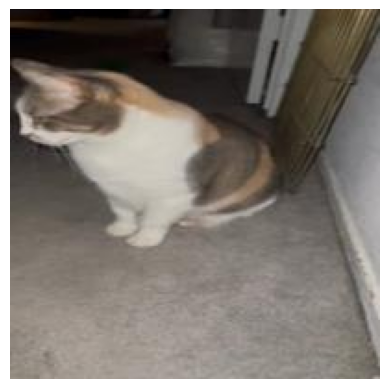

In [ ]:
# load image
example = test_data[6]
image = example["image"]
print(example["label"])
plt.imshow(image)
plt.axis('off')  # To hide axis values
plt.show()

In [ ]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

an image of asha


# Save Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

model_save_path = "/content/drive/MyDrive/trained_blip_myCat_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# Load Model

In [ ]:
# Load the trained model
from google.colab import drive
drive.mount('/content/drive/')
device = "cuda" if torch.cuda.is_available() else "cpu"
model_save_path = "/content/drive/MyDrive/trained_blip_myCat_model.pth"
loaded_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
loaded_model.load_state_dict(torch.load(model_save_path))
loaded_model.to(device)

In [11]:
processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")

An image of Asha


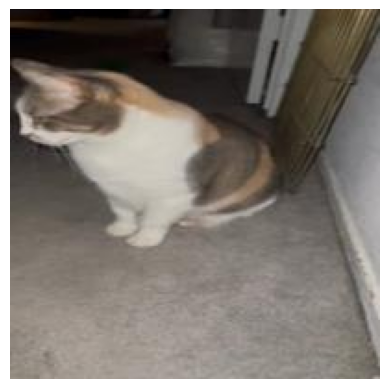

In [ ]:
# load image
example = test_data[6]
image = example["image"]
print(example["label"])
plt.imshow(image)
plt.axis('off')  # To hide axis values
plt.show()

In [ ]:
# Ensure the model is in evaluation mode
loaded_model.eval()

# Prepare the image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

# Generate captions using the model
with torch.no_grad():
    generated_ids = loaded_model.generate(pixel_values=pixel_values, max_length=50)

# Decode the generated captions and print them
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

an image of asha


## Model Evaluation

In [ ]:
# Lists to store actual labels and generated captions
actual_labels = []
generated_captions = []

# Loop through a subset of the test_data
for example in test_data[:]:  # Here, we're taking the first 10 examples; adjust as needed
    image = example["image"]
    label = example["label"]

    # Prepare the image for the model
    inputs = processor(images=image, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values

    # Generate captions using the model
    with torch.no_grad():
        generated_ids = loaded_model.generate(pixel_values=pixel_values, max_length=50)

    # Decode the generated captions
    caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # Append the label and caption to the lists
    actual_labels.append(label)
    generated_captions.append(caption)

# Create a matrix (dataframe) to compare the results
df = pd.DataFrame({
    'Actual Label': actual_labels,
    'Generated Caption': generated_captions
})

print(df)


         Actual Label Generated Caption
0    An image of Asha  an image of asha
1    An image of Bree  an image of bree
2    An image of Asha  an image of asha
3    An image of Asha  an image of asha
4    An image of Asha  an image of asha
..                ...               ...
157  An image of Bree  an image of bree
158  An image of Bree  an image of bree
159  An image of Asha  an image of bree
160  An image of Bree  an image of asha
161  An image of Asha  an image of asha

[162 rows x 2 columns]


In [ ]:
# Lists to store actual labels, generated captions, and match results
actual_labels = []
generated_captions = []
matches = []

# Loop through a subset of the test_data
for example in test_data:
    image = example["image"]
    label = example["label"].lower()  # Convert to lowercase

    # Prepare the image for the model
    inputs = processor(images=image, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values

    # Generate captions using the model
    with torch.no_grad():
        generated_ids = loaded_model.generate(pixel_values=pixel_values, max_length=50)

    # Decode the generated captions and convert to lowercase
    caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].lower()

    # Append the label, caption, and match result to the lists
    actual_labels.append(label)
    generated_captions.append(caption)
    matches.append(label == caption)

# Create a matrix (dataframe) to show the results
df = pd.DataFrame({
    'Actual Label': actual_labels,
    'Generated Caption': generated_captions,
    'Match': matches
})

# Count the number of matches and mismatches for each class
class_counts = df.groupby('Actual Label')['Match'].value_counts().unstack().fillna(0)

print(df)
print("\nClass-wise Match Counts:\n", class_counts)

         Actual Label Generated Caption  Match
0    an image of asha  an image of asha   True
1    an image of bree  an image of bree   True
2    an image of asha  an image of asha   True
3    an image of asha  an image of asha   True
4    an image of asha  an image of asha   True
..                ...               ...    ...
157  an image of bree  an image of bree   True
158  an image of bree  an image of bree   True
159  an image of asha  an image of bree  False
160  an image of bree  an image of asha  False
161  an image of asha  an image of asha   True

[162 rows x 3 columns]

Class-wise Match Counts:
 Match              False  True 
Actual Label                   
an image of annie      4     29
an image of asha       2     75
an image of bree       8     44


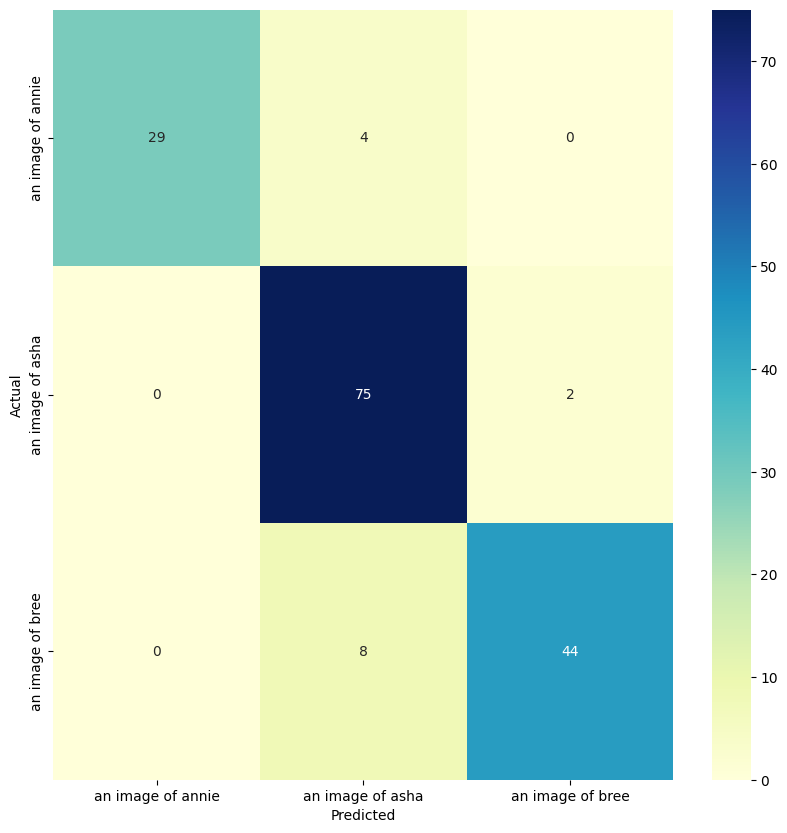

In [ ]:
# Create a confusion matrix
confusion_matrix = pd.crosstab(df['Actual Label'], df['Generated Caption'], rownames=['Actual'], colnames=['Predicted'], margins=False)

# Display the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu", fmt='g')
plt.show()

In [9]:
img_url = 'https://cdn.discordapp.com/attachments/401257138699370498/1159977993830154250/IMG_8486.jpg'

In [12]:
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

# conditional image captioning
text = ""
inputs = processor(raw_image, text, return_tensors="pt")

# Move inputs to GPU
inputs = {k: v.cuda() for k, v in inputs.items()}

out = loaded_model.generate(**inputs, max_new_tokens=50 , temperature=0.9, do_sample=True)
print(processor.decode(out[0], skip_special_tokens=True))

an image of asha


In [14]:
img_url = 'https://cdn.discordapp.com/attachments/401257138699370498/1153097224654438400/IMG_8484.jpg'

In [15]:
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

# conditional image captioning
text = ""
inputs = processor(raw_image, text, return_tensors="pt")

# Move inputs to GPU
inputs = {k: v.cuda() for k, v in inputs.items()}

out = loaded_model.generate(**inputs, max_new_tokens=50 , temperature=0.9, do_sample=True)
print(processor.decode(out[0], skip_special_tokens=True))

an image of annie


In [16]:
img_url = 'https://cdn.discordapp.com/attachments/401257138699370498/1152838401612075048/IMG_8483.jpg'

In [17]:
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

# conditional image captioning
text = ""
inputs = processor(raw_image, text, return_tensors="pt")

# Move inputs to GPU
inputs = {k: v.cuda() for k, v in inputs.items()}

out = loaded_model.generate(**inputs, max_new_tokens=50 , temperature=0.9, do_sample=True)
print(processor.decode(out[0], skip_special_tokens=True))

an image of asha


In [20]:
img_url = 'https://cdn.discordapp.com/attachments/401257138699370498/1159977993830154250/IMG_8486.jpg'
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

# conditional image captioning
text = "a photography of"
inputs = processor(raw_image, text, return_tensors="pt").to("cuda")

out = loaded_model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

# unconditional image captioning
inputs = processor(raw_image, return_tensors="pt").to("cuda")

out = loaded_model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

a photography of asha
an image of asha
